In [1]:
'''
A Morse Decoder implementation using TensorFlow library.
Learn to classify Morse code sequences using a neural network with CNN + LSTM + CTC

Adapted by: 
    Mauri Niininen (AG1LE) for Morse code learning

From:
Handwritten Text Recognition (HTR) system implemented with TensorFlow.
by Harald Scheidl
See: https://github.com/githubharald/SimpleHTR

'''
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import random
from numpy.random import normal
import numpy as np
from morse import Morse

NOISE = True
NOISE_LEVEL = 0.1

tone:599.609375


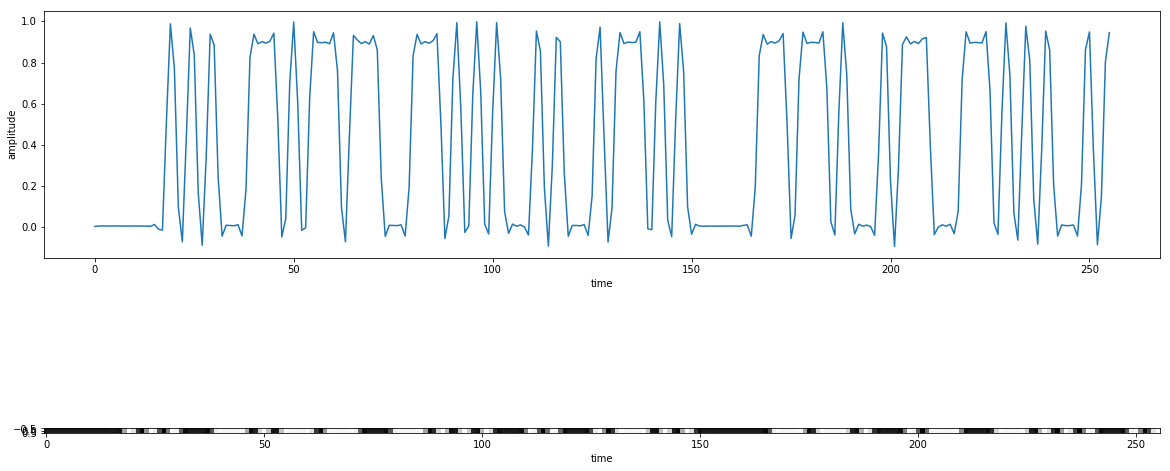

In [17]:
# ======================== RUN FROM THIS LINE BELOW ========================== #
# ======================== RUN FROM THIS LINE BELOW ========================== #
# ======================== RUN FROM THIS LINE BELOW ========================== #
# ======================== RUN FROM THIS LINE BELOW ========================== #


# Read WAV file containing Morse code and create 256x1 (or 16x16) tiles (256 samples/4 seconds)
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import numpy as np

from scipy.io import wavfile
from scipy.signal import butter, filtfilt, periodogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from peakdetect import peakdet  # download peakdetect from # https://gist.github.com/endolith/250860

def find_peak(fname):
    # Find the signal frequency and maximum value
    Fs, x = wavfile.read(fname)
    f,s = periodogram(x, Fs,'blackman',8192,'linear', False, scaling='spectrum')
    #print(len(s)/2-1,len(f)/2-1)
    threshold = max(s)*0.9  # only 0.4 ... 1.0 of max value freq peaks included
    maxtab, mintab = peakdet(abs(s[0:int(len(s)/2-1)]), threshold,f[0:int(len(f)/2-1)] )
    #print(Fs, maxtab, max(s))
    if False:
        plt.title("Morse signal peak")
        plt.xlabel("Hz")
        plt.ylabel("Amplitude")
        plt.plot(f[0:len(f)/2-1],abs(s[0:len(s)/2-1]),'g-')
        plt.scatter(maxtab[:,0], maxtab[:,1], c='r') 
        plt.show()
    return maxtab[0,0]


# Fs should be 8000 Hz 
# with decimation down to 125 Hz we get 8 msec / sample
# with WPM equals to 20 => Tdit = 1200/WPM = 60 msec   (time of 'dit')
# 4 seconds equals 256 samples ~ 66.67 Tdits 
# word 'PARIS' is 50 Tdits

def demodulate(x, Fs, freq):
    # demodulate audio signal with known CW frequency 
    t = np.arange(len(x))/ float(Fs)
    mixed =  x*((1 + np.sin(2*np.pi*freq*t))/2 )

    #calculate envelope and low pass filter this demodulated signal
    #filter bandwidth impacts decoding accuracy significantly 
    #for high SNR signals 40 Hz is better, for low SNR 20Hz is better
    # 25Hz is a compromise - could this be made an adaptive value?
    low_cutoff = 25. # 25 Hz cut-off for lowpass
    wn = low_cutoff/ (Fs/2.)    
    b, a = butter(3, wn)  # 3rd order butterworth filter
    z = filtfilt(b, a, abs(mixed))
    
    decimate = int(Fs/64) # 8000 Hz / 64 = 125 Hz => 8 msec / sample 
    Ts = 1000.*decimate/float(Fs)
    o = z[0::decimate]/max(z)
    return o

def process_audio_file(fname,x,y, tone):
    Fs, signal = wavfile.read(fname)
    dur = len(signal)/Fs
    o = demodulate(signal[(Fs*(x)):Fs*(x+y)], Fs, tone)
    #print("Fs:{} total duration:{} sec start at:{} seconds, get first {} seconds".format(Fs, dur,x,y))
    return o, dur

# Read morse.wav from start_time=0 duration=4 seconds
# save demodulated/decimated signal (1,256) to morse.npy 
# options:
# decimate: Fs/16   Fs/64  Fs/64
# duration: 2        4       16
# imgsize : 32       256    1024

filename = "audio/2c1018174f794091916353937fc9f518.wav"
tone = find_peak(filename)
print("tone:{}".format(tone))

o,dur = process_audio_file(filename,0,4, tone)
np.save("morse.npy", o, allow_pickle=False)
im = o[0::1].reshape(1,256)
#o[10:32] = 0.
#im = o[0::1].reshape(1,32)

plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(o[0::1])
#plt.annotate('N',xy=(25, 1))
#plt.annotate('O',xy=(90, 1))
#plt.annotate('W',xy=(150, 1))
#plt.annotate('2',xy=(255, 1))
plt.ylabel('amplitude')
plt.xlabel('time')
plt.subplot(2, 1, 2)
plt.imshow(im,cmap = cm.Greys_r)
plt.xlabel('time')
plt.show()

In [3]:
#===================== RNN CTC Example below ===================================
# TODO: 
# word "PARIS" at 20 WPM takes 3 seconds, dit duration is 60 msec 
# 32 characters takes ~ 18 seconds  @20 WPM
# 
# [x] create a Morse dataset with imagesize (256,1) and maxTextLen = 32  (audio duration 4 sec, decimate Fs/64)
# [x] image = (256,1 )
# [x] text = words.txt file 

import random
import cv2
import matplotlib.pyplot as plt

class Sample:
    "sample from the dataset"
    def __init__(self, gtText, filePath):
        self.gtText = gtText
        self.filePath = filePath

class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, gtTexts, imgs):
        self.imgs = np.stack(imgs, axis=0)
        self.gtTexts = gtTexts

def create_image(filename, imgSize, dataAugmentation=False):
    
    # get image name
    name = filename.split('/')
    imgname = "image/"+name[1]+".png"
    
    # Load  image in grayscale if exists
    img = cv2.imread(imgname,0)
        
    if img is None:
        print('could not load image:{} processing audio file'.format(imgname))

        # find the Morse code peak tone 
        tone = find_peak(filename)
        # get 16 seconds sample from audio file into output (1,1024) 
        # get 4 seconds sample from audio file into output (1,256) 
        sample = 4 
        o,dur = process_audio_file(filename,0,sample, tone)
        # reshape output into image and resize to match the imgSize of the model (128,32)
        #im = o[0::1].reshape(4,256)
        im = o[0::1].reshape(1,256)
        im = im*256.
        img = cv2.resize(im, imgSize, interpolation = cv2.INTER_AREA)
        # save

        retval = cv2.imwrite(imgname,img)
        if not retval:
            print('Error in writing image:{} retval:{}'.format(imgname,retval))

    
    """
    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5) # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    
    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.zeros([ht, wt]) #* 255
    target[0:newSize[1], 0:newSize[0]] = img
    """
        
    # transpose for TF
    img = cv2.transpose(img)


    # normalize
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    

    
    # transpose to match tensorflow requirements
    return img
        
class MorseDataset():

    def __init__(self, filePath, batchSize, imgSize, maxTextLen):
        "loader for dataset at given location, preprocess images and text according to parameters"

        assert filePath[-1]=='/'

        self.dataAugmentation = False
        self.currIdx = 0
        self.batchSize = batchSize
        self.imgSize = imgSize
        self.samples = []
    
        f=open(filePath+'morsewords.txt')
        chars = set()
        bad_samples = []

        # read all lines in the file 
        for line in f:
            # ignore comment line
            if not line or line[0]=='#':
                continue
            
            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 2
            
            # filenames: audio/*.wav
            fileNameAudio = lineSplit[0]

            # Ground Truth text - open files and append to samples
            #

            gtText = self.truncateLabel(' '.join(lineSplit[1:]), maxTextLen)
            print(gtText)
            chars = chars.union(set(list(gtText)))

            # put sample into list
            #print("sample text length:{} {}".format(len(gtText), gtText))
            self.samples.append(Sample(gtText, fileNameAudio))
            

        # split into training and validation set: 95% - 5%
        splitIdx = int(0.95 * len(self.samples))
        self.trainSamples = self.samples[:splitIdx]
        self.validationSamples = self.samples[splitIdx:]

        # put words into lists
        self.trainWords = [x.gtText for x in self.trainSamples]
        self.validationWords = [x.gtText for x in self.validationSamples]

        # number of randomly chosen samples per epoch for training 
        self.numTrainSamplesPerEpoch = 25000 
        
        # start with train set
        self.trainSet()

        # list of all chars in dataset
        self.charList = sorted(list(chars))

    def truncateLabel(self, text, maxTextLen):
        # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
        # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
        # If a too-long label is provided, ctc_loss returns an infinite gradient
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i-1]:
                cost += 2
            else:
                cost += 1
            if cost > maxTextLen:
                return text[:i]
        return text
        

    def trainSet(self):
        "switch to randomly chosen subset of training set"
        self.dataAugmentation = False #was True
        self.currIdx = 0
        random.shuffle(self.trainSamples)
        self.samples = self.trainSamples[:self.numTrainSamplesPerEpoch]

    
    def validationSet(self):
        "switch to validation set"
        self.dataAugmentation = False
        self.currIdx = 0
        self.samples = self.validationSamples


    def getIteratorInfo(self):
        "current batch index and overall number of batches"
        return (self.currIdx // self.batchSize + 1, len(self.samples) // self.batchSize)


    def hasNext(self):
        "iterator"
        return self.currIdx + self.batchSize <= len(self.samples)
        
        
    def getNext(self):
        "iterator"
        batchRange = range(self.currIdx, self.currIdx + self.batchSize)
        gtTexts = [self.samples[i].gtText for i in batchRange]
        imgs = [create_image(self.samples[i].filePath, self.imgSize, self.dataAugmentation) for i in batchRange]
        #imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
        self.currIdx += self.batchSize
        return Batch(gtTexts, imgs)

if False:
    m = MorseDataset(filePath="./", batchSize=50, imgSize=(1024,1), maxTextLen=32)
    batch = m.getNext()
    fig = plt.figure(figsize=[20,40])
    i = 0
    pics = len(batch.imgs)
    for img,txt in zip(batch.imgs,batch.gtTexts):
        i += 1
        plt.subplot(pics, 1, i)
        plt.imshow(img,cmap = cm.Greys_r)
        plt.title(txt)
    plt.show()
    




In [4]:
from __future__ import division
from __future__ import print_function

import sys
import numpy as np
import tensorflow as tf


class DecoderType:
    BestPath = 0
    BeamSearch = 1
    WordBeamSearch = 2


class Model: 
    "minimalistic TF model for Morse Decoder"

    # model constants
    batchSize = 50  # was 50 
    imgSize = (128, 32) 
    maxTextLen =  32
    

    def __init__(self, charList, decoderType=DecoderType.BestPath, mustRestore=False):
        "init model: add CNN, RNN and CTC and initialize TF"
        self.charList = charList
        self.decoderType = decoderType
        self.mustRestore = mustRestore
        self.snapID = 0

        # input image batch
        self.inputImgs = tf.placeholder(tf.float32, shape=(None, Model.imgSize[0], Model.imgSize[1]))

        # setup CNN, RNN and CTC
        self.setupCNN()
        self.setupRNN()
        self.setupCTC()

        # setup optimizer to train NN
        self.batchesTrained = 0
        self.learningRate = tf.placeholder(tf.float32, shape=[])
        self.optimizer = tf.train.RMSPropOptimizer(self.learningRate).minimize(self.loss)

        # initialize TF
        (self.sess, self.saver) = self.setupTF()

            
    def setupCNN(self):
        "create CNN layers and return output of these layers"
        cnnIn4d = tf.expand_dims(input=self.inputImgs, axis=3)

        # list of parameters for the layers
        kernelVals = [5, 5, 3, 3, 3]
        featureVals = [1, 32, 64, 128, 128, 256]
        #featureVals = [1, 8, 16, 32, 32, 64]
        strideVals = poolVals = [(2,2), (2,2), (1,2), (1,2), (1,2)]
        numLayers = len(strideVals)

        # create layers
        pool = cnnIn4d # input to first CNN layer
        for i in range(numLayers):
            kernel = tf.Variable(tf.truncated_normal([kernelVals[i], kernelVals[i], featureVals[i], featureVals[i + 1]], stddev=0.1))
            conv = tf.nn.conv2d(pool, kernel, padding='SAME',  strides=(1,1,1,1))
            relu = tf.nn.relu(conv)
            pool = tf.nn.max_pool(relu, (1, poolVals[i][0], poolVals[i][1], 1), (1, strideVals[i][0], strideVals[i][1], 1), 'VALID')

        self.cnnOut4d = pool


    def setupRNN(self):
        "create RNN layers and return output of these layers"
        rnnIn3d = tf.squeeze(self.cnnOut4d, axis=[2])

        # basic cells which is used to build RNN
        numHidden = 256
   
        cells = [tf.contrib.rnn.LSTMCell(num_units=numHidden, state_is_tuple=True) for _ in range(2)] # 2 layers

        # stack basic cells
        stacked = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        # bidirectional RNN
        # BxTxF -> BxTx2H
        ((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, cell_bw=stacked, inputs=rnnIn3d, dtype=rnnIn3d.dtype)
                                    
        # BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
        concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)
                                    
        # project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
        kernel = tf.Variable(tf.truncated_normal([1, 1, numHidden * 2, len(self.charList) + 1], stddev=0.1))
        self.rnnOut3d = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=[2])
        

    def setupCTC(self):
        "create CTC loss and decoder and return them"
        # BxTxC -> TxBxC
        self.ctcIn3dTBC = tf.transpose(self.rnnOut3d, [1, 0, 2])
        # ground truth text as sparse tensor
        self.gtTexts = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]) , tf.placeholder(tf.int32, [None]), tf.placeholder(tf.int64, [2]))

        # calc loss for batch
        self.seqLen = tf.placeholder(tf.int32, [None])
        self.loss = tf.reduce_mean(tf.nn.ctc_loss(labels=self.gtTexts, inputs=self.ctcIn3dTBC, sequence_length=self.seqLen, ctc_merge_repeated=True))

        # calc loss for each element to compute label probability
        self.savedCtcInput = tf.placeholder(tf.float32, shape=[Model.maxTextLen, None, len(self.charList) + 1])
        self.lossPerElement = tf.nn.ctc_loss(labels=self.gtTexts, inputs=self.savedCtcInput, sequence_length=self.seqLen, ctc_merge_repeated=True)

        # decoder: either best path decoding or beam search decoding
        if self.decoderType == DecoderType.BestPath:
            self.decoder = tf.nn.ctc_greedy_decoder(inputs=self.ctcIn3dTBC, sequence_length=self.seqLen)
        elif self.decoderType == DecoderType.BeamSearch:
            self.decoder = tf.nn.ctc_beam_search_decoder(inputs=self.ctcIn3dTBC, sequence_length=self.seqLen, beam_width=50, merge_repeated=False)
        elif self.decoderType == DecoderType.WordBeamSearch:
            # import compiled word beam search operation (see https://github.com/githubharald/CTCWordBeamSearch)
            word_beam_search_module = tf.load_op_library('TFWordBeamSearch.so')

            # prepare information about language (dictionary, characters in dataset, characters forming words) 
            chars = str().join(self.charList)
            wordChars = open('model/wordCharList.txt').read().splitlines()[0]
            corpus = open('data/corpus.txt').read()

            # decode using the "Words" mode of word beam search
            self.decoder = word_beam_search_module.word_beam_search(tf.nn.softmax(self.ctcIn3dTBC, dim=2), 50, 'Words', 0.0, corpus.encode('utf8'), chars.encode('utf8'), wordChars.encode('utf8'))


    def setupTF(self):
        "initialize TF"
        print('Python: '+sys.version)
        print('Tensorflow: '+tf.__version__)

        sess=tf.Session() # TF session

        saver = tf.train.Saver(max_to_keep=1) # saver saves model to file
        modelDir = 'model/'
        latestSnapshot = tf.train.latest_checkpoint(modelDir) # is there a saved model?

        # if model must be restored (for inference), there must be a snapshot
        if self.mustRestore and not latestSnapshot:
            raise Exception('No saved model found in: ' + modelDir)

        # load saved model if available
        if latestSnapshot:
            print('Init with stored values from ' + latestSnapshot)
            saver.restore(sess, latestSnapshot)
        else:
            print('Init with new values')
            sess.run(tf.global_variables_initializer())

        return (sess,saver)


    def toSparse(self, texts):
        "put ground truth texts into sparse tensor for ctc_loss"
        indices = []
        values = []
        shape = [len(texts), 0] # last entry must be max(labelList[i])

        # go over all texts
        for (batchElement, text) in enumerate(texts):
            # convert to string of label (i.e. class-ids)
            labelStr = [self.charList.index(c) for c in text]
            # sparse tensor must have size of max. label-string
            if len(labelStr) > shape[1]:
                shape[1] = len(labelStr)
            # put each label into sparse tensor
            for (i, label) in enumerate(labelStr):
                indices.append([batchElement, i])
                values.append(label)
        #print("(indices:{}, values:{}, shape:{})".format(indices, values, shape))
        return (indices, values, shape)


    def decoderOutputToText(self, ctcOutput, batchSize):
        "extract texts from output of CTC decoder"
        
        # contains string of labels for each batch element
        encodedLabelStrs = [[] for i in range(batchSize)]

        # word beam search: label strings terminated by blank
        if self.decoderType == DecoderType.WordBeamSearch:
            blank=len(self.charList)
            for b in range(batchSize):
                for label in ctcOutput[b]:
                    if label==blank:
                        break
                    encodedLabelStrs[b].append(label)

        # TF decoders: label strings are contained in sparse tensor
        else:
            # ctc returns tuple, first element is SparseTensor 
            decoded=ctcOutput[0][0] 

            # go over all indices and save mapping: batch -> values
            idxDict = { b : [] for b in range(batchSize) }
            for (idx, idx2d) in enumerate(decoded.indices):
                label = decoded.values[idx]
                batchElement = idx2d[0] # index according to [b,t]
                encodedLabelStrs[batchElement].append(label)

        # map labels to chars for all batch elements
        return [str().join([self.charList[c] for c in labelStr]) for labelStr in encodedLabelStrs]


    def trainBatch(self, batch):
        "feed a batch into the NN to train it"
        numBatchElements = len(batch.imgs)
        sparse = self.toSparse(batch.gtTexts)
        rate = 0.01 if self.batchesTrained < 10 else (0.001 if self.batchesTrained < 10000 else 0.0001) # decay learning rate
        evalList = [self.optimizer, self.loss]
        feedDict = {self.inputImgs : batch.imgs, self.gtTexts : sparse , self.seqLen : [Model.maxTextLen] * numBatchElements, self.learningRate : rate}
        #print(feedDict)
        (_, lossVal) = self.sess.run(evalList, feedDict)
        self.batchesTrained += 1
        return lossVal


    def inferBatch(self, batch, calcProbability=False, probabilityOfGT=False):
        "feed a batch into the NN to recognize the texts"
        
        # decode, optionally save RNN output
        numBatchElements = len(batch.imgs)
        evalList = [self.decoder] + ([self.ctcIn3dTBC] if calcProbability else [])
        feedDict = {self.inputImgs : batch.imgs, self.seqLen : [Model.maxTextLen] * numBatchElements}
        evalRes = self.sess.run([self.decoder, self.ctcIn3dTBC], feedDict)
        decoded = evalRes[0]
        texts = self.decoderOutputToText(decoded, numBatchElements)
        
        # feed RNN output and recognized text into CTC loss to compute labeling probability
        probs = None
        if calcProbability:
            sparse = self.toSparse(batch.gtTexts) if probabilityOfGT else self.toSparse(texts)
            ctcInput = evalRes[1]
            evalList = self.lossPerElement
            feedDict = {self.savedCtcInput : ctcInput, self.gtTexts : sparse, self.seqLen : [Model.maxTextLen] * numBatchElements}
            lossVals = self.sess.run(evalList, feedDict)
            probs = np.exp(-lossVals)
        print('inferBatch: probs:{} texts:{} '.format(probs, texts))
        return (texts, probs)
    

    def save(self):
        "save model to file"
        self.snapID += 1
        self.saver.save(self.sess, 'model/snapshot', global_step=self.snapID)
 

In [5]:
def train(model, loader):
    "train NN"
    epoch = 0 # number of training epochs since start
    bestCharErrorRate = float('inf') # best valdiation character error rate
    noImprovementSince = 0 # number of epochs no improvement of character error rate occured
    earlyStopping = 20 # stop training after this number of epochs without improvement
    accLoss = []
    while True:
        epoch += 1
        print('Epoch:', epoch)

        # train
        print('Train NN - imgSize',model.imgSize)
        loader.trainSet()
        while loader.hasNext():
            iterInfo = loader.getIteratorInfo()
            batch = loader.getNext()
            loss = model.trainBatch(batch)
            print('Batch:', iterInfo[0],'/', iterInfo[1], 'Loss:', loss)
            accLoss.append(loss)

        # validate
        charErrorRate = validate(model, loader)
        
        # if best validation accuracy so far, save model parameters
        if charErrorRate < bestCharErrorRate:
            print('Character error rate {} improved, save model'.format(charErrorRate))
            bestCharErrorRate = charErrorRate
            noImprovementSince = 0
            model.save()
            open(FilePaths.fnAccuracy, 'w').write('Validation character error rate of saved model: %f%%' % (charErrorRate*100.0))
        else:
            print('Character error rate {} not improved'.format(charErrorRate))
            noImprovementSince += 1

        # stop training if no more improvement in the last x epochs
        if noImprovementSince >= earlyStopping:
            print('No more improvement since %d epochs. Training stopped.' % earlyStopping)
            break
    return accLoss

In [6]:
def validate(model, loader):
    "validate NN"
    print('Validate NN')
    #loader.validationSet()
    loader.trainSet()
    charErrorRate = float('inf')
    numCharErr = 0
    numCharTotal = 0
    numWordOK = 0
    numWordTotal = 0
    while loader.hasNext():
        iterInfo = loader.getIteratorInfo()
        print('Batch:', iterInfo[0],'/', iterInfo[1])
        batch = loader.getNext()
        (recognized, _) = model.inferBatch(batch)
        print(recognized)
        
        print('Ground truth -> Recognized')    
        for i in range(len(recognized)):
            numWordOK += 1 if batch.gtTexts[i] == recognized[i] else 0
            numWordTotal += 1
            dist = editdistance.eval(recognized[i], batch.gtTexts[i])
            numCharErr += dist
            numCharTotal += len(batch.gtTexts[i])
            print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + batch.gtTexts[i] + '"', '->', '"' + recognized[i] + '"')
    
    # print validation result
    
    try:
        charErrorRate = numCharErr / numCharTotal
        wordAccuracy = numWordOK / numWordTotal
        print('Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate*100.0, wordAccuracy*100.0))
    except:
        print('numCharTotal:{} numWordTotal:{}'.format(numCharTotal,numWordTotal))
    return charErrorRate

BORN GAUZY MOCK LURE DUSK
FETUS ZEBRA LOON ENEMY SUDS
PURE AUK ALOFT GAUNT DAMON
FIRST GORKY NATAL SHADE SPIT
VINCI DIANE REBEL SMELT BASAL
WIRY SON MOOSE SUCK ON
OHMIC PACT IDAHO SCALY SLOAN
JOHN PAPER POMP HAIKU WERE
ERWIN FARE EQUIP REUB TX
IDEA RAJAH SCOOP DUE TOOT
BARR TAXA VICAR NORA LEAKY
BOHR G TEXT TERRE JEWEL
BRAD IBID BROAD CALL ALTO
GUN PEAK MOCHA MS DOT
MOLAL FAD SHOWN SLUM NULL
OTT SPAN FROG AXIAL DRUNK
ADDIS MONEL BURST ENOS FAIRY
TRUDY BUNNY LLOYD DAVID POLIS
TINE BOURN YOLK RUNG PUNKY
WEI MYTH CHIT WINY SOL
BEY SOAK DUMMY HEDGE WARTY
BRINY SHE SUITE U.S.A FLOW
LAM WELT EYE PRICK DECOR
PRANK BOIS LOFTY RENAL SHUNT
SEPT DODD TROT ACT BASIL
RAN ONLY GNAT SCUBA YAWN
RAMO BAUER HO BIDDY TRUTH
THOR OPT REICH DUCT NRC
CIDER PURR NUDGE SIEGE HONEY
GAD TREND FOIL KIRBY ALE
PITCH LINUS SILL GAO PUSHY
HELM WECO NAKED AXIAL IBIS
STOVE MUON GABON OF IGLOO
SET SHELF LUGER FLUB MORT
DRUPE PINE JUMBO DAVIS ALE
TEMPO KHAN HI PANTY HAVEN
ZOOM MAORI PARK DUE JACK
DOVE TALC DOOM LEMMA DEL

Python: 2.7.10 (default, Aug 17 2018, 19:45:58) 
[GCC 4.2.1 Compatible Apple LLVM 10.0.0 (clang-1000.0.42)]
Tensorflow: 1.4.0
Init with new values
Epoch: 1
Train NN - imgSize (128, 32)
could not load image:image/d3228a15af0b4b39a64ea0ddd89c5fc3.wav.png processing audio file
could not load image:image/50c698a5aecc4cbc9b5b3271ebdc841e.wav.png processing audio file
could not load image:image/b3ced368f438406c93f5ea9eeeb99918.wav.png processing audio file
could not load image:image/691806bdd6864cdcb3d47225b85cc58b.wav.png processing audio file
could not load image:image/9f8da31b417e49429bcfd447a2695527.wav.png processing audio file
could not load image:image/91955f27c9334039a8b2f534fca87146.wav.png processing audio file
could not load image:image/08bc4a6ab6ec4f2c9884e9377bea3642.wav.png processing audio file
could not load image:image/e2a2ff705c024190bd782c84af915f37.wav.png processing audio file
could not load image:image/4741f89bc51f42169bdea18dadbece00.wav.png processing audio file
could

could not load image:image/02cf8fef9a724a328cc7e9fac0ee48fa.wav.png processing audio file
could not load image:image/80dd82fbb8e045c48357bb461dc0078a.wav.png processing audio file
could not load image:image/ef695c8e184d4296970c08826377514e.wav.png processing audio file
could not load image:image/099f1025a2b14655a3eacdd6b45d4537.wav.png processing audio file
could not load image:image/2e42f60ac97c435982b48f6dbd289972.wav.png processing audio file
Batch: 2 / 7 Loss: 86.4508
could not load image:image/d70cb37f1d7f4a2482e63ed99007d5b2.wav.png processing audio file
could not load image:image/f4693124267c43839ef37b1b68ce10d5.wav.png processing audio file
could not load image:image/838cade3613e421a885bd3c22e0c4411.wav.png processing audio file
could not load image:image/04d66ffe6b074a73836f66bcae460f7f.wav.png processing audio file
could not load image:image/e2eeee5adab8495481a208233ac065f0.wav.png processing audio file
could not load image:image/297f5cc4df074ff98ec5eeb76fabd1a8.wav.png proce

could not load image:image/f344ad5a1bf24477b3a928138f3ff7d1.wav.png processing audio file
could not load image:image/0a80a467fe564deb94fa727ef8e65da2.wav.png processing audio file
could not load image:image/eb34d8d36e8246f18563cb1841afeead.wav.png processing audio file
could not load image:image/f45e102908a4462da56e6c691b04541a.wav.png processing audio file
could not load image:image/7080ea2b1f964049a6214752d5de7819.wav.png processing audio file
could not load image:image/ec8d2aae26d749f297f2f9dee3176683.wav.png processing audio file
Batch: 4 / 7 Loss: 94.401
could not load image:image/d99d777269f747518f9787b5303fd2de.wav.png processing audio file
could not load image:image/18d3aef0e66a4565a19c53a36fef6de8.wav.png processing audio file
could not load image:image/a074b1fa5a594e36a27671bc03921476.wav.png processing audio file
could not load image:image/34ca9048af9c4997899ba180dc4a985f.wav.png processing audio file
could not load image:image/9d59488298d146b7b0c4a11a42423e86.wav.png proces

could not load image:image/e30cd58c3e894404baeb69b1169e8a3b.wav.png processing audio file
could not load image:image/a4832245f38b4228ace2719d3693a513.wav.png processing audio file
could not load image:image/2f900775bfe347cc97d7c4c322dbf908.wav.png processing audio file
Batch: 6 / 7 Loss: 86.2971
could not load image:image/7761df5fbac448aebbc03c8f2457eef6.wav.png processing audio file
could not load image:image/7c4c66d0083649a1a42ef19b5f8333e8.wav.png processing audio file
could not load image:image/001fc259f6ba49569816c26cbcbde560.wav.png processing audio file
could not load image:image/d041ce528dbc4b1182d6f1a5a9fcdb86.wav.png processing audio file
could not load image:image/e38ce910cda745a49e0638114e3695c9.wav.png processing audio file
could not load image:image/d09ad640cd024dcab3cb1d24421eb929.wav.png processing audio file
could not load image:image/641b05703bbf4f69b8561b1f346e8576.wav.png processing audio file
could not load image:image/66a26bc95f1240a4ad214fbd33d91e7f.wav.png proce

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "ANUS ANNUL NEW SNIFF FUGAL" -> " "
[ERR:25] "EMPTY CARD CECIL DANK IRIS" -> " "
[ERR:23] "BAT TRIAL CLERK BURN PAT" -> " "
[ERR:24] "LASH CHOCK RAVE GREBE ELM" -> " "
[ERR:26] "BLIND ANDES NEIGH WHELM NAB" -> " "
[ERR:26] "URSA WIDOW EDGAR SHEA COTTA" -> " "
[ERR:26] "IRIS ALLAN EXAM ABBOT EMERY" -> " "
[ERR:24] "BOTCH ASH SIKH TSAR DEIFY" -> " "
[ERR:22] "BRUNT TVA DOG FLOP SWAM" -> " "
[ERR:24] "CHUFF QUOTA PLEA TAX BOHR" -> 

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:27] "CASEY PROSE BUMP STIFF ERUPT" -> " "
[ERR:23] "ANGEL HOPE CAIRN LEVI AM" -> " "
[ERR:26] "HURD ARES OMAHA TRIBE MAVIS" -> " "
[ERR:24] "CO DEGUM HEIGH BOOBY HIKE" -> " "
[ERR:22] "EFT MITE WHOSE ROCK ION" -> " "
[ERR:24] "TILTH BRUIT SHAKE METE IO" -> " "
[ERR:24] "FIJI JENNY ARROW DUST JON" -> " "
[ERR:26] "ELAN PITT STORM GROUT AGAIN" -> " "
[ERR:26] "INTER JOIN SWAN MISSY SPIKE" -> " "
[ERR:22] "COLZA WON GAB RANDY HOE" -> "

Epoch: 2
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 81.1549
could not load image:image/fd713a3782c0408ebbbddd8a2992e853.wav.png processing audio file
Batch: 2 / 7 Loss: 84.2986
could not load image:image/b9f5cd9059d5449e93254c5f70b3ef75.wav.png processing audio file
Batch: 3 / 7 Loss: 85.1252
Batch: 4 / 7 Loss: 84.5334
Batch: 5 / 7 Loss: 83.6476
Batch: 6 / 7 Loss: 81.8727
Batch: 7 / 7 Loss: 81.2274
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' A', ' ', ' A', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' A', ' ', ' A', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ']
Ground truth -> Recogniz

inferBatch: probs:None texts:[' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' A', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' A', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:24] "MAINE HILL MONT LEASH OWN" -> " "
[ERR:23] "MAD PRIZE WEPT WIDE POST" -> " "
[ERR:24] "MOLAL FAD SHOWN SLUM NULL" -> " "
[ERR:26] "FAUST RENAL JAPAN CLARK BELL" -> " A"
[ERR:24] "MU AMORT STONE MUSIC THEE" -> " "
[ERR:25] "THREE SILL DOLL THORN CROP" -> " "
[ERR:22] "ROACH MOST VS LAIR ERDA" -> " "
[ERR:24] "INLAY TOWN PAUSE TEXT BOP" -> " "
[ERR:26] "REX ERODE RANGY BAYOU EGRET" -> " "
[ERR:27] "CASEY PROSE BUMP ST

inferBatch: probs:None texts:[' ', ' ', ' A', ' ', ' A', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' A', ' ', ' A', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "BEY SOAK DUMMY HEDGE WARTY" -> " "
[ERR:23] "EAT FRAY GRAD OCEAN PIXY" -> " "
[ERR:24] "JOLLY WHIM SIDE ALUM CRUMP" -> " A"
[ERR:26] "HOMO GENOA KELP EERIE GLOVE" -> " "
[ERR:23] "YVES UPON AORTA SHE RABIN" -> " A"
[ERR:24] "CHUCK PEDRO MEAD OTIS ALGA" -> " A"
[ERR:25] "BARR TAXA VICAR NORA LEAKY" -> " "
[ERR:26] "TAMP GARTH WARE PECAN MIDGE" -> " "
[ERR:27] "AGONE ELSIE SWAB GIMPY KIROV" -> " "
[ERR:23] "DHABI KORA

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:23] "AGE CELIA PAULA CS SPILL" -> " "
[ERR:25] "LEASE VIVA DORIA BATON ITO" -> " "
[ERR:24] "CODON GAS COUP SOFA BLURT" -> " "
[ERR:25] "OWL OCTAL FLUID KIOWA HEED" -> " "
[ERR:27] "STEEL BOUND RHYME FUZZ FRICK" -> " "
[ERR:27] "FAUST RENAL JAPAN CLARK BELL" -> " "
[ERR:26] "MILK SMOTE KNEW FLINT SNARE" -> " "
[ERR:25] "PICK BETEL KIRK POMP SPLIT" -> " "
[ERR:24] "OLAV MAYA TIE STOVE SWIPE" -> " "
[ERR:25] "DRUPE PINE JUMBO DAVIS AL

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "WISH WRATH FRY OPTIC BIZET" -> " "
[ERR:26] "DWYER VERNA RILLY TRACK TUN" -> " "
[ERR:27] "THONG MCKAY SNOB TANSY RADIX" -> " "
[ERR:26] "SHARE VELAR LEAP FLAX STAND" -> " "
[ERR:25] "DIANE JACM CLOT LULL PILOT" -> " "
[ERR:23] "KOALA KEEP QUIET CPU NAB" -> " "
[ERR:24] "SINUS BOX EAGER PEPPY RIP" -> " "
[ERR:23] "TUNG RUB SHAWL HUGE PACE" -> " "
[ERR:23] "BRIAR MEAD IVE SINH RITZ" -> " "
[ERR:22] "ID GROSS CA GOLLY RANGE" -> "

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:24] "SYBIL GABLE INDO CUBE SCM" -> " "
[ERR:27] "GRIND NASH REEDY CRUEL SIMON" -> " "
[ERR:21] "TV BURCH STUB HAW NIMH" -> " "
[ERR:24] "LOLL WEAN KNOX TEMPO STYX" -> " "
[ERR:24] "OTT SPAN FROG AXIAL DRUNK" -> " "
[ERR:23] "LADLE IRS APSE TOLD LOVE" -> " "
[ERR:26] "SOUND STORM CACHE TREK SCAM" -> " "
[ERR:24] "VILE SHY HEIGH BERET OHIO" -> " "
[ERR:26] "ELAN PITT STORM GROUT AGAIN" -> " "
[ERR:25] "DEIGN ELVER HAT LAUD BERRA" -> "

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:23] "WI PALE BELOW FEET ARGON" -> " "
[ERR:25] "ANUS ANNUL NEW SNIFF FUGAL" -> " "
[ERR:24] "FLESH GPO PUSSY KIOWA BYE" -> " "
[ERR:24] "BREST EMIL EX OWLET SHEAF" -> " "
[ERR:24] "DODO YOND TORT RUMMY LYRA" -> " "
[ERR:25] "DEWAR MOOD TAB LORIS PENNY" -> " "
[ERR:24] "MU AMORT STONE MUSIC THEE" -> " "
[ERR:25] "POESY MARSH GORE LOU MYLAR" -> " "
[ERR:27] "MOAT UTICA WYETH POLKA VENUS" -> " "
[ERR:22] "CORE CREW SERF LAND RAE" -> " 

Batch: 1 / 7 Loss: 78.0466
Batch: 2 / 7 Loss: 77.8717
Batch: 3 / 7 Loss: 78.3294
Batch: 4 / 7 Loss: 78.1709
Batch: 5 / 7 Loss: 77.2853
Batch: 6 / 7 Loss: 78.0445
Batch: 7 / 7 Loss: 78.3308
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:[' ', '  ', ' ', ' ', '  ', ' ', ' ', ' ', '  ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', '  ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', ' ', ' ', '  ', '  ', ' ', '  ', ' ', ' ', '  ', '  ', '  ', ' ', ' ', ' ', ' ', '  ', '  ', ' ', ' ', ' '] 
[' ', '  ', ' ', ' ', '  ', ' ', ' ', ' ', '  ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', '  ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', ' ', ' ', '  ', '  ', ' ', '  ', ' ', ' ', '  ', '  ', '  ', ' ', ' ', ' ', ' ', '  ', '  ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "OUCH HUE BRIDE SIEGE HELIX" -> " "
[ERR:24] "FETCH HOOP DOBBS LURID BOB" -> "  "
[ERR:22] "JAVA DWARF CROW XI WAXY" -> " "
[ERR:27] "WYATT ESTES PUTTY OMAN FATAL" -> " "
[ERR:22

inferBatch: probs:None texts:['  ', '  ', ' ', ' ', ' ', '  ', '  ', ' ', ' ', ' ', '  ', ' ', ' ', '  ', '  ', ' ', '  ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', '  ', '  ', ' ', '  '] 
['  ', '  ', ' ', ' ', ' ', '  ', '  ', ' ', ' ', ' ', '  ', ' ', ' ', '  ', '  ', ' ', '  ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', '  ', '  ', ' ', '  ']
Ground truth -> Recognized
[ERR:26] "HONEY TOUCH GUSTO VITAE LOOT" -> "  "
[ERR:24] "COZY GOOF CORK MINIM STAID" -> "  "
[ERR:22] "THAI SYKES HIVE ROE ROW" -> " "
[ERR:26] "TOUGH LEAF LYKES NIKKO RICO" -> " "
[ERR:25] "WATER THOSE TONI MUNG HOPE" -> " "
[ERR:23] "ESTES PEAT RHODA HS CLOAK" -> "  "
[ERR:24] "FREAK CHOP CLICK WARN LOMB" -> "  "
[ERR:24] "HURRY GUS AMEN GOOD HAPPY" -> " "
[ERR:24] "JUNK BUT HAIFA PLAT HOUSE

inferBatch: probs:None texts:['  ', ' ', '  ', ' ', ' ', '  ', '  ', ' ', '  ', ' ', '  ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', ' ', '  ', ' ', ' ', '  ', '  ', ' ', ' '] 
['  ', ' ', '  ', ' ', ' ', '  ', '  ', ' ', '  ', ' ', '  ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', ' ', '  ', ' ', ' ', '  ', '  ', ' ', ' ']
Ground truth -> Recognized
[ERR:24] "MALAY THRUM RIG SHEEP AIDA" -> "  "
[ERR:25] "RANG LISE ARGON CANAL SUNG" -> " "
[ERR:24] "OSLO RHYME SCULL WAS MINOT" -> "  "
[ERR:24] "MABEL STALL KLINE IN WENT" -> " "
[ERR:26] "TAMP GARTH WARE PECAN MIDGE" -> " "
[ERR:23] "FOOT ARABY OVUM MAE PYGMY" -> "  "
[ERR:25] "EPIC LEAFY KIOWA NIKKO CORK" -> "  "
[ERR:26] "CLARA GET AROSE RILLY SPITZ" -> " "
[ERR:24] "FAME YOUD TIOGA WACK SER

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', '   ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', '   ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:26] "TAMP GARTH WARE PECAN MIDGE" -> " "
[ERR:25] "FUR BOONE TODAY OFTEN GERM" -> " "
[ERR:23] "WI PALE BELOW FEET ARGON" -> " "
[ERR:24] "LENS ERROR CHAW STOVE HOG" -> " "
[ERR:25] "INCUR FUNKY MAORI I.E LOAN" -> " "
[ERR:23] "VEND CO DONOR SPELL OVER" -> " "
[ERR:22] "HUNT SHORE EVA MINOS MOLT" -> "   "
[ERR:26] "OTTER GOUGE FEAT DUNK NEEDY" -> " "
[ERR:23] "HAYDN VOSS IAN POOR SLUG" -> " "
[ERR:24] "JUNCO SITE WV BR

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '     ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '     ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "PORK EASEL THINK GUM OUZEL" -> " "
[ERR:25] "BARR TAXA VICAR NORA LEAKY" -> " "
[ERR:27] "HONEY TOUCH GUSTO VITAE LOOT" -> " "
[ERR:28] "TRUDY BUNNY LLOYD DAVID POLIS" -> " "
[ERR:21] "TOW CPA GOG FLAIL JEST" -> " "
[ERR:24] "FOOT ARABY OVUM MAE PYGMY" -> " "
[ERR:26] "NEXT WARTY SMALL DATUM PROD" -> " "
[ERR:22] "TENET TINT GA SHAG VILE" -> " "
[ERR:25] "SIAN HEAP SIMON ASHER DAIS" -> " "
[ERR:24] "LIT JOCK MINIM S

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:26] "LEAPT JOKE GLOM DRACO FETAL" -> " "
[ERR:25] "SIXTH WED EGYPT DADE SIEVE" -> " "
[ERR:25] "INCUR FUNKY MAORI I.E LOAN" -> " "
[ERR:24] "BOTCH CLUE POUCH LUCY NBC" -> " "
[ERR:27] "JOYCE LAMAR GENIE JACOB WEED" -> " "
[ERR:25] "LABIA ANUS BERG BEEBE GIRT" -> " "
[ERR:25] "TIC HOWDY DRESS BACON SOUP" -> " "
[ERR:27] "WYATT ESTES PUTTY OMAN FATAL" -> " "
[ERR:22] "TIC OBOE MUFF YELL GYRO" -> " "
[ERR:25] "SPARE GRUNT COHN SPEW KIN

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:27] "OHMIC PACT IDAHO SCALY SLOAN" -> " "
[ERR:25] "TRUTH DUMA OWN SHRUG BRUCE" -> " "
[ERR:25] "DUMB HICK SINEW SILL AFOOT" -> " "
[ERR:22] "VI WINK BANJO SCAD RUBE" -> " "
[ERR:20] "G UTICA COWL NIMH JON" -> " "
[ERR:27] "SPURT OLDY STRUM TENOR RAVEN" -> " "
[ERR:23] "NEED ALMA TAFT FLOYD BIG" -> " "
[ERR:27] "WAXEN MIRTH CHILL CROP DALLY" -> " "
[ERR:27] "CIDER PURR NUDGE SIEGE HONEY" -> " "
[ERR:22] "AMOCO TALON DEWY SOOT R" -> 

Batch: 1 / 7 Loss: 78.2726
Batch: 2 / 7 Loss: 78.2963
Batch: 3 / 7 Loss: 78.9689
Batch: 4 / 7 Loss: 77.8336
Batch: 5 / 7 Loss: 77.5481
Batch: 6 / 7 Loss: 77.3299
Batch: 7 / 7 Loss: 80.0876
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "PAMPA RUNNY HASP ARAB AUNT" -> " "
[ERR:22] "OWN GORSE GUTSY GAL CUP" -> " "
[ERR:24] "IDEA RAJAH SCOOP DUE TOOT" -> " "
[ERR:24] "GINO OINT MALI WEIGH TURK" -> " "
[ERR:26] "FAULT TIPPY HEED UCLA NAIVE" -> " "
[ERR:2

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:26] "GOES IRVIN CIVIL INDY TONAL" -> " "
[ERR:22] "CORE CREW SERF LAND RAE" -> " "
[ERR:25] "FETCH HOOP DOBBS LURID BOB" -> " "
[ERR:26] "PRANK BRYCE EATEN RECK BOCK" -> " "
[ERR:24] "FLO GUESS MID RUDDY HENCE" -> " "
[ERR:25] "OSLO RHYME SCULL WAS MINOT" -> " "
[ERR:26] "EPIC LEAFY KIOWA NIKKO CORK" -> " "
[ERR:21] "OX SIEGE MUST TEX TOAD" -> " "
[ERR:27] "THERE GLINT HOYT CHUNK SAUNA" -> " "
[ERR:27] "HARRY NOLAN CRAFT EMORY BASE"

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:22] "BOHR G TEXT TERRE JEWEL" -> " "
[ERR:23] "PERTH FRO PRICE DREW SIT" -> " "
[ERR:26] "ALBA BLUNT MADAM YAQUI ZINC" -> " "
[ERR:27] "WAXEN MIRTH CHILL CROP DALLY" -> " "
[ERR:27] "ELIDE FUSS CILIA BRICK NAVEL" -> " "
[ERR:24] "HURRY GUS AMEN GOOD HAPPY" -> " "
[ERR:21] "WIRY SON MOOSE SUCK ON" -> " "
[ERR:25] "THREE SILL DOLL THORN CROP" -> " "
[ERR:23] "NEED ALMA TAFT FLOYD BIG" -> " "
[ERR:22] "BRUNT TVA DOG FLOP SWAM" -> " "
[

inferBatch: probs:None texts:[' ', '  ', '  ', '  ', ' ', '  ', ' ', '  ', '  ', '  ', ' ', ' ', '  ', ' ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', '  ', '  ', ' ', '  ', ' ', '  ', '  ', '  ', '  ', ' ', '  ', ' ', '  ', '  ', ' '] 
[' ', '  ', '  ', '  ', ' ', '  ', ' ', '  ', '  ', '  ', ' ', ' ', '  ', ' ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', '  ', '  ', ' ', '  ', ' ', '  ', '  ', '  ', '  ', ' ', '  ', ' ', '  ', '  ', ' ']
Ground truth -> Recognized
[ERR:24] "NOUN HULL STANK ROB CADET" -> " "
[ERR:26] "WYATT ESTES PUTTY OMAN FATAL" -> "  "
[ERR:21] "BOHR G TEXT TERRE JEWEL" -> "  "
[ERR:23] "GINO OINT MALI WEIGH TURK" -> "  "
[ERR:25] "OUCH HUE BRIDE SIEGE HELIX" -> " "
[ERR:22] "LAM WELT EYE PRICK DECOR" -> "  "
[ERR:25] "RANG LISE ARGON CANAL SUNG" -> " "
[ERR:26] "DRURY VIDA SHAKE TRIPE GRAFF" -> "  "
[ERR:27] "D

inferBatch: probs:None texts:['  ', '  ', '  ', '  ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', '  ', ' ', '  ', '  ', '  ', '  ', ' ', '  ', '  ', '  ', ' ', ' ', '  ', '  ', '  ', ' ', '  ', '  ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', '  ', ' ', ' ', '  ', ' ', '  ', ' '] 
['  ', '  ', '  ', '  ', '  ', ' ', ' ', '  ', '  ', '  ', '  ', '  ', '  ', ' ', '  ', '  ', '  ', '  ', ' ', '  ', '  ', '  ', ' ', ' ', '  ', '  ', '  ', ' ', '  ', '  ', ' ', '  ', '  ', '  ', '  ', '  ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', '  ', ' ', ' ', '  ', ' ', '  ', ' ']
Ground truth -> Recognized
[ERR:23] "DEWY BASIN PEAK LAW BLADE" -> "  "
[ERR:21] "TIC OBOE MUFF YELL GYRO" -> "  "
[ERR:22] "GAVE TEA RICE JERES RAUL" -> "  "
[ERR:21] "ID GROSS CA GOLLY RANGE" -> "  "
[ERR:23] "LIEN UTTER CO RUBIN ILIAD" -> "  "
[ERR:24] "DODO YOND TORT RUMMY LYRA" -> " "
[ERR:24] "BLOKE GYP POI HOUSE SCAMP" -> " "
[ERR:22] "JO JEEP GRATA MICA DEBAR" -> "  "
[ERR:22] "RAN ONLY GNAT

inferBatch: probs:None texts:[' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E'] 
[' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E']
Ground truth -> Recognized
[ERR:24] "DIRTY NOISY RAZE OKAPI INDEX" -> " E E"
[ERR:24] "CIDER PURR NUDGE SIEGE HONEY" -> " E E"
[ERR:25] "SATYR MUGGY MACON MIST PAPA" ->

inferBatch: probs:None texts:[' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E'] 
[' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E', ' E E']
Ground truth -> Recognized
[ERR:25] "TONAL INERT MIDAS MUSKY DANCE" -> " E E"
[ERR:22] "JULIE ASSAI BOISE MIFF ERE" -> " E E"
[ERR:18] "OX SIEGE MUST TEX TOAD" -> " E E

Epoch: 11
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 79.1494
Batch: 2 / 7 Loss: 79.1518
Batch: 3 / 7 Loss: 79.1913
Batch: 4 / 7 Loss: 78.7275
Batch: 5 / 7 Loss: 77.5122
Batch: 6 / 7 Loss: 77.0628
Batch: 7 / 7 Loss: 76.7823
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:21] "TOW CPA GOG FLAIL JEST" -> " "
[ERR:24] "TEPEE WE SIDLE THREW PUTT" -> " "
[ERR:25] "AGENT EGYPT IOTA CUFF DART" -> " "
[ERR:25] "AMIDE ERIC COOKE AMBER SIN" -> " "
[ERR:24] "FOO

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:22] "COLZA WON GAB RANDY HOE" -> " "
[ERR:26] "SOUND STORM CACHE TREK SCAM" -> " "
[ERR:25] "ITCH SPIN CARTE JUROR COLT" -> " "
[ERR:27] "RELIC FLIP WOVEN BLEND SHALE" -> " "
[ERR:21] "OX SIEGE MUST TEX TOAD" -> " "
[ERR:23] "JO JEEP GRATA MICA DEBAR" -> " "
[ERR:24] "MU AMORT STONE MUSIC THEE" -> " "
[ERR:25] "BET NANCY UNARY SKYE BABEL" -> " "
[ERR:27] "HAMAL BRAVO ANENT TARA CHALK" -> " "
[ERR:23] "PERTH FRO PRICE DREW SIT" -> " 

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:24] "BRAD IBID BROAD CALL ALTO" -> " "
[ERR:26] "EPIC LEAFY KIOWA NIKKO CORK" -> " "
[ERR:23] "DEN VACUA LAC DITCH WINO" -> " "
[ERR:26] "SHARE VELAR LEAP FLAX STAND" -> " "
[ERR:24] "FOCI YIELD ISIS ZAN TODAY" -> " "
[ERR:27] "GROWL WELT SLURP SNIPE SHINE" -> " "
[ERR:25] "SPARE GRUNT COHN SPEW KINK" -> " "
[ERR:25] "PITCH LINUS SILL GAO PUSHY" -> " "
[ERR:27] "WAXEN MIRTH CHILL CROP DALLY" -> " "
[ERR:24] "LASH CHOCK RAVE GREBE EL

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "CHASE ARAB SERF LORE SPIRO" -> " "
[ERR:25] "SONY BAUER REGIS SLIME ADA" -> " "
[ERR:26] "PAINE GREY HITCH LIAR GRIPE" -> " "
[ERR:27] "HONEY TOUCH GUSTO VITAE LOOT" -> " "
[ERR:23] "MAD PRIZE WEPT WIDE POST" -> " "
[ERR:24] "CO DEGUM HEIGH BOOBY HIKE" -> " "
[ERR:22] "VI WINK BANJO SCAD RUBE" -> " "
[ERR:24] "BORN GAUZY MOCK LURE DUSK" -> " "
[ERR:22] "JAVA DWARF CROW XI WAXY" -> " "
[ERR:25] "DUMB HICK SINEW SILL AFOOT" -> " 

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:22] "REBEL CRAW AZ SLATE RAE" -> " "
[ERR:23] "BOSSY VITO GAL PIG CONGO" -> " "
[ERR:25] "HARE PAW STORE SKUNK DORIS" -> " "
[ERR:25] "TINE BOURN YOLK RUNG PUNKY" -> " "
[ERR:24] "DEWY BASIN PEAK LAW BLADE" -> " "
[ERR:24] "DAHL RASA INPUT PREP DIVE" -> " "
[ERR:27] "WYATT ESTES PUTTY OMAN FATAL" -> " "
[ERR:23] "TAR YOND CITE MITT VOUCH" -> " "
[ERR:28] "THANK ETHIC SPIRE MISTY IDAHO" -> " "
[ERR:23] "SEPT DODD TROT ACT BASIL" -> "

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', '  ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', '  ', ' ', ' ', ' ', ' ', '  ', ' ']
Ground truth -> Recognized
[ERR:24] "OTT SPAN FROG AXIAL DRUNK" -> " "
[ERR:27] "HONEY TOUCH GUSTO VITAE LOOT" -> " "
[ERR:25] "TINE BOURN YOLK RUNG PUNKY" -> " "
[ERR:26] "RIFLE JURA SETUP COMB SISAL" -> " "
[ERR:25] "STEED TAO LLAMA GAFF VISOR" -> " "
[ERR:25] "AGENT EGYPT IOTA CUFF DART" -> " "
[ERR:27] "ELIDE FUSS CILIA BRICK NAVEL" -> " "
[ERR:24] "WOKE RAW SWAIN NINA APPLE" -> " "
[ERR:26] "CLARA GET AROSE RILLY SPITZ" -> " "
[ERR:26] "ELBOW SERF GOLD 

inferBatch: probs:None texts:['  ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
['  ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:23] "TILTH BRUIT SHAKE METE IO" -> "  "
[ERR:24] "DAHL RASA INPUT PREP DIVE" -> " "
[ERR:24] "BRINY SHE SUITE U.S.A FLOW" -> "  "
[ERR:26] "SNAIL GOOSE HASH BLAT LEGGY" -> " "
[ERR:25] "HARE PAW STORE SKUNK DORIS" -> " "
[ERR:27] "RELIC FLIP WOVEN BLEND SHALE" -> " "
[ERR:23] "WI PALE BELOW FEET ARGON" -> " "
[ERR:26] "NEXT WARTY SMALL DATUM PROD" -> " "
[ERR:25] "ALGOL HATER JUDD FLAN RIFT" -> " "
[ERR:25] "CLARK BARTH JUNO G

Batch: 1 / 7 Loss: 77.2908
Batch: 2 / 7 Loss: 76.9706
Batch: 3 / 7 Loss: 78.75
Batch: 4 / 7 Loss: 77.4653
Batch: 5 / 7 Loss: 77.5062
Batch: 6 / 7 Loss: 79.1578
Batch: 7 / 7 Loss: 77.2534
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:24] "SPASM DAMN DRY MILES WARN" -> " "
[ERR:24] "BRAD IBID BROAD CALL ALTO" -> " "
[ERR:26] "MILK BEGET GABON TUFT MALAY" -> " "
[ERR:25] "HARE PAW STORE SKUNK DORIS" -> " "
[ERR:27] "MYTH BAYOU GETTY BURLY CHEEK" -> " "
[ER

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "PACT PION SHOE CLOSE BLEND" -> " "
[ERR:25] "VET CANNY DRAM ONSET DOWRY" -> " "
[ERR:26] "CURIE RINSE CROFT CHOSE ROD" -> " "
[ERR:27] "SNACK SUPER VALVE HOMO EIGHT" -> " "
[ERR:25] "NON SPORT FLUSH CADY SEAMY" -> " "
[ERR:25] "AMIDE ERIC COOKE AMBER SIN" -> " "
[ERR:21] "TV BURCH STUB HAW NIMH" -> " "
[ERR:24] "LENS ERROR CHAW STOVE HOG" -> " "
[ERR:26] "ESTES MARIO LAIR LATHE FIRE" -> " "
[ERR:24] "CHUFF QUOTA PLEA TAX BOHR" 

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:22] "RIMY HOLM PHLOX MAX EYE" -> " "
[ERR:24] "LOLL WEAN KNOX TEMPO STYX" -> " "
[ERR:25] "DEWAR MOOD TAB LORIS PENNY" -> " "
[ERR:24] "BREST EMIL EX OWLET SHEAF" -> " "
[ERR:24] "LASH CHOCK RAVE GREBE ELM" -> " "
[ERR:25] "SITUS DIG MOTET RIME SAULT" -> " "
[ERR:24] "AGATE STUMP PITT EASY ITD" -> " "
[ERR:26] "MILK SMOTE KNEW FLINT SNARE" -> " "
[ERR:24] "CONEY LOKI LOP BELCH AWAY" -> " "
[ERR:25] "PURE AUK ALOFT GAUNT DAMON" -> " 

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:27] "FAUST RENAL JAPAN CLARK BELL" -> " "
[ERR:25] "JACOB HEIR DIS TONIC SPORT" -> " "
[ERR:25] "HETTY TWIRL BLISS IRK BAND" -> " "
[ERR:26] "ESTES MARIO LAIR LATHE FIRE" -> " "
[ERR:25] "AGENT EGYPT IOTA CUFF DART" -> " "
[ERR:27] "DUGAN SPLIT BORAX TABU SWAMP" -> " "
[ERR:27] "ADDIS MONEL BURST ENOS FAIRY" -> " "
[ERR:24] "WHELK SWIFT FEUD QED TINT" -> " "
[ERR:25] "DUMB HICK SINEW SILL AFOOT" -> " "
[ERR:26] "BRUIT HEINE AHEAD FL

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:23] "TAR YOND CITE MITT VOUCH" -> " "
[ERR:24] "PEEK GORE WHIR SCOLD TOFU" -> " "
[ERR:26] "URSA WIDOW EDGAR SHEA COTTA" -> " "
[ERR:25] "KINKY COURT ERG LOOK SPEED" -> " "
[ERR:23] "BOOR CAMP AVID DEAD OLIN" -> " "
[ERR:25] "TRUTH DUMA OWN SHRUG BRUCE" -> " "
[ERR:23] "VEND CO DONOR SPELL OVER" -> " "
[ERR:23] "PRY MOCHA NEST PETTY USE" -> " "
[ERR:24] "RAMO BAUER HO BIDDY TRUTH" -> " "
[ERR:23] "DHABI KORAN AH WEEK HATE" -> " "
[E

inferBatch: probs:None texts:['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'] 
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
Ground truth -> Recognized
[ERR:25] "OWL OCTAL FLUID KIOWA HEED" -> "E"
[ERR:23] "WI PALE BELOW FEET ARGON" -> "E"
[ERR:27] "NOMAD FOOL COVET SKEET BRACE" -> "E"
[ERR:24] "STOAT JURA SIX LIEU HUSKY" -> "E"
[ERR:21] "FIEND LAND NUT IS TILT" -> "E"
[ERR:25] "OTT SPAN FROG AXIAL DRUNK" -> "E"
[ERR:28] "THONG MCKAY SNOB TANSY RADIX" -> "E"
[ERR:20] "FIG WON MEN PEA SWELL" -> "E"
[ERR:23] "EAT FRAY GRAD OCEAN PIXY" -> "E"
[ERR:28] "VINCI DIANE REBEL SMELT BASAL" -> "E"

inferBatch: probs:None texts:['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'] 
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
Ground truth -> Recognized
[ERR:23] "SITU STONE MELD OPAL GUN" -> "E"
[ERR:26] "AMOS BREST SATYR OLGA SYRUP" -> "E"
[ERR:25] "DEWAR MOOD TAB LORIS PENNY" -> "E"
[ERR:27] "HYENA NIGER DINGY PEDAL KEMP" -> "E"
[ERR:24] "BOSSY VITO GAL PIG CONGO" -> "E"
[ERR:28] "TONAL INERT MIDAS MUSKY DANCE" -> "E"
[ERR:24] "LIEN UTTER CO RUBIN ILIAD" -> "E"
[ERR:26] "FETUS ZEBRA LOON ENEMY SUDS" -> "E"
[ERR:24] "JUNCO SITE WV BRAVE SPOKE" -> "E"
[ERR:23] "LOWE GLUT DAMN USIA FORK"

Batch: 1 / 7 Loss: 77.003
Batch: 2 / 7 Loss: 78.8806
Batch: 3 / 7 Loss: 78.6427
Batch: 4 / 7 Loss: 77.1348
Batch: 5 / 7 Loss: 76.3426
Batch: 6 / 7 Loss: 76.8413
Batch: 7 / 7 Loss: 78.0624
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E'] 
['E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E']
Ground truth -> Recognized
[ERR:22] "OLAV MAYA TIE STOV

inferBatch: probs:None texts:['E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E'] 
['E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E']
Ground truth -> Recognized
[ERR:22] "SINUS BOX EAGER PEPPY RIP" -> "E E"
[ERR:23] "CHUFF QUOTA PLEA TAX BOHR" -> "E E"
[ERR:24] "PURE AUK ALOFT GAUNT DAMON" -> "E E"
[ERR:21] "CAGE KIVU LICE BLEAK BAG" -> "E E"
[ERR:24] "ITCH SPIN CARTE JUROR COLT" -> "E E"
[ERR:26] "

inferBatch: probs:None texts:['E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E'] 
['E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E', 'E E']
Ground truth -> Recognized
[ERR:22] "IDEA RAJAH SCOOP DUE TOOT" -> "E E"
[ERR:22] "FAME CENT SKIP GORY TIZZY" -> "E E"
[ERR:22] "DEN VACUA LAC DITCH WINO" -> "E E"
[ERR:22] "YVES UPON AORTA SHE RABIN" -> "E E"
[ERR:23] "HARE PAW STORE SKUNK DORIS" -> "E E"
[ERR:20] "G

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:20] "FIG WON MEN PEA SWELL" -> " "
[ERR:26] "CLARA GET AROSE RILLY SPITZ" -> " "
[ERR:24] "HURRY GUS AMEN GOOD HAPPY" -> " "
[ERR:25] "OWL OCTAL FLUID KIOWA HEED" -> " "
[ERR:28] "TRUDY BUNNY LLOYD DAVID POLIS" -> " "
[ERR:24] "JUNCO SITE WV BRAVE SPOKE" -> " "
[ERR:24] "PEEK GORE WHIR SCOLD TOFU" -> " "
[ERR:21] "VEST MANGE CAB NBC AMI" -> " "
[ERR:25] "ILL JUDAS ZORN TOTEM NAIVE" -> " "
[ERR:24] "LASH CHOCK RAVE GREBE ELM" -> " "


inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:23] "BRIAR MEAD IVE SINH RITZ" -> " "
[ERR:20] "HEY MATH TRIP BOB CUP" -> " "
[ERR:25] "BRINY SHE SUITE U.S.A FLOW" -> " "
[ERR:24] "BORN GAUZY MOCK LURE DUSK" -> " "
[ERR:24] "DEAR RING MORAN RHO GUANO" -> " "
[ERR:27] "SPURT OLDY STRUM TENOR RAVEN" -> " "
[ERR:27] "ELIDE FUSS CILIA BRICK NAVEL" -> " "
[ERR:25] "WISH WRATH FRY OPTIC BIZET" -> " "
[ERR:23] "ANGEL HOPE CAIRN LEVI AM" -> " "
[ERR:24] "FOOT ARABY OVUM MAE PYGMY" -> " "

inferBatch: probs:None texts:['SA  E', 'SA   E', 'SA E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'S  E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA   E', 'SA  E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA  E', 'SA    E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA     E', 'SA  E', 'SA  E'] 
['SA  E', 'SA   E', 'SA E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'S  E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA   E', 'SA  E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA  E', 'SA    E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA     E', 'SA  E', 'SA  E']
Ground truth -> Recogniz

inferBatch: probs:None texts:['SA  E', 'SA E', 'SA E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'S  E', 'SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'S   E', 'SA   E', 'S  E', 'SA   E', 'SA  E', 'SA  E', 'S E', 'SA E', 'S   E', 'SA  E', 'S E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA    E', 'SA  E', 'SA  E', 'S   E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E'] 
['SA  E', 'SA E', 'SA E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'S  E', 'SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'S   E', 'SA   E', 'S  E', 'SA   E', 'SA  E', 'SA  E', 'S E', 'SA E', 'S   E', 'SA  E', 'S E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA    E', 'SA  E', 'SA  E', 'S   E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E']
Ground truth -> Recognized
[ERR:22] "FAME YOUD TIOGA WACK SERG

Epoch: 20
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 76.7542
Batch: 2 / 7 Loss: 77.3253
Batch: 3 / 7 Loss: 77.3819
Batch: 4 / 7 Loss: 78.3073
Batch: 5 / 7 Loss: 77.079
Batch: 6 / 7 Loss: 77.4539
Batch: 7 / 7 Loss: 77.0517
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:27] "NOMAD FOOL COVET SKEET BRACE" -> " "
[ERR:25] "HOGAN DANK KYOTO ANTE MEND" -> " "
[ERR:24] "MU AMORT STONE MUSIC THEE" -> " "
[ERR:25] "DRUPE PINE JUMBO DAVIS ALE" -> " "
[ERR:26]

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "CHASE ARAB SERF LORE SPIRO" -> " "
[ERR:20] "THIS GIN MOE BEAT NAN" -> " "
[ERR:24] "ITLL WHEEL FEB GRIM TEPID" -> " "
[ERR:25] "ITCH SPIN CARTE JUROR COLT" -> " "
[ERR:23] "FLY CRUSH GREER SPY WASH" -> " "
[ERR:22] "ADD BURRO DATUM NOD APE" -> " "
[ERR:24] "DAHL ALGER AMY ALOE FETCH" -> " "
[ERR:25] "JULIE ASSAI BOISE MIFF ERE" -> " "
[ERR:23] "AIRY ZLOTY RACE YORK TUG" -> " "
[ERR:22] "BRUNT TVA DOG FLOP SWAM" -> " "
[ERR:26]

inferBatch: probs:None texts:[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] 
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Ground truth -> Recognized
[ERR:25] "PAMPA RUNNY HASP ARAB AUNT" -> " "
[ERR:26] "RIFLE JURA SETUP COMB SISAL" -> " "
[ERR:25] "COZY GOOF CORK MINIM STAID" -> " "
[ERR:26] "BORON SPEW CUZCO EXTRA TEST" -> " "
[ERR:25] "TIC HOWDY DRESS BACON SOUP" -> " "
[ERR:24] "OLAV MAYA TIE STOVE SWIPE" -> " "
[ERR:26] "BARON RUDE BAUD KOMBU BUTYL" -> " "
[ERR:20] "GUN PEAK MOCHA MS DOT" -> " "
[ERR:25] "HARE PAW STORE SKUNK DORIS" -> " "
[ERR:22] "BOHR G TEXT TERRE JEWEL" -> "

inferBatch: probs:None texts:['AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'SAE', 'SAE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'SAE'] 
['AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'SAE', 'SAE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'SAE']
Ground truth -> Recognized
[ERR:24] "ANUS ANNUL NEW SNIFF FUGAL" -> "AE"
[ERR:23] "FAME CENT SKIP GORY TIZZY" -> "SAE"
[ERR:25] "CHUCK PEDRO MEAD OTIS ALGA" -> "AE"
[ERR:22] "LAM WELT EYE PRICK DECOR" -> "AE"
[ERR:26] "CASEY PROSE BUMP STIFF ERUPT" -> "AE"
[ERR:23] "JUNCO SITE WV BRAVE SPOKE" -> "AE"
[ERR:23] "JULIE ASSAI BOISE MIFF ERE" ->

inferBatch: probs:None texts:['AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'SAE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'SAE', 'SAE', 'AE', 'AE', 'AE', 'AE'] 
['AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'SAE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'SAE', 'AE', 'AE', 'AE', 'SAE', 'SAE', 'AE', 'AE', 'AE', 'AE']
Ground truth -> Recognized
[ERR:25] "HURD ARES OMAHA TRIBE MAVIS" -> "AE"
[ERR:24] "SITUS DIG MOTET RIME SAULT" -> "SAE"
[ERR:24] "DU DINGO TITHE ASTM YUCCA" -> "AE"
[ERR:26] "NOMAD FOOL COVET SKEET BRACE" -> "AE"
[ERR:22] "OAT SILK FLAKE TEAL DEAD" -> "AE"
[ERR:23] "ZULU ASSAI EGRET SPIN KEG" -> "AE"
[ERR:22] "KOALA KEEP QUIET CPU NAB" -> "A

inferBatch: probs:None texts:['BO E', 'BO E', 'BO E', 'O E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'O E', 'BO ', 'BO E'] 
['BO E', 'BO E', 'BO E', 'O E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'O E', 'BO ', 'BO E']
Ground truth -> Recognized
[ERR:23] "TRUCE TAWNY PROF PATH WHEN" -> "BO E"
[ERR:25] "MOIST ICKY BANAL PHASE PANIC" -> "BO E"
[ERR:23] "SONY BAUER REGIS SLIME ADA" -> "BO E"
[ERR:23] "E

inferBatch: probs:None texts:['BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'O E', 'BO E', 'O E', 'BO E', 'BO E', 'O E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO ', 'BO ', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'O E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO ', 'BO ', 'BO ', 'BO E', 'BO E'] 
['BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'O E', 'BO E', 'O E', 'BO E', 'BO E', 'O E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO ', 'BO ', 'BO E', 'BO ', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'BO E', 'O E', 'BO E', 'BO E', 'BO ', 'BO E', 'BO ', 'BO ', 'BO ', 'BO E', 'BO E']
Ground truth -> Recognized
[ERR:23] "FAME CENT SKIP GORY TIZZY" -> "BO E"
[ERR:22] "LAM WELT EYE PRICK DECOR" -> "BO E"
[ERR:22] "BEY SOAK DUMMY HEDGE WARTY" -> "BO E"
[ERR:25] "DROSS SOLD TWILL

Batch: 1 / 7 Loss: 76.3936
Batch: 2 / 7 Loss: 76.8239
Batch: 3 / 7 Loss: 77.149
Batch: 4 / 7 Loss: 77.6118
Batch: 5 / 7 Loss: 76.5535
Batch: 6 / 7 Loss: 76.4816
Batch: 7 / 7 Loss: 76.509
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SA  E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA  E', 'SA    E', 'SA  E', 'SA    E', 'SA   E', 'SA    E', 'SA    E', 'SO  E', 'SA   E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA    E', 'SA   E', 'SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA    E', 'SA   E', 'SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA    E', 'SA    E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SO   E', 'SA   E', 'SA   E', 'SA  E', 'SA     E', 'SA   E', 'SA   E', 'SA    E', 'SA  E'] 
['SA  E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA  E', 'SA    E', 'SA  E', 'SA    E', 'SA   E', 'SA    E', 'SA    E', 'SO  E', 'SA   E', 'SA   E', 'SA    E', 'SA  E', 'SA  E', 'SA   E', 'SA    E', 'SA   E', 'SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA    E', 'SA

inferBatch: probs:None texts:['SO  E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA  E', 'SA    E', 'SO   E', 'SA  E', 'SA   E', 'SA    E', 'SA    E', 'SA   E', 'SA   E', 'SA  E', 'SA   E', 'SA  E', 'SE    E', 'SA  E', 'SA   E', 'SA    E', 'SA    E', 'SO  E', 'SA    E', 'SA   E', 'SA    E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA   E', 'SE   E', 'SA  E', 'SA   E', 'SA   E', 'SO  E', 'SA   E', 'SA    E', 'SA    E', 'SA  E', 'SA  E', 'SO   E', 'SA    E', 'SA  E', 'SO  E', 'SA  E', 'SA   E', 'SA  E', 'SO   E'] 
['SO  E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA  E', 'SA    E', 'SO   E', 'SA  E', 'SA   E', 'SA    E', 'SA    E', 'SA   E', 'SA   E', 'SA  E', 'SA   E', 'SA  E', 'SE    E', 'SA  E', 'SA   E', 'SA    E', 'SA    E', 'SO  E', 'SA    E', 'SA   E', 'SA    E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA   E', 'SE   E', 'SA  E', 'SA   E', 'SA   E', 'SO  E', 'SA   E', 'SA    E', 'SA    E', 'SA  E', 'SA  E', 'SO   E', 'SA    E', 'SA  E', 'SO  E', 'SA  E', 'SA   E', 'SA

inferBatch: probs:None texts:['SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA     E', 'SA    E', 'SE    E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA   E', 'SA    E', 'SA  E', 'SA   E', 'SA    E', 'SA    E', 'SO  E', 'SA   E', 'SA  E', 'SA   E', 'SA  E', 'SA    E', 'SO  E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA    E', 'SA   E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA    E', 'SA  E', 'SA    E', 'SA   E', 'SO  E'] 
['SA   E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA   E', 'SA   E', 'SA     E', 'SA    E', 'SE    E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA   E', 'SA    E', 'SA  E', 'SA   E', 'SA    E', 'SA    E', 'SO  E', 'SA   E', 'SA  E', 'SA   E', 'SA  E', 'SA    E', 'SO  E', 'SA   E', 'SA   E', 'SA  E', 'SA  E', 'SA    E', 'SA   E', 'SA   E', 'SA   E', 'SA   E', 'SA  E', 'SA    E', 'SA  E', 'SA    E', 'SA   E

inferBatch: probs:None texts:['SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E'] 
['SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E']
Ground truth -> Recognized
[ERR:20] "LAM WELT EYE PRICK DECOR" -> 

inferBatch: probs:None texts:['SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA   E'] 
['SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA E', 'SA  E', 'SA  E', 'SA   E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA  E', 'SA   E', 'SA   E']
Ground truth -> Recognized
[ERR:21] "CREDO YAQUI OLD FLARE CUT" 

inferBatch: probs:None texts:['SAE    E', 'SAE   E', 'SAE    E E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E E', 'SAE    E', 'SAE   E E', 'SAE   E E', 'SAE    E E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE    E E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE     E', 'SAE  E', 'SAE   E E', 'SAE   E', 'SAE    E', 'SAE   E E', 'SAE   E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE   E E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E'] 
['SAE    E', 'SAE   E', 'SAE    E E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E E', 'SAE    E', 'SAE   E E', 'SAE   E E', 'SAE    E E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE    E E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE

inferBatch: probs:None texts:['SAE    E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE  E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE   E E', 'SAE  E E', 'SAE    AE', 'SAE     E', 'SAE   E', 'SAE    E', 'SAE   E', 'SAE   E E', 'SAE    E', 'SAE    E', 'SAE   E E', 'SAE    E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE     E', 'SAE    E', 'SAE    E', 'SAE    E', 'SE     E'] 
['SAE    E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E E', 'SAE   E', 'SAE   E', 'SAE   E', 'SAE    E', 'SAE  E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE    E', 'SAE    E', 'SAE   E', 'SAE   E', 'SAE   E E', 'SAE  E E', 'SAE    AE', 'SAE     E', 'SAE   E', 'SAE    E', 'SAE   E', 'SAE   E E', 'SAE    E', 'SAE

Epoch: 26
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 75.6115
Batch: 2 / 7 Loss: 76.4819
Batch: 3 / 7 Loss: 75.9858
Batch: 4 / 7 Loss: 72.3299
Batch: 5 / 7 Loss: 77.0075
Batch: 6 / 7 Loss: 76.1426
Batch: 7 / 7 Loss: 74.4385
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SI    E', 'SI    E', 'SI     E', 'SI    E', 'SI    E', 'SI     E', 'SI    E', 'SI I   AE', 'SI     T', 'SI     E', 'SI     AE', 'SI     E', 'SI     AE', 'SI    E', 'SI     E', 'SI     E', 'SI     AE', 'SI    IE', 'SI     E', 'SI     E', 'SI     E', 'SI    AE', 'SI     IE', 'SI     AIT', 'SI    AE', 'SI     E', 'SI    AE', 'SI    E', 'SI    E', 'SI    IE', 'SI    AE', 'SI     E', 'SI     AE', 'SI      E', 'SI     E', 'SI    E', 'SI     IT', 'SI     AE', 'SI    E', 'SI     AE', 'SI    IE', 'SI     IT', 'SI     E', 'SI     E', 'SI     E', 'SI     AE', 'SI     E', 'SI    E', 'SI     E', 'SI    AE'] 
['SI    E', 'SI    E', 'SI     E', 'SI    E', 'SI    E', 'SI     E', 'SI    E', 'SI I   AE', 'SI     T', 'SI     

inferBatch: probs:None texts:['SI    E', 'SI     E', 'SI    E', 'SI    AE', 'SI    IT', 'SI    E', 'SI     E', 'SI    AIT', 'SI    E', 'SI     AE', 'SI    E', 'SI     AE', 'SI     AE', 'SI    E', 'SI    E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI    AE', 'SI    E', 'SI    E', 'SI    E', 'SI     E', 'SI      E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI    E', 'SI    E', 'SI     E', 'SI    E', 'SI     E', 'SI    E', 'SI    E', 'SI    E', 'SI     E', 'SI     IT', 'SI    E', 'SI    AE', 'SI     IE', 'SI    E', 'SI    E', 'SI    AE', 'SI     IE', 'SI    IE'] 
['SI    E', 'SI     E', 'SI    E', 'SI    AE', 'SI    IT', 'SI    E', 'SI     E', 'SI    AIT', 'SI    E', 'SI     AE', 'SI    E', 'SI     AE', 'SI     AE', 'SI    E', 'SI    E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI    AE', 'SI    E', 'SI    E', 'SI    E', 'SI     E', 'SI      E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 

inferBatch: probs:None texts:['SI    E', 'SI    E', 'SI    IE', 'SI    E', 'SI     E', 'SI     IT', 'SI     AE', 'SI    E', 'SI     AE', 'SI     E', 'SI     AE', 'SI     E', 'SI    E', 'SI     E', 'SI    E', 'SI    AE', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI    E', 'SI     E', 'SI     E', 'SI    E', 'SI     IE', 'SI    AE', 'SI     E', 'SI     E', 'SI    AE', 'SI    E', 'SI    E', 'SI      E', 'SI     E', 'SI    AIT', 'SI     AE', 'SI    IE', 'SI    E', 'SI    AE', 'SI    IT', 'SI     AE', 'SI    IE', 'SI     E', 'SI    E', 'SI     E', 'SI    AE', 'SI    E', 'SI     E', 'SI     AE', 'SI     IT', 'SI    E'] 
['SI    E', 'SI    E', 'SI    IE', 'SI    E', 'SI     E', 'SI     IT', 'SI     AE', 'SI    E', 'SI     AE', 'SI     E', 'SI     AE', 'SI     E', 'SI    E', 'SI     E', 'SI    E', 'SI    AE', 'SI     E', 'SI     E', 'SI     E', 'SI     E', 'SI    E', 'SI     E', 'SI     E', 'SI    E', 'SI     IE', 'SI    AE', 'SI     E', 'SI     E', 'SI    AE', 'SI    E', 'SI    E', 'SI 

inferBatch: probs:None texts:['SOA    AE', 'BOA   BAE', 'BOA   AOT', 'BI   BAOE', 'SOA   BAE', 'SOA   BAE', 'SOA    BAE', 'BI   AE', 'SOI   AE', 'BIA    AE', 'BI   AOT', 'SOA   E', 'BOA   AE', 'SOA  O AE', 'SOA O  E', 'BI    E', 'SOA SO  AE', 'SOI  E', 'SOA    AE', 'BIA  AO E', 'SOA   E', 'SOA  E', 'SOI   E', 'SOA  AO AE', 'SOA   BAOT', 'SOA   E', 'BI  O  AOT', 'BOA  AE', 'BOA   AE', 'BIAN    AOE', 'SOA   E', 'BOA    AE', 'SOA  SO AOT', 'BOA    BAOE', 'BI    BAE', 'SOA O  AOE', 'SOA   E', 'SOA   E', 'BI    AE', 'SOA   AAE', 'SOA   E', 'SOI   E', 'SOA   AOE', 'SOA    AE', 'SOA   E', 'SOA    AE', 'SOA   AE', 'SOA   E', 'SOA   E', 'SOA   BAE'] 
['SOA    AE', 'BOA   BAE', 'BOA   AOT', 'BI   BAOE', 'SOA   BAE', 'SOA   BAE', 'SOA    BAE', 'BI   AE', 'SOI   AE', 'BIA    AE', 'BI   AOT', 'SOA   E', 'BOA   AE', 'SOA  O AE', 'SOA O  E', 'BI    E', 'SOA SO  AE', 'SOI  E', 'SOA    AE', 'BIA  AO E', 'SOA   E', 'SOA  E', 'SOI   E', 'SOA  AO AE', 'SOA   BAOT', 'SOA   E', 'BI  O  AOT', 'BOA  AE', 'BOA

inferBatch: probs:None texts:['SOA   AE', 'BOAN   AE', 'SOA   AE', 'BI  SO E', 'SOA   BAE', 'SOI    OT', 'BI   AE', 'SOA   E', 'BI    AE', 'SOA   AE', 'SOA    E', 'BOI    E', 'SOA   E', 'BOA    E', 'BOA   BAE', 'BIA    AE', 'BIA    AOT', 'SOA  E', 'BOA   BAE', 'BOA   AE', 'SIN O  AE', 'SOA   E', 'SOA   AE', 'SOA   E', 'BOI    AE', 'BOA  AOE', 'SOA    AE', 'BOA    E', 'SOA    AE', 'SOA   E', 'BOA   E', 'SOA   E', 'SOA   AOT', 'BOA   AE', 'SOA   E', 'SOA   E', 'SOA   E', 'SOA    AT', 'SOA   E', 'BOA    AE', 'BIN O   AE', 'BI   AT', 'SOA    AE', 'SOI    AOT', 'BOA    AE', 'SIN   E', 'SOA   E', 'SOA   E', 'SOI O A AE', 'BOA   BAE'] 
['SOA   AE', 'BOAN   AE', 'SOA   AE', 'BI  SO E', 'SOA   BAE', 'SOI    OT', 'BI   AE', 'SOA   E', 'BI    AE', 'SOA   AE', 'SOA    E', 'BOI    E', 'SOA   E', 'BOA    E', 'BOA   BAE', 'BIA    AE', 'BIA    AOT', 'SOA  E', 'BOA   BAE', 'BOA   AE', 'SIN O  AE', 'SOA   E', 'SOA   AE', 'SOA   E', 'BOI    AE', 'BOA  AOE', 'SOA    AE', 'BOA    E', 'SOA    AE', 'SOA   E'

inferBatch: probs:None texts:['SIANE O OA AT', 'SOIAE OA A AT', 'SOA OA A IAE', 'SIAE OA OA AIAE', 'SOIAE OA IA AIE', 'SIANE O O AE', 'SOIAE O OA AE', 'SOIAE IA OA AIAE', 'SIAE O OA AIE', 'SOIAE A A AE', 'SOIAE O O AE', 'SOIAE O A AE', 'SOAE OA A AT', 'SEIAE OA IE AE', 'SOIAE OA A AIE', 'SOAE OA OA AIAE', 'SOIAE O A AIAE', 'SOIAE O O AE', 'SA A OI AIAE', 'TEAE A E OT', 'SOAE OA OA AE', 'SOAE OA A AE', 'SOIAE I OA AE', 'SOIAE OA OA AE', 'SOAE OA IA AE', 'SOIAE OA A AE', 'SOIAE OA I AE', 'SIANE O IA AE', 'SOIAE OA A AE', 'SOIAE OA A AE', 'SIANE O A AE', 'SOIAE OA A AIE', 'SOAE OI OI SIAE', 'SOAE O A AE', 'SIAE IA OA AIE', 'SIANE OA OA AT', 'SOIAE OA OA AE', 'SOAE OA A AIAE', 'SOA OA IE AIAE', 'SOIAE O OA AE', 'SOIAE OA IA AT', 'SIANE O O AE', 'SOAE OA A AE', 'SOA OA OA AT', 'BIANE OE O AE', 'SOAE OA IA AT', 'SOIAE OA OA AE', 'SIAE O IOE OIAE', 'SEAE OA AI IE', 'SIAE O OA AT'] 
['SIANE O OA AT', 'SOIAE OA A AT', 'SOA OA A IAE', 'SIAE OA OA AIAE', 'SOIAE OA IA AIE', 'SIANE O O AE', 'SOIAE 

inferBatch: probs:None texts:['SIANE O OA AT', 'SOA A OA IT', 'SIANE IA OA AE', 'SIANE O O AE', 'SOIAE OA A AE', 'SOIAE OA A AE', 'SOIAE OA IA AE', 'SOAE OA OA AE', 'SOAE OA A AIE', 'SOIANE O A AE', 'SOIAE O A AE', 'SOIAE OA A AE', 'SOAE A OA AE', 'SIANE OA OA AIE', 'SOIAE OA OA AE', 'SOAE OA A AE', 'SOIAE O O AE', 'SOAE OA OA AIAE', 'SOAE OA OA AIAE', 'SOA OA AE AE', 'SOIAE OA A AE', 'SOIAE O OAE AE', 'SIAE O O AE', 'SIAE OA OA AT', 'SIANE O I AE', 'SOIAE OA O AE', 'SIANE O O AE', 'SIANE I OA AE', 'SOIAE O OA AE', 'SIANE O IA AE', 'SOAE O A E', 'SOIAE OA OA AE', 'SOAE A OA AE', 'SOAE OA OA AE', 'SOIAE O IA AIE', 'SOIAE OA OA SIAE', 'SEAE A A AIE', 'SEIAE OA A AT', 'SOIAE OI OA AT', 'SOAE OA A AE', 'SOAE OA OA AE', 'SIANE O OA AE', 'SOIAE O O AE', 'SIANE O I AE', 'SOIAE OA OA SAT', 'SEAE OA A AT', 'SOIAE O A AE', 'SOAE A A AE', 'SIANE O OA AE', 'SIAE OA OA AIE'] 
['SIANE O OA AT', 'SOA A OA IT', 'SIANE IA OA AE', 'SIANE O O AE', 'SOIAE OA A AE', 'SOIAE OA A AE', 'SOIAE OA IA AE', 'SOAE

inferBatch: probs:None texts:['SOIAE OA A AE', 'SOIAE IO OA AE', 'SOIAE OA OA AE', 'SIANE O A AE', 'SOIAE OA OA AE', 'SOAE OA A AIE', 'SOIAE O OA AT', 'SEAE A AIE IAE', 'SOAE OA OA AT', 'SIANE O O AE', 'SIANE IO O AE', 'SOA A OA AT', 'SOIAE OA OA AE', 'SOIAE O O AIAE', 'SIANE OA A AE', 'SIANE O O AE', 'SOA A OA IAE', 'SOIAE OA A AIE', 'SOIAE OA OA AIAE', 'SOAE O OA AIAE', 'SOIAE OA A AE', 'SOA OA OA AT', 'SOAE A OA AT', 'SOAE O A AT', 'SOAE OA OA AIAE', 'SOIAE OA OA AT', 'SOIAE OA I AE', 'SEAE SA OT IOE', 'SOIAE OA A AE', 'SEIAE O A AT', 'SOIAE OA OA AIE', 'SOIAE O OA AE', 'SEAE A A AT', 'SOAE OA IO AE', 'SIANE O OA AE', 'SOIAE OA A AE', 'SIANE O IO AE', 'SOIAE O OA AE', 'SOA OA AI AIAE', 'SIANE O O AT', 'SOIANE O OA AE', 'SOIAE OA A AE', 'SOIAE OA OA AT', 'SOIAE O IE AE', 'SOIAE OA A AE', 'SOIAE O O AE', 'SIAE O A AE', 'SOAE A IA AIAE', 'SOIAE O I AE', 'SOIAE OA IA AE'] 
['SOIAE OA A AE', 'SOIAE IO OA AE', 'SOIAE OA OA AE', 'SIANE O A AE', 'SOIAE OA OA AE', 'SOAE OA A AIE', 'SOIAE O O

Epoch: 29
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 83.6264
Batch: 2 / 7 Loss: 71.7894
Batch: 3 / 7 Loss: 69.3616
Batch: 4 / 7 Loss: 71.0658
Batch: 5 / 7 Loss: 70.1036
Batch: 6 / 7 Loss: 69.3766
Batch: 7 / 7 Loss: 71.218
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SOE O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O BOE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O BOE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O SOE', 'SO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O OE AOE', 'SO O

inferBatch: probs:None texts:['BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'BO O O O BOE', 'SOE O O O OE', 'BO O O O OE', 'BOE O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE'] 
['BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 

inferBatch: probs:None texts:['SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O AOE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O AOE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O AOE', 'BO O O O OE'] 
['SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O SOE', 

inferBatch: probs:None texts:['BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O SOE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O SOE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE'] 
['BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'SO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O O O OE', 'BO O O O OE', 'SO O

inferBatch: probs:None texts:['OE OE O E E', 'O O O E OE', 'OE O O  OE', 'O O O O E', 'OE O E O E', 'OE OE  E E', 'EO O E O E', 'EO O O OE E', 'O O E  E E', 'OE O O  EE', 'BO O EO O E', 'EO O O O E', 'EO O O O AOE', 'BO O O O E', 'EOE OE O O AE', 'O O O O E', 'EO O O EO OE', 'OE OE E O IE', 'EO O O OE E', 'BO O E OE OE', 'E  O O E', 'OE O O  E', 'O O O E OE', 'O OE  E E', 'O O  EO E', 'EOE E OE O E', 'E OE E OE E', 'E OE E E O OE', 'EOE E O O OE', 'O O EO  OE', 'BO  O E E', 'OE OE E E E', 'BO O  E E', 'O O O O E', 'BO  OE OE OE', 'OE OE E E E', 'O OE O E IOE', 'OE O O O E', 'O O O E E', 'OE OE E E E', 'BO O O O IOE', 'EO  O O E', 'OE O O  OE', 'E E  E E E', 'BO O O O AE', 'O O  O IOE', 'O O EO O E', 'E O  OE E', 'BO EO OE O IOE', 'EO E EE OE E'] 
['OE OE O E E', 'O O O E OE', 'OE O O  OE', 'O O O O E', 'OE O E O E', 'OE OE  E E', 'EO O E O E', 'EO O O OE E', 'O O E  E E', 'OE O O  EE', 'BO O EO O E', 'EO O O O E', 'EO O O O AOE', 'BO O O O E', 'EOE OE O O AE', 'O O O O E', 'EO O O EO O

inferBatch: probs:None texts:['O O O  OE', 'O O E E E', 'BO  O OE IE', 'OE OE  O E', 'OE O  O E', 'OE O  E E', 'BO O O  E', 'BO O O  IOE', 'OE O I O E', 'EOE O E E IE', 'SOE E  EOE E OE', 'OE E E O E', 'EO O O O IOE', 'BO O EO OE OE', 'E E EO O E', 'O O O O E', 'BO  OE  E', 'O OE O E OE', 'OE O O E E', 'O O O O E', 'BO O  E AE', 'BO O O  IOE', 'O O O O IOE', 'O O O  OE', 'EO O OE O E', 'BO O O O OE', 'OE E E E OE E', 'OE OE E OE E', 'OE O O O IOE', 'O OE O O E', 'BO O E OE OE', 'BO O E OE E', 'EOE O O O E', 'O O OE O E', 'BO E E OE E', 'OE OE O O E', 'O OE O E E', 'BO OE O  IE', 'EO O O  OE', 'EO O O O E', 'EOE O O E IOE', 'OE O EO O E', 'OE O EO O IE', 'O O E E E', 'EOE OE O O E', 'BO OE OE O OE', 'O O  E E', 'O O O OE E', 'OE O  E EE', 'O O EO I IOE'] 
['O O O  OE', 'O O E E E', 'BO  O OE IE', 'OE OE  O E', 'OE O  O E', 'OE O  E E', 'BO O O  E', 'BO O O  IOE', 'OE O I O E', 'EOE O E E IE', 'SOE E  EOE E OE', 'OE E E O E', 'EO O O O IOE', 'BO O EO OE OE', 'E E EO O E', 'O O O O E', 'B

inferBatch: probs:None texts:['OE OE O E E', 'O O O O E', 'BO E OE O OE', 'BO O EO  OE', 'OE O O E OE', 'EO O E OE E', 'EO I O O E', 'OE O O E E', 'EO OE O  OE', 'BO O O O OE', 'OE E O EO EE', 'OE O O O IOE', 'OE O O O E', 'OE O  OE E', 'OE O O O E', 'O O O O E', 'O O E O OE', 'OE  O  E', 'EO O O O IOE', 'O O O O IOE', 'BO O E OE OE', 'EO O O O E', 'OE O  O E', 'EOE O  O E', 'O O E E E', 'OE OE O  E', 'OE O E O E', 'OE O O O AE', 'E E E E E E', 'O O  E E', 'EO O O E OE', 'OE O OE O IE', 'OE O OE O E', 'O O O I E', 'O O O O IOE', 'OE OE O E IE', 'SO O E E OE', 'BO O E E E', 'BO O O I OE', 'BO O E E E', 'EO OE O E OE', 'EO O O O OE', 'OE O O E E', 'OE OE O E OE', 'E O O OE E', 'E E  E E E', 'EO O O O E', 'BO  O  OE', 'BO O O IOE OE', 'BOA O E OE OE'] 
['OE OE O E E', 'O O O O E', 'BO E OE O OE', 'BO O EO  OE', 'OE O O E OE', 'EO O E OE E', 'EO I O O E', 'OE O O E E', 'EO OE O  OE', 'BO O O O OE', 'OE E O EO EE', 'OE O O O IOE', 'OE O O O E', 'OE O  OE E', 'OE O O O E', 'O O O O E', 'O O 

Batch: 1 / 7 Loss: 71.5499
Batch: 2 / 7 Loss: 70.1234
Batch: 3 / 7 Loss: 69.8173
Batch: 4 / 7 Loss: 71.3547
Batch: 5 / 7 Loss: 69.8851
Batch: 6 / 7 Loss: 69.4541
Batch: 7 / 7 Loss: 71.233
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['OAE OE AOE OE OE', 'COAE OE OE OE OE', 'SOAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'COAE OE OE AOE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE O OE AOE', 'SOAE OE OE OE OE', 'COAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE AOE', 'SOAE OE OE OE OE', 'EOE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE AOE', 'OAE OE OE OE AOE', 'EOE OE OE OE AOE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE AOE', 'SOE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE AOE OE', 'OAE OE OE

inferBatch: probs:None texts:['OAE OE OE AOE SOE', 'SOAE OE OE AOE OE', 'OE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE AOE OE', 'OAE OE OE OE OE', 'EOE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE AOE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE AOE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'EOE OE OE OE OE', 'SOAE OE OE E OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'OE OE OE OE OE', 'OAE OE OE OE SOE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE AOE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE SOE', 'COAE OE OE OE OE

inferBatch: probs:None texts:['OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'SOE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE AOE OE', 'SOAE OE OE OE OE', 'OAE OE AOE OE OE', 'COAE O OE OE SOE', 'OAE OE OE OE OE', 'SOAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE AOE', 'SOAE OE OE OE OE', 'SOAE OE OE OE OE', 'OE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OE OE OE OE OE', 'OAE OE OE OE OE', 'SOE OE OE OE OE', 'OAE OE OE OE AOE', 'OAE OE OE OE OE', 'SOAE OE OE OE OE', 'SOAE OE OE OE OE', 'SOE OE OE OE OE', 'OAE OE OE AOE AOE', 'EOE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE SOE', 'COAE OE OE OE SOE', 'SOAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE SOE', 'OAE OE OE OE OE', 'OE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'EOE OE OE OE O

inferBatch: probs:None texts:['OAE OE AOE AOE AOE', 'OAE OE OE OE OE', 'SOAE OE OE AOE OE', 'SOE OE OE OE OE', 'COAE O AOE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE AOE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE AOE', 'OAE OE OE AOE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE OE', 'SOAE OE OE OE OE', 'COAE OE OE AOE OE', 'COAE OE OE OE OE', 'OAE OE OE OE SOE', 'SOAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE AOE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE OE OE OE', 'OE OE OE OE OE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'COAE OE OE OE SOE', 'SOAE OE OE OE OE', 'OAE OE OE OE IOE', 'OAE OE OE OE AOE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'COAE OE OE OE OE', 'OAE OE AOE OE SOE', 'COAE OE OE OE OE', 'SOAE OE OE OE OE', 'OAE OE OE OE AOE', 'OAE OE OE OE OE', 'OAE OE OE OE OE', 'COAE OE OE OE OE', 'OE OE OE OE OE', 'COAE OE OE OE OE', 'SOAE

inferBatch: probs:None texts:['BOAE SA E E AE', 'BOE SA A AE AE', 'SOAE SO E AE BAE', 'BOE A O OE AE', 'BOAE SA A AE BAE', 'SOAE SO E AE BAE', 'SOAE SA EO A AE', 'SOA AE EA A AE', 'SOAE SA E AE SAE', 'SOE SO A AE SAE', 'BOAE SA E O SAE', 'SOAE SO A A SAE', 'SOE A OE SA AE', 'BOAE SO E AE SAE', 'BOAE SO A OE SAE', 'SOAE SO AO A SAE', 'SOE EO A AE SAE', 'BOAE SO A AE SAE', 'BOE SO A AE BAE', 'SEAE SA A AE SAE', 'BOE EA E AE SAE', 'SOAE SO E AE BAE', 'SOAE SO A OE SAE', 'SEAE SA A AE BAE', 'BOE SA E AE SAE', 'SOAE SA E AE SAE', 'EE SO A EE SAE', 'SOAE SA A AE SAE', 'SOAE SO O AE SIE', 'BOE EO O AE SAE', 'SOAE SO EO AE SIE', 'SOAE SA A AE SAE', 'EE EO A AE AE', 'SOAE SOE EA A AE', 'BOAE SO A AE SAE', 'BOE O O AE SAE', 'BO O O AE SAE', 'BO O AE EA AE', 'SOAE A O AE AE', 'SEAE AE EO A AE', 'SOAE SA O AE SAE', 'BOAE SO A AE BAE', 'SOE O E EE SAE', 'SOAE SO EO AE SUE', 'EE SO E AE SAE', 'BOAE SA A EE SAE', 'SOAE SOE A A BAE', 'SOAE SA E AE SAE', 'BOE AO O AE AE', 'SEAE SA E AE SAE'] 
['BOAE SA

inferBatch: probs:None texts:['BOAE SO E A SAE', 'BOE O A AE RE', 'BOAE SO EA EE SAE', 'EE SO E AE SIE', 'BOE SA O EE BAE', 'SOE O O EE SAE', 'SOAE SO E EE BAE', 'SOAE SAE EA A AE', 'SOAE SOE A A AE', 'SOE SO A AE AE', 'BOE O OE SOE SE', 'BOE SA O AE AE', 'SEAE OE SO AE AE', 'BOE OA A OE AE', 'BOAE SO EO AE SAE', 'BOE A O AE SAE', 'SOE A O EE SAE', 'BOE SO A AE SAE', 'BOAE SA E AE SAE', 'BOE A A OE SAE', 'BOAE SO A AE SIE', 'EE SO A OE SAE', 'SOE SO A AE SAE', 'SOAE SO A OE AE', 'SOAE SO E A AE', 'SOAE SO A AE AE', 'BOAE SO A AE SAE', 'BOE SO A AE AE', 'SEAE SA E A BAE', 'SOAE AE EA A AE', 'BOE SO E AE SAE', 'BOE O O OE SAE', 'SOAE SA A AE SAE', 'SOE OA O AE SAE', 'SOAE SA E AE SAE', 'SOAE SO A AE BAE', 'BOE SO E AE SAE', 'SOE O A AE SAE', 'SOE O O AE SAE', 'SOE SO E EE SAE', 'BOE EA E AE SAE', 'SOAE SA AO AE BAE', 'BOE SO A AE BAE', 'BOAE SA A AE SAE', 'SEAE SA A AE SAE', 'SOAE SO E AE SAE', 'SEAE SO O AE SAE', 'BOAE SO A AE SAE', 'SOE EO A AE SAE', 'SEAE SAE EA AE AE'] 
['BOAE SO E A

inferBatch: probs:None texts:['BOE A O SAE AE', 'BOAE SA AE AE BAE', 'BOAE SA E A AE', 'EE SO O OE SAE', 'BOAE SO A A BAE', 'SOAE SA O AE SAE', 'SEAE AE A AE BAE', 'BOE SO O AE SAE', 'SOE SO A AE BAE', 'BOAE SO A AE BAE', 'SEAE SO A AE SAE', 'SOE SO A AE SAE', 'BOAE SO A AE BAE', 'SOAE SO O AE SAE', 'BOE AO O OE SAE', 'BOAE SA E E AE', 'BOAE SOE EO A AE', 'BO A AE SA RE', 'BOE SO A AE BAE', 'BOAE SA E AE SAE', 'SOAE SO A AE SAE', 'SOE SA A AE SAE', 'BOE SA E AE SAE', 'SOAE O E A AE', 'SOE EA E AE SAE', 'SOAE SA A AE SAE', 'BOE SO AE AE AE', 'SOAE SO A AE SAE', 'BOE SO A AE BAE', 'SEAE SO A AE BAE', 'SEAE SO E AE BAE', 'SOE OA A AE AE', 'SOE SO A AE SAE', 'SOAE SA A AE BAE', 'SOAE SO EO AE BAE', 'BOE O O AE SAE', 'BOE O O AE SAE', 'BOAE SO A AE SAE', 'SEAE SO A AE SAE', 'SOE SO O AE AE', 'SEAE OE EO A AE', 'SOE SA A AE SAE', 'BOAE SA E A BAE', 'SOE AO O OE AE', 'SOE A O AE RE', 'BOE SA A AE AE', 'BO A O SAE RE', 'BOE SO A AE SIE', 'SEAE AE EA AE BAE', 'SOAE SO EO A AE'] 
['BOE A O SAE A

Batch: 1 / 7 Loss: 69.0797
Batch: 2 / 7 Loss: 68.1177
Batch: 3 / 7 Loss: 68.84
Batch: 4 / 7 Loss: 69.8403
Batch: 5 / 7 Loss: 70.3267
Batch: 6 / 7 Loss: 69.6477
Batch: 7 / 7 Loss: 71.1862
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['TEAE E E E ET', 'SEAE EA EO EE RAT', 'TOAE EA EO EE EAT', 'SEA O EA E ET', 'TEA E E EE EAT', 'TEAE E EA E EAT', 'TOAE EO EA E RAT', 'TOAE O E EE EAT', 'TEAE EO E EE ET', 'TOAE EO E E EAT', 'TEAE O EO EE EAT', 'TEA EE EA E RT', 'TEAE E E EE RIT', 'TOAE EO E E ET', 'TEAE E E E ET', 'SEA A E EE EAT', 'TEAE E EA E ET', 'TOAE EO E E RT', 'TEA E EA EE RAT', 'TEAE O EO EE RAT', 'TEAE E E E EAT', 'SEA O EO EE RIT', 'EE EO EA E RIT', 'SEA E EA EE RAT', 'SEAE O EO E RT', 'TEAE A EO O ET', 'TEAE E E E ET', 'TOAE EA E E ET', 'EE EA E E ET', 'SEA E EA EE RIT', 'SEA E E EE EAT', 'TEA E EA EE SIT', 'E E E EE EAT', 'TEAE EO E E ET', 'TEA E E EE SAT', 'TEAE A EO EE ET', 'TEAE O E EE RT', 'TEAE O EA EE EAT', 'TEA E E E ET', 'TEAE E E EE RT', 'TEAE O E EE RT', 'TEAE

inferBatch: probs:None texts:['TEAE E EO EE RAT', 'SEA E E EE EAT', 'TEA E EO EE EAT', 'TEAE EO E EE RAT', 'SEA E EA EE EAT', 'TEAE A E EE EAT', 'EE E E E ET', 'TOAE EO E E ET', 'TOAE EO E E RIT', 'TOAE EO E E ET', 'TEAE EO E E RT', 'TEA E E EE RAT', 'TOAE EO E E ET', 'TOAE EA O EE EAT', 'TOAE EO E EE RAT', 'TEAE O EA EE ET', 'TEAE EO E E ET', 'SEAE O EA E ET', 'SEAE EO EO E ET', 'TEAE EO E EE ET', 'TEAE E EA EE RAT', 'TOAE EO E E ET', 'TEA E E E ET', 'TEAE O EO EE EAT', 'TOAE EO EA E ET', 'TEAE EO EA E EAT', 'TOAE EO E A ET', 'TOAE EO E E ET', 'TEA O EA EE SAT', 'SEA E EA EE RAT', 'TEAE EO E EE ET', 'TEA EE EO EE AT', 'SEAE EO E E ET', 'SEAE EO EO EE SAT', 'SEA E E EA AE', 'TEAE E E E ET', 'TEA E E EE EAT', 'TOAE A O E RT', 'SEA O EO EE EAT', 'TOAE O E EO ET', 'EE E EA O ET', 'TEA E EA EE EAT', 'SEA O E EE RAT', 'SEAE EO EO EE RAT', 'TEAE E EO EE RAT', 'TEA E EA E ET', 'TEA E E EE ET', 'TEAE O E EE EAT', 'TEAE E E E ET', 'TOAE EA E E ET'] 
['TEAE E EO EE RAT', 'SEA E E EE EAT', 'TEA E

inferBatch: probs:None texts:['SEA EE E EE RAT', 'TOAE O EA E RT', 'TEAE EO EA EE RAT', 'E E EO E ET', 'E E EA EE ET', 'TEAE O EO EE ET', 'TOAE EO EE E ET', 'TOAE A EO E EAT', 'TOAE EO E E ET', 'EE O E EE RAT', 'TOAE EA E O RT', 'TEAE EA E E ET', 'TOAE EA E E ET', 'TOAE EO EA E RT', 'SEA E EA EE RAT', 'TEA O E EE EAT', 'TEAE O EA E RT', 'SEA E EA EE EAT', 'EE EA E E EET', 'SEAE EO EO A SIT', 'SEAE A EO EE EAT', 'TEA E EO E ET', 'TEA E E EE EAT', 'TEA E EO EE SAT', 'TOAE EO EO EE RAT', 'EE EO O O RT', 'TEAE EO E E ET', 'SEAE E EA A RT', 'SEAE EO EO EE EAT', 'TOAE EO E E ET', 'TEA E E E ET', 'SEAE EO EO EE EAT', 'TEAE E EA EE ET', 'SEA E E EE SAT', 'SEAE EA O E ET', 'TOAE EO EO EE ET', 'TEA E E E ET', 'TEAE EO EA O ET', 'TEAE E E EE EAT', 'TEAE EO EA EE RAT', 'SEAE EO E E ET', 'SEAE EO E E ET', 'TEAE O E EE ET', 'TEAE O EO EE RAT', 'TEA E E EE RAT', 'TEAE E EA EE SAT', 'TEAE EO E E ET', 'SEAE EO E E EET', 'TEAE O EO EE EAT', 'SEAE A O EO ET'] 
['SEA EE E EE RAT', 'TOAE O EA E RT', 'TEAE 

inferBatch: probs:None texts:['TEAE EO E E AE', 'TEAE O E E ET', 'SEAE EO E EE ET', 'TEAE E EA E RT', 'TEAE E E E ET', 'TEA E EO EE EAT', 'TEAE E E EE EAT', 'TEA E E EE SAT', 'TEAE E E E ET', 'SEA O E EE EAT', 'TOAE EO E EE RAE', 'TEAE EO EA EE ET', 'TEAE EO E E ET', 'TEAE E E EE EAT', 'SEAE EO E E ET', 'TOAE EO E E ET', 'TEAE O EO EE EAT', 'TOAE EO E EE RAT', 'TOAE EA E E ET', 'EE EO E E ET', 'SEA EE EA EE RAT', 'SEAE EO E EO RT', 'TOAE EA OE EO RT', 'SEAE EO E EE EAT', 'TOAE EO EO EE RAT', 'TOAE EO EO E ET', 'SEAE EO E E ET', 'TEAE EA EA E ET', 'TEAE EO EA EE RAT', 'TOAE EO E E ET', 'SEAE EO EO EE EAT', 'TEA E EA EE ET', 'TEA E E EE SAE', 'SEAE EO E EE EAT', 'EE E E EE EAT', 'TEAE O EA E RIT', 'SEA O EA EE EAT', 'SEAE EO EO E ET', 'TEAE A EA E RT', 'TEA E E EE RAT', 'TEAE EO EA E ET', 'TEAE E EA OE RAT', 'TEAE EO EA E ET', 'TOAE EO E EE RT', 'EE E E E ET', 'TEAE A EO E ET', 'TEAE E E E ET', 'TEAE E EO EE RAT', 'TEA O E EE RAT', 'TEA E EA EE EAT'] 
['TEAE EO E E AE', 'TEAE O E E ET', 

inferBatch: probs:None texts:['BOA A A A AE', 'SOA A A AE AE', 'BOA A A AE BAE', 'COA A OE AE AE', 'BOA A A AE BAE', 'BOA A A AE AE', 'COA AE AE AE AE', 'BOA A A AE BAE', 'COA A AE A AE', 'COA AE AE AE AE', 'SOA A A AE BAE', 'BOA A A AE AE', 'SOA A AE AE BAE', 'SOA A A AE BAE', 'BOA A A AE BAE', 'BOA A A A AE', 'SOA A A AE BAE', 'BOA A A AE BAE', 'BOA A A A AE', 'COA A A AE AE', 'SOA A AO AE BAE', 'SOA A A A AE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'SOA A OE A AE', 'SOAE A A A AE', 'SOA A AE AE BAE', 'BOA A A AE BAE', 'BOA A A AE BAE', 'BOA A A AE BAE', 'BOAE A AO AE BAE', 'BOA A A AE BAE', 'BOA A AO AE BAE', 'SOA A A AE AE', 'BOAE A A A AE', 'SOA A AE AE BAE', 'SOA A A AE BAE', 'E A AE AE BAE', 'BOA A AE AE AE', 'BOA A A AE BAE', 'BOA A A AE AE', 'BOA A A AE BAE', 'BOAE A A A AE', 'COAE AE AE A AT', 'BOA A A AE BAE', 'BOA A AE AE BAE', 'BOA A A AE BAE', 'E A AE A AE', 'BOA A A AE BAE', 'SOA A AE AE BAE'] 
['BOA A A A AE', 'SOA A A AE AE', 'BOA A A AE BAE', 'COA A OE AE AE', 'BOA A A A

inferBatch: probs:None texts:['BOA A A AE BAE', 'COA AE AE A AE', 'SOA A A A AE', 'COA O AE A AE', 'SOA A A A BAE', 'SOA A A AE BAE', 'BOA A A AE BAE', 'BOA A A A AE', 'COAE AE O A AT', 'BOA A A A BAE', 'BOA A A A AE', 'E A A AE AE', 'SOA A A AE AE', 'SOA A A AE BAE', 'COA A AE AE BAE', 'BOA A A A AE', 'SOA A A A BAE', 'BOA A A AE BAE', 'BOA A AE AE AE', 'SOA A OE AE AE', 'SOAE A A AE AE', 'BOA A A AE AE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'SOA A A AE BAE', 'SOA A AE AE BAE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'BOA A A AE BAE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'BOA A AE AE AE', 'SOA A AE AE AE', 'BOA A A A BAE', 'BOA A A A AE', 'COA A AE AE BAE', 'SOA A A AE AE', 'BOA A A AE BAE', 'SOA A A A AE', 'BOA A A AE AE', 'SOA A A AE AE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'SOA A A AE BAE', 'SOA A AE AE BAE', 'COA AE AE A AT', 'BOAE A A AE AE', 'E A AE AE AE', 'BOA A A AE BAE', 'BOAE A A A AE'] 
['BOA A A AE BAE', 'COA AE AE A AE', 'SOA A A A AE', 'COA O AE A AE', 'SOA A A A BAE', 'SOA A

inferBatch: probs:None texts:['SOAE A A AE AE', 'SOA A A A AE', 'SOA A A AE BAE', 'BOAE A AO AE AE', 'BOA A A AE AE', 'SOA A A AE AE', 'BOA A AE AE AE', 'SOA A A AE BAE', 'BOA A A A AE', 'BOAE A A A AE', 'BOA A AE AE BAE', 'SOAE A A A AE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'BOA A A AE BAE', 'SOA A A AE BAE', 'BOAE A A A AE', 'SOA A A AE BAE', 'BOA A AO AE AE', 'SOA A A AE BAE', 'COA A A AE BAE', 'BOA A A A AE', 'COA A AE AE AE', 'BOA A AE AE AE', 'SOAE A AO AE AE', 'SOA A A AE BAE', 'BOAE A A A AE', 'BOA A A A AE', 'COA A A AE BAE', 'BOA A A AE BAE', 'BOAE A AO A AE', 'SOA A A AE BAE', 'SOA A A A AE', 'SOAE A A A AE', 'BOA A A A AE', 'BOA A AE AE AE', 'SOA A AE AE AE', 'BOA A A AE AE', 'SOA A AE AE AE', 'SOA A AE AE BAE', 'COA A AE AE BAE', 'SOA A AO A AE', 'SOA A A AE BAE', 'SOA A A A BAE', 'BOA A A AE BAE', 'SOA AE OE A AE', 'BOA A AE AE BAE', 'BOA A A AE BAE', 'SOA AE AE AE AE', 'SOA A A AE AE'] 
['SOAE A A AE AE', 'SOA A A A AE', 'SOA A A AE BAE', 'BOAE A AO AE AE', 'BOA A A AE A

Batch: 1 / 7 Loss: 70.1993
Batch: 2 / 7 Loss: 69.4138
Batch: 3 / 7 Loss: 68.6011
Batch: 4 / 7 Loss: 68.0163
Batch: 5 / 7 Loss: 69.5228
Batch: 6 / 7 Loss: 69.0579
Batch: 7 / 7 Loss: 68.6676
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'EE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE AOE AOE', 'E OE OE SOE SOE', 'EE OE OE AOE AOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'BOE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE AOE AOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE SOE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE AOE', 'COE OE OE OE SOE', 'POE O AOE AE OE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE AOE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE AOE AOE', 'COE OE OE OE SOE', 'BOE OE OE OE SOE', 'COE OE OE OE SOE', 'TOE OE OE OE SOE', 'COE OE OE OE 

inferBatch: probs:None texts:['SOE AOE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'TOE AOE OE OE SOE', 'SOE AO OE OE OE', 'COE OE OE OE SOE', 'SOE AOE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'BOAE AOE AOE AE OE', 'SOE AOE AOE OE SOE', 'BOAE AOE AOE OE OE', 'SOE OE OE OE SOE', 'COE AOE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE AOE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE AOE OE OE SOE', 'COE OE OE AOE SOE', 'EE AOE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE AO OE OE SOE', 'COE AE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'TOE OE OE OE SOE', 'COE AOE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE AOE OE OE SOE', 'COE OE OE AOE AOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE AOE AOE AOE OE', 'SOE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE SOE SOE', 'COE OE OE OE SOE', 'TOE OE OE OE SOE', 'TOE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE O

inferBatch: probs:None texts:['TOE AOE OE OE SOE', 'COE OE OE OE SOE', 'EE OE OE OE OE', 'EE OE OE AOE AOE', 'TOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE AE OE SOE', 'SOE OE OE OE SOE', 'EE OE OE SOE AOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE AOE', 'COE O OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE O AOE OE OE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE AOE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'TOE OE OE OE SOE', 'SOE OE AE OE SOE', 'COE OE OE OE SOE', 'TOE OE AOE OE SOE', 'BOE AOE AOE OE OE', 'SOE AOE OE OE SOE', 'SOE OE OE OE SOE', 'SOE AO AOE OE OE', 'SOE OE OE AOE SOE', 'COE OE OE SOE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE SOE SOE', 'COE OE OE OE SOE', 'SOE O

inferBatch: probs:None texts:['COE AOE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE AOE AOE', 'COE AOE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE AE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'SOE OE OE OE SOE', 'BOE O OE AE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'EE OE OE OE SOE', 'SOE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE SOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE AOE OE OE SOE', 'COE OE OE OE SOE', 'COE AOE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE AOE', 'TOE OE OE OE SOE', 'SOE AO AOE OE SOE', 'COE OE OE OE SOE', 'COE OE OE AOE AOE', 'COE OE OE OE SOE', 'SOE OE OE OE SOE', 'COE OE OE OE AOE', 'COE OE OE OE SOE', 'BOAE AOE AO AOE OE', 'SOE OE OE OE SOE', 'TOE OE OE OE SOE', 'COE AOE OE OE SOE', 'BOE O OE OE AE', 'COE OE OE OE SOE', 'EE AOE OE OE SOE', 'BOE OE OE OE SOE', 'COE OE OE OE SOE', 'TOE OE OE OE SOE', 'COE

inferBatch: probs:None texts:['SEA EE EA EE AT', 'SEA EE EA AE AT', 'SEA EE EA AE AT', 'SEA EE EO AE AE', 'TOAE EA AE EO AT', 'SEAE EO OE EA AT', 'SEA AE EE E AET', 'TEAE EO AE EO AT', 'TEA AE E EE AT', 'SEA AE E AE AT', 'SEA AE E EA AT', 'SE AE AE EA AT', 'SEAE AE EO EE AE', 'TEAE EE EE E AT', 'TEA AE E E AT', 'SEAE EO E EA AT', 'SE EE E AE AT', 'SEAE A OE EO AT', 'SEA EA EE EA AT', 'TEA AE E EA AT', 'E AE OE E AET', 'SEA A E EA AT', 'SE A E E AT', 'TEA A E A AT', 'TEA AE E EA AT', 'TEAE EA AE EA AT', 'E EA E EA AT', 'SEA EE EA EE AT', 'TEAE A E EOE AT', 'TEAE A A EO AT', 'SE EA E EE T', 'TEAE EA E EA AT', 'SEAE EA AE EA AET', 'SEA AE EO AE AE', 'TEA AE E E AT', 'SEE EA EE EA AET', 'SEAE A EO EA AET', 'SEA AE E EAE AT', 'SEA AE E E AT', 'SEAE AE E EA AT', 'TOAE EO AE E AET', 'SEA AE E EA AT', 'E EE EA AE AT', 'TEA AE E EA AT', 'SE AE EO EE AT', 'TEA AE E E AT', 'TOAE AO EA E AT', 'TEAE A A EA AT', 'SE EE E EE AT', 'SEA EA E E AT'] 
['SEA EE EA EE AT', 'SEA EE EA AE AT', 'SEA EE EA AE 

inferBatch: probs:None texts:['SEA AE E EE AT', 'SEAE EA AE EO AT', 'SEAE O OE E AET', 'TEAE EA EE E AT', 'TOAE A AE E AET', 'SEAE EA E AE AT', 'SEAE EA AE EA AET', 'TOAE AO OE EA AET', 'TOAE A O EA AT', 'TEA AE E EA AT', 'E EA OE EA AT', 'SE A E E AT', 'SEA AE E EE AT', 'TEA AE E EA AT', 'SEA AE E EAE AT', 'SEAE EO O E AT', 'SEAE AO OE E AT', 'TEA A E EE AT', 'SEA AE E EA AT', 'TEA AE EA EE AT', 'TEAE A EE EA AET', 'TEA E E E BAE', 'SEA AE EO AE AT', 'SEA A AE EA AET', 'SEA AE A EA AT', 'TOAE EO AE EA AT', 'TEA AE EO AE AT', 'SEA AE A EA AT', 'SEAE O EE EA AET', 'TEA AE E AE AT', 'SEA AE E AE AT', 'TEAE EA EE EO AT', 'SEAE EA E EO AT', 'SEAE EO E EE AT', 'SE AE E EA AT', 'SEE EA EE EA AT', 'SEAE EA OE EA AT', 'TEAE E E AE AE', 'SEAE EO AE EA AT', 'SEAE EA E EE AT', 'SE A EO AE AT', 'SEA AE E AE AT', 'TEAE A E EA AT', 'E A E EO AT', 'TEAE A AE EA AT', 'TEAE A A EA AET', 'TOAE EA AE EA AT', 'TOAE EO E E AT', 'E A O AE AT', 'TEA EA E E AT'] 
['SEA AE E EE AT', 'SEAE EA AE EO AT', 'SEAE O

inferBatch: probs:None texts:['TEAE A EE EA AT', 'SEA OE E E AT', 'TEAE AE E AE AT', 'TEA AE E E AT', 'TEAE EA AE E T', 'TEAE EO E EO AT', 'SEA AE EO EE AT', 'SEA EE EA EE AT', 'TEAE AE E EE AT', 'SEA EE E EE AT', 'E AE EO AE AT', 'TEAE EA OE EA AT', 'TEA A E EE AT', 'TEA AE E EE AT', 'TEA AE E EE AE', 'SEA EE EA EE AT', 'TEAE AE E OE AT', 'TEA EE E E AT', 'TEA AE E EE AE', 'SEAE EO EO EA AT', 'TEAE EA E EA AT', 'SEAE EA A EA AT', 'TEAE AE E AE AT', 'TEAE EA E E AT', 'SE EA E EA AT', 'TOAE EO O EA AT', 'TOAE A OE E AT', 'SEA OE EO AE AE', 'TOAE O AE EA AET', 'SEAE A EE E AT', 'TEA AE E EA AT', 'TEAE EA AE EA AT', 'TEAE AE E EA AT', 'SE AE EO AE AT', 'SEAE EE E E AT', 'SEA EA E E AET', 'TEAE O E EA AT', 'SEAE EA E EA AT', 'TEA AE EO EAE AT', 'SEA EE E EA AT', 'TEAE EA EO AE AT', 'TEAE OE A EA AT', 'SEAE EA O E AT', 'SEA AE EO EE AE', 'TEAE AE E OE AE', 'TOAE A AE EA AT', 'SEA EA E EA AT', 'SEAE EA E EA AT', 'TOAE AO OE EA AT', 'SEAE EA EO EA AT'] 
['TEAE A EE EA AT', 'SEA OE E E AT', 'T

Batch: 1 / 7 Loss: 70.7943
Batch: 2 / 7 Loss: 81.2342
Batch: 3 / 7 Loss: 73.043
Batch: 4 / 7 Loss: 71.1884
Batch: 5 / 7 Loss: 71.7791
Batch: 6 / 7 Loss: 70.4104
Batch: 7 / 7 Loss: 68.8063
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SEAE OE AO AE AE', 'BOAE OE OE AO AOE', 'SEA A AE O AE', 'BO A OE AE AT', 'PO AO O AE BAE', 'SO AE OE OE BAE', 'SEAE OE A A AE', 'BOE AO AO AO AE', 'SEE AO AO AE AE', 'POE OE AO AO AOE', 'SE O A OE BAE', 'BOE O O AE AE', 'BOE AO O A AE', 'BOE AO AO AO AE', 'POE A O AE AE', 'SOAE AE O AO AE', 'SEAE AO AO AO AE', 'BOE A AO AE AE', 'POE AO AO A AE', 'BOE AO AO AO AE', 'POE O O AE AE', 'BO OE A A AT', 'BO OE OE A AT', 'SEAE A AE AE AE', 'BOE AO A AE AE', 'BO O A AE BAE', 'BO A O OE AE', 'EE AO O AE IE', 'BOE AO O AE AE', 'SEE A O AE AE', 'SEAE A A AE AE', 'POE O O AE AE', 'SEE O A AE AE', 'BOE O O AOE AE', 'POE A O OE BAE', 'BO A O AE AE', 'POE AO AO AO AE', 'POA AE O A AE', 'SEA O O AE AE', 'BO AOE OE O AE', 'SE O O AE BAE', 'POE A A AE AE', 'POAE O

inferBatch: probs:None texts:['SEE O A AE BAE', 'BOE AO O AE AE', 'SEAE O A AE AE', 'LO OE O AO AT', 'POE O AO OE BAE', 'BOE A O AE AE', 'SEE AO O AE AE', 'BOE A AO AE BAE', 'BOE AO O AO AE', 'BOAE A AE A AOE', 'BOE O AE OE BAE', 'BO AO O OE AE', 'SEE AO AE AE AT', 'POE AO EO AO AE', 'POE AO O AOE AE', 'POE AO A AO AE', 'SE O O AE AE', 'EE A AO AE AE', 'BOE O AO AO AE', 'POE O AO AO AE', 'EE A OA AE AE', 'SEAE AO AO AE AE', 'BO AO AE AE BAE', 'SEE AO A AE AE', 'POA AE O AO AOE', 'BO AE OE AO AE', 'BO AO O OE BAE', 'SEAE AE OA AO AE', 'BO A O AE BAE', 'SEAE O AO AE AE', 'BOE AO O AOE AE', 'SEE O O AOE AE', 'BOE O AO AE BAE', 'BOE AO A OE AE', 'PO OE OE AOE BAE', 'SEE O O AE AE', 'POE AO O AE BAE', 'PO O O AE BAE', 'SEAE AE AO AE AE', 'BO O A AE BAE', 'BOE O AO AE BOE', 'E AO O OE BAE', 'BO O O OE BAE', 'BOE AO AE OE AE', 'BOE A O AE BAE', 'SEAE O AO AE AE', 'POE AE OE A AT', 'SEAE A A AOE AE', 'SE A AE AE BOE', 'BOE AO O AE AE'] 
['SEE O A AE BAE', 'BOE AO O AE AE', 'SEAE O A AE AE', 'L

inferBatch: probs:None texts:['BOE AO A AE AE', 'POE A A AE BAE', 'BOE A OE OE BAE', 'BOE O AO AE AE', 'SO OE OE AO AOE', 'POE O A AE BAE', 'POAE O AE AOE AE', 'BOE O AO AOE AE', 'POE OE AO AO AE', 'POE AO A AE BAE', 'SE A O AE BAE', 'POE AO O A AE', 'SEA A OE O AE', 'BOE AO AOE OE AT', 'POE O A AE AE', 'BO O A AE AE', 'POE AO O AE BAE', 'BOE O AO AOE AE', 'SEAE AE O AE BAE', 'BOE AO AO A AOE', 'BOE O O A AE', 'SE O O AE BAE', 'POE OE AO A AE', 'POE O OE AO AE', 'SEAE AO O A AE', 'BOE AO AO AE BAE', 'BOE O AO AE AE', 'SEAE OE AO AO AE', 'BOE AO O OE BAE', 'POE O O AE AE', 'POE A O O AT', 'E AE AE OE AE', 'EE AO OE OE AE', 'BOE O A AE AE', 'SOE A O AE AE', 'POE A O AO AE', 'BO O O AE BAE', 'BO O OE AOE AE', 'BOE AE AO AE AE', 'BOE O A AE AE', 'BO O AE AE SOE', 'SEAE OE A A AE', 'PO A O AE BAE', 'SEAE AO AO AE AE', 'SEAE A AO OE AE', 'SEAE AE O AO AT', 'BO O A OE AE', 'BOE O AO AE AE', 'POA O OE AE AE', 'SE AE O AO AT'] 
['BOE AO A AE AE', 'POE A A AE BAE', 'BOE A OE OE BAE', 'BOE O AO A

inferBatch: probs:None texts:['SOE OE O EAE SE', 'SEAE AO A A AE', 'BOE A AE AE AE', 'PO O OE O AE', 'E A OE OE AE', 'BOE A A OE AE', 'LOE OE O A AT', 'SEE AO O AE AE', 'SEE A O AE AE', 'BO O O AE BAE', 'E AO O AE BAE', 'BOE O O AE AE', 'BOE A O AOE AE', 'POE AE A AO AE', 'SEAE AE AO A AE', 'BOE O EOE AO AE', 'BO OE O AO AT', 'BOE O AO A AE', 'BOE O EO AO AE', 'BOE AO O AE BAE', 'POE AO A AE AE', 'SEE AO OE AE AE', 'SEAE OE AE AO AE', 'POE AO A AE AE', 'SEAE A EO AOE AE', 'PO O O AE AE', 'BOE OE OE AO AE', 'BOE AO AO AE AE', 'SEE AO OE AE AE', 'PO OE OE A AT', 'PO O O AE BAE', 'SO O O AE AE', 'BO O O AE AE', 'BOE O AE AE BAE', 'POE O A AE AE', 'SE AE OE AE AT', 'BOE OE EOE A AE', 'SEE OA O A AE', 'BOE AO O A AE', 'BOAE OE OE AO AE', 'BOE AE AO AO AE', 'POE O O AE OE', 'E AO O AE AE', 'BO O OE A AT', 'SEE AO AO AE AE', 'POE O AO AO AE', 'BOE O O AE AE', 'SEAE AO A AE AE', 'BOE AO AO A AE', 'BOE OA AO AE AE'] 
['SOE OE O EAE SE', 'SEAE AO A A AE', 'BOE A AE AE AE', 'PO O OE O AE', 'E A O

inferBatch: probs:None texts:['SEA OE EA AE SAE', 'BOE A O AOE AOE', 'BOE EOE EO AE SOE', 'POE AO O SOE SOE', 'SOAE EOE EO AE SOE', 'BOE AO O SOE SOE', 'POE EOE EO A SAE', 'BOE AOE O AE SOE', 'BOE AO AO OE SAE', 'POE AO OE EOE AE', 'BOE AO A AE SOE', 'EE AO OE AE AE', 'SEAE SOE EO AE SOE', 'POE AO OE EOE AE', 'SEAE AO AE AE SOE', 'SOE AO A AE SAE', 'SEAE SOE AO AE SAE', 'SOAE AO A OE SOE', 'POE O E AE SOE', 'SOE O O EAE SAE', 'BOE AO AE AOE AOE', 'BOE AOE EO AE SOE', 'BOE AO A SOE AOE', 'BOE AO O EE SAE', 'POE AO A OE SOE', 'BOE AO A OE SOE', 'SEAE AO A AE SOE', 'SEAE AOE AO AE SAE', 'EE EOE EA EE SAE', 'BOE AO O EAE SOE', 'BOE AO O AE SOE', 'BOE AO O OE SAE', 'BOE AO O SAE SOE', 'BOE AO A OE SAE', 'BOE AO AO AE SOE', 'BOE O AE SOE AOE', 'BOE AO AO AE SOE', 'EE AO A OE SOE', 'BOE EOE EO AE SOE', 'SOE AO A AE SOE', 'SEAE SOE AO AE SOE', 'POE EO AO OE SOE', 'POE AOE EO EE SOE', 'SEAE AO AO OE SAE', 'EE AO A OE SOE', 'BOE AO A AE SAE', 'BOE EOE EO EE SOE', 'POAE EOE EO EE SOE', 'BOA OE AO

inferBatch: probs:None texts:['BOE AO E SOE AOE', 'POE AOE AO AE SAE', 'SEA OE EO AOE SAE', 'BOE AO O AE SOE', 'SOA OE EO AO SAE', 'POE O OE EOE AE', 'BOE AOE EO AE SAE', 'POE EO O EE SOE', 'SEAE AO A AE SOE', 'SEAE AOE EO EE SAE', 'BOE O E EOE SOE', 'POE AO A OE SOE', 'BOAE AOE AO AE SOE', 'SOAE EO AO AE SAE', 'BOE AO A SAE AE', 'SEAE SOE EO AE SAE', 'POE AOE EO AE SAE', 'EE AO E OE SOE', 'POE AO AO AE SOE', 'BOE AO E EE SAE', 'BOE AO A AE SAE', 'BOE AOE AO OE SOE', 'BOE AO O OE SAE', 'POE O OE EOE AE', 'BOE O A AE SOE', 'BOE AO AO AE SOE', 'SEAE AOE AO AE SAE', 'SEAE AO AE AE SOE', 'POA EOE EO AOE AE', 'BOE O E AE SOE', 'BOE O O AOE AOE', 'POE AO A AE SAE', 'BOE O AE EOE AE', 'BOE O O AE AE', 'POAE EOE EA AE SOE', 'SOAE AO OE EOE AE', 'BOE EOE EO AE SAE', 'BOE AO OE EOE AE', 'BOE O A OE SAE', 'HOE AO O EAE SAE', 'PO OE OE EO AT', 'BOE AO O SOE AOE', 'BOE O OE EOE AE', 'BOE O E OE SOE', 'POAE EOE EO EE SOE', 'BOE AO AO AE SAE', 'BOE O AE AOE AE', 'POAE EOE EO AE SAE', 'BOE EO AO OE SO

inferBatch: probs:None texts:['BOE AO O AOE AE', 'BOE AO OE EOE AE', 'BOAE EOE EO AE SAE', 'EE EO AO AE SAE', 'SOE AO OE AE AOE', 'POE O O SOE SOE', 'SEAE AO AOE AE SAE', 'BOE O A OE SOE', 'BOE AO OE AE AE', 'BOE AOE EO EE SOE', 'SEAE AO A AE SOE', 'POE AO AE EOE AE', 'BOE AO O AE AE', 'SEAE AOE AO OE SAE', 'BOE AO O EE SOE', 'SOAE EOE EO EE SOE', 'BOE AO A OE SAE', 'BOE AO OE EOE AE', 'BOE AO E OE SOE', 'EE AO O AE SOE', 'SEAE AO AO AE SOE', 'POE AO E AE SAE', 'SEAE AOE AO AE SAE', 'HOE AO EO AE SOE', 'SOE AO A AE SOE', 'SEAE EOE AO AE SAE', 'BOE O AE AOE AOE', 'POE AO AOE AOE AT', 'BOE AO O OE SAE', 'BOE AO AE EOE AOE', 'SOE O E EE AOE', 'SEAE AO A OE SAE', 'SEAE AOE AO AE SAE', 'SOAE AO A AE SOE', 'BOE O O EOE SOE', 'SOAE AO AE EOE AE', 'BOE AO A AE SOE', 'SOE O AE AE AOE', 'POE O E AE SOE', 'BOAE EOE EO AE SAE', 'BOE O O AE SAE', 'SEAE AO AO AE SOE', 'POE AO O SOE AE', 'SEAE AO AO AE SOE', 'BOE AOE O AE SOE', 'BOE O O OE SOE', 'HOAE AOE AO AE SAE', 'SEAE AO AE OE AE', 'BOE AO A OE 

Epoch: 39
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 67.045
Batch: 2 / 7 Loss: 69.3472
Batch: 3 / 7 Loss: 68.1461
Batch: 4 / 7 Loss: 68.662
Batch: 5 / 7 Loss: 68.5295
Batch: 6 / 7 Loss: 68.3223
Batch: 7 / 7 Loss: 77.3834
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BO O OI O I', 'BO O O O IE', 'BO O O O AE', 'LO O O O E', 'BO O O O E', 'BO O O O E', 'BO O IO O E', 'BO O IO O OE', 'LO O O I COE', 'BO O O O AE', 'PO O EO O AO', 'BO O O AO A', 'E O O O IE', 'BO O I O O', 'BO O O O T', 'PO O E O I', 'LO O O O T', 'BO O O O OE', 'BO O O O OE', 'PO O E O IO', 'BO O O O IO', 'BO O O O I', 'PO O O O AO', 'PO O E O AO', 'SO O O A IE', 'SO O A O I', 'E O O O IE', 'TO O O O T', 'IO O O AO AO', 'SO O O O OE', 'SO O O O IE', 'IO O O O AE', 'TO O OI O IE', 'PO  O O OE', 'SO O EI O E', 'SO O O I OE', 'SO O O O IE', 'PO O O  T', 'E SO O O AO', 'BO O O O I', 'SO O EO O IO', 'PO O O O E', 'IO O O O E', 'BO O O O T', 'PO O O O I', 'IO O O O T', 'SO O O  T', 'BO O O O T', 'PO O O O I', 'BO

inferBatch: probs:None texts:['SO LO O O IE', 'BO O EI O AO', 'LO O O O AT', 'LO O O  T', 'E O O O E', 'TO O O O IE', 'LO O O O IE', 'SO O O O IE', 'LO O O I IE', 'BO O O O E', 'IO O O AO I', 'BO O O O E', 'E O O O AE', 'IO O O O AIE', 'BO O I O IO', 'PO O O O I', 'PA   O A', 'SO O IO O I', 'BO A O O E', 'BO O OI AO E', 'SO O IO O COE', 'SE O O O E', 'SO O O O T', 'BO O O I IO', 'SO O O O O', 'SO O O O AOE', 'LO O O O OE', 'BO O O I I', 'SO O O O ', 'SO O O O AO', 'PO O O O E', 'BO O O O AIE', 'E O O A A', 'IO AO O O OT', 'BO O O AO O', 'BO O  O IE', 'IO O O O OE', 'PO O O AO O', 'PO O O O IO', 'LO O O O OE', 'TO O O  T', 'SO O O I I', 'BO O O O I', 'LO O O O I', 'SO O O I IE', 'TO A O O IE', 'SO O O IO AE', 'BO O O O IT', 'SO O O A OE', 'BO O O O T'] 
['SO LO O O IE', 'BO O EI O AO', 'LO O O O AT', 'LO O O  T', 'E O O O E', 'TO O O O IE', 'LO O O O IE', 'SO O O O IE', 'LO O O I IE', 'BO O O O E', 'IO O O AO I', 'BO O O O E', 'E O O O AE', 'IO O O O AIE', 'BO O I O IO', 'PO O O O I', '

inferBatch: probs:None texts:['SO O  A I', 'BO  O A A', 'PO O O AO E', 'SO A O O T', 'TO O O O T', 'SO O O  E', 'BO O EO O AO', 'BO O O O AE', 'SO O O O AO', 'SO O O I IE', 'BO O O I OE', 'BO O O O O', 'SO O O I IE', 'PO O O O OE', 'SE O IO O AE', 'PO O O O IE', 'PO O O O E', 'BO O I O IT', 'BO O EI O OE', 'BO O O O AOE', 'BO O O O IO', 'E O I O O', 'SO O O O A', 'BO O IO A IO', 'BO O O O OE', 'BO O O O I', 'BO O O O OE', 'BO O O O AE', 'BO O O O O', 'SO O O  T', 'IO O O O A', 'BO O O O OT', 'SO O O O AO', 'SO O O AO AE', 'BO O O O AOE', 'IO O O O IE', 'SO O  I O', 'BO O O O I', 'BO O O O IE', 'SO O O O T', 'PO O O O OE', 'BO O O O O', 'BO O O O T', 'SE O O O IE', 'BO O O O OT', 'E O LO I AOE', 'BO O  O T', 'SO O O O IT', 'HO O I O ', 'BO O O O AE'] 
['SO O  A I', 'BO  O A A', 'PO O O AO E', 'SO A O O T', 'TO O O O T', 'SO O O  E', 'BO O EO O AO', 'BO O O O AE', 'SO O O O AO', 'SO O O I IE', 'BO O O I OE', 'BO O O O O', 'SO O O I IE', 'PO O O O OE', 'SE O IO O AE', 'PO O O O IE', 'PO O

inferBatch: probs:None texts:['BO O O O T', 'BO O O O T', 'BO O IO O A', 'BO O O O A', 'PO O O O I', 'BO O O O AE', 'SO O O  IE', 'BO O E EO AE', 'IO O   OE', 'SO O O O IE', 'IO O O O T', 'TO O O O T', 'BO O LO O IE', 'BO O O O I', 'SO O O O O', 'SO O O O T', 'SO O O O O', 'PO O I O OE', 'SO O IO O IE', 'BO  O  AT', 'BO O O O OE', 'LO O O O I', 'LO O O O IE', 'BO O O O I', 'BO O O O AE', 'SE O O LO OE', 'PO O O  ', 'SO O O I IE', 'SO O O AO OE', 'SO IO LO O AE', 'SO O IO IO AE', 'E O O O AE', 'LO O O O E', 'BO  O AO IO', 'SO O O AO IO', 'SO I O O E', 'LO O O O OE', 'BO O  O E', 'HO O O O E', 'PO O O O T', 'BO O O  T', 'SO O O O IE', 'LO O O O AOE', 'SO O O O AE', 'BO O O O OE', 'PO O O O T', 'E O O O AE', 'BO O E O AE', 'BO O O O IOE', 'BO O O O IOE'] 
['BO O O O T', 'BO O O O T', 'BO O IO O A', 'BO O O O A', 'PO O O O I', 'BO O O O AE', 'SO O O  IE', 'BO O E EO AE', 'IO O   OE', 'SO O O O IE', 'IO O O O T', 'TO O O O T', 'BO O LO O IE', 'BO O O O I', 'SO O O O O', 'SO O O O T', 'SO O 

inferBatch: probs:None texts:['SEOE EOE EOE OE BOE', 'SEE OE EO EOE SOE', 'TO OE TOE EO RT', 'BOE OE O EE SOE', 'BOE ROE EO OE BOE', 'BOE O OE OE BOE', 'SEE OE EO OE SOE', 'TOE O EOE ROE POE', 'POE O OE OE POE', 'SEE OE EOE OE SOE', 'SEOE OE OE EOE ROE', 'SEE OE EOE OE BOE', 'SEE OE OE OE SOE', 'TOE RO OE EOE ROE', 'BOE O OE OE ROT', 'POE O OE OE POE', 'TOE OE OE EOE REE', 'BOE RO OE EOE POE', 'TOE O OE EE ROE', 'BOE O OE LOE ROT', 'BOE EOE OE OE SEE', 'SEE ROE O EE SAE', 'SEE O EOE EE POE', 'TOE O OE ROE ROE', 'TOE O OE EOE RE', 'BOE O OE EOE POE', 'TOE OE TOE EOE ROE', 'SEOE O OE EOE ROT', 'E EOE EO EOE OE', 'POE EOE O OE SOE', 'TOE O OE EOE RT', 'TOE O OE OE BOE', 'TOE O OE OE BOE', 'POE EOE O EOE SOE', 'POE OE EO OE BOE', 'TOE O OE EOE RE', 'BOE EOE EOE OE SOE', 'BOE O EOE OE POE', 'POE O OE OE POE', 'BOE O OE EOE BOE', 'POE O OE OE POE', 'SEE O OE EOE ROT', 'SEE EOE EO EOE SOE', 'BOE EOE EO OE BOE', 'TOE O OE OE POE', 'POE O O EOE BOE', 'SEE O OE EE POE', 'SEAE O OE EOE POE', 'POE

inferBatch: probs:None texts:['SEE O OE OE PEE', 'POE O OE EOE POE', 'TOE O OE OE ROE', 'SEE ROE OE OE SOE', 'SEE EOE EO OE SOE', 'POE O OE OE POE', 'TOE OE TOE EE RT', 'SEAE O EOE OE SOE', 'BOE O OE EOE SOE', 'TOE O OE OE ROE', 'TOE O OE EOE POE', 'BOE OE EO OE BOE', 'SEAE RO OE EE POE', 'POE O EOE OE POE', 'POE O OE EE RT', 'BOE O OE EOE ROE', 'POE EO OE EOE SOE', 'BOE EOE EOE OE BOE', 'TOE O OE OE ROE', 'POAE EOE EOE OE BOE', 'TOE AO OE OE ROE', 'TOE O OE OE POE', 'TOE OE OE EOE RT', 'SEE ROE EOE EOE BOE', 'SEE O OE OE PEE', 'TOE O OE EOE ROE', 'TOE O OE EOE POE', 'BOE ROE O OE POE', 'TOE EOE EO EOE BOE', 'BOE O OE EOE SOE', 'BOE O OE EE POE', 'TOE O OE EOE ROE', 'TOE O EOE OE POE', 'LO OE LOE EOE RT', 'TOE EOE O OE SOE', 'TOE OE OE EOE ROT', 'SEOE O OE OE ROE', 'SEAE OE EO OE SOE', 'BOE O OE OE BOE', 'POAE OE EO EOE OE', 'TOE OE OE EE ROE', 'POE O OE OE BOE', 'TOE OE OE EOE ROE', 'TOE OE EOE EE BOE', 'TOE O OE OE POE', 'E EO EO OE SEE', 'POE O OE OE ROE', 'POE OE TOE EOE ROE', 'TOE

inferBatch: probs:None texts:['TOE O OE EOE ROE', 'POE O OE EOE ROT', 'BOE OE O OE BOE', 'SEE OE OE EOE RT', 'TOE O OE EOE POE', 'TOE O OE EOE POE', 'SEE O OE EOE REE', 'TOE OE OE EE POE', 'E OE OE EOE ROE', 'TOE OE LOE EOE ROE', 'POE O OE OE BOE', 'BOE O O EE BOE', 'SEE O OE EE POE', 'BOE OE EOE EOE BOE', 'BOE O EOE OE ROE', 'SEE OE EO OE SOE', 'BOE OE OE EE POE', 'SEOE OE OE EO RT', 'SEOE O OE EOE ROE', 'POE O OE EOE RT', 'SEE O OE OE POE', 'E O OE EE ROE', 'POE OE OE EOE RT', 'TOE O OE EOE ROE', 'TOE ROE OE OE POE', 'TOE O OE EOE ROE', 'POE EO OE OE BOE', 'TOE O OE EOE RE', 'SEE OE EOE OE SAE', 'POE O OE EOE POE', 'POE O EO OE SOE', 'TOE OE OE EOE RT', 'POE O OE EOE POE', 'E EO OE OE POE', 'TOE RO OE OE POE', 'BOE RO OE OE POE', 'SEE OE EOE EOE AE', 'E EO OE OE ROE', 'POE O OE EOE ROE', 'POE EO OE OE POE', 'POE O OE EOE ROE', 'POE ROE OE OE POE', 'SEAE RO OE EE POE', 'BOE O EOE EOE BOE', 'POE O O OE BOE', 'BOE O OE OE ROT', 'BOE OE O OE SEE', 'BOE EOE EO OE BOE', 'BOE ROE EOE OE POE

Batch: 1 / 7 Loss: 68.6969
Batch: 2 / 7 Loss: 67.9167
Batch: 3 / 7 Loss: 67.6025
Batch: 4 / 7 Loss: 67.1102
Batch: 5 / 7 Loss: 69.4259
Batch: 6 / 7 Loss: 67.4482
Batch: 7 / 7 Loss: 72.8428
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['TO TE E E  T', 'TO  A  AT', 'TA AE  A  E EE E', 'PA E T A T', 'PA A A O AT', 'TO AO AE E EE AT', 'TO A E   T', 'E  E   ST', 'IAE O O AO AE E', 'TO O AEE E E E', 'BO O A  AT', 'E    E T', 'IA AE E AE EE E', 'TA AE E   T', 'TO E E  E  ET', 'EO A A E  ST', 'SA O  E E T', 'BO O   T', 'SAE O AE AO O E', 'BO    T', 'BO A A E  T', 'TO OE E  E E E', 'TO OE E AE  E T', 'SA A AE A AE E', 'TO OE AE AOE OE AE', 'TO AO AE  E EE AE', 'SA AE E  AE E T', 'SE TE E   E T', 'TO O OE E E T', 'SE A EA E  E T', 'PA O AO AE AOE E', 'BO O A  T', 'PA TE E  E E T', 'TO O O A E E', 'LA O AO E AE E', 'SA AE  E  T', 'IAE OE E E OE E', 'BO O A O T', 'SA O E  T', 'SE AE E  A T', 'BO O O  T', 'TO A A AE  E E', 'TO OE E AE  E E', 'SE AE E   T', 'E AE E  E  E T', 'PA O   T', 'SA

inferBatch: probs:None texts:['TO AE  A T', 'TO AE E E E T', 'SA  EA E  T', 'TO OA AE  E  E T', 'A E    T', 'TO AE AE TE  T', 'IA OE E E O AE', 'PA E T  A T', 'BO O E OE  T', 'A OE E A O OE', 'SA A A A T', 'PA   A T', 'SA A A A T', 'TO E E E E  T', 'TO  A  T', 'PA    T', 'TO O AE E  AOE', 'IAE O AE E OE AE', 'PA E   T', 'A E  E  T', 'TO OE AEE E EE OE', 'TO    A T', 'TO O A AE E E', 'PA O E E EE E', 'PA  E   T', 'TO AE E  E E E', 'BO O AE AE  E T', 'PA AO AO E E E', 'SA A   T', 'PA O O AOE O E', 'TO AE  E E T', 'TO AE AE EE O T', 'PA A E AE E E', 'SA AO E  A T', 'PA  EA  E T', 'TO A O A T', 'TO A AO E E AE', 'SA O A  A T', 'TO AE AE AE E E', 'PA AE E   T', 'SA O E E E T', 'TO O AE E E E', 'SA O AE E EE E', 'SA    T', 'TO AE E AE  T', 'PA A A  T', 'SI AO AO E E E', 'BO    T', 'PA  A O AT', 'BO O   T'] 
['TO AE  A T', 'TO AE E E E T', 'SA  EA E  T', 'TO OA AE  E  E T', 'A E    T', 'TO AE AE TE  T', 'IA OE E E O AE', 'PA E T  A T', 'BO O E OE  T', 'A OE E A O OE', 'SA A A A T', 'PA   A T'

inferBatch: probs:None texts:['BO AO O AO E E', 'TO OE AE E E E', 'SI AO O OA E E', 'TO O AE E E E', 'TO AE E E E E', 'SA O  O T', 'BO O E E  E E', 'SE AE E E EE E', 'SA O E  T', 'A E  AE E TO T', 'TO   E E T', 'BO O A A AT', 'TO O AE E EE T', 'TO  A E AE E', 'TO TE E A T', 'TO TA E  A T', 'E O AO E  AE', 'SET OE  AE E OE OT', 'PA A E  T', 'BO O A  T', 'SE AE TEE EE E', 'E A A  T', 'BO O A A T', 'TO TE AE E E E', 'TO OA E E OE E', 'SE AE E E  AT', 'PA  O  AT', 'TO A E   T', 'TO OE E  E  E E', 'PA AE E  E  T', 'TO E  AO AT', 'LA A AOE E A E', 'PA   A AT', 'TO AE  A T', 'IA AE E   E E', 'TO OA E E E AOE AE', 'PA  A A T', 'TO E E E E E', 'BO O E E  T', 'I O AO AE E E', 'BO O   T', 'TO OE AEA E E AE', 'TO AE E  A T', 'A A  E  E E T', 'TO O AE OE A OE', 'TO  A  TET', 'BO O E A AT', 'LAE O AO AO AOE E', 'SA A O O AT', 'TA A   A AT'] 
['BO AO O AO E E', 'TO OE AE E E E', 'SI AO O OA E E', 'TO O AE E E E', 'TO AE E E E E', 'SA O  O T', 'BO O E E  E E', 'SE AE E E EE E', 'SA O E  T', 'A E  AE E

inferBatch: probs:None texts:['SA A A A T', 'BO O E  T', 'A E E   T', 'BO O A AE  E E', 'TO  A  T', 'SA AO E E E T', 'SE AE E E  E E', 'PA O TE E  T', 'TO OE A OE E E', 'PA AE   E T', 'TO A AE  AO OE', 'SET AE  E  E O T', 'PA   A AT', 'PA  A A T', 'BO O   T', 'TO OA AE E E E', 'TO OE AEA AE  E T', 'TA    T', 'IA O E AE O ST', 'IA AE OE E EE OE', 'PA A A A AT', 'BO A A A T', 'PA O   ST', 'IA O AE E A OE', 'E  E E E E', 'BO O A AO E AE', 'TO AE E E  T', 'TO TO E  O AT', 'PA O OA AE  E E', 'TO E E AE E E', 'BO O E AE E T', 'SA   A T', 'TO A E AE  T', 'BO O   T', 'BO TO E   ST', 'TO O TE  E AOE E', 'PA TO E E  T', 'PA O A  T', 'PA A T O  AT', 'PA O   T', 'A AE AE  E E E', 'PA A AO A AO OE', 'TO A   T', 'PA A  O T', 'TO OE OE E  E', 'PA O E E EE E', 'SA  A A T', 'A  A  T', 'BO O AE E  T', 'PA    T'] 
['SA A A A T', 'BO O E  T', 'A E E   T', 'BO O A AE  E E', 'TO  A  T', 'SA AO E E E T', 'SE AE E E  E E', 'PA O TE E  T', 'TO OE A OE E E', 'PA AE   E T', 'TO A AE  AO OE', 'SET AE  E  E O T', 

inferBatch: probs:None texts:['SEE A AE SOE AE', 'PAE AO A AE AE', 'TO A SO AE AT', 'TOE A A AE AE', 'SEE A A AE BAE', 'TOE A A AE AE', 'SEE A A AE AE', 'PAE A A AE SAE', 'SEE O A AE AE', 'TOE A A AE AE', 'SEE A A AE AE', 'TOY A AE AE AT', 'PAY A A AE AE', 'PA AE A A SAE', 'TOE A A AE AE', 'TOE A EO AE SAE', 'PAE A O AE AE', 'TOE A AE AE AT', 'TOE A A SAE AE', 'TOE A A SAE BAE', 'TOE A A AE AE', 'TOE A O AE BAE', 'SEE O A AE AE', 'PA A SOE AE AT', 'PAE A A AE BAE', 'PAY A A AE AE', 'PAE A A E BAE', 'TOE A A AE AOE', 'SEE A A AE AE', 'PAE A A E BAE', 'TOE A A SAE AE', 'PAE A A AE BAE', 'SEE A A SAE AE', 'SEY O AE AE AT', 'SEE O A AE AE', 'TOY A SAE AE AT', 'PAE A A AE AE', 'TOE A A SAE BAE', 'TOE A AE AE AT', 'EE A A SAE AE', 'SEE A A AE SAE', 'PAE A A SAE AE', 'SEA AE A AE SAE', 'TOE A A AE SAE', 'TOE A A AE AE', 'SE AE A E SAE', 'SEE O E AE AE', 'SEE A A SAE AE', 'SEA AE A AE SAE', 'SEE A A SAE AE'] 
['SEE A AE SOE AE', 'PAE AO A AE AE', 'TO A SO AE AT', 'TOE A A AE AE', 'SEE A A AE B

inferBatch: probs:None texts:['TOE A A AE BAE', 'PAE A A AE BAE', 'TOE A A AE AE', 'SE AE A AE SAE', 'TOY O A AE AT', 'TOE A A SAE AE', 'PAE A A AE AE', 'TOE A O SAE AE', 'TO O SOE A AT', 'PAE A A AE AE', 'EE A AE AE AT', 'PAE A A AE AT', 'PAY A A AE AE', 'SEE A A AE BAE', 'TOE A A SAE AE', 'PA A SO AE AT', 'SEE A A AE AE', 'TOE A A AE AE', 'TOE A A AE SAE', 'SEE A A AE AE', 'PA O A AE AT', 'TOE A A AE BAE', 'TOE A A AE AE', 'TOE A A AE SAE', 'PAE A A AE AE', 'PA O A AE AT', 'PAE A O SAE AE', 'SEE A A SAE AE', 'TOY A AE AE AT', 'TOE A A AE AE', 'SEE O A AE AE', 'PAY A AE AE AT', 'PA O A AE AT', 'TO O AE A AT', 'TOE A A AE AE', 'TOE AE EO A SAE', 'PAE A A SAE AE', 'PAE A A SAE AE', 'TOE A A AE AE', 'TO A SO AE AT', 'PAY A A AE AT', 'TOE A A AE AE', 'TOE A A SAE AE', 'PAE A A SAE AE', 'TOE A A A SAE', 'TOE A A AE AE', 'TOE A A SAE AE', 'TOE A A SAE AE', 'TOE A A AE SAE', 'TOE A A SAE AE'] 
['TOE A A AE BAE', 'PAE A A AE BAE', 'TOE A A AE AE', 'SE AE A AE SAE', 'TOY O A AE AT', 'TOE A A S

inferBatch: probs:None texts:['PA A OE AE AT', 'TOE A A AE AE', 'BOE AE A A SAE', 'TOE A A SAE AE', 'EE A A SAE AE', 'PAE A A AE SAE', 'SEE A AE AE AT', 'PAE A A AE AE', 'TOE A O AE AE', 'SE O SAE AE AT', 'TOE A A SAE AE', 'SEE A A AE SAE', 'TOE A A AE AE', 'TOE A A SAE AE', 'PAE A O AE BAE', 'TOE A A AE SAE', 'PAY A A AE AE', 'TOE A A SOE AE', 'PAY A OE AE AT', 'TOY A OE AE AT', 'TOE A A SAE BAE', 'PAE A A AE AE', 'SEA SAE A AE SAE', 'PAE A A SAE AE', 'TOE A A AE SAE', 'PA O AE AE AT', 'TOE A A AE BAE', 'TOE A A AE SAE', 'TOY A AE AOE AE', 'SEE OA A AE AE', 'SEE A A AE AE', 'TOE A A SAE AE', 'SE O O AE AE', 'TOE A A AE AE', 'SEE A A AE AE', 'TOE A A AE AE', 'TOE A AO AE AE', 'PAY A AE AE AT', 'SEE A A SAE AE', 'SEA SAE A AE SAE', 'TO O SOE A AT', 'SEE OA A AE AT', 'TOE A A AE AE', 'TOE A A SAE AE', 'TOY A AE AE AT', 'PAE A A AE SAE', 'PAE A A A SAE', 'SEE A AE AE AE', 'SEE A A AE SAE', 'TOE A O AE AE'] 
['PA A OE AE AT', 'TOE A A AE AE', 'BOE AE A A SAE', 'TOE A A SAE AE', 'EE A A SAE

Batch: 1 / 7 Loss: 67.5713
Batch: 2 / 7 Loss: 68.1423
Batch: 3 / 7 Loss: 66.9728
Batch: 4 / 7 Loss: 66.4308
Batch: 5 / 7 Loss: 68.0445
Batch: 6 / 7 Loss: 67.6719
Batch: 7 / 7 Loss: 67.9522
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BOE A A SAE PAE', 'SEAE PAE EA E SAE', 'BOE A O SOE PAE', 'HAE A O SAE PAE', 'SEAE SAE A AE SAE', 'BOE A E SOE PAE', 'SEAE SAE A AE SAE', 'PAE AE A SAE PIE', 'PAE A A SAE PAE', 'BOE AOE A SAE PAE', 'BOAE SOE EA E SAE', 'PAE SAE EO A SAE', 'BOE A O SAE PAE', 'PAE AE A SAE PAE', 'PAE SAE EA E SAE', 'SEAE SAE A AE SAE', 'BOE A OA SAE PAE', 'BOE AOE OA E SAE', 'FEE EAE EA AE SAE', 'BOE AOE EA SAE PAE', 'SEAE SAE A AE SAE', 'BOE SOE O AE SAE', 'BOE SOE EA AE PAE', 'PAE SAE EA EE PAE', 'BOE AOE EA AE SAE', 'EE AE EA AE SAE', 'FEE OA EE SAE PAE', 'PAE PAE EA AE SAE', 'PAE SAE A AE PAE', 'SEAE SAE A AE SAE', 'BOE A O SAE PAE', 'FEE OA EE PAE PAE', 'SEAE AE EA AE SAE', 'SEAE SAE A AE SAE', 'SEAE SAE A AE SAE', 'PAE SAE EO AE SAE', 'BOE OE EA SEE PAE', 'B

inferBatch: probs:None texts:['SEA SAE A EA SAE', 'FEE OA EE SAE PAE', 'PAE O E SAE PAE', 'FEE OA OA SEE PAE', 'BOE SOE EA EE SAE', 'BOE POE EA AE SOE', 'PAE SAE AO AE SAE', 'FEE A O SAE PAE', 'BOE SOE EO AE SAE', 'BOE SOE EO A SAE', 'BOE AOE EA SAE PAE', 'BOE AOE EA AE SOE', 'BOE OA SO PAE PAE', 'PAE AOE EA AE PAE', 'PAE AE OA SAE PAE', 'SEAE SAE EA EE SAE', 'BOE A A SOE PAE', 'SEAE AE EA SAE PAE', 'SEAE SAE A AE SAE', 'PAE AE EA SAE SAE', 'PA SAE EA E SAE', 'PAE A O SAE PAE', 'PAE A OA SAE PAE', 'BOE AE A SAE PAE', 'BOE SOE EA EE SOE', 'BOE A A SAE POE', 'ELEE AE EA EE SIE', 'PAE A A SAE PAE', 'BOE OA E SEE PAE', 'SEAE SA O EE SIE', 'BOE A OA SAE PAE', 'ELEE AE EA EE SIE', 'EE AE A SAE SAE', 'BOE A OA SAE PAE', 'PAE SAE EA EE SAE', 'SEAE SAE A AE SAE', 'PAE AE A AE PAE', 'PAE AE A AE PAE', 'BOE AOE A SAE PAE', 'BOE O E SEE PAE', 'SEA SEE EOE A SAE', 'BOE SOE A AE SOE', 'FEAE A OA SEE PAE', 'BOE A O SAE PAE', 'PA SAE EA E SAE', 'BOE AE A AE PAE', 'PAE PAE EA AE SAE', 'BOE AOE EA EE SA

inferBatch: probs:None texts:['PAE AE A SAE PAE', 'BOE AOE EA SAE PAE', 'BOE O EE PAE PAE', 'BOE SOE EA EE SAE', 'BOE A OA SAE PAE', 'FEE A E SAE PAE', 'BOE OE EA SOE POE', 'BOE O O SAE PAE', 'BOE AOE EA AE PAE', 'SEA EE SEE A SAE', 'BOE SOE A AE PAE', 'PAE AE A SAE PAE', 'PAE AE A SAE PAE', 'PAE PAE A AE SAE', 'BOE AO OA SOE SAE', 'FEE EA EA SEE PAE', 'BOE AOE A AE SAE', 'BOE SOE EA EE SAE', 'PAE A E SAE PAE', 'PAE SAE EA AE SAE', 'BOE AO O SAE PAE', 'BOE SAE EA AE BAE', 'BOE SAE A AE SAE', 'BOE SOE A AE SOE', 'PAE A OA AE PAE', 'SEAE SAE A EE SAE', 'BOE AOE A SAE PAE', 'BOE AE A SOE PAE', 'HAE A OA SAE PAE', 'BOE AE EA SEE PAE', 'FAE AE EA SAE PAE', 'BOE AOE EA SAE PAE', 'SEA SAE EA A SAE', 'SEAE SAE A AE PIE', 'BOAE SEE EA A SAE', 'PAE A O AE PAE', 'PAE A E SAE PAE', 'BOAE SOE EA E SAE', 'SEAE AE A AE SAE', 'SEAE SAE EO AE SAE', 'ELEE AE EA SEE PAE', 'ELEE SAE EA AE SAE', 'BOE AO OA SAE PAE', 'BOE AE A SOE PAE', 'SA SAE EA EE SAE', 'SEAE PAE EA EE SAE', 'BOE AOE EA SAE POE', 'BOE SO

inferBatch: probs:None texts:['BOE AO EA SEE PAE', 'SEAE SAE A AE SAE', 'SEAE SAE A AE SAE', 'FEE A EA SAE PAE', 'BOE A A SOE PAE', 'BOE AOE OA EE SAE', 'SEAE SAE EA AE SAE', 'BOE AO A SAE PAE', 'EE SAE EA AE SAE', 'ELEE A A SAE PAE', 'PAE AE A SAE PAE', 'BOE A A SAE PAE', 'ELEE AE EA SAE SAE', 'BOE SAE A EE SAE', 'FEAE SAE EA AE SAE', 'BOE SOE EA EE SAE', 'BOE AO E SAE PAE', 'PAE AE EA SAE PAE', 'SEAE SA A SOE SAE', 'PAE AE A SAE PAE', 'BOE AOE OA SAE PAE', 'BOE A OA SEE PAE', 'BOE SOE EA AE PAE', 'SEAE SAE A AE SAE', 'FEAE AE EA AE PAE', 'BOE SOE EA EE SAE', 'BOE AO OE SOE PAE', 'SEAE SAE A AE SAE', 'BOE AE A SAE PAE', 'FEE AE EA SEE PAE', 'BOE AO OE SAE PAE', 'PAE OA E SAE PAE', 'BOE AOE EA SOE POE', 'BOE SOE EO A SAE', 'BOE AOE EA AE SAE', 'BOE AO E SOE PAE', 'BOE AE A SAE PAE', 'BOE AOE EA SEE PAE', 'FAE AE EA EE SAE', 'BOE SOE A AE PAE', 'BOE A O SOE PAE', 'BOE AE A AE PAE', 'PAE A A SAE PAE', 'BOE SOE EA EE SAE', 'FEE OA EA SEE PAE', 'PAE PAE EA AE SAE', 'FAE SAE A AE SAE', 'PAE

inferBatch: probs:None texts:['BO O   T', 'BO O A I T', 'PA  A A AT', 'BO  I  T', 'BO O  A T', 'BO I A  T', 'BA  A A E', 'PA  A A T', 'BO A A A ST', 'PA A A A AT', 'PA A A A Y', 'BO AO E  E  E E', 'BO  A  ST', 'BO  A A ST', 'BO A   T', 'PA A A A E', 'BO A A  E', 'SA   A E', 'BO A  A T', 'TO    T', 'BO A   T', 'PA  A  T', 'BO A  A T', 'ER I A A T', 'BO A  A T', 'PA  A  AT', 'PA E   ST', 'BO    E E', 'EL  A  ST', 'PA A   T', 'BO A   T', 'PA A   AT', 'SI E   T', 'SA   A T', 'BO  A A T', 'SI A  A E', 'PA E  E E E', 'TO    T', 'BO A A  T', 'PA A I I AT', 'SI  A A E', 'SA   A AT', 'BO O A  T', 'SI A  A AT', 'SI A A  T', 'BO O  A AT', 'BO O   ST', 'BO A A A T', 'BO A A  ST', 'BO A   ST'] 
['BO O   T', 'BO O A I T', 'PA  A A AT', 'BO  I  T', 'BO O  A T', 'BO I A  T', 'BA  A A E', 'PA  A A T', 'BO A A A ST', 'PA A A A AT', 'PA A A A Y', 'BO AO E  E  E E', 'BO  A  ST', 'BO  A A ST', 'BO A   T', 'PA A A A E', 'BO A A  E', 'SA   A E', 'BO A  A T', 'TO    T', 'BO A   T', 'PA  A  T', 'BO A  A T', 'E

inferBatch: probs:None texts:['BO A A A T', 'BO A A  T', 'ER I A I Y', 'SI    AT', 'PA  A A ST', 'BO A   ST', 'BO A A  T', 'PA   A T', 'BO  A A T', 'EL A A  AT', 'BO A  A ST', 'PA    E T', 'BO  A A AT', 'PA  A  T', 'BO A   ST', 'BO  A  T', 'TO  A  E E', 'TO OE E  E E E', 'SA   A E', 'BO  A A T', 'SA   A T', 'BO  A A T', 'BO A   T', 'PA   E  T', 'TO E   E E E', 'BO A   ST', 'SI O  E  E E', 'BO    AT', 'SI A   ST', 'BO E   E', 'BO A I  T', 'BO O A  ST', 'BO O   T', 'TO  A  ST', 'BO A A  T', 'PA A A A AT', 'BO A A A E', 'SI A A  T', 'BO   A AE', 'PA    T', 'PA  A A AT', 'PA A A A T', 'BO A A A AT', 'PA  A A T', 'BO A A I ST', 'BO  A  T', 'BO O   ST', 'BO  A A T', 'SI A A I AT', 'TO AE E AE AE AE'] 
['BO A A A T', 'BO A A  T', 'ER I A I Y', 'SI    AT', 'PA  A A ST', 'BO A   ST', 'BO A A  T', 'PA   A T', 'BO  A A T', 'EL A A  AT', 'BO A  A ST', 'PA    E T', 'BO  A A AT', 'PA  A  T', 'BO A   ST', 'BO  A  T', 'TO  A  E E', 'TO OE E  E E E', 'SA   A E', 'BO  A A T', 'SA   A T', 'BO  A A T', 'B

Batch: 1 / 7 Loss: 71.3482
Batch: 2 / 7 Loss: 69.7294
Batch: 3 / 7 Loss: 67.1547
Batch: 4 / 7 Loss: 68.6707
Batch: 5 / 7 Loss: 68.461
Batch: 6 / 7 Loss: 67.6784
Batch: 7 / 7 Loss: 66.7873
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ELE A OE SAE AE', 'LAE A AE SOE AE', 'HAE AO O SAE SAE', 'TOE O OE SOE AOE', 'LAY O AE SAE AT', 'TOE RO AO SAE SIE', 'TOE AO AE SAE AIE', 'TOE O OE SOE SAE', 'LA A SOE AE AIT', 'TOE A OE SOE AOT', 'HA O SAE AE AIE', 'TOE AO O SOE SAE', 'HAE O O SEE SIE', 'HAE A O EE SIE', 'TO OE A O AT', 'LAE A A AE SIE', 'HAE A A EE SIE', 'LAE A O EE SIE', 'TOE O O SAE SAE', 'LA O SAE AE AT', 'TOE ROE EA AE SAT', 'TOE AO A AE SAE', 'SEAE O AE SAE SIE', 'HAE O SAE AE AE', 'TOE O O SOE SOT', 'LAE A O E SAE', 'TOE ROE AO AE SIE', 'EL AE SOE AEE AIE', 'SEAE SO A SAE SIE', 'TOE A AE SOE SIE', 'HAE A A SEE SAE', 'TOE O AE SOE AIE', 'LAE AO A SAE SOE', 'TOE O A SAE SAE', 'COE ROE EO OE SIE', 'TOE AO O SOE SOT', 'TOE AO O SAE SOE', 'LAE AE O EE SIE', 'LAY A SOE SAE SIT'

inferBatch: probs:None texts:['LAE O A EE SAE', 'SEE O O SEE SIE', 'TOE OA OE SAE SAE', 'TOE AO O SOE SOE', 'LAE A O SEE AE', 'LAE A A SEE SIE', 'TO O SOE AOE AT', 'TOE RO O AE SIE', 'TOE A O SAE SIT', 'LAY O OE SAE AIE', 'LA O O SAE AE', 'TOE AO AE SOE SIE', 'TOE AO AE SOE SIE', 'COE SOE A AE SIT', 'HAE RO E EE SIE', 'HA O SOE AE AIE', 'TOE O O SOE AIT', 'TOE AO OE SAE SOE', 'TOE AO O SEE SAE', 'LAE A A EE SIE', 'ELE A AE SEE SIE', 'ELE A A SAE SAE', 'LA O E SAE SIE', 'TOE RO E SAE SAE', 'TOE A OE RAE ROE', 'HAE O A AE SAE', 'SEE A OE SAE SAE', 'COE ROE AO A SAT', 'TO O SOE AOE AT', 'TOE O O SOE SOE', 'LAE A O SOE SAE', 'SEA SAE A AO SAE', 'TOE O A SOE SIE', 'LA O O SEE SIT', 'TOE AO O SOE SAE', 'SEE AO OE SAE AIE', 'LAE RU A EE SAE', 'TOE AO AE SOE SAE', 'TO AE OE SOE AIE', 'SEAE SAE AO AE SIE', 'SEAE AO AE SAE RIE', 'LAE A O SEE SIE', 'TOE AO A SOE SAE', 'TOE AO O SOE SAE', 'TOE RO A OE SIE', 'SEAE AO O SOE SOE', 'COE ROE AO AE SIE', 'SEAE A A SEE SIE', 'SEAE AO AE SOE AE', 'LAE A O

inferBatch: probs:None texts:['HAE O OE SOE AIE', 'LAE A A SOE SIE', 'TOE RO O AE SAE', 'TO O SOE AOE AT', 'TOE AO A AE AIE', 'LAE RUE A E SAE', 'TOE AO A AE SOE', 'LA A SOE AE AT', 'TOE A O SOE SOE', 'LA O SOE AOE AIT', 'TOE AO SOE AE AT', 'TO OE SOE ROE AIT', 'LAY A SOE SAE AT', 'HA O OE SAE AE', 'COE SOE AO AE SIE', 'LA OE SOE AE AT', 'TOE O OE SOE SOE', 'TOE AO O SAE AIT', 'HAE OA O EE SIE', 'TOE RO A SAE SOE', 'LA A SOE AE AIT', 'TOE AO A SAE SOE', 'LA OE SOE AE AT', 'TOE AO OE SOE ROT', 'TOE AO A SOE SIE', 'TOE O O SOE SOT', 'SEAE A O SAE SAE', 'ELEE RAE A EE SIE', 'LA O E SOE AIE', 'TOE ROE AO AE SIT', 'LAE OA A AE SAE', 'SEAE RAE O AE SAE', 'TOE O SOE SOE AE', 'LAE A O SOE SOE', 'TOE O E SAE SIE', 'LAE A A SAE SAE', 'SEE O E AE SIE', 'COE ROE A AE SAT', 'SEE AO OE SAE SIE', 'TOE AO O AE SOE', 'TOE O A EE SIE', 'HAE A AE AE SIE', 'TOE AO A SEE SAE', 'SAE A A AE SIE', 'HA A SOE AE AT', 'HA O SO SEE SIE', 'TOE AO O AE SIE', 'TOE AO OE SOE SOE', 'TOE AO O SOE SAE', 'TOE AO O SOE SI

inferBatch: probs:None texts:['TO OE SOE AOE AT', 'LAY O O SAE SAE', 'LAE A OE AE AIT', 'TOE AO O SAE SIE', 'LAE A A AE SIE', 'TOE AO O SOE SOE', 'LAE AO A SAE SAE', 'HAE AO A SAE SAE', 'TOE RO O EE SOE', 'TOE ROE O AE SIE', 'LAE A A SOE SIE', 'LA A SOE RAE AE', 'TOE O AE SOE AOE', 'ELE AO A SOE SAE', 'TOE AO AO AE SIT', 'LA O SOE AE AIT', 'TOE AO O AE SAE', 'LAE A OE SOE AIT', 'TOE O AE SOE ROE', 'TOE AO O SOE SOE', 'SEAE SAE A EE SIE', 'SEAE AE AO OE SAE', 'HAE A A AE SAE', 'TOE A OE SOE AOE', 'SEAE SAE A AE SAE', 'TOE O A EE SAE', 'LA AE SOE AE AT', 'TO OE SOE AOE AIT', 'TOE AO OE SOE SIE', 'CO SOE AE AE SAE', 'TOE O E SAE SOE', 'LA OE SOE AOE AT', 'TOE A O SOE SOE', 'TO O SOE ROE RT', 'TOE AO OE SEE SAE', 'TOE A AE SOE AIT', 'TOE AO OE AE AT', 'LA O SAE AE AT', 'LAY A OE AE AT', 'TOE AO A SAE SAE', 'SEE OA O SEE SIE', 'HA OE SOE AOE AE', 'HAE OA E SEE SIE', 'LAY A OE SAE AIE', 'HAE A A AE SAE', 'LAE A OE SAE AT', 'LAE A A SOE SOE', 'SAE A A EE SAE', 'TOE AO OE SOE AIT', 'TOE A OE S

inferBatch: probs:None texts:['TOE A AOE AE AT', 'TOE OA A SAE AE', 'SAE A A SAE AE', 'TOE AE A AE SAE', 'TOE OA OAE CAE AE', 'AE A OA SAE SAE', 'TOE A A CAE AE', 'TOE AOE AE AOE AT', 'TOAE CAE A A SAT', 'A OA SAE AE AT', 'PAE A AO AE AE', 'A OA COE AE AE', 'HAE A A SAE AE', 'SOAE A AE SAE AE', 'TOE A AE SAE SAE', 'TOE OA A CAE AT', 'A A CAE AE AE', 'SOAT A OA AE SAE', 'SOAT A OAE COE AE', 'HAE AE A AE SAE', 'LAE A A SAE AE', 'PAE A OA SAE AE', 'TOE A OA SOE AT', 'HAE A A SAE SAT', 'LA OAE AE AE AT', 'TOE A OAE SAE AE', 'PAE A OA CAE AT', 'TO A SOE AE AT', 'TOE A SAE AE AE', 'SAE OA A SAE SAE', 'LAE A AE SAE AE', 'SAE A AE SAE AE', 'TOE AO A AE SAE', 'TOE A AE SAE SAE', 'SAE A A SOE SAE', 'ELAE A AE SAE AE', 'PAE A A SOAE SAE', 'TOE AOE A AOE SAT', 'TOE A AE AE SAE', 'TOE AO A SOE SAE', 'TOE AE A AE AE', 'LAE A SOE AE AE', 'SOAE A A SAE AE', 'TOE OE COE AE AT', 'TOE A AE SAE AE', 'SAE OA AE CAE AE', 'HA AE CAE AE AE', 'SOAT A AE AE AE', 'SOAE AE OA AE AE', 'TOE AO COA SAE AT'] 
['TOE A

inferBatch: probs:None texts:['TOE A AE SAE AT', 'TOE AE A AE SAT', 'SAE AO OA CAE AE', 'SOAT A AE SAE AE', 'TOE A OA AE AT', 'HAE A SOAE AE AT', 'TOE A AE COE AE', 'TOE A OA SAE AE', 'TOE A A AE SAE', 'TO AOE SOE AOE AT', 'LAE AO A SOE AE', 'TOE OA SOE CAE AE', 'LA A CAE AE AE', 'TOE A OAE CAE AE', 'TOE O AE AE AT', 'TOE OA OAE CAE AT', 'SAE A SOA CAE PAE', 'SOAT A OAE SAE AE', 'TOE O COE AE AT', 'SA OA COE AE AE', 'AE A A SAE AE', 'SAE A AE SAE AE', 'SOAE A AE SOE AE', 'PAE AE A A SAE', 'SOAE AE A AE SAE', 'A AE SAE AE AT', 'TOE A AOE SAE AE', 'TOE AO AE SAE AE', 'TOE A A SAE AE', 'TOE OA AE AE AE', 'TOE AO SOE AE AE', 'TOE A A AE AE', 'AE A OAE CAE AE', 'TOE A AE CAE AE', 'HAE A OAE CAE PAE', 'HAE A AE AE AE', 'TOE A OAE CAE AE', 'TOE A A SOE AE', 'LAE A A SAE AE', 'SAE OA A CAE AE', 'AE A O SAE AT', 'AE A OA SAE SAE', 'ELAE A AE SAE AE', 'TOE A OA SAE SAE', 'TOE A AE SAE AE', 'TOE OA O SAE SAT', 'HAE AE A AE SAE', 'AE A A SAE AT', 'LAE A A SAE AE', 'TOE OA SOE COE AE'] 
['TOE A AE 

inferBatch: probs:None texts:['TOE A OA SAE SAT', 'TOE AO OAE AE AE', 'LAE A SOE AE AT', 'TOE A AE AOE AE', 'TO A OAE AE AT', 'PAE AE A AE SAE', 'SAE A AE SAE AE', 'TOE AO A SAE SAE', 'TOE A AOE SOE AT', 'TOE A AE AOE AE', 'TOE OA A CAE SAE', 'TOE A AE SAE AE', 'TO OA SAE AOE AT', 'TOE AO OAE SOE AE', 'TO OA AE AE AE', 'TOE OA SAE AE AT', 'TOE OA A SOE PAE', 'TOE HOE A AE SAE', 'TOE AE A AE SAT', 'TOE AE EA AE SAT', 'SAE OA AO SAE AE', 'TOE A A CAE SAE', 'SOAT A AE AE AE', 'HA OA CAE CAE AE', 'TOE AO A CAE AT', 'HAE AO A AE SAE', 'PAE AE A AE SAE', 'TOE A AE SAE AE', 'TOE OA CAE CAE AE', 'AE OA A SAE AE', 'TO OAE COE AE AE', 'LAE A OAE AE PAT', 'TOE O SOAE AE AE', 'TO OA SOE AOE AT', 'TOE A A CAE SAT', 'AE OA SAE AE AE', 'TOE A OAE CAE SAT', 'A AE SAE AE AT', 'HAE A AE CAE AE', 'TOE AO A SAE SAE', 'TOE OA OAE AE AE', 'SOAE AO O SAE SAE', 'TOE AE A AE AE', 'TOE A A SAE SAE', 'TOE OA AE CAE AE', 'TOE A A OE SAE', 'SOAT AE A AE AE', 'TOE AO AE AE AT', 'PA CAE A AE SAE', 'TOE A A SAE SAE']

Epoch: 47
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 67.6984
Batch: 2 / 7 Loss: 67.13
Batch: 3 / 7 Loss: 67.8724
Batch: 4 / 7 Loss: 68.0718
Batch: 5 / 7 Loss: 69.4712
Batch: 6 / 7 Loss: 76.3962
Batch: 7 / 7 Loss: 68.8968
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BOE OE HOE OAE HAE', 'BOE HO O AO OE', 'BO OE HOE COE BOE', 'HAE OE COE OE HAE', 'LAE AE OE OA AOE', 'SOAE HO OAE COE OE', 'SOAE HO O OAE AOE', 'PAE HO O O AE', 'BOE O OA AOE COE', 'LA O O OE COE', 'LA O OAE AO OE', 'BOE O OAE OE AE', 'LA OA O OE BAE', 'BOE OAE COE HOE COE', 'BO O OA OAE OE', 'BO O COE OAE OE', 'LA O CO OAE OE', 'BO OA OA OE CAE', 'BOE O OAE COE CAE', 'HA OE OE COE AE', 'BO O AO O AE', 'HA O O OAE OE', 'PAE HOE O O OE', 'BOE O OAE HO AOE', 'PAE OA O AO AE', 'BOE OA O O AOE', 'HAE OE O O AE', 'HAE OE O O AE', 'HAE O OE O AE', 'HAE OE OAE A AOE', 'SOAE HOE OE HO AO', 'LA CO OA O OE', 'BO O TO OA OE', 'BOE O O O OE', 'SOAE HO O O AE', 'BOE O OAE EO AE', 'BO OE OE OE AE', 'BO OE COE COE COE', 'SO

inferBatch: probs:None texts:['BOE O O OAE AE', 'BO O O OE AT', 'TOE OE OE HAE AE', 'LA O OA O AE', 'BO OAE CO O OE', 'LAE O O A AOE', 'SOAE HOE OE AO AOE', 'HA OE COA AO OE', 'ELOE OE O O AE', 'BO O A OA AE', 'BOE OE O O OE', 'LAE O OAE OE HAE', 'BOE O OA O AE', 'ELE HO O OAE OE', 'SOAE HAE HO OAE AE', 'BO O COE HOE COE', 'BOE OE AO OAE SAE', 'BOE O COAE COE AE', 'BO O OE COE BOE', 'LA OAE CO OE COE', 'BOAE HAE O A AE', 'LA O O O OE', 'BOE O O O AE', 'BOE OA OA AO AE', 'PAE HOE TOE AO AOE', 'ELAE HOE OE HA AOE', 'BOE O O O OE', 'SOA O OE HOE AE', 'LAE O COE AOE SOE', 'BO OA O AE OE', 'HA O O A AE', 'BOE OE BOA AE BOE', 'BO OA O OE HAE', 'BO OE COE BOE HAE', 'BOE OAE OA AE BAE', 'BOE O OA OE BOE', 'BOE HOE OE HOE OE', 'LA O O O OE', 'BOE O OE COE COE', 'BOE O OAE HOE AE', 'LAE HO O OA OE', 'LA OE COAE OAE OE', 'HAE O O OE OE', 'BOE OE OAE AO AOE', 'BO O O OE OE', 'HA OAE A OE OE', 'BO O O O AE', 'SOAE OE OE COE AE', 'BO O O OE COE', 'BO O OA AO AE'] 
['BOE O O OAE AE', 'BO O O OE AT', 

inferBatch: probs:None texts:['BO O AE HOE HAE', 'SOAE O O OAE BOE', 'BOE OAE COA A AE', 'LA O O O AE', 'SOAE HO O AE AE', 'HAE OAE OE AO AE', 'BO O O OE COE', 'LAE TO O OE OE', 'SOAE HOE O O AE', 'HA OA COE OE BOE', 'HOAE O O A OE', 'BO O O OE AE', 'BO O OA OE AE', 'BO O OAE COE SAE', 'HAE O O OAE AE', 'HA O O OAE OE', 'HAE O LOE O AOE', 'PAE HO O OE BAE', 'SOAE O OA AOE OE', 'BOE OAE HOE HOE BOE', 'HA O OE HO AOE', 'LA OA OE OE HAE', 'HA O OA O AOE', 'HAE O OE COE BAE', 'ELAE O O O OE', 'BO O COA AE AE', 'BOE O O AE AE', 'LAE O OA OAE CAE', 'BOE OE COA OAE BOE', 'LA O O OE COE', 'ELET HO O OAE AE', 'ELET HOE HOE O AOE', 'ELE O O OAE AE', 'BOE HOE O O OE', 'SOAE OE COE HOE SAE', 'BOE O O OAE COE', 'BOE HA O OE AE', 'BOE HA O O AE', 'BO OE CO OE OE', 'SEAE HOE HOE HO AOE', 'HAE HAE AO OE SAE', 'ELOE AO O OE OE', 'BOE HO O OAE OE', 'BO O OE OE OE', 'BO O O OAE OE', 'SEAE HO O OE OE', 'SOAE O OA OAE AE', 'HAE OE COE COE HAE', 'BOE HA O O OE', 'LAE O O O OE'] 
['BO O AE HOE HAE', 'SOAE O 

inferBatch: probs:None texts:['BOE O O OA AOE', 'SOAE HO OA O OE', 'HA OAE AO O AOE', 'BOE HOE HOE O AE', 'LA OAE HOA OE BOE', 'HAE O OAE HO AOE', 'BOE HO O OAE OE', 'ELOE HOE HOE OA AOE', 'BOE OA O O OE', 'PAE O O OE OE', 'BO O CO OE AE', 'HA O O OE AE', 'SOAE HOE O O AOE', 'BOE HO O OAE OE', 'BOE O OE COE OE', 'HAE BOE O AOE OE', 'HA OE HOAE AE COE', 'BOE OE O O AE', 'HA O O EOE OE', 'HAE HOE OE O AOE', 'HAE O OA AE AE', 'BOE OA OAE AE AOE', 'BOE O OA O AE', 'SOAE O OA OAE AE', 'ELAE O O OA OE', 'BOE OE OE A AE', 'BOE HO O OE BOE', 'SOAE HO OA OE OE', 'BO OE COAE CAE AE', 'PAE HOE O O O', 'BOE O O OAE OE', 'BOE HOE O O OE', 'BOE HO O O OE', 'BOE O O OAE CAE', 'BOE O O O AE', 'PAE OA OA OA AO', 'BOAE HA O OAE AE', 'HA O O O AE', 'HOAE HA OE COE OE', 'BO O OE COE AE', 'LAE O AO O AE', 'BOE O OA OA AE', 'LAE OAE COE COE BAE', 'BO OE COAE HOE AE', 'BOE O O OAE AE', 'HA O O O AOE', 'BO OAE COAE OE OE', 'BOE O OA EO OE', 'BO O O OAE AE', 'BOE OE ORE HO AOE'] 
['BOE O O OA AOE', 'SOAE HO OA

inferBatch: probs:None texts:['TO AE PAE AE AE', 'TOE AE PAE AE AE', 'PAE A AE PAE PAE', 'PAE A SOE PAE PAE', 'BOE A A AE PAE', 'HIE A AE SAE AE', 'PAE A AE PAE AE', 'ELEE A AE PAE AE', 'TOE A AE AE AE', 'TOE A PAE PAE PAE', 'BOE A AE PAE AE', 'STA AE A AE PAE', 'TOE A AE SAE PAE', 'BOE AE AE SAE AE', 'FAE PAE A AE PAE', 'PAE AE A EE PAE', 'BOE PAE A AE PAE', 'BOE AE AE PAE AE', 'BOE A AE SAE AE', 'BOE AE A SAE PAE', 'BOE A AE PAE AE', 'PAE AE A AE PAE', 'ELEE A AE PAE AE', 'BOE A SOE PAE AE', 'BOE AE AE SAE PAE', 'SEA PAE A AE SAE', 'BOE A AE PAE PAE', 'HAE A AE PAE PAE', 'BOE A AE PAE AE', 'SEAE PA IE CAE AE', 'BOE A AE PAE AE', 'TOE A AE PAE AE', 'PAE A AE PAE AE', 'PAE AE EA AE PAE', 'BOE A AE PAE PAE', 'SIAE PAE A AE PAE', 'SEAE SAE A EE SAE', 'ELE AE PAE AE AE', 'SIAE PIE A SAE PAE', 'PAE OA PAE PAE AE', 'HIE AE A AE PAE', 'SIAE PAE A AE SAE', 'TOE AE PAE AE AE', 'TO IE AE A AT', 'TOE A SAE PAE PAE', 'TOE A OE PAE AE', 'SIAE AE SAE AE AE', 'SIAE SAE PAE AE SAE', 'SIAE PAE A EE PA

inferBatch: probs:None texts:['SIAE A AE PAE AE', 'BOE A SAE PAE PAE', 'BOE AE A SAE PAE', 'SEAE PAE ER AE SAE', 'TOE AE AE PAE PAE', 'PAE AE SAE PAE PAE', 'PA A A SAE AE', 'PAE AE A SAE PAE', 'TOE A AE PAE PIE', 'BOE A AE PAE PAE', 'FAE A AE SAE PAE', 'SEAE PAE A SAE PAE', 'PAE AIE PAE PAE AE', 'SAE PAE A EE PAE', 'AE A AE PAE AE', 'ELE AE PAE AE AE', 'BOE PAE A AE PAE', 'HIE A SAE PAE AE', 'BOE A AE PAE AE', 'FAE A AE PAE AE', 'PAE AE A SAE PAE', 'BOE A PA ERE SAE', 'PAE A A SAE PAE', 'PAE A AE PAE PAE', 'BOE AE A EE PAE', 'SAE PAE AE SAE PAE', 'BOE PAE A AE PAE', 'SIAE A AE PAE AE', 'ELEE PAE A AE PAE', 'TOE A A SAE PAE', 'SIE A AE PAE AE', 'SAE PAE AE SIE PAE', 'TOE AE POE AE AE', 'SIAE PIE A AE PAE', 'TO OE PAE PAE AE', 'BOE A SAE PAE AE', 'TOE A SAE PAE PAE', 'BOE A AE PAE AE', 'PAE A AE PAE AE', 'PAE A PAE PAE AT', 'BOE A AE PAE PAE', 'PAE A A SAE PAE', 'BOE A A SAE PAE', 'SIAE A AE SAE PAE', 'SIE AE PAE AE AE', 'PA OA PAE AE AE', 'PAE A SAE AE AE', 'PAE AE A AE SAE', 'BOE AE EA

inferBatch: probs:None texts:['BOE AE A AE PAE', 'HIE AI PAE AE AIE', 'SAE A AE PAE PAE', 'BOE A A PAE AE', 'SAE PAE A EE PAE', 'BOE A AE PAE PAE', 'PAE AE A AE PAE', 'BOE PAE AE SAE AE', 'PAE A A SAE AE', 'FAE A AE PAE AE', 'PAE AE A AE PAE', 'PAE A AE PAE AE', 'SIE A AE PAE PAE', 'BOE AE A PAE PAE', 'SIAE AE A AE PAE', 'PAE A AE POE AE', 'PAE AI A PAE AE', 'PA A A SAE PAE', 'BOE AE AE SIE AE', 'HIE AE AE PAE PAE', 'SEAE PAE A SAE PAE', 'AE A SAE PAE AE', 'BOE AE A SAE PAE', 'PAE AE AE AE SAE', 'HIE A A PAE AE', 'PAE A AE PAE AE', 'PAE A A SAE PAE', 'HAE A AE AE AE', 'PAE AE A AE PAE', 'TOE A A SAE PAE', 'PAE A AE PAE AE', 'BOE PAE A AE PAE', 'BOE A AE SAE AE', 'BOE A TA SAE PAE', 'TOE AE AE PAE AE', 'SIAE A A EE PAE', 'SIAE A SAE PAE AE', 'BOE PAE EA AE PAE', 'TOE AE A AE PAE', 'SAE PAE AE AE SAE', 'HIE A AE SAE PAE', 'BOE A AE PAE AE', 'FAE A A SAE PAE', 'TOE AE A AE SAE', 'PA GOE PAE AE AE', 'FIE A AE PAE AE', 'BOE AE HAE AE SAE', 'TOE IAE PAE PAE PAE', 'PAE AE A AE PAE', 'PAE AE A

Batch: 1 / 7 Loss: 66.0597
Batch: 2 / 7 Loss: 66.0237
Batch: 3 / 7 Loss: 67.2053
Batch: 4 / 7 Loss: 66.3555
Batch: 5 / 7 Loss: 67.1027
Batch: 6 / 7 Loss: 67.3913
Batch: 7 / 7 Loss: 66.5031
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['LASE T AE E AE E AT', 'ELE EAE E SES E E SEE', 'HEAT TEE T SET AE SE', 'PA A A EA AT', 'PAE MEE A E SAT', 'DOA A A AE AT', 'HEA EAE T SESE ESE SEE', 'TOA A AE EA AT', 'DOA OAE T SE EA ST', 'SEA AE EA AE AT', 'DOA AE AE E SET', 'HEA AE E E ST', 'TOA A A A AT', 'TOME T SE TESESE EE SEE', 'HEA EAE AES EE AT', 'PA EA A AE ST', 'DOAT EA A A AT', 'DA EA AESE ESE SEE', 'DOA EA TO AE SET', 'MA AE AES E E SEE', 'HEA T SE T AES E ST', 'DA TEAE T SESE EE AT', 'SEA AE E EE AT', 'SEA A AO EA AT', 'ELE EAE A AE SET', 'SEA EA O AE ST', 'LAS TESE TEAE TE ESE SEE', 'PA TEAE T ESE ESE SET', 'PAE TEE TESEESESE SEE', 'SEA A E E AT', 'DOA A A EA AT', 'SEA EA A EAE ST', 'DOA A A E AT', 'TOA EAE T AE T SESE SEE', 'DOT A EA ES SET', 'DOA A A AE AT', 'IESE TE ESESESE EE

inferBatch: probs:None texts:['LAS TESE T E E AT', 'DOA A EA AE AT', 'DOA A AE EAE E SET', 'SE TESE TE ESE EE AT', 'ELE EAE E SE S ESE SEE', 'PA EAE TEAE SE SEE SEE', 'TOA EA A AE ST', 'DOA A A T EAE E SEE', 'DOAT OAE T SE T SE AT', 'SEA A EESE ESE SEE', 'DOA A EO AE AT', 'HESE TESE TE ESE SEE SEE', 'DOA EAE T AE T ESE SEE', 'DOA A A EAE AT', 'LESE TESE E EE EE SAE', 'DOA EA AE EA ST', 'HEA EAE TEAE SE EE AT', 'PA EA E A AT', 'DOME T SE T E T ESE SEE', 'TOME TESE ESE TE SEE SEE', 'LESE TESESESETE EE SEE', 'TOA A EA A AT', 'DOAE TEAE TESESE EE AT', 'TOA A A A AT', 'DOA EA AE TE ETE SEE', 'DOA A A E SET', 'PA A AE EE ST', 'TOA EA T A E AT', 'DOA A A E SET', 'PA A EE EE AT', 'DOA A AE EE AT', 'HEA TESE T SESE EE SEE', 'DOA A A EA AT', 'PA A EAE E AT', 'DOA OA EA A AT', 'LASE TESE E SE TESESE SEE', 'SEA EA AE EA AT', 'HEA TEAE TESE TE SEE SEE', 'LASE TESEESESE SESE SEE', 'SEA A A EAE AT', 'LESE TEE ESE E EE SEE', 'HEA EAE T AE TE ESE SEE', 'PA AE A AE AT', 'ELE ESE TE SE EE SEE', 'DOA EA A

inferBatch: probs:None texts:['PA A A EA AT', 'SEAE TESE T SEE SESE SEE', 'TOA T AE AE SE AESE SEE', 'PA EA AE TE ESE SEE', 'LASE TESE E SET ESE SEE', 'TOA A A A AT', 'DOA EA AE A AT', 'PA AE E EE AT', 'TOA A A ES ST', 'TOA AE E EAE SAT', 'TEME TE SE SETE ESE SEE', 'LA EAE T SEE SESE SEE', 'DOA A EA AE AT', 'SEA EA AE S ESE SE', 'SEA A O SA AT', 'PAE EA AE EA ST', 'SEA A EA AEE AT', 'DOE OA A AE SET', 'LESE E SE T AE SE ESE SEE', 'DOAT A TEAE TE EE ST', 'LA TEAE TESE SE ESE SEE', 'TOA EA A A AT', 'HAT EA EA T SESE SEE', 'DOA EAE TEAESE EE SEE', 'HESE TESE ESESE ESE SEE', 'PA AE TEAE TE ESE SEE', 'DOA EA S AE EE AT', 'TOA EA AE A AT', 'TOA A A AE AT', 'SEA A E ESE SEE', 'ELE AE AE SE ESE SEE', 'BOE OA A ASE SEE', 'PA EA EE EE AT', 'HEA EA SE EA ST', 'HA TEAE TE SE SEAE SEE', 'ELE EAE A EE SAT', 'HEE A A EAE E SET', 'ESESESESE EE EE SEE', 'DOA A E E AT', 'TOA EA EAE TESE SEE', 'ELE EA EA AE ST', 'SEA EAE TESE S EE AT', 'DOA A A A AT', 'TOA A A A AT', 'SEA T AE T SESE ESE SET', 'TOA EA AE

inferBatch: probs:None texts:['TOMTE TESE TE EAE EE SEE', 'TOA AE A SA AT', 'LAS TESE T SESE SESE SEE', 'DOA A A EA ST', 'HEAT TEE E SE T ESE SEE', 'PA A ESE EE AT', 'PA EA A SA AT', 'PA EAE AO A AT', 'LESE E SETESESE ESE SEE', 'SEA EA A EA ST', 'HAT EA AE A AT', 'PA TEE TE ETE EE SEE', 'DOA A A A AET', 'TOA A A EA AT', 'HAE A A EA AT', 'LAS TESE T SAE AE AT', 'TOA TEAE TETESEE SEE', 'DOA AE T EESE EE SAT', 'DOA EA T AE E EE AT', 'SEAE EA A EA AT', 'DOA A A AE E SEE', 'PA AE AE E SET', 'DOA A O A AT', 'DOE OA A EA AT', 'DOAE EA A EA AT', 'TOA T AE T ET ETE SET', 'TOA A EAE EE AT', 'IESE ESE ESE TE SESE SEE', 'DOA EA A EA ST', 'DOA A A A AT', 'DOA OA O EA AT', 'DOA OA A EA AT', 'LA TEAE TESE TE EE SEE', 'HEAT MEE T AO E SET', 'IESE TESE TESEE EE SAE', 'PA EE T SAE AE AT', 'PA EA A EA AT', 'LASE AE E E ST', 'DOA A E EA ST', 'ELE A A EA AT', 'DOA EA A E AT', 'DOAT MOA T SE E AT', 'DOAE EAE TEAE SE SEE SEE', 'DOA EA ASE ESE SEE', 'PA EA TEAE SE ESE SEE', 'TOA EA T SE EAE ST', 'DOA A AE T A

inferBatch: probs:None texts:['LAE O A AO SAE', 'A SOE COE AOE AE', 'LAE O O AE SAE', 'TO O A SOE SOE', 'SEAT O OE SOE AOE', 'TOE O O SOE AOE', 'TO O O SOE AE', 'FAT CO A AE SOE', 'TOE O O AE SAE', 'TOE HO O SOE AE', 'SEA OE COE AE AE', 'TO O O SOE AE', 'FAT O MOE SAE AE', 'SEAT MOE AO AE SAE', 'HIE OA OE SOE SOE', 'TOE O AO COE SAE', 'AE A AE SOE AE', 'LA SO O SOE AE', 'HEE O O OE SOE', 'PA AE HO AO SAE', 'PAE HO AI A SAE', 'HEE O O SAE AE', 'I A MAE AE AE', 'PAE AO CO AE SAE', 'MOE O SOE HOE AE', 'TOT AO O EE SOE', 'PAE A AO AE SOE', 'TOT AO OE AOE AE', 'SEAT AO OE COE AE', 'PAE OE AO AE SAE', 'TOE AO AO SOE SAE', 'TOE AO MOE HOE AE', 'TOE AO OAE SAE AT', 'FA OE COE AE AE', 'AE AE O SOE AE', 'HEE O AO AOE SAE', 'HOE AO O AE SOE', 'LA SOE COE AOE AOE', 'TOE AO O SAE SOE', 'MO O SOE AOE AE', 'MOE O O SAE AE', 'SEAT MAE A EOE SOE', 'PAE AOE A AE SAE', 'EL OI OE SAE AE', 'HEE O CO TEE SAE', 'TOE O O SAE AE', 'TOE O O SAE AE', 'PAE HO O TAE AE', 'TO CO SOE AOE AE', 'ELOE AO O SOE SAE'] 
[

inferBatch: probs:None texts:['SEA OE HOE AE AE', 'HO A AO SAE SOE', 'TOT O OE SOE AE', 'MOE O AO SOE SOE', 'TO OE HOE TAE AE', 'TOE AO OE SOE AE', 'TO COE AOE AO AT', 'HE O MOE SOE SAE', 'TOE O AE SOE AE', 'PAE O O AE SAE', 'TOE HO O MAE SOE', 'PAE AO O SOE AE', 'TO CO COE SOE AOE', 'TOE O O SAE SAE', 'FAT O O AE AE', 'PAE HO O AE SAE', 'AE O A AE AE', 'HOE AE A EE SOE', 'HIE O OA AE SAE', 'O OE COE HOE AE', 'TOT O A SOE AE', 'TO O O AE SOE', 'SEAT AO OE SAE AE', 'TO AE AO OE SAE', 'TOT O MOE SOE AE', 'TOE AO SO SAE SAE', 'PAE OE AO AO SAE', 'PAE OE AO OE SOE', 'TOE AOE O AE SAE', 'TO SA O SOE SOE', 'TOE O A SAE AE', 'TOE AO AOE SOE AE', 'A AI CO SAE SAE', 'TOE HOE AO A SAOE', 'I O OE SOE SAE', 'PAE O AE A SAE', 'SEAT AO OE SOE AE', 'O OE AOE AOE AOE', 'TOE HOE O AE SAE', 'LA O SOE SOE AOE', 'MOE O COE AE AE', 'TOE HOE HOE AO AOE', 'TOE AO AO SOE SOE', 'ELOE O O SOE SAE', 'TO OA SOE AOE AT', 'A AI SO SOE SOE', 'LA CO COE SOE SOE', 'TO O O SAE SAE', 'A OE COE AOE AOE', 'PAE HOE O AE SA

inferBatch: probs:None texts:['TOE O AI SOE SOE', 'TOE HO OA AOE SAE', 'LA O SOE CO AT', 'FA CO SOE TAE AOE', 'TOE AO OE HOE AT', 'PAE O MOE AOE AE', 'TOT O SOE TOE AOE', 'TOE AOE O AE SOE', 'TOE A O OE SOE', 'AE A O OE SAE', 'HA OE HOE AO AT', 'SEA OE COE HOE AE', 'FAT O O AE AE', 'TOT O A SAE AOE', 'SEAT AOE OA AOE SAE', 'LA CO A SAE SAE', 'TO O COE COE AOE', 'HEE O OE COE AE', 'MO O O SOE AOE', 'HIE O OE CAE AE', 'TOE O AI AE SAE', 'AE AE A AE SAE', 'PA MOE AO AO AOE', 'TOT A MOE SOE AOE', 'LA O SOE AOE AE', 'TOE AO OE AOE AE', 'PA COE AO AOE SAE', 'TOE HOE AO AO SAOE', 'TOE O OA EE AOE', 'HOE A SOE SAE AT', 'TO MOE A AOE SOE', 'TO O SOE AE AE', 'TOT MAE AO AO SAE', 'SEAT AO O SOE SAE', 'FAT AO O AE AE', 'TOT O O AE SAE', 'LAE AO OE SOE AE', 'TO OE COE SOE SOE', 'ELOE AOE AI SOE SAE', 'PAE HO O AE SAE', 'TO SOE COE TEE SAE', 'SEAT AOE AO SOE AE', 'PAE A OE SAE SAE', 'LA O MOE AOE AE', 'HEE AOE O AE SAE', 'MO O SOE AE AE', 'TOE AO AO SOE AOE', 'TOT O A AE SAOE', 'TO AE AO OE SAE', 'T

Epoch: 51
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 65.6817
Batch: 2 / 7 Loss: 66.2328
Batch: 3 / 7 Loss: 66.2597
Batch: 4 / 7 Loss: 66.7873
Batch: 5 / 7 Loss: 64.9899
Batch: 6 / 7 Loss: 66.5278
Batch: 7 / 7 Loss: 67.087
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PAE AOE O EOE BAE', 'BOE AO OE AOE AT', 'BOU EE EOE EE BAE', 'BOE AOE AOE OE BUE', 'AE O COE AOE AT', 'BOE O EE BOE BOE', 'BOE AOE OE BOE BAT', 'AE OA AE BOE AT', 'ELE EOE OE EE BAE', 'BOE AO AE AOE AT', 'BOE OE BOE BEE BUT', 'SEE AOE O OE BAE', 'BOU AE AOE AEE BOE', 'PAE OE EOE OEE BAE', 'AEAE AE AU EE BAE', 'BOE O COE AE BOE', 'BOE AOE OE EE BOE', 'AE OE EAE EOE BAE', 'SEE MOE O EE BAE', 'ELE ROE O EAE BAE', 'AE OA OE AOE BUE', 'E EAE EE EAE BOE', 'BOUE MOE AOE OE BAE', 'AE OE OAE AE AT', 'BOE OE DO EE BAE', 'AE AOE O OE BAE', 'BOE AO OE AE AE', 'SEE MOE EAE BEE BOE', 'BOUE BOE AO OE BAE', 'BOE BOE AOE EE BOE', 'HEE OE COE AOE AT', 'HEE OE HOE BOE AT', 'BOE OE CO ELE BAE', 'BOUE BOE OE AE AT', 'BOE AOE EA 

inferBatch: probs:None texts:['PAE BOE OE BOE BOE', 'BOUE BOE AOE OE BOE', 'BOU MAE A OE BOE', 'ELE AOE AO OE BAE', 'HEE OE O EE BOE', 'BOE AOE OE BOE AT', 'BOE OE EA OE BOE', 'HEE O OE AE AE', 'SEE GOE EOE OAE BOE', 'ELE OE OE EE BOE', 'BOUE BOE AOE ELE BOE', 'STEE EE AE EE BOE', 'AE EAE O OE BOE', 'SEE OE OE OE AT', 'BOUE MOE OAE AE BAE', 'BOE OE MOE AOE AT', 'PAE ROE AOE OE BAE', 'AE AO OE AEE AUT', 'PAE AOE EAE AOE BAE', 'AE OE BOE AOE AT', 'BOE OE OE AEE AE', 'PAE AOE ROE AE AE', 'AE OE OAE AUE AT', 'AE O EA EE BAE', 'BOE OE OE BOE BAE', 'BOAE AEE OE BOE AT', 'PAE AOE AOE EE BAE', 'BOUE BOE AO OE BAE', 'SEE MOE EAE EE BOE', 'HEE O EE AOE AT', 'SEE AOE OE EE BAE', 'BOE AOE OE BOE BOE', 'HEAE OE EA EE BAE', 'SEE MOE OE AEE BAE', 'SEE MEE LOE OE BAE', 'AEE OE COE BOE BOE', 'BOE OE AO OE BAE', 'AE AE EA EE BAE', 'ELE OE OE OE BAE', 'HEAE AE EOE BOE BAT', 'BOE OE BOE BOE AT', 'BOUE BOE AOE EOE BAE', 'BOE AOE OE OE BOE', 'BOE BOE O OE BOE', 'BOE OE O EE BOE', 'PAE BOE HOE AEE BAE', 'HEE

inferBatch: probs:None texts:['HEE OE EOE EAE BAE', 'FEE AOE EOE COE BOE', 'BOE AO OE BEE BAT', 'BOE AOE EE AOE AT', 'BOE OE OAE EE BOE', 'BOUE BOE AO EE BOE', 'BOUE OE EAE EE BOE', 'AE O AO OE AT', 'SEE AO OE AOE AT', 'FEE BOE OA EE AT', 'FEE OE EO EE BOE', 'BOE O OE BOE AT', 'BOE O EO OE BAT', 'BOE AOE OA EE BAE', 'BOE OE OE BOE BOT', 'BOE OE O EE BAE', 'BOE OE EA OE BOE', 'BOU EE BEE AOE BAE', 'BOE O COE BOE BOE', 'FE OE BOE BEE BAE', 'BOE OE AOE O AT', 'BOE OE OAE EE BOE', 'BOE OE COE EAE AT', 'BOE BOE OE BOE AT', 'BOE AOE COE BOE BUE', 'AE AE AO AE BAE', 'BOE OE COE AOE AT', 'BOE AOE OE BOE AT', 'SEE MOE OE EE BAE', 'BOE AOE OAE EE BOE', 'SEE AOE OE COE RAT', 'ELE OE EOE EE BAE', 'E AOE AOE OE BOE', 'AE O OE BEE BAE', 'PAE OE AE AE BAE', 'BOE AO OE BOE AT', 'BOUE MOE EOE EOE AE', 'BOE MOE OE OE BOE', 'ELE OE O OE BOE', 'BOE AOE AOE BOE BOE', 'BOAE AE EA EE BAE', 'BOE ROE AOE AE BAE', 'AE AOE OE EE BOE', 'AEAE AOE O AE BOE', 'BOUE BOE ERE EOE BAE', 'BOUE BOE EO EE BOE', 'STE EE AEE

inferBatch: probs:None texts:['BOE AO OE BOE BAE', 'BOUE MOE A EE BOE', 'BOE AOE COE BOE BAE', 'AE AE OE EE BAE', 'HEE AO EE AE AT', 'BOE OE OE BOE AE', 'BOE O OE AOE AT', 'BOE AOE O OE BOE', 'AE OE BOE AOE RUE', 'BOU EAE EE AOE BOE', 'BOUE AOE EAE EE AT', 'A EE EOE AEE BAE', 'BOE AOE O EE BOE', 'BOE OE AE OE BAT', 'HEAE AE O ELE BOE', 'AE OA AE BEE BAE', 'BOE AOE OE BOE BOE', 'FEE OE EOE BOE AT', 'BOE OE EO OE BAE', 'HEE OE OAE EE BAE', 'BOU AE AO OE BAE', 'BOE OE OE BOE BOE', 'HEE ROE EAE OE BAE', 'HEE OE EE BEE AT', 'AE AO COE BEE AT', 'SEE MOE AE OE RAE', 'PAE AE AOE BOE BOE', 'HEAE AOE AO OE BAE', 'BOUE MOE AOE EL AE', 'STEE AE EE OE BAE', 'BOUE BOE AOE AEE BAE', 'PA EE EE AOE BAE', 'AE O AE AOE AT', 'FEE OE O EE BAE', 'HEE O OE AE AT', 'STE AE EAE EE SAE', 'ELE OE OE OE BAE', 'BOE OE DOE EE AT', 'AE AE E OE BAE', 'A EE EAE AEE AT', 'AE AOE AO OE BOE', 'HEE AOE EOE EE BOE', 'HEE O O EE BAE', 'BOUE BEE AO EOE BOE', 'PAE AOE OAE EE BOE', 'SEE AOE OE AOE AT', 'ELE AOE OE BEE AE', 'BO

inferBatch: probs:None texts:['TOE OE TO ROE ROE', 'TOE AO LOE TOE SOE', 'TOE RO LO L SAOE', 'TOE SOE LOE TOE SOE', 'TO AO AO AOE SIOE', 'STAE SO LO LO SAE', 'TOE IOE TOE TOE SOE', 'I GO EL LO SAOE', 'IOE O AO OE SIE', 'I IO O EOE SIE', 'FL GO O EE SIE', 'IE GO SOE SOE SAOE', 'TO AOE OE SLOE SOE', 'STAE SAOE AO LO SAE', 'TOE SO AO LOE SAE', 'FLE RO SO SOE SAOE', 'HIE OE DOE TLE SAE', 'LAE GO SO OE RIE', 'AE SOE MOE SO ROE', 'FLE SIOE SOE SOE SIE', 'TOE OE TOE SOE SIE', 'STAE SOE OE TOE SIE', 'TOE RO TOE SLE SOE', 'STAE SO LO OE SAE', 'STAES SE LSOE TLE SIE', 'TOE OE SOE SOE SOE', 'LA IO LO SO SOE', 'LAE HOE RE SLOE SAIE', 'MO O O LOE SAE', 'LA RO O SLOE SLOE', 'LOE O GOE SOE SAE', 'LOE ROE RO LOE SALT', 'IE SIO SOE SEE SAOE', 'TOD O O AO SAE', 'ELTE EO SOE SIE SOE', 'MO O AO LOE SIE', 'STAE SOE SO TOE RIE', 'TOUD TOE SOE SO AIT', 'FLE AOE IO SOE SIE', 'TOE MOE SOE HOE SOE', 'STAE SE AO SOE TOE', 'AE AO LL SE SRIE', 'LO AO AO LOE SIE', 'FLE TOE SOE SOE SOE', 'STA SOE LO IOE SIOE', 'TO O

inferBatch: probs:None texts:['TOE O AO SOE SIOE', 'I SO SO OE SIE', 'STA SOE LOE SO RAE', 'STAE SIE REA SOE SAIE', 'HI OE SOE SOE SIE', 'STAE SOE SOE SOE SIE', 'TO IO LO SOE SIE', 'TORSR E LOE OE SAE', 'LAE SOE SOE MOE SOE', 'TOE IOE SOE TEOE SIOE', 'MOS OE SO TOE BOE', 'TOE RO RI TO AOE', 'FL O SOE SOE SAE', 'TOE O GO SEE SIE', 'LAE SOE SOE SLOE GOE', 'TO AO AO LD SAE', 'TOE IOE OE SEOE SILE', 'TO O LOE SLOE SAOE', 'STAE SOE LO AE ROE', 'TOE O SO TOE AE', 'MOE OE SO LOE WOE', 'TOE IOE TOE SEE SOE', 'TOE O SO LOE WOE', 'LAE SOE GOE SOE SIE', 'HI O AO OE SAE', 'I O O TLO SAE', 'TOE IO LO LOE SAE', 'LAE AO L IO SAOE', 'LAE IO O SLO SAOE', 'TOE AOE TOE SOE SIE', 'ELME IO AO IOE SAE', 'MOE GOE SOE TOE HOE', 'AE SOE TOE SOE GOE', 'TO AO AO LO SE', 'TOE OE SIE TEL SAE', 'LAE IO RI AOE SAOE', 'FLE TOE SOE SOE SIE', 'LAE SOE SO OE ROE', 'TO RO IO LO SAOE', 'LAE GO TOE ROE HOE', 'STA SOAE SIE LO SIE', 'TO AO O SOE SIE', 'TOE OE SOE SOE SIE', 'LAE SOE SLOE SOE AIE', 'STAE AOE OE SOE SIE', 'LOE 

inferBatch: probs:None texts:['TO SOE SEL SOE ERLOE', 'TO HO O LOE SAOE', 'TOE AO LO SOE SOE', 'TOE IO LO SOE SAE', 'TOE IO LO OE SAOE', 'TOE GOE SOE SOE SROE', 'TOE O O SAOE SOE', 'LAE GOE RL SOE SAE', 'TOUE LOE SO ROE ROE', 'ELME LO LOE SEE SIE', 'STAE IOE OE SOEE SAE', 'TOE IO L IOE SOE', 'TOE IO TOE SOE SALE', 'TO IO LO OE SAE', 'TO AO AO LO SAE', 'TOE OE TO O SAOE', 'STAE SO O LO AOE', 'HI IO LO SOE SIE', 'HI O LOE SEO SAE', 'AE AOE SLE SOE SIE', 'STAE ROE OE ROE SOE', 'TO AO AO TLOE SAOE', 'TOE IO O SOE SAOE', 'TOE RO LO L SIE', 'LA O OE SLA SIE', 'LAE GOE TOE SOE SIE', 'STAE SO LO AOE SAE', 'IE SOE MOE SLE SAOE', 'LAE GO SLO SOE SIE', 'A AO LO AOE SAE', 'AE IOE MOE MOE WOE', 'TO AO LO OE SIOE', 'HI O IOE TOE SEIE', 'LAE LO A O SIE', 'TORD OE SO OE HOE', 'TOE SO AO LOD SAE', 'IE IOE SOE SOE SEE', 'MO IO TLOE SOE SOE', 'ELE RO IO OE SIE', 'LAE LOE MLE SOE SOE', 'TOE IOE AO TOE ROE', 'HIE OE RLOE SOE SIE', 'TO AO LOE MOE SOE', 'TOE TOE SO TOE HOE', 'LA O O SOE SIE', 'TOE IOE RLO AO

Batch: 1 / 7 Loss: 68.283
Batch: 2 / 7 Loss: 72.423
Batch: 3 / 7 Loss: 67.3436
Batch: 4 / 7 Loss: 65.1411
Batch: 5 / 7 Loss: 66.7784
Batch: 6 / 7 Loss: 65.2319
Batch: 7 / 7 Loss: 65.1926
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SET EE EOE SEE AOE', 'MOT EOE DOE TEE BOE', 'MOT OE TEE DO AT', 'BOA EE EO EE BOE', 'STET SEE EE CEE POE', 'BEE OE E TEOE SOT', 'PAE EE EO TEE BET', 'PEE GOE DEE TEE POE', 'PAE EE DOE EE POT', 'HET O COE DEE POE', 'AMAT MEE EE DEE SOEE', 'BOE O EE CEE BOE', 'AMAT EE HO DEE SAE', 'PEE O DE DEE BOE', 'BOE EE ETE EE SAE', 'MOT MEE EOE TEE POE', 'TET OE DEE TEE OT', 'FET COE ETE CEE AOT', 'PAE EE OE TEE BOE', 'BET EO EOE DOE POE', 'STET EOE COEE OEE EAT', 'BOE OEE POE DOE SEE', 'STET OEE DEE ETE DOE', 'PEE EOE DEE TEE AOT', 'PAE HE DEE DEE SOE', 'HET OEE DEE ME SOE', 'BOT OE CEE DEE DOE', 'MOT EO OE DEE HOE', 'SET E OE TEE AOE', 'ET EOE EE DEE SOE', 'ELE OEE CEE EE POE', 'TET EE TOE DEE DOE', 'PAE EE OE EE SOE', 'BOE HOE EE TEE AOE', 'HET EE OE DEE SO

inferBatch: probs:None texts:['HET CEE ET TEE SOE', 'FET GOE DOE DEE TEE', 'ET EOE COE CEE PEE', 'BOT MEE OEE TEE POE', 'SET TEE DEE TOEY AT', 'BEE OE DO DEE BOE', 'HET E EO EE SOE', 'AMAE EE E EE SEE', 'SET OEE CEE DOE EE', 'PEE OAE DEE E AT', 'BET TEE EE TEE SOE', 'MOT EOE DOE TOE POT', 'BET EOE OE TEE AOT', 'MOT O E DEE POE', 'BET EOE EE CEE SOE', 'ELE MOE EO SEE POE', 'PAE HEE E CEE SOT', 'HET EE EE CEE PAE', 'BET HO EE TOE PEE', 'BOT O DOE TEE SAT', 'BET EOE O DEE SOE', 'HET EOE EO EE BEE', 'MOT SOE DEE EE POE', 'MOT O EE TEE TOE', 'FET EOE MOE DEE AOE', 'HET EOE SEE CEE AOT', 'TET E SOE DEE BOE', 'BEE EOE EE DEE POT', 'PAE TOE EO TEE SOE', 'FET EE OEE DEE BOE', 'MOT OE COE TOE OE', 'BET EOE E TEE BEE', 'BOE EO OE TEE POT', 'BEE EOE EO EOE SOE', 'ELET OEE OEE DEE BOE', 'PAE EE EE DEE BOE', 'FET OE AO EE BOE', 'PEE O DO DEE BOT', 'HET OEE DEE CEE AOE', 'BOE E OE CEE POE', 'MOT EE E CEE BOT', 'TEET OEE DOE EE AT', 'STET MEE EE CEE POE', 'SET EO OE CEE POE', 'TEET BOE DEE TEE AOE', '

inferBatch: probs:None texts:['SET EE MEOE CEE PAE', 'FET COE EE DEE BOE', 'SET TOEE DOE DEE EE', 'ELE MEE OE CEE BOE', 'PAE OE DEE EE POT', 'PAE EE SOE EE EAE', 'PAE EOE EAE EE SOT', 'BET OE DOE DEE EOT', 'E OE CEE DEE PEE', 'BET HEE O EOE SOE', 'BET HEE HOE EO SOEE', 'AOAE EE EOE CEE BOE', 'BET OE TOE EE AOE', 'MOET OEE DEE TET POE', 'PEE HEE AOE SEE DOE', 'PEE MET EE TEOE SOE', 'MOT EO COE CEE TOT', 'HET OEE COE DEE PEE', 'TEE O SET EE AE', 'BOE EO EE DEE BOT', 'TET HO SOE EE AT', 'AMAE TEE EE MEE POT', 'BET EOE OE DEE TOE', 'TET EE TEE TOE PAT', 'PEE GOE TOE E AT', 'SET EE ER MEE PEE', 'STET SEE EE DEE AE', 'MOT OE DEE TEE OT', 'FET O RO DEE BOE', 'LEE BOE DEE EE AE', 'PAE E COE TEE AOT', 'MOT OEE EO TET SEOE', 'POE EE COE TEE BOE', 'FET E SEE TEE SAT', 'BOT EE EE DEE BOE', 'STET EE OEE TEE AE', 'PEE OEE EE TETE BOE', 'HET EE EOE COE AT', 'TET OEE DEE TETE SOE', 'FE POE DEE TE OAT', 'MOT O EE DEE BOT', 'FET EE DOE EE PEE', 'BET EE EE TEE BOE', 'BEE OE EE TEE SAE', 'BET E DOE DEE PE

inferBatch: probs:None texts:['MOT EOE MOE TEE EOT', 'SET OEE COE EE EE', 'MOT EE DOE DEE AOT', 'SET OEE DEE DETE DOE', 'TET BOE DOE EOE AOT', 'ELE MEE OE COE POE', 'BET OE DOE EE DOT', 'PEE BO DE CEE SOE', 'PEET MO EE DEE BOT', 'PAE OE CEE DEE BOE', 'TET EE SOE TE SAT', 'MOT O DEE TEE BOE', 'STET SEE E EE SOE', 'MOT OEE DOE TE ET', 'AMAT EE E EOE BOE', 'MOT EOE EE MEE TAE', 'MOT EOE MOE EE OT', 'PAE POE EE CEE POE', 'FET EOE MOE EE AOE', 'HET COE DOE TEE AOE', 'STET MEE EE DEOE SOE', 'BET EOE DOE EE TOE', 'BOE OE DEE EE POE', 'POE E DOE TEE AT', 'PAE E SEOE SEE AE', 'BET OE DOE DEE BOE', 'HET OE DEE TEE AOE', 'SET EE COE COE AEE', 'BET GOE DOE TEE ET', 'BOE O DEE TEE DOE', 'HET EE EO DEE SOE', 'SET EOE CEE CEE EE', 'TEE E DOE DEE SOE', 'BOE OEE PATE DET TEE', 'PAE OEE MOE EE ET', 'MOT OE COE TOE AOT', 'BEE TEE EOE TOE EOT', 'HET OE TETE DEE POT', 'FET EOE EE MEE PET', 'BET OE DEE CEE POT', 'MOT E DOE DEE DOE', 'ELE EE EE CEE TEOE', 'TET HOE O CEE SOE', 'TET EE EE DEE POT', 'BET EE EE 

inferBatch: probs:None texts:['MAE HA AE SAE SAE', 'MOE AE AE HOE PAE', 'TOE HA A AE SAE', 'STAE AE A AE SAE', 'HIE A AE SOE PAE', 'TOE A A AE SAE', 'LAE A AE SAE AY', 'FIE AE AE SAE SIE', 'TO AE SAE SAE AOE', 'IE AE A AE SAE', 'BOE SA AE SOE PAE', 'STAE AE AE SAE AE', 'AE AE A AE SAE', 'MOE A A SAE SAE', 'AE AE SAE SAE AE', 'MA AE SOE HOE AE', 'PAE HAE A AE SAE', 'PAE A AE SAE SAE', 'MOE A OE SAE PAE', 'FAE A SAE AE PIE', 'STAE AE AE HOE AY', 'AE SAE AL AE SIE', 'TOE AE SOE AE AE', 'STAE AE AE SOE PAE', 'MAE A OAE SAE SAE', 'STAE SI AE SAE SAE', 'IE AE A AE SIE', 'MAE A A SAE POE', 'PAE HAE A AE SAE', 'TOE AE SAE AE POE', 'PAE A AE HAE PAE', 'PAE A AE SAE PAE', 'FIE AE SAE AE AE', 'BOE HAE A AE SAE', 'AE A AE AE AIE', 'LAE AE SAE AE AE', 'MAE A AE SAE SIE', 'FAE OAE SAE AE AE', 'TOE SAE AO AE SAE', 'MOE HAE A AE SOE', 'TO A AE SOE AOE', 'FAE A AE SAE AIE', 'AE SA AO AE SAE', 'A SAE A AE SAE', 'TOE HA A AE SIE', 'MAE A AE SOE PAE', 'LAE A AE SAE POE', 'BOE AOE SAE AOE PAE', 'STAE SAE A

inferBatch: probs:None texts:['STAE SAE A AE AIE', 'AE AE SAE SAE PAE', 'MOE AE SOE AOE AY', 'SIAE A AE SAE SIE', 'BOE A AOE AE SAE', 'TOE A SOE PAE PAE', 'TOE A AE SOE PAE', 'ELE A AE SAE PAE', 'BOE SAE AO AE SAE', 'FAE A AE SAE PIE', 'TOE HAE A AE SAE', 'AE AE A AE SAE', 'BOE HOE A AE SIE', 'FAE A AE SAE PAE', 'BO AE SA AOE SIE', 'I SAE SAE AE PIE', 'MO AE SOE AOE PAE', 'BOE A A SAE SAE', 'SIAE AOE SAE AE AIE', 'TOE SAE A AE SIE', 'BOE AE A AE SAE', 'PAE A OE SAE AE', 'BOE HA AE SAE SAE', 'I AE SAE AE PAE', 'LAE HA AE SAE AE', 'PAE AE OA AE SIE', 'TO A OE HAE PIE', 'STAE AE AE SAE PAE', 'ELE AE A AE SAE', 'BOE A A AE SOE', 'HIE A AE SAE SAE', 'BOE HA AE SAE PAE', 'TOE A AE SAE PAE', 'BOE A AE SOE PAE', 'ELE AO AE SAE PAE', 'FAE A SOE SAE PAE', 'ELE AO AE SAE PAE', 'PAE SAE A AOE SAE', 'STAE SAE A AE SIE', 'MAE AE SOE AE AE', 'BOE HOE A AE SIE', 'TOE AE AE SOE AE', 'A SAE A AE SAE', 'MOE A AE SAE SAE', 'TOE A AE SOE AIE', 'TOE A AE SOE PAE', 'BOE A OE CAE PAE', 'MOE A A SAE PAE', 'MOE

inferBatch: probs:None texts:['LAE OA SOE SAE POE', 'LAE HAE A AE SAE', 'MAE AE SAE HAE AIE', 'TOE AE SAE AOE AIE', 'ELE SAE A AE SIE', 'STAE A AE SOE PAE', 'LAE OA SAE SAE PAE', 'TOE HA AE SAE PIE', 'PAE A AE SAE PAE', 'TO A AE SAE PAE', 'HIE AE COE CEE AIE', 'TOE A AOE SAE AE', 'TOE A OAE SAE PAE', 'BOE HA A AE SAE', 'FIE HAE A AE SAE', 'BOE HA OA SAE SIE', 'BOE HA AE SAE AE', 'STAE SAE A AE SIE', 'TOE AE AE SOE PAE', 'LAE A AE SAE POE', 'LAE A AE SAE PAE', 'FAE HAE A AE SAE', 'TOE AO OE SOE PAE', 'LAE A A SAE PAE', 'PAE HA A AE SAE', 'AE AE SAE AE AE', 'IE A AE SAE PAE', 'BOE A OE SAE AOE', 'TOE OA AE HOE PAE', 'MAE AE SOE HOE PAE', 'BOE A AE SAE PAE', 'TOE OAE SOE AE AE', 'STAE AE A AE SAE', 'BOE HAE A AE SAE', 'FAE HAE A AE SAE', 'MOE SAE A AE SAE', 'FAE A AE SOE PAE', 'MOE A AE SAE PAE', 'STAE SA AE SAE SIE', 'PAE A A AE SAE', 'ELE AIE AE SAE PAE', 'BOE HOE A AE SIE', 'STAE SAE ARE AE AIE', 'LAE HA AE SAE SIE', 'PAE HAE A AE SAE', 'FAE AE SOE AOE AE', 'STA AE SAE AE AE', 'BOE SAE

Epoch: 55
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 63.8439
Batch: 2 / 7 Loss: 66.2304
Batch: 3 / 7 Loss: 64.545
Batch: 4 / 7 Loss: 64.5222
Batch: 5 / 7 Loss: 67.4235
Batch: 6 / 7 Loss: 67.0048
Batch: 7 / 7 Loss: 66.6992
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BOT RO E BOE AT', 'TOT TACELTE ATT DEE AT', 'STAT OA AO COE BAT', 'BOT OE AT DEE BAT', 'HET OA AOE EE BAT', 'MOY OE DOE ELT BAE', 'ITMT TEDETE DEE ELE BOE', 'BOT O ATT ATT DAE', 'BOT OE OT DOE BOT', 'FLT DOE OE TETE BOE', 'HET O AE CEE AT', 'BOT OAT A ETT BAE', 'JAI AT OE EE BOT', 'MOT O DO DRE OAT', 'POY O ELT ATE BOE', 'BOT O DOE TE AE', 'STAT O OE TAE AT', 'BOT OAE LOE EE BOE', 'BOT OE DOE DOY BT', 'SEA AE ET COE AET', 'TOT TOT T TETE ETTE DEOE', 'BOT HO OE BOE AT', 'JAI OT LROE AR BEE', 'HET COE DOE TELE BAT', 'FAT OA O EE BEE', 'BOT TAT O ETE BOT', 'ELTET OE AE DET EAT', 'JAI AT O ELE BOE', 'IY DO AE COE AIT', 'TOT AY O EE BET', 'BOT OA TAT DAT BET', 'POY MOE RT AE BOY', 'STAT OA OE ET BEE', 'HET OAE DO

inferBatch: probs:None texts:['IOY O DOE DAE AT', 'HET OA A AE BOE', 'BOT A DO DOE AT', 'BOT HAE STE AR BEE', 'MOT CO DOT EE AT', 'MOT OA DO AE BOT', 'MOT OA DOE TOE EAT', 'ELTET OA OE OE ET', 'BOT AO A EE BAT', 'TOT DO ATT TAE BAT', 'JOE AT OE ET AET', 'POY O A ATE BEE', 'TOAT TET DOT TETETE DOT', 'JAT OETSTT ETT BAT', 'AMAT T AT E EO BEE', 'STAT OA OE DOE AT', 'MOT OE DOE TO BAT', 'MOR AE OR LTE BOE', 'AMA EAT OR BOE BOT', 'POT O DOE DRE BAT', 'MOT O OE TOE AT', 'MOT OE TATET EE BAT', 'BOT OAT O EE DOE', 'MOT EE OE EE BAT', 'ELTOT AT O AE BAE', 'BOT OT A EE BOT', 'BOT O ET DOE BET', 'BOT COT RE AE BOE', 'BORT ET EE OE BOT', 'STAT OAE AE DOY AT', 'HEAT OAE AE EE BOT', 'BOT TAT O BOE AT', 'TOT A OE TOE BAT', 'JOE OA OE ETT BET', 'SEAT OA ET DOE BEE', 'AMAE O DOE DEE AT', 'FLAT ETET O ET AT', 'STAT OAE DAT ETE BOY', 'JOE AT O EE BOE', 'BOT DO DOE DO AT', 'ELMT OE ETE CEE AT', 'POY DO DO ATE BAT', 'MOT OAT A EE TOE', 'JOIE DOE OE EE DOY', 'MOT RAT O EE BAE', 'JAI A O EE EAT', 'JAI LAE ET

inferBatch: probs:None texts:['POY DO DOE TE BAT', 'MOT TAT ER ER EE', 'AMY OE TA EE BOY', 'IT DO AT RE BAE', 'TOT O OE DOE AT', 'JOI LRY O EE BAT', 'TOT TAT A EE BEE', 'MOT OAE DOE DOE AT', 'MOT OA ET EE PT', 'BOT O OE ATE BAT', 'ELTOT TOY OE DOE AT', 'MOT O OE TA AET', 'BOT O O ENE BOE', 'POE LO AE COE AT', 'TOT AT OT DETE BAT', 'MOT OE ATT DAE AT', 'FAT O A DOE BAT', 'PIY O AE TEY AT', 'STAT COE DOE O AT', 'TOT TET AE DO AT', 'IOT AMT OT ETE PET', 'BOT OA AR EE BAE', 'STAT ETET ET CEE BAT', 'TOT LAE AO AE BAE', 'TOAT AET A BOT BAT', 'TOT OA DO ET DAT', 'TOT A A DOE BAE', 'ETT A AE BOE BOT', 'STAT CAE A EE BOE', 'HIT OA AE DOE AT', 'HEAT OA ATE EE BAT', 'POT A AO OE DOE', 'MOT O DOE DOE AT', 'BOT OA DO EA BET', 'BOT OA R AE BAT', 'AMATE T T TO ELE BAE', 'ESTETE TOTE AT RLE BAT', 'POY JO AE COT BOT', 'POT OT ETT EE BOY', 'MOT OA TOE DAT ET', 'BOT JO TO DOE TAT', 'ITIT AT O EE BAT', 'MOT O COE TO AT', 'STAT DE R EE AE', 'STAT AT ET TO BAT', 'FAT OT O EL AT', 'POE O OE BO AET', 'JOE AY 

inferBatch: probs:None texts:['MOT A O DEE AOT', 'ELTOT ART AE COE ET', 'POY OT ET ETE BOE', 'TOT OA AT EE BAT', 'BOU AE ETE EL BOE', 'BOT TAT AT EE BAT', 'PIY CO AE CA DOT', 'FAT EA OL TEE AT', 'BOT OAT ET BOE BAT', 'BOY DOE DOE OE BT', 'STAT AE OE AE BOY', 'MOT OA DOE TEE AT', 'BORT OA AT EE BAT', 'TOT OA OE RLE BOE', 'AMAT EAT O EE BAT', 'JOI AE ET EE BAT', 'BOT DOT DO DO AT', 'MOT EAT O CAE BAT', 'JOE OA ER EE BAE', 'STAT OAT RO EE BAE', 'FAT OT RO AE BAE', 'HEAT OAET AT EE BOE', 'BOT OAE ATT EE BAT', 'BOT O AE TOE BAT', 'AMATE T ET EL EE BAE', 'STAT AE OE DOY BET', 'BOT OAT ETE BOE AET', 'HEAT OA ATO ENE BOE', 'FLT CO AE TAEE AET', 'IY AE A EE DAT', 'HEAT OAT O ERE BAE', 'BOT TAT O AE BAT', 'STAT A O ERE BEE', 'BOT AO A BOE BAE', 'JAI LA E DOE BET', 'STAT AE ER OE BOE', 'BOAT T AET ET BOE AT', 'BOT AT OE TEE AT', 'BOT OA A AE BOE', 'MOY OE DOT EE AT', 'JAI ET OE ETE BOE', 'POY COE TA DAE AT', 'POT OA RE ETE BAT', 'POT O O EE BOT', 'MOT O DOE DAY BAT', 'BORT AE ATT DA BET', 'TOT OA

inferBatch: probs:None texts:['POE HO COE CEE ROE', 'BO GOE TOE RO OT', 'BO HOE AOT MOE POT', 'ELMOE O OE COE POT', 'BOT IO CO CEE POT', 'FAT HO OE TEE AT', 'STAT GOA COE COE AOE', 'FAE GOE O AUE PEE', 'LA O ROE COE HOE', 'BOT GOA CO TOE POE', 'AMA TAE EA PEE POT', 'BOT TOT O TLE POE', 'BOT HO O TEL TOT', 'LAE MOE DOE COE HOE', 'BOT O COE TOE BOE', 'BON GOE TO TO OT', 'BOT OE MAE TAE PAT', 'POE A CO COE BOE', 'ELMOT O COE COE POE', 'MOT HA MOE TOY AT', 'TOT MAT A AE TOT', 'IOY MO MA CEE AOE', 'BOT HO COE HOY AOT', 'POE HOE O COE POE', 'FLY CO COE BOE AE', 'BOT HO COE TO OT', 'BOT AO CO COE BOE', 'TOT A O CEE BAE', 'LOY RO COE ROY OT', 'BOT HOE TOE TAE SOE', 'POT A COE HOE AOE', 'TOT O COE COE BOE', 'STAT AE EO MEE POT', 'LOY OU CO COE POE', 'FL GOE HOE REY OT', 'MOE GOE TO TOY AOT', 'BOT TOE TOE TOY AOT', 'LAY O EE CUE BOT', 'BOT TOT OE TOE BOT', 'BOT AE PL OE ROE', 'STAT AOE OE HOE ROE', 'TOT GOE PO CEE POT', 'BOT TOT O COE BOT', 'FL COE COE TEE AOE', 'POE HOE A TOE AE', 'POE HOY O TO

inferBatch: probs:None texts:['HEY OE MOE TOY AT', 'LAY GO TOE TOE PAT', 'ETT AO OE COE POT', 'MOT O MOE HOE TOT', 'POE HOY O TOE PET', 'POT HO O CET BOT', 'STAT O COE CEE AOE', 'I COE COE AE AIE', 'HEY OE HOE COY PEE', 'PO PAT OA CAE BOT', 'FLY CO CO COE POT', 'LAE MOE POE HOE HOT', 'BOT O CO COE BOE', 'MOT HO COE COE HOE', 'MOT AO OE LOY AT', 'TOE GO TOE COE AT', 'TOT TO TAE HOY HIE', 'BOT TO COE TOE AT', 'BOE SOE TOE CAE HOE', 'BOT HO ROT TOE POT', 'LA MOA COE TOE AE', 'LAE MOE O A PAT', 'STAT OAE COE RE POY', 'MOT JO OE COE HOE', 'BOE GOE TOE HOE AT', 'POE HO CO CAE BAE', 'BOT TO COE TOE HOE', 'FAT AT OE COE POT', 'BOT HO A COE POE', 'TO PEE O COE POE', 'BOT HO COE TOY AE', 'MOT OE COE COE POT', 'BOT HO COE COE AOE', 'TOT O TOE CAE TOT', 'LAY OA CO COE POE', 'BON TOE TOE TOY AT', 'MOT O CO TAE POT', 'BOT TOT O COE BOT', 'STAT OE COE CAE PAE', 'POE HOY O TEE AE', 'BOE GO HOE TOE BOT', 'ELME MOE O SOE POE', 'IO MOE COE CAE AOT', 'BOT OAT HO TOE POT', 'BOT OE HAE TOE POE', 'MOET OE TO

inferBatch: probs:None texts:['TOT HO COE O AT', 'BOT HO COE COE BOT', 'MOT PO CO COE BOT', 'MOT OE TOE TO AT', 'BOT HOE OA TEE BOE', 'BOT CO COE TOE POT', 'HI POE HOE TOY AT', 'AME IO COE HOE AT', 'MOT AOE O COE BOT', 'BOT HO COE COE TOT', 'PO HAE EAE EE POE', 'HEY OE DOE TEE BOT', 'MOT OE TOE TOE HOE', 'MOT A MOE TOY AT', 'MOE HOE HOE TOY AOE', 'HIY PRO COE TOY AOE', 'MOT O COE COE POE', 'FAY CO O CAE BOE', 'BOT HO O TOE POE', 'AMY SOE PAE TEE POT', 'FAE POE TOE COY TOT', 'TOT O COE HOE HOE', 'HOT AO O TAE AT', 'MOT HO A COE POT', 'HIY CO TO COE AOE', 'BOT HOE HO OE BAE', 'MO AT PE AE PAE', 'BOT HO TO OE TOT', 'POE A CO CEE POT', 'TOT HOY R EOT BOT', 'MOY GO COE TOY AOE', 'MOT OE CO CEE BOE', 'POE HO SA MOE AT', 'IOT A OE TOE POT', 'FAE POE PRE COE POT', 'STAT O COE TOY AT', 'BOT HOY O COE HOT', 'BONT OE HO O OY', 'POT AO COE COE HOT', 'LAE GOE CAE TOY AT', 'LOY O COE COE BOE', 'STAT PAE O TENT SAE', 'BOU MEE AOE OE BOE', 'BOE OE PO COE POE', 'FLE POE TOE TOY OT', 'POY OE TO O AT', '

Batch: 1 / 7 Loss: 63.0062
Batch: 2 / 7 Loss: 63.4442
Batch: 3 / 7 Loss: 64.7604
Batch: 4 / 7 Loss: 64.6689
Batch: 5 / 7 Loss: 66.454
Batch: 6 / 7 Loss: 65.2465
Batch: 7 / 7 Loss: 66.849
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['STAE AE IAE ROE AE', 'COAE SEAE AE ME AE', 'MOE AE SOAE CEE AE', 'BOAE OAE DOE EAE SAE', 'MOA AEE EA AE AE', 'STAE SEAE OAE COE RAE', 'BOAE OE MAE MEE AE', 'FAE GOAE CAE TEE AIE', 'MOAE AE EAE SEAE SIE', 'PAE MAE EE AE AE', 'MOAE MEAE OAE CEAE RAE', 'TOAE AE AE SAE AE', 'PAE AE AE AE AE', 'TOAE MAE AE EE SIE', 'LAE OAE EAE SAE SAE', 'MOAE AE SOE CAE RAE', 'AMANE AE SAE SAE AE', 'MOAE TA OAE SEE SAE', 'AMANE IAE MAE AE SAET', 'MOE IAE MOE SAE RAE', 'COAE OAE SOAE AEE AE', 'MOE OAE CAE CEE RAE', 'COAE SAE AOE SEAE TAE', 'ELMOE SAE AOE SIAE AE', 'PAE AE MEAE CAE AE', 'HEAE AE AE TEAE AE', 'FAE OAE SEE AOE AE', 'AMANE AE SOAE EAE AE', 'MOAE AE AE SAE RIE', 'MOAE OAE OAE SEE AE', 'LAE GOA AE CEE RAE', 'STAE AE IAE COE AE', 'COAE AOA SOAE LOE AE', 'HEAE

inferBatch: probs:None texts:['FAE OAE COE CEE EE', 'HEAE AE AOE SEAE SAE', 'STAE SAE OAE ENE SAE', 'STAE AE SEAE AE AIE', 'HEAE OAE EAE SOE SAE', 'PAE SAE AE EE SAE', 'BOAE OAE SOE COE RAE', 'COAE AE OE SAE SAE', 'MOAE A COAE SEE RAE', 'BOAE OE EAE EAE SAE', 'STAE AE AE SAE AE', 'COAE AE OAE TEE SAE', 'STAE AE AE SAE AE', 'STAE SEAE LOE AE AE', 'TOAE HAE EAE TAE AE', 'BOAE GOAE TAE LOE AT', 'PAE AE AE SEE RAE', 'ELMOE OAE EAE SEE AE', 'LAE OA OAE SEAE SAE', 'BOAE SAE TOE EAE SAE', 'STAE AE MAE AEE EAE', 'BOAE OAE TAE LOE AE', 'BOAE SAE SOE EAE SALE', 'PAE MAE OAE EAE SAE', 'FAET AE OAE AE AE', 'FAT OAE EAE EE SIE', 'TOAE AE EAE SEE RAE', 'DOAE MAE ELAE ELE SAE', 'MOAE AE OAE CEE RAE', 'DOAE SAE OAE MEAE SAE', 'FAE LOE IAE MEE AE', 'ELMOE AE AE CEAE SIE', 'COAE OAE EAE COE SAE', 'LAE SOAE AE MAE RIE', 'HEAE HAE AE SEE SAE', 'TOAE SA IAE SIE REE', 'STAE AE MAE ENE RIE', 'HEAE HAE EAE CAE AE', 'MOE OAE SEAE LOE AT', 'TOAE SOAE MOE CAE AE', 'AMANE AE AE AE RAE', 'TOAE AE EAE SAE AE', 'BOA

inferBatch: probs:None texts:['MOAE MAE AE SOAE AE', 'COAE SAE EAE SEE RAE', 'BOAE IOE SAE COE RAE', 'BOAE HAE OAE EE SAE', 'STAE AE AE AE AE', 'LAE AOE MAE SAE RAE', 'HEAE ROE OAE SEE RIE', 'PAE SAE EOE AE AE', 'HEAE OAE COAE COE AIE', 'ELE AE IAE CEE RIE', 'MOAE OAE EAE SOE BAE', 'PAE AE SOAE MEE AE', 'HEAE AE COAE SELE SAE', 'ELE EAE IAE MAE AE', 'LAE OAE MAE AE AE', 'STAE AE SIAE MEE AEE', 'PAE AE SOAE CEE RAE', 'MOE IAE COE TOE AE', 'TOAE SAE EAE SEE SAE', 'STAE SAE IAE SIE RAE', 'PAE A OAE TEAE SAE', 'TOAE SAE LA EAE SAE', 'STAE SAE LOE EAE SAE', 'PAE AE OAE CEE RAE', 'TOAE SAE EA ELE SAE', 'TOAE AE OAE LOE RAE', 'LAE EAE EOE AE SIE', 'STAE SAE EA IAE RIE', 'PAE IAE AOE CAE AE', 'COAE OAE COAE TOE RAE', 'DOAE SAE AE TOE RAE', 'TOAE OAE SOAE TOE AE', 'STAE AE AOE OAE AE', 'FAE HAE CAE COE RAE', 'ELMOE IAE EAE IAE SELE', 'LAE AE OAE SEE SIE', 'DOAE RAE A EAE AE', 'BOAE AE COAE CAE TEE', 'LAE HA AE SEE SAE', 'INAE AE MAE AE AE', 'LAE OAE MAE COE AE', 'FAE AE OAE OAE SAE', 'TOAE AE O

inferBatch: probs:None texts:['MOAE AE OAE SEE AIE', 'AMANE SEE ARE AE SIE', 'PAE AE EAE SAE SIE', 'STAE IAE SIAE AE AE', 'LAE OAE OAE SEE SAE', 'BOAE AE EA IAE RAE', 'DOAE HAE AE SEAE SAE', 'PAE AE AE SAE SAE', 'MOAE SAE AOE SAE RAE', 'ESTET EAE EAE AE SAE', 'HEAE AE IOE SEE RAE', 'TOAE AE OAE CENE AE', 'IOE AE SIAE AEE AEE', 'FAE AE ELAE SOAE RAE', 'ITAE AE AE CEE SAE', 'LAE OAE EAE CAE RAE', 'DOAE AE SOAE SAE RAE', 'BOAE SAE AE SAE AE', 'COA EAE AOE IAE SEAE', 'MOE OE COE CEE AE', 'PAE MAE EAE EAE AE', 'STAE AE IAE MAE RIE', 'DOA AE EAE AE SIE', 'MOAE AE MAE AE SAET', 'PAE EAE OAE TEE AE', 'TOAE AE SOAE CEE SAE', 'AMANE IAE MAE AEE EAE', 'FAE EOE SOAE CEE AE', 'HEAE OAE EAE SEE AE', 'AMANE AE AOE SAE AE', 'PAE AE OAE AE AE', 'PAE AE OAE ENE SAE', 'LAE EAE EOE CENE SAE', 'ELMOE SIAE OAE SAE SAE', 'BOAE AE AE TOE AE', 'FAT OAE EAE SEAE AE', 'INAE SOAE SAE AE AIE', 'TOAE IAE AE CEE SIE', 'STAE SAE EAE ELOE AE', 'LAE GOAE CAE LAE AE', 'STAE AE EOE SEAE RAE', 'LAE GOAE MAE SAE RAE', 'STA

inferBatch: probs:None texts:['DOT O COE CEE ROT', 'DOT O COE COE ROT', 'DOT O OE TOE POT', 'ELMOT ERT AO COE PET', 'ELMOE RO COE EOE ROE', 'AME TOE MEE MEE POT', 'LOE GOE TOLE COE POT', 'COT OAT COT TOE ROT', 'AMANE O AE COE ROT', 'POE ROE CO CEE POT', 'DER TOT O ELT BOT', 'PA RAE EO CEE POT', 'POE O O CEE RT', 'DERT TOT EO TEE POT', 'ITT AET O AE TOT', 'PAE O COE DAE BOE', 'DOUT OE ATOE OR ELE', 'TOT RO CO CEE POT', 'IOT EA AT RE POT', 'TOT RAE RT ELT TOT', 'CORT TET O TEE POT', 'PAE HOE EOE ELE BOE', 'STAT TOAE DOE COE PEE', 'DORT TOE O PEE POT', 'AGA TEE EAE PEE POT', 'FET JO RO DEE BOT', 'COT OE COE TOE RT', 'STAT HROE LOE AEE PAT', 'POE O CO COE POT', 'TET RA TO CRLE TOT', 'POE ROE EO OE POE', 'POE OT EE CEE POT', 'DERT TOT ROE EE DOT', 'ITT EAE O DELE TOT', 'ITE EMEE MECE ELE DOE', 'STAT ROE COE DOE RET', 'PAE HOT RO TEE POT', 'HERT TOT RO TORE PAT', 'DET TOE TOE A TOT', 'DOT TO COE DOE TET', 'TOT HO MOE TOE DOE', 'POE EO CO TEE POE', 'DOT TOE ROE AL BOT', 'HER MAE ROE TEE PAT',

inferBatch: probs:None texts:['AGAE EE COR COE POT', 'AGAN EE AOE ELT PALE', 'TER ET O COE RT', 'STAT POE O TOE PEE', 'AGA AE EAE A PAE', 'DOT ROE OU EE POT', 'STAT OE MOE CEE POT', 'DOT TOT CO DEE POT', 'COT HOE DO COE POT', 'POE O COE CEE ROT', 'COT TOE CO DEE TOT', 'STAT RO COE REE POET', 'HET RO COE MEE ROT', 'STAT POE ORE CENE POT', 'IOY MOE PO CEE POT', 'PAE O MOE COE POT', 'STAT EE OE TOE ROE', 'DOT DOE TO TOE RAT', 'STAT O O CAE POT', 'ELTO CEE O COE RAT', 'DOT O DOE DOE ROT', 'HERT OE EO COE PEE', 'PAE HOE POE COE ROT', 'POE ROE TO CEDT PET', 'COR ET AOE O BIE', 'CORT TOE CO DEE DOT', 'DERT TOT OE TOE RET', 'HET OE EOT CEE ROT', 'PAE OAT AR TOE POT', 'FIT O COE ROE RT', 'DOT TOE MEE TOE PET', 'DOT OA TO TAE POE', 'TERE ET TO COE PAT', 'TOT O COE DOY RT', 'HET OE RO ELE POT', 'POE DOE TO COE DOT', 'DOT TOE COE COE POE', 'COR ER ET AOE PAE', 'ITE MO MOE MEE POT', 'PA MAE O PEE POT', 'PAE HOE O RET PAE', 'TET TOE O TOE POE', 'STAT ROE OAE MEE PET', 'DOR EE O ET PAT', 'ELTOE ROE O

inferBatch: probs:None texts:['ITAT RET OE TOE POT', 'DOT O TAR TOE POT', 'COT OT DO CAE BOT', 'COT TOT RO COE TOT', 'DOT HO MEE COE PET', 'DER TOT O TOE TOT', 'DERT TOE OO COE RT', 'PAE TAE AR COE RT', 'PAE ROT O PET ROT', 'FIAT TOT O COE POT', 'DET OT OR TOE PEE', 'COT ROT EO CEE TOE', 'STAT DOT OE CEE PAE', 'AMAE HO COE COE POE', 'TOT RO TAE TOE ROT', 'TET ROE O COE DOE', 'PAE ROE AR TEE POT', 'STAT TOT MO CEE PAE', 'FIT OY O CEE PET', 'COT TO COE TOE POT', 'DER TOE ATTE EE POT', 'HET OE MOE TOY RT', 'STAT POE OE CAE BOE', 'COT OA MATET TEE POT', 'POE EOE ROT COE DOE', 'POE MO DOE COE ROT', 'PA MA ERE ELE PEE', 'FEAT TOE RO EE PET', 'DET HOE DOE TOE POT', 'DORT OT ROE ELE TOE', 'DERT HOE ROT COE DOT', 'AME TOE MEE TOE RT', 'HET HOE RO COE BOT', 'PAE HOE MA COE PET', 'FAET ROE ETE COE POT', 'HER MEE EL COE POT', 'DOT O AT CAE POT', 'PA AE EAT COE PET', 'DET HOE COE TE ROE', 'COET OE TO TELT BEE', 'HET OT AO EE BOT', 'DERT HOE CEE TOY ROT', 'ELTOT MOE DO COE PET', 'DORT TOE DOE EOE BO

Batch: 1 / 7 Loss: 63.8662
Batch: 2 / 7 Loss: 64.5516
Batch: 3 / 7 Loss: 64.8704
Batch: 4 / 7 Loss: 64.7638
Batch: 5 / 7 Loss: 62.5994
Batch: 6 / 7 Loss: 64.0899
Batch: 7 / 7 Loss: 66.7133
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['TOE IOE OE MOE POE', 'BOE IO MOE POE BOE', 'STAT AOE IE MOE BAE', 'TOE PE OE OE BAE', 'BOT SOE RO EL AE', 'LAE GO MOE EE SAE', 'STA IOE MEE BEE RIE', 'COE IO OE BOE POE', 'MOT IO IOE OE POE', 'COE IO AO LE AE', 'FIT POE RO EE AE', 'BOE IOE POE AUE ROE', 'LAE GO O EE SIE', 'AME IOE MOE MOE POE', 'COE OE MOE MOE BOE', 'STA IOE MOE MOE PAE', 'IE AE EAE E IE', 'LOE IO OE MEE BAE', 'TOE IO IEE MEE BOE', 'TOE POE AO OE BOE', 'BOUE GOE BOE BOE POE', 'LAE GO MEE MOE BOE', 'LAE POE ROE EOE IE', 'STAT MEE AO IOE PAE', 'LOE IO OE EE BIE', 'AME IOE HOE AOE IE', 'HET IOE MOE MOE PAE', 'LAE IEE OE PEE BAE', 'STA OE MOE BOE POE', 'IE MOE MOE BOE BOE', 'POE POE IOE IE SOE', 'MOE IO MOE TOE AIE', 'LAE IOE LOE MOE POE', 'STAE AIE IOE MOE BAE', 'MOT PO OE MOE BAE'

inferBatch: probs:None texts:['LAE OE EE BEE BOE', 'STAE IOE EE MOE PAE', 'AME OE OE OE PAE', 'BOT IOE OE SOE BOE', 'BOE IO IOE MOE BOE', 'COE IOE MOE POE POE', 'TOET IO O EE AE', 'TOE OE MOE POE BAE', 'MOE GOE MOE MOE AE', 'VIT OE O EE SIE', 'LAE IO SOE ROE PAE', 'LAE GOE ROE POE AE', 'COE AOE OE EOE E', 'FIE GOE OE BEE BAE', 'BOT TOE EOE OE AE', 'TOE HOE IOE EOE AE', 'LAE AO IOE MOE BIE', 'STAE IE LOE MOE PAE', 'AME IOE MEE MEE PAE', 'MOET IOE MOE POE POE', 'STAE AOE OE IE AE', 'BOE IO OE SOE POE', 'BOT IO MOE MOE BOE', 'FIET EO OE OE BAE', 'STAE IOE PROE MEE BAE', 'CO EE AO IEE IE', 'TOE GOE BOE MOE POE', 'LA EE AO EOE IE', 'TOE IOE OE BEE BOE', 'HEE IO EOE IE BAE', 'FIE GOE SOE MOE AE', 'LAE GOE POE PEE BOE', 'ELE IOE OE BEE BAE', 'HEE IOE DOE BELE SAE', 'MOE IOE MOE TEE BOE', 'BOE POE HUE EL AE', 'TOE GOE MOE BOE POE', 'HEE IO EOE MOE BOE', 'FIE GIOE BOE SEE BIE', 'TOE IOE IE IOE AE', 'LAE IOE MOE BEE BAE', 'VEE GOE EE SOE POE', 'TOE AEE OE MOE PAE', 'STAT IOE MOE MEE AIE', 'AME I

inferBatch: probs:None texts:['MOE IOE MO EE BAE', 'POE POE ROE AO AE', 'TOUE TOE MOE TOE PAE', 'STA AOE IOE IE PAE', 'MOT TOE MOE POE PAE', 'MOT IOE EO OL AE', 'BOE TOE MOE BOE BAE', 'BOE SO IOE MOE ROE', 'TOUE IOE PO BEE BAE', 'VEE GOE HOE MOE POE', 'MOET IOE MO TOE BOE', 'MOE IOE OE EE BAE', 'IE GIE MOE PEE BAE', 'LOE IOE MOE EE SAE', 'BOE AOE O AEE AE', 'LAE IEE OE PEE POE', 'BOE MOE AOE EOE SAE', 'MO ME IOE IE SOE', 'FIE GO EOE EE BIE', 'ELTE IOE COE COE BAE', 'TOT SO AOD LOE POE', 'TOE OE EOE EOE IE', 'MOE IOE POE POE BIE', 'STAE IOE IOE MOE POE', 'STAT AE AEE E IE', 'LAE IO MOE MEE BOE', 'CO EE AOE OE AE', 'FIET GO MOE OE BAE', 'LAE GOE BOE POE BOE', 'ELTE IOE MOE POE POE', 'MOE IO OE SOE POE', 'MOT IOE MOE EE BAE', 'POE OE EO EE BOE', 'COE OE ROE ELO E', 'ELTOE ME IO IE BOE', 'COET IOE SOE POE PAE', 'MOE SOE MOE BEE BAE', 'BOE IOE MOE MOE BOE', 'COE IO OE MOE PAE', 'TOE IO OE BEE BAE', 'HEE IO IOE MEE BAE', 'STAT IE POE MEE AOE', 'AME IOE IE POE POE', 'LAE GOE MOE MOE PAE', 'LA

inferBatch: probs:None texts:['BOT IO IOE MOE POE', 'TOE IE EAE EE SIE', 'BOE IOE OE MOE BOE', 'FIET O RO EE BIE', 'FLE IOE MEE MOE POE', 'STAT POE O EE AE', 'TOE IOE OE MOE POE', 'STAE IOE IR IE BIE', 'COT IO OE EE AE', 'COE AO AOE OE AIE', 'MOE IOE MOE TOE BOE', 'STA IOE MOE POE POE', 'LAE GO COE BEE BAE', 'IE GOE MOE MEE AE', 'IE GOE POE PEE BAE', 'BOET O EO EE AE', 'TOUE IOE MOE BOE SIE', 'MOET IOE EU OE BOE', 'LAE GOE MOE POE BAE', 'LAE GOAE MOE OE BAE', 'TOE IOE OE TOE POE', 'STAT MAE OE EL AE', 'POE IO GOE BEE BAE', 'HEE IOE MOE POE PEE', 'HET AE A IE PAE', 'STA IOE MOE ROE PEE', 'ELTET IOE AOE IOE BAE', 'LAE HOE EO EOE BAE', 'FIT POE IOE AE BAE', 'STA IOE OE MEE PAE', 'TOUE OE MOE POE POE', 'HET IOE O EOE AE', 'BOET IOE SOE ROE AE', 'BOE HO OE OE BAE', 'ESTET IOE EO OE SIE', 'LAE EO O EE AE', 'TOUE IOE MIE PIE PIE', 'STA IOE MOE ROE PAE', 'LOE IOE MOE MOE BAE', 'BOE IO ROE OE BOE', 'MOT ME IOE MOE POE', 'MOT IOE SOE POE ROE', 'LAE IOE MOE PEE POE', 'COE IOE SO EE AE', 'TOT HO O

inferBatch: probs:None texts:['BET TOT TO SEOD GOT', 'HET HA COE COE PAT', 'TET HAE OE COE HOT', 'PAE GOE RIT EOD BOT', 'STA OAE MOE REY BAE', 'MOT GOY EO COD HOT', 'MOT STO GOE TOE BOT', 'TET HAY RT EL GOT', 'STAT GAE GOAE EN AT', 'ELBES OE MOE SEAY ROE', 'TO OA TOE TOE HOT', 'POE HO CO CLO BART', 'MOT RO GA TOE POT', 'ELBET RO COE COE GAT', 'STAE O CEE COE PAT', 'HET O COT GOE BAT', 'BOT HO GO COE GOT', 'BOE OE PAN CA BAE', 'MOE GO GOE TOE BOT', 'HEY GO COE MEE BOT', 'GO TOE O COD GOE', 'HET HO SO COE GOT', 'MOT RO COE COT BAT', 'POE RO GOE CAMD BAT', 'DO HOE RLE HO ROT', 'TEY GO TO CAE TOT', 'TET OAT A MAT BART', 'FAT GOA CO CA TOT', 'FET PO GO CET GAT', 'MOT SO GO COE GOT', 'TO GOAE GOE COE BOT', 'HET GO DO GOE BOT', 'HEY GAO TO COD GIE', 'RAY BOA GOE PEE POT', 'RAT O CA CAD PAT', 'PAE HA SAO SO PT', 'PAY GO MA COT GAT', 'STAT PAE OE TOE GOE', 'IN GO CE GOE PAE', 'MOT A DOE BED PAT', 'BE HOE O GOE ROT', 'MOT HO CAO COT BAT', 'LAE GO DO COE HOT', 'BE HAT HA OE AT', 'LAE GOA SO BOE B

inferBatch: probs:None texts:['GOT HOE TO GOE RAT', 'PAE GO GOE HOE PAT', 'BET O TO SO TOT', 'LOY HA GOE TOE POE', 'STAT AE COA CAE GOE', 'MOT TO GOE BOY ROT', 'BE HO CAO SOE PAT', 'BOY GO CO TOY POT', 'ELMOT FOT AO GOE BAT', 'HET O CAOT CED BOT', 'LOE HAY CO BE SOT', 'LAE SO CO GOE RAT', 'BET HO GOE TOE HAE', 'DO GOE O COE BOE', 'MOT O CHO COE TOT', 'AG GOE EA SO SAE', 'AMNE GO DOE COE GOE', 'BOE GOE HOT TAY RAT', 'STAT EO GOE PA AE', 'POE GOY AR SO GAT', 'PO DOY TO CAE DOT', 'DO GOT AO COE GOT', 'BOT HA GOE TOE TOT', 'BOT TAT HA EL ART', 'AGO BET O CAO GAT', 'TEE GOAE HOE CALD SOT', 'BOE OE PAT DOE PAE', 'POE RO GO CE BOE', 'ESTE SEO GOE MAE PAE', 'BOT HO GOE HOE TET', 'STAT GOE COE MOE PAE', 'BOE GOAE TO MR SOAY', 'STAE OA LO GOE PAE', 'AGE EA COR SOE GOT', 'HE HOT O TO GAT', 'AGO TAE OAE MEE POT', 'BET HO AO EOD PAT', 'AME AOE GOE COE GOE', 'FET ROT O GAE GOT', 'ELT TO GOE TEE POT', 'STA GOE COE CEND DOE', 'TEY GOA CO COE POT', 'BOT TOT EL SOE HIT', 'BOE GO TOE TOY BAT', 'LAE HOY L

inferBatch: probs:None texts:['POE RO CE CO GIE', 'PAE GOA COE TAE BAE', 'FET EOD GOE POE ROT', 'HET OT A AL AT', 'BOE AE CET GOE RAT', 'BOT SOT AO LOD TOT', 'LOY GHA GOE CONT GOE', 'DER TAT HO CALD BAT', 'BOEY GOE CO TOE POT', 'TET TAE GO CEN OT', 'BET HO RO COE POT', 'BET HO DOE TOE POT', 'POE HOY O CEE GOT', 'STAT GOA GOE CAE GOE', 'ELBET GOE TOE COE PET', 'DE TOT AOD GOE ROT', 'TOE OT MO COT BAT', 'AGE MEE AO SO PAROT', 'STAT HO COE GOD POT', 'BO TOE DOE RO GOT', 'TOE HO GOE TOE BOT', 'MOT OE GOA E GAT', 'MOT HOT HO CALD TAE', 'BO GOE RAT ELD AT', 'MOT O SOE TOE RAT', 'INE GOE SAOE CAE BOT', 'PAE GOE HA TEOD PAT', 'GOT TOE A COE BOT', 'RAE HOE EL LO BART', 'DO TOE AO L BART', 'TORE GOAE GOE ROY RAT', 'HE GO COE TOE HOT', 'BOE TO TO PO RT', 'DO GEE O CENT GAT', 'TET GOA MA SAE TOT', 'AMNE TAE PA CAE GAT', 'PO GOE HO SOE GET', 'LA GEO GO CE BAE', 'BOT HO COA MAD PAT', 'PO ROE O SRAT GOT', 'MOT GO CA COD GOT', 'STAT GOAE CO DOY RAT', 'POE OE HO COND PLT', 'BO AO GOE TOY RAT', 'DE GOE 

Batch: 1 / 7 Loss: 63.7272
Batch: 2 / 7 Loss: 64.1981
Batch: 3 / 7 Loss: 61.9798
Batch: 4 / 7 Loss: 64.4026
Batch: 5 / 7 Loss: 65.0648
Batch: 6 / 7 Loss: 62.2057
Batch: 7 / 7 Loss: 63.2739
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['HET A ALE AE AE', 'BET HA ROT COE PAT', 'MOT GO CAE HIT AE', 'SIAT AE A SAE BAT', 'LA MA BO TAE BAE', 'BOT TAE A SAE BIE', 'TO A A AT AE', 'FI JO MO MAE AT', 'HIT GOAY RAE EL SAT', 'HET A MA MAE AT', 'NO SA COE TAE AT', 'AGE A PA BAE AT', 'GOT TOE HA SAE BAL', 'BO TAT HO SALT BAT', 'FIT AE RA SAD AT', 'IY GA A CO BAT', 'FIT AE RUE A BAT', 'IY AY AO BAE TOT', 'MOT TAE ALE ALY AL', 'STA MAE AE AL AT', 'STAT BOT A CAE BAT', 'STAT MO SOE CAE BAE', 'TE SA MAE TAE BAT', 'MOT IA COT HAE BAT', 'BOT HAT HUE AL AE', 'STAT A ELO IE BAE', 'SIAE IAE LO BOE AT', 'TET SHA MA PEE BOT', 'TOT HAE HO BAE SOT', 'PA TAE HO SAE BAE', 'TET HAE AT E BALT', 'PAE HAE A SAE SIE', 'TET HAT A MAE HOT', 'TERE TAE SA TOE AT', 'BOET GOAE LOE LOY AT', 'FIT TAT O SAE BAT', 'BO A

inferBatch: probs:None texts:['TOT AE TOE RAE AT', 'PA AE EA SAE BAE', 'PAE HA CA BOE BAE', 'LAT HU AL AOE BAE', 'LA GOE GO AUE BAT', 'BOE GOAE HAT TAY AT', 'BEE TOE HOE LAE RAT', 'TO A A MAE BOE', 'LAE GO PAL BOE AT', 'PA MA LAT ALD BAE', 'BOT HAT AE EOT BAE', 'LAE GOE DOE ROE HAT', 'LAE HO O LA AT', 'PAE HAY AL SA BAT', 'FIT EAD OA AY RAT', 'SIAT GAE TA SALA BAE', 'TET GIA PA BAE BAT', 'PA HA SIE PAE BAE', 'TET A A MAE HIT', 'GOT TA MO ALT BAT', 'PAE IAE AIE BAE AT', 'SIAT AE L BAE BAT', 'MOT SA MA TAE PIT', 'BOT TA A TOE BAT', 'BOT IAE PAT TAE AL', 'HE MAT A TAE AT', 'HET A A SAE BAT', 'HI GOE HOE BAE AT', 'BOT TOE A SOE BAE', 'BOT A SOE ROE AT', 'STAT GIE AO ALD BOT', 'FIT PO AE AL AT', 'BOT TIT MOE A BAE', 'HIT LO CO TIY AE', 'TEE GOA MOE HIE AY', 'MOT A MO A BAT', 'IN SOE TOE LAE BAE', 'ELBO GOAE COE CAE RAE', 'LAE RO AE HOY AT', 'MOT IAE FA CAE BAT', 'MO IAE TEE BIE OY', 'TET TAT A SAL SAT', 'PA MAT A A BOT', 'BOR AT AO SAE BAE', 'ESTET A A L SIE', 'TE A AE A ARE', 'BOE SAE PA B

inferBatch: probs:None texts:['BET HAD CO TOE BAT', 'BOR MAE HOE AET SAT', 'AGE HAY HOY A SAT', 'BE TAE RA TAE BAT', 'STAT GAE HOE AA RAE', 'AG BAE A MOE AT', 'LA GA MA MAE BAT', 'ELET A COE TAE POT', 'HET A SA MAE AT', 'TET HOT AO SA SAE', 'PA HAT A TAT AT', 'ESTE SA MO MAA BAE', 'LAE HOE ROE LAE ROT', 'BOR TIT AO BOE HAT', 'I GA CA CLE RAE', 'BOT TAT A SIE HIE', 'LA AI LO CAE HOE', 'MOT AA ATT AE BAT', 'TET TO TAE HIY HIE', 'BET HO TOE A SAE', 'LAY JO MA TO BAT', 'BOT OA SU BOE BAE', 'BOT A SAT TOE AT', 'PA BOE LOT AL AT', 'BOT A A TAE BAE', 'ELT RO CAE TAE BAT', 'BOT A GO TAE TOT', 'MOT GOA A LOE HAT', 'FIT GO TAE AOY AY', 'FIT HOY AU TAE BAT', 'PAE RA GO CALD BAT', 'TET RA BOE TAE HAY', 'PAE HI SA CRET AE', 'SIAT AE A MAE AT', 'BOT AT A AT BAT', 'BOT IA SHOT LOY AT', 'BOT HAY RUT EL AT', 'MO EAT E AE BAT', 'ANE IAE MAE ROE BAE', 'BUT HIE IO SO BAE', 'ELTOT IAE MAE EAY BAE', 'BEET IAE TAE LAY AT', 'MO MAT O TAE BAT', 'STAT MAE A CIE BAT', 'STAT GOA BOE LOY AT', 'MOT AT A SALE TAE', 

inferBatch: probs:None texts:['AGE HAE MA BAE AT', 'SIAT AE LE A AT', 'ANY SIAE PAT MAE AY', 'HE TAT A ED AT', 'BOT IAE PAN AL BAE', 'BO A CO CAE AE', 'MOT IA MAE MAE AE', 'STAT A MOE MAE AY', 'HET A CAOT MAE BAT', 'HET AE A CO PAE', 'LA DE CAL BOE BAT', 'ITL A MA BEE AE', 'LAY JO MA MAT AT', 'LAY MA COE TAE BOE', 'AGE AY HO AL SAT', 'AG TAE A MAT POT', 'BOT TA SAE TOE HAE', 'BO TAE A AL SOE', 'BET HAT EA TEE BOT', 'FI JO ARO TAE BAT', 'STAT A MA BAE HOE', 'BOE GO TU BOE HAT', 'HET TAE HO CAE BOT', 'TET HA SHA TAE BAE', 'MOT OA A MAE BAT', 'BOE TOE TA HOE BT', 'BOT AT LO TOE BIE', 'NO SIA TOE TOY AT', 'HET IA AO LIT BAT', 'LAE GO DA CAT BOT', 'HET IAE OTA AA RAT', 'FIT AE O BO BAT', 'NOY MA A SAT BAE', 'LA BOA MEE TAE BAE', 'STA A A MAE RAE', 'PA AOE LT AL AE', 'HI GA CAE TOE AT', 'BOT TOAE TO A AY', 'LA TAE SA BAE BAE', 'MOT RA SOE RAY AT', 'TET AE HO SAL BAE', 'AN SA TO TAE BOT', 'PAE HAY A BOE AT', 'BOR AT AOE A AE', 'BOT TI SA BOE HAE', 'AGE A CA MAE AOE', 'PA RAE A SAE BAT', 'TET 

inferBatch: probs:None texts:['BORT TAT TOE AK BAE', 'COR TAT OA TOE PAT', 'MOT TAT A TOT SAT', 'COT OA SA TAE POT', 'INT SA TAE PAY AT', 'PAE TA MAT TAY AT', 'FIT GO RO TEE PAT', 'COT AE PAE SAY HOY', 'VIT RO CAE MAY AT', 'CO PAE RO COT BOT', 'BOT TAE A TOE POT', 'THT TAT HAT HAK SAE', 'DOT RAY O TOE PAE', 'CORT SOT HAY ALD TAE', 'HER TAE OA CAE PAT', 'FAT TOY AO SAE POT', 'RAT AY AUY AT SAE', 'COAT TAT O TAE BOT', 'BOT TOA TOE TOY PAT', 'BOT TO OA TAE POE', 'THT HA SA CAE TAT', 'BOT HA TOE CAE PAE', 'PA TAT HA TAT SAE', 'STAE AE MAE BAE AE', 'TOT GOA CAT TOE PAT', 'MAT TA TA TAE PAT', 'HET RAY E MENE TAE', 'MO MAT OA SOE SOT', 'FAT TA COE PAE PAT', 'VIT POY CO TEY PAY', 'COR SIE ITE OT SAE', 'THT AT HA SAE POY', 'MOT TOE HAE TAY PAT', 'PAE TO MOE COE TAE', 'RAT TAY SU CAE TOE', 'PA SOE PLE AL TAE', 'COT ROT O CAE PAT', 'AG TAE EAE PAY POT', 'TET TOA MOE TAE AY', 'EST PA TOE MAE PAE', 'MAT TOT A CAE TOE', 'TO TAT OA CAE PAT', 'FAT GOA CO COE POT', 'MOT TA TOE TAE TOT', 'COT IAE PAT PA

inferBatch: probs:None texts:['FIET SO TO POE TAT', 'RA OA CEE TAY TAT', 'STAT A COE MAE PAE', 'CO HAY RU TELT SAT', 'ELBOT PAE HO CAE PAE', 'TOT A TOE TOT PAT', 'COA TAT O TOE SAE', 'BOT TAT HU ALT SAT', 'NOY OA CA TAE PAT', 'COA PAT HAT MAE PAT', 'COA TAT HO SAT BAT', 'FAT POT TA AE TAT', 'STAT TAE POE PAE AE', 'STAT PAE EA CAE PAE', 'PAT TA DO MAE SAE', 'COT TO TOT AT AE', 'AGE TAT A SAT PAT', 'BORT TOE AL AE PAE', 'RAE HA CA CAE POE', 'RAY GOA TUE TAE PAE', 'PAE OA SOE TAE PAE', 'RAE GOE TOE TAE PAT', 'MOT TAE A AE SAT', 'COR TAT TA TOT PAT', 'STAT OAE MOE ROY AY', 'CORT TA SAE TOY RAT', 'MOT AT MAT TOE ROT', 'HET A COE COE POY', 'THRT TAT HO TAE TOT', 'AGE HAT HAY AE POT', 'BOR TAT EA SAE HOY', 'TOAT TA COE POE PAT', 'BOT TOA TOE TOY AT', 'MOT TA SO CAY AT', 'AGNE TA PA MAE PAT', 'PAE RAY SO CAE TAE', 'STAE AY ED OE PAE', 'COT TOA TOE TOY PAT', 'MAT HA TOE TOE HOE', 'LAE GOE PAE COE PAT', 'MOT GO TA CAE PAT', 'AGE TAE MAT MAY PAT', 'HET TAY ATE AIE SAT', 'MAT TAT HA EE TOT', 'MAT 

inferBatch: probs:None texts:['EST PAE A AE BAT', 'LAE SOAY O COE TOT', 'HET TAE EA SAE BOT', 'AGE AY SO CAE PAT', 'STA AT AOE TELE AT', 'PAE OAE CO COE PAT', 'STAE MAE LO COE PAE', 'THR TA O SOE PIE', 'PA TAT OE PEE PAT', 'THA TAT TA TOE PAT', 'FAT GOA O SAE POT', 'MOT HO O TOE PAT', 'STAT MAE AE MOE PAE', 'COA SO TOE TOY AT', 'MA TAT SO TAE PAT', 'COR TA SO COE PAT', 'MAT A TOE TOY PAY', 'MAT TA TOE TOY POT', 'STAE GAE A AK POT', 'PAE OAY A TOE TAT', 'PA PAT AE TOE POE', 'STAT OAE TOE PAE HOE', 'HET TA SO COE PAE', 'STAE POE AOE AE SAT', 'PAT TA COE PEY ROE', 'COT TOA TA BAE PAT', 'NOT OA TOE TOY AT', 'MAT TAY HO SOT PAE', 'COR TA OE TOY SROT', 'PAE GOA MAE POE PAT', 'STAT A COE CAE PAT', 'STAT BAT AE CAE PAE', 'LAT HAY SA TOE PAE', 'THRT TAT A AE PAT', 'PAE AT EA OE PAT', 'FAT TA MOE PAE POT', 'HET TA RO CAE POT', 'CORT TOT OAT TEE POT', 'LAY GO COE COE AE', 'PA PAE HA TAT TOT', 'LAE GO MAE COE POT', 'STAT OA COE COE RAY', 'RE AT HAY TELT SAT', 'THT TAT SOA TAE PAT', 'COA TAT AO MAT

Epoch: 63
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 62.2338
Batch: 2 / 7 Loss: 62.8846
Batch: 3 / 7 Loss: 63.2193
Batch: 4 / 7 Loss: 61.7508
Batch: 5 / 7 Loss: 62.3772
Batch: 6 / 7 Loss: 63.1237
Batch: 7 / 7 Loss: 62.3015
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['COA AT HAE MAE PAT', 'VIT JAE ER MAE PAT', 'PA PAE AIE SAE PET', 'PA PAE EAT SAE PAE', 'PA AT HRE E SAE', 'MAT IAE RAE HIE HAT', 'STAT AE AE EL SAT', 'PAE IAE ARE PAE HAT', 'EFT A AI CAE PAT', 'SEAE AE AOE RAE AE', 'LAE GIE PAE RAE PAT', 'BHA SA RA A SAR', 'PA PAE IAE PEE PAE', 'SEAE GIE RIE RAE PAE', 'TH AE MA CAE SAT', 'DEA HAE AT CAE PAT', 'VIT DAE A MAE PAT', 'CO HAE RAE EL AT', 'HER MAE RA TAE RAT', 'BEE TIAE PA SRE RAT', 'ESTET AE ARE RAE SIE', 'NEY A CAE PAE RAE', 'DHA SEIE AE AL SAE', 'RAE EA MAE TAE PAE', 'MO TA MAE PAE PAT', 'MOE AE PA TIE PIE', 'IE A MA CAL SAT', 'MO AE AE SHIE SAT', 'DET AE TA SAE PAT', 'MAT AEE EAE PAE PAE', 'ELR PEE HI SRAE SERE', 'SEAE AE AI AL ART', 'ELT RA CAIE CAE SAE', 'M

inferBatch: probs:None texts:['THA AE A SEE PAE', 'MO MAE RAE MAE PAE', 'ER MA IAE RAE AT', 'MAT IA MA CAE PAT', 'MAT HAE AE IE SAE', 'COE AE HAE DAE RAT', 'DEA TA SIE HAE PAT', 'HE AE SAE RAE AT', 'CA HAE RA AE SAIT', 'MAT GIA TIE MEE RAE', 'BEE SIA MAE RAE AE', 'PAE JOA MA CAL SAE', 'HE PA CRA PELE SAE', 'LAE JO MA PAE PAT', 'PAE HIE SHAE MAE AE', 'VIT GRA CAE MAE RAT', 'COE IAE PAM A SAE', 'TAT A AE CAE HIE', 'ER PAE I CAE PIT', 'BE PAE HAE TERT SAE', 'COA MA TA CAE RAE', 'TH HAT AE HAE SAE', 'I GIE RAE A AIY', 'FAE WO MA CAE PET', 'COA AE A CAE SAE', 'FAT LA RAE AR AE', 'NA SA MIE RAE RAT', 'PAE AIE SA SRET AE', 'AGE EA MAE PAE PAT', 'BA HAE AE SAE RAT', 'MAE AE EI AE PAE', 'PAE RA AR SAE PAT', 'COA AE ER RIE AT', 'DEA SA PAE SAE PAT', 'MO HAE AI FIE PAE', 'STAE PAE AE PAE PAE', 'RAE SEI CEE RAE RAE', 'MOT A MIE MAE PAT', 'LAE HIE A CAE RIE', 'RAE FOE MAE PAE RIT', 'IE MA MA CAE PAT', 'BEA SAT RA PAE PAT', 'HER MA PAE AR SAE', 'CA HAE AME AL SARE', 'TEE A SH CALE SIE', 'PA PAE AE S

inferBatch: probs:None texts:['SEAE AE MAE REE RIE', 'THE A CAE MAE PAT', 'NEE GAE MAE TAE PAT', 'PAE A CAE HAE RIE', 'LAE SAE OI SOAE SIT', 'AGI EAE EA PAE PIT', 'MO PAE A CAE PAT', 'THA AE AE A SART', 'HE HAE SEAE MAE PAT', 'BEA SEAT EAT RIE RIY', 'ELOT AE MAE CAE PIT', 'NE AE PAE ALE PAT', 'DEA PA SAE MAE RAT', 'CA AE AIE SAE SAE', 'STAE PAE MAI CAE PAT', 'AGE AT MA RAE PAE', 'DER AE IAE CAE RAT', 'IE GEI AR CRAE PAE', 'PAE AE CA CAE RAE', 'DEA HAE TOE A AIT', 'BET TIAE DAE HAY RAT', 'FAT A ME RAE RAY', 'PAE DIE HAE PAE RIE', 'BEE A GAE PAE POT', 'DEA HAE AI SAE PAT', 'FAT JOA MA PAE SAT', 'RAE A TAE REE RAE', 'MAT PAE AE A AT', 'BET GA SI TAE HAE', 'HE AE A SAE PAT', 'DEA RAE AR RAE PAE', 'ELOT AE MAE CAE AT', 'PAE HA SAE AEE RAE', 'SEAE AE TA SIRE RAE', 'COA PIE AI CIE HAT', 'CA AE AE ALE SAT', 'MOT A MAE PA PAT', 'MA IA CAE HIE PAT', 'PAE AE MA CE PIE', 'SEAE HEE RAE AE SAE', 'ESTET SEA MIE PAE PAE', 'FAT EAD RAE AE PAT', 'BE HAE HAE AL AE', 'RAE A PA CAE SAE', 'BEE RAE AI CARE P

inferBatch: probs:None texts:['COA ARE A TAE HAE', 'STAE AE AE MAE PIE', 'AGE HAE IE FIE RAT', 'RAE HAE A SAE RAT', 'SEAE AE ARE FAME PAT', 'LAE DE CAR CAE PAT', 'MO JO AE RIE HAE', 'STAE AE HAE CELE RART', 'FAT AE RA EAE PAT', 'PA HAE HIE SA SIE', 'BEA SIE MOE EA RAE', 'BEE HA MAE CAE PAT', 'BEA HIE HAE MAE HIE', 'PAE HIE SA CAE PAT', 'STAT AT ARE SAE SAE', 'FAT AE MAE AE PET', 'HE AE AE A ARE', 'SEAE MAE CAE PAE PAE', 'SEAE AE PAE DEE SIE', 'NE AE A PAE PAT', 'RAE SAE HAE CAE PAT', 'SEAE AE EA MAE PAT', 'REE JEI EA CA SAE', 'MO TAE IA SAE RAT', 'TE A PA IA SAT', 'TIE HA AE PAE PET', 'MO TIE PAE HIE AE', 'HE AT A CIE PAT', 'VIE AE CAE CEE AT', 'THE RAE SIAE PAE PAE', 'BEA SIE RO AL SAE', 'TH TA SIAE SAE RIE', 'MO RAE OA CAE AIE', 'ELE A SAE CAE PAT', 'BEE HA MAE HAE RAT', 'MOT A MA CAE PAT', 'PA PAE HIE RA PAT', 'VIT RIE CA SIE RAE', 'BHA SIE IRE A SAE', 'MAT AE SEAE PIE AT', 'THA TAE HA SAE SAE', 'PAE HAE EA MAE PAE', 'SEAE A ARIE PAE RAE', 'ERTT PA CAE CEE PAT', 'DEA HAE ARE ARD SAT

inferBatch: probs:None texts:['HET HEE HU SEE SEE', 'DEAE HAT HUE MOE BOT', 'HET HOE SOE SEE HEE', 'COE GOU DOE HEE HEE', 'MOET EE HOE SHEE HEE', 'PUE HEE DOE BEE SAE', 'PUE HIE SHUE DEE EE', 'SIAE GEE DOE HOE HEE', 'STAE HEE EAE FEE BOT', 'AGE HIE SEE HIE PEE', 'DEE HOE EUE SEE HET', 'LEE EUE EU EE SEIT', 'OE SEOE GOE TUE HOE', 'AGOE EE HEE HUE EO', 'FIT DEU SEE HOE SAE', 'THE HEE EIT SEE SEE', 'THE HEE SHIE COE BEE', 'STAE EAE CIE DOE SEE', 'STAE EE SEE HEE SEE', 'THE HUE SEE DEE DOE', 'OE HUE HU SIE HUE', 'THUE HOE EE HUT BEE', 'STAE HEE AIE EE BOE', 'TEET HAT SHUE HOE HEE', 'ELOE TEE SHIE POE SHAT', 'BEE IAE HEE EE HOY', 'COE EIE DEE BEE POE', 'NOE GEUE BEE DOE AET', 'TEE SHU DEE CEE POT', 'TOE OAE DOE HEE HET', 'ELOE EAE EE SIE HEE', 'BOE HE DOE TEE HUE', 'DET HOE EU TUE HEE', 'SIAE HEE SHEE HOE SEOT', 'PUE HEE GEE HAE BET', 'MOE HU HEE HUE SEUE', 'STAE GEAE CEB MEE HEE', 'DEUE SEE AEE EE POT', 'OE AOE EUE SIE HOT', 'ELTE HEE SHEE SRE BELE', 'BOE HA GE CEE DOE', 'REE HOE EE EAE SE

inferBatch: probs:None texts:['REE EAT HUY EE SEE', 'BEE HEE GEE HAE DOE', 'MOUT EE E SOE SEE', 'COE HEE PAT ANE BEE', 'ELTT HEE BIOE DAE BOE', 'NOE EAE HOE EOE SAE', 'RAE SEUE CE DEE SEE', 'DEE HOE HU SEE BIE', 'ESTES EE EUE HAE SIE', 'REE HUE EUE EOE BOE', 'NOE SEE TOE HUE HOE', 'MOE HEE DOE HRE HEE', 'MOT HEE SHEE SEE HEE', 'TEE HE CIE HEE POT', 'STAE EE EE EE SOE', 'AGE SHU TOE DOE HET', 'REE TEE SEE BUE BEE', 'MOT HEE CEE DEE SET', 'INE GOE DE MEE HOT', 'HET HAE SEOE TEE HOT', 'PAE EE DEE SEE SIE', 'OT HEE SHOE SEE AUE', 'HET EE HEE HEE AET', 'HET HOE ROE SEE BOE', 'BEE HEE DOE HIE DET', 'BEE SHE HOE HU SEE', 'HET HOE SEE MEE BET', 'OT EAE SEE HOE ET', 'FIT PEE HEE E SOE', 'THE HUE SEU BENE SET', 'FIT SEU DA HE SEE', 'BOE GOE DOE HOE HAT', 'O HEE HEE SEE BOE', 'SIAE GEU EE SAE GOT', 'BOE GOE BEE HEE HET', 'TEE HE SHUE SALE SOE', 'MOE HUE DEE HEE EE', 'SIAE HEE E MEE PET', 'PAE HUE HUE AEE SIE', 'ELE GOE MOE DOE ET', 'MOT HOE HUE ELE SOUE', 'PAE HEE AO SEE BOT', 'HET EE EAE EE EOE'

inferBatch: probs:None texts:['COE GOE HAE DEE HUT', 'SIAE EE SEE BEE HOT', 'COE HUE EU EE SOT', 'STAE E DOE DOE HEE', 'PAE HO MEE CEE BOE', 'PAE HEE HOE AO AIE', 'FIT HEE AOE EE HOE', 'OT HUE SEU MEE BEE', 'BEE HAE SEE HUE ET', 'LAE DEE HOLE BEE BEE', 'LAE SHEE CEE HOE HET', 'FIT GEE SEE TEE BEE', 'TE E SEE IOE SAIE', 'DEAE HEE AOE EOE SEE', 'ELTET HRE AOE HAE BEE', 'LAE JO SE DEE BEE', 'PAE WOE HEE HEE HAT', 'COE HEE GOE HOE HEE', 'COAE HEE EUE CEE SUE', 'PAE JHUE EUE SEE SEE', 'PAE HEE HIE EOE SET', 'DEU EOE HAE MOE SHEY', 'LAE DEE DARE BEE PET', 'BEE SHE HOE ALE SEE', 'THE HEE HUE SEE HOE', 'HEE GO DOE HEE HOT', 'COUE SIEE A SEE HEE', 'THE EE E DEE SOT', 'COAE HOE HOE TOE HOE', 'REE BEE AIE EE HET', 'STAE EE HEE TELE AET', 'HET HOE HOE CEE HOT', 'STAE POE HOE CAE HEE', 'SIAE EE AOE HEE AIE', 'FIT SENE SEIE SEE SEE', 'AGE E SEU EE SET', 'BEE GEAE DA TEE HUE', 'CHUE HEE SANE ELE SEUE', 'BEE HEE SEE HOE HOE', 'PAU EE HEE EE HUT', 'NOT ET TOE HOE SEOT', 'PAU SET HAE SEAE SOT', 'INE GOE

Batch: 1 / 7 Loss: 62.5818
Batch: 2 / 7 Loss: 64.3209
Batch: 3 / 7 Loss: 65.9724
Batch: 4 / 7 Loss: 61.2826
Batch: 5 / 7 Loss: 62.2273
Batch: 6 / 7 Loss: 61.4634
Batch: 7 / 7 Loss: 63.9837
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['CO O E AR MO M AE', 'BER A ACA AR AT', 'LA A MA A CAY', 'LA LO MA A CIY', 'PA AI A AR AE', 'HER A AI AE AT', 'TO A A A CIY', 'MOT A A A CAY', 'BER A A AR AE', 'MO PO AMACE A AE', 'PAY RI A CAE AY', 'HEY O A AR AE', 'LA A MA AT AE', 'STAT A ARO AE AE', 'PAY A LA AI SIE', 'PA AR LO RE AE', 'CO A A A HAY', 'BO PA AROT A AY', 'COY CA MA T A AE', 'EST EAGR AR A AE', 'TO MO IA R E RI SIT', 'HEY A A O AE', 'AG A EC O R IT', 'MOY SO CA SR AE', 'PAY A A AE AE', 'STA MA A ARE AT', 'ELRT AI AI AR AE', 'STA TA AA AA MAM AE', 'CO A A A IY', 'MO PO A A AE', 'STAT A A AA AE', 'HIY JO HA A CAT', 'BOR A O A RAY', 'I RA AA E RA AIT', 'TO A A MA RIY', 'STAT A A A CIT', 'AG A A AR AE', 'CO I A A AE', 'HEY O DO E EL AT', 'BOT AR AR A AE', 'RA MA A AR AE', 'EL A CA A

inferBatch: probs:None texts:['PAY A MAGO E RE AE', 'BOT AI MA A AE', 'TOY CA A A CAY', 'AGO A AR AA AE', 'BOR A A A AE', 'BOY O A A AE', 'TE A A AE HIY', 'VI MOCRAE AR CA IY', 'ELO A MA A AY', 'BO DO A A AT', 'PA A A CR AY', 'MOY CO CA MA CAE', 'AGO A A CA AE', 'FIY A A AR CAT', 'BOE HA ACE A MA SIE', 'FI HA A AE AE AOE', 'MO MA S A A COY', 'EL MA AR A AE', 'TO MA A AA AE', 'MO HA MA SE ERE AE', 'AG AS A ARE AT', 'PA LO H A COY', 'IT A A AL CAY', 'PA A AR AR AE', 'PA A AI AR AE', 'BO A AI A AE', 'AG MO IE RIE AA AE', 'PA AI MA SE AR AE', 'PA AI CE ABO AY', 'TO MO SEA AA ROE AE', 'SEAT A AO A AY', 'BER A A A CAY', 'BOY A AOCE E AR AE', 'HE MA AO AA ROY', 'HEY O ACA A CT AE', 'HE A LAS SA A CAY', 'LA A LA E L AE', 'PAY A ARO CA AY', 'MO A O E I AE', 'FIY CE OA AR AT', 'PA AI A AI AE', 'NE T CI AO A CAE', 'SEAT MA MACI ARA AE', 'STAT A CA MAA M AE', 'MOY MA A AR AT', 'CO A AR AR AIE', 'BOY JA A ARE AIE', 'SEA MO CO A IE', 'MOY A LO E RE AE', 'PA AR AO ARE AE'] 
['PAY A MAGO E RE AE', 'BO

inferBatch: probs:None texts:['BO A AIET ROE AE', 'LA HE A A IY', 'BOT AI A A R AE', 'PA A A AR CAY', 'IT MA A A CAY', 'HEY A AR A AT', 'PA AI A A AIY', 'BO HO A A CAY', 'AG A MA CO CAY', 'BOR A A A AY', 'TE A MO A AR AE', 'STA A MA AK HIY', 'CO A E AI RE AE', 'MOY A A RO AR AE', 'SIA MA AI AE CIY', 'TO MO AC E AA AE', 'CO A A A CAY', 'LA CA A AA AE', 'BO HI MR A AY', 'STAT A A A CIE', 'EFTT A A A AE', 'BOY O A MA AE', 'STAT A A HR AE', 'STA MA AA E L IE', 'BO A AI A CAT', 'MO A A CI AY', 'STA CI A A AE', 'PAY AI LA A CAY', 'SEA MI AA ME ERA AE', 'FI CO A A CIY', 'PA JO A ARE AE', 'COY CA A AR CAY', 'TR A A A AE', 'TO MA A SA RE AT', 'STA A LO A AE', 'BO A A A AY', 'BOY MA A RE AE', 'LAY E R AR AE', 'BO A CO A AY', 'ELTOT AR AR AA AE', 'HER TEST CO MACE CAE', 'LALY TE RA A L AE', 'MOY A A CR CAY', 'MOY O A AR AY', 'CO I ATO ARE AE', 'BER A A MA RAT', 'STR AG A AE AE', 'BOR O AR MA AE', 'STA CA A AR AE', 'FI CO A A CAY'] 
['BO A AIET ROE AE', 'LA HE A A IY', 'BOT AI A A R AE', 'PA A A A

inferBatch: probs:None texts:['BO O DO ARE AIE', 'LAY MA O E AL AE', 'HER A AE AT OM CAT', 'TO MA A A AY', 'LA IO EI AR A AE', 'FI JO MA CA AT', 'ELT MA AI A AY', 'STAT AR A AR AE', 'HER A AR AR AE', 'BER A MA AM CAT', 'HER A MAI AR AE', 'LA CA AR A CAT', 'EL SA CA AR AY', 'CO A O AI CAE', 'MO CO CA I AY', 'BOY CO CA A A CAE', 'FI AO MO A EY', 'TE A A HA AY', 'STA MA E A AR CIY', 'ELE A A A AT', 'FI A A A IY', 'I MO A AO AE', 'BOY A A A DIY', 'PA A DAC A AY', 'PA A E A IE', 'STAT MA AGO A AE', 'TOY A O AE CIY', 'ELRO AI AR A COY', 'BER A A CA AT', 'HEY MA A AR CIY', 'RAY CO CO MA AE', 'PA A E R AY', 'HE A C ARE AE', 'AGO AA R AR AE', 'FIY CA OA S A AE', 'BOY CO A HA CAT', 'RA HA A SE ARA AE', 'MO A A A CAY', 'MO LO A A AE', 'COR A A AE EIT AE', 'MOY A ATO A CAY', 'FI JO RO AR AE', 'MO AC A A CAY', 'LA HO CO AA AY', 'COY CA A E ARA AE', 'PA A E EO AE', 'STA M CIE O CO CAY', 'STA MA A A AY', 'PA A O A A AE', 'BO AE A A CR CAY'] 
['BO O DO ARE AIE', 'LAY MA O E AL AE', 'HER A AE AT OM CAT

inferBatch: probs:None texts:['CHAE IAE PANE ANE AE', 'PAE IAE AE BAE AEE', 'MA MAE AEE EAE BET', 'TRAE EAE EIE EE BEE', 'BOAE GAE TI AE SAY', 'BA TAE IAE BIE RAT', 'HEN MAE AE EAE RAAT', 'COA EE AE A SIE', 'BOAE TAE SAE CAE CAE', 'LAE EAE CIE CEE RAE', 'COA BAE TAE CIE RIE', 'BOAE TAE HEE ERE EE', 'BAE TIE BIE TAE RAE', 'BAE GIAE CAE TAE RAT', 'RAE A AI BAE SAE', 'PA MAE EAE EAE SAE', 'RAE EE EAE AE SIE', 'LAE EAE SEE CEE RAE', 'HEN TAE AIE IAE SAE', 'TIE A CIAE CAE BAE', 'SIAE AE CAIE CEE SIE', 'HAN MAE AE IE SAE', 'RAE EAE TIE STEE BAE', 'PAE AE SIE MAE BAE', 'ELBOE IE FRE EIE CIE', 'PAE PAE GIE AIE BAT', 'MA SEAE SEE PEE BIE', 'VIE RAE RAE EE SIE', 'FIT HOE A MEAE RAT', 'BEA HAE EAE SEE PIE', 'COA RAE SELE CIE AE', 'COA AT AE CAE RAE', 'PA SEE IAE HEE RIE', 'RAE TAE EAE CAE AT', 'BOAE TAE MAE CATE BAE', 'IE SIAE CAE RAE RAT', 'PAI SRAE PLAE ALE ALAE', 'FIT EAE EIE IAE IE', 'BRAE SIE RIE AL SAE', 'TRAE IE IE BEE SIE', 'FIET AE RAE AE AT', 'HEN TAE CAE CIE RIY', 'HE TA IA SEE PAE', '

inferBatch: probs:None texts:['SIAE GIAE DAE CAE BIE', 'BEAE REE I CAE RAE', 'ELBOE AE SIE CIE RAE', 'COAE TA GAE SAE BIE', 'ELBOS IAE MOE CAE CAE', 'NAE AE HA CAE RAE', 'PAE IAE CI SEE BAT', 'CHAE TAE RAE IAE EIT', 'FIT EAE IE RAE IAT', 'AGE RAE CAIE CEE RIE', 'LAE GIE PALE CEE BIE', 'PAI SEE AE EAE AE', 'IEY GEE RI SIE SIE', 'THA SAE I SIE SAE', 'ESTES EE AE AE SIE', 'BA PAE AIE SIE DIE', 'TOAE IAE GAE PEE BAT', 'GOE IAE GOE RAE BAE', 'MAE IAE PIE HIE BEE', 'LIE GIE CIE CIE HAE', 'ELBIE GAE IE RIE IAT', 'COA TAE A EAE SIE', 'RAE ELE PEE ELE SIE', 'SIAE CAE ERAE MAE RAE', 'HEN TAE ROE RAE BIE', 'BOAE AE GAE CEE SIE', 'GA E EE AE RAE', 'BOAE SEA SEE BIE HAE', 'LAE SE HU STAE BIE', 'BER BAE ADE AE ALE', 'LAE EIE AOE SAE BIE', 'PAE SAE ALI SIE PAE', 'PAE BIE IE CEE RAE', 'RAE IAE CAE CEE RAT', 'TAE GAE CAE CAE RAE', 'THA AEE AE MIE AE', 'ELE RA IAE BAE RAE', 'STAE TAE IAE GAE RAE', 'MAE TAE HIE SHAE BAE', 'MAE IAE TEE SIE IY', 'LAE EAE EAE ELE SAE', 'BAE IAE SAE TAE SRAT', 'GAE SIEE CIE 

inferBatch: probs:None texts:['TIE TAE IAE CEE BIE', 'IE IAE GAE CAE BAE', 'BAE IA IAE SI SAIE', 'LAE A CAE TAE PEE', 'GOA MEE IAE SHI AE', 'MAE TEE E IEE SEE', 'LIE GEI CARE SAE BET', 'FIT EA SAE RAE AE', 'PAE TI CIE EE SAE', 'RAE EAT EAE CEE BIE', 'FIT GEAE CAE TEE BAE', 'AGE TAE PEE AEE PIY', 'BOAE TAE A MAE BAE', 'HAN TAE AE AY AE', 'INE AEE EI CRAE BET', 'HAN TAE AE CEE AE', 'GAT SI CI SIE BIE', 'PAE PAE EAE CEDOD AT', 'SPAE GIE ERE IE RIE', 'INY GAE CAE MEE AE', 'COAE ARA CIE STEY RAT', 'BA TIE HAE CAE AT', 'TIE AE HA AE RAE', 'HIE HAE IE CEE BILT', 'GAT EAE SIE TIE AT', 'BA SIAE IAE CIE RAT', 'HE AE MAE MAE AE', 'COAE CIA CAE PIE PAE', 'FIT EAE RA MAE RAT', 'RAE FIE CIE CAE BIE', 'MOE SIEE CI TEL AE', 'HEN A MEA ELE SAE', 'MAE TAE EIE BIE IE', 'MAE TAE MATE CAE BAE', 'TEAE GIAE IE CIE AE', 'HEN MAE AE EE SAE', 'GOA MAE AE SIE BEE', 'BAE IAE A CEE SAE', 'GO TAE ARE ERE AE', 'TIAE A SEIE SEE HIE', 'GOT TAE AE AE SEE', 'BOAE TAE HAE ELE AAE', 'PAE IAE IE SEE SAE', 'COAE TAE EI EAE 

Epoch: 67
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 60.7943
Batch: 2 / 7 Loss: 61.6843
Batch: 3 / 7 Loss: 61.8651
Batch: 4 / 7 Loss: 58.9857
Batch: 5 / 7 Loss: 60.809
Batch: 6 / 7 Loss: 62.0466
Batch: 7 / 7 Loss: 59.9669
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PO WIE HI SIE DET', 'NENT EOT TIE TOE ROT', 'TEE RO MIE MOE POT', 'PAE HI SIE PEE POE', 'LEE EIE HI ALD SOT', 'TEE IO MOE HUE HOE', 'COAE SIEE FA COE HOE', 'COEY GO WOE HOE POE', 'PAE HIE HI LOE POLOT', 'FI LO AO IE SIT', 'AGE SHAE PAT MOE PAE', 'HEN HA SOE MOE SAE', 'PIE HI DHO DEE HOE', 'OT TO ALE OL O', 'POE HO MOE CEL HIE', 'DEAE IOE MO POE SOT', 'COAE IE FAN PA BAOE', 'SEAE IOE STOE ROE HOT', 'SEAE GIO MI MIE PIE', 'COAE GO SA BIL SOE', 'ELTIT RE CIOE COL SON', 'RAE BOE MEE SOLE SILE', 'HEN OE TOE DELE GOD', 'DEA TOE PI MOE SOUY', 'SEOE MAE PIT GOE POE', 'INE WIE POE PEE SOT', 'OE HA SEI LID PEE', 'OE SIE MA TIE PIE', 'SEAE POE O IA IT', 'O GOL FOE TIE HOT', 'FIE JO ALO SIT SON', 'SEAE GIE DIE LOE HOE',

inferBatch: probs:None texts:['OT HA HO IO ILT', 'LEE BIEE PIE HEE HOE', 'SEAE EAE HEE PIE LOE', 'SEAE HOE LOE IO ILT', 'TH HEE HI SID AROE', 'ELBO GOE MOE HOK SON', 'HEN O MOE POE HOT', 'LEE GOE DAE POND SOE', 'SEAE HO MI CALD SOT', 'HENT MOE MOE PELD SOE', 'SEAE TEE SELE HOE HAT', 'LEE JO CHO CAE POE', 'DEA SOE MO STAE SOT', 'ELBE SIOE PIE EOE PIE', 'LEE FOE MIE MOE DIE', 'HENT IE AOE RI OT', 'AGE ENT IO A SAT', 'OE TO FIE HIE OT', 'FIE LOE MOE HUE POT', 'ELBOT GIE IL GIE POE', 'THT SHA GO CO OT', 'PIE HOE PLOE IL ALO', 'O PEE IOE SHO OLT', 'NEN EA SHO CAL PAT', 'O TO FO PIL AIE', 'BO HIT HO SLOE HIE', 'POE OE FOE CIN SIE', 'MOE TO TOE PAE HOT', 'TEE GHIE SHA SETD ROE', 'AGE EAE EAL PAE POT', 'PIE HIE SHI SIE PIE', 'MOE TOE DIE MOE POE', 'COE HI RO HIT OIT', 'BEE LO HO DOE HOT', 'LIS GIE SIN TOE HOE', 'COAE TE POE DOE HOE', 'BOT HIE HA PELE POT', 'O GEE GOD COK GOT', 'LEE GEI DA CID SOE', 'TE EO ME PELL GOT', 'LEE SHOE AL OK BOE', 'TEE SIE H SLE SIE', 'PAE IO POE BOE AOT', 'TH TO SHI

inferBatch: probs:None texts:['POE HIE HI LO SIE', 'AGE EAE SAO SIL OLOD', 'SEAE IE IE SELD BON', 'PIE POE HOE AL AIE', 'TH HO SHI MIE HOE', 'PA AIE IOE EE HOT', 'ESTE SEO CIE CIE PIT', 'TEE DI GO PEK POT', 'OE LIE HOE HOE POT', 'OT HI MIN SID TOT', 'FIT O COE MOE POT', 'POE HEE HI SIND POT', 'COAE GO MLE BIE HOT', 'ALE HIE HIE AL SOT', 'BEE DOAE DIE HIY HOT', 'SEAE EAE HIE SLO SLAP', 'BOE GO POE SHOK POT', 'HENT HI SEOE MOE HOT', 'MOT HA SHO SHO OLL', 'FIT GO SHI SHE ROT', 'SEAE HEE HE TELE AOT', 'BEE GON CH SEL ILO', 'BOE HAE HU ELO OD', 'LEE FLO COE LOE AOT', 'DET HOE LO SHE HIE', 'PIE POE HIT ELE SOT', 'COA GEE AOE EA IE', 'FIT HAE IA PAE POT', 'COA HIT HUE MEAE POLOT', 'DEA HIE AI SAE POLT', 'AGE SHOE PEE MEE POE', 'HEN ROE HO TEOE ROT', 'BEE GO H DIL OIE', 'COA SE HO SHO SAO', 'NEN HAE HI COE POT', 'DEA MAE HI SHID BOE', 'BOT OA MAE HOE HAT', 'PIE GO MAN POLT SAE', 'INL EO ME ELET LIE', 'LEE HI HO SHAE SOT', 'DEA SIA GIE HOE POT', 'MOE HOE SHE FIE PIE', 'SEAE MOE OA MEE RIT', 'NE

inferBatch: probs:None texts:['HENT OE EA EO IE', 'PAE EE SEIE OLD FOE', 'HENT IO GOE POE POT', 'VENT DO MOE MAY ROT', 'DEA EIE HAE MA SROT', 'PIE POE HOE FOE HOE', 'LEE DEE DAL SIE POT', 'MOE TIE DIE TRE HOE', 'COA WEE I SIET AE', 'BOT HI SIE HIE HOE', 'INE GOE RO SIE PIE', 'SEAE GO CIE HOE POE', 'SEAE DO IOE PAK SAE', 'FIE JO DOE BO HOT', 'LEE OE TOE HEK BOE', 'FIE WOE MOE PEE SOAT', 'BOE OE MAE CO OT', 'COA I DO TIE HIE', 'ELBO SIOE PIE MIE POT', 'BOE EA GO PIE DOT', 'MOE E SHE SHOE TOE', 'TEE EA LOE LOE HOE', 'OE SIAE MOE HU BOP', 'ELBOE IE SHOE SRE GOLN', 'OE GI TO HEE ROE', 'PAE HI MI O IE', 'TE RO MO MID SOT', 'ETO FR AOD OE SIP', 'HEN GO HO OL SAN', 'ELBE SIEE CIE PAT RAN', 'COAEY GOE SO TOE HIE', 'OE SIE MI COE POT', 'OE FROT MOE COE POE', 'PO WI GI CAE WOT', 'TOAE IAE GOE POE HOT', 'HEN IAE MIE HOE AT', 'DEA HI AO AOD SOT', 'TE TO SHO FOE SOE', 'SEAE SEE IE TOE HIE', 'POE HO SO CLOE OE', 'SEAE GOA TOE HOT HIE', 'GOT HI GI CIE SOLT', 'PAE HI GIE HEE LOE', 'PO ROE E EE HIE', 'P

inferBatch: probs:None texts:['BR AI E LIY RIY', 'TRA AI AE MAY ROY', 'VILY JAGE I LUE ROT', 'BR CIE RI MAE HIE', 'AGIE MAE AR A AE', 'PA RA CO CI HIE', 'TRA A CA MAE HAT', 'LIE JO MA LUE HUT', 'MAL I PIE HIY HUY', 'BR SHI ARIE ALD SOE', 'STA A AIE EL CON', 'CHR SAE AE ALE BAE', 'STAE MAT AL CUE CAT', 'PAI CIE H MEE HOY', 'AGI ARE HAY ALE SOT', 'COY GO CR LUY RAY', 'THE HI A AE POY', 'PAI PR LOE AL SAE', 'O WA FLI PIE HIY', 'AGE RA AR CAE PAT', 'GU SAE MIL AE TOT', 'STAY BOE RIE CAE CAE', 'ELRIE AIE AR CIE COY', 'TR AI SL CULE PIE', 'HEL MOY MA EE SAT', 'SIAE GI FRI MAE RAY', 'LIY GOA SA CRE RAE', 'SIAE MAI MA MAE PIE', 'BOY JO CAE HAY RAT', 'COR CIE AI CUE HOY', 'DARY CAE AI AD BOE', 'CUR HUE R A SOT', 'NO AY MAY A PAT', 'ITLE EI AR CRE ROE', 'PAI MA AIE SAE PUE', 'MAL MA LIE OE WOT', 'RI EAT E CIY HUY', 'BR SHE ROY AL SAT', 'GOY JO A LUE HUE', 'BR SI LOY SAK HAY', 'BRY RU L CA RAT', 'COR GIE HU CIE BAT', 'HER MA A ROE AT', 'PAI HIE MO A SAE', 'INY GAE CA CAE POT', 'VILY MA A SOE AT',

inferBatch: probs:None texts:['PAR A SRE EL SAE', 'LIE JR O SOE HOT', 'TRA RAY MA MOE RUT', 'PAL GOE LOE PAE COY', 'DARY MAE ALD LUY POY', 'SPAE GAE HA MAR GAE', 'COR AL HU MAE RT', 'VILY RIY O SIY AUE', 'COR AE LU AET SAE', 'SPA MAE AR MAE PAT', 'GO SHI LA TIE PIE', 'ELIT RI I CALK CAN', 'PAI CIE HIY AE POE', 'NOY MA PAY AY CAT', 'VIY JI HA CUE ROT', 'STA AE RI CAE RIE', 'BR H ALE HU BAE', 'FIT GR A SAE COE', 'PAI HIY RU MAE AY', 'ELI ROE HO RIE CEN', 'MA TI MAC AE BAT', 'DER HUY OI SEE POY', 'AGO AL SA AL SAT', 'FIT I MA RE CAL', 'FIT LO AUE AR AN', 'TR AY MA AL GOT', 'GU HA ALY ARY AT', 'NAY GA MUE L PT', 'FIT GI CAE RO RE', 'STAE A AR MIE RAY', 'TH ARY CO CAE HOT', 'ELRI A AI FIE ROY', 'PIE WIE SAE FIY AT', 'THE HUY SHU SAK RUE', 'TR HAY RE LUE HIY', 'RAY A MA CUE RIY', 'GUE I CIE RIE PAT', 'HER MO ARY E AE', 'COA ROY O MIE PAE', 'JAR AI OT PEE HUT', 'TRA A AI MIE AE', 'BR SA HUY HK PAY', 'DAR A AU MOE POT', 'COR PIE MAL CAE AIE', 'SIAE AIE I PAE RAT', 'NO OY COE ROY RT', 'STAE RA 

inferBatch: probs:None texts:['BR HI RA A CAE', 'GU SHE CRI PAE AT', 'DAR HAE I CRE RAT', 'CORE RI AR SUE HAY', 'COA RAE MAT DAY RAT', 'BOR SA HU PL AE', 'STAE RA SAE FOE ROT', 'LIE ELY MU CRIE PAT', 'FIT A GO A DEE', 'COR WA WO CRE AT', 'HER MA RUY AE PAT', 'PAL HUT HUY L SIE', 'FIT AY RU AE PAT', 'SPAE GAE R SRE BAT', 'FI AOT O MAE POY', 'LIE GOI AL COE AUE', 'DAR MAE RI MUE POT', 'MAL WIE EIE CIE HT', 'PAL ARE AE AE SOT', 'SIAE AIE AOE PI AIE', 'AGIE HIE IE PIE ROT', 'FI JO ARO SAE CAT', 'MA AT AIE ALD COE', 'DER SA SIE HUE RAT', 'LIY GI WO CAE RAT', 'ILIY WO CO MIE ROE', 'GO A AUY A SIT', 'BR RA MA CA BAT', 'ELTIT FRT ARY RA SAE', 'GOU AI ET ROE SAT', 'AGO MA AIY A SAE', 'TR RA CI CAE POT', 'BOY SRI MOE LUE RAE', 'GUE SHA PUE HUE RUY', 'MA HA PI LUE RUE', 'DAR HI COE AO AE', 'SIAE GIE RIE RUY AY', 'DAR ROL O CAE POT', 'DAR HAT HU MRE PAT', 'STAE RA MO CIE HOY', 'OU MAE RU OE COT', 'SIAE A GOE CAR RIE', 'DAR HIE SAL SIE PAT', 'FIT AI OA AE POE', 'ELIE AIL CI CR RAT', 'STAE MRA CRE L

Batch: 1 / 7 Loss: 58.6783
Batch: 2 / 7 Loss: 60.0723
Batch: 3 / 7 Loss: 64.2794
Batch: 4 / 7 Loss: 60.9801
Batch: 5 / 7 Loss: 58.5305
Batch: 6 / 7 Loss: 59.718
Batch: 7 / 7 Loss: 59.5483
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['POK RIY I LUT BUE', 'CORS SAE POR CUK RUE', 'SIAE IE AOE PIE AIE', 'SIAR GOAE ROK RIE HUE', 'PUE HI COR AD SON', 'TRN RA CA COE PUT', 'GOD ORD FOE CIE RAT', 'TH HI HI PIK PIE', 'PIE PRE RAT ARD SART', 'BOY GARY A SAL ALAL', 'COA RA CO OIT SUE', 'TIE GIAE PIE PIK RAE', 'ERO CIE FR IK COK', 'FIT RO O COE POT', 'BONY GRA COE HOY HAY', 'HAR SA SHO SOAR GAD', 'HAR TA AME RIE SON', 'POE PA GIE SOK PAT', 'AGE RA ARK ROK PAL', 'PAK BOT HA RAK POT', 'TRR TO STOK COK BAE', 'MIE IE WEK PI OY', 'BOH IAD HIE ROE AE', 'FID EAD TOE AUK POE', 'LA BO CAK GOE AE', 'COE HIH ANK ALOD ALE', 'DA RA AO CAE BIT', 'ERBOK RIE IO COK SORP', 'COA PIT HUT MAUD PALT', 'PAK PID HIE ROD PART', 'THU PI TI IAK SAE', 'TRE GUAH PAE POE PAE', 'BON BOE PI SOE BAT', 'COE RI COR CUD OI

inferBatch: probs:None texts:['NOY RO COE RO ROY', 'PAE RA R OK BALT', 'FIE AE DOY ARE PEE', 'TR HAY HO HAK SAE', 'SIAE RO AI BOE SAE', 'HARR ROE AR AE RIE', 'GO GOK CAK COK BAT', 'VIY COAY RAK ROD BAL', 'COAK ROK TO COE BOT', 'SIAE HOK ROE RAE BAN', 'CO RAE RA AD BARE', 'POK HID HI LO IUE', 'DA ROE CO CAK BAT', 'ELBO ROE PI CRY CIE', 'BORN GO BOE HOY BAT', 'LIE GU CA CUD BOE', 'BOH SIH IOE RK SARE', 'AGD OA CA COE PAT', 'TRR RO CA CIK SOT', 'GO STA PIK HRK BUT', 'FIS GO COK TIK BOE', 'BOH OA CU CIK BAT', 'RA CAT PO LD SOT', 'PAE HI SAROK ROD SPT', 'SIAR AE MA PEK BAE', 'COA RIH HA CIK BAT', 'BO PIE RAK PAE POT', 'PIE RI CA RET SAE', 'FIE STI CO COT BALD', 'GUT SI CRA PAK BAL', 'COEY GO POK BOY HOY', 'COEY GO CO MIT BAT', 'CO R CO TIE HUE', 'STAD PIE ELE TOK PAE', 'GOT HI COR ID BOT', 'SIAE GAO CAE CAK BAE', 'AGE RA SHO ALD RIT', 'AGE HR GID FIK ROT', 'INY GR AR CROK PALE', 'GOD TA PO MOK ARE', 'IN GOK PO SI SPIY', 'DA RIE O STK COK', 'NAY MOAY CAT BUK RUY', 'TIE TIT MAE HIE PIE', 'RA 

inferBatch: probs:None texts:['PAY BIK GO COK BAT', 'VIT RI CO SID ROE', 'VIY GRO COK MAK BON', 'BOH SI SHIE ROK HLE', 'PA AT TRE SL AE', 'FIS JO ARO CUK BON', 'TOUN A GOK RAD PAT', 'LAE JO CRO CAK BAE', 'MIE TI HI SHUD BOE', 'PUE BUH ROE AD BAE', 'SIAE PI ROK CAD RAL', 'ELBIT RO IO CAK CAK', 'SIAE GA CIK BA PIY', 'PAE IA GRK BOE AT', 'AGDE TA PI BA SAD', 'SIARE GOA GOE COK BAE', 'DA TO SA MA SRUY', 'POK HOD O CEK BAE', 'LIE DEE BARK COK RAT', 'HARR ROE RO TIE RAT', 'DAE AE MO CAE BAT', 'BOY IA GO PUK BOT', 'AGD R DOT CUD SIE', 'COE IE FAE CIK PAE', 'MAY TA CAE MAD BUE', 'COEY GOK CO BOK BIE', 'NO PAE HA CO RAT', 'BORY IA GOK RUK BUE', 'SIARD RAE IRE MAK RAT', 'FIT RO CAR ROY AY', 'BOR HAE AR CAK ROT', 'RAE RA COE BOK BIE', 'FIE GO HO SRAK BOT', 'MA TAE PIE POK RUE', 'POK PEE TI CINK PRE', 'SPAE AE RAK CIE BIE', 'PIE POE HOE FID AE', 'HARR SAR RA MOE BAE', 'DA TI BO MOA POT', 'STAD BID IAK CAK BAE', 'TI HA COA CAK SAT', 'FID HO CO OD BAD', 'SIAE GOA CABOM ROK RAE', 'AGY SA MO CIE BOT',

inferBatch: probs:None texts:['BOH PID RO LK SAT', 'SIAR IAE GOK BEMK RIE', 'RAY O CA BAD SAT', 'GOE SIE HU CET BAE', 'DA HOD OA BAK POT', 'INR RO CO CRE BOT', 'BOD AR RA BOK PAT', 'COE GOE RAT DOY RAT', 'TIE GHA SHA BATD RUE', 'BOH HUY HU ERT BAD', 'TR TO RI ROK BOE', 'GUD HI GO RID SORT', 'COEY IE PAN CAR BAD', 'SIAD CAE ICE CRE BAE', 'RAY HA PUO CUK SOE', 'GOT RA OA CUD BIE', 'DA PI A TOK HAE', 'DA RA RO BOK BIE', 'COY GRU CA BAD RUE', 'GO GO OIE POK HUE', 'DA HI IO BRK RAT', 'TOE I IR CUIT PAE', 'COE HI RO CHOT OIT', 'SIAE BAK TO IRM ARE', 'COA RAL IO CIET SAE', 'BOE SIA COE BUK BAE', 'ELBO IAE CIE MAE POT', 'FIE WOE MOE RUE POT', 'HAR MADR AMOD RODE ART', 'GO CA CUE A AT', 'AGE IAY CO OD BAE', 'HAR TA SOE MAE AOT', 'MAE HI CO CAD BIE', 'SIAE POE RO IAE AD', 'PAE RAD AROK BAK HOY', 'NOY GHA BUE DOY RAE', 'RAY RA HU SLT LRE', 'PIE HIE HI CIK PIE', 'PAE HI GIE ARAK ROE', 'GOD TO SHIE FOE AE', 'COR A RI RO SAE', 'MIE TI IOE SIE PAE', 'PIE HI CRO BRD AE', 'GUE HA RU ARD PAE', 'BONY BOH

inferBatch: probs:None texts:['NOT MOT DOE TO BOT', 'STAT ARE COR COMT BAT', 'HONT O OR E OE', 'STOT DAT OE CANN BAE', 'MALT HENT DO CAD BAY', 'INT DAN DOE BAY AELE', 'FET JO AROT DENT BOT', 'COLT O DAT TOL ROY', 'STAT MON BRK DOE RET', 'STAT O ER COK BAE', 'COAT AR BOE TOY ROT', 'COA ROT TOT BOTY AT', 'JOL LAY DOR DAT BEE', 'COAT RY DO TOE HOY', 'BORT GO TLY TUE BAE', 'BRT ENT ET DOY DOY', 'MALT AT LEY CERE DET', 'TRT GAN TOE TET HOT', 'AGODE E DOLT R COT', 'LOT EL TOE TRE DAT', 'VET LO DO BENY HAE', 'FET JT DON BELT HELT', 'STAT R E BONE RAT', 'FET GON DOT BOY HAT', 'JOL LOT ONT LT BOT', 'POE EAE TET ELK TOT', 'GOT DOT CRT ROY ROY', 'ELBO GONT ER COE BOT', 'BORT THY CA DOY DOL', 'JO RO EAT BEE HAE', 'STOT BA TOG DOE ALAT', 'LOY DOE DADT DOY ALE', 'FET DO BO CRK DOY', 'DERT HAT TU MLD BOT', 'HERT TAY R BET DOT', 'MOLT TA LT TUT BOL', 'DERT TA DR TOE BOT', 'PO LO DABT ALLY BAAE', 'JOL BAT TU LT BOE', 'BOT GO DOE TOY DOT', 'IN DOT CO BAE DOT', 'BOT DO DA DOY RAT', 'LOT EL ART ELD BOT', 

inferBatch: probs:None texts:['TRT GAN HOE DLK TOE', 'DEAT TO DAN TOE RAT', 'ITLO OLON TECL DELT BOE', 'MALT OLT TO DO HEY', 'BRT TT AD LOD TOE', 'NONT TAT O DOY AROLT', 'TRT GOT BA TOT ROT', 'JAL GR HOT ALT BOE', 'ELBOT ROE CON DAMT DOT', 'POE ROT DOT DALT HOE', 'BORT TAT HA TLK DAY', 'GOT DEN DO TET RAE', 'TRT TO MA ELL GOT', 'POE TAY CAR BO ART', 'LAT GOAT DEE DENT DOY', 'LONT TAY JAN BAT DOE', 'DERT RA ANT DRE DOT', 'LO DOE DO DRY BOT', 'JOL TET DO OT BAT', 'CORT LAT OUT EAD DOLT', 'RONT O DAT BATT BAT', 'NOY BO DO DY BAD', 'RAY DO DOTT DOY DOY', 'GOT TO DLOT BOE HAY', 'LOT MOE DRT RETT BAY', 'COR TAT R ALT BAT', 'COLT TO DOTT BETT GOE', 'LOE DEN DALO BOE RAT', 'AGE ER GOT CANT ROT', 'DER TAT TOE TT DOT', 'TR BAT ART HA TOE', 'HONT O BAOT COT HAT', 'DERT TA DO ALY DERT', 'INLT MRN DENT CRE DOT', 'POT TR SEN TELT DOY', 'DER TOT MAN TOE HAY', 'GOT TA DOT ET DOT', 'ELBOT RET COT CRK BAT', 'BORT TO RE DEE TOY', 'GOT DOT JO TEL BAE', 'TRUT TO DO DRT BOY', 'COAT O TO TOY TLY', 'MOLT TO D

inferBatch: probs:None texts:['BORT TAT HUT TLT ARE', 'HERT TO CO BOY RAY', 'PAE LO BENE BOY AT', 'FE GOE TO DR DELT', 'CORT GRNE O CUE RAY', 'MALT TO ETT BRE RT', 'HER RON AT TOE ROY', 'AGY DAN TO DOE HOT', 'ROT BO DAT COT BAE', 'FET LOT LU DED ON', 'GO TAT TOE CEE ROY', 'JAL TET RT DED BAE', 'GOT RA RU LT HEY', 'HORT RO CROT CEE BOT', 'ELBT RO BA DOTK BON', 'GO RAT RE TRE BLY', 'MALT TONT EATE BOE HOT', 'COL TET DADO ALOB BELE', 'DERT TO JANT DAT DOT', 'DERT TO CO DRE RAT', 'ELBOT TO COE ROY RAT', 'HERT TOY AR BOK BAT', 'STOT BOAE ROE CANE BAE', 'BOT DOADE DO MREE DOY', 'STAT OR CRE CAT BOY', 'GOT GANE BO TEDT ROY', 'POE OA DOE DAT BOLL', 'ELOT BA CAE DEY BOT', 'DERT TA BOE TOA DOT', 'BORT TA DO LAE TOT', 'CORT ROE CO DOT RAL', 'LON DEN DO ETT BOE', 'COT GO DRO LOY RAY', 'STOT ANT LOT BOY PAT', 'TRT BEE DAT DAT DOT', 'GOT TAT LOT AT BOT', 'STAT GRA CON GO CAT', 'DER DOT DOT LOY DOY', 'TET TOT TAT TAY PIY', 'JOA BAT HA RK BOT', 'ELBO BAT ER CENE TOE', 'STOT AT COE TRE RAE', 'TRT TO TO

Batch: 1 / 7 Loss: 60.1503
Batch: 2 / 7 Loss: 60.0871
Batch: 3 / 7 Loss: 57.9029
Batch: 4 / 7 Loss: 55.175
Batch: 5 / 7 Loss: 57.7514
Batch: 6 / 7 Loss: 58.6772
Batch: 7 / 7 Loss: 56.3749
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PAIE PEI GIE AL BRE', 'DEA BIAE PAE MAIY RAY', 'THAE EA RAE RAE HIE', 'HER RADR AND ROE ART', 'LAE GIE RI RE BAN', 'PAE RIE SAI CRET RAE', 'FAT RAE MEA RA CAY', 'PAI SEE RIE DED REE', 'NEE A GIE DIY SRAT', 'LAS GE BA SEK RIE', 'STAD SAE SIDE TRE RAE', 'BRAH SAD SE DERTE BED', 'COA AE GA DIE HAE', 'MAL EA CEE PEE PUT', 'PAE BAE EIE DEOD SRAT', 'CHA SE AHIE ALOE SARE', 'SEAE RAE AI BAE AN', 'DA HIE TITE STAD AE', 'HAR AN BRE ROE RAE', 'SIAE ID GIE RAE RAT', 'FIT GRA PAE DAK RAE', 'ITL EAIN DIR CALK SON', 'GU PALD GRK CEK REK', 'BRED GEI HEE DUE HAT', 'COA GRA CIE REE RAT', 'CIAY GO WRE LOE PAE', 'FID RAE AOE AE SIE', 'SIAE GAE RIN SRAE BAN', 'SIAE GADE ABOE IR SAN', 'FAT RAD CR RAE RAT', 'NENE AE SHAY DA RAD', 'GUI RAE ARE SHAE BET', 'THAH GRAE SHA

inferBatch: probs:None texts:['FIT EBE EIE I SIE', 'MAT TIE DAD DAE BAN', 'CHA RAL I SIET RAT', 'DA TO CAR RU RAE', 'MAL SIRD RI SHIY HAE', 'STAD BA EADA ALIE ARAE', 'SIAS GAE REE ARA RAT', 'PAL WAE GEE BALID BAT', 'PAI TIE SHU SEE RAE', 'HAR RAN RA TAE RAT', 'BOR A GAD RUE RAT', 'AGOD RA HA SIRY AR', 'MA AT SHAE SALD SAE', 'SIAE AE RADE EREE BAE', 'FID WOE GE RUE PEP', 'PAL WAE SI SALM GAP', 'PA ARIE CIE REY RAK', 'RAE FRE HAE RAE EGAT', 'COA RA PALT ROE SAY', 'MAT TI WAE RAD RAE', 'PAIE HI GIE ARAE SRUE', 'PA GAE EA RAE POT', 'GUT SAE DILE BAD DET', 'GUT SRAE DAE AUL BAE', 'ESTES PE GIDA RAA CAE', 'BRIT SHE SAE RIE HLD', 'AGINE EAE AP PAD PAT', 'HER RA SI SHE SRAY', 'LIS JO MA RUE PAT', 'MALE RIE SIEE FIE RAE', 'BRE SIA DAE RAK RAE', 'DA HAT RI MRA RAT', 'RAE BRAY PAI BARD SRD', 'STAD GAE GI CALD BON', 'FIET GEAD GAE RAE ROE', 'BRIT SHIE AHIE ALOD SAE', 'MAL SAE EI BERE HEE', 'PAE BEE SHAE PAD DIE', 'PAIE HI DAR BAD SAN', 'ELRIE AIE ERIE GED GOK', 'GAD GAD GID RAY HOK', 'ELRI GIAE SE

inferBatch: probs:None texts:['IN GA MA RAE AN', 'MALE TAE SHI SHUE RAL', 'THUE IAE PEES CEPDE RAE', 'COAEY GA SE BIK HAE', 'DEI EA DO MAL DAIT', 'FIET REE LU WER RAD', 'ESTES FEE ARE RA SIE', 'LAE GEIE CAND HOE SRAE', 'DEA REE CI PAK RAT', 'FIT AE RU AD RET', 'HAR RAE SAIT ROE REE', 'ELRI PEE SHA RE GEAN', 'NER AE SHA RAD ARAT', 'FIT GI RAE RACE SRAE', 'PA HIT HIE AL AE', 'BOA AE AR DED RAT', 'DEA HI PAE RAE BRT', 'MALE IE WEE RI JOY', 'GUE HI BI FIE SEAE', 'CHA PIL CEUE MAD ARAT', 'BRT GRA DIE HIY HAT', 'PAI REE TI BAND PRT', 'INE GEI SAR CRAE RAGD', 'CHA RAE CAI SIE RAE', 'PAE GA DIE GAD RAL', 'TRA RAN MA DAD SOT', 'BRAH EA GA PRE BAE', 'ALE RAY DET CELD RIE', 'PAS RAE CIE HEE RIE', 'CEAE RE FIE DRK BAE', 'GU RAE FEA CAK AUE', 'SEAE BEAE GIAE PAE HAE', 'STAE A RID RAE PAD', 'RIE SHAY PAI MAK BAE', 'DEA EIE SEA RE SRAT', 'DEI HAE JADE PAE ARD', 'TE EAE STI RIK RAT', 'LAE GEA DAE TEE REE', 'VIE SI HE BAE RAT', 'DAE SA GA PAE BAT', 'MALE I DI BED BAE', 'PAK RA CAR SAK BAT', 'FIT JI CE 

inferBatch: probs:None texts:['GOT GA PAR CAE RAT', 'RIE JEI SER CAK RIE', 'TRA RA DAE BAE RAT', 'PAI WA WI PAE REE', 'BR STI RA RAD CRA', 'STAD RA GAE MAD ARE', 'SEAD SA CIE HIE RE', 'ELRIE RE CI CRK RAN', 'GUE SAE RA TEK PIE', 'BRT GANH AUY SEL BAD', 'THA TA SHAE TAK RAE', 'VIT DRA DA MAN RAD', 'STAD RAN GA SE BAN', 'SIAS SEIE SEAE EPE RIP', 'ALE STAE PEE REE AEAY', 'PAE RA PRIE BAE IET', 'DA RAY ANE ARD SAD', 'BRE BRA ALE DALL ARIE', 'LAE JO SRE DAK BAE', 'COA GA COE HAE PAE', 'GAD GEA TIE HEE RAE', 'BRA GHE EA SRAE RAE', 'BRAH I SIE LUE AEE', 'BRE GRE WA AOE ABAT', 'PAE RIE AROE MAE RAN', 'THIE GRI A RAD BERD', 'VI DRAE RAE SREE BAT', 'PAE GAE GO RUK RAT', 'BR SIE RA PAE RAT', 'PAE ERASE PROE APE BERE', 'COA GAO DAR RID HAT', 'AGIDE EALP AE SAL RE', 'BRAT GRA CIE ARY SAY', 'THAE RE SHAE PAE HAE', 'GU AE RE RAE RAE', 'DAR SI RIE HUE RAT', 'AGE SHAE PAE RAE RT', 'CHA GAI SRIE DELD RAT', 'SEAD GAE DRIE RAE REE', 'GUT GOI EI WUE HUE', 'TEAE AT SAL HAY AY', 'TRAE DAIY R PAK HAT', 'PAE B

inferBatch: probs:None texts:['COA O MOAE MAE ALE', 'PO POE TI SALIS PRE', 'TRAMR MOY STO TALT ALAL', 'FIST GRAE POE TAOE AE', 'COAST LIS PASY EMAM AAT', 'SPAT GAR TAM ALAM ARE', 'TOAET MAT AT RIAE PAE', 'HORR MOMM LA ALE SALE', 'ELROS AOAM MRAE MRAM SOT', 'VILT MANY R LE RIE', 'OL RAE LI SLAE IE', 'INL RAE PRE MAE TILT', 'ELMOT MAE PISAE MAME PIT', 'O PALL ROK LOE WOLE', 'TRUN AOA MA MALL GIT', 'TRN ARIY SRAE MALT PALT', 'OT TILT PAE SIE LOE', 'FIT POT MI ALA AE', 'RAY BRA MAE ROE RAT', 'AMOLE ALE PAL MAMT PILT', 'AMOSE RAL AT ALIT AIOT', 'BORNT PA MAE EITE PAT', 'GUAT ART ELT ROE PAL', 'SPAE TEE ALISE PIME ALE', 'PALS PLISE MAIT ALE TARP', 'PO PAL ALOS RIAME PAE', 'VILT PIE IS SIAE RAE', 'ESTES MRA ARAE LAE IE', 'INLE GRA IO RAE PALE', 'TIT TAE HAE MALUD AE', 'GUT PIAS MRA ALE SILT', 'STAE MRAA MAT RIE TIE', 'FIT AA PAM AE PAT', 'O MALE RIE MLSE SAE', 'HORR MOSA AIT POE PAL', 'AGOLE MALL AOTE ALAM RE', 'STAT MAM ISE FRE PIE', 'AMLE RAE MALT MALL AIE', 'BORNT MA MAE RAE PAE', 'RAY RAY

inferBatch: probs:None texts:['LAS JOSE MAE PALL SOE', 'PAI MAR AE AM PRL', 'SIAE IS IMIS MIE PAT', 'AGOO MOROA AE AOE AAE', 'LAS MILT PLE MOAE SIE', 'POE RO RAK CILL PIE', 'MOLY TOR PALE MIMY ALE', 'BORT A PIY MALL AE', 'ELROR AIE MAE RLAK RAT', 'POLS PAIT LOE HOE RIE', 'MALT AS RA SHIEY PAE', 'HORR ROE MANM MAE AY', 'DIAT TALT TO MALM TALT', 'SPAM MAO MANA MIE PAE', 'OE SIT PAL MOE ALAT', 'DAT MIT IATA STAM ARALE', 'OUT AS RI PIE PAE', 'DAR PIE AI LAE PAT', 'DOAT PAE PAMA MAA RUY', 'POE PISL SLIE REM RAE', 'OUT MOLL LOE FLITE AE', 'COA MALL LI IET SAE', 'POE LIE MO SLE WALT', 'RIY JOUY RAT ALT SILE', 'INLR ROY MA AE TOT', 'OUT MOS PA MOAE ALE', 'COAR PRE AE IOE HIE', 'FIT AM PA MAS RAT', 'COAST ROE ARY AE PAE', 'TRE TAA LAE PUE TIE', 'COA PASE RAE ALE IRE', 'ELRIT GOSA IOE PAE PILOP', 'RAL MAA PIY LIL LE', 'MILT ISEL MOR MAM RIE', 'POK PI ISE ARIE PUE', 'DAE LAE PIE MOLY RAE', 'HORT RARE AME RIE SAT', 'BORST AT PI TIAK TIE', 'POE POT ROE MLAE PALE', 'TEME A SIA RAM AIE', 'DAT MAT LA 

inferBatch: probs:None texts:['RANL ARE OAE MALA RAT', 'DAT MAA RA MAE PAT', 'EFT SOIN OE ROAE PAT', 'LAS DEIE MARE ARE RAT', 'LAE JI MOLE MOE AE', 'TRAN RA TAE MOAE PIT', 'STAT MALAM ALRE MAE GAT', 'COAE PASE OUT PAD ALT', 'HOMT MOA AOT RAE LOT', 'BOANT GRARE PL LOE RAT', 'INL POE RO MASE PIE', 'FATT ROE MAMA ROMY AY', 'STAR MRA LAE PAE RAE', 'DAR PIAT AIE PRE HAE', 'TRU TAL RI LOE WIE', 'SIA GIAE FIT ROE AE', 'BORNT SOAE MAE MAK RAE', 'TRAR ROE LAE MAE HAE', 'STAE GAE IE RAE RAE', 'STAT RA RAAE MAE PIE', 'BORET WOA MOLT TLUE HAT', 'HART ALAE RI MALN ORP', 'POK MAE IOSE RELE RALE', 'ITL PAIL MORY LL SOT', 'COAEY OA WROE LOE PAE', 'OUT OA AL POIT HOE', 'COAEY AOE MAT RY RAT', 'OUT ARAT FOIE TIE AT', 'THAE IE HIE LK SIE', 'ILL WIOE MOE MAST RARE', 'BRT TA MAE RAL AL', 'PISE IAY AR ILL IE', 'LAE JOY LOT AT ALAL', 'OT MAE MA AM AIE', 'TRAT MRA MAE PALK POLT', 'BORNT RAME MA MRAE PLUL', 'HOR MORN MON AOE RAT', 'COA MALT ALAT MIAR LIE', 'OUT IAE TRE MIST RAE', 'OUT MOAE LO RLL LEE', 'OE MRO

Batch: 1 / 7 Loss: 55.9636
Batch: 2 / 7 Loss: 54.7603
Batch: 3 / 7 Loss: 56.2171
Batch: 4 / 7 Loss: 58.3664
Batch: 5 / 7 Loss: 58.8281
Batch: 6 / 7 Loss: 54.3548
Batch: 7 / 7 Loss: 56.2429
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SIAS IAD SIAS SCE GAAT', 'PACH BANT HA SRAS SILT', 'PIE LEE SHAE CACID BIT', 'ELBES BAND SAE SIE HIE', 'ELTIT IEE BINE CIND SINON', 'ELBE SIE CINE SLIK AEN', 'BOH SIH HUT SLUD SEAE', 'DIAT TINA IT BIE BIT', 'HENT HAE SAIN SIN BAN', 'PAH HEE STIE SINN SAT', 'BOANT TIANH HANE HICY HAT', 'TRT STIE SHIT SLAE BIAE', 'LIS GOE MANT CIE SOT', 'TIN SIN CINE BENT SAT', 'BONT TAN MIND SUE HAT', 'RINE HAY SHI SANN SUAE', 'DAT TAN SHAE SIAE BIE', 'SIAT SEE SHANN ELNE RIT', 'SIAE BIE LON SIAE IEN', 'ANSE TEN FITT SAND SAD', 'GUS STAE SICE TIK BUT', 'PACH BASE IOCE RELD BINE', 'SIAS MAN BANE SIAE BIE', 'FIES WIH ALT BUE BONN', 'BANT SIANT SLA STLE SAT', 'STAD BIAN FINN MALD BIN', 'WANE SHA CILN SIAS SALET', 'FIET EID TANN PAE BRE', 'BOH SIS SHIE SIE SLAE', 'MI

inferBatch: probs:None texts:['THNH SINH SHIS SINE HIE', 'NENT TAD MA ATUN ALOD', 'BAUE SIAH TUT HIK AE', 'CHAT BINSH SHIS BIAE BAT', 'INL FINE GIE MASN BAE', 'PACH HIN SIAE MAE BAE', 'ESTES MEAE AIANE IAE SINE', 'CHAT SENAS HINE SIET SAT', 'HENT STIAS SEE HACE HIT', 'BHAT ENT TEAT SIN SHIE', 'THH HAE SID CICE HAE', 'STAT MANN TIT SIAE SAED', 'LAH EI TIE SRACE BAN', 'FIEST EIUS SINA SAN SAT', 'OUS SISE HIE TELT BA', 'MIT TINE SEADE BIE HIT', 'WIS SON CANS SESD SAE', 'TIUN HA SIAE SOAE SIT', 'PISH HSH HIST SLUS SENEN', 'STAD GINE HE TELE ASCET', 'NENE AA MAE HUST BAT', 'PAH HIH HIE SIET SIE', 'DEAT AINE SNAN STAD SAE', 'RANS BHASE AIE TANE BAE', 'LAH HI SANN SIENE SIE', 'STAT BHANE TAE SINE SAE', 'COAT MINAN TAE IAE SAD', 'CIE HED CRO SHIE STIT', 'DIAN SAT MAN MANED SIOT', 'GUN SINE TITE SESE AE', 'TIUN GAH FIE PANE SAE', 'SIAE GAN TA SILEM SAE', 'AGIDE TATEL SANT SILAT RIE', 'INE GANN CAE HEE SIT', 'PISH SHIS SUSE SRET SAIAE', 'PAE PEE SIE STT BET', 'LAE SH CHO STAE SINT', 'HENT SEDA A

inferBatch: probs:None texts:['ANE STAE GANE SENEY SEAAY', 'PICE PISE HIE SITS SAIE', 'COAT STAD BAN SHEY SHAT', 'LITS SESE SIE SELUE HILE', 'LIS GINS BIT SAND SIE', 'MILT SLES SINE PENE BIT', 'BANT BLA SLAE TILT SIE', 'CIAST SEAE FISH HANT HAL', 'DAT MAT IAD LIE HIT', 'STAT SASE HIS SIND BIAE', 'PISE STIE MINE SENED SIE', 'NON STON TID STECEY LIET', 'GIN GI SIH PIT HAE', 'TINT TA SAI SALL GIAT', 'DAH HANE ANT SALD SAD', 'DIAE IENE CHAH SALN BALT', 'PAH TIAE SIE MEE HENE', 'PICE BIN SHAE SEND TIE', 'CHUS SINE HAT SHAE SAE', 'RIE SHUE SEAT SINE SINE', 'DIAT HAND HI SCAN SAT', 'HENT HASE SIT SIE SAL', 'GUT TID SIE SICE BAET', 'VITT MIN CAN STAE ALN', 'PIE HIE SALN SIANE SPET', 'PACH SHNST SIE STAE SAE', 'BONT BINNH I SELT BALAE', 'AND AA DANN SAE SAT', 'LAS CIE FIE RAE BET', 'LANS FTT CIN LAE AT', 'LAH TIH HI ETUD BIT', 'ITE SID CIN CILD SOIN', 'FITT IADE MADA HACE SAY', 'MILT TEN SHANE SHUE BIE', 'COANT TAN SHIT SLAE SE', 'STAT BIAN HANN SLINE SAE', 'DIAT HIS SIN SIAE BAT', 'MALT SAS MI

inferBatch: probs:None texts:['LAS DENE BAL SINE BET', 'EMET SAN SINAE DIAD SIN', 'IN SAN MANA SAEE SET', 'GUT TAH AHDE TILT SIE', 'MO TENE CINE MENY BLE', 'LAE FO SL CAN SAE', 'CIAE HIS SHITE STED SILT', 'CHAT SISE SEA SAND SIRE', 'ELTES TANAD RIAE RASN CEE', 'DEIT HINE ANADE SALID BILT', 'OUE SIAD SIAE BIE HIE', 'GUE STINE CINT HINE HAT', 'CIAST SHIE SHIS SELID AET', 'PACH HIT HI SELAD SALET', 'ELBIT SIAS ELIN SIE SINE', 'RINS FOE MINT HAD BIE', 'TINT SI IH SID SINE', 'MILE SIDE TEE SINE COY', 'LAS SHA DANT SAT SAIE', 'TENT TAT HI SIAE HAE', 'MAT HANE SHNN SHAE SLEL', 'PACE HAD SHD CINE SIE', 'RAND HAE AD SIE BORE', 'OUT STAE FINE HUSE BELAE', 'DANT HON SHLT SIAN SAE', 'LIS SHIS SIEE HEE HIE', 'SIAT GADA GIE HAST BAE', 'GU SHAS HIET SID SEE', 'ELBET SENE STAE SRINE STAE', 'GUT SIAN SUIN SLID SINET', 'LAN GA CANE TENT STICE', 'HENT SIT SHI SIN SAN', 'MILT SIAST HIN STIE SILE', 'IN A SANE SEE SONT', 'FIT MENE HI MAE SAT', 'OUSH SEASE SLE SIT SANT', 'DIAT SAUS SAN TANH SAUTY', 'FIT HIN 

inferBatch: probs:None texts:['PAY RA CRA SAK BAT', 'DAR RA PAE PRCE HAE', 'ERBIT RE CORE PRAK RAN', 'ALE AR RAD FLL RT', 'IN GOT RO RA PIY', 'DAR MAT AD LO SPAY', 'AMDE RA PATT BAN PAD', 'PAH HIH CHA MRE CAY', 'INR MRO MANT BRE BOT', 'NOMN MO BOT ROT RAT', 'COANY CO RH LOY PAT', 'STAD PA MA MALD BON', 'OUT BORT PAH HIY LAE', 'COAT GRO MOE BOY PRE', 'OUE SANN BR TARK POE', 'COAEY BAR HET BOK HAE', 'IN RANE CRE BAE BOT', 'VIT SI HE BA ROT', 'FAT AY R PAT PAT', 'OUE SRA POE HRK BAT', 'PAE RAE TAE CAK RALL', 'PISE JAY SAR POLL BARE', 'VIT RA BIR SLY RUE', 'FAS JOT ART BRT BAN', 'NO SRAT RE PAY SRUY', 'CHRE PEE ROE BRK HAT', 'COAY GROE BAE RAY PAT', 'MAM APA CANE PEE BUT', 'BRT SHSH SHE RIE HLE', 'COAEY BLN ALK BAE PAT', 'BRNT BRA ALE TART AE', 'LAT RAE SANT MOTE RAE', 'STAD MANE BRAE RE RAE', 'HORT O PAL MERE AE', 'TRUT AN MANE MAY BAE', 'CHAE PEH AN ALD SALP', 'MAT RA SREE PRL RAE', 'LAE EL MUE TRCK PAT', 'MALK LAL OLT ELE PELT', 'ER AE ER REND TON', 'IN FA ROM ARAE EE', 'SIAT REA ARAE M

inferBatch: probs:None texts:['OUE SIEE PAE TEK BAL', 'ANY MAN TRE PIE HAT', 'FAST RA RN ANE BILY', 'AGCE RA PAD ROE PAT', 'RAND HA A PAK ROE', 'MAT HA SHO SHAE BAL', 'HERT HRE R PAN BORP', 'STAT MAR SAT BAE CEY', 'TRUN A GR RAL HAT', 'CHAST RA SRU BEMB BAT', 'COAY BRO CARK MAND PAT', 'SAT ARA FRE PAK BAE', 'HART RAS SAT POE PAE', 'DART PA PAN MAL SRUY', 'THH BRA SHAE MATD RAE', 'BORT PAT HU PLE ARE', 'DA RANE PAE SPY RAY', 'SEAT GAD TOE RAT RAE', 'O MAT RAE MAE PAE', 'TRUT TA CRAE RAE BAE', 'RANCY OA BOE SHEY BAE', 'HART RAE BAM TRAE BAN', 'LASE JRA CHA STAE HOT', 'STAD BAM RAE PAMK BAT', 'HART RA SIAE BOY SAY', 'BORT PA BAE ERE PET', 'BRT BEH TA SRAE RAAE', 'FAT MOA BANN PAT BEN', 'COAT PA BH MAL ARALT', 'VIT MR BAE SNE HON', 'SETU AEE PAE BANE BOT', 'HART AR TERE MACE ARY', 'PAK RA POE PAE WEE', 'LAE JO MAE LOE PUT', 'LAE BA ROD POK BIE', 'PIN MRTH MUE BAY PAT', 'SAY MAK MAE RAE PAE', 'BRT PAT RA PAE HAT', 'PAK PA SAE PAT PAE', 'BONT BRACE PA LOE ABAT', 'VET CRO MANE MAY RAN', 'VIT 

inferBatch: probs:None texts:['GUT ERST ET ROE PAT', 'TRU TA INE LEE HAY', 'OUT MAN RA MAL BAT', 'STAT MEL AED ELT BAT', 'TRT MA PR PAT HAT', 'BRNT BANY AN MORT BALL', 'DARR RANE MOE MOT BOT', 'BRNT BRAP POD CLRK PAY', 'OAE SIE COT ROY PAT', 'THN GA MOE BERT HAT', 'ERBT MARK R RAY REN', 'IDL ARAN MA MERN RE', 'BRT THT MO BENK RAY', 'FAT BRA CRA SRAK RAT', 'LAE HRE ART PALD BOT', 'TRCE TA TRAE RUE HUY', 'CHAET PAE PANT RAML BAE', 'PACY SO MAR PELL RAT', 'BRT STA RA RAL PA', 'O SAT FOT BOT PAT', 'RANE FRAE RA RAL RAED', 'MAT STAK TAE PAE PAD', 'AM STOE PAE MAEY AY', 'O RA FLOK POCE PAT', 'DOAT TO MORT RUY RAL', 'INY MAL MOE MAN RAE', 'TEET TRAA ALDE RAE AE', 'GUT BAE AR TORT BAE', 'PA PART TR SERT PAL', 'OE CRAT RCE PA SRT', 'DAT RA PR MOE BAT', 'NAND AL MA BATD RART', 'HARR A TRA AMOE BAE', 'RANS FA PEE LAY RAT', 'PACK RASE OASE REY HUY', 'OUT RA MAA RY BAT', 'RANY BRA PA BATK PET', 'LA CHAE ROE RE BET', 'LAE DEE BARK BARE RAT', 'OUT A RAE RAT PEE', 'DR SA RA MTAE RARET', 'MA SART RA SH

Epoch: 75
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 53.5117
Batch: 2 / 7 Loss: 54.1542
Batch: 3 / 7 Loss: 56.1372
Batch: 4 / 7 Loss: 55.6917
Batch: 5 / 7 Loss: 55.917
Batch: 6 / 7 Loss: 54.4635
Batch: 7 / 7 Loss: 54.995
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PAL LAL ALE MINE DET', 'STOD AM COE TOE GOY', 'BORD ARAN MLA BAN HAT', 'SPAE AOGO MOGO BAK BAD', 'BORH GAN ALTY DAD RUY', 'GUAD MELL SLAE MOPE AT', 'DA AL AOT CAE DIT', 'BEE SOA MOD DAN RAE', 'SEAE DON OLN ALOL GON', 'PAL BAD HAT L SOIE', 'TH BAT HRE SHAK HAL', 'TRU TAY GINE LOY HAY', 'TON GOA GO MONL DAT', 'INLE MANA SAOO BAT SOT', 'ELROE AIE ELE GED TON', 'ELBOT OE GINN CAD BOE', 'THE ELA LO LON HOY', 'HERY TAH ALO ON BON', 'DER HAE SONE DLE RAY', 'GUD DARL ABE OLE LOD', 'HERY MODOM MAMOD AODA ANT', 'BRH SHIH INE LNY BELL', 'MALL HA SAOE SLU BOLL', 'DER MOL MAN TOK HAY', 'ELIT LO GIOO MOLK BOON', 'OL BALD LOE PAK BOY', 'AGE AL MAL AOLD BOL', 'PAE WIE COL CLOE BOE', 'AGOLE ELE SHAM MAMN SORT', 'PIE MATH LAT 

inferBatch: probs:None texts:['LON MAMY BAN ELTY BOL', 'LAE JO MAN LOE POT', 'RANE EALM DEE BANY RAY', 'DEAN RANY L BEAK BIY', 'RANY BOA BATD REL RAT', 'ALOE ALL BALL ALD GONT', 'LEE JI DOMA BON AE', 'BOR BAA BAE SHO BOA', 'OL PALL GOB COK BOK', 'HEND EAE TEE DELO BOT', 'HERY MA LOR OLM SAN', 'ELOS MONN MOA MONM AOLON', 'SEAS OME EOGN ALME RLP', 'PASE HISE BA CREM AE', 'THE BHIE ABY BAN DOT', 'MALL EINE BOLE MAMD LE', 'STAD BANEM GALN HON BAT', 'SIAE DONE MONA LOA AOA', 'GOL HIE BAIE HIE HOE', 'DER RONE MA MOD BON', 'COA MOBO OLOD COE BAT', 'LAE ELE GEE CRIK DAN', 'LAE ALA BO LAD ALT', 'DER ELE HAO MOD SROY', 'TEME GEANE MLT MINM AY', 'POLL GLA CLRB LA BOT', 'VENT CO BONO MAN ON', 'THE MRU SHH MAE HOY', 'AGOO MOO OAN OY RE', 'FI JON NON BOY SHOT', 'BOE GOADE LA HOE ABOT', 'MALE TA CAD MAK BAD', 'AGOE EAY MARN BON RAD', 'SPAE GOE LBOA LON ALN', 'HER MONA SAO PON SRAL', 'FIE LONO MOE LOA BELL', 'INLL GON LO ALY SPIY', 'RANL OAT LUS LL ALE', 'PAE HAE HES BANN POY', 'BERET MEL DENT BOD HAY

inferBatch: probs:None texts:['GAD ALN FOLD COK RAT', 'DAN HLE BO MONA AP', 'HERN AOY BALT BON BON', 'BORH GA GON PLE BOL', 'NEMD AL MAL ALD GAD', 'TRAN RAN COE MAT POT', 'FET BOL BONM OCA BAE', 'BRT AHIDE BRO CLOK BAT', 'GUD GES GENN CLD SOLT', 'SPAE GRE ON LAK BIN', 'DEA LAY AMOE ALD SAD', 'GOT SRAE MANA RUL BELL', 'GAE ATIA BON HOT RON', 'PALE CLAE SEO MELT BOE', 'COAS LAL HUG MOAD APOLOL', 'TOAE AN MENN MAY DAE', 'MALL TASEA POLT LALT BUE', 'POLK LES TA BANN PRE', 'LAE BAVY RO COLD DOE', 'BORE PAE BAE EATA DET', 'SEAE DOAD DON BOLMY BAE', 'LAE ALY BON BETNY DOT', 'GAE DEA DOE OEND RAT', 'THI ALY DOA BALN SALS', 'DERY SOAN GIT HOE RAT', 'HERN MONE MONA MELAD AD', 'POL LAL COLB PAT BAT', 'HERN TRY SEO MOBA AOT', 'OLL MOLEL GLOE BOA PAT', 'THA OY MO COE BUY', 'POY BALK GO LT BOT', 'HENN LONO MONM OY CAT', 'IDLO MAN ANE MET BOP', 'STAD AL MAG MALD BON', 'BRT SHIE LHIE LOD AOA', 'PAIE PEE HOE ALB BRE', 'FIED LOY ANN OLN MOLY', 'FE BENNE DOY OMOY BEM', 'AGIDE EL COLOK CIMON SON', 'THAN G

inferBatch: probs:None texts:['DARY BAL A BLAD BORE', 'STADY DALOM OD MAMN BAN', 'COA RAY DAR CIK HOY', 'PALC BAIE OCED RELD COT', 'TEM MALD HL GOA HAY', 'SLAME GOD AMOD DERELM BAE', 'RINEY HOM MOLT DAD BAY', 'LOE GA MABN BAM BOE', 'STOD BAN EABA LOE SLAL', 'COAE GLI LN BOY AOY', 'SPAD OMAM OL MANN RAT', 'FALD ROMO MEMOD LOY ARY', 'SIAE AIN MIMN MIE DOT', 'GOT ENT EST ROE PAD', 'FED HOY DOB MOLD BOT', 'BERE ENP EM LOY SHOY', 'TRU TAY CHO GLOH BOA', 'RANE EE DOE SMOY BOE', 'CHA BID WROK CLOE HOY', 'PAY AUT TRE EL PAL', 'PAE ELOSE PLOE ALE BALOP', 'CHAE PAE FOE BAL RAL', 'ELBOT AOT SHO GRUK GOLN', 'IDLOLO OLO MOCOM MELOD BAD', 'PAE BAD HIE LOE PALOL', 'ELMOT FROD AOD LOA BIL', 'HER MONN COY BEO RAOT', 'RANL DOAE DANT BRE BAE', 'COAE MODA BONA OAO ALE', 'AGLE TA MATT AY GAD', 'FID AN RO BAL PAT', 'GOND GO L LOT HOT', 'ELRO MANANO AL RIK ROEY', 'NOMD SEA TRH LAY HUY', 'RONL BLOY MAT BALN SLT', 'THA SPLL DAL SAN CAL', 'NOL GEL BUE DOOL ALAT', 'VILT MIL HE BOK ROT', 'BORH GA MLIE MAE PIY', '

inferBatch: probs:None texts:['TRE MENE MIT BEAE POT', 'ERTET MINM IOE PENE PEROP', 'GUE PHASE PEIE PIE TERAT', 'GUE ERAE FEPM PIRAE RART', 'LANE ERUEL EUM METEK BERE', 'SEAE MTIN FROE MAM RAL', 'INTE ROE MOT MREE SPIY', 'PAINE TRASE SEOE MERK FEE', 'TENE TINT MAE MAM PIE', 'BOUNE TAE TUE EITE TET', 'ANGE STAE PERE MEE EME', 'POTE TIE WIT BURES SPUME', 'TRU PAE MEPE MIRK SOUE', 'FE GERD MOE PEE RIRE', 'COAE PROPE MAE SME SRAT', 'DEIE MEMAM COK MALK PORE', 'FIE STIE MEMM MEMM AERAT', 'POLT LAL INIE ELEM RUME', 'HAME EAE TEE TELOE RAK', 'DEAT TIE BORE MOPA AE', 'SITUE TONE RORE ARMEL GOT', 'POTE WEE EE SOK GET', 'BRAE PRISE ROE CRLOK RAE', 'BORNT RET TOT ELEME PIE', 'GUE GEIE MOCEA MA DOE', 'EMT MARE ANE DEAE ROT', 'ERTET RERE MIOE MAROK RAOK', 'COAE TEE TUIE SPAE MAE', 'HERT TORR SOE SOUE SREM', 'RAMNL BOAE MAE REE RAET', 'BONE TAE GEPA REE TOIE', 'TEMET TAT HAE RIMEA AE', 'TEPE PE STIR RORER RAE', 'SPAE PAUE TUE MILEM RE', 'ITIL AIE TENE AMAME EMOE', 'PIE SPEIE PLEE FERE RIE', 'THINE E

inferBatch: probs:None texts:['BOINE TRAA POP MPRR ORA', 'STAT AIE EE PIME MIE', 'BONT GAT UGE ERUE RARE', 'ANE ROTE METT PELM AIE', 'STAUE EIEP IETIE STEM RON', 'COAET OE FART DE RAT', 'BOE TAE MEAE EIMM BORK', 'INLOLE OO MEPE MEREM RIE', 'PONE POT EME MEE RALE', 'TRUE TAE ARE PENE PRE', 'OUE TAT PU MAREM ARE', 'TE TIADE ALTIP MINM RAAE', 'STAT REE BEE MOME RERMT', 'PACE POE PROME BROE IET', 'BONT TU TEE TERT PEE', 'BOUNE IE PEE MIE EME', 'HAMT TINT EAR RE SIREM', 'ESTET MERT ARE RATE AIE', 'STAE GIEME TREPE RAAE RERE', 'LAE BEUE SAMM MOME RE', 'THINE TRAE SHEE MEME RIE', 'GUE BUE ABB TORM SEUE', 'COAE LOE LOE BIE WAE', 'BRUNT EIP ET RIE SHIKE', 'CHAE PRAE TARS TIEE TAE', 'BON TAE MOMT MRAE PUE', 'BOUNE MATNE UAE MERT BERAE', 'HERT TRSR RE MER BART', 'SEUE ERE EAOIPE PIME EAGE', 'BRUT SHISE SUIE EIME TAE', 'THAN OA ERE SIE EIE', 'BEUE PLAE PAE MEM RAT', 'MALE TATE TENE TEUE BERE', 'TRU TU INE REME AE', 'CHAE PEE PAMT PAMOM BAOE', 'LE VIM MOMA MOR ARE', 'OUN JOITE MAIT PUIE AUE', 'EAT 

inferBatch: probs:None texts:['SPARE PRE ROR RAE BIRET', 'SPAE EMM AOE BAME RAE', 'RENE EPEL EAE RINE RIE', 'FE ELE MINI AROK AOT', 'ELTET MEE EE POIM RAET', 'OE MRAM AMCE BAE REMT', 'HERT MONT HUM TERE ARARET', 'POTE WEE GETE MAMOM RAT', 'TINE ARI SRAE MARM BARP', 'RENE JEUE ME PAME SINEM', 'FATT POTER MEMER MEM AIEY', 'ESTES MERT MIREA RAM BAE', 'PIE ARE GOE SLUR RART', 'TOUE IE IEPE PEPAM RAE', 'COAE WEPAP AEE MIET RAE', 'AGODE ETE IAM MEMAE PIRT', 'ELRITE AIAE ERIE RERE TORE', 'ITE EIL MEME AROK SOUK', 'POTT PAE POREM PAE WEE', 'STAE PAIE MIMIM MALID GON', 'FIEE TINA MAMIA CRAME RARM', 'SPAE OGE ERO MOK RIE', 'HAMT MOSA AIP POE SPEM', 'OESL ELEA OMAE STAM EAN', 'NONT SRUT TUE RU SRUY', 'LIE JOE MANE LUE PERT', 'AGIDE IATEL ATTE IREME RE', 'COAE GOE PART MEMIM TAT', 'LOE TUE FRUE REME ARA', 'ELTEW MEME PIME MAME PIOT', 'TRUNT TIE RAIE PROEK BUE', 'STAUE RENE HEE BELE REM', 'TIE TEAE AITIT MEAE TERT', 'TOUE ATAE GOAE MIMM RET', 'RENE BIATE AIEE MEMM PAA', 'PACE MOE SOE PEPE TIK', 'TR

Batch: 1 / 7 Loss: 53.656
Batch: 2 / 7 Loss: 59.6637
Batch: 3 / 7 Loss: 51.2827
Batch: 4 / 7 Loss: 52.6481
Batch: 5 / 7 Loss: 53.9911
Batch: 6 / 7 Loss: 52.8983
Batch: 7 / 7 Loss: 53.7078
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['COAY GOK CU MIE HAT', 'FLEE ELE HIE ROK HON', 'HOR ROE MOT HOE AY', 'STAE BECEL ELE HEE HAE', 'STOD UE OCE HRE HIE', 'CIAEY COU FROH LOE EAT', 'DEA HANL HU LEE AN', 'DEA OE LO STEE PILET', 'AL MOR RUE EO RE', 'CHA WELL HE IET LOLE', 'MUH HAE HAE ULK SIEE', 'BON ROE GUE MOMK GET', 'PANY JO MOE PELL SAN', 'CHA BARE LOE HOY AOE', 'LEE ALUE BHN LUE AE', 'COAY GROE HAY ROY RUT', 'GUE SHO HOE SUE BOE', 'BOH EI GUE PLUE TOUE', 'GUE DUEE HOE UK LEE', 'FLEE HOY O MO AN', 'MO HEE BLE HRUCE HOE', 'THNE GHE AB MEAE TORP', 'STAD LE LEE PLE HENE', 'VET CRO BOO MEN OE', 'TRY BU LUE REK POLT', 'VIE PIE IE SOE HUE', 'GUE HEE SHEE FLICE HAE', 'OUE SUEE HUE TEL BOA', 'SLAUE MU MLO FIE PAA', 'LAE HLE HUTE ALE OIE', 'BR UE HOE LEE PIE', 'OUL LEE LIE LEE HIE', 'PISE J

inferBatch: probs:None texts:['AGDE ELE COLK ION SON', 'SPAE BAR HA MILEL BLAE', 'OUE HUE BLIE FIEE HEE', 'SIAE PIE SHEE LOSY EAE', 'OUE SUEE L TERK PIK', 'STAD BELL ELE TE BON', 'POE WEE GEE HUE PET', 'CHAE UEE PEPK PEE PORT', 'STAD RE HE HOE HET', 'FLE HAY LE CLAE BALEL', 'BRT HE GHIE PIE PILE', 'VET CAY OR LE BOE', 'PAE HIH CHU CROE CHLE', 'STAUE RA SHAE ALEE HUE', 'PUE LEE HEE SINK FLOE', 'CHAE PEE PAN WAM BAE', 'LEE JHEE CHO SHEE HOT', 'DEA HIE HOE BLOCK RAT', 'LO ME BLE HEE RCE', 'ELRT GEE FHAE LK RAET', 'BRT RUE HEE LUE HELE', 'TH SLO MOE BET AUT', 'MAE OLAD RA SHEEY HUE', 'PUE ELUE HUE SHEE HOE', 'HONN GOO EL E LOE', 'LEE FI BOE LOE HUE', 'DEUT HI TITE STET URAE', 'GU GOE CLUE HIK LOE', 'PAE EE ALOK MAE HUN', 'VIE DHAE REE LEE BONOL', 'THE LEE SHUE HUE HUE', 'FOT A HU RAE PEE', 'LEE JO MUE LUE PULT', 'PAE PEE PRE BLESE IET', 'SIAUE GUAE REE ELEL GUN', 'CHAE BIT WHOE CLOE FOE', 'THH GHUE SHUE METU AIE', 'MO TILE BAN PHAE BEAN', 'FIS JOK HUE BOE HOT', 'AGE BU TUE PIE HUNT', 'THE 

inferBatch: probs:None texts:['BOE FLOE PAE SHOL RAT', 'PUH HEE HIS BLK PIUE', 'CHAS SIL HUG MAU RALL', 'TH HUT HUE HA LOE', 'MUL PALL LIEL ELE PET', 'MIE LEE IOE LEL HEE', 'TOUE A GHE POE WET', 'HER ROE HO LOE RAT', 'HORY FOR RO MOE BEE', 'GUE SBUE PUE HLE LUN', 'DEA HAE SHIE SION PAT', 'MO TADE PLOE MIY ALE', 'LAE ELH HU ET BORT', 'BRT PIE LU LE HOT', 'PO LEL EUE FILE PET', 'STAE AI GI MAN WON', 'HE HLE HI PUN BOLP', 'BOH HAH HUK PLUE SERE', 'GUH HI GIL ULN BOLT', 'ELE ME EE BEE PET', 'HER RA LO ERM SAN', 'MOY HAE HO SLUE BULL', 'FIES JO ARO SUE BON', 'BOE HEE BUE ELTE PET', 'DEU SOE LE HUE RAET', 'DEA HE IE PRCE HUE', 'ESTES PEE ODA HL AOE', 'PAE RA CLAK SUE WELT', 'TOE IE MINE MUY BOE', 'TRUN RON PIE FLE POT', 'POH HOL OE HLE ALE', 'PO LUR IR ALE UIP', 'BRN GRAA POE HUY HUY', 'ILL O GOE HAK ROE', 'ELOS GAON RE RON SEEN', 'PIE PEE HEE FEE HAE', 'GU EOE ET FROE PAN', 'PAK MUE HA ARAK POLT', 'BONT GUH LE HUY HAT', 'DEAET GUADE LUE SLL HAT', 'DEA LER AME LOK PEE', 'OU SIK FOLK HUE AELT

inferBatch: probs:None texts:['PIE HEE SHEE RET AIE', 'HERR TRY SERE MUE IOT', 'CHE HEE CRO HOE OT', 'AGDE EA PEK PUE PAL', 'SLARE AORE MACE REE BEE', 'BOE GEDE PLE LOE SBAT', 'RELE ELE LU LE SIT', 'ELS RE HUE FIE RAE', 'POE LOBE BER HELL LUE', 'SPAE FOE ER GAK BUCE', 'RAE BO MUE SUE ILE', 'BOH HAE AL FEAE HUT', 'MO TILE PEAE ELE IUT', 'SEAUE GUAD GUE AUL BAIE', 'HER BON HOE BOE SAY', 'STAUL LU SHE BEE SELY', 'SEAE ELE FLEE PEAE BLEE', 'STAE BOE HAE ILN GAN', 'THE SHE PEE PEE BELOL', 'BRE BLA LOE BULLE RIE', 'IN FRE GUOE CLOE BOT', 'RAE HAE HU LEL SLUE', 'HERY TLT LI IN BAN', 'ELIST LE LOK GILK OK', 'ELBIT PEE SHO RUK CEOK', 'TEE TIE HAE HIE PIE', 'DEA RIE MOE SHOE GOAK', 'PAE HA SHUE GUE WALEL', 'STOE EA MIT RUE PAL', 'CHAE RAE SERE ROE RERE', 'DEA PI JAMB FAE POLT', 'SIAE MEE EUL EPL RLP', 'CHAE PRO WAE SHO SRUT', 'CHA MERT ROTE GUA HIE', 'CHE WEE SULE ENT ALIE', 'EMETE GAE CAK HEAE IN', 'BOET GUADE HH HEE WUE', 'PAE HEE SHO CLOE BLRE', 'IDL FOO MELE ELEN RICE', 'O ROE HL LOK PON', '

inferBatch: probs:None texts:['COA MODOR MO BOE RAT', 'COAT GO TOT BE ARE', 'BRT THE STA SOE TAEA', 'HERTY THT LAT ON BANN', 'FLET GEE PET TEK ROE', 'INE GEE CER CROE TEGD', 'VIT MIDE TER LENT DORT', 'POL LAEL GETE MAMOT BET', 'ITL SEAL COR DELOT SOT', 'REE EA MAT WOK BORE', 'AGE HAE GED FLT ROT', 'CHAT MELL HETE DET LOT', 'STOT MOA BABOM ROE RAY', 'CHAT AT DA TIE HOE', 'OT SIT MOLT TET AELET', 'MOT TAE SHOE SHAT BELL', 'RELE EALT HEE TELD HOT', 'VIT DOAT RETET SET TENOL', 'RAT OAT LA TOT ELE', 'AGE STAE MAT DEE ART', 'MOT TETE PIET HEE RAE', 'FAT TON MAN CRAE BELL', 'DEAT HAMT HA MOEE BAT', 'HERT AOT CA BOT BOT', 'DEA OT LA STAT MITET', 'MALT ELETE GEE PELE DLT', 'DEAT LOT CO LALT POT', 'ELBOT EE MISE MAME TIRT', 'DEA MAT PA BAT DORDE', 'PAE BEE GOE LOE BAT', 'GAT SHEE BETE MENET LALTL', 'AGDE EA CA ROT TAT', 'DEAT RAT ANT CRETE DIT', 'HERT ROE AME TRIE GON', 'NEE AE TAE TA BAD', 'ESTEST MERT AR LAE TAE', 'PAE HET SOLT CLOE BORE', 'FLT GR SHA SHE WOT', 'LOE MEE MATT BONT HEE', 'INE GA

inferBatch: probs:None texts:['SET AHED ALO MAND ROL', 'INT GROT CO RATY RANT', 'TEMET TAT HAT HAY HAY', 'PAE GH HET ALT TREE', 'BRT GRA BOTE MARR TOAA', 'EMT MARE CAE DEE BOT', 'STETE DOAT OAE MASM BAT', 'FAT TEN TOTE ORE DET', 'FLET HOY DO MORT BAN', 'PAE ELT CHOTE DROT CELY', 'MAE TEATE STET EITE LOST', 'LOT MEE DRT METT ARA', 'RAY BOA MET CAT MAE', 'HONT EOB MOT FOE SROT', 'GAE SEE BOT TETT LOT', 'AGOSE SEST SEAT BALT ART', 'VET CATY DR OE DEY', 'COAT MAE HET BOE HOE', 'POT LA GOT HAT WET', 'GUT DO PE MET AT', 'LEE JO GLO DAT BOL', 'FLET MEB EAT OMM SONL', 'GUE STAE PECE TOE BET', 'HORT TANE DENE PEMD TET', 'PAE RO PRCE TRTE SET', 'TE BEO ME TELL GAT', 'SPAT REE STETE ROSE LEAT', 'PAE EMOSE PLOT OPTE BELOP', 'IDL ROT TEE TET BOT', 'HORT RONA SAOT TOE SRAL', 'WEE WEE BEE FEE OAT', 'PORT LEET GETE HOT DET', 'PA BANE EOTET REE SHUT', 'MOLT TAE GETT BER SHEEY', 'AGE STT PAT ROT DAN', 'LOS MEM BETE SET TIE', 'CHET ROE MOLT TETET ALOE', 'VET MANE CAE SNE HOT', 'TRT BOAE ENT BATT TERT', '

inferBatch: probs:None texts:['GAT ETT EST SROE PEET', 'CHAE SESE PEPTE SET BORT', 'LES GOSE BART BALL TOLL', 'CHAT EROE BOT STO CROT', 'SPAE BOE RHOT IO TET', 'STAD MEE BEE HOE ELT', 'EFT TETE CEE ROC RAT', 'OET CRAT AREMEBA SRT', 'POT GRAE CRT SOE BET', 'DERY TET A TOE HOL', 'ELBOT PETT SHAE GRE CEAN', 'DEAT ERE HAE TLE ART', 'THE TOT TELT TEE TICE', 'GUT HA MIM BOND DONT', 'PIT MLTT THT LET PELT', 'GAT OTT TELT LET HOT', 'FAT CEAT TOE AEE POE', 'SEE EE AOISE ITE ALT', 'SPART MTAT TRT MENE RAET', 'PAT ERASE SHEE MET HEE', 'SPAT BRE RO SREE BIET', 'TEET TAT HAE HAT SPIE', 'SPAT BAE CTAE MALEL BARE', 'TRE DA CRO PET HOAT', 'PAE MEE MEE BEL CHEY', 'TEE GHAT SHAE METE AE', 'CHAE CE SETT TAREL ROT', 'THE BHA COA BAT TOT', 'AGE STAE LERE MEE ELE', 'NEY ME PRTT CART RAND', 'POTE ETE PETT ELT FOE', 'BET SEIE AHET ALOD SOL', 'MALT ELED MAT SHEE HEE', 'DERS TOS WIT TOE RAET', 'ELBOT TAR CHE RIE REE', 'GUT DAMT ABTE TERT SEOE', 'STAE ET HEE TELOE AREP', 'DER TEE SOE TRCE SRAET', 'BRT ET RO POLT

Epoch: 79
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 50.1663
Batch: 2 / 7 Loss: 50.4222
Batch: 3 / 7 Loss: 50.0062
Batch: 4 / 7 Loss: 49.7845
Batch: 5 / 7 Loss: 51.1362
Batch: 6 / 7 Loss: 49.6672
Batch: 7 / 7 Loss: 56.3338
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['DETL AIY AGO AOD PIT', 'VIT COIE RETIP POT TOTOL', 'POIE HIE IE ARET POT', 'PIE GITS SUH POT POP', 'VET GE HE POK TOT', 'STEE GINEL GILE HEK PAT', 'LISH CHIE GOT GROT POT', 'STAE LI SILT IEE HUEY', 'EMT GIE GINIK DIAK SIS', 'POICE WIE GEIE CACOL TIT', 'INL JOLL GOE COL GOE', 'HENT EE EL EOU OIO', 'STED IE CHIK COE IOOT', 'RIML BON LUTD PE POOT', 'TOC TE GOE PILL HUT', 'HENT GOT GO ILOM AN', 'GONT TOLE SLOH HINK POO', 'POE EROCH POE OPL LOP', 'FIEST GOE POH TIOK GOE', 'STAE PI GIOK CALOD GOT', 'IDLOL OTO GOPT TELOL RIT', 'POE GIE PLOS TID IPT', 'COE ELOL LE IET SOT', 'DELL GAIT LU HOK WIO', 'ELEOS AIK CHIK FIK RIEN', 'RIE JH SEO COLT SILL', 'PIE SARSH HST OSE TON', 'POIE HI GONM ILOD SON', 'GON OIT OLT POH H

inferBatch: probs:None texts:['SIES TOT TOGT EPF RIP', 'GOE AIS HIG POS PET', 'PISE HIE SHIS SIN POY', 'TOINH SHIE CHIE GLOK BIUH', 'AGOLE PIE PITT GID PAD', 'LOE GHA PANE TEO PIK', 'POTCE PEE GEIE TOK GOT', 'PICE PET CROE TOTE IOT', 'PIE TIE SHO MOL FOL', 'COE PIL OUG LAD APOLT', 'GUEST EOT ESO LOE PID', 'ELIT TIE FHITE POE GHAT', 'DEDL EI DOO ONL TOLT', 'TH BIH HIH HU TOL', 'TOE IHE GIDE MIK DOK', 'SIEAE GUIK GAGO IL PIA', 'HEM EPOL OATOD AOD IRIT', 'BOET TIH HIE LOK PALOL', 'THI SPIL DOL SID CO', 'HOMD GIN CHOTO OO OT', 'HENT POT HO TO OPOOT', 'DOTT TO TOLT PON LAL', 'DEIT TO EIT PELUD POT', 'BOIST INT HOT ONS POT', 'SIEE GHID FLOK MOSON AOLL', 'LEE EVE LO COLD DIK', 'DEIE LOCL COO POK PORT', 'BOT GIT THET TEOT ALOL', 'OST GALT TITE TOE SOLL', 'POACK MOT HAP GLT SOLT', 'CE PEE POPT SPOD OT', 'LIS GHIH SHOT TOTE ALL', 'OSL PITE OLKO STAL OLT', 'FIES GEH FI HOND TOT', 'GOESE PELL TOD CHOH GOT', 'COES SIOE POLO HD PUL', 'FIE GES TIS PO OT', 'SIETS GIE FOTT LOM AA', 'SLAME GID MICI DEGE

inferBatch: probs:None texts:['FIET HIE ITI PILI POOT', 'POIE GHO CLOW SHO WUT', 'MOLEL SIE LIST SHOL HOL', 'BOET SHIS SHIE HILL TOL', 'LIE DILT JILOT COCE GIOK', 'LIME BISE AIOE TA POT', 'IDE GLI SHO GOLL PAT', 'MOLT TIDEL PEAPE POE CIT', 'PIE HIK CHIE CLO SALP', 'BOCT GPIE PI CALD OC', 'BE GIDE BEH PUK DUL', 'SPATE PIE STIE LOCO COIT', 'SPATE POCE CHOE IOL SIS', 'ELE EOE PISE GL PICK', 'GUE DU GIE RO COT', 'BOT GIH HUIGO PLOU SDOL', 'GOE DO JU MOLD ODT', 'FIEST ETT OIN OLD SINL', 'MOT OTOT TOE ULT TLUE', 'ELIE PETE STOE GIIT SON', 'AGILE HATIL GATE ILL ROO', 'FIES GOK HOT BOE SOT', 'IDIE GLEE SIT CHOE TOT', 'FIE HOE ON MOLOD AOD', 'HEMT SO CI TOO ROT', 'NOD OPL TOOL TOMO RUT', 'MOTT TIL GOTT BEO SHUT', 'OESL TEI GOE POE POT', 'HEMT TIPE DIE PELOD PL', 'HENL TAE AGOE RIE PON', 'TIE GHE SHIE TI TOE', 'TOE GAIH FIE POT POT', 'BOUE SIO DOT GUD GUE', 'DEPEL EIE HOO L CIOOT', 'NOMT PUL TO LOD APOLT', 'GOES GEI GOCE TOK TOT', 'HEMT SPEL STOTE SOITE TOT', 'DEWL GIS PIT TOCK HUL', 'FIST BIL S

inferBatch: probs:None texts:['INE GO PO PISS SPIY', 'HEMEL LENE LINT LOO CAT', 'GOE GLOK PALK GIE GUT', 'OE SIK GOLK TOE AULT', 'TIN GIN GOE BOT AOT', 'POTE EITE SITE ILOS AOL', 'HENT TI CIE POT GOLOP', 'OEST STIK BLT TILUS GIP', 'COE GEE GUIH SHUE TUD', 'PIE GO COROT OLL TOT', 'BOT GAK IPIT DHAD LUT', 'TON PAE TOE TO SLUT', 'OE SPEP GPE POE IOOT', 'FIES LI LO OE PILL', 'ELEO EOE PIS GIL PIOT', 'STOD EIL IE TOTE GIK', 'THE SIL HE CHIK SOUP', 'LILEC EPODE GU POL SGADOT', 'THE SHE POPE PONT TOLOL', 'DEML TIE BO MICOL SPOP', 'LIE GELE TEE CICK POS', 'AGOL PLL HE SHOT PLOL', 'DEIT TIT TOLTO STUT AULA', 'COE GOK POT MINI TIT', 'ALLE SIP PIE AOD POL', 'TIE GHH PABT GAD TOROP', 'COE POTE IE HITO AUO', 'FIE WENE TO PUE POLL', 'CHE SIE ERE AIUE PITOT', 'COE GLIK HEH TOK SOUE', 'STAE GAIE GIG GOKE PIL', 'PISK STIT PEK FOK TIT', 'NOT SHOT TOTH PU SHUT', 'OST TIE TANL AUL SUL', 'BOE GOIK PI SHOK OA', 'GUE SHISE CEIE PONE IOLL', 'RIL HIH HE ON SOL', 'LIE EAPL EI SINO PON', 'DEPT TOE PA TUDH TUT', 

inferBatch: probs:None texts:['MAL HAE SHOB SLUK BALL', 'TEVE EAE SIE GOLAK SAN', 'BRAH ANE RAN COAE HOT', 'GUE HA BHI FIEE HOE', 'SPAE PAM SHIE RANY AY', 'PALE BHIH CHAY CRON SALY', 'BLE BUCH PA SOH ABAT', 'LAE GOAS BAR BALB BOLA', 'GUL AC IBAA SLAY SOLN', 'DEAE GICE LAA LIBY ROO', 'GUA CAL PUH AL ALP', 'GUT SPAA MA AUAL BAUL', 'BOACR CAA AB DAD HON', 'MALY LENE BANE BOUK BALY', 'VIY MADE BER HABY BOT', 'AGCE ENLL HO BA BAT', 'SPAE BAE AE ILB BAK', 'FAEE HOY BOBBY MOLD BAK', 'GAE SHA BOH BUAY BOH', 'BLY BANH ALY LA BALAL', 'BOE PEE BAE EATK BET', 'IDL AOO MANE BELON ACE', 'GUE BOFY JAY MOPM GACK', 'GAD ARD OLK BAK SAT', 'GUE HELE LAE FLOPE SAN', 'MAE HEE BAE CRACK HOL', 'COAEY GAOH BAK MAMM BAT', 'TACE HAY BLOK LUNN BOA', 'DA MARA A BOE BAK', 'FAY BEAD BAOA PAK POK', 'SEAE HIAD GIN MINED BARN', 'PAK HA SHIK GAK BALL', 'THAN BAY FEA BOK BIK', 'SPAE AE HAY BELE ABROP', 'TRACE BAY RA PANK HOAN', 'OUS AOACE HAE WAS PAN', 'NOY BUD FUH LAY SRAY', 'CHAE PROCE BANE SHOY ROS', 'IDLE GE CER CRO

inferBatch: probs:None texts:['GUE SBO POCK HOK BOH', 'TAC AH MAFY ELL GOK', 'FA BEN BOY AV BEM', 'BRAH SHIH ANE ORK BELL', 'DA SLS PAH HUE RAY', 'LAE JOY BLO BAK BOAOP', 'MALE HALL MOL BELD RAN', 'RAE FAY BEAE BANN PAK', 'GAN GAN MOCA MAK BOK', 'AGCE EAIE PAK PON PAL', 'DEIE HAD EIY BENM PON', 'HONN EAA EL ME BOE', 'ILL JODS MOA BAN BAE', 'FAH HAK RA BAS POY', 'GUA EOP ES BROE PAN', 'MAE ADE PEE WIBE POY', 'CHAE AE SERE AE BARO', 'IDL BAN BANE BET BOP', 'FLEY GUH MA BALK HOL', 'BOH VAH HUK PLU ARAE', 'ELBCT A AOK GALK BOOK', 'SEAE AD ARA MANN AL', 'THANE APH SHAE POK HOY', 'EMECE MAN BEN BEE PEO', 'FAE PE LAE VER AOK', 'VILD DAH RABL MEE BAOL', 'ALE HAE PELB FLAB BOT', 'LAE GEA BABK BAK GOK', 'SCAD MANM BIB RUAE PAM', 'BRA ELP EAM LINE SHOA', 'LAN JO MAN LOH POL', 'TRNY BUNY BUNNY BAVK POLP', 'GAE SA EVEY PAB BEK', 'PIH AL HRL OLE BIOE', 'CHAE POA PHAK BAK BAN', 'AGD BA BAB COAE POT', 'NA HULL HA LAND APALY', 'HAR HAE HE MANN BORP', 'GUE HAE BHIE MANN HALL', 'NAND AY MAL ALA AROT', 'A

inferBatch: probs:None texts:['SPAE BACY PHODA IN OLN', 'HONN ANY BLOD AE BEN', 'AGDE HALL AA ALA ROE', 'DA EAE HA ALAD SAY', 'BOR PAY MAK BUK PUN', 'MAY EADE PAE MINK HOE', 'HARR AN BHA MOY BAN', 'CHAE AD CRO CRAE ON', 'CHA PIL HUG MAUD APALOL', 'CEAE PEE PAB WABB BAOE', 'GUD DAMD ABBE BAR SAO', 'GUE DAEY FINE REY BLAY', 'IDL GREY MUN BROE BON', 'NAMY MAY BAH HAY RUY', 'RAE HAH WLAY MANN MOP', 'EFT GANE POE ROCK PON', 'PACH HIY SALS BAE POAY', 'PA PAL ALB PAK BEE', 'CACD ACE COL BOE HAY', 'SEAUS GUAE GELK LAL GAN', 'BAN GAH BOD MAK BOY', 'PACK AISE OACY RELK BOK', 'MAY ILAD MA SHAY HAE', 'DEAE AL COO PALK BOT', 'SCAE BAM AK PAK BAN', 'FAH BABA AY AMY SUP', 'FA AMIY BOM BEL BOLOL', 'NAE AA BAY LA BAD', 'PAE HAE HIE BRAK POE', 'DAR PAD BOA MANA BOP', 'GU BALA RAE BASE BAE', 'TOE PLE LNE CAK BACE', 'HARN AHAY BARE MABE HOP', 'PACK POBY MHE BOY HOY', 'CHAE PAY GA BIEK HOE', 'HENM AONA HO BAOE PAOP', 'SCAE BABEL ALE HEK BAH', 'PACK HOH MAT EN BUE', 'SEAE HEPL LO BLA BAD', 'TAE GHEE PEB PEN

Epoch: 81
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 48.2814
Batch: 2 / 7 Loss: 45.3028
Batch: 3 / 7 Loss: 47.5619
Batch: 4 / 7 Loss: 50.0506
Batch: 5 / 7 Loss: 50.1149
Batch: 6 / 7 Loss: 50.9664
Batch: 7 / 7 Loss: 49.1865
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PACH PIS SIH PAE POY', 'CHA RASE SER OE BIRO', 'POT ESE PO ORS FOE', 'ESTES MORA AE HAE FIE', 'EMOT CA CANE HE PIS', 'THN GIOE HE CUAK SOUE', 'EROT GON IO POSE POROP', 'PUE HA HISE CRAE POE', 'THAN SERS SPIE MISE ADAE', 'MOE STEE BAE CROCE HOY', 'HONAN OAN CROD RAE HT', 'BOE WEN DEH BUCE HAY', 'STOAE GAE IOE GOE CM', 'RANS BRASE AIOO CANL PUY', 'BORN PO COE ERTA BET', 'PACK MONH HAP ARAS POT', 'BRH THIH MOE WENN HUNY', 'PURE SU BOSE MASS POE', 'LAS HAV RO COA BOE', 'TRN GAH AE POSE POE', 'MOY ODE POE MOTE BOE', 'PIN MOTH CHH POST POH', 'TON OAE PO FOE HET', 'COAS GOO FA COAY ROS', 'SPAE BAR DA MAREL BLAE', 'DOA OE RO SOL SNCOT', 'SAT DOAD TOCH RON BAE', 'AND BARA CAA COE AOE', 'PACE PISE BHON FOE OAN', 'BOE

inferBatch: probs:None texts:['TRO O CRIE AROH BUE', 'COAE RIS SRUS BEMS OOE', 'HURT HASO CON PON BON', 'LAS DIH JUL MOACE LIE', 'OS ASA AOAA SOA SON', 'MALE HISL MON MOD OY', 'DAR A AM AOD SEH', 'RANS FOM MON CAN BOY', 'POY SRA CROP SO BOT', 'ON BONH CROH INE LOE', 'PORE HER TO SONN POE', 'TAE SOE PEE PONE BERO', 'AGOSO RASN SA OAS RP', 'EROW AOE VISN CAE CICE', 'INR GROSS CO RON RANT', 'IN RON PON MOSS SPIY', 'DEAE RACA LE BIH HIE', 'GUH CHISE CHEE PANE LOL', 'DAR VAR FAN PRCE HUY', 'COAK PODA CONA SOO ALE', 'NOH GU UE BOCO ELT', 'RANCE OUY AP POH BOE', 'SPAM AODE MCI EREY BAE', 'DON O TOT RUY RL', 'DAR AR AN PR DIE', 'EATOT FRAD AN OCOS PIE', 'OUE STOE SOCE HRK BOT', 'HONAY GEAE TOA BELOE BON', 'MAE POE SNOO FOE NAY', 'MAY TIRES RI SHOY HOE', 'POE AE SAON NON APE', 'POE BUH HI SLO HOIE', 'IN AOE MANA AOE ON', 'RANCE PAS POVE LOE SOT', 'SCAE BICEM ALE HOY HAE', 'OAN ATOE COH HOH PON', 'LO MA PANE TEE PE', 'SIAN VIAD IA ASCE BOT', 'LASH RONY BO BET BORT', 'OO MOA PAK COE BOT', 'DAO MO

inferBatch: probs:None texts:['COA MOR OD COCE ROT', 'COA MOAOL UO DIET BON', 'ANDE RO DOT HOSS FUY', 'ALE AR HANN AD SOS', 'FAE HON OBY MOPD BON', 'DAR RAN MOE SHOA BOT', 'RIS WO CEO FONB SINM', 'FAS GON NOY SBOE SHT', 'DAR TIN TONT ASTET ACE', 'STAD MADA FAE MA AEEY', 'MAT PAPS HIE CRAE TOT', 'PACE PIH SHO CROSE BOE', 'COASE PAN SOP OND AIE', 'LAS CHAE ROE ARH BEN', 'TH HAS SHUH SHAS HOE', 'TIE BHH AB RAR TORT', 'HONN MONE DONA PERD PEE', 'THA OA FOAE HOE HIE', 'SNAD GAEE CRAE PAE HONE', 'HORN RON CROO COE ION', 'BORN OAE VI LO BHEY', 'SPAE IAPAL LO FAA RAN', 'FAD LON AON OSS SIY', 'COAE POS POVP SPOD POT', 'TRE TANY PRO POE HOT', 'SPA MAN MACS MIE PAA', 'EFT FATE POE ROCY PON', 'LONS MEV BOE SOT BOY', 'DAN EAE HAO FLO COY', 'VIT PON BON SNAD RUE', 'ALE SNS POE AOE BEN', 'VET CO COO PON ON', 'HONN OC COT FOE BOY', 'HORN MONA HO TOE RT', 'COASE PROS BOE SHO ROS', 'NANE AA TA ROSM BOE', 'TIH BRU SHAE METU AUE', 'EROS TAON ROE ROY ON', 'LAE JO ALO CROE BOL', 'MAE STA CAE HAE POD', 'FAT 

inferBatch: probs:None texts:['NAM HON PRO SURH RAL', 'PO PA POMP PAE WEE', 'COAS POA PRO BAE BOT', 'OE RAE BROE SIECE HOE', 'OA A OUET PIE PEE', 'FAS BON TOY OVE BEM', 'OAN PAT ROCH MY HOT', 'PANE NOE METER HOST BUOY', 'LA WEAE RUE PRCK BOS', 'MOT TIC BANR PHAE PONN', 'RANO BRO PA BOAD PEE', 'COA ROP POROS POE SOY', 'INR FRON SONSN CROE BOT', 'SPAE BAE RO SPOE BICN', 'GAN ORD FOPE HO SIAT', 'OAO PAN NOB COE BET', 'STOE BOANE HOE FONE SLIE', 'COAEY CO AROH LOY SEAE', 'VIT DRAE RETE ROE BOOL', 'PACE PONH HI TO PAE', 'ERBOW AOE VONE CAE POT', 'CA BARD RON SO PAE', 'BRT SOAA RO PLOL COA', 'TRO MON MON MIND SOH', 'PISH OATH FR ORI BIE', 'COAY PA GOA TIE HOE', 'PASY AOE GO ROE BOT', 'MAH OAT SHOE SOSN THEE', 'GUD DOAD ABCE TOR SO', 'PAH TRAE SON MOSE HUE', 'PAIS SPIS WEE HOH BOE', 'DA PORA A POE BOE', 'RANY BOA MOT COE HAN', 'O MOA FLOE FOCE PEE', 'INO RANE SCOO COE SOT', 'FAE OAD OO POE POE', 'CHRE SEH AHOH ALOB SALA', 'RAN OA PU SO ARE', 'COANY GO COK MINM HAT', 'TEPE TE SE TORA PAN', 'BR

inferBatch: probs:None texts:['DEAND VETT CHOE TAT TOT', 'FET EBA O ITER SIN', 'BANT RADE SHH HEE HAH', 'SEAE TOA CIE BENE INT', 'GAN GEND TECT TU CET', 'FAED END TINE IAE POT', 'STARD EINE HEE DELE AET', 'GUEST SOST EST SREE PEET', 'BOH SAE VI THAE DIT', 'MIE IETE TEE EITE ROST', 'AGODE RATR HE SORE AR', 'FIET GON HANET SBEE SHET', 'IDOR AOO DENE DERET AIE', 'CHE IEE FITE BLEE BAT', 'EMET AE CENE DEA IT', 'DEIT HURD ETE TEND PINT', 'CHAE SEE HATT HADD BAT', 'CHAD CAODE TORT ROE SRAT', 'BRT STIE TOE RE SRAT', 'AGOR EREA RATE ETT SE', 'LAE EUE SETIN SETE TEE', 'LEE DEIE BARORE ERE REDT', 'HOND EORE E ERE REE', 'COANY COR CAE MINE IAT', 'GUT IVIN CIVIT SIND DENT', 'SEAD MIDE DITED BEDD DIE', 'STAD AIE MIE CED BIT', 'AGODE RST SHAE MESTE RT', 'LONE HAE DANE TENE TE', 'NOT TUT STT HAY SHAY', 'LAE ETT TEIE TRICE DET', 'VIET DIAY REDE SET BANOT', 'HURR RORA SIT TOA SAE', 'DEAD HADED TIE BREE SAT', 'EAT FRAD ATAD ICES DIT', 'PAE BIE HI SIET HIE', 'TENE TEADE ELDE RIE IAA', 'OE SIED FIE TENT I

inferBatch: probs:None texts:['START ERIE HEE VINET FIE', 'THUH GETE EE TIND ICE', 'START CTAE STRT DENEN RASET', 'OUET SURE BANT TIRT BIT', 'LENE HR CHA STEE HET', 'ERBOT CARD RINTE REN SETEN', 'ESTES MERA AHE HAE TIE', 'STAD BENEN IENDE STEE BON', 'LINE GOTE MENT TIE TET', 'GUD DAE ABDE TERT SAT', 'HURR BARER AMAE RICE RIN', 'RENCE LIT HEVE BLEE SIT', 'RENE SHRE SET CINT SINS', 'TRAH AE THE HET SINY', 'ANDE RETET DETET RETT AIE', 'JARE HERE DEE SINET TAT', 'CHAE CARR CATE SIEE HOE', 'PITE HIE SHTT CROTE BERE', 'FET EIEN TOAE OVEE BERM', 'PUE ENISE PLOCE IVCE BEC', 'RINE EADED DEDE TINE TIE', 'ELT IETET STARE SRENE CTAT', 'VIET CIDE EE HENT DAT', 'BOCH CAE AVID DEAE IT', 'FIED DAH INT ISS SINL', 'TOH INEN SIDE MESY DENE', 'BRNT CHAE IE SIE SIE', 'DER VIRT SIT TRE HAT', 'BRNT SINT RAN SLAE HAT', 'RANE BOA DEE SANE RAE', 'CHAET BINT SRIT CROE HOT', 'TENEN TINT HAST SHIT SIE', 'PAE RAE SHEE CHAE HIE', 'SEART THE FHENE CEAIE SREE', 'CIADY COAE TROH SOE TET', 'PARE REE CEE HIE BEED', 'AGE 

inferBatch: probs:None texts:['AGIDE TATEL ATT SIRT RE', 'BREH SHID HITE SEND TENT', 'AGOE HARE CARR CEE AT', 'SEAT IT SITE ICER DAET', 'GAND OIT ALT CET HOT', 'CHAD GANA SHA TAE BAT', 'MILH HELES SEIKE EIET SET', 'HETY THT RIE IN SINT', 'TRU TAR CHITE GREE BIE', 'HERD RADE MENT HARY CRAT', 'GUT AS EE PIT SEE', 'OUE CRAD ERCES CAE IT', 'CHAER ENOT HENE DIET SOT', 'SEART BEIE ENE EVNE RP', 'GUD TO PETA METE IET', 'BRAH SHIH INAR DONT BELD', 'FET CRE SHI SHE WAT', 'SIAT MAVN BANE MIE PEE', 'HED EDOR ADEA AIEDE IRT', 'PUTH MERTE RESET SETE SESE', 'CHAR ART AHNE SHO SAT', 'TOH AD GAE TINT DET', 'FET EN SENT ICEA RAE', 'LINE GIAST BERET SAND SOLT', 'AGE SNUR BANER ADUD SINT', 'HERE SRAS STORE SEE HEET', 'PIE HES DEE CRET IAE', 'CHRE RENE CROT CHEE SERT', 'GAD TRDE FOIE TIE IEET', 'BENT DER DETET DUE HAT', 'SEAE VESE LET FRAE RAD', 'FAED CEOA CEIE MANE ION', 'PAE E ALOE MAT HEN', 'DAD HIDE SINE SITEN RAT', 'FED HOY DONR DERD BOB', 'THE SITH HE SID CROT', 'LAE CHUE CHAE GRE BET', 'PIE PIE BEN

Batch: 1 / 7 Loss: 47.8486
Batch: 2 / 7 Loss: 44.7878
Batch: 3 / 7 Loss: 47.4084
Batch: 4 / 7 Loss: 46.1798
Batch: 5 / 7 Loss: 47.35
Batch: 6 / 7 Loss: 45.0612
Batch: 7 / 7 Loss: 47.7554
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['OSUS HASE CUL SIOE PONN', 'FIEST GONN ARO BUE RON', 'FIS BI SIE ONCAY RACE', 'RINE BORY CEY SONE BAL', 'DAI HIH SINN SINN ROO', 'GUE HIEY FOLE HOE SIAT', 'SEAE IHS SLUE CALIK BRANE', 'VENE CO BONO SHON ON', 'ELBIW BEAE CHAE POD RAN', 'STEE HEE LIE CUBE CAD', 'ANE SUY TO CINE SOROL', 'LINH HON BONE HON BOY', 'ALE BLUL BANL ADD SONS', 'ITLI SPIH CORY CILOR CON', 'ALOY OY BAE OY SRE', 'PUSH SEE THST OSE SORN', 'DEIE LIDE WIE MSY OY', 'THUE LEE SLELES KIND BACE', 'BOH PEE BUE ELTA TET', 'STAE LE EBON OK RAN', 'LALH HS IPITE SOLD COE', 'THU HAY SHIE GROCH BIOCE', 'TOUE GOE GOE SLAH HET', 'AGONE EIT IOTA BOR BAT', 'HENDY RONN OOY BEO ROOT', 'POLE WEEL SELE CACOR BOT', 'STAE BENE HEE BELOD ABROP', 'PIE HIEH CHINL CRON SARY', 'GUE SHIE BIE PENE IOT', 'STE

inferBatch: probs:None texts:['AGILE TE PITTA A AD', 'FORT BRE HVM MAD BEY', 'GUE BIEL SONE REE BLON', 'TINE BHIE PIBT BER TOROP', 'ILL FOLS COE BON BOE', 'LENE BELE BLUNE ESEY BOOA', 'BOH SIH SE SERRE BELEL', 'IDLE REN SHIN CROE BON', 'CHESY PENDA SLOE BAK BOD', 'OUE BOE FOLE BUNN AUCE', 'FEE BEINE TODY OFO BERM', 'CHE SIL BOUD MAD SALOT', 'THEE LEE HE CHLK SOUE', 'DEIY VIY MIL TRK HAL', 'GU SA CUH ALR OT', 'LAH BHUE SONN HOBE SRE', 'BRH THA CLOH BUA PANT', 'PUIE SE OISE SAFN ARE', 'VINH SHY HE SOEK OO', 'FIEE BRH SINT BUNR HOT', 'GUE DUNY JER MOPOM SOE', 'VINE DOIE REBE SEE BONOL', 'OEE BEE HIE SUE SOE', 'SPARE ODE GINIE ERECE BAE', 'DEIE HINE DOOD MELOME DOLOP', 'SCAE BHE SHIE INOD GOD', 'GUE PASE EES PIE BEE', 'ALOEY SNIS CUE ARN BON', 'BLIN DRIDH BIE HUY HAY', 'HENE HOSO SIN SON SRAO', 'ANOLOY BAL HOH SHOY O', 'THE HE SHUH HUE HAE', 'BOHY CLIH PHH ALRY BCE', 'DEIEY PIE OPTE DAE POD', 'RENE SRODE RUY RONA ERAOD', 'HENY EICS CIH HOEA HOY', 'LENIE HURE A SOK BOE', 'POE SHAY SLOK SHK 

inferBatch: probs:None texts:['CHUCY COCE OROD POE SRT', 'GUD CLOE CAIK CONE BOD', 'GUE CHED RIE MENS RAE', 'VINIT MIDE BERA HONN BOT', 'LEE EIE GEIE CRICK BAN', 'ANE HOE CEE ENEN OMY', 'MOL BIE ETE BUY SHEEY', 'PULNHY BRISE OSED RENK BOK', 'SIEUE DIDE NIND BEDD LIE', 'FIST GONY NOL BOOY SHOT', 'PISH SONY MONOST MONN RON', 'BLIE BLAD LOE BIRNE CIAE', 'FIEE HIS TINN ROY ON', 'PILSK SIIE SEUE HOK BOE', 'LEE SEUE SARN BUAK SOCE', 'LENH HIH BEUY BETKY BORT', 'LEE DEIE BAOE BOE RAOY', 'HENY GENE TEIK BELO OD', 'HERR ALN CRO BOOY BASN', 'RONE OASA SHUH SOT SRUE', 'TOUE INE MINE HUY SCONCE', 'GUE SIIN CONN INDY BORL', 'EMETE BIRAD CENE DEAD BIN', 'PUE REE CRCE BROE SIOT', 'ELBIW PEE SHO SRUE COAN', 'LENE SHE CHOR STO SOT', 'POCK BOH OE BELE SOE', 'LINE BOIY BUEY RED ROY', 'TRU HAL SINE HUCE HUY', 'GUE HE PEIK CPIE SORON', 'BRE EMIP ET EUE SHOKY', 'GUNE EOK GOHA MY HOE', 'ELBIW FEIS CILE CRIK ROEN', 'HEN BINEY DINR PEDD RAD', 'FEE HIDEL SEDR HOE COAY', 'COESE PROE BOE SHEY ROT', 'THIE SHN POE 

inferBatch: probs:None texts:['TRUE TUY RO PEK HOAN', 'PUL HE HE SINEN POE', 'CE BIH AHOE ALOBE SALA', 'PIH HINSE SHISE SLIN POY', 'STOD HUNR CICE TRCE SCUNE', 'BRUH SHUH INR SONN BELOL', 'PUE BINH EIKE SEOD SPALOL', 'VENE MENE COE SNE ON', 'ELBOE GINE IO BOSE POROP', 'BRH HUE SINE LUE BAAE', 'LENSE SEUSEL HENE BINN POE', 'STAE LAE SHAE RIEE HOEY', 'DEIE LEL CHOO LON BOD', 'THON OY SHOE HOHY BOOH', 'CHE PENE SOE ELD SOIE', 'TRUE SHAA ELN SHAD BOUE', 'ELBOW EOE CINE CARD SHOK', 'ESTES PERE GODA HLS COE', 'LIE GOIST BURT SUNL BOA', 'FIESH LIN LNN OSE SILL', 'SPEE VONE OBE BACK BICE', 'TEE TEIDK ELDE HINE ORARA', 'GUE BINE SLUH HINK HOE', 'PISH RATH CRR ORIE BIE', 'CHAH BIRR SRAE CIE HOE', 'FEE BRH SBAY SHN WOH', 'LENE VH BOL BON AOE', 'BRT EIE AHIE FLOD ASA', 'CHE PEE POBE HODE BAO', 'NEND WADY SLOL BATD AROD', 'TRUE LNE LE HEK SOY', 'AGOE HOE CARN COEA ARARL', 'ESE BANE CECE CEE POO', 'BRUH SHSE SHIE SIE FLOD', 'THIE HLY CRESE BANN SOS', 'GUE STICE COK BIF RON', 'LOE EUY CLIE MENR ARA',

inferBatch: probs:None texts:['BRID ID BROI CALN RAT', 'TIAN GIAN MOE BERT AT', 'ELIN GIA RIAIE LOCE CRAPET', 'MIE SINE SWEPIE WICE ROSET', 'PICE IEIN DIE TININ PRCE', 'BRIT SHIS SHINE IH SLOE', 'OL ILA FLIE AIPE PIT', 'BRR TRA CLNE BUE PANE', 'TOAN ACAN LOA PINE DAT', 'LEE JOH GLOF CRAK BOLAL', 'NANT HANL SLANI LONE APALET', 'TINE IT HAS SIS SPICE', 'RINIH HINIH WRO WARN SOUE', 'FIEST PEE LEE DELE LOD', 'BAN RARE CAE MITN BOL', 'STAE AIN GI CALIN GIN', 'PIS SIE DENE HEH TIE', 'FIS GON NANN SBOE SHOT', 'TICE AI DRANE BANN SOS', 'FIRCD IANIA RIK PARN AOB', 'TRU TALEL WINE RINE HAE', 'COA WELIT WUIH SPA RAD', 'PIE MITH LHISE WINL PAP', 'HONN TONL LOIE IAL ROIT', 'COAEY CARN HEIH BOK HICE', 'NANE ANA TA LOTR BOD', 'ELICI LENE WIONK NICK BOCOK', 'GUNE SIS HOCE SIEY LOT', 'FIT TI HAN ICEA RACE', 'STAIE ONIN CADON ROOY RANN', 'DI MOAD AD LIOS SHAT', 'PACK RINE HAP ARAN PILS', 'PICE RINIE SISE IRAVE SPOCE', 'TIAE REN SHIE HAE HAE', 'WIS SAS STAST ESE TENEP', 'BRIST IN RIN PLH HAT', 'TRUH DUAA

inferBatch: probs:None texts:['PICE GOR WOK PORD TIK', 'DIE TAID LIE WANIN PON', 'STAD BIRER LEDIA LILE IDA', 'CIRE SREE FISE TALL HAL', 'HAND DONIN CHAE DALN SREL', 'RINIE LIP WOVE BLEE HONT', 'HARR ROSA SIN POA SRAE', 'THAN CIN SNO TONN BACIP', 'ELI AIE ERINE RINEN TOE', 'PACE ROP LRK CIE HIE', 'LANS LENENE BEINE SESCE RIRIA', 'GUNE WELEL SININ FIPE SINE', 'RINI FO MINIE CAH BIE', 'FIS JINN ARNE DUT RONON', 'CLA ART AINA LOY SAOL', 'BEIE DENI DELT TUCH HAL', 'ALD ARNA DARA ROE AOOT', 'RAN BROE PAIE BITD SED', 'DIN SPIT BIRA TAA SWAP', 'GUSE IHINE DIE PENE L', 'BOT VINT HU LUN ITRD', 'FIESD LIN INN ESS SILL', 'STAD RARIL CICE TRECE LICE', 'MILIE LENE BINE TUT BALA', 'PACY RN PRICE DRE SIIT', 'DI BANIL PAIN DAD BLRDE', 'SNAIL GIPI CISE HOCE IDOT', 'LESE IE DORA RANON IAE', 'BRIT IH AHIT FLOD AILAE', 'COAEY GOK CAK RINIE SIAIT', 'TRUE TUNNY RO PAE HUAT', 'IDIA RINN SCRRA DAE SOOP', 'ERIT FRAD AIN ACEIN SIL', 'BEN SIN DAED HAN RAE', 'STAIE GEE IE CUPE CAD', 'TIANE ISIS SHIE PISE ADRLH', 

inferBatch: probs:None texts:['AGONO RALN DOR SORY R', 'BENT BANNE ANN SLAE BADEL', 'SEE TEPE AIP ICE ARIE', 'WINK WINH CHIA CROE SALE', 'GUD DOS JULA MORE ICE', 'ON GORK PARK CAE RAD', 'FAT HA RIE MAIE PAET', 'RINE DADE HEIE LINEN WIE', 'BAIH SHIH INA RONON RELL', 'CUAE STESE PEPPE SPOD PORD', 'LALIE ARIS ALITE TALIN LOINE', 'STOAN AIN PIT RUAE PAD', 'LANSH SNINH HEE BETEN DIRE', 'CHAS WORNA PLO TAE ROROT', 'MOLA IAIE SALN SLUK WULL', 'NAI SIPI PRIE PARA RATA', 'EFT MINIE WIE ROCIA ROIN', 'SETE SHELIR LIGE CLON ROLEL', 'DIT TIDE LINI TIA ROOT', 'LANS ALIE COIN LUCN ALAD', 'LANSE CHINE RIE ROCE BELN', 'HARN NINER DINA PEDAD PAD', 'IDLI ORN PANT TEE BOP', 'CIRE RISE CROIS CHOE SORD', 'SEAIE IEI ARINK MANON AL', 'RANC ICE DRCE SHEE BIE', 'SIAE GOR MINE BONOE PINIT', 'ELIE FISI CIE CRIK RAVEN', 'PIE ERISH PLICE ICE BLOP', 'HARAN RANO RINN TORA CRAN', 'PUCK RORIE RISET PETE BISE', 'BRIH TIND HIE WANAN RONE', 'DEIN RANA LAI DINCH WICE', 'FIES WONN ROE PEA WELL', 'TRAN OAR WIH HIE HICE', 'HU

Epoch: 85
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 43.6252
Batch: 2 / 7 Loss: 43.5089
Batch: 3 / 7 Loss: 43.1898
Batch: 4 / 7 Loss: 41.5146
Batch: 5 / 7 Loss: 44.0907
Batch: 6 / 7 Loss: 46.213
Batch: 7 / 7 Loss: 45.6178
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['DA SPI RA SKAE AIDED', 'PAE GOR WUE FAD TOK', 'CUAE GRAE SEAK SANE RUFE', 'BAN GRADA PAD PARK GAY', 'GAN SHU FUE SUR BOE', 'CIAD GAUR ARH LOE SPEE', 'BAR RARE CUE BUMUW BUPE', 'CUAE WAW VU DIEE FEE', 'BOR GAM AVID AE IUN', 'DEAE EAER HAE RLEE JERY', 'SAE GIPE STEE RASE GEAY', 'CUE HI SPUS DEMI GAE', 'BRR EMIP EE AUE SEE', 'PACE WAP SHOK CROE BLRCE', 'STAUE U GABAN RUME AN', 'DA BAN WAK SLAD BLRDE', 'LAE WUAE WUNE PEE SPCE', 'TUE RUR SHAWE METE AIE', 'LALE ARSE AK SARN GOE', 'THA APEE HIVE RUE AOE', 'COAE GA FA CARY RAN', 'BOR VA PU TERPE ELE', 'BARR RARE VIV LUKE SREE', 'MAL BAE EG BUA HEE', 'HURR ROR CROO FREE IUE', 'BAR ARA APAA RUA PANE', 'THA OA FEE BUE FICE', 'STAD BERER GEGR LRIME AE', 'DAR DIN TIUE AS

inferBatch: probs:None texts:['BAN DRAD AUE HAK CHAT', 'FAUN ANE MEE AUE WEP', 'VE WAN BANE SCE AUE', 'AGE GAAN NAA RIE FUY', 'CUAE GERT ARSE RUA SPI', 'LAE GUAE FRIE VEGA ARA', 'BAN SAK DUD BAE AE', 'BR BRU TA APENE PIGE', 'GUE SHUE BRIVE FIEGE WEE', 'BAIE DEN DUR FUE HAN', 'LASE SAVE ROD PAE WIE', 'HURR GENA EL ER AE', 'FAE HOY DOR MAR BOB', 'RAN EA AF WAE WOE', 'RAXE FRORE RUE ANA RAREB', 'TRU BURA A SHAD BRUE', 'RARE HAA PU AM ARE', 'TRU TAUE WINE WUCE HAE', 'STAP GA TIE GUE PID', 'ERIE FRE CIAE GRICK WEVEN', 'IDAR RARN CRO GUE SOP', 'RANL BA GU SUE RAP', 'MA STICK DANR PHAE BENP', 'STAD AE GICE CAD GIE', 'PACK WIRE GUE KE HEE', 'MALE WALL UKE PIE WENE', 'LA BRARE SARN GREGE WEE', 'NADA MALT UAE HA RUY', 'IL GAR GOE WAE RAE', 'ELICW REE AIAK KIK BOOK', 'ID GRA CHE RAE PAE', 'BUR VA GAE AIK COE', 'CURE FPEE FASH BAK HEL', 'DAR DALE DOO MENM DARP', 'SAU DRAGE FIGE RUE AUE', 'PUCK BAS SAE WAE WUE', 'WALE ESTE PUE ERUE FACE', 'SAE DRE FLUNE PAE FREE', 'DAE ADE WAE MS IY', 'VEE GA CAE S

inferBatch: probs:None texts:['DAR VURA FA TRE HUD', 'HUR TAN WLA IN BAE', 'TAR A WUE BEE WAN', 'SPAD BANE HEE BELE ARAP', 'BAE SHUR IN RAK BEL', 'MAA DACL POAPE PAE IUY', 'DAR HA SIE SIUE ROE', 'PARK RORR RESE SEE WUE', 'BOR GA GOK LUE GUE', 'TUE BAU FUE RUE FUP', 'STAD RARA AGE DAE AERE', 'MA HA SHA SLUE BUL', 'SEAUE VEPE AIF ICE AE', 'JUR RAR DAE SANEW PE', 'ESTES PARA AR RAE FIE', 'FAU AD FIOA PAE PIE', 'FAS WE AR WUE PON', 'PARER RAE PRICE DRAE IE', 'HURR ARA SA RAE RUP', 'FA GRU BRUE SPE WUE', 'LASE VIA MOAA BANE IAE', 'BRR GHAA SWA SRANE BUA', 'BORR VAE GUE ERRE WET', 'TUAN GCE SNO TAK RAP', 'BAR IHAD BRAE CALN AT', 'CHAE PIS SHU MAUD ARART', 'STAUP ARAA GEE FILE FIE', 'JAL WAR SIE ALE FUICE', 'DAWAR MARP AD LU SPY', 'FAEE AS ANE RO IT', 'VID DAE REER REE BAEL', 'AGE HAE CARR CAE AM', 'FA A GANN CLAE BAEL', 'STAUE AUAE SUK AIEE HUE', 'EAT FRAD GRAN ACES PIE', 'SAUE VIRD SI ASCE DAAT', 'CURER RAR A SIEE HUE', 'IDEL WEE FE GRAK FEPE', 'GAE GHAS WUEK CPAE SINP', 'HARR RARER AG RIBE

inferBatch: probs:None texts:['CUES FPEN FORA SHAE RAN', 'PAE SPAR RA AE WEP', 'ELWOW AORE FISK CRAK BICE', 'TURE RE SHAE HAE PAE', 'SIA MIDE GAK BEGD RIKE', 'SPAE GRE RHODA IN VS', 'CA RAPA PAPE ROE SRAE', 'PARK BRACE OGE RECE SHUE', 'PUR PAE GUPE PUE GEB', 'WARE VA SPAN RIP APE', 'SAE AM AGIE RERE BACE', 'HARR APAW PSPORE SKAE FON', 'WALEK AIH CHI DRAN DARE', 'MA AE STAE SUSC SEE', 'TIE BOW MUF PEP GUB', 'ALGE HARE RAD FLAE RIME', 'MAA SAPA PIESE PUE PUE', 'GU PARR GRUB FOE BEE', 'WAE SOE FOS MUSK SUE', 'RAL CRAL AE SRAE RARE', 'LANS JUK MUE LUE PUE', 'SPAE BACEM PALE GEE PEE', 'SAE GAK DA MIREM GARNE', 'DAN RANA LAE DINE WICE', 'SATU FRAGE REE ARPEX GAN', 'RANE WUE SRAF FAK SISE', 'GUN AGIE FOE FIE PON', 'WIE WRAH FRR ERPE BIE', 'ERIS ARBA FHAA FIE RUSE', 'SAE GOM FAIGE BAE PEE', 'BOUR VAE GUEE PLUE SUE', 'VIE SH HEE BEE ROO', 'RANCE CAE PUVE PLEE HOE', 'BAE PLAE WAE SHEFR RAT', 'STAUG GARP HAE BAE GEGE', 'CUA GARD RA PA SA', 'RAN BRAE AE BAE PUE', 'IL ALAGN REAE ABAE EREE', 'ELIW P

inferBatch: probs:None texts:['MO TERE BUE CROCK HOE', 'INL JOCOS POO MONET RAICE', 'OMC PEACE OCELE SCARE SOLP', 'MUT OMOCT STOE MUSUC THEE', 'GUNE STU BOCE TUTRY JOE', 'LAE VUV CORA BACON IRNE', 'STAK UPP CRAPE PAE HENY', 'COAS SIRL UK MOUE SPALET', 'MALE HALL MONT WEN OPN', 'ITLL JEE ER CRIK PEPID', 'WETEK SWIFE WEUE HEK PICE', 'CEACY COUR TROGO LOCY SPEBY', 'EROT ORARA CHAA RINE ROSEY', 'BRT TUA TO POP CPAP', 'HONR TOCA CHAO CARY SIEM', 'CURE RUEY SERR SRAEP RUCE', 'PURCE FOO PROCE CROE IPET', 'HURR TRARY TERO MUCOE IROY', 'NOUT SPOT FRUCE PACY SPUEY', 'FEY MUO MOMOM BENM MOCAP', 'PUACH PINS SOLL COE SPOEY', 'DRAR OPE OROR MOCOM PIPN', 'BRR MEAR EVIE MIE PIPE', 'ELCT LEA IOO NICK COCOK', 'PURCE ENOCH POUCE OPCE BLOP', 'BRCR VHID ROE CALOL AOT', 'FRT ORY TONN UCE RAIE', 'FRY ONE TRR OFOE PEM', 'OUC JATR GOP CONCK BENE', 'HERRY ROR LOR VONOM SIVN', 'FIRS JONN AROCOM BUST PONN', 'DEA BANP PUAK CUAK BORDE', 'DUCR HAMAL TUR BREE WUN', 'SITUE DOAA MOCEA RUCE AET', 'JARA RAR CRAW WOE WOT'

inferBatch: probs:None texts:['WITE MOTY CHIE WISS POP', 'FAE ENT TANN PORY OT', 'BRUH TUG MENE WENUP RUNKY', 'PACK BROCE OCEN RECE SHUT', 'LOE MUP MAMR CUIK SENCE', 'BRR TRARY CPEE BUR PANT', 'HORR MONER MINGY PEDA PED', 'THURE REC CHUCE HUCE PAE', 'TITE BUS ABT MERR TORY', 'HONR EO ER PERIE OVE', 'VENT MANE CAE NOCE APN', 'BOUH VEP GEAE PILR COAN', 'THAR SCRIS PICE MISE ITATE', 'PACK BRICE OCEN RECOK COCEK', 'FLY CUCH RUR SPUN WOT', 'HURRY OROY CROCO COUCE IOIEN', 'VET PANK BACER SCAD RUE', 'GU CHUNE CUIE PENN SVAP', 'MOLK TOTEL GUNO TUT PALAY', 'IRS ALELE ENO BANOE EBERY', 'TRUR ON MONE MINN POUE', 'BRN CRACP POCE MERRY POOY', 'RANL ORY MUE CONE RAPEN', 'OUCE HUE CRICE FIECE HELE', 'VENH SHUY HEVK BOCEK PONIT', 'BRUT SHUSE SHITE UCE FPE', 'CURST EI SPUNE MEMIT UON', 'STOE O MABOM ROCA NANEN', 'NOT GURE UE BOCOM EPOT', 'VENK DIVNY REBER SMET BANOL', 'CORR O RONR RANY PUT', 'CHREK POW MENR OTITO ALE', 'PARCE PIP SHOK CLOSE BORCE', 'ERER FESS CORIE CRICK RAVEN', 'STAR UP SOUCK HOCE PIG

inferBatch: probs:None texts:['RARE ERORE RUNR ROPOU EGAMEP', 'DEUY VINR ORAN CRUCE RACEY', 'ANDR BORORY MOMO CONE PEPE', 'OUE AUA ECRE PIE PEE', 'THAR SPEH HIVE PONE HOEY', 'CHAE WELL VUN DIET PON', 'GUE CHAE WEK CLUE SITET', 'OUT SPAUR FRUNA AUEM BAUNP', 'LERE HEVE ROK PORK PICK', 'TRUE GURH PARE PECIE PIRGE', 'RINE JURE SEP COMM SINEM', 'STOAK ANEN TIVT BUME PIEM', 'BORR PA TER TERPE PELEP', 'BRTE EPIP EPE EUE SHEKY', 'DEW POTE PAPE PUT BLURY', 'POTO ESTES PUTE OMUM FALE', 'LERE UTE COUF PUCN IAT', 'FET LUR NON ENE SILP', 'NOU HULL STACE ROCE CPALET', 'SPARE CORR MANCE BOCOE PINT', 'MOT TANR GETR BURUY CHEEY', 'OUR CAM CUCE APER ICE', 'WOCY SOOY MOMOS MOSK TUE', 'COAT OO FAY MERY EROSS', 'DEIT TURN EUINE WENM PINE', 'EFT METE POCE MOCOK POVN', 'ELBOW ORE MOCAR CRACK PICE', 'CHRE PEK PABT WAMOR BATE', 'STARE REPER LOE FLAE PONT', 'INTER JON WON MISSY SPIY', 'TRUN MOC POUE CRASE POUE', 'MUAT CAS PICE CRECE POT', 'SPARE OAM STRUN MUNE RAVET', 'BOROR GON MOCK LUCRE HUSE', 'SPARE RAME ST

Epoch: 87
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 39.807
Batch: 2 / 7 Loss: 39.975
Batch: 3 / 7 Loss: 41.1848
Batch: 4 / 7 Loss: 40.2436
Batch: 5 / 7 Loss: 41.4053
Batch: 6 / 7 Loss: 39.0284
Batch: 7 / 7 Loss: 40.9203
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ANY TANNT NAY TILEN EONT', 'PATKY KORBY LUT COY CHAY', 'LALIT ARS APITE TOLD LONE', 'DEAT MANA LE BINA WIKE', 'NONT TOTE TRT RAY SEY', 'CHRE REE FRST TALRY EDL', 'DEAT TIDK LIPON TADAY ARODT', 'THINE SHUT ABT LERR TORT', 'PANY BRINE ORTEN RENK RATE', 'BEIET DENN TETET BUD DAN', 'LONT YMNY GRIMY MEGR ARA', 'VIT MIDGAE BERA HANN DROT', 'ORE RAP AMINET CAE BRRT', 'GONT RAND DUNT APERE UT', 'WATIE TETAP D RITE MAFN ERY', 'SPART OAT STRA MANN RAET', 'MALT TETE NET ORENT ANARTE', 'HANN VOSOS AN POA SRM', 'FAEIT ELD OPA PAE GRGE', 'DAT TINT BORA TAPA SAOY', 'THENE MINAY HUE UK SUNE', 'FIEST TEBA RAN AMERY SODL', 'THEN TIS HIE MISY ADADO', 'LAS DEIET BARORE DARE RATY', 'SPAT INE STEE ROSEY AY', 'RINS RAPELYEWSE MINEY

inferBatch: probs:None texts:['OT SIENE MUST TET TRAPA', 'AGINE ELTI PAPN RAY SPITL', 'CHE TETP MAHAA ALOBE SEDAE', 'DEANT JEPA OAO LULN POLT', 'NOMT TOPT TOE TEMEY RAE', 'COAT ON FAAT DRY ERAT', 'PANA MANT APY ARAN AOT', 'BOAN GRNT PA HOUE SCAT', 'THAN SIPES TISE RUE ROTY', 'JOL LAER SINE APEM GRUME', 'HONN TONOT KOST ITAL LOT', 'TENPT OTAT HRT HANY HAEY', 'ITIA SPIN CAPTI TAROR COT', 'FIET LAN ANT ENE TILY', 'OT TOT FEAGT DUNN ENDY', 'BOTY AIE PUGH APERY UD', 'HARTY TNANY TENA RANE SARNY', 'SEAT TRIN ALUNK WARIN BRANY', 'MALIK TETE GANOT TUT BALAY', 'SNAK NPLP DRAPE PANE RAEY', 'INTE RANN SORO DAE TOT', 'COAWT TET GUIT SPU WAE', 'PATE WRE HIT SAR TRPE', 'FART OMOA CRK PANY AOY', 'BOTT AIE PUH THAR DEIEY', 'RINIY FOM MOTT DRD REY', 'HERTY PARA STARE STAR TORT', 'BRAT PAA SPAT SHONE OLAPA', 'RAGY ORNY BULTD ROY ROY', 'OUT PUTET BLTA TURT RUGE', 'PAIT TINT SALT GAE POALY', 'GUD DOF JUDAF MEPET ABE', 'MATAT TATA PET PULE RENEY', 'HERTY RAN LARAR TENOM AIN', 'WOTE TAP SAIN NUN APRME', 'MA

inferBatch: probs:None texts:['TENT TINT MAT HAY PIY', 'STAG SUP VAK HOME EBGT', 'TRUNT TANNY ROF PATT HUAT', 'ELBOT PETT START GRUT GOAD', 'DRIY TOIN WILT TUE TAT', 'GAENT PAT RONTA MAY DOT', 'THA BART HUT HAB NIE', 'SPART GONO RHONA INN AS', 'MALAT HALL MOMT LED OY', 'MAT AMOT TONE MUST TREE', 'TOAT ATA GOAA LAT DET', 'JOLT LAER GETIE MABOR WOT', 'SEAT TADD TONT RONTY BASIE', 'DEPET EAVER HAT LN JERRY', 'FIET HOON DOBOY DORM AOD', 'LOT TUET DARAN DARIM EE', 'VINT WIN ANA SNAD RAE', 'HONT EONO ERA ERE GROME', 'ERPIT LEAE RAOO NIRKY TOOK', 'PARTE WRT PRICE TROE SITT', 'DEWY WARNA MALALT TRUK TUY', 'CHEST PANE SORT EPAR ASIE', 'ELIT IESL CINIA BRISK RAVEN', 'WIT WATT FRT ORTIE DIE', 'RAN RANE AOGONADANAL PAY', 'STAIE EAE INGE GUPE SGD', 'TRON TA DRITE ARHET BRAPY', 'AGT ERPT OTA DAFT RAT', 'GAET TST ERETISPIT PEE', 'TEET TENA ALDEA RINET ARARA', 'JOTT WAPEN POPEP PAITE WRGE', 'EXET MANET PEPET BETE SPET', 'THAN UE SHAE HUE PUE', 'HONN EANE TENK DELO AOT', 'JOMA RARA CRAW SIT WOT', 'DEAR

inferBatch: probs:None texts:['BOUT SUT GEAE PALEA COO', 'ERBOT GINKO IONT NOSE POLOL', 'ESTES PERT RODA RAPR COLD', 'BOT CRANA AVIDY DEAY OUINT', 'PIT MATT THIT WIST POT', 'SETT SHELR LEGEN LUM MORA', 'OL TL FLTIK KIBA DEE', 'ALGLOY OY RAT ORT TRE', 'REGIN TADAL SATT TRATE RE', 'GUINT TAVIN MIPIL UNNY DONT', 'AMOST TRSN SEAGAR ARTY ARUP', 'MOTT TINK TANAT PHAE BENN', 'SCADY ELAD INDIA SPAT RUE', 'CHASTA RS SERT TRAT BEROT', 'BONR GANY MAT LUE HUT', 'NONAT TULAL TAN RONA ART', 'MALAT TATS OPINE EIE DENE', 'ANEY TORE LERE EAEY LEMME', 'DA HAMAT TUY BREAE BUN', 'THUE TER TPETET PENE PEDO', 'COARA ART RUNT CAY RANE', 'PAY RNSTY TAT TATY HEE', 'DRAY TINR ITET ERIPE ARAFE', 'BENT SAN DART HAN RE', 'HART RANE ARENAT ARA CEAE', 'EROT TONNY RINY RENR SPRON', 'PAT AE TAK GUAN AULEL', 'HERTY TAT CAT PONR BOT', 'EAT FRAD RN OROA PIE', 'DA AINE WENT MSN OIY', 'BONT GANT UGO PAUY TEE', 'PATA ROK ONB CHAR HEE', 'COAET WETL VENE DIET LOT', 'REGID LIP WUVE BLED HUT', 'COAY ODA OPTY CLANE RUT', 'HARRY 

inferBatch: probs:None texts:['QUE DREL FENE REM BLET', 'GANE NEN REK BERD SINOD', 'INR OP RENE TEE BOP', 'TOE ONER MEDAE MUK BERE', 'MOLE TEE BURE TROCE NEND', 'HERE SHERE EGE MES BORP', 'TROE AWO YOA BERN SOP', 'GUE EOP ET BROE PAND', 'BOR GAE GUGO PRUE UED', 'MOLAT TETE PEGE PERE RE', 'AMOBE BORSR SEAER AL RAP', 'ITCE SEPD CARE TEROR ORN', 'WE TOE CHUMA BROL BARY', 'DERER TARR E BRURE RAMED', 'TROH TEEB WITE RURE HAE', 'DE ELER TERE LUD BERM', 'EMPO ARE CENE DEE BIT', 'SERE EWER EPEGE BADE SIEE', 'PE ERE MEE ALOR GRRE', 'AGE ERPT OMA BARR BART', 'JOLL LEEM IBE ELEM GUMP', 'POME EAE EE POLET BUE', 'FET BEBA EOON ADEM SUDM', 'CERE E CROF CROE ORD', 'PE EROCE PLOE EVRE BLOC', 'BORN GRARA BADE MERRY ARA', 'ANE BUAA NAE RIRE AURL', 'POE BERS GORE RORU BARD', 'ERBOW BEAR EARA POEM RAVEN', 'NOUL HULL STON ROE ARADET', 'TRE TER PEE PESE BEDRO', 'TRUE BURA EON SERUD BRUE', 'MOLAL BORUN ROG SNERE AUDE', 'PUE EP BOME MEFM ARM', 'LE EBE BORR LUBEN ALAD', 'LOLE BOARE MATOG GOAGE RURE', 'OEGREMP 

inferBatch: probs:None texts:['GUSE IAI CREEL UND BORL', 'BOREH VEE GERE IRR BON', 'STAD BOME CARE IED BAB', 'TRU RAE TANE BOAD BUE', 'PANE EOET SHEE BENN PUEY', 'EXE MEREP PECE BETE PERM', 'GUAD DAD ABDE TERR SEW', 'SERE BEOE EGER EPME RP', 'JORE ERR DEE TENEN PRE', 'WOTER TRENE EOE MEUE BURE', 'STAE MUAE SUMR RIEE HURE', 'DEAR AONE GOF MONOE BIN', 'SEAE AEAD AROMO MANOD ARL', 'DOROR SOL BWORL SUEE RARET', 'CHRE ARPE SERF AOE RIRM', 'TE E SPELE ORAR BAD', 'MOLAL ARA SAOGE SLUM BUL', 'TOW OTAE GOR FOAE DET', 'HEROR RON OO BENE BAMM', 'CE SPEE PABT RADOR BAE', 'HERR HAT CAOP BOB BAP', 'ITLE WE FERE GROK BEROD', 'TEMEN OAN UAE RUA HAM', 'ERBOW GEREM STOR GROE GOAN', 'DAR RAMER ANE PREE DAE', 'AGE BEARA PEAR RURL PALL', 'SEE BORO EE BONE BANT', 'TRUE MENE POT BEE PORD', 'INR GREEN RENN BRONE BORP', 'AGE TETE PATT EROF PAD', 'COAR BARD AO RA AND', 'BOROR PEE BUE ERRE DET', 'OUET RURR BRAR TURK MOGK', 'DEWE ELE DO MEMRE DERD', 'SNAL EPE VEE HOME GEGT', 'COE EREP GET SPE RAD', 'REME ERWE ARP

inferBatch: probs:None texts:['INE RON WON MEE SPIY', 'CHE ELL LENO DIET LOT', 'BEN EABE BEE MEE BAD', 'COET GOE BAAB DE BRAN', 'LE ERRO CORO SBOE BOD', 'LAE WERT GEE PRE DEN', 'STAL GOROL HEE BOE GEGY', 'COEY BLO LO BERE AWAY', 'DEIET EURL EAL LENED PINN', 'GAE TEE RUPE MERS RAT', 'BOAEY PLA RERE SMORR RAD', 'WOE ESTE PUTE ORUR FALEL', 'HERAL BRANE ARENN TAROR RAN', 'TICE BEBOD TOGO BERN BOS', 'OET SIRD FAKE TEE BEDD', 'CAREY R NARA TIEE TOE', 'BET BLADE LE BERME RUE', 'GE SE BOME SNRR LOD', 'PACE BERE MUE WO HEE', 'LAE OREN BEG BETERE BERAD', 'TRUE GARE RARE PEMN GERGE', 'REBE OAL WRO MAN MUE', 'DEAEN RARA LEE BENE WIE', 'BOE GREDE WEE LOUE BAN', 'STORE ORER BEE GELEM BUE', 'CE WERE MOR ERER ALE', 'COE ERORE BORE STO RAT', 'NARE EUPR PREE FURE RATED', 'FE MOOM BOMOM BEMD OBAD', 'BOR GRAE PEH ARERE UC', 'PE SEE EAST ENE GARD', 'COESEAROE ORO SEE RAD', 'HERR BORR EME BOD BAM', 'TEONE BOR WOG RUNE BUP', 'STOAKE EAEM EIT BEE PAEM', 'DE TERE PEMEBE DARE ARD', 'ALLE HORER REDD FLED RIMT', 

Batch: 1 / 7 Loss: 41.5752
Batch: 2 / 7 Loss: 41.7196
Batch: 3 / 7 Loss: 42.5485
Batch: 4 / 7 Loss: 40.8336
Batch: 5 / 7 Loss: 39.0606
Batch: 6 / 7 Loss: 39.3956
Batch: 7 / 7 Loss: 39.6945
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ALILE BIUNL MANEN AMUE SINT', 'LIS GOIST TURT RUNL SOLL', 'PACK RICE HOTE RECK COCEK', 'STOUD VELE IECI STECE WUICK', 'LONST EVE BEICE ECE TICE', 'COST OW FRAT ES CROSS', 'COZT ROE MINE WENH HOT', 'WICK TINH CHITEL CROE CELSE', 'HERT TIRT RIS IOE PINON', 'EFT TITIE WHOVE ROCIK HOVN', 'EROS TOD RINE ROK SEN', 'NOMAD FO COCE STEE RESE', 'ANOSO REST SHASE OSE REP', 'CUE SESE POPPE SPORE OT', 'VISE SHIY HEVE BORET OSIO', 'THOM MOCAN SNOB TENS ROCE', 'ITC SPIN CARTE JILON SON', 'FITS WONN MONE PEE PELP', 'COAR OUW OD FLACE TIT', 'DRAR PIT BONE TOAE POCP', 'ON ITICE CONH FINH JOVN', 'DECE TELE TOO ENI DELT', 'CHESE PONE MOR EPED ASICE', 'OINT OINT IT PEICE HOT', 'ANE TOVE MERE MENE EMNE', 'STAT JUOE SIET RIE HISE', 'WIEK STIFT FEE FEK TICE', 'SITU DI 

inferBatch: probs:None texts:['BRT VEIN EVIE ISE TIE', 'MOLK TETET HANO TOUT CELE', 'COEST POCE BOVE STE CROT', 'NAMAY MOT EIT TOATE LUCY', 'OT GORE GITS SIEL CUE', 'DEAOT BANIN HIK RAN BLODE', 'GUST TOP EST FRONE PENE', 'JURCT HER TISE TICIN POETE', 'PACH MONT HASP ARK PONT', 'OOT MRORK PARK DUE JECT', 'SEIE VEPEL LE FLAE PENCE', 'INSI ALELN EOE AMABE ERY', 'TROC TOU WITE RUCE HEE', 'SITUS BOE ENER ENSY RISP', 'TOTET INEN VINAS MISK DENCE', 'LITS JOCE MONT LOCH POLT', 'LAST ORS SOTIN TRESE WEE', 'NOT STOT TITE HIY SENE', 'ELROT DEAE FHECE POCK REVET', 'LIS DEIE BARORE OREN RECE', 'TRUT RAE TINE BREE PUCE', 'HERT ROR LOE VENOM IN', 'THE IE HIE CHICK SOINE', 'FAECE OD TOCE PECE PORCE', 'NARY HIPC PRESE FURCE PATE', 'QUE DIETE FINE RECK LET', 'FOUS OIENE TRE OVEE BERM', 'GUN SHOS BOCE ISK JOB', 'REXE ERODE RUNE RENCE RARET', 'HARE BRENE RENT TORA CHET', 'PACH RIST TOT TEK PECE', 'OUE STIAE SICE HIE GUCT', 'TROC HOU CWICE SROET TIPE', 'COEST HISS SPUNK TEMIT CEN', 'FITS JONN RONO DUST JON

inferBatch: probs:None texts:['DEACE RAC COO SINK PILET', 'OSO HECE CUE WISE PIVET', 'DEIE EIVER HAT FLEND CERT', 'BETET DEIE TETET TUCE HET', 'OT SIK FOKE TEE TET', 'HORR SPAW STORE SKECK TORIT', 'JUICE BIT HIFE SLET HISE', 'HORR ORON TRONE MOME BENE', 'SEVE VHID FRAMK MANON IONL', 'ERIT ARE ERENE ED TON', 'JOLT WOER SOITE FINIE PECT', 'MALE SHILS INE EIE SENET', 'RENCE CRARAS AOT SRECE RTE', 'WIT MITS SHIST WIST POP', 'RECE ERIE AP WOK WONE', 'PHIE PESE TAST ESE TENEP', 'FITST PEE LEVE VERVE OVED', 'DIT TUIT EIE WENN PIT', 'RENS RISE ARINEN CANEL PUNN', 'RISH HOSH WHOS MIEK SEE', 'CRAR BORT PINE COY SENE', 'ADIE ELTI PAT SIT PELT', 'ANNE EPT IOTA COFT FACT', 'SPARE VINE STEVE ROSE ENE', 'QUD DOFS JUNE MOSE PIEE', 'LIS HEVE ROD MOLED WICE', 'ALLE HORE RICED FLEN RINT', 'GUN EOT ROCHA MT COCK', 'ANOE HOVE CAIT CEVE PERM', 'BRST INT RESE FLANE HOT', 'MUCT PCIES LICE CRECE TOT', 'COART MORT ROSE RISES SPIE', 'VISIT MIDE BERD HENN DOT', 'HONET TOCO POST FIE LOT', 'SIEAT MIME NICEK BEMED L

inferBatch: probs:None texts:['ERICT LEAS WIOWK NICK SOCOK', 'BRT TIVT DOE FLOL WOP', 'ELECT MENIN CECE CETE PEM', 'SPARE BOCE RHOCE IN VIS', 'COEST FPON FOR SHEE PEEN', 'BOTCH ISE SISH TSAK DIE', 'THH BARH SHOH HIC NIE', 'RES FHECE EVE MICE PIE', 'BOTOT VEE CUCE ELTE PET', 'COADE VEVE PUIT CPE WIE', 'STOAT MOOS HASE BEVE CEGY', 'SITU TIOTE OIED OIPEL GOT', 'TIE THEIR PEIE PEST PEDO', 'BETNT SOK DOD HEK REICE', 'PACH FHIST HIS SLIN POENE', 'HET WECO ADED AOEL IST', 'HORT VOSOS IT TOE SPEE', 'FITT TIT HEE ICELE RICE', 'IDCET FREET RONST CRONE BONT', 'VENT MONCE CAE NECE ON', 'OT PIEIT CLINH TIRCK PIECK', 'OET SIETE FUST TET TOAVL', 'OUE FASE EVIET SPIE PEE', 'STOD VONE RAVE INIT GACK', 'TICE OROCY CROSE BENN SOUS', 'MOTAT TICK BANA PHESE PENIN', 'TOW CAE GOIE FIAE JESET', 'BRN CRACP COCD PERKY ENE', 'NEE EAOMA TRT FOTF BIC', 'DOO TOT TOT RUCN RAE', 'MOAY OPIE CECE PENIE DICT', 'BOROT RORE CUE KEMEK BUSEL', 'TRUT MINE COICE CRESE POEVT', 'SPECE GOAE FIE BECE PENIT', 'TENET TINT MAST HI V

inferBatch: probs:None texts:['FECE HOP DOB BORD BAD', 'TO MOID FINE MITD POUH', 'PIE SAET TAST ONT TERR', 'COEY GEK HETH BOK HIE', 'SCADY PODE CAFE INIT GAK', 'SAM MAGGY MAKO MIET PAPA', 'RAMN BAOE PAK BITD PED', 'VISE SHY HE BOEK OO', 'FR BONE TOA OFE BERM', 'COAT GOK COK BAA ALRE', 'STEE DEAOT OADA CAFM HIK', 'TAUET MIT POT DRATE POE', 'SIT PEK EPITE DADE AIEE', 'DICE VAMAL T BLEE WUT', 'GOK CEAD CUT CAPER CT', 'ANE METEL BETT TETS FAIRA', 'SET TOD TOT ROT DASIA', 'COAK MAT ARTE MIL SPIL', 'BOT GEN MOCK LUE DUE', 'MONT TICIL PEAPE PAE BATT', 'OT SIK FAKE TEE DAD', 'JUTE BEM MOMMY NOD TUT', 'PICK BED EIE PLO SPOLOT', 'SCAID BELAD IADI SPACE DUE', 'PARCE FOE PRICE DRE IT', 'ICLOD EROT DEWA DEPOT BIT', 'FAEM CEOD TIOA PACE GIRE', 'REMCE ECE KOPE SHEE TITE', 'MINK STETE KNEP FLEE NARY', 'BEINT VEAIK EVEP SIE PIL', 'SITT BEE SENEM PEPSY RIP', 'STAK MOSE HAT BAT LEGY', 'TIE BOL TOK LUNE HUY', 'BON GETCT ALTE HEP CHAT', 'POTET ESTE POTT OMK FALL', 'HENTY NAR TRANT EMOY BEST', 'ALLE STIP PA

inferBatch: probs:None texts:['OMES PECE ADALA SCAL ALT', 'SPAMT DADK ANKIE ERERIE BATE', 'LAE WERT TEE PRICK DED', 'PIE PEE BEE FEE AN', 'COENK MODUD OD CLADE BUT', 'DIAE MITE WET MIS OIY', 'EAT FRAD GAD ACEA PIE', 'STAK ORINE EOF PILD MAE', 'PAICE GRK HITE IAR GRIPE', 'NAY HIPY PREST FURT RATA', 'EMPT CAD CACK DED IT', 'EPICT LEAK KIOK NIKK COOK', 'JOTE PEEP GIACE MIK DEDD', 'BEIT TEK SHAT SHONK OIAPA', 'GUEST ETP EST FRAE PAD', 'GUAE DAE ABBE TORR PO', 'TENET TINT MAT SHA VIE', 'THEESELL DEL CHT CROB', 'PAE GROK ONK CHAR HIE', 'PAK FAIT SHINT KLAK POEE', 'REM TRARA AC CLATE RDE', 'FIED MI MOMK BET ODAD', 'FIETE PEE LEDE VERVE FLAOD', 'SPARE CRIE COIT SPEK KIK', 'PACK MINN HAP ARAK AOLT', 'TEMPT TIAN HIT PONK HAD', 'CIRE ISK CROFT CHOSE SOS', 'PIE WRATH FR ORTIE DIFT', 'BOTCT GELET GERIT LESE BOUL', 'RIE EAPI MAP WOK WORDE', 'NOT GET S DOO ELLT', 'COALE KEEP GUIK CPA TAD', 'FIT TIN HET UNCLA RAD', 'DIACD PIRIN AH WEE HAE', 'BE DE TETE TUK HAN', 'STAK PENE HE BEL FADAP', 'STAD MODIN P

inferBatch: probs:None texts:['DIN PIT BORA PAA SWAP', 'PIE STIFT FEK QEK TIT', 'CE RECE FAST TALL EDL', 'PESE ESE BE REX AE', 'FRECK CEOP LIK FIRK BAK', 'PEITE ENOCH PLOCK HVFE BLC', 'ELBOT EOE VINAK CRARY PIK', 'CIEST POE MOLL EPAD ASIE', 'MILNK TETE BAGO TEUT MALAY', 'SIAE VEPAL LE FLAK TAD', 'HONN EIBI HAO BELR BREAL', 'LIS DITTY JULIE FLATE LALED', 'JOL LEER SARTE FIK DET', 'ELIE IESS CIAIE BRICK RAED', 'AMOSE BREST SEATEL OAT ARAP', 'JOL LHM SINIE ALEM GRUMP', 'SITUS DIK MOTIT RITE AT', 'MUCK ENIES LICE CRECE WOT', 'STOD HORM CACKE TRE CAE', 'TINE MIET MOE BET HAT', 'FIET GOK HATL SKAK STAT', 'SEVE ADID FRADK MAND AY', 'OFF PATR GOB COK BET', 'ANE TN NAE RIF AUL', 'PANK BRICE OTET RENT HUT', 'RINE HISE AREG CANL PAY', 'GADE TRIT FOIK KIRB EILAT', 'SPOT FOTO OBOT DAK EAD', 'STOT BARER EDIT LIME ADA', 'OE GOPE GIT PUL DUE', 'DRIY TOIT WILT SUE TALEY', 'REXE ERODE RANA BARA EGADAD', 'MOT TICK BANA PHAE PANK', 'LOE MEM FRIMY VEG ARA', 'HAMEY BRANE RENT TRA CEAT', 'BACT TRIAP CPARE BA

Epoch: 91
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 33.2167
Batch: 2 / 7 Loss: 37.7919
Batch: 3 / 7 Loss: 36.5426
Batch: 4 / 7 Loss: 40.3697
Batch: 5 / 7 Loss: 38.6452
Batch: 6 / 7 Loss: 39.4217
Batch: 7 / 7 Loss: 38.4225
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['GUD DOFF JEDA BOPE PICE', 'AGOSE BRS SATER ES RUP', 'SEE TECE FOICE ICED ARE', 'SPART ADK ANCIE ERERIE BACE', 'CHAS APON AORA SHE RAY', 'PACK BAICE OTEY RECE SHUT', 'DA RASER IEE PREPE DIE', 'DRADA PIRIN AH WOE PAE', 'LASE VI DORA BANON ILTE', 'SPOT FORO OBKE CACK BIECE', 'THEE GLIE HE CHAK SACE', 'GAN EAK RICE WERS RAT', 'GA AGSA ECRET SPIB WEE', 'TA RA TAE BRAT PUE', 'FIED LON LNT OSE SISE', 'VIH SH HEH BOREK OIT', 'AGNE TA PATT HAS PAOT', 'COAWA WET CUIT CP BIE', 'DEACE PACE JAPBO DAVS AOE', 'IDR GROSS CA WORB PAGE', 'CHACH PROCE BOET STE EROT', 'TIH HAH SHAWE KET IKE', 'RAN BRAN CUTD REE ROSEY', 'GORD CAD CUCT CAPER IT', 'PAICE WIT SHOK CLOSE BERCE', 'DAD AOPT ICOR MOE BIT', 'COAZY CAO CABO RAK HOE', 'S

inferBatch: probs:None texts:['AGEL HOE LERE EE LEPNE', 'DEA BANO TITHE ASTET ICECA', 'SIT DIA ROCET ROCE IE', 'FLC BI BOBB BE BOCN', 'ELEC CANN PACE BECE SPEE', 'JUIE WEA BOS MIFK ERE', 'RAO MOCSH PS SOR ERE', 'ALCE BLUR HADER AK SINT', 'ITL JREE CEE CRIK PEPK', 'HONY GOA E ECERE BOVE', 'BRCR CERA SWAK SHONE OPE', 'DO TORO TOT RUR LA', 'HONAY GAA TAK WELOE COK', 'SPAT RINI STEE ROSE BEWKY', 'FARCD CHOP CLIK PART WOK', 'BLNT BLAC ALE BURKE SCICE', 'TIE SHES ABT CERR TORT', 'ILID ALELN ELAL BABE EBERY', 'LANE ATE CO RUCA ILIT', 'SEAE CERD CRADK MANN AY', 'BRIT HEICE LHEH FLED ASE', 'OT SIK FAK CEE HEE', 'MAL LALS LWIKE PIE WENE', 'LALE ARS APT CALD WOE', 'CHACK WELL VEN DIET BOE', 'ORCE CRAP ABCE CRAE RRT', 'VET CO CONO CELN OE', 'TOAH INA MIDAS HUSK COCE', 'RINC FO ROCT CHH BEE', 'ADD BRR DARR COE WEE', 'TICE BORR CAOCK RUNEK POKY', 'BRCR BRST TOW ACEE VICE', 'MA ARAB RIG SHEE HIE', 'ILL JADA COO BOTET BAIE', 'LINE GOIST BURET BALL SOE', 'BRT SH SHITE UHBE FLE', 'GUNE SHU BOCE SHY LOE'

inferBatch: probs:None texts:['ELIC GONK IOA BOSE POLS', 'VIT PINK BANA SCD RUBE', 'TRUCE DAWNY PROF PAK BOE', 'TOMT CAT HAE PONK HAY', 'BLTCH THID HEKE WANR PONKY', 'MA CROCH STOCE CESC THEE', 'HARR RORR CRAH EBO BESE', 'FIS JON ARO DUT PON', 'RA LCE EOE SHEER WITE', 'HURD BOR HE BOOE CAY', 'MO STEE BADE CROCE HOKE', 'GRACD WELE SLK FLIPE SHIE', 'WAR TROSE SONO THE HOE', 'WALE SAT TAST OSE WENT', 'MACK CIES LICE CRECE WOT', 'JUAE CAE SPRN ROK APTE', 'SPAE BO FAIE BLCE PEST', 'CIADY COR ARCH LOE SPET', 'PAH LAE CAINK CUK IELEL', 'TROC HA CWICE ARECH BUPE', 'AGODE ELE SWAL BEPE KIT', 'TIC OWDY CROC BACE SOE', 'RI JUE SE COAK SISE', 'STAK OPINE WES PILE PICE', 'GAN TONH CLOCH IK LOE', 'WICE PILE BEOE FEE ARANOE', 'SCAK RPE CACK HOCE IBHT', 'PAY WARK GOK LOU WET', 'GAN PEK ROCHA BT BOE', 'OCA PARR GROB COE BEE', 'RALIE CLP POVE BLECH HOE', 'DAA SPAIT BORA TAA SWAP', 'RINCD ERWR CAP WOK WORTE', 'DRAO TOW WIH SREE TICET', 'GUND DIEA FINN RET BLET', 'SCOD HORR COCHE TRK SCITE', 'OO GORSE GOK

inferBatch: probs:None texts:['MII STUB VADE BATE BRRD', 'CHRE REK FASH TAK EH', 'LOY MUCE CRY VEGA ARRA', 'AGDE CELI PAR PE SPILL', 'OT SPAE FRANA ALUB BRUNE', 'BOH VI GHAE AIK COKE', 'SITT BOE EAGER EPPE RISP', 'STAD A GIAE CAK WIN', 'PARCY ROK OCOB CHAR FIE', 'ELICE RISS CIAIE BRICK NEVEN', 'STAD EE CRAPE PAE IEE', 'SPAE CAR DAY MILES BARTE', 'DEIT EURE EXK WENK PIH', 'THAR CAR CHACH CUCE WICE', 'OD GORA PAK CUE BOE', 'ERWOI CARE ERE REB TOK', 'JUIE HAK CONOY NT WOT', 'LANIH ANN BOW BEKE BERE', 'LANT JOCK MINT LOH PUT', 'SCOAK APN TIT BUE PAE', 'ESTES PARO CHAR HAK WIEE', 'BOCH CILE GREI PLESH BOE', 'CHACD COCE COPD WOE SWIE', 'HONAY DANA BKOTO CAE BET', 'LO WET DAK CUSK SOCK', 'SEAT DODD TRT ROT BASIY', 'PACK BOBE WETR CHPK CLURE', 'SEAT DRE FLUCK CARIC CRACE', 'CIANK CIND WRANK CROCE HOE', 'TEEN TECK ALDEA WIE ORHE', 'SPARE BOY RHOBA INN VIE', 'NA HIPCY PRESE FURH RATA', 'FIS JORK HOL BAKE SHT', 'FAST CIE IEB SIH STOSY', 'CURE PECE POPCE CPOD POE', 'COAST LI SPUNK ECT OOE', 'COY C

inferBatch: probs:None texts:['GANE TE RICE RERS RAT', 'GU AFTSA EGRET SPIN PEG', 'SPORT OR STRU GENGK RASET', 'CORE PIVE LOCE BLEGK AE', 'DEWT TALE DOOM MENMY DAICT', 'HENT HOTO TOT ROB CAP', 'FIENT LOL RONT ISE SINL', 'ANGEY TORE MORK ARE RAMME', 'EROS TORDY RINEN RON OSTON', 'CHRS GR SERT TROE RERT', 'ROMO OTS PU LOTL ERURE', 'BOTT TU TET TEOPE JENEL', 'DIN HAMAL TC BREE WUT', 'THO REG SHAE HUE PAE', 'VINT WIN BIN SND RUY', 'DEMET TICK LOGO STIC AROTO', 'TAT GRT RAE PENIN PIDTE', 'COT GO FAT ERY CRASS', 'DIT OI RORE OTUTA INDET', 'QUE DIET FUNN REM BLET', 'STOID MOLEN INDIR SPACE GUCE', 'SETT TOPE FOISE ITED ARGE', 'GR CNN RERY CRAE SONT', 'COREY PURR SRGE SIEGE HANE', 'TRO TOR TWICE GROT TUPY', 'CORT PINT WRONG GROGE HOE', 'COT GOS SO SOE BLE', 'TEPE E SINLE TURE HANN', 'FLT GRO GRAS SPS WUH', 'STEE DAOT LAE CAG VINT', 'MALL TARAM RING SHERE AIDE', 'FLET SROS PIT BUDNY TENE', 'BOTOT GILET GRERIT PLUSE TOIL', 'NOMT GT GUNE TOMOL ELT', 'OT SPA FRATA AUAL DRUA', 'THAN SEPES HIVE ROE H

inferBatch: probs:None texts:['ALGE STS PUSTE UTA FEVA', 'MOTT TICK CANA PHAE PENN', 'CONT COO LO BECH AWUY', 'OSO RHUGE SCLL WAS TINT', 'STAT VOLE SAE FINIT GAG', 'LOH BORS SOTN HEASE RAE', 'HORD OREY CRONOT CHEE IUE', 'MALEL STALL HLINE SEINE WENE', 'DEGT TINGT TITHE ASTT YRCA', 'LENET JOY GHOM CROGO FOTL', 'ELOW SEARE GILR CAME THANE', 'HURT RORES AMR TRIBE GUVN', 'PHTY ENOCH POCK HPCE BRLC', 'ESTES MARIO AIR LIT FIAE', 'MOLT TCRES LIGE CRECE TET', 'RIS JUE SE COMB SISM', 'CHRST POLE SOG TEPER AIGE', 'SPAM OMO ANGIE ERECIE GACE', 'LANT TNT TERGY BEET GORE', 'GON UTICA COO ROH JON', 'PARH WOO PRICE TRCE STT', 'FATST ENN JAPN CLALE RELL', 'COSY PROCE BUTE STOFF CRUSS', 'TH BURH SHU SHAW NIT', 'GA TRNT FORR FIRBY SIAET', 'AGE HOME MAR CEE ARM', 'FAESE CET SHIS RORY TONT', 'FETST OEBA RN RENEM RUL', 'DEGOR RINM MARN NHA GRO', 'HONN VOSO IA SOR SRUM', 'HUNN TNR SENE ROCE RE', 'PITK PETEL EIKT TROP STALT', 'OF PARN GOB CONGO GEE', 'SETS BOH EAGER PEPCY RIP', 'HONT TIN GUST VITEL GOT', 'HO

inferBatch: probs:None texts:['TIH SHUT SHATE METU AIO', 'FAME CET OGO PACK PERGE', 'OAA MARA TOE TOCE SWISE', 'RINIE ERWR PAP WOK WOTE', 'GOE TONGH PLONT INK LOY', 'NAY HIPY PRESE FURT RATEA', 'ITLL WREE FE GRIG REPD', 'FIT PEE LOVE VERVE FLCON', 'TI BON TOGK RUNG HUNY', 'MOROT OPOEG GENTE PEPIT DUCT', 'STAT PENE HE TELT TARACP', 'HETY RO LOLR VENM SAIN', 'MINK STOTER SNOO ONOTE SNARE', 'VILH SHY HEIG GORR POIT', 'WIEL MINH CHINL CROP DALLY', 'DRUY TINR SINE TRIPE ARAFEG', 'STAG SEP SEE HOME EIGT', 'FES SPOO PESSY PIOH TOE', 'SITUSTOGE GOT OCPAL GUT', 'GENE SHU BONT UNAY JOY', 'MOTT TOU GETT BULY CHEEY', 'LONO HEVY BLNE TESCT TICTA', 'JOLT LUR SAUTE FINE TET', 'BETH TIL HEE WENA RUNKY', 'INLOY TORN PONTE TET TOT', 'ITCHRSPIN CARTE CUROR COT', 'SPET GOLL FIOGE BENE STENT', 'RIN BRISE AROGON TANL PUY', 'FOT TENY HENE UNCTA RAIVE', 'LINS ETTE CO RUCN ILID', 'ALGL GLUL GAGER CAT FINT', 'STOTY EIP TINT GUNE PIGEM', 'LISE HAVE RO POLD RIT', 'JONE HIT TIS BREE SPURE', 'ESTES PERT RHOTA HS CL

Epoch: 93
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 32.9546
Batch: 2 / 7 Loss: 33.4313
Batch: 3 / 7 Loss: 33.885
Batch: 4 / 7 Loss: 33.8893
Batch: 5 / 7 Loss: 33.9289
Batch: 6 / 7 Loss: 34.4272
Batch: 7 / 7 Loss: 31.7437
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SERE TEPE FOISE IDE ARGT', 'IDIAR GREEN MUST CRONE TOT', 'BETNT ANCY ANRY SLOE BEDEL', 'AGEY TORE LURIK EE LEMMA', 'TEPEE E CIELE OREA LAE', 'OUCE HUE BRICE VIEBE HELE', 'PE EMOCH LOCK AMME BLC', 'TRUCE TUNNY PROF PATH HAT', 'BAN GRAMP COD MARRY MEY', 'DEWGT MANY PAK BLAP BLADE', 'FIED WONN MEY PEE WELL', 'MOT TICK BANA PHASE PANP', 'AGE ANAY NAY RAF EUY', 'AGEL HOME CAM LEE AM', 'ROMCE EME EOE SMEE RITE', 'FAMY CEOD TIOM WACE GERGE', 'THOR OMAY FEICH CUCY HRCE', 'ELMOW GRAE FHAIK POEM GREET', 'GORD CAM DUCT CALEL T', 'WALE SAEA TAST ESE WER', 'SCAD BICEP PALE HECEY CHAE', 'OACA MATA TITE TOPE WIE', 'AGEDE ELA PAR CU SPALL', 'GRERD WELE LUR SMIPE SHAE', 'IDR GROSS COH GOLLY AE', 'SCOIL ELLE IDE CUCPE CM', 'J

inferBatch: probs:None texts:['INCER FUNKY MAOI FIE AON', 'PARE REK ALOT MANT PALN', 'WOTOT ESTET UTT OMAN FATAL', 'LENE MOK GLOTM DRAMO FOTA', 'VILI DINE REDEL MELT BEOL', 'CHLE POGE MOG OPER ASITE', 'PARCE FRO PRICE DREW IPT', 'CLARA MAT ARSE MIL SPITE', 'SCAD VODE CRAVE INIT GAT', 'LENE ERRR CHAR OTOE HOT', 'BAH SHIH IN LOOL BELL', 'AGIDE EATEL MAA AROM GROCE', 'WAIE THASE ONO MENET HOY', 'AGOY LOR RETE ORE TE', 'OM MORM MARK DRUE GAT', 'LENS UTTE CO RUMIN ILIAD', 'DEN PACA LACE MICH WIO', 'GIND OINT MALIT WEICT TUE', 'SITUE DOIGA MOTET RIME ALTA', 'CHAE ARASE ERF ROE PIRT', 'STAD AE MIAIT MAK GOT', 'FLT TELY HET INCLA RAVE', 'NOUD HULL STAGK LOE CTALET', 'WEK SMIFE FED QEA TICT', 'TRUMY MUNNY LUYD DAVD MOLT', 'GRARD CHALE DUITE PEAT ELAS', 'JOL LHM ILIE ELEM GRUMP', 'STAK OAIP GEM MILD MOKE', 'ESTES MARIO AIR LATE HEE', 'IL JUDAS GOO HOTEM GAICE', 'DO OD TORT RUMY LA', 'SPART OY TRUR MENG RAVET', 'TROL HAM WICE JUDKE HAY', 'BOH GIP TET TERKE JELEL', 'TRAME AY YUA REAY HOY', 'JAMAK 

inferBatch: probs:None texts:['RARD DRAD HEWN MICE PIKE', 'SEARE CARAD GROMK MASON AY', 'SOD HORM CACHE TRECK CAE', 'LASE DEIT BARORE DURE REGY', 'HAMA BRAMO AMENT TA CEAK', 'BRR AA DO FLOL CWAP', 'ALGLE BLULR MAGAM MAK MINP', 'FOCT AIY ISI SAH TOY', 'BR INT LOSI LACE HOY', 'FIRY PEE LEE VERVE FLOD', 'ITC SEPID CART JAROR COLT', 'FLY GRUH REEY EPS WAH', 'OT SILK FLAKE TEAE TEAD', 'DRAD MARAN ATH WEE HAE', 'ITLL JEE FER GRIK MEPOD', 'COY MOK CORK MIMIM SIIT', 'BR RET TOG ECEE VIKE', 'ROMCO OSH PP LOEL ELE', 'TIANE RE HAE HUTE PECE', 'HOMY GEAOK TEK DELOE GOK', 'SEARE VELAR LET FLAE RAT', 'POMCK MOUD ETE TEE APE', 'SCAK RENE HEP BEL ACP', 'BOCR GLE GRERE PLUSH BOIL', 'JOME PEEP GRAPE MICA GERAT', 'TICE BORO TOK RUN PUNY', 'CE PEK PABT RAMOR DATE', 'DEADE EALE DOOM MEMME DET', 'SLAM MAMK ANGIE ERERIE BATE', 'HERD MOLOA QU ELE PT', 'MILK MOTE KOEP OLE SHAE', 'LAMIE AKENT BERG BEAEGE DERE', 'PRK MOCHA REST PETT WUSE', 'BRT SHSE SUITE USA FLOW', 'DADRA ADAPE AGOR MOCOY MIT', 'BRTH THID MEKE 

inferBatch: probs:None texts:['IGLO ERGO DOWARY MEPT ICE', 'HARN MOSOA IAT POA SLUY', 'DEACE JECM COO LULL POLOT', 'BEIDY JLAY MEE SMOR RAT', 'GARD TRATD FOIL KIRKY ILT', 'PAK MANA HASP ARAM AUT', 'DRO SOIT WILL SUEE TAPEY', 'GAEN EOK MOCHA MT GOO', 'BR MEAD EVE MIE RIY', 'DEIGE ELIER HAT LUD CERRT', 'DUAN PAIT BORA TAA SWAMP', 'LOMT JOCK MONIM LOH PEP', 'AGEDE ERAP COOK ASBER SOE', 'TRO MOAD MENE MITD COUH', 'SAD HAD IMIK ASIER DAIT', 'TEMPO MAN HIT PONY HAEY', 'AMOSO REST AGE RAT SRAP', 'STAK MOLOS HAST BAE LEGGY', 'OL GOASE GOT CAL CUE', 'OE SIEGE MUST TET TOAPA', 'LOMOE MEVEE BEAK EMCT TICTA', 'COZY GOO MABR RAY HOE', 'BOR GEN CLK EATET TET', 'WAINK MINH CHIML CROL DALLY', 'LOMY MOMY GRIMY MEGA AMA', 'PACE PIN SHOP CLOSE BLEDE', 'OSLO RHADE CLR WALS MOT', 'TROM HO DRICE GRET BUAPE', 'FLY GRUM MIT RULD HENE', 'TAM GATH RARGE PECT GIGE', 'DUACE HAMAL GY BREE WUT', 'PESEH ES DEN REX AIRE', 'LESE VIV DORA BADO ILTE', 'THEME GLIY HOE CUOK SAUE', 'VET CANNY DRY OE DEWRY', 'DRAR RINE MOMA

inferBatch: probs:None texts:['FIE WAN MEE WEA WELL', 'ALL HATE RADAD FLAD RIFT', 'STAE JUO GADOX AIA RAM', 'WISEH ESES DRESE RESX RAIE', 'CA MALT AN A ATT', 'FIE HOS DOBB DAMD BAB', 'LALS HARE SATIT GRAE RARE', 'RAX ERED REGY BAU EGADAD', 'BRIT EMILE EX EIE SHEGE', 'ELITW FARE GILAD CARS GICE', 'BOTT VANT MUGA TLUT AEAD', 'BAT RARE DAE MIMEW BUSM', 'DIATG AMAPT GF MANET IMT', 'CERE SREE FAST FAT WET', 'AGE STAME LARA MEAE RAMME', 'MOLA STILEL SEAGE WIRE ITT', 'TITE BEWO MUF WELL GID', 'WEIE GORT WOE FOLD MON', 'THAE SHES SIVE RAE ROE', 'DA HAMAL S BREE AS', 'OT WALAS GT SALL FURE', 'AGE SHAME MAA LAME AM', 'ESTES MEAT RHADA HS LT', 'SAM BID AG ARECIE BACE', 'STAT WAER REGAT SLIME AIA', 'GAE DOFA WUDA MATT GAEGE', 'COAY GA COA GARA GLE', 'THL SILL DAL SLT ROP', 'CHES APOE AOR SHA RAD', 'HAMA BRAME AITAT ARA AT', 'CIRE WIVE LIE BLEGE BAG', 'WILIE AIR BAISE MAFS ARE', 'BETET LANE ANR SAE ADEL', 'MALAT STA WIET PULCE REDE', 'SAM MAG MADO MIEE PAPE', 'HERD FOLL WO WALE RAMT', 'VIST DIT RET

inferBatch: probs:None texts:['ADE METEL DAST SESID AIA', 'SITS BEE AGER EPPE RIP', 'JOLL LAEM SIE ALUM FRIMP', 'OTET SPA FRATA AIAL DAUT', 'BRIET SEIAE AVEAD FLED ASE', 'RAE WARE DOE SMEER RITE', 'AGITE EGRPT FAT GAFF FAT', 'GASD RTRATD FOIL WIRE ILET', 'DADET TALET DOO MEMME DALIS', 'LE JOT GLOM DRAGE FAMAL', 'DIDEA MAE TEST MASEY AIE', 'VIT CANNY DRA ONE DAWE', 'FIE AMIE BAMM MAMD ACAD', 'TAD DAA LUTD DAVIE FALT', 'DIET EALAL EAIE WANA PIH', 'YEL SILEL GUG GALD ALALT', 'LAE VIV DAIA RADOT IATE', 'MALEL SHALL TLIGE SIE ASE', 'EROS WAD RIE ARAK SETP', 'CELES SPEE ATT RADOA DATE', 'MALEL SERE DIATE CROCE HAGE', 'EREIE WARE FRUE RID TEE', 'LITS JOCT MINIT LOTH TULP', 'FAE PES SAIST RA AT', 'STAD VORMECACE TRE SAE', 'STAD WIDA RIDE MAE ARAE', 'EFT MITIE WHOSE RICE ROVS', 'VIET MAE CAE SNBA AMF', 'NADA MALT AIT HALT RUTE', 'MILEL HILL MOLT MET OAT', 'FARD CHOP PEIW MARW WAB', 'STAD LEAM IADA SVAGE GAG', 'OT GOAGE FHAT DIE AUD', 'TIAMS GIG MOE BERT WAT', 'GAES AWA MODA AMH GRT', 'WISH WRAT

inferBatch: probs:None texts:['THA SHIS SIRE MISE IDAHE', 'FIEI JED AR DAST WAP', 'HELD MATH GAT BIB BAP', 'OTES SIETE MIST TELX TUAD', 'BRIST SHIS SHITE AISE FLE', 'CILE WALE SALE ELAD ASIGE', 'COLEY LOI LAE BERTH AWAY', 'LAS SHAES BEAG EEGE DIRAT', 'WALEL SAG TAST ASE WARER', 'NOL SHALL STALG RA ARALET', 'NAD WART SMALL DADUD PAROD', 'BOH SAH SAH ALEM IC', 'DRAE PINE JAMABO DAVIS ALT', 'NEED ALAMA MAF FLOTF BAG', 'AMODA RALL LE SHT AR', 'SITSTIGE REIER OIPAL GAT', 'LAME WELT REE WRICE DES', 'SIAE VALA LAG FLAA RAE', 'GIS SIAVIL CIVIL IND DANL', 'VIT WIE ANDA SAD RAE', 'TEMET MHAT AS RAT RAG', 'STAL VAME CAE ITE GAGG', 'FAT GAMA VM MAVE GEGIT', 'LO MUAD FRIME VEGA AMA', 'ID FUEY MAORI AM.E AIEN', 'BRR REST WALE ASEME VIGE', 'BAT TAE VIVE LAE REAY', 'FRSD WIDEW EDE SLEBA CAA', 'WATE HAAM MOMM IMAT WUT', 'COALWEWELET GUIT CPA RAE', 'STAL GALSL SASE BAT GEGGY', 'RAS ASM MS SAIAR ARE', 'HART SRAR SERE MACHE RAP', 'THLE GIE HIE CHIE SAISE', 'DAD HIDH SIEG SICE RAT', 'AGE ATAL TAE SIF FUGG'

Batch: 1 / 7 Loss: 36.0473
Batch: 2 / 7 Loss: 36.7097
Batch: 3 / 7 Loss: 36.8524
Batch: 4 / 7 Loss: 32.2971
Batch: 5 / 7 Loss: 34.4844
Batch: 6 / 7 Loss: 32.3325
Batch: 7 / 7 Loss: 31.8282
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['HENAM GEAGA TAK BELOW AB', 'PARNK BRICE LAGEY RECK BALK', 'DEINE PACL CLOO LULL POLT', 'CHAS PUSA PLE DAN BOD', 'TAU GANY DANE BRAD PUE', 'BRIT HEICE AHEAD FLED ASDA', 'HURD RURSN IMN GOOD HAPY', 'SNAD PADIA WIE DAND AREY', 'CIAE PIVE LICE BLENK BAE', 'NEML GUL USN DOOM ELLT', 'LONS LEVE BLNK EMTY DICA', 'ESTES PERT GHODA HAS CLOL', 'COAS GROM FAN GERY BRAS', 'HONY GEICH GUST VILAL LOT', 'OUSLO RHUGE SHULL WALS MAND', 'LONL GUAA GLNA TEMPO STRC', 'PICK MOUD ETE BELE ALA', 'VIND WIN BAN SCAD RAE', 'BRINT EMIL ED LUED SHERA', 'EAT FRAD GRAD OCEA PIA', 'RIS JUY SEP COLB SIDA', 'RINI HOM MOLP CAD RAN', 'CHAND AOPE COPIC GOEH GRAPEN', 'LANI ANNY BERGY BEEGE GORE', 'CIELE IEP AHO ALOE SIDIE', 'LABE WELT GEE PRICK DARN', 'THEMG GLIN HLE CHUNK SOUNA', '

inferBatch: probs:None texts:['PURCE FRO PRICE DREW IT', 'RANY BONLY GEY CANAY YAWP', 'CLED MODIN OLD CLAGE CUT', 'NARAY HUPPY PHESTY FURAY RAA', 'TONAH INARY MIDAS MUSKY DANCE', 'TANR GOND DENY MITD HOUCH', 'AGN STUSP PITT ARGY PARD', 'SHARE VELA LEG FLAA RAND', 'GIND JOIN MALIT PEICT RUP', 'DAGN SPLIT BORAN PALA SWAP', 'GUAND DARP ABBE TORR SLOW', 'DID MIE WEST MISON OUY', 'INLAY GAPN PANE TEE BOP', 'TEMPE BRAN HI GUNY HAVN', 'JULIE SUP BOISE MIFN ERE', 'CLDY GAGG HEIGH BOKY HICE', 'MULCD LUNES LIGE CRECE WOP', 'AGEL QUME LURK ANED LEMMA', 'THARG OLY WEIH DUH WRC', 'GAND TRAND FORIL KIRBY ALET', 'HURD RAREL AMAA TRIBE GAVN', 'DEWER MOLOD GAD LOS LEY', 'CRSD PURR DUDGE CIEGE HANE', 'DEN VACA LAC DINCH WINO', 'DAHAL RAGER INPE PREP DIVE', 'SITU PEDY EPYGE DADE SIEVA', 'GRAND NS RERY CRUE SOMOP', 'BLTCH QUID MEIEK LENUP RUNKY', 'PANK MINN HASP ARAD AOLP', 'BLAT RUNE VINAL NOA LELKY', 'ELIC LEAFY KIOWO NIDKY COOK', 'THLE SILL DOL SHON CRAP', 'MAL SLALL LINE LIN GENE', 'CLAR GALT ARSE RIL

inferBatch: probs:None texts:['SNAD DELP DRAPE PLL RANA', 'COZY GLON GAN RANDY HON', 'GUN UNICE COL NIH JON', 'OWIL GLSE GUT GLL CAE', 'BLINT BLAD LICE BURKE CUAE', 'VILE SHY HEIG BORL ORIO', 'DIT QUIK EXINE RENN PONH', 'RIGY HUY WHLY MAK GEE', 'WISH WRATH FRY OPIC DIVE', 'PAICE PIN SHOK CLOSE BLED', 'SNAD LELD INDIA SPACD GUCK', 'MILK SMONE SNEP FLINL SNAE', 'GUSL HUE BRIDE SIEGE HALP', 'REXE ERODE RANGY BAYOU EGARAP', 'ERECT GUNG IONN GOSE MELOP', 'ELIEW FISS CILIA BRICK GAVEN', 'GUENE SHU BONA USY LOMB', 'GRUSD CHIDE DIE VENE EVANP', 'WUSWES ESPEP PULEY OMAN FALAL', 'NEED ALDMA TAF FLOSM BAC', 'SITU DOGE GELL OLPAL GAN', 'GUINE DIEGY FUNNY REAPY BLEY', 'BLAN CRADP COAD JERRY JANA', 'MI STUB VADE BUTE GUAD', 'FU BONE TRDY OFEAY GERM', 'OHISG PLACA IDALA SCALY SLOP', 'ELOT PETS STOR GRUN GLAD', 'FLY GUS PID DUDDY HENE', 'DOMN YUND TORT RUMMY LL', 'THANG SICHIS SPIE MISY ADADO', 'ALGLE SGIP PUNE ARTY DAVA', 'DITC ADOPT IGOR MONEM BIP', 'JONE PEPEP GRADE MICA DABAD', 'AGIDE ERIS COOKE S

inferBatch: probs:None texts:['VENT CANNY DRAY ONEY DOY', 'FAS BENGAY JAPAL CLALK BULL', 'LINS GUNST BURT DALL COLL', 'BR GRNE LON YNEME VISKE', 'PANK BRISE LOGEY RENAL SHUY', 'TEPEE WELE SIDLE DLRED LALP', 'EMPCM GARAR GECN DAD RIP', 'AGNO BYALN DUY SHT R', 'CIRES SREK FAST TALKY HADL', 'GUNE SDUDR SUCK HID GUCH', 'ELBEW SERE GOLD CLAK SPICE', 'JUNCE BIE WU BRAVE SPOPE', 'FLT BILPY HAD UNCLE BAICD', 'COAL KELEP GUIT CPU BAB', 'WIEK SHIFT FED QEK BINT', 'BOIR GLEG GREGI PLUSH GOIL', 'SYOAGE YGP MINT BULGE PAEM', 'BOCR CADP AVID DAD OLIN', 'WIC MLTH CHI WINL POLP', 'MOLND DIDK PERE MINS BHRE', 'ALGLE HARER JUDD FLAG RIME', 'SITU DIG MIGET RIME ALA', 'CLEL SILL BUG GLULD APOLL', 'LABH BOAY SATN GRAPH SRARE', 'CHAMK MEDGA MEA SMIT ALE', 'RAN BANMY BUSTD RES RAPEY', 'SPARE GRUNT CON SPE BIN', 'THONG MOLAN SHUB TANNY RADP', 'DRUPE PINE JUMBO DAVIS ALD', 'LENEY JOK GLOM DRAO FOLAL', 'BLAN DUCH NLNE HARPY CHAT', 'SNAP PENPE HEGPE BELL AGAP', 'SPAME DAGN DAY MILES GARNE', 'HANAN GIBIA CHAE BAL

inferBatch: probs:None texts:['FIEI JENNY ARNON DUST JONN', 'COES ARON AORA NHAE RABEN', 'CONY GAON MO SOA BY', 'KOARA KEUN GUIT CPU BUB', 'DEIN EINER HAT DAUD BERY', 'BETN SOAK DADY GAE AY', 'INIS AAN ENAM ABANOE EBEY', 'JUTE HAAG MOMM INR AUN', 'RAN BONN GA CANE YANY', 'BARN TARA VINAR NORAN BEAKY', 'LON MENNE BEONK EACE DICA', 'RAN RANE ARONON CANAN FUNN', 'STAD VOMY CAE INID ACAG', 'BAN DRADP CAD RARR GANY', 'TOUH INA INKES NIAD RICE', 'STAT MONN MABON OOR RAN', 'WAINK MINH CHINN CRON BARY', 'PONY ARS GORN ROU WUAD', 'TINE BOAOAN ON RUNGE VINKY', 'AGONE ELNGE SRAS RAMY HOROV', 'PANK BAISE OSEN RENEY HUT', 'INORO ARO DOAR BEPET AIC', 'OMANK MACA ADADO SCA LON', 'BAN INID BROA CALOR AT', 'RAN CRA NAK ARANE RE', 'ONT GOAGE FEAGT MANN UCD', 'VINI DINY REBER SMET BASOL', 'BAIN INDE NENGH AHEY NAY', 'SNAD UP VANE HOME IUDHY', 'MAL STALS INE IEN ENON', 'HARR ARER AMAR TRABE AVN', 'PANK KIRBY MN BOY CHAY', 'SNAL GANE INDO CUBE CD', 'DAN MONAN AH WEE HAE', 'MANK ANES LINE GRENE WOT', 'TAUNG

inferBatch: probs:None texts:['SIAN HEAT IMO ASNER DAIT', 'TIN RON SHAE HACE PACE', 'BARN RANE BAD KOMB BUMY', 'CIAR PURR NANGE TIEGE HONE', 'TEVE TE VIN TARAN BAND', 'ON GARNE GIS GAGU FUE', 'WOANE GAY SAON NIND ARY', 'FIEST BEBRA OON ANAMY AUDM', 'BORN GAN MOCK AY GUE', 'NOMT BUN UN DOMO ELNT', 'MAMA WANE WERT WIDE POSY', 'ARRY OA RAY YOR RE', 'IRL ADNS NONN TOTEM NAIVE', 'CHARK WANE NOR ONAR ASIE', 'MI STUB VAD ATE GUARD', 'PANK RANN HASP ARAB AONT', 'RAMN ADY DON SHOY BRE', 'LANH BOAR SATAN GREME RARE', 'FIUN NIN BOMB BO OCAN', 'LAE WEIT REE PRICK DEN', 'HANN TNARY SENA MOBA RNY', 'FRST WIDOWYEDAR SHEA BOA', 'EFT MITE WOSE ROCK RON', 'MOT TACA POETH PO RENEY', 'QRARD WEAN SQAR FMINE GIE', 'JUNK BUB HIFT IAT HUSE', 'HARA ARA STORA SKON DORN', 'SITAN IDIM NADED BEMAD RIE', 'ONT SRAN FRNA AXUAM DAUE', 'TILNE BIAS ABT MEAR TORAY', 'OUCH HUC BRIDE SIENE HENE', 'CORY WAON RANR RAND HAE', 'TENT TINT MAA SIAK VIY', 'HERN RAN AAR VENOM AION', 'EROS TARNA CHEY RINK ROSEA', 'BON GAMY AVID DEA

inferBatch: probs:None texts:['DRURE VINE JAMBO DAFAS AD', 'BON GAK POCH ALERY UC', 'BATH THUH INU ONON BENA', 'FLES W WOSS TIOY BRE', 'QUAR ASRUSA EGRET PIN BEG', 'LAN ATTE BO RANN IBAD', 'INUR FUNKY MAOI I.E AON', 'CUAE STUS POPNY SOD NOEE', 'CAE NIN AINGE BAB BAE', 'AGNT ENYPT FOTA CAFR RARY', 'DAN VACA LAC DINCK WINO', 'FIERY PEE YOE VERVE FACOD', 'ERO TANN WINY AOY ESNON', 'PANE ENOSH POCK AME BLC', 'MANE HANB MONN MOD ON', 'FOUN BONE TOADA OFIA BERM', 'SEANT DODD TRD AOT BASY', 'TRURE TUNNY PROF WAN HED', 'ELBON ENE VONAD CARY CICE', 'HENN WENO IADA AOA IBT', 'MANN OPUN GEN PENN DUCT', 'STAR OAIR YS GIMD BAUNE', 'DEAN BAN WAK BRAN BLADE', 'JON RARAR POMN HAE WARE', 'PAINK FOUAD ETE BENE AE', 'CIE IEIN ANOY ALOB SADAE', 'JUNE SESN BOISE MFF ERE', 'SNAD NOAD RINDA SPAPD BUCE', 'OUT GARIN BAN TARW MOCE', 'STAD VADA INDA DA ARE', 'LAS DEIY BARORE BARNA RADY', 'INIAR GREN NOIT CRONE BOD', 'ANGE TORE MUR AEY BAMMY', 'AND BAROR DATA BONY AE', 'SEAUE VERA AIVE IDE AGT', 'OSR RHANE HUR WA

Batch: 1 / 7 Loss: 30.754
Batch: 2 / 7 Loss: 26.4795
Batch: 3 / 7 Loss: 26.8619
Batch: 4 / 7 Loss: 27.7953
Batch: 5 / 7 Loss: 30.0861
Batch: 6 / 7 Loss: 29.8141
Batch: 7 / 7 Loss: 29.5325
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['EMOTO GADR GENIL DEAE PIP', 'CHRE MEORA ME OTOTO ALUA', 'DRY VIR HAPE TRIPE GRAFF', 'BEDE PLAD REET MOOR RAT', 'CERE REE FAST TALR EDD', 'TEMEMENEVA ALDER JIVE OMAOA', 'PANK BRICE EOFEN RECL BACOB', 'PE GORP WOR FOLD TON', 'BE GYP P LOUE SBAT', 'OL ODTAL FLOG KOWA PEEA', 'EATOT FRAD ROD OLEA PIA', 'DAM PLIE BORX PAA SWAP', 'CHE PROE BUEL STOFF RUPT', 'GOE BOLGH PLOT ITK LON', 'INLR FUNRY MAORO FO.E ROD', 'TILTH BTUT SHATE METE IO', 'CLA MART AROTE RIL SPUTP', 'ELOS TARAMA CHER RIRF ROSEM', 'JOMAK HERR DI TONON PORT', 'WE SWIFT FED FEF TINT', 'GRUAD SBIDE DUITE PENT EVAS', 'ALGLE HOTER JEDD FLAD RIFT', 'BRN SHESE SHITE UIA FLO', 'VIND DINE REBEP SMELT BATOL', 'FOTT VRD ISIS SEN TORT', 'MOTOT TE PET PORR PENE', 'BOROR BRET TOGO YGEE PISE', 'SEUE TE

inferBatch: probs:None texts:['QUAD DUARD ABBE TORR SOW', 'SPAT HEAD SIMOR MSPER DART', 'DEAIE PABM CLOO LULL POLOT', 'SPORE MUGGY MAGO MIT PAPA', 'MELEL BEGEL BEGON TUT MALAY', 'ITCH SPIN CARTE JUROR SOLF', 'TRO PAN TANE BRAD RUF', 'WAIEL MIRNH CHILL GROB DALLY', 'SOAME EPEP TINT BULE PEEM', 'FIEI JEN AROWOW DURT JOTOM', 'LIN JOCO MONM LOTH PURT', 'BON ANG MUGO SPOUT TEAD', 'INLY GOPOP PETE TEXT BOT', 'MOLL BAPOU GETET BURY CREE', 'DEAD PORON A WEE TAT', 'ELEOW METM STOR GROUT GRAN', 'CE PAGE MOL LEPAR FSIE', 'TROML GORP WARFE PEDN GIDGE', 'BRR ASD SWATE SHONO OWOP', 'PRK WORHE EST PETTY USE', 'FET BEBA LOON EMOM SUDAM', 'LAL BHARES SATIG GOAPE RARE', 'HERR PAW STORA SKUM DORIT', 'DEHB DIOGO TOTHEMESTM YUMA', 'STAD ALE DIXIE GAG GIN', 'SITRE BOE EAGER PEPPY RP', 'TROD MOL DWITE GRHAP BUAP', 'ALGLE SPRP PATE ARTR MAVOM', 'STAG OGIEM YEG PILM MOUE', 'FIEND LANL LNLT EST PILL', 'QOE DIER FUN REM BLET', 'DODEM EILE DOM MEMME DERT', 'LOUOL MUDD GRIMY VEGA AMRA', 'JOLE HAAM MOMM INPAM PUT',

inferBatch: probs:None texts:['HAMAL BRAPO ARENT TARA CHAT', 'AGEL OME MAFR LEVE RERM', 'OT SPAG FRONA AXUAL BRUA', 'GOE UTIMA OWO BIR JON', 'PUE ESS BUN REX BRAE', 'THOMG MOMA SNOB TANSE RADOP', 'TIOC OBOL MUFF MELL GORO', 'CURE TETE POPPE SPORD PROT', 'TILE SILS ABETE RERUR TORT', 'THOM GIO MOE BERT BAT', 'SPARE IMI STEW ROSON GAWY', 'CHAE WELL VENL DIET BOP', 'CON GO MO BOA BLRT', 'DEWAR MOOM AOB LOO LET', 'JOY WEPEP GUOTE MIM DEBAD', 'FIERE PEE LOEL VERVE FLOD', 'FOUO BOBE TORPA OFT GERM', 'PAEK FHIT SHIV BLAB POEE', 'DEAP PINDE JAMBO DAVIS ALOT', 'WHL SEBE TAST ESR WETER', 'HANRY NOLOR DOAGO EMOMM BENM', 'TRUNT MOTE COUP DRAE POT', 'HOMEM OUBO GUTT VOTLE LOOT', 'MALEL STALL LINO EIN WENT', 'AGOLE ELE SWAB MAMPE FIROP', 'GAE TEA RICPE JEREM RAT', 'VENT MANGE BAB NA AMM', 'THOM OPR FEACE DUD FRUCD', 'JOLOL LEMER GETIE MACOR WEROT', 'DEDP ADOPE OGOR MONOM BIRM', 'SPARE ODO RHODA INN VM', 'BERETE EMIL EL EILED SHERF', 'HETY TWIRD WL IOM BAND', 'SPORT OLDM STROM MENOR RAVET', 'CHAE ARO

inferBatch: probs:None texts:['GOL GDADG DUT CAPER CT', 'STARE PENEP HEPE BELOX ARP', 'AMOSE BRESL SEATER OLA YRUP', 'GRUND NE REERE CRUE SIMOT', 'LOWL MEL MENEX TEMPO STRUM', 'TIONE BON OGO RUNGE PUNP', 'NEED ALAMA TOFO FLOM BUG', 'IL JODAS MORO MOTEM GAIE', 'DOMO TOD TORT ROMRY LA', 'RELEL JUR SETP GOMB SIDAM', 'CIRE PURR NUMGE SIEGE HONEY', 'IDLOO ORGO DEWR DEPOT RIC', 'CON GLOO GAB RABDY RUT', 'MULL ELREP LIGE CRETE TET', 'ITLL WHEEL FE GRIM PEPED', 'THANG EKEH HAVE ROE ROT', 'VEND WENK BANR FCAD RUE', 'POE LAEL TEUNE GUM AUDEL', 'MALEK METE PNEW FLENE SNARE', 'IDR GROSS CA GOLLY RAD', 'LINE GOEST BERTAT RALL SOLL', 'SNAL GOLOSL HEE BLE LEGGY', 'RELID FLP WOLEL BLED HAT', 'MOMER OPOEG GERE PENE DUT', 'HEROR FOLOL QOO ELE BOBOT', 'VELE SHY HEGE BERET O', 'FEH HOOP DOBB MOPR BOB', 'SNAE GELE DREPE PLL RENM', 'WEIE PELE BEOW FEE ARANON', 'TROML HOL WITHE PEDE HAE', 'DEWR VERNP RILN TRK TUO', 'AGALE TEMP PITTE ERFY ATED', 'INER GON SWAN MISSY SPISE', 'CURE REVE GROFT GHOE AOT', 'CLAR B

inferBatch: probs:None texts:['THOR CPAR WOICH CUCE WPICE', 'VED CO CO SPELD OVEB', 'LORE WUT GAN CUSK NOCE', 'OW OCTAR FLOD KIOWA PEN', 'FEU SEBA OON ENEM SIDA', 'TILE SHES ABE RERUR TORN', 'POE LAL SHUNK GUM OULEL', 'DO O TO RUMY LYM', 'MOA POCL PONPE PARE INY', 'SERE DRER FLUCK CORIC BRACE', 'HURR GRSR AMN GOON HAN', 'BRCRE EMIP EX EIED SHEKA', 'PARCE ENOCH PLUCK HVCE BLOC', 'IRL JFBOS JOO MOTEM NAIVE', 'QUD DUER FUNN REN BLEN', 'MALK BETE GAGON TOUE MALAY', 'NOUN HULR STONK ROBD CAGE', 'BET DEB DETER QUCE WAN', 'ID GROSS CA GONY PAE', 'TEER TINE GAE SHA VICE', 'FIED WONO MOCE PEA SWELL', 'LABE HRSH APT SOLD WOE', 'MADE PRE WEPE WIBE POST', 'HONN GONO PE ECERI OVE', 'THARE PEHIP PIRE MISE IBRDO', 'TOUWH GEAE FLUKE KIK RICE', 'SPARE COCY RHOCA INN VS', 'CHRE SPEK PABO WADN BATE', 'BRACR CRUAL CPERE BURN PANE', 'DUIE QURK EWILE WENM PINH', 'CHAR BARH JANO CON SANN', 'DEWO SPITE FAVR PRED BLUME', 'HONAN GACE CAK BELOW AOB', 'RELC FLIP WOVE BLEE HAE', 'FIECD LAD NN ISE SILL', 'DRURE PIN

inferBatch: probs:None texts:['TUCE BOUORO OK RUNEN PUNKP', 'TRU HOVM ICE PUCE HAE', 'DUR VERNA RID CRUCK HON', 'LABAE ANUR BERG BEBWE GIRE', 'HARRY NORAR CRAO EMOB BASE', 'MOA TOCA PHEE POK VENE', 'RAMN BARME BUE REVS RAPEY', 'QUD DOF JUDA MOPEM FUGE', 'LINEN GUST BURA CULL SOLP', 'BOR FIE GREI PLUVH SOIP', 'WIE PALE BEOW FEE ARONON', 'MULCK ACRES PICE CRECE WOP', 'COR PIND WRONK CHOVE HOLE', 'ITLL WEE FEE GRIW NEPED', 'THR BUH SHUH HAW NIK', 'FLEL GP PUSS KIOA BOE', 'MAE HILL MONT LEB OWN', 'FLEL CRUSH REE SPW WAH', 'FOUR BONE TOA OVOE BERM', 'RABE LUSE ARGON CANL SUN', 'DA AER INPE PREPE DIVE', 'MOL STERN CUANE CROCK HONN', 'EROS COD WINE ARON OSP', 'RAMO BAOR SA BIDW PRB', 'WOD SO MOWOSE MOK NON', 'BR BIN LOCK FLACE HON', 'FARCD CHOP CLICK WARN WOB', 'ELOW ORE VICAR CAE PHONK', 'CHAR COPE COPOC GOW GREEN', 'GAR UTICA COW IMH JOVN', 'CODY CLOI LOK BECH SWUY', 'RELE CRARW AOK AROCE RE', 'DOWOR MOOM AB LOO GENNY', 'CHADR VEAL VEN DIET WOP', 'PUCH PINS SILH GOO POP', 'VET CANNY DOM ONE

inferBatch: probs:None texts:['SARM BON GANGIE ERECIE BAKE', 'ALGL BRUNR GADAR AQUW SINC', 'EROS CARRA CHE RIK ROSEN', 'DUCA HAMAL N BREE SUN', 'GRA SOP ESO BRONE PAE', 'DAD MAE WECET MOSON OIO', 'FAEAE CENS SHIVK POY ON', 'EFT FITE WHOWE ROCK RON', 'EREOE FRE EQUE RIEB CON', 'SEOT FORGO OBOAE CACK BLECD', 'ROMCE PCE DOPE SHER WIME', 'HARE CPAW SPORE SKONK FORIN', 'REBCE ERERE AP WOW WLRNH', 'MOAR OPOE GENEA PENI DICE', 'MOH BOUOU GETE BUMY CHEEK', 'MOLK SMOTE PNOW ONONE SNAE', 'WHLE SAR TASS ASE WENER', 'PARCK BROCE OTEN RECAL SHUK', 'O GOGE FHACK MUNK ENECD', 'ELWOW CEAR CHAK POCEM GREVEN', 'EPIC CEAF WROWO NICKO BOOK', 'STRK OROER GEM GILM MIUE', 'NEE AOMA TUFO FLOM BIG', 'LABE WELE GE PRUCK DEVON', 'OM CRORK PARK CUE JOB', 'HEY FAO CHO BOB CUP', 'VE WINE BANR SCOAD RUBE', 'ICH SPIN CARE JUROR COLN', 'OAVA AOA TIAE AOE SWIPE', 'SETU FWED EPEPE DADE SIEVK', 'STEE DAOM UADA CAK VINM', 'DAHL AER AMY LOE PETH', 'OV SAIK FOKE CEE IED', 'VILI CINE REBER MELE BASOL', 'HENY TWORD WLIS IOK B

Batch: 1 / 7 Loss: 27.7912
Batch: 2 / 7 Loss: 26.1762
Batch: 3 / 7 Loss: 27.4734
Batch: 4 / 7 Loss: 27.0683
Batch: 5 / 7 Loss: 29.3946
Batch: 6 / 7 Loss: 26.5739
Batch: 7 / 7 Loss: 30.0526
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['GUAD DUARP ABBE TORP SPOT', 'FI JENN ARTPOP DUST JOTN', 'DEUNT TUICK MOGON STACY ARODO', 'TEMPO CHAS HIT PUNY HAGEY', 'GRUST ESTOP PEST BRGE PAGED', 'GRINE TEAT RICE JERS RAT', 'GUR CADG CUS APCY CT', 'JOM PHPR POMP HASTU WURE', 'EPC LEAK KEOWA KIDKY COCOK', 'FLY CRUH REER SPY WASH', 'ERWN RE ERUT TEND TOY', 'CURE REY SERR LAND RUE', 'FES TEBRA LOON ENEMY SUDAL', 'PUICH FUST SHISK KLAN POENY', 'LISN JOCK MONIM LOS PULT', 'INTOT GREPEN MOST CRONE NOL', 'OSLO HECE SCULY WAS PONT', 'HURD POPLY CROOT HUE IUET', 'BOR PARY MOCK LUARE DUST', 'SPURT FOGO OBOAE PAK ELED', 'WISH WRATH FRT OSPIC DIFE', 'STEEL BOUNG THUME GUMA POACY', 'GRIN OUNT MALI PEICT TUT', 'GOOM MAORK PART DUE PUCY', 'EMPT CAR CECD DAD IT', 'DEUN VACA LAC DITH WICY', 'ERMOR CEAR CEA P

inferBatch: probs:None texts:['VINT PINK BANA SCUD RUTE', 'BRIT BLAB LASE BURKE CUAE', 'GUY BONGH PLUNT INY LOOY', 'FIRCT PEE LUEL VEVE GLOD', 'SPART DADN DRAY MILES WARNE', 'STAIK HIK DIMIC CASK GOT', 'CUE SETP MAHOY ALODE SIDAE', 'OT PURIS BLPNS TURS MOCK', 'DEWR MODD AD BUROS LEY', 'DRURY VIADR EAPE TRIPE GRAFF', 'NERT WARY MALY DATUR PROD', 'MUT TEK DUANE CROCK HONGY', 'DAPA MAE PEPI ASN OIY', 'BON SUNG UGO SNOUT STEAD', 'MUY HRUM ROSG SHEPEP AUDA', 'HARAD RAVO MENT TARA CHAK', 'JOMCK LAMER GENCK JACOR WED', 'LACH OCENS BERGY BEEGY GERT', 'ALGE HAER JUTD FLAD RIFT', 'ALE GLUNT MADAM DADAK PINP', 'WAINK MIRTH CHIMS CROL DALLY', 'BRUC CMASA SPAT SOSE OHAP', 'FLY GUS MED RUDDY HENT', 'GRAD TROND FOPIK KIRY AET', 'AMOST BORSN ASTYR OLKY SYRUP', 'LEST VIV DODIA BANON IAY', 'OF PATR GOUB CONGT BET', 'LUNS UTTER CO PUCD ILIAD', 'SITUS DONG MOTED RIME ALTA', 'GRUND CHSK PEEDY CRUP SIMOT', 'JUMCK HER DU TONI SPOT', 'TRUCK TUNNY PROF PATH HAN', 'QUE STUARP SUCK HUD GUCH', 'JAMCK RAR CRR SO W

inferBatch: probs:None texts:['RINIY HOT MOTP CUD REY', 'THERG GLIY HOLS CUNK SUNE', 'TOUMH INERY MEDAS MUMY HANCY', 'SCAD EALN INDIA SPACE TUCY', 'BEONE GUCP PO HOUSE SCASCP', 'SNAK GOOSY HAST BAE LEGGY', 'FUY BOONE TODAY OFTEY GERM', 'RAS EAS HEWS MICE PIKE', 'ESTES PARAD AOR LATE HERE', 'ORT SPAG FRON AUAL DAUD', 'POSH ARSH GORN LOU MYAT', 'MUT TICK BANAP PHASE PNIP', 'STAT MURR SUMS LIEU HUSEY', 'AGER HORE LUR ANEY LEMMA', 'QUD DOFF PUDASFMOPEP PUGE', 'FAME END TIP GOY OLT', 'STAUE GENL UNGO CUABY SCM', 'PRANK BOISE OTT RENEY SHUY', 'LAH ELTH UK PRICK DORS', 'DEWGY GANY PETK UAP BOADE', 'CON AOGI LA BECH APUY', 'DEIT TUINK EXINE DENP PINH', 'BENY SOK DUMMY HUGE HETY', 'PUNK NOBSE DETES HPCE GUM', 'OAVA ADA TINE MOHE SPISE', 'PUCK SON MOMOSE SUK OY', 'HURY SHORE EVAGA MANOS MOL', 'TIC HOWDY DUEGS BACON TOP', 'VINI DIVINE REDE SMELT BASL', 'PICK PELE BELW FEEY AGON', 'BRUS INP LSI LANH HOY', 'HERDY RAR LUR VENOM AIN', 'NOMD MOL COVET KEMEY TACE', 'THUNG UT SHAP HUGE PACE', 'HURN VOSS

inferBatch: probs:None texts:['THONS GINSN MOT BERT HAT', 'NOMT TOT RUST HAY SEAY', 'DUCK HAMAL UY BRE SUH', 'ILD JUDAS POO TOTM NAIVE', 'COS OK MAN ERRY ERASS', 'ITLH HUELESET GRIK TEPID', 'ADGDE MOTEL BUTST TENS FAURY', 'ALGEY SPIP PAST URTY DAVOL', 'DUY HICK SINEN TIC ATODO', 'ERECT GUN HON POSE PELOL', 'DROS SOD WULL SULE TIST', 'EROS MODDA CHAY RINK ROSEY', 'NADAR MOMLT HESTH HUATY LUCY', 'CHASK AUASP SERRF PAOE SPEROT', 'VENT CO TOROS SPELL OD', 'BOS SITI GUAL PING CONO', 'VENT CANNY DRANM ONT DOWRY', 'ERMOG POTS STOS GRY GAD', 'TROM MTOY TRICE ARHET TUAPY', 'SPARP CRUNT COON SPEK BIN', 'PICK POUD EUTE STEPELY SPA', 'DEUCE EUE DOOM MEMCE DELOT', 'COES PON AOPTA PHY RLY', 'FES PKO PUSSY IOK TRE', 'TUCE BOURO OK RUNGY PUNKY', 'AGINE HATES MAY AROMA GROCK', 'THANG SYKES HIVE ROY ROLY', 'DEICE JACL COO LULL PILOT', 'JUNCK BUB HUGKA LAT HOUSE', 'CUSK PETA PUK CAO TOD', 'ELBOW ERF GOCAD CAMS THROK', 'GUNY PEK MOCHA MS ROT', 'PRACK PIRP SOK CLOSE BLED', 'OL CTAL FOUID KIOWA HEA', 'STEEL

inferBatch: probs:None texts:['HETY TWERD BLISS IRK BONOD', 'BRTN TUDE VICAR NORAN HELEY', 'MULCT AUNES LICE CRECE BOT', 'SLEE GOAL DIFE BELE BENT', 'ESTES MAOIO AIR LATE HIRE', 'PARE GAEK ALOST BANT DAMON', 'SNOAD PODIN VINDE BERAE AERE', 'GAD TREND FOIL KIRBY ALAET', 'COALE KEEP QUIET CPU NOB', 'BRUT HAVA DOO FLOL CWAP', 'WIE PEE BELEW FEE AGOON', 'WISH WRATH FRT OSOIC BIE', 'VEND WEN BANO SCAD RABE', 'OUCH HUE BRIDE SIEGE HELON', 'DINK HAMAL NY BREE SUN', 'HUNN THARY SEE MACHE ROOP', 'FLELY GRESH BREER SPB WAH', 'FRECK CHOM CLIDK DORB LOB', 'AGE HOME CAIAN BEVE AM', 'TIC EBE MUFF MELD GOO', 'WHELE SANNG TASES ENG WATER', 'CODEY DEGM HEIGH BOBY HIKE', 'EROS TALADA CHEY RINK ROSE', 'DU DINO TITHEMASTEM YUCCA', 'PE GORE WHOD SCOLD TOFT', 'URESD WIDOW EDER SHEA COTTA', 'PICK BED EK PEOMP SPILIL', 'GAUNY BONGH BLONT INK LOON', 'COY GOF CORK MINIM STAID', 'EFT MITE WHOSE ROCK HON', 'EXECE MANIN PECE BET STEM', 'JONE PHER POMP HAIE WERE', 'PACT PIN SHOK CLOSE BLEND', 'HEN NINER DENGY PEDAL

inferBatch: probs:None texts:['BLAN DRDH NONTE HARPY CHAIT', 'LE JOKY GLOTM DRANO FOTOL', 'HED ECO NAKED AIAL IBT', 'CAR BELT GAN CAY RANET', 'TILTH BRUIE SHATE METE AIO', 'TINS GIENE MOE BERT BAT', 'BEY SOAK DUMMY HEDGE WEATE', 'BON GELET GUEET PLUSH BOIL', 'SPAME BADE DRY MILES WARN', 'MOLAL TALD SHOWO SLUM WULL', 'HUNT SHORE EVA MINOS MOLOT', 'OSHO RHEDE CULR WAS TONOD', 'FIECY PEE LEDEL VERVE GLOD', 'OMECH EACI IDADO SCALY SLOT', 'FEY MIB BOMB BUDDY FOCAL', 'AMOSE BRYSN SATER OLNA SROP', 'JULIE SIS BOISE MIFN ERE', 'DROS SOLD TWILL SUTE TOSOY', 'ROMCE LDE DOE SHEER BRITE', 'CHDE IELL VENM DIET BOP', 'BRORO RENT TONGO YCE VISGE', 'POEY BERSH GORN LOURU MALAD', 'SKOAKEBYEAEP TINT BULE POE', 'REE BUR SETP COMB SIDAL', 'DIDE DALE DOOM LEMDE DELOT', 'BRST HEMIL EX OIET SHEARY', 'RES FO MOTIF CEUD BET', 'BRAND IBID BROD CALOL ALO', 'HURD RARE OMAO TRIBE GIVIN', 'THENK ETHIB SPIRE MISD IDRHO', 'RAMN BAUE HA BEDDE TROTH', 'OUCL PANN GLOB CONO BEN', 'TRUNH BUDA ORNR SHRUG BROCE', 'HONEY GEN

inferBatch: probs:None texts:['MIMI STUB HAE BOTE BUARD', 'PICK BOUD ETE BETE AUET', 'SAUM MUGGY MANON MISET PAPA', 'ERBE FESS CILIA BRICK RAVEN', 'INS ALALAN KENAM ABABOT EBERT', 'ROCE MOCST VS LOIR ERDRA', 'TIN REB SHAE HUGE PACE', 'GOES IRVIN CIVIL INEDY TONL', 'DEWAR DOOD AB LOOT LEY', 'BON GANG MUGHO SNOUEB STEAD', 'TENENE TINT GA SHA VILE', 'INCER FUNKY MABOI I.E NOAN', 'GAEN PEAD MOCHA MT BOO', 'ELBEK GEAR CEAIN POEM GREET', 'AMITE TEMP PITT ERASY OTD', 'SODY BAUER REGIT SLIME ADA', 'HONAN NUBIL CHAO DALLY BREAS', 'STEED DAO OLULAMA GAFF BINOT', 'DEIN BAND BAK BLAB BLADE', 'DEMET TEICK LOVON STACD DONO', 'TAE GUTH HARE PECED MIDGE', 'GRESDS CHIDE QUENE KENEN EVANS', 'LES DEIFT BARORE BOREA READY', 'STAK AENCE HE BELOL BABACP', 'CERES REK HATST TALTY EDT', 'SEVT DODD TRT AOT BASIL', 'LAE WELTE GEE CRICK DECOR', 'DIT QURIK EINE REND PORH', 'POE EASEL THUNK GUM OULEL', 'SNAL GOOSE HASE BEE LEGGY', 'ERECT GUNK ION NOSE MELON', 'CELE VEL AHOY ALOBE SIDAE', 'INLAY TOWN PENSE TEE BOP',

Epoch: 101
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 21.6894
Batch: 2 / 7 Loss: 22.0922
Batch: 3 / 7 Loss: 21.4621
Batch: 4 / 7 Loss: 24.5555
Batch: 5 / 7 Loss: 25.4489
Batch: 6 / 7 Loss: 23.4192
Batch: 7 / 7 Loss: 21.8666
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['GREFT ESOP EST FLONE PINED', 'MI STUB VAD BUTH GUARD', 'HOLE GELOA TEK BELOW ICK', 'CHRE RINKE CROFT HOSE OEOD', 'JUTE HAG MOMM ICAL UE', 'STEE TAO LOLAFA GAFF VIK', 'HAE BLAVO ALENT TA CHALK', 'WIH WRATH FRT OPOIC BIE', 'STEE BOND HIME FULZ ICK', 'CHEST TINE MOLL OTUD ASICE', 'ADD TOTE BET TEIOS FIRK', 'FIED JONN AROO DUST JOD', 'TRO YOID ITIE MITD OUCH', 'CLAT BET AROSE RILELY PIK', 'PACY GROK ONB CHAR FILE', 'WEK SWIFT FEUD FED TICT', 'HANN VOSS IN POOR LUG', 'FECH HOD DOBB BORID BOB', 'JULE HIT I BREVE POKE', 'FIED LEND NUT ITE TILL', 'SPRE CLUE CON LEVI BINK', 'THONG MOKAU NOB TUNSY IDIM', 'TRUD BUNN LULT DOVID FULIC', 'JOLCL LAIE GECIE JACOB WEIED', 'DEIE ELVER HAT LAUD ERRA', 'LAH CHIDK FIE GREB ELM

inferBatch: probs:None texts:['WOKE ERW WMIN NINA APPLE', 'LO GUT DAMD UAIU FORCK', 'SOT BOUER LEGIS SLILE ADIA', 'CIEH PURL NUDGE SIEE HONE', 'HET FOIO QOO ELIE ABIBOT', 'NON SHORT FLUTH HACH EIY', 'VIST WINK BINO SCD RUCE', 'HURD AE AMOT RIBE IVIN', 'HEYT TATH RIT BOB GUP', 'COT PROSE BUT STIFF RUT', 'CE PECK PABT JADO BATH', 'TIOND LEB HAE HUGE PUCE', 'POCH WOCHT EST ETTY USE', 'QUE DIET FUNN REALD BLEGK', 'RIGID ERIR MAP WOW WORTE', 'EREIN FIFIE EQU RED TD', 'FAE YEOD TIOA WECK SIRGE', 'BON GEK MOCK LURK DULK', 'TOW CA GOK FLIL ESIT', 'DRU VIR HE TRIPE RAF', 'BON GEUN CUCK EXTRK DET', 'BON OADE GUD KOMBU BUTL', 'ILL FOO GOO TOTED AIVE', 'THAN SHES HIVE ROE ROLE', 'SIDA IDI NCKED BEMAD LIKE', 'QOD DOF JUDAF MOCEL FUECE', 'FLEL GU HI RUDD HEIE', 'ALLE FIP PIE ATY DEVIN', 'ERO TODD WINE ROK ECTON', 'OCH PACH IDHO SCULY LOA', 'GON UTICA COL IH JON', 'LOO MUDDY GRIMY VEGA AMRA', 'QULE AFIK EIET SPIN KEG', 'GOEN PEOUK MOCHA MT DOO', 'MALE TALL KINE IN ENE', 'AMEDE ERIC COOK SHER SILN', '

inferBatch: probs:None texts:['LALH HRSH IPIE OLOD GOCE', 'TRUT QOY YUK BUAD LOLE', 'POCH MOULD EITE BEUEL AUE', 'LIN UTTE CO LULIN ILID', 'FLES GPE WESK KLOH BRIE', 'ELIE FES CILIA BLICK RAVED', 'SCOD VOE CAFE INIT ICK', 'SITUT BOGX EAGER EPY RIP', 'STOL GELL IDO GUBE SCM', 'DIAER RIN GORAN RTO UAT', 'ANEL TORE LURK ENEW LEMIMA', 'RAN BALM BULT FIT ROVEY', 'STOD PODI VITE DERE ARE', 'BOH CLAML FVID DEAD OLIN', 'DI HIDH SINEW TICL FOOT', 'HURT BOS HNEN GOD ALY', 'DOTE EL DOOD EL DELFE', 'CHASE CICH SERF OE FIRO', 'MAY OPIE GEITE PENI DUICT', 'DIGN PIT BORAX TAU AUCY', 'WAIEK MITH CHILL CROB ALULY', 'PAE RK ALOFT MUNT DADON', 'NADIR MOT EITH TOAD LUCY', 'HED RAT LALA VELOM IK', 'LABI ONU BEUG BEEBY GIRE', 'COEY GEGOK HEIGH BOK HICE', 'BATH QID MEEK ENUP GUNKE', 'PAICE GR HICT IK GRIE', 'SCRB BICEP KALE HEUFKY CHAD', 'INTE FUK MOI FI.I LIEIN', 'MOLE TERK DINE CROCK HODED', 'MOOD IDO VERGE MINOS RE', 'ANGEL HORE FAI LEVI UAM', 'SOD HORM CICHE TRECK CLM', 'MOL ICD SHOW SLUM WULL', 'MILK TO

inferBatch: probs:None texts:['TINE BOUON OGK RUNG VUNKY', 'VE CO DOR SLELL OVEB', 'SET DODD TOT AOT BAIL', 'AGETE TUP PITT KAUF ITED', 'DIHL ALGTR AMY LOUE FETCH', 'COC COCE TOPIC GOE IEET', 'REX ERODE RANOY FOYOU EGARE', 'BLIST IN LOSI FLANK HOOT', 'COZY GOF COK MIM IID', 'ALR OCOR RACE ORT UX', 'FOT ARABA VUM MAE GEGMY', 'FITN WONN MEK PEA BELL', 'BLACK CAUK SWATH HONE OIPI', 'SERE VELAR LEAT FLK TAND', 'COZY GLOW GAB RAND HOE', 'EROS TLD CHE FIRF ROSEX', 'PARCH FRIO WRICE DLEW IT', 'JOY WEEP GRUTE MICK DEBAD', 'FAEK CHOP CLICK FIRT BOB', 'VIE SHY HEIGH BELER OHIO', 'DEWER MOOT IAK LOIS EY', 'TIC OBO FUFF ELL GICO', 'HON GEO TELL ERIE OVE', 'LES ERROR CHAW FTOD HOL', 'COT FIND WHING CLOVE HOLE', 'BE DELG DETER QUTO BAL', 'CELE SILL BUG GOUD LOLEL', 'EXEC MANIN PECO BETR TEM', 'THE SILL DOLL SHOD CROM', 'SNAL GOOS HEST BLI LELGY', 'NOMAD FOOL COVE SKEET RACE', 'IRIT ALILAN ELAD BAFOT MERY', 'BOTH LUE SIUCH TSHAR DEIFY', 'VET MONGE CAB NH IOO', 'TEMETO KHEN HIE LINK HAVED', 'PANK BOSE

inferBatch: probs:None texts:['BIET DEBIG DETER QUICO HAL', 'EXEC MANIN PECOS CETA STEM', 'MI STUK VADE HOTE GUARD', 'CHDK KEDRA MEN OTIS ALE', 'ERIE FISS CILIA BRICK RAVEN', 'INLOO ORGOT DOWAR DEPOT CIC', 'DRAR RASA INPIT PREP DIVE', 'COY MOFY CORK MININ STAIY', 'PORNY GROK ONOP CHAR HILE', 'INLARY TOPN PANSE TEXT BOP', 'OE CRAMP ABCEY CA RIRY', 'DIAE TIE WEST MOSON OIY', 'BELNE GYOCP POE HOUSE SCASCP', 'BRR TARA VICAR NORAN NERKY', 'HORON FOLIN QOO ELE BBOT', 'THANK SITHIS SPIRE MISCY SIDAHO', 'CIREY FIND WRONG CROVE HOLE', 'FOMY YOND TIOGA WACK PERGE', 'AMIDE ERIS COOKE ASBER SONN', 'DEAN VACA LAC DINCH WIO', 'SWORT OLDY STRUN MENOR RASEN', 'FIERY PEE YODE VERVE GLCOL', 'ROMC MECE DOPE SHEER RITE', 'BATH TID MENE RANUP GUNKY', 'BRIS SHISE SITE U.S.A FLOW', 'SWOT FORGO OBOAE HACH NLEND', 'BRTH SHH INPU LOON BELL', 'AGONE ELSIE SWAB MIMPE KIROV', 'RELIC FLIP WOVEL BLEND SHANE', 'LENET JOKY GLOM DRANO DETAL', 'POSY MERSH GORE ROU MAAL', 'THERESILL DOLL THORN CROP', 'STEED TAOMOLOLAMA S

inferBatch: probs:None texts:['WOKO OIP SWAIN NINA APPE', 'WORY SON MONOSE SUK ON', 'MILK STOTE KNEO FLINT NARE', 'NOMAD FOOL COVET SKEET CRACE', 'TILTH SRUIET SHAKE METEN IO', 'TROR YOND CINE MITT VOUCH', 'IDEA ROJA SCO DUE SOOP', 'AMONO OALON DERY SOOY R', 'RIGID ERWIN MAP WOK WORTE', 'PINE GREY HICH CIR CRIPE', 'MOLAL TALD SHOW SLUM NULL', 'JOLK LAMAR GENIE JACON WEED', 'VISIT WIN DINO SCAD RUCE', 'BOR CACP AVID DEAD OLIN', 'FIT JENNY ARORON DUST JONN', 'STOVE MON MADON OOA RON', 'TOUEH IEAN LKES NIKKY RICO', 'PURE HUK ALOT MANT DADON', 'COAR MET AROSE RILLY SPITE', 'QURD DOFF PUDAS MOSE PUEE', 'HURD OROY CROOK CHESE ISE', 'CODEY CEGUL HEIGH BOOKY HIKE', 'INTOR JOIN SWAN MISSY SPISKE', 'AGIE ELIA PASA COS SPILL', 'VEST MANGE CAB NY AMN', 'BORORO RNST TONG YCEE VISKE', 'COST OW MAN MERRY ERAPS', 'GORD CDADM DUS CAPERY CT', 'BON PEW CUCNK EXTRA TET', 'QUARD CRARE ABBE TORR SOW', 'HONDN VOSS IAN POOA SRUY', 'WOTT ESTES PUTTY OMAN FATAL', 'TRUDH DUNA ON SHRUD BRUCE', 'BORON RODE DAUD KO

inferBatch: probs:None texts:['JUNE SISE SIS BRAE SPOKE', 'BENY SOAK DUMMY HEGE WATE', 'CHD COPE TOPIC GOSH GREET', 'SITUSTONE MELD ONPAL GUN', 'ELBOW ORE GOLR CLAS SPIKE', 'SPARE CRUNT CON SPEK BINK', 'PICK BENEL KIK POMP SPILIL', 'ADOD BURORO DOTOM NOND PE', 'OO GORSE GOSY CILL CUPE', 'AGINE YATES MA AROMA CROCO', 'ALGNEY SKIS PINE ARTY DEVON', 'RONO MOS VS LAIR SERDRA', 'ANOST BREST SATER OSA SYRUP', 'LOSH CHOCK ROVE GREBE ENN', 'FIEN WONN MENN PEA SPELL', 'REXO ERODE RANGY RAYOU EGYRET', 'WIE PELE BELW FEED ARASON', 'LEN UTTER CO RUCIN ILIAD', 'OTET PRIS CLANC TUROK MOCK', 'BEIT BLAC LISE BURCE CUAE', 'RELEL CRARA ANK SRATE REE', 'TH BURCH STUH HAW NIH', 'HARE TPAW STORE SKENK DORIT', 'IRIS ALLAN EXA ABNOT EMERY', 'BON DROCH NNE HARPY CHAIT', 'CLAR GART JUNY CAY RANET', 'ERER CEAR CHAIN POEM CRETET', 'WORER THOSE TINI MUNEN HOPIE', 'MODAK TILIS PONPE WARE CINT', 'JALNK HERR SDIS TONIN SPORT', 'OT GOUGE FEACT DINE CENECD', 'OAVA MATA TISE TOSE SPIPE', 'GOWD WELT SLUR SNICE SHINE', '

Epoch: 103
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 18.5858
Batch: 2 / 7 Loss: 17.2577
Batch: 3 / 7 Loss: 17.5945
Batch: 4 / 7 Loss: 19.6724
Batch: 5 / 7 Loss: 26.3342
Batch: 6 / 7 Loss: 23.9178
Batch: 7 / 7 Loss: 23.1773
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['NET WART SMALL DATUD PROD', 'PRR FRO PRICE DREW SIT', 'DR RIN MORAN RHO DUAT', 'FLS PO PUSS KIOE BRE', 'LUN UTER CO RUCIN ILIAE', 'HONA GAOA TAK BELOW BACKE', 'BOH GAH PISH TSARA DEIEY', 'FIND LAND NT IE TILT', 'ALR HADER JUDD FLAD RIFT', 'OCT PRS CLANC DURK MOCK', 'OT SPAN FROD AIA DRUCE', 'ITL WHEE FER GRIM TEPID', 'EROS TODDY WINE ROK ESTOP', 'AGINE EGYPT IOTA CAFF DART', 'HUNDY GNUBS CHAO DALS CREAS', 'BRUT TA DOF FLOP SWAP', 'BAN CRAMP COD JERRY JANEA', 'LAPT JOK GLOM DRACO DEDEL', 'DRNR VEAD IVE SINH RITP', 'HARR NOLR DRAFO EMOY BESE', 'STEEL BORD RHAME FUE FRICE', 'HUYD MATH CRIH BOB CUP', 'HANR NPAW STORE SKAK DORIS', 'WI PALE BEOW FEED ARASON', 'SADUM MUGGY MACON MIST PAPA', 'HUND TRAY SEO MACHE R

inferBatch: probs:None texts:['EROS CALADA CHA RIE ROSEA', 'PARN BAICE OFY REDAL SHUT', 'JUTE HAM MOMMY INCA PUT', 'STAD DIR DIAIE CACK GIH', 'CODOD COPE TOPID GOSH SREE', 'NOMAD FO COCE SKETE CRACE', 'SPARE DODY RHODA INN VS', 'FIUD MIM BOMB BUDDY OCAL', 'PRY MOCHA NEST PETTY USE', 'DRURY VIDR SAE TRIPE GRAFE', 'OT SILK FRAKE TERE DEAD', 'SCUB BICEP CALE HEFTY CHAD', 'ADD BURR DATO COD APE', 'THANG STHIS SPIRE MISE IDAH', 'TOUEH GEAF FLYKES NIKKO RICO', 'FUT BOONE TUODAY OFTEY BERM', 'SIDAN MIMI NAED BEMA LICE', 'LISN GUEST BURT RALD COLA', 'DAD MINE WOST ASON OIY', 'CUSF CUORA PLO TAO BOT', 'LES ERROR CHAR STOVE HOE', 'NADIR MOT KEITH TOAY RUCY', 'DUACN HAMAL NY BREE SAS', 'JOL WAR SAUTE FINE DEE', 'PICK BED KIRK POP SPLIT', 'BOOR FILET GREE PLUSH BOIL', 'DAR RAGER AMY FLOE TETCH', 'GOS IRSIN CIVIL INDY TONL', 'MODAD FADA SHOWO SLUM WULL', 'HURD ARES OMA TRIBE CIVS', 'PAA PIS SHOE CLOSE BLENE', 'MOD TICK BANAL PHASE PANIC', 'PARNEY GRIY HICP CIAA GRIPE', 'OO GORSE GOTS GAL CUP', 'CLA

inferBatch: probs:None texts:['FAMY COUD TIOG WACE SERGE', 'MOA USCA WRETH POK VENE', 'SITU PED EGYPT DADE SIEVE', 'ROC PADE DOCE SHEER RITE', 'DUAN SPAIT BORAX DABA SWAP', 'IDLODO ARGOT DACRAR DEPOT IC', 'BRIHT DEBU DETER QUITE HAL', 'WARAR THOSE TONI DUP HOE', 'ITCH SPIN CARTE JUROR COLT', 'FLST GRUSS MID RUDDY HENCE', 'TRUC DANNY PROF PATH HE', 'PASTE ENOCH PLUCK DHIVE BLOC', 'DAR RASA INPET PREP DIVE', 'BATH QUD MOK RAYP PUNK', 'OE CRAMP ABCE CA CRERT', 'FOCT VID ISIS DAH TOVTY', 'HUTT TWRD WLISS IRK BEND', 'AGS STUM PITT EASY PITED', 'TAU RAINY TARE BRAD BUE', 'BRSTS EMIL EX OIET SHEA', 'WOO AW SWAON NINA APPE', 'CID PURR NUDGS DIEE HENEY', 'JOC LAMER GECIE JACOB WEED', 'BEADY PLAY RICOR DOR RAT', 'WARAR MIRSH CHINL CROP DALLY', 'INCA TOPN ASE TET BOT', 'REB CRAR AC SLATE RAE', 'PARN BAICE LANEY RECK COCH', 'RAMD BAE HA BIDD TRTH', 'OAVA MA TIE TOE SWIPE', 'TAMP GARIH WARE PECN PIDGE', 'HUND SHARE EVA MINOS MOLP', 'EAT FRAY GAD OCEA PICE', 'SLUE GOAL FIFE BECE SPET', 'COALA KEP QU

inferBatch: probs:None texts:['LIST JOCK MINA SLOTH PULP', 'QUAD CARE ABBE TORR SOW', 'SOAD DOAD INDI SPACE CUCE', 'DIADA ADOPT INOR MOCOY CIT', 'ADD MOTEL BURST PENS FAIRY', 'BROR RUDE DUD DODBU BUTL', 'AGIDE CELIA CAUA COS SPITL', 'HULD IECO FADED ARIAL CIT', 'FOT ARABP VUM MAE PECTY', 'DRUR PID JAMBO DAVIS ALE', 'STAP OAIER GYOM GILD FAUE', 'OV PACH IDAHO SCALY SLT', 'BOR G TET TERRE JEWEL', 'ERBCT GU ION NOSE MELOP', 'FIUS BOBRA ROON ENEMY SUDAL', 'SERT TOPE FOISE INDED ARGIT', 'TEEM NANVA ALDER RIVE OMAHE', 'SODY BAER REDIS SLICE ADA', 'NOUD HULL STANK ROBE CEDET', 'THOR OPY REICH DUCH NRC', 'CAR GAH JUO CAY ACET', 'FLY CRUH DRAER SPS WASH', 'NYMPH B US DOOM ELLT', 'IDR GROSS CA GOLCY PANGE', 'VENT CANNY DRAD MONSE DOWRY', 'PUSCH LINS SILR GAE PUSHY', 'BENY SOA DUMMY HEDE HARE', 'VINI DIAE REBE SMELT BASEL', 'SENT SHELF LUGER FLUD MORT', 'RISIE JUR SETP COMB SIDAL', 'LO LEVE BRINK EMCT DICTA', 'BRIST SHS SUITE U.SBE FLOW', 'BRCD IBID BROD CADL ALT', 'IDA RAJE SCOPO DUE TOT', 'BON 

inferBatch: probs:None texts:['HUNT SHORY EVIA MINON MOT', 'CURE STUE POPPY SPORD GOS', 'GAN BONGH PLONT IK LO', 'LAIT ONERS BERG BEBY GIRT', 'CHEST WARE MOLY TOPOR ASIDE', 'VIT WINK BINR SCARD RUE', 'SONY BARER REGIT SLIME SDA', 'NADIR MOT KEITH TOADY LUCY', 'FOT CID IID DAN TOVOY', 'DEAR RIN MORAN NHO GOAO', 'EFT MITE WHOSE ROCK ION', 'HETY TWIRY WRS IRK BIND', 'TRUDH DURA OWY SHRUG RUCE', 'LOL WAN KNOX TEMPO STYX', 'FIERY PEE YODE VERVE GLVOD', 'EROS TODDY WINE RON ESTOP', 'JOYCK LADER GENIK JACOB WEED', 'GOES IRVIN CIVIL INDY TONL', 'BOR GIE GREE PLISH BOIT', 'FIED WON MEN PEA SWELL', 'DEMIT THICK LOVON TICY FOO', 'FIRST GORNY NOTL DARE STEN', 'ERAON PTT STOR GROUT AGRIN', 'LISI DITTY JULIA FLICK LIPE', 'DAHR RASER INPT PREP DIVE', 'EAT FRAY GRAD OCEAN PIY', 'GRAWD WEWT SWURP SNIPE HIE', 'TRADY DUNNY LUOD DIVID POLT', 'AMIDE IRIC COOK IDED SOT', 'TOUWH GEAL LYKES IKKO RICO', 'STAID IER DIXIE CASK GIT', 'TATE THER PEER PONT PEDRO', 'LIN UTTER CO RUBIN ILID', 'OUCH HUE BRIDE SIEGE HE

inferBatch: probs:None texts:['ALEY SPIP PASE ARTY DEVO', 'IRIS ALLAN EXM ABBOT MERY', 'LS DEIFY BARORE DREA REDY', 'MOAL DAD SHOWO SLUM NULL', 'SNOIL GEBRE INDO CUBE SM', 'DAD MIE WET OSON OIY', 'BRET DEBUR DETER QITO KAL', 'ZOOD MAORS PARK DUE POCG', 'JOY PEP GRTA SICK GEBAD', 'LOXOY YUDDY GRIMY VEGA AMRA', 'SEPT DODD TROT POT BASIL', 'SCAD DEALY INDIA SPACE TUCK', 'JUIE SI BOISE MIFN ERE', 'IDIOR GREEN MOST CRONE NOE', 'BRNT TVA DOG FLOP SWO', 'BOTH CLUE POUCH PURE BC', 'SNAL GOOSE HAH BAI LEGY', 'NERT WART SMA DATUD PROD', 'SIAN HEAD SIMON ASHER DAIT', 'KIEKY COURY AROGT LOTH SPED', 'JUNK BIE DIIT PLT HOISE', 'VISIT MIDIE BERD LEBD DUET', 'GRIRD NHH REIEDY CRUE SIMOT', 'MOAD DIR POPE WARE ITT', 'DAN SPLIT BORAX TAU WAMP', 'FAMY CEOD TIOGO WACK SERGE', 'STEEY TAO LOLAMA GAFF VITOT', 'TAUNT MINE CUP DRASH POT', 'MAD PRIE WEIT WIDE POST', 'CHARY PROSE BEUTY STIF RUT', 'ERWIN IRE ERUIP RED TX', 'MARAY HRUM RIG SHEP AIDA', 'NOMAD FOY COVET SKEET RCE', 'RISIE JORY SET GOMB SIDM', 'WAINR 

inferBatch: probs:None texts:['URSY WIDOW EDER SHEA COTA', 'SWORT FORGO OBOE DAOK BVEND', 'ORZE CRAMP ABBE CAR RERM', 'SPARE CRNY CON SPEW INK', 'STOIE MONON GABON OO LON', 'YESP SIL BUG GOUD TOLT', 'SPARE DOY RHODO INN VS', 'LAST VIVI DIRIA DATON ITO', 'OWN GRSE GITRY GALL CUP', 'THANK STHIS PIRE MIST IDRHO', 'BLIN INDES NEIGH WHES NAB', 'INCUR FUNKY MAOI I.E NIEN', 'SWRT OLDY STRUT TENON RIVEN', 'MUT AMORT STONE MUSUC THEE', 'TEVEE WE SIDRE TIRE PUTT', 'LIXI HAVE ROD MILED WINO', 'FAESY RENGAY JAPEN CLARK BULL', 'ERIE FISS CILIA BRICK NEVEN', 'SERTE TYPY FOIST IDE ARGOT', 'PICK BED EIRK POMP SPILIT', 'DIT QURIK EXIDE EYUM PIH', 'DIAIA ADOPT IGOR MONOY PIT', 'HOMAN ENK KYOTO INTE MET', 'GRORD CDADG DUSH APERE CT', 'EXEC MANIN PECO BETA TEM', 'ANGA ANTUY NARW SWIRF FUT', 'BET BLAB LISE BURKE CUTE', 'BATHE SHH INPUT LOON BELL', 'MILK STOTE KNEW FRINT NARE', 'BAKN CRARP CORDH ERRY ENOY', 'TI BUH STUBH HOW IDH', 'SIRUY MUGGY MANON MIST PIPA', 'DAD HID SINEW TICL FO', 'HARRY NORN CRAFT EMO

Batch: 1 / 7 Loss: 18.4928
Batch: 2 / 7 Loss: 17.1741
Batch: 3 / 7 Loss: 19.6741
Batch: 4 / 7 Loss: 22.8971
Batch: 5 / 7 Loss: 20.7974
Batch: 6 / 7 Loss: 19.7317
Batch: 7 / 7 Loss: 19.3643
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['RANY BALMY BUT T REY RAPY', 'SWOT FORGO OBOE HAY ELEND', 'RAMO BAER GO BIDDE RUM', 'FAERY PEE REDE VERVE GLVOM', 'SWAM BANK ANGIE EREAIE BAKE', 'OUA JAZZ GOB CONGO BEN', 'TU RUB HAE BAGE PAGE', 'OE SIEGE MUSTE TEG TAD', 'DEIT QRIK EXIRE RENA PIE', 'PR MOCHA ESET PEBTY USE', 'BRUT AA DOG ALOP SWAM', 'JOLE LAR GENIE JACOB WEED', 'LEN UBTER BOR RUBIE ILAD', 'LAE VIVA DORA BAGON ITE', 'BATH QUAD MEKE RAYUP GUNKY', 'BLON GYCP PO SOUSE SGAMP', 'DARA AMAPT AGO MONEY GIRT', 'DEAN VACA LAR DICH WINO', 'TU BARH STUB HAW NIH', 'BON DUH NNE HARPY CHANT', 'BOROR GAZ MOCY LURE DUSE', 'DEW BANN PEAK BLAW BLADE', 'ERIEW FUSS CILIA BRICK NEVEN', 'ANER TORE MUR ANEW LEMMA', 'CORE RARE SERF LANEM RAME', 'WOAE RAW SWAIN NINA APPME', 'HERD WEWO AMED ARIAL IBAP', 'BA

inferBatch: probs:None texts:['WHLA ANG TASS EGG WATER', 'AGEL HOME CAN LEVA AM', 'CUAE KIVA AIAE BREAG BAG', 'HORY YOUCH GUSTO VITAE LOT', 'BRUAR HEINE AHEAD FLED ASIA', 'TIC OBOE MUFF MELL GAO', 'QUARY DRETR FUNN REALM BLEAN', 'SNAK EPE VALVE HOME EIGIT', 'ILL AUDAS RORT MOTEM NAIVE', 'OE CRAMP ABBE CAE FRERM', 'CHA IEAL VENO DIET BOP', 'CERES PEK ABST RADA BATE', 'TROL HAB WITHE RUDGE DHAY', 'CARA GARH JUGY GAY ANET', 'CHAST WAGE MOL TOPAR ASIDE', 'TENET TINT GA SHAG VILE', 'PAA BAOS OATY RENAY SHUT', 'STOUE GABLE IOMO CUBE SM', 'JOT REEP GRATA MICA GEBAR', 'CHARA ARABE SERF LORE SPIRY', 'JOL WAER SAUTE FINET DIN', 'FOT ARABY OVUM MAE PAGMY', 'ERBCT GUNI ION NOSE MELON', 'LO GEUT DAMM USIA FORK', 'BROR RUME BEUD MEMB BUTYL', 'VIT WAN BANA SCAD RABE', 'ELBOW ANE GAKAR MAME THANK', 'COR EGOME GEIGH BOOBY HIKE', 'TONAH INER MEDAS MUSK DANCE', 'BRAR RA VICAR NOA MEAKY', 'SEARE ACRAD ARAGY MASON ARY', 'QUAE STARE SUCK HID GUG', 'HARAR PAW STORO SKAK DORIT', 'WE MAT BHI WINY WOP', 'STAE M

inferBatch: probs:None texts:['HOMAN ANA KYOTO ANTE MET', 'GRAND NSH REEKY CRAE SIMAN', 'OT SPAN FROG AIAM DRUNA', 'GRAWD WELE LURPESNIPE SGIE', 'JULE AE HARA PLA HRISE', 'CHAR AQUF OP LARE BAT', 'ID GROSS CA GOLLY RANE', 'SITUS DIGA MOTET RIME AULT', 'POIK MOULD ETA BEPE AGUE', 'GA TEA RICE JERES RAE', 'DRY SOLNOTWALAL SUGE BAPY', 'MULT ARES LIGE CRETE WOB', 'DATY OMISY RAZE OKAPI INDEX', 'HERON FOLA QUE ELAE ABBT', 'OA AST ADHO SHALY LOAN', 'FARST GORKY RATAL SHAE SAT', 'MOAL MILL POAPE WARE GITTY', 'JA ARARA CRAOW X WAX', 'LASE CHADE AVE GREBE ELM', 'SPARE BRNE BOO SPEX BINK', 'TAU RAINY TALE BRAD BUFF', 'LINSN GEST BARTT RALL SOLA', 'BON GANG MUGO SNOUE STEAD', 'GAEN PEAK MOHA MS GOO', 'IRIS AAN EXAM ABABOT EMERY', 'THARK SYKES HAVE ROE ROP', 'FAME EOD TIOGA WABE SERGE', 'STAT VODA ITA MERAE AREA', 'AMD BARRO DATAM NOD AE', 'FLY GRUSH GRERER SPY WAY', 'JUTE HAAG MOMMY INDA PUT', 'SWARM BII STEW ROSEN GAWKY', 'SEUE TEPE FOIST INDEA ARGET', 'LAS DEAFY BARRE DAREA REAMY', 'PARE RUP AR

inferBatch: probs:None texts:['MADA PRAE WEAT WIDE POST', 'HURD WOWEY CROO WHEE IAEN', 'OWL ODAW FAUID KOWA HEN', 'MOLAL FADA SHOAWO SLUM WULL', 'MANE HILL MONT LEASB OWN', 'THOR OPAT REICH DUCE NRCE', 'TIC OWADY DREGS BAN SOUP', 'NOMAD FOOL COVET KEE BRACE', 'SAUM MAGG MABON MIST PAPA', 'SITUS TOE MELD OPAL GUN', 'FLY GUS MIT RUDDY HENE', 'SWART OADY STRUM MENON RAVEN', 'WAXER MIRWH CHIMAL GROP DALY', 'WIE PALE BELEW FEE ARAGON', 'SOD BAUER REGIS SLIME ADA', 'BOR GALE GRERE WLUSH BOIL', 'NEXT WARTY MALL DATUM PROD', 'HOLA GEAOA TAK BELOW WAB', 'VENT MANGE CAB NX AMN', 'FAEI JENNY ARROW DUST JOP', 'EXEC MAMIN PEGOY BETA PEM', 'TRUCE TAWNY PROF PATH WHAN', 'NOUAN TULL STALK ROBM ABARGT', 'BRET DEBUG METER QUIGE BABL', 'OTT PARIS BRAN TURK MOCK', 'THOMG MOKAY NOB TANSY RADIX', 'STAL BEALN INDIA SPAPA GUCK', 'POAY GROUP ONB CHAR FILE', 'SWARE GOAMY MIFE BEGE PENP', 'ESTES PEAT RHODA HS CLOAM', 'COAOY GAS MOMG SOFA BLRE', 'OSO RHAWE SHAL WAS MANON', 'YELP SILL BUG GOULD ATOLT', 'FAUY REPPY

inferBatch: probs:None texts:['BRT TA DOG FLOP SWAP', 'NARY HUPPY WREST UR RATA', 'JUNK BUPE H BRVE SPOKE', 'AGONE ELNIE SWAB GAPY KIROF', 'TRAR YOD CIANE MUTT COUCH', 'RINKY FUP MOTIF CRUD RET', 'CERE RE FAST TALKY EDT', 'NUN HUNA STAGK RUNG CRART', 'TRUCY TURNY PRF PATH WHEN', 'SEAVP DODD TRURT ART BASIL', 'PRNY MONH NEST PETTY BUSE', 'HURRY GURS AMN GOD HAPY', 'FAUST RENAY JAPAN CLARK BUL', 'GURD CAM DUST CAPR UCT', 'BOTH AH PUSH TSAR DEIFY', 'ELBOW ANRF VAKAR CAME THANK', 'IGLOO ARGOT DEWAR DERT CRC', 'HERGY MAH TRP BOB BUT', 'WARR TROSE TONAN GUNG HUPE', 'TRUDY BURNY LUYD DAVID POLT', 'VI MIDG BERL LABN DUT', 'FIN GONN MEY PEY SWELT', 'ORT PARS CLANC TURK WOCK', 'DRIT QURK EXILE RANP POH', 'NON SPORT FLUSH CARY SEAFY', 'TAL HAM WINHE WUDGE HUY', 'RIGID ARWRN MAP WAK WORTH', 'CERE KIVU RICE BRUK BAG', 'BOH GUG TEXT TERRE JELEL', 'JAR PEEP GRATE MUCK DEBER', 'LASH CHACK RAVE GREBE ES', 'DRU DINGN TITHE ST UCCA', 'SPAM DAGN DRY MILES WARNE', 'RAMGY BAURER H BUDDY TRUH', 'TUCY OBY MUF

inferBatch: probs:None texts:['CENKY CRURY ARG LOK SPED', 'BLAN DRUDH NNE HARPY CHAT', 'LACY JOKE GLOM DRANO FEDL', 'GRAND CANP REDY CRUE SIRN', 'REBL CRAW AK SRATE RE', 'IDLARY GAN PAUE TET BOT', 'THANG GCKGY SNOB TANSY RADIW', 'HURDY JOREY CROOY WHUE INET', 'GRASD CHIDE QUIT KENT ENANS', 'TONAN INRY MINAF MUKY DACE', 'SLATY FORGO OBOTE HE BLEND', 'LOXL GUT DAMN KUSIR FOCK', 'SERVE TEPE FOIFT IDE ARGOT', 'GUCH HUE BRIDE SIEGE HELP', 'ERBIW RUSS CILIA BRICK NEEN', 'SOGY BAUER REGIA SRIME ADA', 'VISE SHY HEGH BERET OHIO', 'BATHE SHUH INPUR LOON BELL', 'SPARE GOY RHORA INN VUS', 'REX ERODE RANGY BAROU EGRET', 'EAT FRAY GRAD ONEAN PINY', 'BRANK GBID BROAD CALL ALT', 'URSK WIDOW EDGAR SHAR COTT', 'HENK NINER DINGY PEDAL FRD', 'SAUY MUGGY MANN MIST PAPT', 'CHAS UPON AORA SHY RAN', 'START JURA SU RIEU HUSKY', 'SHARE VELAR LEG FLAX TAND', 'DRE PINE JURB DAFIS AUT', 'TOA ACA GH FLAL JET', 'QURY DUER FUNN REAM BLET', 'PARNK NOBKE DETER OHMIC GUM', 'PARSY ARSH GORE LOU WYUD', 'JALNK HARR DU TONI

inferBatch: probs:None texts:['TINE SIS ABET DEUR TORY', 'CHRF FURTA PLU TAT BOT', 'VINCI DANE REBER SMET BUY', 'MALNK HILL MONT LESD OWN', 'SDRD HURM CACHE TRK SGAG', 'INAR GAN SWAN MISSY SPIY', 'JUINK SONY MOOSE SUK OUN', 'NYMPY GE UN DOROL ELNT', 'ADIDE ERIC CORE ASBER GON', 'DOO TUOY THUT RUMRY LA', 'ALGL BLUNT MADAR MAQUK INT', 'PIE MATH CHIT WINY POT', 'COANY GRANI LA BEH AWUY', 'PANE ENOCH PLUCK JHIKE BLC', 'HERY TWERL LAT IRK BAND', 'JAP PAER PAMP HAUBU WERE', 'DEAN VACKA LAPE DITH WIRO', 'HAN ANK KYOTO ANT LOT', 'FEUY BIB BUMB BUDDY FOCAL', 'DRERY VERNA RILLY TRUCK HUN', 'LS DEIFY BARRE DURNA REDY', 'WISH WRATH FRY OPTIF BUF', 'DEWAR MOOD CAK LOIS PENY', 'WHIKE RARW SWAN NIN APPLE', 'IDEAR RARS SCOP DUE TOT', 'DADA MIE WEST MASN IY', 'CIREY FIND GRING GROVE HOTE', 'WIE PALE BELW FEEY ARASON', 'JUNK BUE HAFA PLT HUSE', 'ELBON PTT STOR GRUT GAIN', 'ERBOS ARABA CHAY RINN ROSEN', 'JA ARARR CRAW WXO WON', 'AGDI MONEL BURST SENS FRURY', 'STEEL BHUNG RHUME FUZ FRICK', 'TRUR GHU TRICE

Batch: 1 / 7 Loss: 20.4557
Batch: 2 / 7 Loss: 18.8952
Batch: 3 / 7 Loss: 19.0099
Batch: 4 / 7 Loss: 18.1946
Batch: 5 / 7 Loss: 16.4058
Batch: 6 / 7 Loss: 18.6783
Batch: 7 / 7 Loss: 18.6411
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BATHE SHD INPUL LOON BELL', 'BOTCH ASH PIKH TSAR DEIFT', 'TAUNT MOTE CUP CRAT PORT', 'JUNE SITE RI BRAVE SPOKT', 'GIEN OINT MALI WEICH TUT', 'AGINE EATET MAY AROMA CROCK', 'ELBOW ONTE GICAR CAME THRNK', 'MILE STEL KLINE IN WENT', 'TOUEH GEAF LKE KIKK TICO', 'LEN UTITER COT RUBID ILIAD', 'IDL GROSS CAG GOLLY RAGT', 'AMETE STUMP PIT EROTY ITD', 'CESE PON ORT SHE RAT', 'BROR RUDE BEUD KIMBE BUT', 'SIAN MIMI NIKED BEMA LIKE', 'THOMG MCKAK SNOTB TANSY RADIL', 'FITI WON MENE PEA SWELL', 'LINEN GUEST BURTAT CALL COLL', 'HAYDN VOSS IAN POOR SLUG', 'MILEK METE KNEOW FLINT NARE', 'SET DODD TROT AOAT BASIL', 'TROLL TOEM WITHE RUDGE CHAY', 'WUTOT ESTET PUTT OMAN FATAL', 'JUCK HERR DIE TONIC PORT', 'VINCI DINE REBEL SMELT BASAL', 'THE SILL DOLL THORT CROP', 

inferBatch: probs:None texts:['PICE GREY HITCH IR GRIPE', 'THERE GLINT HOYT CHUNK SAUTA', 'QUKE STADR SUCK HID GUCH', 'TEEM NENVA ALDER JIVE OMAHA', 'ELOW ERF GOLD CLAUY SPIKE', 'GREWD WELT SLUR SNIPE HINE', 'PRTK NOBLE DETER OIMIC GLUM', 'SITRM MUGKY MAON MIST PAPA', 'BOTKY MITE GAL PIG CONGN', 'CUE STEVE PEPKY SWORD GOES', 'MU AMORT STOTE MUSIC TEE', 'ALGCE HATER RUDD FLAD RIFT', 'THOR OT REICH DUCE NRIC', 'THENK ETHIC PIRE MIST IDRHO', 'DEIN ELVER HAT LAUD BERRA', 'OET SILK FLAKE TEUL TEAD', 'OTR GOUGE FEACT DUNCE NENCD', 'HOLO GANOA TAK BELOW ACK', 'LE VIVA DORIA BATON IT', 'OAVA MATA TITE TOVE SWIPE', 'DEUER VERNA RILL TRACK TUT', 'FLH GEE PESS KIOW BYE', 'COMK IELL VENOM DIET BOT', 'AGONE ELMIE SPEB MIMPE KIROV', 'LITI DITTY JULIA FLICE LAPEL', 'HA BRAVO ANENT TARA CHALK', 'COZY GWOE GANO RAND ROT', 'EROS TLMA CHEWY RINK ROSEA', 'ERECT GUNKI IONN NOSTE MELON', 'CINKY COUTRT EROGT LOK SPEED', 'PICK FLIT SHIVA KLAN PHETE', 'SYOT FORGO OBOTE HICE BLED', 'URUSD WIDOW EDGAR SHEA COTTA

inferBatch: probs:None texts:['CARA MET AROTE RILL SPIT', 'GREAT ETOP EST DRONE PITD', 'EREIN FARE EQUIP REAB TX', 'PURE RUK ALOFT BUNT DADON', 'DRACK TAMAL NY BREE SUS', 'BOTH GIU TET TERRE PELEL', 'YELE SILEL BUG GOULD ATOLOT', 'ANGER TOME LURK ENEL LEMMA', 'WIE PALE BELEW FEE ARASON', 'PACK RUNNY HASP ARAB AUNT', 'OT SPAUG FROT AXIAD DRUN', 'IDIET GREEN MOTT CRONE NONOL', 'ELMCE GEAR CHAIN POEM GREVET', 'EFT MITE WHOTE RICK ION', 'REXE ERODE RUNGY BAYOU EGARET', 'JOCE LEMER GENIE JACOB WEET', 'RAMO BAUER HOT BIDDE TRUTH', 'DEPET SPITE PATR TUT BLURT', 'ADUD BURRO DATAM NOD AE', 'LOL EAN NUX TEMPO STYC', 'AMOCO MALON DETW SOOT R', 'MULCT ACIES LICE CRETE NOT', 'ESTES MERIO LAIR LATH FIAL', 'MOLAL IELD SIOW SLUNM NULTL', 'RILIE JURE SETOP COMB SIDAL', 'LUN MEVEE BLINK EMPT DICTA', 'EROS TODDY WINE GROAN ESTOP', 'SCALY VOLE CARVE UNITE SNAG', 'COMY GOK COUU SOFA BURT', 'TILDE BILS ABIT DEMUR TORAT', 'BRR RARE VICAR NORA MEAKY', 'ROMCE MEME DOE SHEER TRITE', 'DRUREY VINDR SIAE TRIPE RAF

inferBatch: probs:None texts:['NUN TULA STANK ROB CTALET', 'HURD AURES OMA TRIBE MIVIN', 'BEY SOAK DUMMY HEDGE WIRTY', 'NADIR MOLT KEIT TOADY LUCY', 'MOLAL MILEL PENPE PARE ITT', 'ALLEY SKIP PANTE ARTR DEVON', 'COE LOKI LOP BELCK TAY', 'WIEY WRATH FRY EPTIT BIET', 'CERE REE FAT TALKY EDT', 'SIAN HEAD SIMON ISHER DARIT', 'GUEN PEAK MOCTA MT GOT', 'LE JOK GLOM DRACK FETAL', 'TONAH INER MIDAT MUSKY DANCE', 'TRUE TEIR PETERT PENT PEDRO', 'PETE ENOCH PLUCK ICE BLOC', 'LOXEY MUEM GRIMY MEGA AMRA', 'SPART OLDY STRUM TENOR RAVEN', 'PRNK BOICE LOTY RENAL SHUT', 'VI MIDGE BERAL LABAN DUET', 'FAUT TINPY HEED UCLA NAIVE', 'BRUCK CAULK SPATE SHONE OWAP', 'TEMPTO KHAN HIT PANT HAIN', 'TILTH BRUIET SHAKE METE IO', 'LSE DEIFY BARRE DURA READY', 'SPAM DAMK DOY MILEL WARN', 'TUNG RUB SHATL HUTE PECE', 'CIADY PUAR NUDGE SIEGE HOTE', 'GUTU AUSAI EGRET SPIN KEG', 'HONEY YTUCH KUT ITEL LOOT', 'VIT WIK BINO SCAD RUBE', 'CELE IEIL AHOY ALOE SIDIE', 'BRUNT SHE SUITE U.C.A FLOW', 'SNAUK SUPER VIVE HOME IDHT', '

inferBatch: probs:None texts:['DUME HICK SINET TILL ARONOT', 'ESTES MARIO AIR LATH FIRE', 'CHAST ARABE SERF LORE SPIRO', 'JUTK SIT V BRAVE SPOKE', 'SCALY VLYLE CAFE UNITE ANG', 'THANI SYKEIS HIVE ROE ROP', 'GRUWL WELT SLUR SNIPE SGINIE', 'OLAL MARTA TISE TOVE SWIPE', 'DUGE SPLIT BORAX TABA SWAMP', 'RAMO AUMER HO BIDDY TRUMH', 'MULCT PANES LICE CRETE NOT', 'DEN VACA LACE DITCH WINO', 'DUMIE HAMAL NAY BRERE SUS', 'CORE RER SERF LAND RAFE', 'BOTSY VETI GAL PINIG CONGN', 'VISIT MIDGE BEREL LABAN DUET', 'DEAIE JACM CLOT LULL PIROT', 'PUMH FLIT SHIXK KLAN POEGY', 'HERDY RAT LELAR VENOM AIM', 'SPAE DAMN DRAY MILES WARN', 'HOMEY TOUCH GUT VITAE LOOT', 'HAMAL BRAVO ANENT TARAR CHALK', 'TILTH SRUIE SHAKE METE ICO', 'MILK TETE KNEP FLINT SNARKE', 'JUTCK BUTT HAIFT PLAT HOUSE', 'IDER RAJAH SCOS DAE TOROT', 'HURR RARS AMIE GOON HAPPY', 'VILE SHY HEIGH BERET OIHIO', 'WIE PALE BELEW FEE ARANON', 'CHRK PEDRA MEAGAG TIS ALGE', 'THOR OPY REICH CUCT NRIC', 'TRUCE TAWNY PROF PATH HAN', 'KINKY COURT ERG LO

inferBatch: probs:None texts:['RIMY HOLIM PHLOX MAK EME', 'JACK HARIR DIS TONIC SPORT', 'THONG MCKAY SNONB TANSY RADIX', 'CERE REK FAT TALKY EADT', 'HELD WECO NAKED AXIAL IBIS', 'ITCH SPIN CARTE JUROR COLT', 'FAUST RENEAY JAPAN CLARK BELEL', 'COLY GOF CORK MINIM STINID', 'COLEY LROKI LOP BELCH AWAY', 'LEST VIVA DORIA BANON ITO', 'FLD LAND NAT ISE MILIT', 'PARPE RORP ONX CHAM FILE', 'FAMY YOUD TIOGA PACIK SERGE', 'CHR YAQUR OLD FLARE CUT', 'ERBCT GUNK IONN NOSE MELON', 'TROLL TAM WITHE JUDGE HARE', 'FIRST GORKY NATAL SCARE SPIN', 'GENE SHU BOCA USURY LOMB', 'CLR BART JUNY CAY RANEA', 'BOTT G TEXT TERRE JEWEL', 'SET DODD TROT ACT BASIL', 'COLY DEGG HEIGH BOOBY HIKE', 'TONAL INERT MEDAS MUSKY DANCE', 'BORR GARY MOCK LURE DUSK', 'ILL JUDANS NORNT TOTEM NAIVE', 'FITI WONN MEN PELA SWELL', 'TENET TINT GA SHAG VILE', 'CHR COPE TOPIC GOEH GREREN', 'BRIT HEIE AHEAD FLED ASIAE', 'HETTY TWIRL WRISS IRK BAND', 'GRIE NSH REEDY CRUVE SIMON', 'PANKY KIRBY MY COY CHEY', 'PRNT NOBLE DETER OHMIC GLUM', 

inferBatch: probs:None texts:['SERE TEPE FOIST IDEX ARGOT', 'DOME TALC DOOM LEMME DELIT', 'FLH PEO PESSY KIOWA BYE', 'SODY BARER REGIS SLIME ADA', 'FOUCT AREID ISIS MAN TODAY', 'DEWER SPITE FARR TUT BLURT', 'SERE VELAR LEAP FAL SNAND', 'OME SIEGE MUST TEXX TOAD', 'BRST INN LSI FLANK HOMAG', 'RAGL LISE ARGON CANAL SANIN', 'LABIE ARES APSE TOLID LON', 'SPART OLDY STRIT MENON RAVEN', 'GAEAE TEA RICE JERES RANN', 'SCEIE BEBILE INDO CUCBE SCM', 'GUIST IRIN CIVIL INNY TONAL', 'STRP OSIER GEXIM GILD MONE', 'ITER JOIN SWAN MISSY SPICKE', 'WAXER MIRTH CHILL CRONP DALLY', 'NOUN TULL STANK ROBG ACODET', 'BET NANCY ANURY SKYE BABEL', 'TILE SILS ABET DEMUR TORAT', 'PAITK MOUED ETA BEPE AGE', 'LAME WELT RERE PRICK DECOR', 'YEL SILL BUG GOULD ATOLEL', 'VEST MNGE CAB NCA AMN', 'POK RASEL THINK GURM OUZEL', 'PEIE GREY HITCH IR GRIPE', 'SODYSTORM CACHE TRE CARM', 'MOLOD INDO VERGE MINES THREW', 'AGONE ELIE SWEB MIMPY KIROV', 'PRNK BRNCE CEANEN RECK COCK', 'MALE PRICE WEWIT WIDE POST', 'TEMPH KHAN HI PAN

Epoch: 109
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 13.4651
Batch: 2 / 7 Loss: 14.3937
Batch: 3 / 7 Loss: 17.0468
Batch: 4 / 7 Loss: 16.4232
Batch: 5 / 7 Loss: 16.2877
Batch: 6 / 7 Loss: 16.1546
Batch: 7 / 7 Loss: 17.1489
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ITLL WEE FPEE GRIM TEPID', 'ELBOW ERF GOCR CLURS SPIKE', 'IDER RAJAS SCOP BUE TOOT', 'NEXT WARPY SMALUL DATUM PROM', 'PRNK NOBLE DETER OUMIC GLUM', 'DATP AMOPT IGOR MONEY PIRT', 'FOUCE CREIK ISIS PAN TODY', 'NYP GTRP USNN DOOM ELLK', 'GREST STOP EST URONE PAE', 'CHACK POPE TOPIC QOSH GREEN', 'SAMP BANK ANGIE EPERIE BAKE', 'JACA WARF CROW XO WYX', 'GENE SHU BOCR USURY LOMB', 'SNAK LELP DRAP PAL RUNIC', 'TIC HOWDY DRENS BACON POUP', 'GUN PEAK MOCHA BS ROAO', 'FLO CRUSH REER SPY WASH', 'SLECE GOLL FNE BLCE SPENT', 'INLORY TOWP PEUSE TEXK BOIP', 'PRNK BOICE OFTY RENAL SHUNT', 'DEMIT THICK OGAN STACY RODO', 'SINU TOE MORE OPAL PUN', 'PICK MOUL NOTK BEPE ARUE', 'SEAPT DREG FLUNK CORIC CRASP', 'ELBOW ANTF VICAR C

inferBatch: probs:None texts:['YHELP SILL UG GOUD CPALIL', 'BRAN IBID ROAP CALL ALO', 'CITY PIND WRONG GROVE HOUE', 'REBE CRAW AC SLATE RAE', 'LUXE HAVE ROM MOAK WINO', 'TROLL TOLM WITE JUDGE HURE', 'OUCH HUE BRIVE SIENE HELIP', 'JOCOE PAPER POMEP KAIKE WERE', 'DEW BANIN PEACK LAW BLADE', 'CONY JORS CUP SROFA BRURT', 'LOL WLEN PNOX TEMPO STYX', 'MINE HILL MONT LEAUE OWN', 'TH BURCH STUP HAW NIMH', 'ADIEI MONEL BURST PENOS FAIRY', 'PRER FRO PRICE DREW IT', 'REX EPODE RUNGY BAYOU ERARET', 'JACA JERR DIS TONIC PORT', 'NEE ALMA TUF FLOYD BIC', 'ELBER GEAR CHAIN PLEX REVET', 'HON NUBIA CRARO DALRY CREAM', 'SEPT DOP TROT ARACK BASIL', 'COZY LOF CORFK RINIM STAID', 'SPAP POY RHOCA INN VP', 'JONCE JAMER GENIE JACOB WEED', 'ROMO MOSM PS LIR ERDRA', 'DAHL RASOR INPUT PREP DIVE', 'PRY MOCHA NEST PETTY USE', 'DUCK HAMAL NUY BRERE SUN', 'CHRST PAGE MOLL OPOZ ASICE', 'AGE TUMP PATT ERASY ITE', 'FAME COUT TIOGK WACK PERGE', 'TUNG PER CHAK HUSE PACE', 'FUR BOON TRDOY OFTEN GERM', 'RIGID ERWIN MAP WOK 

inferBatch: probs:None texts:['DUC HICK INEW SILL RO', 'COAST CROW FAN MERRY CRASS', 'BRUN SHE SUITE U.I.K FLOW', 'GIN OINT ALI WEICK TURK', 'TOUEL GEAF LYKE NIKO RICO', 'OHMC POCH IDAHO SCARA SLON', 'FEST ZEBRA LOON ENEMY SUS', 'PURE RUK ALOFT BRUNT PAMON', 'LAME WELT EYE PRICK DECOR', 'HURD AURES OMAHA TRIBE MIVIS', 'VET CO DOROR SPELN OAVER', 'VIT WINK BANE SCAD RUBY', 'WICK PELE BELOW FEE ARISON', 'OT PARIS CLPNC TURK MOUCK', 'GU SASAI EGRER PIN KEG', 'BRUST EINE AHEAL FLED ASIA', 'SERVE ACRID GRAMK MASON WARTY', 'DEIT QUIK EXILE REYUA PICH', 'JOL WAPER SAUTE FILET DIT', 'EXEC MANIC PECOS BETRA STEM', 'ELIE FUSS CILIA BRICK NAVEN', 'TRUD HOUL TWICE AROP BURP', 'TRUR YON CINE RITT VUCH', 'PINEY REY HICH IAR RIPE', 'ALGOE HARER JUCD FLAY RIFT', 'BON PEP CUINK EXTRA TET', 'STEEL BOUN RHYME CUZ FRICK', 'HONO PENOA TASK BELOW WAKE', 'FIEND LANL NUT IS PIP', 'COET VII PUNK DEMIT ABON', 'GUZE BOUGH PLONK INK LON', 'DUN DINO TITHE ASTM YUCCA', 'SNAIL GOSE HASH BLT LEGGY', 'BOR CRAMP APID D

inferBatch: probs:None texts:['OO MAORI PARK DUE JACG', 'ITCH SPIN CARTE JUROR COLT', 'TOP CPAP GO FPAIP JEST', 'AGNT EGYPY POTA CUF DART', 'MAID PRIZE WEPT WIDE POST', 'CHASE PAC SERF LORE SPIRO', 'LE UTER CO RUCIN ILIAD', 'ESTES PEAT RHODA HS CLORK', 'BAHE SHAH INPUR LORON BELL', 'GAVE TEA RICE JERES RARS', 'BOY GILET GREPE PLUSH BOIP', 'TRUEY BUNNY LUNYN WAVID POLT', 'IGLOO ARGOT MEWR PEPOT NRIC', 'HARNY NOLAN CRAFT EMORY BASE', 'QUE STRRP SUCK TUK GULCK', 'FIRST GORK NAPAL SCARE SPINT', 'BRN RURE BUD KOMBU BUTYL', 'BREN PEAK IVE PIRH RITP', 'ESTES MARIO LIR LATHE FIRE', 'YOESP UPON AOROA SHEO RABN', 'FAEME CENT PIP PORY IZANY', 'AGIDE ERIC CPCK MER SIN', 'ANUE ANUL NEW SNIFF FURA', 'HONY YUCH PUSTO VIE LOOT', 'RIBIE JUR SEOTP COMB SISS', 'MALE STALL KLINO WN WENN', 'SIAN MIMI NAKE BEMGA RIKE', 'BRANR RARA VICAR NOR REAKY', 'TIC OCE MUFRF YELL GORO', 'BAT TRIAL CLERK BURN PAT', 'GOES IRVIN CIVIL INRY TONL', 'NON SPORT FLUSH CACOY SPIMY', 'ANGER ROME LUR ANEW LEMMA', 'DOUE CARC DOOM 

inferBatch: probs:None texts:['SPARE AN DRY MILES WARTN', 'CERE REK FATST TALRY EDT', 'SPARE CRUNT COHN SPEW BINT', 'LAS CHICK RAVHE GRHEBE ELM', 'DINE JACL CLTT LULL PILOT', 'DU DIN TITHE USTM YUCCA', 'STRN OSIER GT CILD BOSY', 'RISI FOT MOTIT CUT RETT', 'JUCK BUTB HARKA LTE HOISE', 'SWART INI STEW ROSON AWKY', 'JOLLY LHIER IDE ALUM CRUSP', 'SNAIK ELP DRAPE PALEL RUND', 'SOUD STORM CACHE TRKEK CAM', 'MALY THRUB RIEG SHEPEP AIDA', 'LSI DITTY JULIA CLICK LAPEL', 'MOTT BATOU GETTY BURH CHEEK', 'OO BORSE GUT CULL CURP', 'TOUEH LEF LKES KIKO TICO', 'VET CANNY DRAD ONSET DOWRY', 'URSA WIDOW EDRAR HEBA COTA', 'PAINE GREY HICH CILK BRIPE', 'AGIE CELIA PAULAS CS SPILL', 'TEPEE E SIDLE THREW TUTT', 'THIS GIN MOE BERT BAT', 'ELBOR CEAT CEAIN POEM REVET', 'BOST VITO GA PIGIG CONGO', 'SITU TOE MELD OCPAL GUN', 'RELID FLIP WOVEN BLED HART', 'TRUL TAT ITHE JUDGEC HART', 'HURT RAT TRIT BOBB CUT', 'DEPOT SPITE TARR TUT BLURT', 'LIT JOCK MINIT SLOTS PULL', 'DICT ADOPT ICOR MONEY BIRT', 'VISIT MIDGE BER

inferBatch: probs:None texts:['ALL BLUNT MUDAM DAQUK SINT', 'SITH WEDK EGYT DADE SIEVE', 'CHUFKF QUOT CLT TATF BOTET', 'PRANK BOISE OT RENS SHUT', 'WUTOTESTES PUTT ORN FATAL', 'TAUNT SHOT CUT CRUSH PORT', 'JUTE HAG MOMY NCA PUT', 'ITCH SPIN CART JUROR COLT', 'SCOUD LERN INDIA PACT TUCK', 'OE CRAP ABBET CA RURD', 'JACAK HEIER DIST TONIC SPORT', 'SOKETYAGAP TINT BULGE POE', 'LOUOY MUDDY GRINY VEGA ARRA', 'AGINE IATIT DA AROIA CROCK', 'CIAT PURN NUDGE CIEU HONEY', 'ZOOD MAROI PARK DUE CACB', 'TRUD HU TWICT ARHT BUTP', 'FU BOON TODROFTNN ERM', 'PURE GRUP OTR CHAR FILE', 'FAUST RENKA JAPAN CLARK BALL', 'TAUR YON CITETE BITT COUCH', 'HED RA LEAR VENOM AIN', 'SIAN HAT SIMON ASHER DARIT', 'THANK ETHIC CRIRE BISLT IDRHO', 'STEED TAO LULADA GAFF RITOR', 'DOTE ECLE DOO LEBRE DERCT', 'AGENT EGYPT IOTA CUFT DAT', 'HOME GENO TELP EERIE GOVE', 'HARAN BRAVO ALENT TARA CHASK', 'NOUAD FOOL COVET KEET BRACE', 'BON ANT UGHO STOUT STEAD', 'GRUSTS CBIDE QUINT TANT EVETS', 'SNAIK UPER CALK HOBO EIGHT', 'INTE

inferBatch: probs:None texts:['TAUT RAINY TAPE BRAD BUFT', 'POSY MARSH GOREN OU WALAY', 'AGONE SELSIE SBAB BIMIT KIROT', 'PR MOCHA NEST ETTY USE', 'HUNT EHORE EVT TINOS KOLT', 'DUCE HALAL NY BRERED WUH', 'BOTCT CLUK PUCH ALURY BC', 'MONOT INDO VERGE MINOT THREW', 'DEHL ALST AMY CLOE TETH', 'CLARA RARTH UNY CBAY ANET', 'LIN UEST BURTT CALL COLL', 'NOUN HULL STANK ROB CBADET', 'NYNPH BETL US DOOL ELLT', 'VEND CO DOTOR SPELL OVEB', 'BOUK CILET GREEK PLUSH BOIL', 'OSO RHYE TCLY WAS PANOT', 'LS DEISY BARORE DURA REDY', 'BENY SOK DUMY HEDU RARTY', 'BRUIT ETL EX OWLET SHEAF', 'FLY CRUSH REER SPB WASH', 'OE SIEGE MUST TET TOAD', 'SLOE LOAOL FEFET BELET SPENT', 'POK ERSE THINK GUN OULEL', 'PICK LINS SILL GAO PUSHY', 'WHEK SWIFT FEUT QET TINT', 'ESTES PAT RHA HST CLOAK', 'SLON MIDI NAKEK BEMA LIKY', 'ANGEL HOPE CAIANT LEVI AM', 'LABE WELT EET PRICK DECOR', 'HURR AUS ABEN GOUON HAPY', 'THO OTT REICH DUCT NRC', 'BUST INT LSI FLAK HOT', 'FITST GORKY NATAL SBADE SPIET', 'IRL JUDOS RONON TOTET NAIVE'

Batch: 1 / 7 Loss: 16.6739
Batch: 2 / 7 Loss: 13.4346
Batch: 3 / 7 Loss: 11.6061
Batch: 4 / 7 Loss: 10.0846
Batch: 5 / 7 Loss: 9.47518
Batch: 6 / 7 Loss: 9.7416
Batch: 7 / 7 Loss: 11.6303
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SLAMP BANK ANGIE EGERIE BAKE', 'CLARA BART RUNO CAY RANET', 'RELEL CRAW AN SLATE RAE', 'HURD WORLY CROOK WHEE INE', 'VIT WIN BANO SCAD RABE', 'LAH BOARAD SATIN GRAPH SCARE', 'SIAN HEAP SIMON ASHER DAS', 'BLN GYTP POI HOUSE SCAMP', 'ESTES PEAT RHODA HS CLOAK', 'QUE STRAW SUCK HID GULCH', 'CHUNKF KEDRO MEAD OTIST ALGA', 'SET SHELF LUGER FLUB MORT', 'YHES UPN AORTA SHE RABN', 'FAME YOUD TIOGA WACK SERGE', 'NARIR MOLT KEITH TOADY LUCY', 'LS DITTY JULIA FLICK LAPEL', 'THERE GLINT HOYT CHUNK SAUNA', 'DO YND TORT RUMNY LARA', 'LUXEN HAVE ROD MOLD WINO', 'WANR MIRTH CHILL CROP DALLY', 'SPARE DAN DRY MILES WARN', 'PANA RUNY HASP ARAB AUNT', 'WONE RAW SWAIN NINA APPLE', 'EFT MITE WHOSE ROCK ON', 'MU AMORT STONE MUSIC THEE', 'HARRY NOLAN TRAFT EMORY BASE', 

inferBatch: probs:None texts:['YLELE SILL BUG GOULD ATALT', 'CHUN CONE TOPIC GOSH GREEN', 'TOUGH LEAF LYKES NIKKO RICO', 'DIT ADONT IGOR MONEY GIRT', 'COZY GOF CORK MINIM STAID', 'MANTY TPIUN GENOA PEPSI DUCT', 'VISIT MIDGE BERAL LABAN DUET', 'AGE CELIA PAULA CS SPILL', 'IDIOT GREEN MOST CRONE NOV', 'DEL ALGER AMY ALOE FETCH', 'PINE GREY HITCH IAR GRIPE', 'JON PAPER POMP HAINU WERE', 'COZT WON GAB RANDY HOE', 'WISH WRATH FRY OPTIC BIRET', 'GURN CLAG GUST CAPER CT', 'PENE ENOCH PLUCK IVE BLOC', 'GRENT TSTOP EST DRONE PAGE', 'BOTH AE SINH TSAR DEIFY', 'TIC HOWDY DRESS BACON SOUP', 'DOTE TALC DOOM LEMMA DELFT', 'MOLAL FAND SHON SLUM NURL', 'RAGNG LISE ARGON CANAL SANG', 'OSLO RHYME SCULL WAS MANON', 'POLNT EASEL THINK GUM OUZEL', 'ANGEL HOPE CAIRN LEVI AM', 'SNAG SEL DRAPE PALEL RINAX', 'TENPGO KHAN HAT PANTY HAVAN', 'LALE ARS ASE TOLD LOE', 'MAINE HILL MONT LEASH OWN', 'ALGL BLUNT MADAR YAQU AINC', 'IRIS ALLAN EXAM ABBOT MERY', 'DEGIT THICK LOGAN STACY ARONDO', 'BRND IBID BROAD CALL ALTO

inferBatch: probs:None texts:['WIRY SON MOOSE SUCK ON', 'TAOR YOND CITE MITT VOUCH', 'CON LOKI LOP BELCH AWAY', 'TILTE SILAS ABET DEMUR TORAT', 'PINK BETEL KERK POMP SPLIT', 'GOEN OINT MALI WEIG TURT', 'LASH CHOCK RAVE GREBE ELM', 'SPARE GRUNT COHN SPEW BINK', 'GOES IRVIN CIVIN INDY TONL', 'STEEL BOUND RHATE FUZZ FRICK', 'JULNB HERR DIS TONIN SPORT', 'DRABA KORAN AH WENE HATE', 'BORN GAUGY MOCK LURE DUSE', 'DUGN SPLIT BORAX TABU SWAMP', 'TONAL INERT MIDAS MUSKY DANCE', 'POS MARSH GORE LOU MAAR', 'GRUWL WELT SLUR SNIGE SHANE', 'OLANA MA TITE STOVE SWASE', 'OTT SGAN FROGA AXIAL DRUNG', 'CHEST WAGE MOLL TOPAZ ASIDE', 'SLOT FORGO OBOTE HANOH BLED', 'TAUN SMONE CUP CRAGH POT', 'GAENE TEA RICE JERES RAL', 'KINY COUTRT ERG LOOT SPEED', 'NYMPH BETL USN DOOM ELNT', 'JUNE SUTE WV BRAVE SPOKE', 'RENIC FLIP WOVEN BLEND SHARE', 'SWARM II STEW ROSEN GAWKY', 'HAN VOSS IAN POOR SLAG', 'OFFAL JAZN GLOB CONGO BEEN', 'BOTS VITO GAL PING CONGO', 'JULNE ASANA BOISE MIFF ERE', 'SLEE GOAL FIFE BEGET SPENT', 

inferBatch: probs:None texts:['SNAIL GOLOSE HASH BAI LEGGY', 'LONON LEVEE BLINK EMPTY DICTA', 'PANT PIN SHOE CLOSE BLEND', 'HEN MANTH TRIP BONB CUP', 'VENT CO DONOR SPELN OVER', 'LEANT JOKE GLOM DRANO FOTAL', 'PICT LINS SILL GAO PUSHY', 'MOLEL STERN DIANE CROCK HODGE', 'ALGL HATER JUDD FLAN RIFT', 'FIEND LAND NUT IS TILT', 'JA DWARS CRAOW XI WAAX', 'ROGE LUME DOZE SHEER RITE', 'PAN BOISE EATEN RENAL SHUNT', 'MONL NILL POPE WARE KITTY', 'LS DEIFY BARRE DNA READY', 'BON SANG MUGHO SNOUT STEAD', 'ANOS BREST SATYR OLGA SYRUP', 'DRURY VIDA SHAKE TRIPE GRAFAF', 'OLOL OCTAL FLUIG KIOWA HAE', 'CLAE KIVE LICE BLEAG BAA', 'BATHE SHAH INPUT LOON BELL', 'DRURE PINE JUMBO DAVIS ALE', 'DINE JACM CLOT LULL PIROT', 'CHUNF QUOTA PLEA TAO BOER', 'HEN FOLIO QUO ELE ABBOT', 'JONT REEP GRATA MICA DEBAR', 'SNAT PODA VITA MERAE AREA', 'SNANK SUPER VALVE HOMO EIGHT', 'CE SPECK PABST RADON BATH', 'RIL JURN SETUT GOMB SISAS', 'EROS LAMA CHEWY RINK ROSEN', 'DIN HAMAL NY BREED SUS', 'BEN SOAK DUMMY HEDGE WARTY', 

inferBatch: probs:None texts:['OUU SSAI EGWET SPIN BEG', 'FRERC CHOP CLICY WART LOB', 'OTVS PHIST IOAHO SHARL LT', 'GON PEAT MOCHA MS GOT', 'CHRMK VO MEAD OTIST ALA', 'SET SHELT LUGER FLUB MOMT', 'OFO AHOME SCULY WIS MINOT', 'BLIN ANDEN SEIGH WHEME GAB', 'ELMOE GEAR CHAIN POEM GREVET', 'WIY SO MOOSE SUK TOT', 'SINUS BOH SEAGER PEPPY RIP', 'MOT TICA WETH TOLK MENE', 'IDEA RAJS SCOOT BUE STOOT', 'NON SPORT TLUSH TADY SEAEY', 'HONGA NIGER DINGY PEDAL PEM', 'AGODE ERIP OOTE MBEM LILT', 'NOMODFOL COVET SKEET BRACET', 'OT SIL FLAKE TET DELAD', 'ERICT GUNGI IOMN NOSE MELN', 'STAIG SUPER VAIVE HOME EIGHT', 'CHARA TRT AHOSE RILL SPIT', 'TENET TINT GAST SHAG VIECE', 'THRE GLINT HOYT CHUNK SAUTA', 'SOEBYEAP TIT BULGE PAGE', 'THANE ETHIC SHIRE MISTE BIDADO', 'GORD CDLM DUE BAPET ICT', 'MOTH BAUOU YETT BUALY CHEEK', 'TOUNH SMOTS COT CRISH POLT', 'FLELO BUS MIET BUDDY HENE', 'PARE ENOH PLUCE HIVE BLOC', 'MO AMORT STONE MUSS THEG', 'NYT WARTY SMALL DATUS PALOD', 'JUB BUE HIRK SLT HOISE', 'SERVT TYPE 

inferBatch: probs:None texts:['CORE CREES SEAF LAND RAO', 'DEMIT THICH LOGN STACY ARONDT', 'AGOSBREST STAGER MELG SYRUP', 'COSM GARS CHUSP SOFE BLT', 'COST GROW HAN MERRY ERAS', 'VENT CO DONO SPELD OVEL', 'CUR POUR SUDE SIEE SHUT', 'SCUB BIMEP ALE HET CHAD', 'CUSE STETE POPHY SHORD GOEF', 'LOOE MUDDY GRIMY VEGA AMRA', 'HARRY NOLAR CRAFT EMO BASE', 'JUIE HAB MOMMY TECAT LUNT', 'DROS SOLDO WILL SINE TASET', 'BLN DUOTH NTE SHARPY CHANT', 'JUHIE AESI BOISE MIFF ERE', 'POLT LAEL TAINE GUE IUZL', 'BOR GEZ CLCO ELTRE TET', 'STOT JURA SIM LIE HUSKY', 'BOHO ANG MUGHO SNOUT STEAD', 'BRUT TVA DOG FLOSP SLAM', 'HULOD FOLIO QUO BINB ABBT', 'SLEE GOAY FIFE BEFET SPENT', 'THINS GINN MOE BERT BAN', 'JEYE GORE WHIR SHOLD STOFT', 'HUYT VOSS IT POOR SLUG', 'BRISTY EMIL EX OILET SHEAF', 'AGONT EGYPT VATA CUFT BART', 'EROST LLA CHEWY RIK SROSEN', 'JR MOHT MESET PETTY BUSE', 'LABA ANOLS BERG BEEBE GIRT', 'HOMY GTICH GUST HITE LOOT', 'BAROT RUME BAUD KOMBW BUTM', 'YHEST WILE MOLLY TOPAZ ASIDE', 'ILL JSDS JOR

inferBatch: probs:None texts:['THLTH BRUIST SHAKE METE IO', 'TAOT WAA LTI TUT SOH', 'GRAND NHSH REBY CRE SITOT', 'GRERE WELT SLUT SNICE SHISE', 'DEWY BASIP PEK LAE BLATE', 'SCOID LEALE INDIA SPACG TUSEK', 'SCALY VHOME HAFE URIT LHAGB', 'VEST MAGE CAB NBBH AVM', 'IRIS ALLEN EXAM ABBOT EMERY', 'BLAN CRUM CODA MARRY MANNA', 'FAEME ENT SKISP BOY TITT', 'COAMA KETET QUIT CPU NAB', 'RAGNO OLLY GNAT SCUBE YAMN', 'WIE MYTH CHIT MINT SPOT', 'GOZE BOUGH PLOT IK LON', 'LOOE GET DAMT BUSIE FONK', 'LOWSE BOE ROVE GREBE ELM', 'ELMOT PITT STORM GROUT AGAIN', 'SEAT DLEG FLUK BORIC GRAME', 'SODY BAR REGIA ILIME ALIE', 'RISI FO MOTF CEUD BET', 'BOH G TET TERTE JELEL', 'SYOIL GABLE INO CUE SGM', 'HURD JOLY CROOK WHESE INSET', 'TATE THEIR PETR PONT PEDO', 'THU RUB SHE HUE PACE', 'SPART ODM STRIM MANOR RAVET', 'JOHOH LAPER POMM HAIT EE', 'SWAM OAN GANGI EERIE BACE', 'BLENT BLAB LIDE BURKE ACITE', 'FAEME YOD STIOMO WICE SET', 'SERVE ACRAD GRADM MASON AWTY', 'RAMO BAUER HOT BIDD TRTH', 'ITO JON SWAM MISSY SP

Batch: 1 / 7 Loss: 17.9906
Batch: 2 / 7 Loss: 14.1257
Batch: 3 / 7 Loss: 13.5564
Batch: 4 / 7 Loss: 11.9186
Batch: 5 / 7 Loss: 10.4181
Batch: 6 / 7 Loss: 11.9265
Batch: 7 / 7 Loss: 12.7832
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['CORE CREW SERF LAD RAE', 'INCUR FUCKY MAORI I.TE LON', 'RS SREAE HEWS MICE PIKE', 'THONG MCKAU STOB TASS RIDIX', 'DU HICI SINEW SILL AROO', 'VI WINK BANO SCD RUBE', 'BET NANCY UIURY SKYE BABEL', 'LEACT JOKE GLOM DRACO FOTAL', 'FAME CEUT SKIPE GOR TIZT', 'PATE ENOTH PLUCK JIVE BLOC', 'REBL CRAW FAW SLATE RAE', 'CHES SPECK PAST RADOW BATH', 'ESTES PEAT RHODA HS CLOAK', 'BOH G TEXT TERRE JEWEL', 'WI PALE BELOW FEE ARGOT', 'ROGCE PLCE DOZE SHEER WRITE', 'PACA POOS SHOE CLOSE BLEND', 'MILK BETET GAGON TUT MALAY', 'TEMPO KHAN HI PAT HAVEN', 'BOKE GYP POI HOUSE SCAMP', 'BAR TRIAL CLERK BURN PAT', 'TRUCT TAWNY PROF PATH WHEN', 'NOUN STULL STANK ROB CODET', 'PIT NOBLE DETER OHMIC GLUM', 'HURR TRAR STT MACHE RNA', 'JOL WHIM SITIE ALUM CRUMP', 'ADD SBURR D

inferBatch: probs:None texts:['FIJI JENN ARWOW DUST JOOP', 'THANK ETHIC SPIRE MIST IDAHO', 'MATY OPIUG GEVOA PEPSI DUCT', 'LS DITTY JULIA FLICK LAPEL', 'OI GORS GUTS CAL CUP', 'LASIA ATUS BERG SEEBE GIRT', 'DOMOYOND TORT RUMMY LYA', 'EROS TODD WINE GROT ESTOP', 'VISIT MIDGE BERYL LABAN DUET', 'LAM WELE EE PRICK DECOE', 'LIT JOCK MICIM SLOTH PULP', 'STAT PODIA VITA SERLE ARE', 'POSY MARSH GORE LOU MYLAR', 'JAVA DWARF CROW XI WYX', 'SCAB BICEP KALE HEFT CHAD', 'BEADY PLA RIVET TOOB RAT', 'FOCI CID ISIS TAN TODAT', 'HAMA BREVO ANENT TARA CHALK', 'SCOL LEALT INDIA SPACE TUCK', 'GORD CLAM DUST CAPER CT', 'TILDE SILAS ABET DEAUR TORAH', 'BARR TAXA VICAR NORA LEAKY', 'MIST ICK BANAL PHAE PANOC', 'MAY THRUM RIG SHEEP AIDA', 'BRIR VEAD IVE SINH RITP', 'OTE CRAMP ABBE CA FJORD', 'MOAL MILL POPE WARE KITT', 'MOTAT TICA WOETH POLKA VENUE', 'DIATA ADOPT IGOR MOCEY GIRT', 'HOREY TOUCH GUSO VITE LOOT', 'LOUY MUDD GRIMY VEGA AMRA', 'ILL AUDAS ZORO TOTEM AIVE', 'MAIE HILL FONT LEASH OWN', 'SAT MIMI NAK

inferBatch: probs:None texts:['LINEN GUST BURTT CALL COLA', 'WAXER MIRTH CHILL CROP DALLY', 'FETUS ZETA LOON ENEM SUSL', 'DAD MIE WEST MASON OILY', 'HARE PAW STORE SKINK DORIS', 'PICK MOULD ETA BEPEL AGUE', 'CHES UPON AORTA SHE RABIN', 'OWL OCTAL FLUID KIOWA HEE', 'ITCH SPIN CARTE JUROR COLT', 'REX ERODE RAGY BAYOU EGRET', 'OVVC PACT IDAHO SCAL SLOT', 'JOLT WAIER SAUTE FILET DIN', 'SOAKE AP TINT BULE POD', 'TIUN R SHAWE HUCE PACE', 'TH BURCH STUB HAW NIDH', 'POH LASEL TAINK GUM OUZL', 'TAR YOND CITE MITT VOUCH', 'BORN GAUZY MOCK LURE DUSK', 'BRT EMIL EX OWLET SHEAF', 'COZY GOS COU SOFI BLURT', 'SPARE GRT COHN SPEW WINK', 'LASE VIV DORIA BATON ITO', 'WHIL SANG TASS EGG WATER', 'OCSH HUE BRIDE SIEGE HELIX', 'SPURT OLDY STRUT TENOR RAVED', 'TAUNT SMOTE CUP CRASH POT', 'SCBIL GABLE IDO CUBE SCM', 'INLAY TOWN PAUSE TEXT BOP', 'FAUT TIP HEED UCLA NIVE', 'EMPT CARD CACIL DAD IRIS', 'AGER TOME LURK ANE LEMMA', 'TAUT AWA YUE RYL IO', 'THEE SILL DOLL SHORN CROP', 'BOTCH CLUE POCH LUCY BC', 'MALE

inferBatch: probs:None texts:['AMOCO TALON DEW SOOT R', 'WISH WRATH FRY OTIC BIET', 'PEK GORE WOIT SCOLD TOFT', 'TRUDE BANN LULOD DAVID POLS', 'PREH FRO PRICE DREW SIT', 'QUAE STAW SUCK HID GUCG', 'LES ERROR CHAW STOVE SOG', 'BET BLAB LISE BIRKE ACUTE', 'ESTES PARIO LAIR LATHE FIRE', 'PURE AUK ALOFT GAUNT DAGON', 'HEYT MATH TRIT BOB CUP', 'WATER THOSE TONI MUNT HOE', 'STEED TAO LOLADA GAFF VISOR', 'AGNT EGYPT IOTA CUFF DART', 'G UTICA COW TIMH JON', 'DEMIT THICK LOGA STIC ARODO', 'YIELE VEL AHY ALOE SIDIE', 'ELIC LEF KIOWO NIKKO COCOK', 'ALBL BLUST MADAM YAQUI AINC', 'HERON FOLIO QUO ELK ABBOT', 'LUXS HAVE ROD MOLD WINO', 'PA GAOUP ONX CHAR FILE', 'SEAPT DODD TROT AOCT BASIL', 'SNAL SLELP DRAPE PALL RURIX', 'DAHL ALSER AMY ALOE KETH', 'OTTR GOUGE FEAT DUCE FEED', 'MAD PRIZE WEWT WIDE POST', 'LS DEIFY BARRE DA READY', 'HARR AWES OMAHA TRIBE AVIS', 'HONAD MUBI CHAO DALR CREAS', 'PICH LINUS SILL GAO PUSHY', 'ALBO HATER JUDD FLAT RIFT', 'TAMP GARTH WARE PECAN MIDGE', 'GRIRD NHH REEDY CRUE 

inferBatch: probs:None texts:['OIT SILK FLAKE TEAL DELAD', 'TENET TINT GA SHAG VILY', 'STEED TAO LOLAMA GAFF VISOR', 'ADIDE ERIC COOKE ASBER SIN', 'MILK SMETE KNEW FLINT SNARE', 'AGE ELSIE SWAB GIMPY KIROV', 'OUCH HUE BRIDE SIEGE HELIX', 'LALE IRS APSE TOLD LOVE', 'RS DEAD HEWNE MICE PIKE', 'SOADY BARER TRSGIS SLIME ADA', 'LOLON LEVE BLINK ESPTY DICTA', 'LIE GEST BURTT CALL COLA', 'HERE PAW STORE SKUNK DORIS', 'PAICE GREY HITCH LIAR CRIPE', 'GULE ASSAI EGRET SPIN KEG', 'ELIDE FUSS CILIA BRICK NAVEL', 'PRINK NOBLE DETER HMIC GLUM', 'TATE GARTH WARE PECAN MIDGE', 'GIND OINT MALI WEIGH TURT', 'AGOCO TALON DEWY SOOT R', 'VEST MANGE CAB NBC AMN', 'TRE AWAY YUKI RYAN LOY', 'OTTE GHUGE FEACE DUNK FEECD', 'EMPT CARAD CECIL DAND ITS', 'TILTH BRUIT SHAKE METE IO', 'EAT FRAD GRAD OCEAN PIXY', 'CHDRE ADUI OLD FLARE CUT', 'TRUEH DUMA OWN SHRUG BRUCE', 'BOROR GAGY MOCK LURE DUSK', 'BRO REST TONG CEE VISKY', 'DRINK HAMAL NY BRERED SUS', 'URSA WIDOW EDGAR SHEA COTTA', 'TICE OBOE TUFOFPELL GORO', 'MOTA

inferBatch: probs:None texts:['CHERE PROSE BUDP STIFF ERIPS', 'BOTSR VITO GAL PIG CONGO', 'STOAT JURA SIX LIEU HUSKY', 'BLADN DITCH NE HARPY CHANT', 'RAN ONLY GNAT CUBA YAWN', 'PURE RUK ALOFT GAUNT DAMON', 'LSE DITTY JULIA FLICK LAPEL', 'CHARA GET AROSE RILLY SPITH', 'INCER FUNKY MAORI I.E LON', 'RISIE JUREA SETP COMB SISAS', 'JUCK BITST HAIKA PLT HOUSE', 'AGE CELIA PALA CRS SPILL', 'DO OND TORT RUMYLYRA', 'QUAD CRDRD ABBE TORR SOW', 'RINDY BOLMY BUST PIUS ROPY', 'ITCH SPIN CARTE JUROR COLT', 'GRURD CAM DUST CAPER CT', 'SETRE MUGY MACON MIST PAPA', 'TIE BOURY OLK RUNG PUNKY', 'RIGID ERWIN MAP WOK WORTH', 'OWN GORSE GUTS GAL CUPP', 'AGE EGYPT IOTA CAFF DART', 'TEEM NEVA ALDER JIVE OMAHA', 'SCAD LEAN INDIA SPACE TUCK', 'MAD PRIE WEPT WIDE POST', 'CELE SILL BUG GOULD ATOLOL', 'TROD GHOL TWICE ARHAT BURP', 'ADD URRO DATM SOD EPE', 'DER VERNA RILLY TRACK TUN', 'DIRTY NOISY RADE OKAPI INDEX', 'DRUR VIDA SHAKE TRIPE GRAFF', 'REDE ERODE RANGY BAYOU EGRET', 'BAT TRAL CLERK BURN PAT', 'ESTES PEA

inferBatch: probs:None texts:['GAEN EAK MOCHA MS DOT', 'HETY TWIRL BLISS IRK BAND', 'OFFAL JAZZ GLOB CONGO BEET', 'FIJI JENNY ARROW DUST JOON', 'HURD JOWEY CROOK HEE INSET', 'GREAT ESTOP EST DRONE PAGED', 'FLY CRESH GREER SPY WASH', 'SEDAD MIMI NAKED BEMA LIKE', 'NEXT WARTY SMALL DATUD PROD', 'HEADY RAT LEAR VENOM AIOM', 'PRRY LAST TOTO TAG PALE', 'JUHIE HAA MOMMY INDA WUNT', 'SCALY VOLE CAFE INIT SOAG', 'HELD WECO AKED AXIAL IBIS', 'NOMAD FOOL COVET SHEET BRACE', 'BOROR PEW CUCO EXTRA TEST', 'PRNK BRICE EATEN RECK COCOK', 'BEY SOAK DUMDY HEDGE RARTY', 'INLARY TOWN PESE TEXT BOT', 'STARK PENCE HEALY WELL NAACP', 'COE LOI LOP BELCH AWAY', 'VISIT MIDGE BERYL LEBAN DUET', 'ALGLA BLUNT MADAR AQUK AINS', 'ITLL WHEL FEB GRIM TEPID', 'FI WON MENE PEA SWELL', 'SPARE GRNT COHN SPEW KINK', 'SERVE CRID GRADY MASON WARTY', 'OTT SPAN FROG AXIAL DRUNK', 'PA RINNY HASP ARAB AUNT', 'PEEK ESEL THINK GUM OUZEL', 'HURDY GURS AME GOOD HAPPY', 'DADA MAE WEST MASON OILY', 'CHRE RIRSE CROFT CHOSE ROD', 'LUXE

Batch: 1 / 7 Loss: 10.3038
Batch: 2 / 7 Loss: 13.9673
Batch: 3 / 7 Loss: 19.5423
Batch: 4 / 7 Loss: 18.7684
Batch: 5 / 7 Loss: 15.642
Batch: 6 / 7 Loss: 15.3918
Batch: 7 / 7 Loss: 14.4818
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ITLL WHEE FEB GRISM TEPID', 'JOR PEEP GRATA MICA DEBAR', 'CURE SEVE POPPY SWARD GOES', 'SONY BAER REGIS SLIME ADEA', 'NARY HIPPY WREST URI RATA', 'ADD BARRO DATM NOD APE', 'FRI YIELD ISIS SAN STADAY', 'FAME CENT STIP GORY WAZT', 'BRIN HEINE AHEAD FLED ASIA', 'HAMA BRAVO ANENT TARA CHALK', 'NYML BATL USN DOOM ELLIS', 'ID GROSS CA GOLLY RANGE', 'DEWAR MOOD TAB LILIS PEAT', 'BRIAR MEAD IVE SINH RIT', 'LIN GUEST BART CALL COLA', 'SCRAB BICEP ALE HEFTY CHAD', 'VELT CANNY DRAM ONSET DOWIA', 'PICK BETEL EIGI POMP SPALIT', 'RAME MST VS LAIR SERDA', 'SNAIG SUPER VALVE HOMO EIGHT', 'SERVT DAMD TRT AT BASIL', 'SYRIL GABLE INGO CUBE SCM', 'TIC OBOE MUFF YELL GARO', 'PAINY MIREY ME COY CHEY', 'PATA PIN SHOE CLOSE BLENE', 'TATE THEIR PEIER PONT PEDRO', 'TOUAH 

inferBatch: probs:None texts:['CLARA GET AROSE RILL SPITZ', 'BOSCH CAH SIW TSAR DERFY', 'TRU RAINY TALE BRAID BUFF', 'GOES IRVIN CIVIL IND TONL', 'QUIZ DOFF JUDAS MOSER PARE', 'VINI DIANE REBEL SMELT MASAL', 'SHRE VELAR LEAP FLAX STAND', 'QUAD CADRE ABBE TORR SOW', 'LEAPE JOE GLOM DRACO FEDAL', 'BLION DUTH NNE HARPY CHANT', 'HURY MATH TRIP BOB CAP', 'CHRS WAGE MOLL TOPAZ ASITE', 'JALB HEIR DIS TONIC SPORT', 'MODEL STERN DIANE CROCK HOGE', 'MADAL AD SHON SLAM NULL', 'ONE GRAMP ABBEY CA SRIRD', 'TV BURCH STRB SHAW NILH', 'SLERE GOAL FIFE BERET SPENT', 'WAIER MIRTH CHILL CROP DALLY', 'TILDE SILAS ABET DEMUR HORAH', 'AGISE STUMP PITT EASY ITD', 'JOME LAMAR GENIE JACOB WEED', 'DRSS SLD TWILL SUITE TAST', 'DEIN ELVER HAT LAD BERRA', 'CHRSE PROSE BUTP SMIFF CRUPS', 'DIT QUIT EXILE RENA PIRH', 'LASH CHOCK RAVE GREBE ELM', 'HOMEN GENOA MELP SEERIE GLAVE', 'PRNK BRYCE EATEY RERK BACB', 'PORE LASEL SHINE GUM OAZL', 'FORT ARABY OVUM MAE PYMY', 'JOLL LHIM SIDE ALUM CRAMP', 'FAURT TIMPY HEED UCLA NA

inferBatch: probs:None texts:['JALA DWARS CRW XI WALX', 'PRINT NOBLE DETER OHMIC GLURM', 'JUNON SITE WV BRAVE SPOKE', 'DEWIY BASIN PEAG BLAW BLATE', 'ALGOE HATER JUDD FLAN RIFT', 'HURD ARES OMAHA TRIBE MAVIS', 'MULU ASSI EGRET SPIN GEG', 'NOMAD FOL COVET SKEET BRACE', 'SNAG YELE DRAPE APLAL RUNIC', 'LOUSY MUDDY GRIMY VEGA AMRA', 'TEEM NEVA ALDER JIVE OMAHA', 'RIGY HOLL PHLOM MAX EE', 'ELBOW SARSE VICAR CAME STHANT', 'CIRTY FIND WRONG GROVE HOLE', 'RELL CRAW AZ SLATE RAE', 'WISH WRATH FRY OPTIC BIZET', 'QURY DIETR FANNY REALM BLERAT', 'FEH HOOS DOBBS LURID BAB', 'HOME GENOE TASK BELOW AE', 'RIGID ERWIN MAP WAK WLRTH', 'TIC OWY DRESS BACN SOUS', 'IRIS ALLAN LEXAM ABBOT EMERY', 'SET SHELF LUGER FLUB MORT', 'LAMIA ANUS BERG BEE GIRT', 'DIDI MORAN AH WEE HATE', 'FIRY PEE YOVEL VERVE GLOM', 'URSA WIDEW EDGAR SHEBA COTTA', 'EXEC MANIC PECO BETA STEM', 'CLARA GARTH JUNO GAY JANT', 'THORG MOLT REICH DUCT NRICE', 'HURON FOLIE QUO ELD ABBOT', 'THRESILL DOLL THORN CROP', 'LS DEFY BARRE DA RADY', '

inferBatch: probs:None texts:['BAN CAMP CADA RERR MANNA', 'STAP PENE HEALY WELL NACP', 'BIET DEBIG DETER QUITO HAL', 'HULM WECO NAKED AXIAL IBIS', 'RIS FOP MOTIF CRUD RET', 'DUMB HICH SINEW SILL AROOT', 'DEAN VACA LAC DITAH WIRO', 'BEIDY PLAY RIVET SMOON RAT', 'LARH BRARAD SATIN GRAPH SCARE', 'CLDO YAQUM OLD FLARE CUT', 'WATER THOSE TONI MUNG HOPE', 'DOVE TALC DOOM LEMM DELST', 'MODOD INDO VERGE MINOS THREW', 'SPAM DAM DRY MILES WARN', 'DRAR RING MIRAN RTA GUAO', 'TRUTH DUMA OG SHRAG BRICE', 'FLES GPO PUSS TIOWA BRE', 'COEN LOSI LOP BELCH AWAY', 'COLST VII SPUNK DEMIT GABON', 'TROLL THM WITHE JUDGE THAY', 'ANGER TOME LUR ANEW LAMMA', 'SLOT FORGO OBOAE HATH BLELD', 'TAUNT SMOTE CUP CRASH PORT', 'WUSTT ESTES PUTTY OMAN FATAL', 'BOSYSIT GAL PIIG CONGO', 'COZY GLOF CORR MINIM STAID', 'OTTR GRAGE FEAT DUNN NEED', 'HURG SRAY SET MACHO RNA', 'TEPEE WE SIDLE THREW PUTT', 'HURD JOWLY CROON WHEE INSE', 'OMSLO RHME SCLL WALS MINOT', 'TOAT CPA GOG FALIL JAST', 'STEIED TA LULAMA GAFF VISOR', 'EROS 

inferBatch: probs:None texts:['POK EASEL THINK GUM OUZEL', 'PURE AUK ALOFT GAUNT DAMON', 'PAPL GROUP ONX CHAR FILE', 'HURD ARES OMAHA TRIBE MAVIS', 'OSLO RHYME SCULL WAS MANON', 'FOOT ARABY OVUM MAE PYGMY', 'TAR YOND CITE MITT VOUCH', 'STOAT JURA SIX LIEU HUSKY', 'SITU TONE MELD OPAL GUN', 'ZULU ASSAI EGRET SPIN KEG', 'TIC OBOE MUFF YELL GORO', 'OTET PARIS BLANC TURK MOCK', 'FIERY PEE YOKEL VERVE GLOM', 'PARY RAST TOTO TAG PALE', 'CIRTY FIND WRONG GROVE HOLE', 'DRUPE PINE JUMBO DAVIS ALE', 'HEY MATH TRIP BOB CUP', 'DAHL ALGER AMY ALOE FETCH', 'ELMER GEAR CHAIN POEM GREET', 'VEND CO DONOR SPELL OVER', 'SOAKE AP TINT BULGE POEM', 'PRNY MOCHA NEST PETTY USE', 'POSY MERSH GORE LOU MALAY', 'SWARM II STEW ROSEN GAWKY', 'CONON GAS COUP SOFA BLURT', 'WISH WRATH FRY OPTIC BIZET', 'BORON SPEW CUZCO EXTRA TEST', 'BARR TAXA VICAR NORA LEAKY', 'SNAK SUPE VALVE HOMO EIGHT', 'JOLT LAGER SAUTE FILET DIN', 'PICK MOULD ETA BEPEL AGUE', 'CHASE ARAB SERF LORE SPIRO', 'JAHA DWARF CROW XI WAY', 'STRAP OSIER

inferBatch: probs:None texts:['CURIE RINSE CROFT CHOSE ROD', 'JON PAPER POMP HAIKU WERE', 'TILTH BRUIT SHAKE METE IO', 'HARE PAW STORE SKUNK DORIS', 'RAGNG LISE ARGON CANAL SUNG', 'BURST INN LSI FLANK HOG', 'HOGAN DANK KYOTO ANTE MEND', 'AGILE YATES MAY AROMA CROCK', 'NOMAD FOOL COVET SKEET BRACE', 'ESTES PEAT RHODA HS CLOAK', 'DEGN ELVER HAT LAUD BERRA', 'SLEEP GOAL FE BEGET SPENT', 'VILE SHY HEIGH BERET OHIO', 'ELAN PITT STORM GROUT AGAIN', 'MAINE HILL MONT LEASH OWN', 'EROS TODDY WINE GROAN ESTOP', 'MAD PRIZE WEPT WIDE POST', 'PANT KIRBY ME COY CHEWY', 'MOLAL FAD SHOWN SLUM NULL', 'WOKE ARAW SWAIN NINA APLE', 'IGLOO ARGOT DEWAR DEPOT CC', 'JULIE ASSA BOISE MIFF ERE', 'OHMIC PACT IDAHO SCALY SLOAN', 'SCALY VOLE CAFE UNITE SHAG', 'OLAV MAYA TISE STOVE SWIPE', 'OFFAL JAZZ GLOB CONGO BEEF', 'QUAIY DIETZ FUNNY REALM BLEAT', 'DIABI KORAN AH WEEK HATE', 'NADIR MOLT KEITH TOADY LUCY', 'COLZY GOF CORK MINIM STAID', 'HONAO GENOA KELP EERIE GLOVE', 'YULE VEIL AHOY ALOE SIDLE', 'TINE BOURN OLK 

inferBatch: probs:None texts:['EXEC MANIC PECOS BETA STEM', 'MILK BEGET GABON TUFT MALAY', 'SPARE GRUNT COHN SPEW KINK', 'BATHE QUID MEEK LAYUP GUNKY', 'WIRY SON MOOSE SUCK ON', 'VISIT MIDGE BERYL LABAN DUET', 'IDEA RAJAH SCOOP DUE TOOT', 'JUNK BUT HAFA PLAT HOUSE', 'HUNT SHORE EVA MINOS MOLT', 'RANY BALMY BUT DIUS ROPY', 'BIET DEBUG DETER QUITO KABUL', 'CHARD COPE TOPIC GOSH GREEN', 'STAID AIR DIXIE CASK GIG', 'BLT BLAB LISE BURKE ACUTE', 'TATE THEIR PEER PONT PEDRO', 'MONAL MILL POPE WARE KITTY', 'EPIC LEAFY KIOWA NIKKO CORK', 'SERGE TYPE FOIST INDEX ARGOT', 'MARY OPIUM GENOA PEPSI DUCT', 'NON SPORT FLUSH CADY SEAMY', 'ITCH SPIN CARTE JUROR COLT', 'TEPEE WE SIDLE THREW PUTT', 'RAN ONLY GNAT SCUBA YAWN', 'ALBA BLUNT MADAM YAQUI ZINC', 'FIG WON MEN PEA SWELL', 'YIES UPON AORTA SHE RABIN', 'MU AMORT STONE MUSIC THEE', 'HEADY RAT LEAR VENOM AIM', 'BET NANCY UNARY SKYE BABEL', 'OLWL OCTAL FLUID KIOWA HEED', 'DIANE JACM CLOT LULL PILOT', 'SEAT DREG FLUNK BORIC GRASP', 'FU BOONE TODAY OFTEN

Epoch: 117
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 5.47067
Batch: 2 / 7 Loss: 5.232
Batch: 3 / 7 Loss: 5.67957
Batch: 4 / 7 Loss: 6.07217
Batch: 5 / 7 Loss: 7.86317
Batch: 6 / 7 Loss: 12.0468
Batch: 7 / 7 Loss: 25.8803
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ADOD BAREN DANGU NONEN ARE', 'LOLS LEVNE BENK EAPT DICTA', 'PRAN RONON HASP ARAB UNT', 'THLES SILAS ABEB DEMUN DORAS', 'STEVE ONON GABO OF CRAN', 'BESN GO TEXG TERRE KEX', 'GOINO OINT I WEIG TUE', 'WOL LHLAR SININ OLUM FUMP', 'ELBOW FENDF FOLR CLAR SBICE', 'HUNN THANASENN MOCHA RNA', 'BAT TRIAL CANRP BARN RANE', 'JON DWAR CROW SXX WAY', 'SCAL NLALN INCEA SPAPE TUCE', 'SNAL GOOSE HASH BLI ELEGGY', 'WOLT WHGER SENTE FELE DEN', 'EROS TODD WIN NOA SASNON', 'DEN PAPM CLOT LULL PILOT', 'NOUN HOLL STANK ROB CODET', 'GOSH CAL GUS CALER CP', 'DEN VECUA HE DHAWH WINO', 'PINH FOAD ETA SBENE ABUE', 'STEED TAO LOLAMA GOF VINE', 'BET DEBUG DETER QUITK KABOL', 'TRUEH TANA ON SHOG BRUCE', 'INTER ROI SNON NMISS SPIE', 'HERTY

inferBatch: probs:None texts:['PRAN BONSE CEOFEN RENAS DUCT', 'OHSC LACI IDAH STAL SLAN', 'BRST IN LRSI LOAIN HOY', 'DRN SPLIE BORAX TAB SARP', 'PRAN KIRB HOLT BOT CHERY', 'GAT TREND FORIN KIRBY EALE', 'MALEL TLIS WLINE SEIE NEN', 'NYMPH BTLO USN DOO ELGT', 'OHS SIENE MUST TEX BRAD', 'BEAN ACK SWET SHONE OKAI', 'BEAN CRANP COD JERRY MANNA', 'BRNT HIE SUITE A.B.A FLOW', 'DA AIE ERENH MASON OINY', 'AMETE TESP PITT BKAS RINED', 'FLUS TINP HEE ACELA NICE', 'MOTH BATOUEGETTY BURU HEEN', 'THONG POPR REICE CED BRC', 'LAT BONR SAMIN NEAGH CIRAE', 'WHSH WRATH FR TOTIC BIET', 'EAT FRAY GRAD ONEA NPIEE', 'OTR GOGE FEAGT DUND NENERY', 'CON GONI COU SBFE BRURY', 'BRNT TAVA DOG FLOL SRM', 'HERD WOWEY CROO CHE IOE', 'SHALY VOLE CHAFE ININ RICRG', 'CLREP GRW SERIF LANO RAE', 'OTSTRSGAIN FRONG RXFAL BRUAM', 'TRE TANNY PROF PATH WIEN', 'IRIS ALAN WEX ABABOT EMERY', 'BRENT EINE ANEA FLED LASDAE', 'AL BLUNT MALO YAQUY INC', 'ELEON PERS STOR IROUY AGAIO', 'OFFCL AZAZ NROB CONG BEG', 'THT RIN TANE BRAD BUFF

inferBatch: probs:None texts:['WOBO RAW SWAININA RAPPAY', 'MARRY ORAMRARIG SHERE EIDE', 'SEPT DODD NTO NOA BASIL', 'TILNS SHWIN SETE KETE ICO', 'ZUEUS ASHA EGREG SRIN KEG', 'STEEL BOND RHRME FUZZ FRICK', 'SIAN MIMI NAKE BEMA LIE', 'LES VOVA DORIA ROTON ITO', 'QOND DOFF PADAS MOSER IUGE', 'BLEN HINDES NEIG HEAL KAB', 'DR VINER SHAWE TRIPE GRAF', 'FIEI GENN ARORO DEST BON', 'DOE EIEC DOO LOMOMA DELOE', 'HONO GENK KYOTOANTE MEN', 'OE CRAP ABABE CAA FREREM', 'LS DEIFT BAROR NA AREFDY', 'ERBOR GER FHAG POEB GREET', 'SMON A TINT BUAGE GOEM', 'DIT TRINK EXINE DENAN RUNS', 'FLELN GEOPH SIN REND HENCE', 'SPARE GRON CON SLEX NINK', 'IGLOO ERENT DEWOER CEROT ICIC', 'SEGE TEPE FOISE INCE ARGOT', 'CITET FIN WRENG GROVE HORE', 'EPIC LEAF KIOWA NICK COCOK', 'RANG LINE ARGON CANAL SANG', 'RISN SOP MOTIR TRARD RET', 'ANENE EYPE INTA COFTA DIRT', 'OLAIL ILAN FRAETE TEAE DUAD', 'TRODG GHO TRICE ARHAB BORP', 'AGELE ELEIF PASL CR SPINE', 'PRANT BRYCE CEBFEN RECIK BRCOK', 'NON CTORT FLUTH DAD SEAMY', 'GRASN

inferBatch: probs:None texts:['BOTH CLUH SIUCH TSHAR DEIFY', 'PO REEP GRTA MIC DEBAT', 'AGILE FASES DA BAROM CROCK', 'COAWP WION GANA REND HEE', 'KIN COIR EOG DLOG SBED', 'DIN NOIEY TOZE OAI INDEX', 'THN BEROH STOB HAW NIMH', 'DEW BANN PEAK BLAW BLADE', 'SPAPE ON CRHODA INN DNVM', 'TOUEG LNAF LYKES NIKKO RICO', 'LEASE POGH GLOV BRONO AIDAM', 'PON HA DI TOCIC BORT', 'FAEMEYEND SEIP EGORY TIZNY', 'PRN ROBHA NEST PETT BUSE', 'QRERD SDOW SNCK HID GULCE', 'VELEH SEY HEIG BOREH OHIO', 'REBEL CRAW HAHH SLARE RE', 'LENS EOROR CHAWX STOVE HIE', 'PAMA FLIT SHINL KLAG POEGY', 'SLEE GOAL FEL BEBE SEGIT', 'PRPAYROUP ROLB CHEOW FILE', 'FEUH TIX BOMB BOBD FCAN', 'INLR BORON PENSE PEXE BOP', 'DEWAR MOM TIAB BORIS NINY', 'ADDIS BLNEL BORST TENOS FAIRY', 'SOT BAUER REGIR SLEXE ADA', 'NAXI MOLT KEITH HOTD LUCY', 'KLELE SLP BUG GOUD ARADEL', 'WI PEITE BELEBRFEE ARGN', 'WOTER TOSE SONN MENER HUEE', 'SITUSTONGE MEL GONBAL GN', 'HON NUBI CHANO DALL CREAM', 'BOSY VITOP GAL PIG CONGO', 'FIEN WON SMON SNEE STEL

inferBatch: probs:None texts:['HUNN SHORE EVA MONOS MOLP', 'TINE BOURN YOLK RUNG PUNKY', 'HEY MANTH TRIP BOB CUP', 'DO YOND TORT RUMMY LYRA', 'OFFAL JAZZ OLOB CONGO BEET', 'THANI SYKES HIVE ROE ROP', 'BOCH CLUE POCH LUCY NBC', 'URSA WIDOW EDGAR SHAA COTTA', 'TRUDY BUNNY LLOYD DAVID POLIT', 'PEREH FRO PRICE DREW SIT', 'BOR CAMP AVID DEAD OLIN', 'GAVE TEA RICE JERES RAL', 'RANG LINE ARGON CANAL SUNG', 'WHILE SANG TASS EGG WATER', 'ADDIS MONEL BURST ENOS FAIRY', 'CLRA GERT AROSE RILLY SPITZ', 'JOLT LAER SAUTE FILET DIN', 'STRP OSIER GYM GILD MOUSE', 'FIEND LAND NUT IS TILL', 'SERVE ACRID GRADY MASON WARTY', 'HETTY TWIRL BLISS IRK BAND', 'JUNCO SITE WV BRAVE SPOKE', 'ANGEL HOPE CAIRN LEVI AM', 'TR BURCH STUB HAW NIMH', 'BAT TRIAL CLERK BURN PAT', 'BRUIT HEINE AHEAD FLED ASIA', 'POK EREL THINK GUM OUZEL', 'SIAN HEAP SIMON ASHER DAIT', 'QUARE CADRE ABBE TORR SOW', 'DUGAN SPLIT BORAX TABU SWAMP', 'RANY BALMY BUTT REUS ROPY', 'TILTH BRUT SHAKE METE IO', 'PORMA RUNNY HASP ARAB AUNT', 'MALEL STA

inferBatch: probs:None texts:['SLEEP GOAL FIFE BEGET SPENT', 'FAME CENT SKIP GORY TIZZY', 'TOUGH LEAF LYKES NIKKO RICO', 'SPARE COY RHODA INN VS', 'CHRSE ARAB SERF LORE SPIRO', 'YUES UPON AORTA SHE RABN', 'HYN NIGER DINGY PEDAL PEMP', 'MODEL STERN DIANE CROCK HODGE', 'RISK FOP MOTIF CRUD RET', 'BRND IBID BROAD CALL ALT', 'THREE SILL DOLL THORN CROP', 'ITLL WHEEL FEB GRIM TEPID', 'HONEY TOUCH GUST VITAL LOOT', 'QURY DIETR FUNN REALM BLEAT', 'FRERY PEE YOKEL VERVE GLOM', 'MOTO UTICA WOETH POLA VENE', 'TIC HOWODY DRESS BACON SOUP', 'WI PALE BELOW FEET ARGON', 'PRNT NOBLE DETER OHMIC GLUM', 'GOURD CLAM DUST CAPER CT', 'LOWE GLUT DAMN USIA FORK', 'SUDAN MIMI NAKED BEMA LIKE', 'DIT QUIRK EXILE RENA PITCH', 'IRS ALLAN EXAM ABBOT EMERY', 'MULCT AGNES LICE CRETE NOB', 'BOH G TEXT TERRE JEWEL', 'PICK MOULD ETA BEUE AGUE', 'WISH WRATH FRY OPTIC BIZET', 'AGENT EGYPT IOTA CUFF DART', 'PORSY MERSH GORN GOU MAAR', 'YELP SILL BUG GOULD APOLL', 'PRY MOCHT NEST PETTY USE', 'CON GOS COUP SOA BLURT', 'LOZ

inferBatch: probs:None texts:['HURR GUS AMEN GOOD HAPPY', 'JUIE ASSA BOISE MIFF ERE', 'HARRY NOLAN CRAFE EMORY BASP', 'MILK SMOTE KNEW FLINT SNARE', 'AGATE TUMP PITT EASY ITED', 'TRUCE TUWNY PROF PATH WHEN', 'TEEM NEVA ALDER JIVE OMAHA', 'SITUS DIG MOTET RIME SAULT', 'HOME GANOA TASK BELOW AKE', 'JUTE HAAG MOMMY INCA PUNT', 'LENS ERROR CHAWO STOVE HOG', 'VI WINK BANJO SCAD RUBE', 'GINO OINT MALI WEIGH TUK', 'ID GROSS CA GOLLY RANGE', 'BOB ILET GREEK PLUSH BOIL', 'EFT MITE WHOSE ROCK ION', 'LIT JOCK MINIM SLOTH PULP', 'DEIGN ELVER HAT LAUD BERRA', 'BRON RUDE BEUD KOMBU BUTYL', 'CHAEY PROSE BUMP STOFF ERUPT', 'LEAET JOKE GLOM DRACO FETAL', 'CIDEY PURR NUDGE SIEGE HONEY', 'THOR OPT REICH DUCT NRC', 'ADD BURRO DATUM NOD APE', 'MOOL MILL POPE WARE ITTY', 'JO PEEP GRATA MICA DEBAR', 'SERGE TYPE FOIST INDEX ARGOT', 'GUENE SHU BOCA USURY LOMB', 'ERWIN FARE EQUIP REUB TX', 'TAMP GARTH WARE PECAN MIDGE', 'HARDN VOSS IAN POOR SLUG', 'REBEL CRAW AZ SLATE RAE', 'SITUS BOX EAGER PEPPY RIP', 'WIRY SO

Batch: 1 / 7 Loss: 6.05567
Batch: 2 / 7 Loss: 5.48284
Batch: 3 / 7 Loss: 4.65115
Batch: 4 / 7 Loss: 4.58756
Batch: 5 / 7 Loss: 4.4123
Batch: 6 / 7 Loss: 4.6956
Batch: 7 / 7 Loss: 4.45779
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['DODO YOND TORT RUMMY LYRA', 'ANUS ANNUL NEW SNIFF FUGAL', 'TATE THEIR PEER PONT PEDRO', 'SNAG YELP DRAPE PALL RUNIC', 'ELBOW SERF GOLD CLAUS SPIKE', 'SATYR MUGGY MACON MIST PAPA', 'RISK FOP MOTIF CRUD RET', 'QUIZ DOFF JUDAS MOSER PURGE', 'TOW CPA GOG FLAIL JEST', 'WOKE RAW SWAIN NINA APPLE', 'BRUT TVA DOG FLOP SWAM', 'INLAY TOWN PAUSE TEXT BOP', 'TEMPO KHAN HI PANTY HAVEN', 'IRIS ALLAN EXAM ABBOT EMERY', 'OW GORSE GUTSY GAL CUP', 'MABEL STALL KLINE IN WENT', 'EMPTY CARD CECIL DANK IRIS', 'HUNT SHORE EVA MINOS MOLT', 'NEED ALMA TAFT FLOYD BIG', 'FLESH GPO PUSSY KIOWA BYE', 'TEPEE WE SIDLE THREW PUTT', 'OCE CRAMP ABBEY CA FJORD', 'BRET EMIL EX OWLET SHEAF', 'BRIR MEAD IVE SINH RITZ', 'SINUS BOX EAGER PEPPY RIP', 'RAMO BAUER HO BIDDY TRUTH', 'SOUND S

inferBatch: probs:None texts:['LARCH BOARD SATIN GRAPH SCARE', 'CO DEGUM HEIGH BOOBY HIKE', 'TILTH BRUIT SHAKE METE IO', 'QUERY DIETZ FUNNY REALM BLEAT', 'ADD BURRO DATUM NOD APE', 'DEWAR MOOD TAB LORIS PENNY', 'ALBA BLUNT MADAM YAQUI ZINC', 'TONAL INERT MIDAS MUSKY DANCE', 'THOR OPT REICH DUCT NRC', 'PRINT NOBLE DETER OHMIC GLUM', 'HONAK NUBIA CHAO DALLY CREAM', 'MU AMORT STONE MUSIC THEE', 'PUPAL GROUP ONYX CHAR FILE', 'DEN VACUA LAC DITCH WINO', 'DIT QUIRK EXILE RENA PITCH', 'SHARE VELAR LEAP FLAX STAND', 'ZOOM MAORI PARK DUE JACK', 'RANDY BALMY BUTT PIUS ROPY', 'DEWER VERNA RILLY TRACK TUN', 'CHOMP ITLL VENOM DIET BOP', 'BLANC CRAMP CODA JERRY MANNA', 'BLOWN DUTCH NNE HARPY CHANT', 'CHEDO YAQUI OLD FLARE CUT', 'FLY CRUSH GREER SPY WASH', 'GAD TREND FOIL KIRBY ALE', 'GUN PEAK MOCHA MS DOT', 'PAPA RUNNY HASP ARAB AUNT', 'HYENA NIGER DINGY PEDAL FEMP', 'CURIE RINSE CROFT CHOSE ROD', 'SWARM II STEW ROSEN GAWKY', 'CHASE ARAB SERF LORE SPIRO', 'FIERY PEE YOKEL VERVE GLOM', 'LEAPT JOKE GL

inferBatch: probs:None texts:['WYTT ESTES PUTTY OMAN FATAL', 'PICK BETEL KIRK POMP SPLIT', 'BLOWE GYP POI HOUSE SCAMP', 'BOR G TEXT TERRE JEWEL', 'GOURD CLAM DUST CAPER CT', 'RACH MOST VS LAIR ERDA', 'VILE SHY HEIGH BERET OHIO', 'LABIA ANUS BERG BEEBE GIRT', 'BEADY PLAY RIVET MOON RAT', 'DEMIT THICK LOGAN STACY ARONDO', 'DRURY VIDA SHAKE TRIPE GRAFF', 'AGONE ELSIE SWAB GIMPY KIROV', 'JUTE HAAG MOMMY INCA PUN', 'SERVE ACRID GRADY MASON WARTY', 'BELT BLAB LISE BURKE ACUTE', 'IGLOO ARGOT DEWAR DEPOT ICC', 'POSY MARSH GORE LOU MALAR', 'BRAD IBID BROAD CALL ALTO', 'TIC OBOE MUFF YELL GYRO', 'PSCH ES DUNK REX BRAVE', 'COALA KEEP QUIET CPU NAB', 'CERES RE FAST TALKY EDT', 'SWAMP BANK ANGIE EERIE BAKE', 'NARY HIPPY WREST URI RATA', 'OSLO RHYME SCULL WAS MINOT', 'ERECT GUNK ION NOSE MELON', 'DAD MAE WEST MASON OILY', 'BOTCH CLUE POUCH LUCY NBC', 'LIE UTTER CO RUBIN ILIAD', 'LINEN GUEST BURTT CALL COLA', 'DEIGN ELVER HAT LAUD BERRA', 'PITCH LINUS SILL GAO PUSHY', 'CON GAS COUP SOFA BLURT', 'SCRU

inferBatch: probs:None texts:['DUMB HICK SINEW TILL AFONO', 'AGATE STUMP PITT EASY ITD', 'BOROR SPEW CUZCO EXTRA TEST', 'RAN ONLY GNAT SCUBA YAWN', 'TRUDY BUNNY LLOYD DAVID POLIS', 'SET SHELF LUGER FLUB MORT', 'OTTER GOUGE FEAT DUNK NEEDY', 'FLO GUESS MID RUDDY HENCE', 'ESTES PEAT RHODA HS CLOAK', 'WHELK SWIFT FEUD QED TINT', 'FAUST RENAL JAPAN CLARK BELL', 'QUADE CRARE ABBE TORR SOW', 'OWL OCTAL FLUID KIOWA HEED', 'CHSEY PROSE BUMP STIFF ERUPT', 'BRUIT HEINE AHEAD FLED ASIA', 'EROS LLAMA CHEWY RINK ROSEN', 'THREE SILL DOLL THORN CROP', 'HURRY GUS AMEN GOOD HAPPY', 'VET CANNY DRAM ONSET DOWRY', 'TINE BOURN YOLK RUNG PUNKY', 'AGE CELIA PAULA CS SPILL', 'SITUS DIG MOTET RIME SAULT', 'DUGAN SPLIT BORAX TABU SWAMP', 'EROS TODDY WINE GROAN ESTOP', 'SONY BAUER REGIS SLIME ADA', 'HERON FOLIO QUO ELK ABBOT', 'NON SPORT FLUSH CADY SEAMY', 'NADIR MOLT KEITH TOADY LUCY', 'OX SIEGE MUST TEX TOAD', 'BATHE QUID MEEK LAYUP GUNKY', 'CUAE KIVU LICE BLEAK BAG', 'BIZET DEBUG DETER QUITO KABUL', 'MAINE HI

inferBatch: probs:None texts:['BLOKE GYP POI HOUSE SCAMP', 'BRINY SHEH SUITE U.S.A FLOW', 'HUNG TRAY SET MACHO RNA', 'OTTER GOUGE FEAGT DUNK NEDY', 'OUSH HUE BRIDE SIEGE HELIP', 'WIRY SON MOOSE MUCK ON', 'SWAM II STEW ROSEN GAWKY', 'PUSTE ENOCH PLUCK JIVE BLOC', 'FIMST GORNY NATAL SHADE SPIT', 'BRON RUDE BAUD KOMU BUTYL', 'GUN PEAE MOCHA MS DOAT', 'OT SPAN FROG XIAL DRUNK', 'SNUL GABLE INDO CUBE SL', 'KUAKA KEEP QUIET CPU NAB', 'CIDER PURR NUDGE SIEGE HONEY', 'FIEND MAND NUT IT TILT', 'CARA GET AROSE RILLY SPITZ', 'BRANR MEAD IVE SINH RITP', 'PITCH LINUS SILL GAO PUSHY', 'HETTY TWRY BLISS IRK BAND', 'LARCH BOARD SATIN GRAPH SCARE', 'CHENDO YADUI OLD FLARE CUT', 'DAHL RASA INPUT PREP DIVE', 'FETCH HOOP DOBBS LURID BOB', 'BLON DUTCH NNE HARPY CHANT', 'SMOKE YAP TINT BULGE POEM', 'GENE SHU BOCA USURY LOMB', 'PRY MOCHA NEST PETTY USE', 'FEAK CHOP CLCK KARB LOMB', 'PRNKY BRYCE EATEY RECK BOCOK', 'REBEL CRAW AZ SLATE RAE', 'INCUR FUNKY MAORI I.E LIAN', 'LABA ANUS BERG BEEBY GIRT', 'FLEMY GUE

inferBatch: probs:None texts:['JOYY WHIM SIDE ALUM CRUMP', 'QUEKE STAOW SUCK HID GUCG', 'SAMP BANK ANGIE EERIE BAKE', 'FIEGY PEE YOKE VERVE GLOL', 'FAUST TIPPY HEED UCLA NIVE', 'YULE VEIL AHOY ALOE SIDLE', 'SERGE MYPE FOIST INDEX ARGOT', 'PUMA FLIT SHIVA KLAN POESY', 'SONY BAUER REGIS SLIMY ADA', 'THERE GLINY HOYT CHUNK SAUNA', 'LIEN UTTER CO RUBIN ILIAD', 'STAK PENCE HEALY WELL NAAP', 'NEED ALMA TAFT FLOYD BIG', 'PARY MAST TOTO TAG PALE', 'DEYER VERNA RILLY TRACK TUN', 'ELBOW SERE GOLR CLAUS SPIKY', 'PUATT ESTES PUTTY OMAN FATAL', 'RIMY HOLM PHLOX MAX EYE', 'SHARE VELAR PEAP FLAX STAND', 'BET BLAB LISE BURKE ACUT', 'IGLOO ARGOT DEWAR DEPOT ICC', 'LIEN GUEST BURTT CALL COLA', 'COST GROW FAN MERRY ERASS', 'BOSH ASE SIKH TSAR DEIFY', 'VISE SHY HEIGH GERET OHIO', 'CONEY LOKI LOP BELCH AWAY', 'POH EASEM THINK GUM OUZEL', 'VET CANNY DRAM ONSET DOWRY', 'ITL PHEE FEB GRIM TEPID', 'DOME EAC DOOM LEMM DELT', 'THOR OPY REICH DUCT NRT', 'SINUS BOX EAGER PEPPY RIP', 'TRUTH DUMA OGN SHRUG BRUCE', '

inferBatch: probs:None texts:['HOM GENOA TASK BELOW AKE', 'DEMR MING MORAN RHO GUANO', 'ZOOM MAORI PARK DUE JACGK', 'ADD BURRO DATUM NOD APE', 'WISH MRATH FRY OPTIC BIZET', 'RS DREAD HEWN MICE PIPKA', 'JOTT PAGER SAUTE FILET DIT', 'TIC HOWDY DRESS BACON SOUP', 'SEAT DREG FLUNK BORIC GRASP', 'ELMAN PITT STORM GROUT AGAIN', 'RAN ONLY GNAT SCUBA YAWN', 'DHMBI KORAN AH WEEK HATE', 'LEASE VIVA DORIA BATON ITO', 'MALY HRUM RIG SHEEP AIDA', 'FOO ORABY OVUM MAE PYGY', 'CORE CREW SERF LAND RAE', 'BEADY PLAY RIVET MOON RAT', 'MARTY OPIUM GENOA PEPSI DUCT', 'EPIC LEAFY KIOWA NIKKO COROK', 'PIMCK METEL KIRK POMP SPILIT', 'CURSE RINSE CROFT CHOSE ROD', 'COZY GOF CORK MINIM STAID', 'STOAT JURA SIP LIEU HUSKY', 'FEUD MIX BOMB BUDDY FOCAL', 'PANTY MIRBY ME GOY CHEWY', 'REMIC FLIP WOVEN BLEND SHALE', 'CERES PE FAST TALKY EDT', 'GINO OINT MALI WEIGT TURT', 'LIS JOCK MINIM SLOTH PULP', 'OMNG GORSE GUTSY GAL CUP', 'ANGEL HOPE CAIRN LEVI AM', 'OOL OCTAL FLUID KIOWA HED', 'DU DINGO TITHE ASTM YUCCA', 'OT SI

Batch: 1 / 7 Loss: 6.76226
Batch: 2 / 7 Loss: 20.4998
Batch: 3 / 7 Loss: 31.1485
Batch: 4 / 7 Loss: 27.5629
Batch: 5 / 7 Loss: 18.8183
Batch: 6 / 7 Loss: 17.8718
Batch: 7 / 7 Loss: 14.8307
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['CAE KIVU LICE CLENK GAG', 'DIATA ADOPT IGPOR MONOY GIRT', 'FIERY PEE ROVEL VERVE DLOL', 'PARE RUK ALOT MLUNT DAMON', 'KINKY COURT ERG LOK SPEED', 'FLESH MO PISSY WIOA BYE', 'FLT GRUSH GREER SPY WAH', 'VISI MIDGE CERL LANN DUET', 'MAD PRANE WEPIT WIDE POST', 'BARON RUIE BAND KOMBU BUTYL', 'QUIRY DIETR FUNN REALM BLEAGT', 'THUNG RUR SHAWL HUGE PICE', 'LIN UTTER CO RUBIN ILIAD', 'STOVE MUON GABIN OF SRLOO', 'WAXNR MIRTH CHILL CROP DALLY', 'COLT VII SPINK DEMIT GABON', 'PRNK BOIS LOTN RENAL SHUNT', 'BATHE SHAH INPUR LOON BELL', 'PANT KIRTY MTE COY CHEWY', 'CODON AS COU POFA BLUT', 'CERSPE PANST RADON BATH', 'FIEUD MIX COMN DUDDY FOCAL', 'TOUAH LEAF LYKES NINKO RICO', 'DI KORIN AH WEE HAT', 'BRINT TIVA DOG FLOP SWAM', 'AMIDE ERIC COON AMBER IN', 'RIS

inferBatch: probs:None texts:['START JURA SIRX LIEU HUSKY', 'BEADY PLAY RIVT SMOON RAT', 'HARE PAW STORI SKUNK DORIT', 'STEED TAO LILAMA GAFF JISOR', 'HUNG SRAY SET MACHO RNA', 'SLOT FORO OBOAE HATCH BLEND', 'SITH WED EGYP DADE SIENE', 'GRAW WELT SRURP SNIPE SHINN', 'CLEDO YAQI HU CLARE CUT', 'DEAHL RLSR AMLY ALOTE TETH', 'FIEUT ZEBRA LOVON ENERY SUDS', 'ITCH SPIN CRTE JUROR COLT', 'CHES WAGE MOLLY TOPAZ ASIDE', 'DIN HIMAL NY MREE SUS', 'FIEND LAND NUT IS TILT', 'QUAD CADRE ABBE TORR SOW', 'LOXOY MUDY GRIMY VEGA AMRA', 'BOOR CAMP AVID DEAD OLIN', 'BARNR TAXA VICAR NORA REAKY', 'KOALA KEEP PUIET CPU NAN', 'MOLAL FAD SHOWN SLUNM NULL', 'AMONO TALON DEWY SOOY R', 'ERENT GUNI ION NOSE MELON', 'BORON GAUZY MOCK LURY DUSK', 'POHT PAPER POMP HAITU WERE', 'BELNT BLA LXICE BORKE APUTE', 'TAMP GATH WARE PEDAN MIGE', 'AMDIS MONEL BURST ENOS FOIRY', 'ALLY SKIP PINE ARY DOVON', 'EMPT CARAD CECIL DAK IRIS', 'SYOIL GALLE INO CUE SCM', 'BLON GYEP PON HOUSE SCASMP', 'JACA HEPR DIS TONIC SPORT', 'OWN GO

inferBatch: probs:None texts:['SOANY PAUER RAGIS SIME ANA', 'LSI DITTY JULIA FLICK LAPEL', 'ID GROSS CA GOLLY RANGE', 'SHARE VELAR LEAP FLAX STAND', 'SPARP GRUNT COHN SPEI KINK', 'TONAL INERT MIDAS MUSY DANE', 'CO DEGUL HEIGH BOOB HIKE', 'EROSTODDY WINE GROAN STOP', 'HONM GENOA TESK WELOW ACE', 'HURRY GURS AME GOOD HAPPY', 'STAID AIR DIXIE CASK GIG', 'DROSY SOLD TWILL SUITE TIST', 'VIST MANGE CAB NCH AMI', 'JAVA DWARS CROW X WYT', 'EXEC MANIC PECOS CETA STEO', 'DIN JATM CHOT PULL PILOT', 'OMX SIEGE MUST TEX TOAD', 'ESTES MARIO LIR LATH FIRE', 'G UTICA COWL NIMH JON', 'HONA VANO KYOTO ANTE MIEND', 'HEM WECO NAMED AXIAL IRS', 'NET ALMA TAFT FLOTYD PIG', 'VENT CO DIROR SPELL OVEL', 'OUCH HUR WRIDE SIEGE HELP', 'TEEM NEVA ALDER JIVE OMARA', 'ANGER TOME LURK ANEW LEMA', 'WISH WRATH FRY OPTIT BIRT', 'LOXL WEAAN NX TEMPO STYX', 'YELP PILL GUG GOULD ARALL', 'SWARM II STEW ROSEN GAUKY', 'PRINT NOBLE DETER OHMIC SLUSM', 'WATER THOSH TONI MUG HOPE', 'CASTY PROSE BUMP STIF ERUPT', 'TRET WARIY YUKI

inferBatch: probs:None texts:['HENTY NIGER DINGY PIDL KEMP', 'OAT SILK FLAKE TERL DEAD', 'EFT MITE WHOSE ROCK ION', 'GRAT TSTOP EST FRONE PASED', 'SEAVT DREG FLUNK BORIC GRASP', 'HANDN VOSS IAT POR SLUG', 'CILE VEIL AHY ALO SIDA', 'BOHT G TEXT TERRE JEWEL', 'THOR OT REICH DUCH NRC', 'BRO IEST TON YCESE PISE', 'BOSY VITO GAA PIG CONGO', 'SMOAKY YAP TINT BULGE PIEM', 'PRTH FRO PRIPE DREW SIT', 'ANGEL HOME CAIRN LEVI AM', 'DWER VERNA RILLY PRACK TUT', 'AMOS SREST SATYR OLGA SYRUP', 'STEEL BOUND RHYME GUZZ FRICK', 'TOMA CPA GOG FLAIL JEST', 'OLAVA MA TITA STOPE SWIPE', 'HEDY RA LEAR VENOM AIN', 'GAVE TEA RICE JENS RAT', 'GRIND NISH REEDY CRUEL SIMON', 'ITLL WHEEL VE GRIM TEPID', 'ADD URRO DETUM NOD APE', 'ERWIN ARIE EQUIP REUT TX', 'TILTH RUIT SHAKE METE IO', 'NON SPORT FLUSH CADY SEAMY', 'WATT ESTES POTTY OMAN FATAL', 'RELIC FLIP WOVEN NLEND SHALE', 'SNAL YELE DRAPA PALL RUNIC', 'DEAR RING MORAN RHO GUANO', 'ERIE FISS CILIA CRICK NAVEL', 'AGONE ELSIE SWAB MIMPY KIROV', 'MO AMORT STONE MIS

inferBatch: probs:None texts:['CERES SPECK PABST RADON BATH', 'DEN VACUA LAC DITCH WINO', 'EPIC LEAFY KIOWA NIKKO CORK', 'MABEL STALL KLINE IN WENT', 'TILTH BRUIT SHAKE METE IO', 'IGLOO ARGOT DEWAR DEPOT ICC', 'SITU STONE MELD OPAL GUN', 'PITCH LINUS SILL GAO PUSHY', 'RAMO BAUER HO BIDDY TRUTH', 'FIJI JENNY ARROW DUST JON', 'G UTICA COWL NIMH JON', 'RELIC FLIP WOVEN BLEND SHALE', 'HARRY NOLAN CRAFT EMORY BASE', 'LEAPT JOKE GLOM DRACO FETAL', 'SPADE COY RHODA INN VS', 'SITH WED EGYPT DADE SIEVE', 'MODEL STERN DIANE CROCK HODGE', 'WI PALE BELOW FEET ARGON', 'STOVT JURA SIX LIEU HUSKY', 'DEAR RING MORAN RHO GUANO', 'DWYER VERNA RILLY TRACK TUN', 'BRINTY SHE SUITE U.S.A FLOW', 'CHASE ARAB SERF LORE SPIRO', 'LEASE VIVA DORIA BATON ITO', 'LARCH BOARD SATIN GRAPH SCARE', 'JOLLY WHIM SIDE ALUM CRUMP', 'KOALA KEEP QUIET CPU NAB', 'REBEL CRAW AZ SLATE RAE', 'LUXE HAVE ROD MOLD WINO', 'JACB HEIR DIS TONIC SPORT', 'HETTY TWIRL BLISS IRK BAND', 'FIRST GORKY NATAL SHADE SPIT', 'DICTA ADOPT IGOR MONE

inferBatch: probs:None texts:['AGONE ELSIE SWAB GIMPY KIROV', 'MOIST ICKY BANAL PHASE PANIC', 'BOH G TEXT TERRE JEWEL', 'ESTES PEAT RHODA HS CLOAK', 'ALLEY SKIP PANE ARTY DEVON', 'ELBOW SERF GOLD CLAUS SPIKE', 'INTER JOIN SWAN MISSY SPIKE', 'SUDAN MIMI NAKED BEMA LIKE', 'HERON FOLIO QUO ELK ABBOT', 'RS DREAD HEWN MICE PIKE', 'WIRY SON MOOSE SUCK ON', 'MOAT UTICA WYETH POLKA VENUS', 'CEAE KIVU LICE BLEAK BAG', 'OTTER GOUGE FEAT DUNK NEED', 'BRUNT TVA DOG FLOP SWAM', 'BIZET DEBUG DETER QUITO KABUL', 'SEPT DODD TROT ACT BASIL', 'OHMIC PACT IDAHO SCALY SLOAN', 'FLO GUESS MID RUDDY HENCE', 'TAUNT SMOTE CUP CRASH PORTO', 'PAPA RUNNY HASP ARAB AUNT', 'NARY HIPPY WREST URI RATA', 'NYMPH BTL USN DOOM ELLIS', 'OWL OCTAL FLUID KIOWA HEED', 'NEXT WARTY SMALL DATUM PROD', 'QUAKE STRAW SUCK HID GULCH', 'REX ERODE RANGY BAYOU EGRET', 'TROLL TAM WITHE JUDGE THAI', 'BOSSY VITO GAL PIG CONGO', 'QUIZ DOFF JUDAS MOSER PURGE', 'BRICK CAULK SWATH SHONE OKAPI', 'ROGUE PLUME DOZE SHEER WRITE', 'JO JEEP GRATA 

inferBatch: probs:None texts:['GINO OINT MALI WEIGH TURK', 'TAU RAINY TALE BRAID BUFF', 'JAVA DWARF CROW XI WAXY', 'PANTY KIRBY ME COY CHEWY', 'THAI SYKES HIVE ROE ROW', 'AGE CELIA PAULA CS SPILL', 'WATER THOSE TONI MUNG HOPE', 'QUERY DIETZ FUNNY REALM BLEAT', 'TEPEE WE SIDLE THREW PUTT', 'HONEY TOUCH GUSTO VITAE LOOT', 'SATYR MUGGY MACON MIST PAPA', 'OCTET PARIS BLANC TURK MOCK', 'SINUS BOX EAGER PEPPY RIP', 'CORE CREW SERF LAND RAE', 'THONG MCKAY SNOB TANSY RADIX', 'AGILE YATES MAY AROMA CROCK', 'CHARD COPE TOPIC GOSH GREEN', 'SCRUB BICEP KALE HEFTY CHAD', 'DEMIT THICK LOGAN SACY ARONDO', 'INLAY TOWN PAUSE TEXT BOP', 'VET CANNY DRAM ONSET DOWRY', 'AIRY ZLOTY RACE YORK TUG', 'SPURT OLDY STRUM TENOR RAVEN', 'ADD BURRO DATUM NOD APE', 'CON GAS COUP SOFA BLURT', 'PETH FRO PRICE DREW SIT', 'SWAMP BANK ANGIE EERIE BAKE', 'MILK BEGET GABON TUFT MALAY', 'SPASM DAMN DRY MILES WARN', 'CO DEGUM HEIGH BOOBY HIKE', 'LIEN UTTER CO RUBIN ILIAD', 'HELM WECO NAKED AXIAL IBIS', 'CLARA GET AROSE RILLY 

Epoch: 123
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 2.50149
Batch: 2 / 7 Loss: 2.65043
Batch: 3 / 7 Loss: 2.36886
Batch: 4 / 7 Loss: 2.65458
Batch: 5 / 7 Loss: 2.53538
Batch: 6 / 7 Loss: 2.73027
Batch: 7 / 7 Loss: 3.08688
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['OWL OCTAL FLUID KIOWA HEED', 'HELM WECO NAKED AXIAL IBIS', 'BRUNT TVA DOG FLOP SWAM', 'GROWL WELT SLURP SNIPE SHINE', 'FREAK CHOP CLICK WARN LOMB', 'ESTES PEAT RHODA HS CLOAK', 'BIZET DEBUG DETER QUITO KABUL', 'BURRO BREST TONG LYCEE VISE', 'STOVE MUON GABON OF IGLOO', 'HONEY TOUCH GUSTO VITAE LOOT', 'BEY SOAK DUMMY HEDGE WARTY', 'DEMIT THICK LOGAN STACY RONDO', 'TIC OBOE MUFF YELL GYRO', 'TAU RAINY TALE BRAID BUFF', 'POSY MARSH GORE LOU MALAR', 'MOOD INDO VERGE MINOS THREW', 'WHILE SANG TASS EGG WATER', 'CLOMP ITLL VENOM DIET BOP', 'HETTY TWIRL BLISS IRK BAND', 'BATHE SHAH INPUT LOON BELL', 'YULE VEIL AHOY ALOE SIDLE', 'SET SHELF LUGER FLUB MORT', 'TIC HOWDY DRESS BACON SOUP', 'BREST EMIL EX OWLET SHEAF',

inferBatch: probs:None texts:['SATYR MUGGY MACON MIST PAPA', 'NARY HIPPY WREST URI RATA', 'LINEN GUEST BURTT CALL COLA', 'VILE SHY HEIGH BERET OHIO', 'EROS LLAMA CHEWY RINK ROSEN', 'TENET TINT GA SHAG VILE', 'QUAD CADRE ABBE TORR SOW', 'BRAD IBID BROAD CALL ALTO', 'STEED TAO LLAMA GAFF VISOR', 'TEPEE WE SIDLE THREW PUTT', 'BARR TAXA VICAR NORA LEAKY', 'BEADY PLAY RIVET MOON RAT', 'MALAY THRUM RIG SHEEP AIDA', 'ROACH MOST VS LAIR ERDA', 'ELAN PITT STORM GROUT AGAIN', 'SPARE GRUNT COHN SPEW KINK', 'GOURD CLAM DUST CAPER CT', 'CAE KIVU LICE BLEAK BAG', 'PRY MOCHA NEST PETTY USE', 'GAUZY BOUGH PLOT INK LOON', 'ADD BURRO DATUM NOD APE', 'WI PALE BELOW FEET ARGON', 'WAXEN MIRTH CHILL CROP DALLY', 'IDEA RAJAH SCOOP DUE TOOT', 'VI WINK BANJO SCAD RUBE', 'DIGIT QUIRK EXILE RENA PITCH', 'ZOOM MAORI PARK DUE JACK', 'STARK PENCE HEALY WELL NAACP', 'JAVA DWARF CROW XI WAXY', 'SEPT DODD TROT ACT BASIL', 'JOCB HEIR DIS TONIC SPORT', 'DRUPE PINE JUMBO DAVIS ALE', 'FAME YOUD TIOGA WACK SERGE', 'SWARM I

inferBatch: probs:None texts:['PITCH LINUS SILL GAO PUSHY', 'OX SIEGE MUST TEX TOAD', 'OTTER GOUGE FEAT DUNK NEEDY', 'THOR OPT REICH DUCT NRC', 'OLAV MAYA TIE STOVE SWIPE', 'HAYDN VOSS IAN POOR SLUG', 'BORN SPEW CUZCO EXTRA TEST', 'GENE SHU BOCA USURY LOMB', 'BOOR CAMP AVID DEAD OLIN', 'OFFAL JAZZ GLOB CONGO BEEF', 'VISIT MIDGE BERYL LABAN DUET', 'MOLAL FAD SHOWN SLUM NULL', 'NOUN HULL STANK ROB CADET', 'LENS ERROR CHAW STOVE HOG', 'LOWE GLUT DAMN USIA FORK', 'COAST CROW FAN MERRY CRASS', 'MILK BEGET GABON TUFT MALAY', 'AGILE YATES MAY AROMA CROCK', 'LUZON LEVEE BLINK EMPTY DICTA', 'BRUIT HEINE AHEAD FLED ASIA', 'AMIDE ERIC COOKE AMBER SIN', 'TREAT AWAY YUKI RYAN LOP', 'PAMPA RUNNY HASP ARAB AUNT', 'CO DEGUM HEIGH BOOBY HIKE', 'COLT VII SPUNK DEMIT GABON', 'SHARE VELAR LEAP FLAX STAND', 'EPIC LEAFY KIOWA NIKKO CORK', 'EROS TODDY WINE GROAN ESTOP', 'THREE SILL DOLL THORN CROP', 'SUDAN MIMI NAKED BEMA LIKE', 'SNAIL GOOSE HASH BLAT LEGGY', 'BATHE QUID MEEK LAYUP GUNKY', 'CIDER PURR NUDGE 

inferBatch: probs:None texts:['BRIAR MEAD IVE SINH RITZ', 'CURB STEVE POPPY SWORD GOES', 'VET CANNY DRAM ONSET DOWRY', 'EAT FRAY GRAD OCEAN PIXY', 'BOSSY VITO GAL PIG CONGO', 'CITY FIND WRONG GROVE HOLE', 'ILL JUDAS ZORN TOTEM NAIVE', 'DEAR RING MORAN RHO GUANO', 'BET NANCY UNARY SKYE BABEL', 'AGENT EGYPT IOTA CUFF DART', 'LADLE IRS APSE TOLD LOVE', 'ZULU ASSAI EGRET SPIN KEG', 'OTT SPAN FROG AXIAL DRUNK', 'JULIE ASSAI BOISE MIFF ERE', 'HERON FOLIO QUO ELK ABBOT', 'YELP SILL BUG GOULD ATOLL', 'TONAL INERT MIDAS MUSKY DANCE', 'VEST MANGE CAB NBC AMI', 'LUXE HAVE ROD MOLD WINO', 'SCRUB BICEP KALE HEFTY CHAD', 'DAHL ALGER AMY ALOE FETCH', 'IRIS ALLAN EXAM ABBOT EMERY', 'CLARK BARTH JUNO GAY JANET', 'SOUND STORM CACHE TREK SCAM', 'SITUS DIG MOTET RIME SAULT', 'HEADY RAT LEAR VENOM AIM', 'MULCT AGNES LICE CRETE NOB', 'THIS GIN MOE BEAT NAN', 'PETH FRO PRICE DREW SIT', 'RIMY HOLM PHLOX MAX EYE', 'HOGAN DANK KYOTO ANTE MEND', 'SKAT PODIA VITA MERLE AREA', 'FIJI JENNY ARROW DUST JON', 'CHASE A

inferBatch: probs:None texts:['ROGUE PLUME DOZE SHEER WRITE', 'PUMA FLIT SHIVA KLAN POESY', 'HERON FOLIO QUO ELK ABBOT', 'IDIOT GREEN MOST CRONE NOV', 'WHELE SANG TASS EGG WATER', 'HAMAL BRAVO ANENT TARA CHALK', 'HURDY JOWLY CROOK WHEE INET', 'NARY HIPPY WREST URI RATA', 'SITUS TONE MELD OPAL LUN', 'CURIE RINSE CROFT CHOSE ROD', 'REBEL CRAW AZ SLATE RAE', 'WI PALE BELOW FEET ARGON', 'ANUS ANNUL NEW SNIFF FUGAL', 'WYATT ESTES PUTTY OMAN FATAL', 'CHESE WAGE MOLLY LOPAZ ASIDE', 'SERGE TYPE FOIST INDEX ARGOT', 'HURRY GUS ABEN GOOD HAPPY', 'BRINY SHE SUITE U.S.A FLOW', 'STAID AIR DIXIE CASK GIG', 'PANTY KIRBY ME COY CHEWY', 'MOIST ICKY BANAL PHASE PANIC', 'PEK EASEL THINK GUM OUZEL', 'DEWAR MOOD TAB LORIS PENNY', 'SCRUB BICEP KALE HEFTY CHAD', 'BOR G TEXT TERRE JEWEL', 'LEN GUEST BURTT CALL COLA', 'SLEEP GOAL FIFE BEGET SPENT', 'BORR GAUZY MOCK LURE DUSK', 'CHUCE PEDRO MEAD OTIS ALGA', 'ILL JUDAS ZORO TOTEM NAIVE', 'ESTES PEAT RHODA HS CLOAK', 'OT SILK FLAKE TEAL DEAD', 'ELAN PITT STORM GRO

inferBatch: probs:None texts:['DEPOT SPITE FAR PUT BLURT', 'STEEL BOUND RHYME FUZZ FRICK', 'WISH WRATH FRY OPTIC BIZET', 'JUNCE SITE WV BRAVE SPOKE', 'LESE VIVA DORIA BATON ITO', 'RAG LISE ARGON CANAL SUNG', 'HEY MATH TRIP BOB CUP', 'GAD TREND FOIL KIRBY ALE', 'OLAV MAYA TIE STOVE SWIPE', 'SKAT PODIA VITA MERLE AREA', 'BRETE EMIL EX OWLET SHEAF', 'IDEA RAJAH SCOOP DUE TOOT', 'BRUNT TVA DOG FLOP SWOM', 'SPADE COO RHODA INN VS', 'HELM WECO NAKED AXIAL IBIS', 'OFFCL JAZZ GLOB CONGO BEGO', 'GENE SHU BOCA USURY LOMB', 'LEXE HAVE ROD MOLD WINO', 'JUTE HAAG MOMMY INCAM PUN', 'BRAD IBID BROAD CALL ALTO', 'DEIGN ELVER HAT LAUD BERRA', 'DOE YOND TORT RUMMY LYRA', 'FESH PO PUSSY KIOWA BOE', 'ADDIS MONEL BURST ENOS FAIRY', 'ALGOL HATER JUDD FLAN RIFT', 'FECH HOOP DOBBS LURID LOB', 'JOLLY LHIEM SIDE ALUM CRUMP', 'BLID ANDES NEIGH WHELM NAB', 'DEUPE PINE JUMBO DAVIS ALE', 'MOLAL FAD SHOWO SLUM NULL', 'LABIA ANUS BERG BEEBE GIRT', 'MOAK MILL POPE WARE KITTY', 'RANL ONLY GNAT SCUBA YAWN', 'SMOKE YAP T

inferBatch: probs:None texts:['COALE KEEP QUIET CPU NAB', 'MIMI STUB VADE BOTH GUARD', 'VISIT MIDGE BERYL LABAN DUET', 'ANGEL HOPE CAIRK LEVI AM', 'ERECT GUNK ION NOSE MELON', 'THE GLINT HOYT CHUNK SAUNA', 'MARTY OPIUM GENOA PEPSI DUCT', 'TAUNT SMOTE CUP CRASH PORO', 'ALEY SKIP PANE ARTY DOVON', 'URSA WIDOW EDGAR SHEA COTTA', 'OTER GOUGE FEAT DUNK NENENY', 'TREAE AWAY YUKI RYAN LOP', 'PACE GREY HITCH LIAR GRIPO', 'DEATA ADOPT IGOR MONEY GIRT', 'DEAHL ALGER AMY ALOE FETCH', 'THAI SYKES HIVE ROE ROW', 'ITCH SPIN CARTE JUROR COLT', 'BARE TRIAL CLERK BURN PAT', 'STRAP OSIER GEM GILD MOUSE', 'DOVE TALC DOOM LEMMA DELFT', 'LEAPE JOKE GLOM DRACO FETAL', 'TILDE SILAS ABET DEMUR TORAH', 'IRIS ALLAN EXAM ABBOT EMERY', 'MAD PRIZE WEPT WIDE POST', 'TILTH BRUIT SHAKE METE IO', 'LUZEN LEVEE BLINK EMPTY DICTA', 'INLAY TON PAUSE TEXT BOP', 'SUAN MIMI NAKED BEMA LIKE', 'AMECO TALON DEWY SOOT R', 'VI WINK BANJO SCAD RUBE', 'BEY SOAK DUMMY HEDGE WARTY', 'LELE WEAN KNOX TEMPO STYX', 'ITLL WHEEL FEB GRIM T

Batch: 1 / 7 Loss: 4.36238
Batch: 2 / 7 Loss: 9.17515
Batch: 3 / 7 Loss: 24.4168
Batch: 4 / 7 Loss: 32.5017
Batch: 5 / 7 Loss: 25.872
Batch: 6 / 7 Loss: 21.6739
Batch: 7 / 7 Loss: 21.5944
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['CHACK PEDRA MEA ORISE ALGA', 'QUAD DAWE ABBE TORR SPOW', 'STAK PENCE HEALY WELL ALACP', 'LOSL SWEN KNOX TEMPO STRYX', 'TEMPO SHIN SHI PINE HAVEN', 'SERE TEPE FOI ICEX ARGOT', 'MOAL MILL POPE WARE KITTY', 'LASH HRS ASE TOLD LOVE', 'IRS ALLAN ERAM ABT EMERY', 'DEWAR MAOP TIAB LIS PENNY', 'BOKN GYIP PI HOUCE SCAIMP', 'GUN PEAK MOTHA MS DOT', 'DRUR VIDR SHATE TLIPE GRAF', 'EROS LMA CHAWY RIAK ROSEN', 'PICK METL KIRK POMP SPLIL', 'FIJI JENNY ARROW WUST JOP', 'FURT ONE TODA OFN GERM', 'COZA GLS SOLU SOFA BLURE', 'SYRUN STORM CACHE TREK SCLIM', 'ELIC LEAFY KIOWA NIKK COCK', 'G UTICA COWL NIMH JOE', 'CONZY LOKI LOP BELCH WUH', 'NEET ALMA TAFT FLOD BIG', 'OWV RS GITS GAL CUP', 'MA AMOMT STOVE MUSIN THEE', 'HUNN STRAY SET MACHO RNA', 'LOSY MUDAY GRIMY VEGA

inferBatch: probs:None texts:['RS DRA EWIN MICE PIKE', 'SIAN HEAP SPMON ASER DAIS', 'BR MEAMD IVEA SINH RITP', 'SHARE VEPAR LEAP FLX TANTE', 'THARE SILL DOLL THORN SWOP', 'SIXTS WER EPLPT DADE SIEVE', 'PRNK BOICE OTEY RENAL HUNT', 'VINI WINK ANJR SAD RUBE', 'INCIT GREEN MOST CRONE NOV', 'BRIT EINE AHEAD FLED ASIA', 'BOTCH CASH SISH TSAR DEIFE', 'NAXT WARTY SMALY WATUM PRLON', 'VET CANNY DRAM SOSE DOWRY', 'JUCK BUST HARFS PLAT HOUSE', 'MAAT SHAUM RISG SHEEP AIDE', 'DUE PINE JUMBO DAVIS ALE', 'OUTE CRAMP ABBE CAM FJERD', 'DUAN SPLIT BORAX TABU SWASP', 'BAT TRIAL CLER RURT PAT', 'BATH SHAH INPU LON BELL', 'NAR HIPY WRET CURI RATA', 'ESTES MARIO LAIR LATHE FARE', 'DUN SHICK SINEW SILL FOO', 'HOTEY TUCH GUST VILE LOOT', 'BURST INL LSI FLAVK HOG', 'OLAV MAYA TIE STOVE SWIPE', 'FAME PENT SHIP POR WIZZT', 'EAT FRAY GRAT OVEAX PIXE', 'BOSY SITUP GAL PIG CONGN', 'FAUST TINA JAPAN CLALK BELL', 'IDCEA RAJH SPOOP DU TOOT', 'WOTAT AITES PUTTY OMAN FATEL', 'FAUT TIPP HAE UCEL ALAIVE', 'POH LASL SHISK

inferBatch: probs:None texts:['SOST PAUER LGIS SLIME ADA', 'DEN VACUA LAC DITCH WINO', 'TAUT SMOTE PUP HRASH POETO', 'SNACK SUPER VALVE HOMO IGHO', 'WI PALE BELW FEET ARUGO ', 'SERT DREG FLUNK BORIC GLASP', 'GRUS SHIDE QUIGT VANT EVANL', 'LS DEIFY BARR DA REDY', 'DINT JAPM CLOT LULL PILOT', 'RANCY BALMY BULT FIS PRPIY', 'VENT MANGE CAB NB AMI', 'MOAL STEIN DIANE TROCK HODE', 'PA RUNLY HASP ALAB AUNS', 'IGLO ARGT TOWAR MEPIT IC', 'BOROS SPEUZ CUCO EXTRA TEST', 'BRD IMID BROT CALL ALTO', 'WAER MIRTH CHILL BROP LALLY', 'OX SPEGE MUST TEX OAD', 'BLOWN DUPH FLTE HARPY SHANT', 'PUMAL GROFP ONX CHAR FILE', 'FIN WO MON PEA WELL', 'COZY GLF CORK MIMIM STAID', 'LIS UTTE CO RUBIN ILID', 'BURRL BREST TONGILYGEE VISE', 'JULIL SAISI BOISE IFF ERLE', 'SERVE ARID GRADY MASON WALTL', 'DAHL ALEA AMY ALOE FETCH', 'FIJRY PEE YOVE VERVE GLOM', 'QUAI STAW SUICK HID GULCH', 'THIRS GIOS MOE BEAT WAN', 'GRIND NASH RIEKY SPUEL SIMOE', 'OVT SILK FLAKE TEAL DEAD', 'WOWO FREW SWAIN NINA APPLE', 'STRAP OSIER GYXS G

inferBatch: probs:None texts:['OTT SPAUN FROGA AXIAL DRUNE', 'PICK MOUL ITA HAZEL AGUE', 'TOW CPI GOF FLAIL JEST', 'THERE GLINT HOYT CHUNK SAUNA', 'DAHL ASA IEPUT PRAP DIVE', 'PANTY HIRBY MT COY CHEWY', 'GOURS CLAM DUST CALEL CT', 'HURR WOWLY CROO WHEE IUEG', 'YVS UPOIN AORTA SHE LIN', 'SNAG VEL DRAPE PALL RUEX', 'FATCH HOOP DOVBS LUZID LOB', 'GRUWL WELT SLURP SNIPE SHISE', 'SEUT SHELF LUGER FLUB MOLE', 'EMPTY CARF VEIL DRFK IRIS', 'ESTES PEAT RHOHA HS CLOK', 'DU HINGI TITHE ASTM YUCCA', 'DEPOT SPITE FA PUE BLURT', 'CIRTR PURR NURGS SIEGE HONEY', 'HUTTY TWIRL WLASS IRK BAND', 'MILK MEGET GABON TUFT MALAY', 'HEYT MATH TRIP BOB CUP', 'OFFAL JAZZ GLB CONGO BEEF', 'STRAT JURA SIX LIE HUSKY', 'HURR ARES OMHA TRIBE MAVIS', 'HURR GURES HE GOD APY', 'FIND LAND LNUT IS TILL', 'BOR FALET GREEK PLUSH BOIL', 'YOT LII SPUNK DEMIT ABON', 'NOUAT STURL STALK ROB CTALEL', 'MOAL FMAOA SHOW SLUM SULL', 'OUUH PU BRITE SIEGE HELIX', 'HOM GEGOA TASK BELOW LACKE', 'AMOS SEST SATYR OLG SYRUP', 'ANGEL HOME CAI

inferBatch: probs:None texts:['HERON FOLIO QUO ELK ABBOT', 'PORK EASEL THINK GUM OUZEL', 'NYMPH BTL USN DOOM ELLIS', 'BOHR G TEXT TERRE JEWEL', 'MULCT AGNES LICE CRETE NOB', 'LEASE VIVA DORIA BATON ITO', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'HOLMY GENOA TASK BELOW WACKE', 'LUZON LEVEE BLINK EMPTY DICTA', 'BOOR CAMP AVID DEAD OLIN', 'FAME CENT SKIP GORY TIZZY', 'TINE BOURN YOLK RUNG PUNKY', 'INLAY TOWN PAUSE TEXT BOP', 'BIZET DEBUG DETER QUITO KABUL', 'DRURY VIDA SHAKE TRIPE GRAFF', 'SIXTH WED EGYPT DADE SIEVE', 'VISIT MIDGE BERYL LABAN DUET', 'JOHN PAPER POMP HAIKU WERE', 'JOLT LAGER SAUTE FILET DIN', 'DEPOT SPITE FAR PUT BLURT', 'OTT SPAN FROG AXIAL DRUNK', 'CERES SPECK PABST RADON BATH', 'CO DEGUM HEIGH BOOBY HIKE', 'CIDER PURR NUDGE SIEGE HONEY', 'ERECT GUNK ION NOSE MELON', 'LENS ERROR CHAW STOVE HOG', 'NADIR MOLT KEITH TOADY LUCY', 'BLOWN DUTCH NNE HARPY CHANT', 'TEEM NEVA ALDER JIVE OMAHA', 'HUNT SHORE EVA MINOS MOLT', 'RIMY HOLM PHLOX MAX EYE', 'WHILE SANG TASS EGG WATER', 'WI PALE B

inferBatch: probs:None texts:['FOCI YIELD ISIS ZAN TODAY', 'ELAN PITT STORM GROUT AGAIN', 'JOLLY WHIM SIDE ALUM CRUMP', 'LS DEIFY BARRE DNA READY', 'PEK GORE WHIR SCOLD TOFU', 'HYENA NIGER DINGY PEDAL KEMP', 'FOOT ARABY OVUM MAE PYGMY', 'AGATE STUMP PITT EASY ITD', 'ADDIS MONEL BURST ENOS FAIRY', 'LADLE IRS APSE TOLD LOVE', 'PAINE GREY HITCH LIAR GRIPE', 'DU DINGO TITHE ASTM YUCCA', 'FIJI JENNY ARROW DUST JON', 'FIERY PEE YOKEL VERVE GLOM', 'WAXEN MIRTH CHILL CROP DALLY', 'BRAD IBID BROAD CALL ALTO', 'TIC HOWDY DRESS BACON SOUP', 'OHMIC PACT IDAHO SCALY SLOAN', 'SPASM DAMN DRY MILES WARN', 'WATER THOSE TONI MUNG HOPE', 'ZULU ASSAI EGRET SPIN KEG', 'VILE SHY HEIGH BERET OHIO', 'FLESH GPO PUSSY KIOWA BYE', 'YELP SILL BUG GOULD ATOLL', 'PRINT NOBLE DETER OHMIC GLUM', 'G UTICA COWL NIMH JON', 'PRY MOCHA NEST PETTY USE', 'DODO YOND TORT RUMMY LYRA', 'MIMI STUB VADE BOTH GUARD', 'ONE CRAMP ABBEY CA FJORD', 'MYTH BAYOU GETTY BURLY CHEEK', 'YULE VEIL AHOY ALOE SIDLE', 'STRAP OSIER GYM GILD MOU

inferBatch: probs:None texts:['COLZA WON GAB RANDY HOE', 'ZOOM MAORI PARK DUE JACK', 'FETUS ZEBRA LOON ENEMY SUDS', 'SNAG YELP DRAPE PALL RUNIC', 'BET NANCY UNARY SKYE BABEL', 'FIRST GORKY NATAL SHADE SPIT', 'JOYCE LAMAR GENIE JACOB WEED', 'OSLO RHYME SCULL WAS MINOT', 'QUERY DIETZ FUNNY REALM BLEAT', 'TONAL INERT MIDAS MUSKY DANCE', 'ESTES PEAT RHODA HS CLOAK', 'QUAD CADRE ABBE TORR SOW', 'JUNO SITE WV BRAVE SPOKE', 'TEPEE WE SIDLE THREW PUTT', 'QUAKE STRAW SUCK HID GULCH', 'TAR YOND CITE MITT VOUCH', 'ILL JUDAS ZORN TOTEM NAIVE', 'SCALY VOLE CAFE UNITE SHAG', 'MARTY OPIUM GENOA PEPSI DUCT', 'AMIDE ERIC COOKE AMBER SIN', 'SERGE TYPE FOIST INDEX ARGOT', 'CURB STEVE POPPY SWORD GOES', 'WIRY SON MOOSE SUCK ON', 'AMOS BREST SATYR OLGA SYRUP', 'GROWL WELT SLURP SNIPE SHINE', 'BLOKE GYP POI HOUSE SCAMP', 'SINUS BOX EAGER PEPPY RIP', 'PAMPA RUNNY HASP ARAB AUNT', 'COLT VII SPUNK DEMIT GABON', 'THRE SILL DOLL THORN CROP', 'ROGUE PLUME DOZE SHEER WRITE', 'ELBOW SERF GOLD CLAUS SPIKE', 'BURST I

Epoch: 127
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 2.14616
Batch: 2 / 7 Loss: 2.01061
Batch: 3 / 7 Loss: 1.84396
Batch: 4 / 7 Loss: 2.21797
Batch: 5 / 7 Loss: 2.13112
Batch: 6 / 7 Loss: 2.13385
Batch: 7 / 7 Loss: 1.87646
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PUMA FLIT SHIVA KLAN POESY', 'BOOR CAMP AVID DEAD OLIN', 'LIEN UTTER CO RUBIN ILIAD', 'HERON FOLIO QUO ELK ABBOT', 'CLOMP ITLL VENOM DIET BOP', 'BEY SOAK DUMMY HEDGE WARTY', 'OFFAL JAZZ GLOB CONGO BEEF', 'HONEY TOUCH GUSTO VITAE LOOT', 'OHMIC PACT IDAHO SCALY SLOAN', 'BREST EMIL EX OWLET SHEAF', 'NEXT WARTY SMALL DATUM PROD', 'DIGIT QUIRK EXILE RENA PITCH', 'PARRY LAST TOTO TAG PALE', 'ONE CRAMP ABBEY CA FJORD', 'SWARM II STEW ROSEN GAWKY', 'TAUNT SMOTE CUP CRASH PORTO', 'STOAT JURA SIX LIEU HUSKY', 'IRIS ALLAN EXAM ABBOT EMERY', 'JACOB HEIR DIS TONIC SPORT', 'AMOS BREST SATYR OLGA SYRUP', 'EROS TODDY WINE GROAN ESTOP', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'ESTES MARIO LAIR LATHE FIRE', 'MODEL STERN DIANE CROCK

inferBatch: probs:None texts:['FOCI YIELD ISIS ZAN TODAY', 'THONG MCKAY SNOB TANSY RADIX', 'GREAT ESTOP EST DRONE PAGE', 'MILK SMOTE KNEW FLINT SNARE', 'BARR TAXA VICAR NORA LEAKY', 'DAD MAE WEST MASON OILY', 'SLEEP GOAL FIFE BEGET SPENT', 'MARTY OPIUM GENOA PEPSI DUCT', 'GAUZY BOUGH PLOT INK LOON', 'OLAV MAYA TIE STOVE SWIPE', 'PERTH FRO PRICE DREW SIT', 'MONA MILL POPE WARE KITTY', 'CREDO YAQUI OLD FLARE CUT', 'SET SHELF LUGER FLUB MORT', 'LOUSY MUDDY GRIMY VEGA AMRA', 'SYBIL GABLE INDO CUBE SCM', 'INCUR FUNKY MAORI I.E LOAN', 'RIMY HOLM PHLOX MAX EYE', 'MAD PRIZE WEPT WIDE POST', 'CLARA BARTH JUNO GAY JANET', 'PAINE GREY HITCH LIAR GRIPE', 'LIT JOCK MINIM SLOTH PULP', 'OWL OCTAL FLUID KIOWA HEED', 'BELT BLAB LISE BURKE ACUTE', 'IDEA RAJAH SCOOP DUE TOOT', 'BOTCH ASH SIKH TSAR DEIFY', 'SNAIL GOOSE HASH BLAT LEGGY', 'STARK PENCE HEALY WELL NAACP', 'GOURD CLAM DUST CAPER CT', 'NEED ALMA TAFT FLOYD BIG', 'LINEN GUEST BURTT CALL COLA', 'AGATE STUMP PITT EASY ITD', 'TONAL INERT MIDAS MUSK

inferBatch: probs:None texts:['OTT SPAN FROG AXIAL DRUNK', 'VISIT MIDGE BERYL LABAN DUET', 'TEPEE WE SIDLE THREW PUTT', 'CLARA GET AROSE RILLY SPITZ', 'POESY MARSH GORE LOU MALAR', 'SINUS BOX EAGER PEPPY RIP', 'LS DEIFY BARRE DNA READY', 'ELAN PITT STORM GROUT AGAIN', 'BLOWN DUTCH NNE HARPY CHANT', 'FLESH GPO PUSSY KIOWA BYE', 'TENET TINT GA SHAG VILE', 'THREE SILL DOLL THORN CROP', 'ALLEY SKIP PANE ARTY DEVON', 'THIS GIN MOE BEAT NAN', 'DIRTY NOISY RAZE OKAPI INDEX', 'RANDY BALMY BUTT PIUS ROPY', 'SPARE GRUNT COHN SPEW KINK', 'VI WINK BANJO SCAD RUBE', 'HUNT SHORE EVA MINOS MOLT', 'DEWAR MOOD TAB LORIS PENNY', 'SCALY VOLE CAFE UNITE SHAG', 'OSLO RHYME SCULL WAS MINOT', 'BONG SANG MUGHO SNOUT STEAD', 'TEMPO KHAN HI PANTY HAVEN', 'KOALA KEEP QUIET CPU NAB', 'MOIST ICKY BANAL PHASE PANIC', 'ILL JUDAS ZORN TOTEM NAIVE', 'BARON RUDE BAUD KOMBU BUTYL', 'CERES RE FAST TALKY EDT', 'AGE CELIA PAULA CS SPILL', 'SEPT DODD TROT ACT BASIL', 'DEPOT SPITE FAR PUT BLURT', 'EFT MITE WHOSE ROCK ION', '

inferBatch: probs:None texts:['BATHE SHAH INPUT LOON BELL', 'WI PALE BELOW FEET ARGON', 'STRAP OSIER GYM GILD MOUSE', 'SONY BAUER REGIS SLIME ADA', 'MOOD INDO VERGE MINOS THREW', 'PRINT NOBLE DETER OHMIC GLUM', 'WEI MYTH CHIT WINY SOL', 'STOVE MUON GABON OF IGLOO', 'ELIDE FUSS CILIA BRICK NAVEL', 'PRANK BOIS LOFTY RENAL SHUNT', 'SERVE ACRID GRADY MASON WARTY', 'ALGOL HATER JUDD FLAN RIFT', 'REX ERODE RANGY BAYOU EGRET', 'TRUCE TAWNY PROF PATH WHEN', 'INTER JOIN SWAN MISSY SPIKE', 'ELBOW SERF GOLD CLAUS SPIKE', 'NADIR MOLT KEITH TOADY LUCY', 'HEY MATH TRIP BOB CUP', 'TAR YOND CITE MITT VOUCH', 'BURRO BREST TONG LYCEE VISE', 'BLIND ANDES NEIGH WHELM NAB', 'PORK EASEL THINK GUM OUZEL', 'ZOOM MAORI PARK DUE JACK', 'ERWIN FARE EQUIP REUB TX', 'FAUST RENAL JAPAN CLARK BELL', 'ELBOW ANTE VICAR CAME THANK', 'HAMAL BRAVO ANENT TARA CHALK', 'YELP SILL BUG GOULD ATOLL', 'JAVA DWARF CROW XI WAXY', 'JOCE LAMAR GENIE JACOB WEED', 'ROGUE PLUME DOZE SHEER WRITE', 'VET CANNY DRAM ONSET DOWRY', 'DRURY V

inferBatch: probs:None texts:['ALBA BLUNT MADAM YAQUI ZINC', 'MALAY THRUM RIG SHEEP AIDA', 'OFFAL JAZZ GLOB CONGO BEEF', 'JUNK BUT HAIFA PLAT HOUSE', 'CURB STEVE POPPY SWORD GOES', 'PACA PION SHOE CLOSE BLEND', 'DEMIT THICK LOGAN STACY RONDO', 'LENS ERROR CHAW STOVE HOG', 'ALLEY SKIP PANE ARTY DEVON', 'FIJI JENNY ARROW DUST JON', 'PICK MOULD ETA BEZEL AGUE', 'SWARM II STEW ROSEN GAWKY', 'CONEN LOKI LOP BELCH AWAY', 'JUTE HAAG MOMMY INCA PUNT', 'MU AMORT STONE MUSIC THEE', 'PAAY LAST TOTO TAG PALE', 'DRUPE PINE JUMBO DAVIS ALE', 'JUNCO SITE WV BRAVE SPOKE', 'PUMA FLIT SHIVA KLAN POESY', 'COLT VII SPUNK DEMIT GABON', 'NOMAD FOOL COVET SKEET BRACE', 'HYENA NIGER DINGY PEDAL KEMP', 'FAME YOUD TIOGA WACK SERGE', 'LACH BOAD SATIN GRAPH SCARE', 'CLOMP ITLL VENOM DIET BOP', 'BLOWE GYP POI HOUSE SCAMP', 'COZY GOOF CORK MINIM STAID', 'HETTY TWIRL BLISS IRK BAND', 'DAD MAE WEST MASON OILY', 'ANGER TOME LURK ANEW LEMMA', 'VILE SHY HEIGH BERET OHIO', 'VI WINK BANJO SCAD RUBE', 'THERE GLINT HOYT CHU

inferBatch: probs:None texts:['DROSS SOLD TWILL SUITE TASTY', 'MARTY OPIUM GENOA PEPSI DUCT', 'PASTE ENOCH PLUCK JIVE BLOC', 'GREAT ESTOP EST DRONE PAGE', 'AGILE YATES MAY AROMA CROCK', 'DRINK HAMAL NY BREED SUS', 'WEI MYTH CHIT WINY SOL', 'WIRY SON MOOSE SUCK ON', 'STEEL BOUND RHYME FUZZ FRICK', 'YULE VEIL AHOY ALOE SIDLE', 'CAGE KIVU LICE BLEAK BAG', 'SKAT PODIA VITA MERLE AREA', 'BRUNT TVA DOG FLOP SWAM', 'DOVE TALC DOOM LEMMA DELFT', 'JAVA DWARF CROW XI WYXY', 'ROGUE PLUME DOZE SHEER WRITE', 'WAXEN MIRTH CHILL CROP DALLY', 'OX SIEGE MUST TEX TOAD', 'PANK BOYCE EOTEN RECK BOCK', 'CODON GAS COUP SOFA BLURT', 'BUST INN LSI FLANK HOG', 'WATER THOSE TONI MUNG HOPE', 'LSI DITTY JULIA FLICK LAPEL', 'OWL OCTAL FLUID KIOWA HEED', 'HARE PAW STORE SKUNK DORIS', 'TV BURCH STUB HAW NIMH', 'LABIA ANUS BERG BEEBE GIRT', 'LOLL WEAN KNOX TEMPO STYX', 'LUXE HAVE ROD MOLD WINO', 'ELAN PITT STORM GROUT AGAIN', 'REBEL CRAW AZ SLATE RAE', 'HONK NUBIA CHAO DALLY CREAM', 'JOLLY WHIM SIDE ALUM CRUMP', 'TRE

inferBatch: probs:None texts:['DODO YOND TORT RUMMY LYRA', 'THONG MCKAY SNOB TANSY RADIX', 'NOUN HULL STANK ROB CADET', 'RANG LISE ARGON CANAL SUNG', 'GAUZY BOUGH PLOT INK LOON', 'BLIND ANDES NEIGH WHELM NAB', 'TUNG RUB SHAWL HUGE PACE', 'BET NANCY UNARY SKYE BABEL', 'SITU STONE MELD OPAL GUN', 'PRY MOCHT NEST PETTY USE', 'JACB HEIR DIS TONIC SPORT', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'BORN GAUZY MOCK LURE DUSK', 'HURD JOWLY CROOK WHEE INSET', 'CERES SPECK PABST RADON BATH', 'QUAKE STADW SUCK HID GULCH', 'BRAD IBID BROAD CALL ALTO', 'AGONE ELSIE SWAB GIMPY KIROV', 'DAHL RASA INPUT PREP DIVE', 'EROS LLAMA CHEWY RINK ROSEN', 'LAM WELT EYE PRICK DECOR', 'ELMER GEAR CHAIN POEM GREET', 'PAINE GREY HITCH LIAR GRIPE', 'FAULT TIPPY HEED UCLA NAIVE', 'ELBOW SERF GOLD CLAUS SPIKE', 'THOR OPT REICH DUCT NRC', 'TROLL TAM WITHE JUDGE THAE', 'REX ERODE RANGY BAYOU EGRET', 'VEND CO DONOR SPELL OVER', 'CO DEGUM HEIGH BOOBY HIKE', 'DICTA ADOPT IGOR MONEY GIRT', 'FLESH GPO PUSSY KIOWA BYE', 'DEPOT SPITE FA

Batch: 1 / 7 Loss: 1.90833
Batch: 2 / 7 Loss: 2.63869
Batch: 3 / 7 Loss: 7.70249
Batch: 4 / 7 Loss: 35.0359
Batch: 5 / 7 Loss: 43.9847
Batch: 6 / 7 Loss: 27.2132
Batch: 7 / 7 Loss: 23.4476
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SIDAN MIMI NAMED BEMA LIKE', 'IDLOO ARGRT DEWAR DEPOD ICC', 'OLOL OTIAL FLUID SIOWA HEED', 'WHERES ESES PUTT OMA ATL', 'SIEUS BOX EAGER SEPVE RIP', 'BRAR MEAM IVIE SINS RITP', 'JAVAL DWAR CROW XIS MAY', 'RAND BALMY BUTT ICUS ROSIY', 'HAYD VOSA IAN POOA SLUL', 'RIFL JUREA SETUP COLB SIDAL', 'ELBO SERE VISER CAME THANK', 'ID GROSS SAG GORLY ANE', 'ERCT GUN IOAN POSS MELON', 'BRAD IBID BROD CALL ALTL', 'VED CO DORAR SLELL OVER', 'EXEC MARIN PECOS BETA SPED', 'HOGAN RANE KYOTO ANTE IMED', 'ESTES SEAT RHODA HS CLOL', 'BAT TREAL SLED BURN PALT', 'DEWARY MAOD TAB LORIS ENY', 'FLUL DRESH BREER SPB WAH', 'YELP SILEL BUG GEULD ATOLL', 'STARE RENPE HEAPE WELL NAACP', 'LASH BIRED SATIN GRAPH SALE', 'ITLL WHEEL FEB GRISM TEPID', 'MORYTOPIUM GENTA PEPSI DUCE'

inferBatch: probs:None texts:['PES MARSH GORN LOU MALAR', 'OXT SIEGE MUST TEX TOAD', 'EROS LLMA CHEY RIRS ROSEN', 'GAD TREND FOIF KIRBY ALED', 'COZY GOOF CORK MINIM SMIID', 'LOLL WEAP NOX TEMPO STUX', 'IRL JUDAS ZORN TOTEM AIVE', 'TONGH LEAF LAES NILGO RICE', 'TROD GHOML TWICE ARHAT BUAP', 'MIME STUB VEDE BOTH GUARD', 'HORON FOLIL QUO WELB ABBOT', 'CLAMP IELL VELOM DIET BOLD', 'PAE WIEP SHOF CLOSE BLEND', 'GRIND NAST REEDY DRUEL SIMON', 'SPASM DAME DRY MILES WARN', 'RAN ONLY GNAT SCUBA YAWN', 'TILTH BRUIT SHAGE METE IO', 'CIDER PURR NUDGE SIEGE SHONEY', 'COE DEGOM HEIGT BOOB HISE', 'JOHN PAPER POMP HAIU WERE', 'STAP OSER GYLS GILD MOUEM', 'BEME DRP POI HOUSE SCAMP', 'TIC OBOE MUFF MELL GALOB', 'FAME YENT SIP SOR TIZID', 'STOVM MUNN GABON OLF LAN', 'BORN GAUZY MUCH LURE MUST', 'AGOTE STUMP PITT EASY ITED', 'CIEY FIND WRING GROVE HOLE', 'HURRY GUES AMEN GOOD HAPPY', 'NADIR MHOLT KEITH HOAD LUY', 'CE SEVE POPPE SWOLD GOED', 'CHASE ARAB SERF LORE SPIRO', 'SLEEP GOAL FIFE BELET SPEND', 'JAN

inferBatch: probs:None texts:['PRAR GRUP OLEX CHAR FILL', 'BOROR GAMY AMID DEAD OLSIN', 'ZOOM MAORM PARD DUE JACG', 'VISIE SH HEIGH BERET OHIO', 'EAT FRAY GRAD ACEAN DIG', 'PRNE BRYCE BETE RECL BOCOM', 'BEIET BLAB LASE BURHE ACUE', 'FIEIE JENDY ARWOW DIST JOD', 'PRN BOISE EOT RENAL SHUT', 'SWAMP BRN ANCIE ERECIE BACE', 'ERIC LEAFY KIOWA NIKBO BOROM', 'AGENT EGYT IOTA CUFF DARD', 'MARAY THRUM RIG SHEEP AIDA', 'DAHL AGER AMY LOD FETH', 'ELBOW SERE GOLR CLAUS SPICE', 'ALLEY SIES PANE ARTY DEVIN', 'MOLAL FA SHOW SLUM SULL', 'FEAK EHOP CLIK DARN LOB', 'CHARD COAPE TOPIC ARSH GOEEY', 'LABIE ANUS BERG REEBE BIRL', 'HEREYTSPAW PSTER SKEN DORIS', 'PICK BEL LIK PEMP SPLIT', 'THERE GLIT HOYT CHNK SAUNL', 'ADD BURRO DATUAM NOD APED', 'FL DRESS MID RUDD HINE', 'WIRY SIN MOOSE SUMS OUN', 'MOAT UIA WETH POLUA VENED', 'PRRY MOCHA NEST PETTY USE', 'TEMEMEYEVA ILDER VIVE OMALA', 'AGINE YATES MAA AROMA SROCK', 'MAIE HILL MONIT LEAST OVN', 'TEMET TINT GAS SHAG VILE', 'DIAE RAMAM CLOT LALL PILOT', 'SERE AC

inferBatch: probs:None texts:['RS EREAID HEWN MICE SPITE', 'STAID AIR DIXIE CASK GIG', 'IRIS ALAN EXM ABBOT EMERM', 'RAGH MOST S LAIR ERDA', 'GOURD SRAM DUST TAPL BT', 'ROGUE LUME DOE SHEER WRIME', 'ADIDE ERIF CIOK AMBER SIN', 'TI BURH STUB SHAW NIMH', 'BERET DEUG DETER QUITE BABUL', 'GUN PEAT RICEA MS DOT', 'DRERY VINA SHAN TRIPE GRAFF', 'ELIE FUSS CILIA BRICK NAVEL', 'SWARM IEI STEW ROSEN GAWKY', 'TRUD DUNNY BUST DAVID POLS', 'BARAR TAXA VICER NORA LEATY', 'VINI DIANE REBEL SMELT BASAL', 'SCRUB BISEM RAME HEFTY CHAD', 'HEDY RA LEAR VENM AIM', 'MOOL IODO VERE MINOS THRE', 'DOVE EALG DOOM LEMMA DEST', 'SOLD LEARY IDIA SPAPE TUCH', 'BORON SPES CUZET EXTA TET', 'GREAE ESTOP EST DRONE PAGE', 'FOOT ARAM OVUM MEAE PYGMY', 'FIUS ZEBRA SLOON INEMYSIDM', 'MOA MILEL PONPE WARE KINTY', 'LOWL GEUT DANN USIA FONK', 'HUNN SHERE EVA MINOS MOLT', 'DEWY BASIN PET LAT BLTE', 'CORER GREW SERF LALD RAE', 'RAG RISE ARGON BANAL SIMG', 'GRISS SHIDE QUINT MENT EVANS', 'JO REEP GRTA MICA BEBER', 'THR OMT REIH

inferBatch: probs:None texts:['JOLT LAGER SAUTE FILET DIN', 'FAME YOUD TIOGA WACK SERGE', 'MABEL STALL KLINE IN WENT', 'DRURY VIDA SHAKE TRIPE GRAFF', 'GUN PEAK MOCHA MS DOT', 'EROS TODDY WINE GROAN ESTOP', 'QUIZ DOFF JUDAS MOSER PURGE', 'IRIS ALLAN EXAM ABBOT EMERY', 'LUZON LEVEE BLINK EMPTY DICTA', 'YELP SILL BUG GOULD ATOLL', 'OTTER GOUGE FEAT DUNK NEEDY', 'DODO YOND TORT RUMMY LYRA', 'ANGER TOME LURK ANEW LEMMA', 'OAT SILK FLAKE TEAL DEAD', 'TILDE SILAS ABET DEMUR TORAH', 'CONEY LOKI LOP BELCH AWAY', 'AGATE STUMP PITT EASY ITD', 'PSCH ES DUNK REX BRAVE', 'SITU STONE MELD OPAL GUN', 'GINO OINT MALI WEIGH TURK', 'PURE AUK ALOFT GAUNT DAMON', 'CAGE KIVU LICE BLEAK BAG', 'DUMB HICK SINEW SILL AFOOT', 'TEMPO KHAN HI PANTY HAVEN', 'JACB HEIR DIS TONIC SPORT', 'OWN GORSE GUTSY GAL CUP', 'LSI DITTY JULIA FLICK LAPEL', 'JUTE HAAG MOMMY INCA PUNT', 'EXEC MANIC PECOS BETA STEM', 'DEIGN ELVER HAT LAUD BERRA', 'RIFLE JURA SETUP COMB SISAL', 'BOTCH ASH SIKH TSAR DEIFY', 'AGONE ELSIE SWAB GIMPY K

inferBatch: probs:None texts:['RS DREAD HEWN MICE PIKE', 'PACT PION SHOE CLOSE BLEND', 'SMOKE YAP TINT BULGE POEM', 'DAHL ALGER AMY ALOE FETCH', 'FIRST GORKY NATAL SHADE SPIT', 'COAST CROW FAN MERRY CRASS', 'NEXT WARTY SMALL DATUM PROD', 'MAINE HILL MONT LEASH OWN', 'MYTH BAYOU GETTY BURLY CHEEK', 'CURB STEVE POPPY SWORD GOES', 'EAT FRAY GRAD OCEAN PIXY', 'EPIC LEAFY KIOWA NIKKO CORK', 'WOKE RAW SWAIN NINA APPLE', 'STOVE MUON GABON OF IGLOO', 'FOOT ARABY OVUM MAE PYGMY', 'CODON GAS COUP SOFA BLURT', 'INTER JOIN SWAN MISSY SPIKE', 'PORK EASEL THINK GUM OUZEL', 'SNAIL GOOSE HASH BLAT LEGGY', 'CO DEGUM HEIGH BOOBY HIKE', 'GREAT ESTOP EST DRONE PAGE', 'SERVE ACRID GRADY MASON WARTY', 'BELT BLAB LISE BURKE ACUTE', 'HURD ARES OMAHA TRIBE MAVIS', 'ROGUE PLUME DOZE SHEER WRITE', 'PARRY LAST TOTO TAG PALE', 'ERWIN FARE EQUIP REUB TX', 'BEY SOAK DUMMY HEDGE WARTY', 'FETUS ZEBRA LOON ENEMY SUDS', 'RANG LISE ARGON CANAL SUNG', 'EMPTY CARD CECIL DANK IRIS', 'TENET TINT GA SHAG VILE', 'TROD GHOUL TW

inferBatch: probs:None texts:['MONA MILL POPE WARE KITTY', 'PRY MOCHA NEST PETTY USE', 'ADD BURRO DATUM NOD APE', 'DHABI KORAN AH WEEK HATE', 'BLOWN DUTCH NNE HARPY CHANT', 'ELMER GEAR CHAIN POEM GREET', 'OHMIC PACT IDAHO SCALY SLOAN', 'NOUN HULL STANK ROB CADET', 'MULCT AGNES LICE CRETE NOB', 'DIT QUIRK EXILE RENA PITCH', 'CIDER PURR NUDGE SIEGE HONEY', 'BORON SPEW CUZCO EXTRA TEST', 'RELIC FLIP WOVEN BLEND SHALE', 'DICTA ADOPT IGOR MONEY GIRT', 'WIRY SON MOOSE SUCK ON', 'HOLM GENOA TASK BELOW WACKE', 'BOOR CAMP AVID DEAD OLIN', 'STEED TAO LLAMA GAFF VISOR', 'GRIND NASH REEDY CRUEL SIMON', 'TIC HOWDY DRESS BACON SOUP', 'BEADY PLAY RIVET MOON RAT', 'FLY CRUSH GREER SPY WASH', 'TAR YOND CITE MITT VOUCH', 'PAINE GREY HITCH LIAR GRIPE', 'CITY FIND WRONG GROVE HOLE', 'PRANK BRICE EATEN RECK BOCK', 'GOES IRVIN CIVIL INDY TONAL', 'SET SHELF LUGER FLUB MORT', 'ANGEL HOPE CAIRN LEVI AM', 'IDIOT GREEN MOST CRONE NOV', 'BORN GAUZY MOCK LURE DUSK', 'THONG MCKAY SNOB TANSY RADIX', 'WI PALE BELOW F

Batch: 1 / 7 Loss: 1.7623
Batch: 2 / 7 Loss: 1.70743
Batch: 3 / 7 Loss: 1.51524
Batch: 4 / 7 Loss: 1.47528
Batch: 5 / 7 Loss: 1.57273
Batch: 6 / 7 Loss: 1.5623
Batch: 7 / 7 Loss: 1.65319
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['BARR TAXA VICAR NORA LEAKY', 'LOWE GLUT DAMN USIA FORK', 'CURB STEVE POPPY SWORD GOES', 'EROS LLAMA CHEWY RINK ROSEN', 'SNAIL GOOSE HASH BLAT LEGGY', 'JUNK BUT HAIFA PLAT HOUSE', 'FIJI JENNY ARROW DUST JON', 'PERTH FRO PRICE DREW SIT', 'OFFAL JAZZ GLOB CONGO BEEF', 'VI WINK BANJO SCAD RUBE', 'MILK BEGET GABON TUFT MALAY', 'SHARE VELAR LEAP FLAX STAND', 'LSI DITTY JULIA FLICK LAPEL', 'VISIT MIDGE BERYL LABAN DUET', 'MODEL STERN DIANE CROCK HODGE', 'LINEN GUEST BURTT CALL COLA', 'CURIE RINSE CROFT CHOSE ROD', 'EXEC MANIC PECOS BETA STEM', 'JAVA DWARF CROW XI WAXY', 'VET CANNY DRAM ONSET DOWRY', 'TV BURCH STUB HAW NIMH', 'CERES RE FAST TALKY EDT', 'WISH WRATH FRY OPTIC BIZET', 'PAMPA RUNNY HASP ARAB AUNT', 'BATHE QUID MEEK LAYUP GUNKY', 'LADLE IRS AP

inferBatch: probs:None texts:['ELMER GEAR CHAIN POEM GREET', 'CODON GAS COUP SOFA BLURT', 'BOMB FILET GREEK PLUSH BOIL', 'GRIND NASH REEDY CRUEL SIMON', 'CIDER PURR NUDGE SIEGE HONEY', 'TOW CPA GOG FLAIL JEST', 'PURE AUK ALOFT GAUNT DAMON', 'HETTY TWIRL BLISS IRK BAND', 'TOUGH LEAF LYKES NIKKO RICO', 'LASH CHOCK RAVE GREBE ELM', 'HARE PAW STORE SKUNK DORIS', 'DIANE JACM CLOT LULL PILOT', 'ILL JUDAS ZORN TOTEM NAIVE', 'BLOKE GYP POI HOUSE SCAMP', 'ADD BURRO DATUM NOD APE', 'YVES UPON AORTA SHE RABIN', 'BAT TRIAL CLERK BURN PAT', 'BREST EMIL EX OWLET SHEAF', 'CORE CREW SERF LAND RAE', 'FETCH HOOP DOBBS LURID BOB', 'JUTE HAAG MOMMY INCA PUNT', 'SINUS BOX EAGER PEPPY RIP', 'WHILE SANG TASS EGG WATER', 'JO JEEP GRATA MICA DEBAR', 'BORON SPEW CUZCO EXTRA TEST', 'TEPEE WE SIDLE THREW PUTT', 'LENS ERROR CHAW STOVE HOG', 'THERE GLINT HOYT CHUNK SAUNA', 'RIGID ERWIN MAP WOK WORTH', 'IDEA RAJAH SCOOP DUE TOOT', 'ALGOL HATER JUDD FLAN RIFT', 'MOAT UTICA WYETH POLKA VENUS', 'SPARE GRUNT COHN SPEW K

inferBatch: probs:None texts:['IRIS ALLAN EXAM ABBOT EMERY', 'HOGAN DANK KYOTO ANTE MEND', 'PRINT NOBLE DETER OHMIC GLUM', 'DEMIT THICK LOGAN STACY RONDO', 'SLEEP GOAL FIFE BEGET SPENT', 'SWARM II STEW ROSEN GAWKY', 'FLY CRUSH GREER SPY WASH', 'AGONE ELSIE SWAB GIMPY KIROV', 'NEXT WARTY SMALL DATUM PROD', 'ESTES PEAT RHODA HS CLOAK', 'AGATE STUMP PITT EASY ITD', 'TAUNT SMOTE CUP CRASH PORTO', 'GUN PEAK MOCHA MS DOT', 'COLT VII SPUNK DEMIT GABON', 'SPASM DAMN DRY MILES WARN', 'OSLO RHYME SCULL WAS MINOT', 'DEPOT SPITE FAR PUT BLURT', 'STRAP OSIER GYM GILD MOUSE', 'BATHE SHAH INPUT LOON BELL', 'BRIAR MEAD IVE SINH RITZ', 'NEED ALMA TAFT FLOYD BIG', 'DRURY VIDA SHAKE TRIPE GRAFF', 'FREAK CHOP CLICK WARN LOMB', 'SCOLD LEARN INDIA SPACE TUCK', 'CLARK BARTH JUNO GAY JANET', 'TONAL INERT MIDAS MUSKY DANCE', 'BURRO BREST TONG LYCEE VISE', 'HAMAL BRAVO ANENT TARA CHALK', 'BRUIT HEINE AHEAD FLED ASIA', 'DRUPE PINE JUMBO DAVIS ALE', 'DEN VACUA LAC DITCH WINO', 'FETUS ZEBRA LOON ENEMY SUDS', 'PICK

inferBatch: probs:None texts:['OUCH HUE BRIDE SIEGE HELIX', 'FLESH GPO PUSSY KIOWA BYE', 'STEEL BOUND RHYME FUZZ FRICK', 'BEY SOAK DUMMY HEDGE WARTY', 'REX ERODE RANGY BAYOU EGRET', 'CLARA GET AROSE RILLY SPITZ', 'MOOD INDO VERGE MINOS THREW', 'RELIC FLIP WOVEN BLEND SHALE', 'ONE CRAMP ABBEY CA FJORD', 'TIC HOWDY DRESS BACON SOUP', 'ROACH MOST VS LAIR ERDA', 'LUXE HAVE ROD MOLD WINO', 'BOHR G TEXT TERRE JEWEL', 'FIG WON MEN PEA SWELL', 'EAT FRAY GRAD OCEAN PIXY', 'BRICK CAULK SWATH SHONE OKAPI', 'TRUDY BUNNY LLOYD DAVID POLIS', 'BET NANCY UNARY SKYE BABEL', 'OAT SILK FLAKE TEAL DEAD', 'GROWL WELT SLURP SNIPE SHINE', 'GENE SHU BOCA USURY LOMB', 'BONG SANG MUGHO SNOUT STEAD', 'PUPAL GROUP ONYX CHAR FILE', 'TROLL TAM WITHE JUDGE THAI', 'PRANK BRYCE EATEN RECK BOCK', 'COLZA WON GAB RANDY HOE', 'TILTH BRUIT SHAKE METE IO', 'OTTER GOUGE FEAT DUNK NEEDY', 'VEST MANGE CAB NBC AMI', 'AGENT EGYPT IOTA CUFF DART', 'RAN ONLY GNAT SCUBA YAWN', 'THIS GIN MOE BEAT NAN', 'SERVE ACRID GRADY MASON WARTY

inferBatch: probs:None texts:['BAT TRIAL CLERK BURN PAT', 'MIMI STUB VADE BOTH GUARD', 'TOW CPA GOG FLAIL JEST', 'JOLT LAGER SAUTE FILET DIN', 'RS DREAD HEWN MICE PIKE', 'FETCH HOOP DOBBS LURID BOB', 'SPARE GRUNT COHN SPEW KINK', 'MONA MILL POPE WARE KITTY', 'FUR BOONE TODAY OFTEN GERM', 'THOR OPT REICH DUCT NRC', 'FIG WON MEN PEA SWELL', 'BURRO BREST TONG LYCEE VISE', 'VILE SHY HEIGH BERET OHIO', 'SPADE COY RHODA INN VS', 'SNACK SUPER VALVE HOMO EIGHT', 'DICTA ADOPT IGOR MONEY GIRT', 'LENS ERROR CHAW STOVE HOG', 'EFT MITE WHOSE ROCK ION', 'TATE THEIR PEER PONT PEDRO', 'LIT JOCK MINIM SLOTH PULP', 'ZULU ASSAI EGRET SPIN KEG', 'BRINY SHE SUITE U.S.A FLOW', 'ELAN PITT STORM GROUT AGAIN', 'GROWL WELT SLURP SNIPE SHINE', 'GAVE TEA RICE JERES RAUL', 'STAID AIR DIXIE CASK GIG', 'DEWY BASIN PEAK LAW BLADE', 'OHMIC PACT IDAHO SCALY SLOAN', 'HOMO GENOA KELP EERIE GLOVE', 'PUPAL GROUP ONYX CHAR FILE', 'LASH CHOCK RAVE GREBE ELM', 'BET NANCY UNARY SKYE BABEL', 'BUST INN LSI FLANK HOG', 'ESTES PEA

inferBatch: probs:None texts:['DRUPE PINE JUMBO DAVIS ALE', 'GAD TREND FOIL KIRBY ALE', 'SATYR MUGGY MACON MIST PAPA', 'THREE SILL DOLL THORN CROP', 'INCUR FUNKY MAORI I.E LOAN', 'THERE GLINT HOYT CHUNK SAUNA', 'LEAPT JOKE GLOM DRACO FETAL', 'TOUGH LEAF LYKES NIKKO RICO', 'THIS GIN MOE BEAT NAN', 'TUNG RUB SHAWL HUGE PACE', 'PUMA FLIT SHIVA KLAN POESY', 'GINO OINT MALI WEIGH TURK', 'LOWE GLUT DAMN USIA FORK', 'CHASE ARAB SERF LORE SPIRO', 'JOLLY WHIM SIDE ALUM CRUMP', 'RANG LISE ARGON CANAL SUNG', 'ID GROSS CA GOLLY RANGE', 'MILK SMOTE KNEW FLINT SNARE', 'TEPEE WE SIDLE THREW PUTT', 'HYENA NIGER DINGY PEDAL KEMP', 'REX ERODE RANGY BAYOU EGRET', 'FAME YOUD TIOGA WACK SERGE', 'ELIDE FUSS CILIA BRICK NAVEL', 'AMOS BREST SATYR OLGA SYRUP', 'TAU RAINY TALE BRAID BUFF', 'WAXEN MIRTH CHILL CROP DALLY', 'WEI MYTH CHIT WINY SOL', 'MYTH BAYOU GETTY BURLY CHEEK', 'NYMPH BTL USN DOOM ELLIS', 'PACT PION SHOE CLOSE BLEND', 'SWAMP BANK ANGIE EERIE BAKE', 'ANUS ANNUL NEW SNIFF FUGAL', 'NARY HIPPY WRES

inferBatch: probs:None texts:['LARCH BOARD SATIN GRAPH SCARE', 'HONK NUBIA CHAO DALLY CREAM', 'SERVE ACRID GRADY MASON WARTY', 'LOUSY MUDDY GRIMY VEGA AMRA', 'CO DEGUM HEIGH BOOBY HIKE', 'MALAY THRUM RIG SHEEP AIDA', 'HEADY RAT LEAR VENOM AIM', 'FIJI JENNY ARROW DUST JON', 'FAME CENT SKIP GORY TIZZY', 'BELT BLAB LISE BURKE ACUTE', 'HUNT SHORE EVA MINOS MOLT', 'DWYER VERNA RILLY TRACK TUN', 'LSI DITTY JULIA FLICK LAPEL', 'STRAP OSIER GYM GILD MOUSE', 'MOOD INDO VERGE MINOS THREW', 'AGE CELIA PAULA CS SPILL', 'MAINE HILL MONT LEASH OWN', 'SEPT DODD TROT ACT BASIL', 'HAYDN VOSS IAN POOR SLUG', 'FOCI YIELD ISIS ZAN TODAY', 'DEMIT THICK LOGAN STACY AFONDO', 'BLOWN DUTCH NNE HARPY CHANT', 'FETUS ZEBRA LOON ENEMY SUDS', 'PITCH LINUS SILL GAO PUSHY', 'CORE CREW SERF LAND RAE', 'EROS TODDY WINE GROAN ESTOP', 'STEED TAO LLAMA GAFF VISOR', 'CHARD COPE TOPIC GOSH GREEN', 'COLT VII SPUNK DEMIT GABON', 'PAINE GREY HITCH LIAR GRIPE', 'HURRY GUS AMEN GOOD HAPPY', 'SHARE VELAR LEAP FLAX STAND', 'BARON 

Batch: 1 / 7 Loss: 0.981294
Batch: 2 / 7 Loss: 1.02028
Batch: 3 / 7 Loss: 1.00871
Batch: 4 / 7 Loss: 0.948423
Batch: 5 / 7 Loss: 1.081
Batch: 6 / 7 Loss: 1.05106
Batch: 7 / 7 Loss: 1.27037
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['PACT PION SHOE CLOSE BLEND', 'FAME YOUD TIOGA WACK SERGE', 'LOWE GLUT DAMN USIA FORK', 'OCTET PARIS BLANC TURK MOCK', 'EROS LLAMA CHEWY RINK ROSEN', 'FIG WON MEN PEA SWELL', 'INLAY TOWN PAUSE TEXT BOP', 'RIMY HOLM PHLOX MAX EYE', 'EXEC MANIC PECOS BETA STEM', 'BOSSY VITO GAL PIG CONGO', 'LEASE VIVA DORIA BATON ITO', 'HAMAL BRAVO ANENT TARA CHALK', 'DHABI KORAN AH WEEK HATE', 'HEY MATH TRIP BOB CUP', 'BELT BLAB LISE BURKE ACUTE', 'COLT VII SPUNK DEMIT GABON', 'HOGAN DANK KYOTO ANTE MEND', 'AGONE ELSIE SWAB GIMPY KIROV', 'SPARE GRUNT COHN SPEW KINK', 'MARTY OPIUM GENOA PEPSI DUCT', 'DEPOT SPITE FAR PUT BLURT', 'NARY HIPPY WREST URI RATA', 'CLARK BARTH JUNO GAY JANET', 'MOLAL FAD SHOWN SLUM NULL', 'TEMPO KHAN HI PANTY HAVEN', 'GRIND NASH REEDY CRUE

inferBatch: probs:None texts:['CHUFF QUOTA PLEA TAX BOHR', 'DODO YOND TORT RUMMY LYRA', 'EPIC LEAFY KIOWA NIKKO CORK', 'RISK FOP MOTIF CRUD RET', 'JOLT LAGER SAUTE FILET DIN', 'HONK NUBIA CHAO DALLY CREAM', 'BAT TRIAL CLERK BURN PAT', 'SATYR MUGGY MACON MIST PAPA', 'FEUD MIX BOMB BUDDY FOCAL', 'DIGIT QUIRK EXILE RENA PITCH', 'SMOKE YAP TINT BULGE POEM', 'DEN VACUA LAC DITCH WINO', 'PYCH ES DUNK REX BRAVE', 'CHACD COPE TOPIC GOSH GREEN', 'VEND CO DONOR SPELL OVER', 'PARRY LAST TOTO TAG PALE', 'HELM WECO NAKED AXIAL IBIS', 'EMPTY CARD CECIL DANK IRIS', 'CURIE RINSE CROFT CHOSE ROD', 'PUMA FLIT SHIVA KLAN POESY', 'TROLL TAM WITHE JUDGE THAI', 'HURD JOWLY CROOK WHEE INSET', 'VISIT MIDGE BERYL LABAN DUET', 'WIRY SON MOOSE SUCK ON', 'LARCH BOARD SATIN GRAPH SCARE', 'CREDO YAQUI OLD FLARE CUT', 'CHASE ARAB SERF LORE SPIRO', 'BRUNT TVA DOG FLOP SWAM', 'DEWY BASIN PEAK LAW BLADE', 'HOMO GENOA KELP EERIE GLOVE', 'FOCI YIELD ISIS ZAN TODAY', 'PORK EASEL THINK GUM OUZEL', 'JOLLY WHIM SIDE ALUM CRU

inferBatch: probs:None texts:['GINO OINT MALI WEIGH TURK', 'WYATT ESTES PUTTY OMAN FATAL', 'CITY FIND WRONG GROVE HOLE', 'HAYDN VOSS IAN POOR SLUG', 'IDIOT GREEN MOST CRONE NOV', 'MIMI STUB VADE BOTH GUARD', 'CERES SPECK PABST RADON BATH', 'WHILE SANG TASS EGG WATER', 'TAR YOND CITE MITT VOUCH', 'AGATE STUMP PITT EASY ITD', 'GROWL WELT SLURP SNIPE SHINE', 'BATHE SHAH INPUT LOON BELL', 'THAI SYKES HIVE ROE ROW', 'WOKE RAW SWAIN NINA APPLE', 'DWYER VERNA RILLY TRACK TUN', 'BRIAR MEAD IVE SINH RITZ', 'ANGER TOME LURK ANEW LEMMA', 'JOYCE LAMAR GENIE JACOB WEED', 'LUZON LEVEE BLINK EMPTY DICTA', 'RELIC FLIP WOVEN BLEND SHALE', 'KOALA KEEP QUIET CPU NAB', 'TROD GHOUL TWICE ARHAT BURP', 'FIEND LAND NUT IS TILT', 'IGLOO ARGOT DEWAR DEPOT ICC', 'GENE SHU BOCA USURY LOMB', 'FIJI JENNY ARROW DUST JON', 'GOES IRVIN CIVIL INDY TONAL', 'ELIDE FUSS CILIA BRICK NAVEL', 'SYBIL GABLE INDO CUBE SCM', 'LUXE HAVE ROD MOLD WINO', 'TAUNT SMOTE CUP CRASH PORTO', 'TIC HOWDY DRESS BACON SOUP', 'GOURD CLAM DUST 

inferBatch: probs:None texts:['BRINY SHE SUITE U.S.A FLOW', 'LOUSY MUDDY GRIMY VEGA AMRA', 'DRUPE PINE JUMBO DAVIS ALE', 'STEED TAO LLAMA GAFF VISOR', 'TEEM NEVA ALDER JIVE OMAHA', 'REBEL CRAW AZ SLATE RAE', 'URSA WIDOW EDGAR SHEA COTTA', 'WATER THOSE TONI MUNG HOPE', 'FLY CRUSH GREER SPY WASH', 'DAD MAE WEST MASON OILY', 'FOOT ARABY OVUM MAE PYGMY', 'TOW CPA GOG FLAIL JEST', 'FAULT TIPPY HEED UCLA NAIVE', 'RS DREAD HEWN MICE PIKE', 'PRY MOCHA NEST PETTY USE', 'ERECT GUNK ION NOSE MELON', 'NADIR MOLT KEITH TOADY LUCY', 'SIAN HEAP SIMON ASHER DAIS', 'EFT MITE WHOSE ROCK ION', 'SNAIL GOOSE HASH BLAT LEGGY', 'DEIGN ELVER HAT LAUD BERRA', 'SOUND STORM CACHE TREK SCAM', 'DAHL ALGER AMY ALOE FETCH', 'BIZET DEBUG DETER QUITO KABUL', 'KINKY COURT ERG LOOK SPEED', 'IRIS ALLAN EXAM ABBOT EMERY', 'RIGID ERWIN MAP WOK WORTH', 'ESTES PEAT RHODA HS CLOAK', 'COZY GOOF CORK MINIM STAID', 'DROSS SOLD TWILL SUITE TASTY', 'WEI MYTH CHIT WINY SOL', 'NOMAD FOOL COVET SKEET BRACE', 'WI PALE BELOW FEET ARGON

inferBatch: probs:None texts:['VINI DIANY REDEL SMELT MASAL', 'HOLL TOUC CUSTO VIAE LOOT', 'RELID FLIP WOVEN BLEND HALR', 'RISKY FOL MOTIF CRUD RETT', 'WI PALE BELOW FEET ARNON', 'HARAL RAVO ANERT TARA CHALK', 'CIATY FINAD WRONG GROVE HOLE', 'WOTR THOSE TONI MUNG HOPY', 'TROLLMHOM WITHE JUDE HAE', 'SIAN HEAP SIMON ASHER DAIS', 'HOLML GENA TAK WESOW WACK', 'MID PRIZE WET WIDE POSTY', 'IRIS ALAN EXAR ABBTEMERY', 'BURR BREST TONG YLEE VISE', 'TIC BHURY OUK RUNG PUNY', 'LEASE VIV DORIA BANON ITO', 'TOUGL INET MIDAS MUNKY DANCE', 'ADD ULRO DATWUM DOND APE', 'THATH DUAA OWY SERUS BRUCE', 'ILL JUDAS ZORO TOTEM NANVE', 'NON SNORT FLUSH DADY SEIM', 'DIN JAPM CLOT PULK PILOD', 'THOG MCKAXY SNOB TANS RADIX', 'DROSS SOLD TWILL SUITE TASY', 'FIED LAND INUT IS TILL', 'IDR GROSS CA GOLLY RANE', 'THAI SYKES HIVE RONN ROP', 'DIRTY NOISY RISE OKAPI INDEX', 'GULU ASA EGRET SPIM KEG', 'QUAY DIEZ FUNNY REAM BLEAT', 'INTR JOIN WAN MISSY SPIE', 'AGIRY ZLORY RACY YORK TU', 'BEY SOAK DUMMY HEDGE WIRY', 'SORD H

inferBatch: probs:None texts:['ANGER TOME LURK LNEW LEMMA', 'RANDY LISE AIGON CANA SUG', 'LABIH UNUS BHUG BEEBY GIRT', 'WAXL MIRYH CHILL CROP DALLY', 'DWYRY VERIL RILLY TRAK TUO', 'ELOS LALAMA CHEWY RINOK ROSKN', 'ROGUO LMK DOZE SHEER WTE', 'BEIDY PIAY WIVE MOO RAD', 'FIULT IPPY HET UCA NAIVE', 'OX SIEGE MUST PEX TOAD', 'GO UTICA COWP NIMH JON', 'JOY JEEP GRATA MICA DEBAR', 'PARNK BOISP LOSOY RENAL SHUNT', 'SNAIL GOOSE HASH BLAT LEGY', 'TV BUROH STUH HAW NIMH', 'OLSL ROYME SCULL WAPS MAND', 'DHOK KORAN AH WEEK HAT', 'ITCH SPIN CARTE JUROR COT', 'DAHL RLSA INPUT PREP DIVT', 'EMPTY CARD CECIA DANK IRIS', 'ANUS NNUL NELW NIFF FUMAL', 'SHARE VELAR LEAP FLL STAND', 'CER FEK FAS TALRY EDE', 'DRUPR VIND JUMBO DAVIS ALE', 'DHIK HAMAL NY BREED SUS', 'JOLOB HAIR DI TONIN SPORT', 'BUIT EIND AHEAD FLOD ASIA', 'QUAD CADRE ABBE TORR SPOW', 'TOW CPA GOG FLAIL JAST', 'PANKY KIRBY MREE COY CHEWY', 'BRSD EMIL EX OWLOT SHEARY', 'OTER GOUGE FOAGT DUNK NEDY', 'RANY BONLY MNAT CUBAYWAN', 'SNAT PODIA VITA MA

inferBatch: probs:None texts:['ELMON PITT STORM GROUT AGAD', 'WEI MYTH CHIT WINY POL', 'HELT NIGER DIGY PEDAL KEMD', 'CEREP SPEK PABST RADON BATH', 'LAMY WELL EYE PRICE DECOP', 'RIMY HOLM PHLOX MAX EYP', 'TILE SILS ALT DAMUR TURAH', 'GEZY SHU BOCA USURY JOB', 'FL CRUSH GREER SPY WASH', 'GU PEAK MOHA MS DOT', 'SLAT DREG FLUNK BORIC GRASP', 'AGATE TUMP MITT EAUSY ITD', 'LS DEIFY MARRE DNANA READY', 'CULE VEIL AHOY ALOA SIDLE', 'PURY MOCHW NEST PETTY USE', 'QUZ DOFF JUDA MOSED PURGE', 'DUD DIOGO TITHE STMY YCA', 'RIGID DRN MAP WOK WORTD', 'AGEDE ELIA PAULA CL SPILL', 'LELS ERROR CHAW CTOVE HOG', 'FOOT VILD IESI ZANN TOSAY', 'TAR YONY CITE MITT VOUCH', 'URSA WIDOW EDGAR HEA SOTA', 'SERGE TYPE IOIST INDEX ARGOT', 'JULL VSPI BOISE MIFF PRE', 'DIGIT QURK EXILE WENA PICH', 'GRWL WLT SLUP SIPE SHINN', 'COZY OF CORK MINIM STAID', 'HELM WECO NENED AXAL IBS', 'ELECR GURK ION NOSE MELON', 'STOVE MUO GADON OO PAIO', 'BRIR SHIS SUITE U.S.A FLOO', 'WIRY SON MOOSE MUCK OK', 'DODO YOND MORT RUMMY LYMA',

Batch: 1 / 7 Loss: 11.7606
Batch: 2 / 7 Loss: 8.07922
Batch: 3 / 7 Loss: 5.29837
Batch: 4 / 7 Loss: 3.60705
Batch: 5 / 7 Loss: 2.7103
Batch: 6 / 7 Loss: 2.31303
Batch: 7 / 7 Loss: 2.23685
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ELAN PITT STORM GROUT AGAIN', 'QUERY DIETZ FUNNY REALM BLEAT', 'TEPEE WE SIDLE THREW PUTT', 'RISK FOP MOTIF CRUD RET', 'TROD GHOUL TWICE ARHAT BURP', 'CODON GAS COUP SOFA BLURT', 'THERE GLINT HOYT CHUNK SAUNA', 'BURST INN LSI FLANK HOG', 'INTER JOIN SWAN MISSY SPIKE', 'FIERY PEE YOKEL VERVE GLOM', 'PRY MOCHA NEST PETTY USE', 'OCTET PARIS BLANC TURK MOCK', 'GRIND NASH REEDY CRUEL SIMON', 'THONG MCKAY SNOB TANSY RADIX', 'BOSSY VITO GAL PIG CONGO', 'FLESH GPO PUSSY KIOWA BYE', 'SCOLD LEARN INDIA SPACE TUCK', 'AGILE YATES MAY AROMA CROCK', 'VISIT MIDGE BERYL LABAN DUET', 'FEUD MIX BOMB BUDDY FOCAL', 'TREAT AWAY YUKI RYAN LOP', 'WHELK SWIFT FEUD QED TINT', 'COZY GOOF CORK MINIM STAID', 'EROS LLAMA CHEWY RINK ROSEN', 'DEPOT SPITE FAR PUT BLURT', 'FIG W

inferBatch: probs:None texts:['COLT VII SPUNK DEMIT GABON', 'IDEA RAJAH SCOOP DUE TOOT', 'MOAT TICA WYETH POLKA VENUS', 'SERVE ACRID GRADY MASON WARTY', 'ANGER TOME LURK ANEW LEMMA', 'PERTH FRO PRICE DREW SIT', 'ILL JUDAS ZORN TOTEM NAIVE', 'LADLE IRS APSE TOLD LOVE', 'OX SIEGE MUST TEX TOAD', 'AMOCO TALON DEWY SOOT R', 'SPASM DAMN DRY MILES WARN', 'MALAY THRUM RIG SHEEP AIDA', 'JULIE ASSAI BOISE MIFF ERE', 'POK EASEL THINK GUM OUZEL', 'SLEEP GOAL FIFE BEGET SPENT', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'DEAR RING MORAN RHO GUANO', 'ALGOL HATER JUDD FLAN RIFT', 'CHASE ARAB SERF LORE SPIRO', 'IGLOO ARGOT DEWAR DEPOT ICC', 'SKAT PODIA VITA MERLE AREA', 'AGATE STUMP PITT EASY ITD', 'HELM WECO NAKED AXIAL IBIS', 'ROGUE PLUME DOZE SHEER WRITE', 'CIDER PURR NUDGE SIEGE HONEY', 'LARCH BOARD SATIN GRAPH SCARE', 'WIRY SON MOOSE SUCK ON', 'QUIZ DOFF JUDAS MOSER PURGE', 'GREAT ESTOP EST DRONE PAGE', 'AIRY ZLOTY RACE YORK TUG', 'ANGEL HOPE CAIRN LEVI AM', 'STEED TAO LLAMA GAFF VISOR', 'CITY FIND WRONG G

inferBatch: probs:None texts:['YELP SILL BUG GOULD ATOLL', 'HURD JOWLY CROOK WHEE INSET', 'BRINY SHE SUITE U.S.A FLOW', 'FIEND LAND NUT IS TILT', 'GRASS CHIDE QUINT KENT EVANS', 'BOHR G TEXT TERRE JEWEL', 'URSA WIDOW EDGAR SHEA COTTA', 'VET CANNY DRAM ONSET DOWRY', 'GAD TREND FOIL KIRBY ALE', 'ADD BURRO DATUM NOD APE', 'BEADY PLAY RIVET MOON RAT', 'SHARE VELAR LEAP FLAX STAND', 'HUNG TRAY SET MACHO RNA', 'DOVE TALC DOOM LEMMA DELFT', 'IDIOT GREEN MOST CRONE NOV', 'BOMB FILET GREEK PLUSH BOIL', 'PURE AUK ALOFT GAUNT DAMON', 'OAT SILK FLAKE TEAL DEAD', 'BONG SANG MUGHO SNOUT STEAD', 'DRINK HAMAL NY BREED SUS', 'CLARK BARTH JUNO GAY JANET', 'FAULT TIPPY HEED UCLA NAIVE', 'PRANK BRYCE EATEN RECK BOCK', 'COAST CROW FAN MERRY CRASS', 'LAM WELT EYE PRICK DECOR', 'JOHN PAPER POMP HAIKU WERE', 'SITH WED EGYPT DADE SIEVE', 'ONE CRAMP ABBEY CA FJORD', 'MOIST ICKY BANAL PHASE PANIC', 'MOOD INDO VERGE MINOS THREW', 'PARRY LAST TOTO TAG PALE', 'BLIND ANDES NEIGH WHELM NAB', 'SNAIL GOOSE HASH BLAT LE

inferBatch: probs:None texts:['PACT PION SHOE CLOSE BLEND', 'SEPT DODD TROT ACT BASIL', 'DAD MAE WEST MASON OILY', 'LOWE GLUT DAMN USIA FORK', 'TAU RAINY TALE BRAID BUFF', 'HOMO GENOA KELP EERIE GLOVE', 'BORN GAUZY MOCK LURE DUSK', 'CERES RE FAST TALKY EDT', 'YVES UPON AORTA SHE RABIN', 'DEN VACUA LAC DITCH WINO', 'GUN PEAK MOCHA MS DOT', 'MONA MILL POPE WARE KITTY', 'BRAD IBID BROAD CALL ALTO', 'RANDY BALMY BUTT PIUS ROPY', 'OWN GORSE GUTSY GAL CUP', 'PSYCH ES DUNK REX BRAVE', 'TIC HOWDY DRESS BACON SOUP', 'TEMPO KHAN HI PANTY HAVEN', 'RAN ONLY GNAT SCUBA YAWN', 'TILTH BRUIT SHAKE METE IO', 'RS DREAD HEWN MICE PIKE', 'DIRTY NOISY RAZE OKAPI INDEX', 'NON SPORT FLUSH CADY SEAMY', 'CERES SPECK PABST RADON BATH', 'SET SHELF LUGER FLUB MORT', 'MABEL STALL KLINE IN WENT', 'PAMPA RUNNY HASP ARAB AUNT', 'HONEY TOUCH GUSTO VITAE LOOT', 'VILE SHY HEIGH BERET OHIO', 'JUTE HAAG MOMMY INCA PUNT', 'ALLEY SKIP PANE ARTY DEVON', 'ELBOW SERF GOLD CLAUS SPIKE', 'BOTCH ASH SIKH TSAR DEIFY', 'BOTCH CASE 

inferBatch: probs:None texts:['JULIE ASSAI BOISE MIFF ERE', 'BOMB FILET GREEK PLUSH BOIL', 'TINE BOURN YOLK RUNG PUNKY', 'ERECT GUNK ION NOSE MELON', 'TREAT AWAY YUKI RYAN LOP', 'TRUCE TAWNY PROF PATH WHEN', 'MAINE HILL MONT LEASH OWN', 'TATE THEIR PEER PONT PEDRO', 'ANGER TOME LURK ANEW LEMMA', 'LOWE GLUT DAMN USIA FORK', 'REBEL CRAW AZ SLATE RAE', 'WOKE RAW SWAIN NINA APPLE', 'THONG MCKAY SNOB TANSY RADIX', 'DEWY BASIN PEAK LAW BLADE', 'ROACH MOST VS LAIR ERDA', 'ROGUE PLUME DOZE SHEER WRITE', 'MIMI STUB VADE BOTH GUARD', 'HOGAN DANK KYOTO ANTE MEND', 'HEY MATH TRIP BOB CUP', 'JOYCE LAMAR GENIE JACOB WEED', 'SUDAN MIMI NAKED BEMA LIKE', 'DU DINGO TITHE ASTM YUCCA', 'CERES SPECK PABST RADON BATH', 'JUNCO SITE WV BRAVE SPOKE', 'EFT MITE WHOSE ROCK ION', 'SET SHELF LUGER FLUB MORT', 'LIT JOCK MINIM SLOTH PULP', 'PAINE GREY HITCH LIAR GRIPE', 'TAR YOND CITE MITT VOUCH', 'FIJI JENNY ARROW DUST JON', 'WATER THOSE TONI MUNG HOPE', 'DRINK HAMAL NY BREED SUS', 'DOVE TALC DOOM LEMMA DELFT', 'T

inferBatch: probs:None texts:['BURRO BREST TONG LYCEE VISE', 'RANG LISE ARGON CANAL SUNG', 'EROS TODDY WINE GROAN ESTOP', 'TAU RAINY TALE BRAID BUFF', 'AGENT EGYPT IOTA CUFF DART', 'MULCT AGNES LICE CRETE NOB', 'OAT SILK FLAKE TEAL DEAD', 'JOLLY WHIM SIDE ALUM CRUMP', 'TOW CPA GOG FLAIL JEST', 'HAYDN VOSS IAN POOR SLUG', 'BOTCH ASH SIKH TSAR DEIFY', 'DICTA ADOPT IGOR MONEY GIRT', 'SPARE GRUNT COHN SPEW KINK', 'GROWL WELT SLURP SNIPE SHINE', 'BONG SANG MUGHO SNOUT STEAD', 'ALBA BLUNT MADAM YAQUI ZINC', 'SKAT PODIA VITA MERLE AREA', 'TEPEE WE SIDLE THREW PUTT', 'OCTET PARIS BLANC TURK MOCK', 'ESTES PEAT RHODA HS CLOAK', 'DAD MAE WEST MASON OILY', 'TIC HOWDY DRESS BACON SOUP', 'HYENA NIGER DINGY PEDAL KEMP', 'BARON RUDE BAUD KOMBU BUTYL', 'DRUPE PINE JUMBO DAVIS ALE', 'ELMER GEAR CHAIN POEM GREET', 'PICK BETEL KIRK POMP SPLIT', 'OWN GORSE GUTSY GAL CUP', 'DIANE JACM CLOT LULL PILOT', 'GOURD CLAM DUST CAPER CT', 'PRINT NOBLE DETER OHMIC GLUM', 'GAVE TEA RICE JERES RAUL', 'PICK MOULD ETA BE

inferBatch: probs:None texts:['FETCH HOOP DOBBS LURID BOB', 'CODON GAS COUP SOFA BLURT', 'INCUR FUNKY MAORI I.E LOAN', 'FETUS ZEBRA LOON ENEMY SUDS', 'BOOR CAMP AVID DEAD OLIN', 'JACOB HEIR DIS TONIC SPORT', 'FIG WON MEN PEA SWELL', 'VET CANNY DRAM ONSET DOWRY', 'EROS LLAMA CHEWY RINK ROSEN', 'HUNG TRAY SET MACHO RNA', 'HOMO GENOA KELP EERIE GLOVE', 'BLOKE GYP POI HOUSE SCAMP', 'HELM WECO NAKED AXIAL IBIS', 'CAGE KIVU LICE BLEAK BAG', 'BRINY SHE SUITE U.S.A FLOW', 'GINO OINT MALI WEIGH TURK', 'TONAL INERT MIDAS MUSKY DANCE', 'BRICK CAULK SWATH SHONE OKAPI', 'SERVE ACRID GRADY MASON WARTY', 'TOUGH LEAF LYKES NIKKO RICO', 'CHUFF QUOTA PLEA TAX BOHR', 'DEAR RING MORAN RHO GUANO', 'INLAY TOWN PAUSE TEXT BOP', 'STARK PENCE HEALY WELL NAACP', 'TEEM NEVA ALDER JIVE OMAHA', 'FLY CRUSH GREER SPY WASH', 'EXEC MANIC PECOS BETA STEM', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'SOUND STORM CACHE TREK SCAM', 'THAI SYKES HIVE ROE ROW', 'PAMPA RUNNY HASP ARAB AUNT', 'AIRY ZLOTY RACE YORK TUG', 'DHABI KORAN AH W

Epoch: 137
Train NN - imgSize (128, 32)
Batch: 1 / 7 Loss: 0.96148
Batch: 2 / 7 Loss: 0.884978
Batch: 3 / 7 Loss: 0.89791
Batch: 4 / 7 Loss: 0.920925
Batch: 5 / 7 Loss: 0.940242
Batch: 6 / 7 Loss: 0.946409
Batch: 7 / 7 Loss: 0.84323
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['THIS GIN MOE BEAT NAN', 'SWAMP BANK ANGIE EERIE BAKE', 'DWYER VERNA RILLY TRACK TUN', 'MYTH BAYOU GETTY BURLY CHEEK', 'DUGAN SPLIT BORAX TABU SWAMP', 'HUNG TRAY SET MACHO RNA', 'LOWE GLUT DAMN USIA FORK', 'LUZON LEVEE BLINK EMPTY DICTA', 'DAD MAE WEST MASON OILY', 'AGATE STUMP PITT EASY ITD', 'DODO YOND TORT RUMMY LYRA', 'CURIE RINSE CROFT CHOSE ROD', 'BURST INN LSI FLANK HOG', 'TUNG RUB SHAWL HUGE PACE', 'YELP SILL BUG GOULD ATOLL', 'ID GROSS CA GOLLY RANGE', 'EAT FRAY GRAD OCEAN PIXY', 'LINEN GUEST BURTT CALL COLA', 'WISH WRATH FRY OPTIC BIZET', 'BOSSY VITO GAL PIG CONGO', 'TIC HOWDY DRESS BACON SOUP', 'DEMIT THICK LOGAN STACY RONDO', 'NADIR MOLT KEITH TOADY LUCY', 'BOOR CAMP AVID DEAD OLIN', 'ELIDE 

inferBatch: probs:None texts:['SKAT PODIA VITA MERLE AREA', 'ALLEY SKIP PANE ARTY DEVON', 'CO DEGUM HEIGH BOOBY HIKE', 'STEED TAO LLAMA GAFF VISOR', 'BIZET DEBUG DETER QUITO KABUL', 'OHMIC PACT IDAHO SCALY SLOAN', 'VISIT MIDGE BERYL LABAN DUET', 'INLAY TOWN PAUSE TEXT BOP', 'CHARD COPE TOPIC GOSH GREEN', 'CAGE KIVU LICE BLEAK BAG', 'REBEL CRAW AZ SLATE RAE', 'JAVA DWARF CROW XI WAXY', 'SITUS DIG MOTET RIME SAULT', 'FAUST RENAL JAPAN CLARK BELL', 'BOMB FILET GREEK PLUSH BOIL', 'TRUTH DUMA OWN SHRUG BRUCE', 'ITCH SPIN CARTE JUROR COLT', 'GOURD CLAM DUST CAPER CT', 'GAD TREND FOIL KIRBY ALE', 'FAULT TIPPY HEED UCLA NAIVE', 'RAMO BAUER HO BIDDY TRUTH', 'FOCI YIELD ISIS ZAN TODAY', 'IGLOO ARGOT DEWAR DEPOT ICC', 'SPASM DAMN DRY MILES WARN', 'RISK FOP MOTIF CRUD RET', 'CREDO YAQUI OLD FLARE CUT', 'MIMI STUB VADE BOTH GUARD', 'OTT SPAN FROG AXIAL DRUNK', 'HOGAN DANK KYOTO ANTE MEND', 'PASTE ENOCH PLUCK JIVE BLOC', 'DRUPE PINE JUMBO DAVIS ALE', 'HURD ARES OMAHA TRIBE MAVIS', 'BOHR G TEXT TERRE

inferBatch: probs:None texts:['PSYCH ES DUNK REX BRAVE', 'ONE CRAMP ABBEY CA FJORD', 'DHABI KORAN AH WEEK HATE', 'HONK NUBIA CHAO DALLY CREAM', 'BREST EMIL EX OWLET SHEAF', 'OWN GORSE GUTSY GAL CUP', 'SCRUB BICEP KALE HEFTY CHAD', 'SYBIL GABLE INDO CUBE SCM', 'ESTES MARIO LAIR LATHE FIRE', 'BRUIT HEINE AHEAD FLED ASIA', 'DOVE TALC DOOM LEMMA DELFT', 'TAR YOND CITE MITT VOUCH', 'THERE GLINT HOYT CHUNK SAUNA', 'BURRO BREST TONG LYCEE VISE', 'DEWY BASIN PEAK LAW BLADE', 'ROGUE PLUME DOZE SHEER WRITE', 'WIRY SON MOOSE SUCK ON', 'SEAT DREG FLUNK BORIC GRASP', 'GROWL WELT SLURP SNIPE SHINE', 'RIGID ERWIN MAP WOK WORTH', 'STARK PENCE HEALY WELL NAACP', 'ELBOW SERF GOLD CLAUS SPIKE', 'BOTCH CLUE POUCH LUCY NBC', 'OTTER GOUGE FEAT DUNK NEEDY', 'PEEK GORE WHIR SCOLD TOFU', 'ALGOL HATER JUDD FLAN RIFT', 'NOUN HULL STANK ROB CADET', 'CODON GAS COUP SOFA BLURT', 'FETCH HOOP DOBBS LURID BOB', 'RANDY BALMY BUTT PIUS ROPY', 'COLZA WON GAB RANDY HOE', 'LIT JOCK MINIM SLOTH PULP', 'GINO OINT MALI WEIGH 

inferBatch: probs:None texts:['HOMO GENOA KELP EERIE GLOVE', 'FLESH GPO PUSSY KIOWA BYE', 'NEED ALMA TAFT FLOYD BIG', 'SINUS BOX EAGER PEPPY RIP', 'POESY MARSH GORE LOU MYLAR', 'DROSS SOLD TWILL SUITE TASTY', 'ELMER GEAR CHAIN POEM GREET', 'ITLL WHEEL FEB GRIM TEPID', 'PITCH LINUS SILL GAO PUSHY', 'TIC OBOE MUFF YELL GYRO', 'OWL OCTAL FLUID KIOWA HEED', 'FIJI JENNY ARROW DUST JON', 'TAU RAINY TALE BRAID BUFF', 'SNAG YELP DRAPE PALL RUNIC', 'ROACH MOST VS LAIR ERDA', 'THOR OPT REICH DUCT NRC', 'BET NANCY UNARY SKYE BABEL', 'LADLE IRS APSE TOLD LOVE', 'CLARA GET AROSE RILLY SPITZ', 'LENS ERROR CHAW STOVE HOG', 'CERES RE FAST TALKY EDT', 'INTER JOIN SWAN MISSY SPIKE', 'LSI DITTY JULIA FLICK LAPEL', 'HERON FOLIO QUO ELK ABBOT', 'SIXTH WED EGYPT DADE SIEVE', 'WEI MYTH CHIT WINY SOL', 'SEPT DODD TROT ACT BASIL', 'FOOT ARABY OVUM MAE PYGMY', 'EFT MITE WHOSE ROCK ION', 'TV BURCH STUB HAW NIMH', 'FLY CRUSH GREER SPY WASH', 'FEUD MIX BOMB BUDDY FOCAL', 'SPARE GRUNT COHN SPEW KINK', 'TOUGH LEAF L

inferBatch: probs:None texts:['BARON RUDE BAUD KOMBU BUTYL', 'JOHN PAPER POMP HAIKU WERE', 'GINO OINT MALI WEIGH TURK', 'THREE SILL DOLL THORN CROP', 'ITCH SPIN CARTE JUROR COLT', 'OWL OCTAL FLUID KIOWA HEED', 'STEEL BOUND RHYME FUZZ FRICK', 'BIZET DEBUG DETER QUITO KABUL', 'BRIAR MEAD IVE SINH RITZ', 'MULCT AGNES LICE CRETE NOB', 'LABIA ANUS BERG BEEBE GIRT', 'FLY CRUSH GREER SPY WASH', 'HERON FOLIO QUO ELK ABBOT', 'SOUND STORM CACHE TREK SCAM', 'ONE CRAMP ABBEY CA FJORD', 'PERTH FRO PRICE DREW SIT', 'OTTER GOUGE FEAT DUNK NEEDY', 'JOYCE LAMAR GENIE JACOB WEED', 'AGATE STUMP PITT EASY ITD', 'THOR OPT REICH DUCT NRC', 'CHUCK PEDRO MEAD OTIS ALGA', 'ALGOL HATER JUDD FLAN RIFT', 'RAMO BAUER HO BIDDY TRUTH', 'FETUS ZEBRA LOON ENEMY SUDS', 'JACOB HEIR DIS TONIC SPORT', 'WI PALE BELOW FEET ARGON', 'TOUGH LEAF LYKES NIKKO RICO', 'AGENT EGYPT IOTA CUFF DART', 'DEWY BASIN PEAK LAW BLADE', 'IRIS ALLAN EXAM ABBOT EMERY', 'CORE CREW SERF LAND RAE', 'SYBIL GABLE INDO CUBE SCM', 'SWARM II STEW ROSE

inferBatch: probs:None texts:['SIAN HEAP SIMON ASHER DAIS', 'LS DEIFY BARRE DNA READY', 'CURIE RINSE CROFT CHOSE ROD', 'OHMIC PACT IDAHO SCALY SLOAN', 'TAR YOND CITE MITT VOUCH', 'PICK MOULD ETA BEZEL AGUE', 'MOIST ICKY BANAL PHASE PANIC', 'MODEL STERN DIANE CROCK HODGE', 'OCTET PARIS BLANC TURK MOCK', 'WHILE SANG TASS EGG WATER', 'BREST EMIL EX OWLET SHEAF', 'HOGAN DANK KYOTO ANTE MEND', 'ELBOW ANTE VICAR CAME THANK', 'BOTCH ASH SIKH TSAR DEIFY', 'PURE AUK ALOFT GAUNT DAMON', 'GRASS CHIDE QUINT KENT EVANS', 'OUCH HUE BRIDE SIEGE HELIX', 'ADDIS MONEL BURST ENOS FAIRY', 'IGLOO ARGOT DEWAR DEPOT ICC', 'PASTE ENOCH PLUCK JIVE BLOC', 'DIANE JACM CLOT LULL PILOT', 'ELMER GEAR CHAIN POEM GREET', 'ESTES PEAT RHODA HS CLOAK', 'GAVE TEA RICE JERES RAUL', 'LOWE GLUT DAMN USIA FORK', 'BOSSY VITO GAL PIG CONGO', 'COLT VII SPUNK DEMIT GABON', 'URSA WIDOW EDGAR SHEA COTTA', 'CONEY LOKI LOP BELCH AWAY', 'DRURY VIDA SHAKE TRIPE GRAFF', 'THAI SYKES HIVE ROE ROW', 'ADD BURRO DATUM NOD APE', 'NYMPH BTL U

inferBatch: probs:None texts:['THIS GIN MOE BEAT NAN', 'JO JEEP GRATA MICA DEBAR', 'CHARD COPE TOPIC GOSH GREEN', 'SUDAN MIMI NAKED BEMA LIKE', 'ELIDE FUSS CILIA BRICK NAVEL', 'SATYR MUGGY MACON MIST PAPA', 'SERGE TYPE FOIST INDEX ARGOT', 'MABEL STALL KLINE IN WENT', 'SINUS BOX EAGER PEPPY RIP', 'SCOLD LEARN INDIA SPACE TUCK', 'SEPT DODD TROT ACT BASIL', 'WHELK SWIFT FEUD QED TINT', 'FIRST GORKY NATAL SHADE SPIT', 'KINKY COURT ERG LOOK SPEED', 'MAD PRIZE WEPT WIDE POST', 'FIG WON MEN PEA SWELL', 'ELBOW SERF GOLD CLAUS SPIKE', 'FUR BOONE TODAY OFTEN GERM', 'DEPOT SPITE FAR PUT BLURT', 'SHARE VELAR LEAP FLAX STAND', 'HAMAL BRAVO ANENT TARA CHALK', 'MOAT UTICA WYETH POLKA VENUS', 'EFT MITE WHOSE ROCK ION', 'AGE CELIA PAULA CS SPILL', 'THANK ETHIC SPIRE MISTY IDAHO', 'COAST CROW FAN MERRY CRASS', 'BLIND ANDES NEIGH WHELM NAB', 'ZOOM MAORI PARK DUE JACK', 'WOKE RAW SWAIN NINA APPLE', 'RIGID ERWIN MAP WOK WORTH', 'THONG MCKAY SNOB TANSY RADIX', 'MU AMORT STONE MUSIC THEE', 'SPURT OLDY STRUM 

Batch: 1 / 7 Loss: 0.670155
Batch: 2 / 7 Loss: 0.719606
Batch: 3 / 7 Loss: 0.783183
Batch: 4 / 7 Loss: 1.02906
Batch: 5 / 7 Loss: 1.77024
Batch: 6 / 7 Loss: 11.7089
Batch: 7 / 7 Loss: 52.8281
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['HOND NE MUT FELE BLEOT', 'BOTH ISH SILU TSCA DIDRO', 'ANE CELDIE PENLAD BRS SPILTL', 'FAECE CELAN STEP CORWD WIRZY', 'ST DUA SILUD ULEAU HUSE', 'DIN NITEL BLNT LULOL PILOD', 'HARAN NLAN DRAN EMERE BASE', 'BRINT SMIL EXD YWLET SHEDED', 'HUNB NBEN NDEBN DATEL BRES', 'BLUN DUTDH NTE DECPE SHENT', 'JULT WARER SAUTE LILET DILED', 'GRIND SNAN RNED DUE IDOE', 'PUN BAYSE TOTY RENET TIND', 'EABT FBUND BDAD NCEA DIEOD', 'SITUN DODE DEVED OYPEL GULD', 'DIAD MADOD TALAD BOES PENOY', 'PSNE ENOCE PLODE JIOVE BLBCE', 'PIN ANN TUST ENT WEDED', 'ANTE BLUNT BADAD YADUY RENT', 'FIENY PENE YEDEN DEDUD LOD', 'TINE STINEN SHE TONEN PEUTE', 'REX ERODE RUNGY BLED EBYBED', 'DINE QUND BXINE DANOD PNOH', 'BUTNY SPOUW BUZCO ELTLA TELT', 'DEIN ENTE BLUT LAUND DERDRD', 'A

inferBatch: probs:None texts:['PINE RET TICT LITON WRIPE', 'STAID AIR DIE DAE WIOD', 'WINE IUE WPIN NANE DARUPED', 'CODZT BOF DOLE MINID DEDED', 'CUE STENE TEREF LOTETRIDRO', 'SCUND NKAUN INLOL TPCPERUE', 'SITU UVED EPET DADE SIENE', 'HUNT FONIN QUVEN BEOLE BABOT', 'SIDUN DMIDE DATED BEDAD REIDE', 'CINKY DIUNT TREDT LOUNY SPEBED', 'SNUNY BUEM TEDIS TSLODE EDOD', 'QUD BAD ABODE TURR SEORD', 'GAND TRETD FTIL KIOB BILE', 'SINUN IEIE SILO ISHED DIDID', 'NEDT BANT SPATOL BADUD PROD', 'CARN BETABESE RSTEL STD', 'EMPTY BD DENEL DEDE IRIOS', 'SPADE DODY DHOD DFNE DSDE', 'SNAD NODRIDA BEPD RE', 'CIDLN VTLAL SVEPON DIELD EPNOE', 'OTE RAP PUNDE BAN FPIRD', 'VENT ANVE DABEB NEVE EVIN', 'SITUT BTOD DEUDER DEPDY DRLP', 'TRUTE BUNNY PRBON SAPED EWEND', 'PUN DIRE MLITE COE REPY', 'MOND NILED SNON WORNE BITDT', 'BAND SBED BROD DLDUL ALDT', 'TEMEMENEDA LDED VIVE NOLHE', 'BRID SEND SHEAD SDED ASE', 'PUMN BUNY BATD ANAD AENT', 'ERIT LUNK SION NSE RELON', 'BOTN SINN PUNYO NU TELD', 'PUNET FRUT PRIDE DRDEW 

inferBatch: probs:None texts:['YNNT TITE DOD TOMD WOPN', 'CHDE DUD DOD FLADE SBUET', 'MUND VILED DONE DEASD WEWE', 'ANINE TUMP PITT EAY ITD', 'YUEZE STITAD SUD SITE WULED', 'HULND VEDO NADED ADAD BRISD', 'CIDE DREY SEDU DLAED RADRE', 'RIND EIN DPDSE LOTK WLRHE', 'SNAUN DYEPE DRUPE PLANE RED', 'BIAND STULD WAT SHONE OKEPE', 'LUN TET NXD STEP STNYX', 'MUD BDOT STONE TSTEN THE', 'SPUTE RUNT BHNDESED DERINED', 'ELIN NITET STORN GLONY AELOT', 'ELIC LEAN DIOW ENIDOK BOCOE', 'SIDUN DUNY LOLD IST DADE', 'HUND DADEY OMATA TRIBE DAVIN', 'TAD YOIN CTEP BICET SONT', 'PUNTY BONHT NECT ETE EUSE', 'JUNE VENAN DOMMY YNDA HUNT', 'DUND DUNIO TITA ASTED DRUCEDH', 'EST MOEDO DLIEN LADE FIETE', 'ERIN URE EQUID REUED TO', 'TINCE OBOE TUFRF TELEL GCDO', 'QUED DIEDE FUN REAT BLENET', 'LEN DRUDE CHAW STOVE DORD', 'TINT SIN MIPE BERAT WNLEN', 'TOT CTKE PON DELIL DESOD', 'OUC PBOCT IDEDO SCOLE SLON', 'SPNT DODUD TUTOT BLET DASE', 'BOTH SLSH SILH LEDE NEC', 'MODND SNERN DHAND CROCE NEDE', 'HUNT STHARE DVTA DINOD 

inferBatch: probs:None texts:['DRIE PINE JENPBO DAVAE DLOE', 'BRUNT STUNDEDODE FLOUP SWLOM', 'RIN TNLY BNT S.BAT YADTE', 'MOLAD FTD SODON SLUN WELTL', 'TIETE GINET HIT SHUON SOUNE', 'AMUE TUNE DUTU E LEMND', 'MONT STAD TET PETU DENED', 'PINY PALE BELOW FECED DRDON', 'TAT BWAN YUTE BELAN SOLT', 'ANINE YTET PANAY AMOME PRDO', 'BUN BILET BREET PLUPH BOUL', 'LUN BUVEE BLINE EMPT DIDTE', 'TINT BANCTESTN HATW NIDET', 'ANUNE ELPESPEWB DIDPT THROL', 'TIUNE BOYUIN DYLWT RUNE SPUNDE', 'FETUT BEBD DAION EDED DUDES', 'FLEUD BTOP CLITY DALN LONLD', 'HIND NIDER DINDY PEDUL TED', 'DUN SBIDK SINEN SICAD RODO', 'FLULD CUCH REDER SEDE WESH', 'CHDND CTOPE TPED FOE SREET', 'CUDE KEUT PUEIE SPNN NEDED', 'EST MEATE DODA DHES SLOAD', 'TEPET PE STIDLE THRED SITOT', 'DUNSTLT BORAN TEABA SWUD', 'ANE HOPE DAIUN NEVEN ED', 'PUINY SINBE BOCOSE SUCL ON', 'MONT TICEY BENL PHASE PENON', 'BUT SVRN TEXT TELEPE PEWEL', 'BATNT TUDE BEUE KODEN BUTDL', 'LINST INET BWUE BETEDE DRICE', 'PUTE STUN WLONT DAUND DUDOD', 'CHASBY 

inferBatch: probs:None texts:['BIZET DEBUG DETER QUITO KABUL', 'RIGID ERWIN MAP WOK WORTH', 'BAT TRIAL CLERK BURN PAT', 'TRUDY BUNNY LLOYD DAVID POLIS', 'FLY CRUSH GREER SPY WASH', 'REX ERODE RANGY BAYOU EGRET', 'AIRY ZLOTY RACE YORK TUG', 'TAMP GARTH WARE PECAN MIDGE', 'BOMB FILET GREEK PLUSH BOIL', 'DIRTY NOISY RAZE OKAPI INDEX', 'LABIA ANUS BERG BEEBE GIRT', 'RIMY HOLM PHLOX MAX EYE', 'GENE SHU BOCA USURY LOMB', 'KINKY COURT ERG LOOK SPEED', 'COAST CROW FAN MERRY CRASS', 'HERON FOLIO QUO ELK ABBOT', 'PRINK NOBLE DETER OHMIC GLUM', 'NYMPH BTL USN DOOM ELLIS', 'FEUD MIX BOMB BUDDY FOCAL', 'AMOCO TALON DEWY SOOT R', 'SWARM II STEW ROSEN GAWKY', 'SNACK SUPER VALVE HOMO EIGHT', 'FAME YOUD TIOGA WACK SERGE', 'ALLEY SKIP PANE ARTY DEVON', 'BELT BLAB LISE BURKE ACUTE', 'ANGEL HOPE CAIRN LEVI AM', 'WAXEN MIRTH CHILL CROP DALLY', 'INCUR FUNKY MAORI I.E LOAN', 'TILDE SILAS ABET DEMUR TORH', 'JULIE ASSAI BOISE MIFF ERE', 'WYATT ESTES PUTTY OMAN FATAL', 'QUAD CADRE ABBE TORR SOW', 'DROSS SOLD TW

inferBatch: probs:None texts:['SKAT PODIA VITA MERLE AREA', 'FAULT TIPPY HEED UCLA NAIVE', 'CERE SPECK PABST RADON BATH', 'LS DEIFY BARRE DNA READY', 'HAYDN VOSS IAN POOR SLUG', 'SPASM DAMN DRY MILES WARN', 'ADDIS MONEL BURST ENOS FAIRY', 'MOAT UTICA WYETH POLKA VENUS', 'SPARE GRUNT COHN SPEW KINK', 'BOTCH ASH SIKH TSAR DEIFY', 'TATE THEIR PEER PONT PEDRO', 'CONEY LOKI LOP BELCH AWAY', 'INTER JOIN SWAN MISSY SPIKE', 'QUERY DIETZ FUNNY REALM BLEAT', 'NEED ALMA TAFT FLOYD BIG', 'FIEND LAND NUT IS TILT', 'DODO YOND TORT RUMMY LYRA', 'CO DEGUM HEIGH BOOBY HIKE', 'FETCH HOOP DOBBS LURID BOB', 'URSA WIDOW EDGAR SHEA COTTA', 'LARCH BOARD SATIN GRAPH SCARE', 'JOLT LAGER SAUTE FILET DIN', 'BOOR CAMP AVID DEAD OLIN', 'ITLL WHEEL FEB GRIM TEPID', 'ZOOM MAORI PARK DUE JACK', 'PRY MOCHA NEST PETTY USE', 'MABEL STALL KLINE IN WENT', 'TROD GHOUL TWICE ARHAT BURP', 'MILK BEGET GABON TUFT MALAY', 'SPADE COY RHODA INN VS', 'OUCH HUE BRIDE SIEGE HELIX', 'FAME CENT SKIP GORY TIZZY', 'EPIC LEAFY KIOWA NIKK

inferBatch: probs:None texts:['LOUSY MUDDY GRIMY VEGA AMRA', 'SCOLD LEARN INDIA SPACE TUCK', 'HONK NUBIA CHAO DALLY CREAM', 'SERVE ACRID GRADY MASON WARTY', 'BRINY SHE SUITE U.S.A FLOW', 'MYTH BAYOU GETTY BURLY CHEEK', 'QUAKE STRAW SUCK HID GULCH', 'VI WINK BANJO SCAD RUBE', 'PUPAL GROUP ONYX CHAR FILE', 'SLEEP GOAL FIFE BEGET SPENT', 'WISH WRATH FRY OPTIC BIZET', 'EROS TODDY WINE GROAN ESTOP', 'GRIND NASH REEDY CRUEL SIMON', 'MODEL STERN DIANE CROCK HODGE', 'EROS LLAMA CHEWY RINK ROSEN', 'DIANE JACM CLOT LULL PILOT', 'IDEA RAJAH SCOOP DUE TOOT', 'TROLL TAM WITHE JUDGE THAI', 'SMOKE YAP TINT BULGE POEM', 'NOMAD FOOL COVET SKEET BRACE', 'THREE SILL DOLL THORN CRAP', 'JUTE HAAG MOMMY INCA PUNT', 'MAD PRIZE WEPT WIDE POST', 'LINEN GUEST BURTT CALL COLA', 'HUNG TRAY SET MACHO RNA', 'ROGUE PLUME DOZE SHEER WRITE', 'OWL OCTAL FLUID KIOWA HEED', 'BURRO BREST TONG LYCEE VISE', 'OX SIEGE MUST TEX TOAD', 'OFFL JAZZ GLOB CONGO BEEF', 'NEXT WARTY SMALL DATUM PROD', 'BARR TAXA VICAR NORA LEAKY', 'R

Batch: 1 / 7 Loss: 1.72856
Batch: 2 / 7 Loss: 1.73806
Batch: 3 / 7 Loss: 1.61672
Batch: 4 / 7 Loss: 1.4037
Batch: 5 / 7 Loss: 1.46197
Batch: 6 / 7 Loss: 1.52735
Batch: 7 / 7 Loss: 1.46344
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['HOGAN DANK KYOTO ANTE MEND', 'FLY CRUSH GREER SPY WASH', 'RANDY BALMY BUTT PIUS ROPY', 'JUNCO SITE WV BRAVE SPOKE', 'PURE AUK ALOFT GAUNT DAMON', 'DIANE JACM CLOT LULL PILOT', 'MARTY OPIUM GENOA PEPSI DUCT', 'TILTH BRUIT SHAKE METE IO', 'KOALA KEEP QUIET CPU NAB', 'MIMI STUB VADE BOTH GUARD', 'GROWL WELT SLURP SNIPE SHINE', 'WHILE SANG TASS EGG WATER', 'RIMY HOLM PHLOX MAX EYE', 'WYATT ESTES PUTTY OMAN FATAL', 'DAHL RASA INPUT PREP DIVE', 'BAT TRIAL CLERK BURN PAT', 'CHASE ARAB SERF LORE SPIRO', 'THREE SILL DOLL THORN CROP', 'TATE THEIR PEER PONT PEDRO', 'VEST MANGE CAB NBC AMI', 'ESTES MARIO LAIR LATHE FIRE', 'HETTY TWIRL BLISS IRK BAND', 'JAVA DWARF CROW XI WAXY', 'BRICK CAULK SWATH SHONE OKAPI', 'NEXT WARTY SMALL DATUM PROD', 'BLOWN DUTCH NNE 

inferBatch: probs:None texts:['PSYCH ES DUNK REX BRAVE', 'FEUD MIX BOMB BUDDY FOCAL', 'SERGE TYPE FOIST INDEX ARGOT', 'PICK BETEL KIRK POMP SPLIT', 'CREDO YAQUI OLD FLARE CUT', 'VILE SHY HEIGH BERET OHIO', 'SPARE GRUNT COHN SPEW KINK', 'SNACK SUPER VALVE HOMO EIGHT', 'SMOKE YAP TINT BULGE POEM', 'ELIDE FUSS CILIA BRICK NAVEL', 'RAN ONLY GNAT SCUBA YAWN', 'GENE SHU BOCA USURY LOMB', 'OTTER GOUGE FEAT DUNK NEEDY', 'SIAN HEAP SIMON ASHER DAIS', 'REBEL CRAW AZ SLATE RAE', 'GOES IRVIN CIVIL INDY TONAL', 'LUZON LEVEE BLINK EMPTY DICTA', 'FOOT ARABY OVUM MAE PYGMY', 'CONEY LOKI LOP BELCH AWAY', 'G UTICA COWL NIMH JON', 'LADLE IRS APSE TOLD LOVE', 'EROS TODDY WINE GROAN ESTOP', 'MAD PRIZE WEPT WIDE POST', 'SEAT DREG FLUNK BORIC GRASP', 'DICTA ADOPT IGOR MONEY GIRT', 'RIFLE JURA SETUP COMB SISAL', 'BARON RUDE BAUD KOMBU BUTYL', 'RISK FOP MOTIF CRUD RET', 'GOURD CLAM DUST CAPER CT', 'FIJI JENNY ARROW DUST JON', 'HARE PAW STORE SKUNK DORIS', 'FUR BOONE TODAY OFTEN GERM', 'VEND CO DONOR SPELL OVER

inferBatch: probs:None texts:['LENS ERROR CHAW STOVE HOG', 'BET NANCY UNARY SKYE BABEL', 'JO JEEP GRATA MICA DEBAR', 'ALGOL HATER JUDD FLAN RIFT', 'MODEL STERN DIANE CROCK HODGE', 'CORE CREW SERF LAND RAE', 'NON SPORT FLUSH CADY SEAMY', 'TAMP GARTH WARE PECAN MIDGE', 'TAU RAINY TALE BRAID BUFF', 'TENET TINT GA SHAG VILE', 'ANGEL HOPE CAIRN LEVI AM', 'PRANK BRYCE EATEN RECK BOCK', 'BRUIT HEINE AHEAD FLED ASIA', 'TRUCE TAWNY PROF PATH WHEN', 'COLZA WON GAB RANDY HOE', 'AGONE ELSIE SWAB GIMPY KIROV', 'MULCT AGNES LICE CRETE NOB', 'OX SIEGE MUST TEX TOAD', 'TRUDY BUNNY LLOYD DAVID POLIS', 'BOHR G TEXT TERRE JEWEL', 'PAINE GREY HITCH LIAR GRIPE', 'NYMPH BTL USN DOOM ELLIS', 'JOHN PAPER POMP HAIKU WERE', 'TROD GHOUL TWICE ARHAT BURP', 'SITUS DIG MOTET RIME SAULT', 'SINUS BOX EAGER PEPPY RIP', 'OAT SILK FLAKE TEAL DEAD', 'STOAT JURA SIX LIEU HUSKY', 'THIS GIN MOE BEAT NAN', 'TIC OBOE MUFF YELL GYRO', 'LAM WELT EYE PRICK DECOR', 'LSI DITTY JULIA FLICK LAPEL', 'EFT MITE WHOSE ROCK ION', 'DEIGN 

inferBatch: probs:None texts:['EMPTY CARD CECIL DANK IRIS', 'TIC HOWDY DRESS BACON SOUP', 'JOLT LAGER SAUTE FILET DIN', 'OFFAL JAZZ GLOB CONGO BEEF', 'MU AMORT STONE MUSIC THEE', 'ZULU ASSAI EGRET SPIN KEG', 'SEPT DODD TROT ACT BASIL', 'JUTE HAAG MOMMY INCA PUNT', 'PRANK BOIS LOFTY RENAL SHUNT', 'FIEND LAND NUT IS TILT', 'MYTH BAYOU GETTY BURLY CHEEK', 'CO DEGUM HEIGH BOOBY HIKE', 'PRINT NOBLE DETER OHMIC GLUM', 'SONY BAUER REGIS SLIME ADA', 'DIT QUIRK EXILE RENA PITCH', 'CITY FIND WRONG GROVE HOLE', 'HEY MATH TRIP BOB CUP', 'LS DEIFY BARRE DNA READY', 'RAMO BAUER HO BIDDY TRUTH', 'VET CANNY DRAM ONSET DOWRY', 'STARK PENCE HEALY WELL NAACP', 'PORK EASEL THINK GUM OUZEL', 'BATHE QUD MEEK LAYUP GUNKY', 'TONAL INERT MIDAS MUSKY DANCE', 'FIRST GORKY NATAL SHADE SPIT', 'LINEN GUEST BURTT CALL COLA', 'NARY HIPPY WREST URI RATA', 'HONEY TOUCH GUSTO VITAE LOOT', 'SCRUB BICEP KALE HEFTY CHAD', 'NADIR MOLT KEITH TOADY LUCY', 'PEEK GORE WHIR SCOLD TOFU', 'TOUGH LEAF LYKES NIKKO RICO', 'ERWIN FARE

inferBatch: probs:None texts:['JUTE HAAG MOMMY INCA PUNT', 'AGATE STUMP PITT EASY ITD', 'DRINK HAMAL NY BREED SUS', 'ELMER GEAR CHAIN POEM GREET', 'SNACK SUPER VALVE HOMO EIGHT', 'NYMPH BTL USN DOOM ELLIS', 'NEED ALMA TAFT FLOYD BIG', 'HONEY TOUCH GUSTO VITAE LOOT', 'BLANC CRAMP CODA JERRY MANNA', 'FEUD MIX BOMB BUDDY FOCAL', 'GRIND NASH REEDY CRUEL SIMON', 'TEMPO KHAN HI PANTY HAVEN', 'FIJI JENNY ARROW DUST JON', 'EPIC LEAFY KIOWA NIKKO CORK', 'WAXEN MIRTH CHILL CROP DALLY', 'STEEL BOUND RHYME FUZZ FRICK', 'NADIR MOLT KEITH TOADY LUCY', 'HAMAL BRAVO ANENT TARA CHALK', 'GUN PEAK MOCHA MS DOT', 'SPARE GRUNT COHN SPEW KINK', 'DEAR RING MORAN RHO GUANO', 'HYENA NIGER DINGY PEDAL KEMP', 'SIXTH WED EGYPT DADE SIEVE', 'DUMB HICK SINEW SILL AFOOT', 'FLO GUESS MID RUDDY HENCE', 'ROGUE PLUME DOZE SHEER WRITE', 'BONG SANG MUGHO SNOUT STEAD', 'ILL JUDAS ZORN TOTEM NAIVE', 'ELBOW ANTE VICAR CAME THANK', 'DUGAN SPLIT BORAX TABU SWAMP', 'DIGIT QUIRK EXILE RENA PITCH', 'THOR OPT REICH DUCT NRC', 'BRE

inferBatch: probs:None texts:['LIT JOCK MINIM SLOTH PULP', 'HURD ARES OMAHA TRIBE MAVIS', 'MARTY OPIUM GENOA PEPSI DUCT', 'FUR BOONE TODAY OFTEN GERM', 'LEAPT JOKE GLOM DRACO FETAL', 'CO DEGUM HEIGH BOOBY HIKE', 'VEND CO DONOR SPELL OVER', 'OHMIC PACT IDAHO SCALY SLOAN', 'AMIDE ERIC COOKE AMBER SIN', 'CERES SPECK PABST RADON BATH', 'LASH CHOCK RAVE GREBE ELM', 'MONA MILL POPE WARE KITTY', 'BORON SPEW CUZCO EXTRA TEST', 'OCTET PARIS BLANC TURK MOCK', 'SCOLD LEARN INDIA SPACE TUCK', 'CIDER PURR NUDGE SIEGE HONEY', 'TRUCE TAWNY PROF PATH WHEN', 'DAHL ALGER AMY ALOE FETCH', 'RAN ONLY GNAT SCUBA YAWN', 'HOGAN DANK KYOTO ANTE MEND', 'PERTH FRO PRICE DREW SIT', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'HOLM GENOA TASK BELOW WACKE', 'VET CANNY DRAM ONSET DOWRY', 'QUAKE STRAW SUCK HID GULCH', 'AGENT EGYPT IOTA CUFF DART', 'ONE CRAMP ABBEY CA FJORD', 'STRAP OSIER GYM GILD MOUSE', 'ANGER TOME LURK ANEW LEMMA', 'SWARM II STEW ROSEN GAWKY', 'BELT BLAB LISE BURKE ACUTE', 'WATER THOSE TONI MUNG HOPE', 'THIS G

inferBatch: probs:None texts:['PAINE GREY HITCH LIAR GRIPE', 'SMOKE YAP TINT BULGE POEM', 'OSLO RHYME SCULL WAS MINOT', 'BOTCH ASH SIKH TSAR DEIFY', 'TIC OBOE MUFF YELL GYRO', 'STARK PENCE HEALY WELL NAACP', 'DEWAR MOOD TAB LORIS PENNY', 'CASEY PROSE BUMP STIFF ERUPT', 'ZOOM MAORI PARK DUE JACK', 'BRINY SHE SUITE U.S.A FLOW', 'TILTH BRUIT SHAKE METE IO', 'RANDY BALMY BUTT PIUS ROPY', 'GRASS CHIDE QUINT KENT EVANS', 'HERON FOLIO QUO ELK ABBOT', 'PASTE ENOCH PLUCK JIVE BLOC', 'TROLL TAM WITHE JUDGE THAI', 'ITCH SPIN CARTE JUROR COLT', 'EMPTY CARD CECIL DANK IRIS', 'YULE VEIL AHOY ALOE SIDLE', 'SERVE ACRID GRADY MASON WARTY', 'EROS LLAMA CHEWY RINK ROSEN', 'SOUND STORM CACHE TREK SCAM', 'TAU RAINY TALE BRAID BUFF', 'DIANE JACM CLOT LULL PILOT', 'OWL OCTAL FLUID KIOWA HEED', 'TATE THEIR PEER PONT PEDRO', 'SITU STONE MELD OPAL GUN', 'INTER JOIN SWAN MISSY SPIKE', 'OWN GORSE GUTSY GAL CUP', 'SKAT PODIA VITA MERLE AREA', 'CITY FIND WRONG GROVE HOLE', 'LS DEIFY BARRE DNA READY', 'COLZA WON GAB

Batch: 1 / 7 Loss: 0.632227
Batch: 2 / 7 Loss: 0.675574
Batch: 3 / 7 Loss: 0.683388
Batch: 4 / 7 Loss: 0.639364
Batch: 5 / 7 Loss: 0.64566
Batch: 6 / 7 Loss: 0.719153
Batch: 7 / 7 Loss: 0.716984
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['DODO YOND TORT RUMMY LYRA', 'SWARM II STEW ROSEN GAWKY', 'STOAT JURA SIX LIEU HUSKY', 'HARE PAW STORE SKUNK DORIS', 'PURE AUK ALOFT GAUNT DAMON', 'RIMY HOLM PHLOX MAX EYE', 'ALBA BLUNT MADAM YAQUI ZINC', 'ONE CRAMP ABBEY CA FJORD', 'FETUS ZEBRA LOON ENEMY SUDS', 'FUR BOONE TODAY OFTEN GERM', 'INCUR FUNKY MAORI I.E LOAN', 'GOES IRVIN CIVIL INDY TONAL', 'DRINK HAMAL NY BREED SUS', 'GRIND NASH REEDY CRUEL SIMON', 'JULIE ASSAI BOISE MIFF ERE', 'MILK BEGET GABON TUFT MALAY', 'FOOT ARABY OVUM MAE PYGMY', 'BATHE SHAH INPUT LOON BELL', 'SKAT PODIA VITA MERLE AREA', 'FREAK CHOP CLICK WARN LOMB', 'QUERY DIETZ FUNNY REALM BLEAT', 'FAUST RENAL JAPAN CLARK BELL', 'CODON GAS COUP SOFA BLURT', 'DIGIT QUIRK EXILE RENA PITCH', 'SCOLD LEARN INDIA SPACE TUCK

inferBatch: probs:None texts:['THOR OPT REICH DUCT NRC', 'COLZA WON GAB RANDY HOE', 'JUTE HAAG MOMMY INCA PUNT', 'SMOKE YAP TINT BULGE POEM', 'MILK SMOTE KNEW FLINT SNARE', 'IGLOO ARGOT DEWAR DEPOT ICC', 'INTER JOIN SWAN MISSY SPIKE', 'WAXEN MIRTH CHILL CROP DALLY', 'TREAT AWAY YUKI RYAN LOP', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'CIDER PURR NUDGE SIEGE HONEY', 'NADIR MOLT KEITH TOADY LUCY', 'MONA MILL POPE WARE KITTY', 'HURD JOWLY CROOK WHEE INSET', 'NYMPH BTL USN DOOM ELLIS', 'DEAR RING MORAN RHO GUANO', 'RS DREAD HEWN MICE PIKE', 'LS DEIFY BARRE DNA READY', 'TROLL TAM WITHE JUDGE THAI', 'THONG MCKAY SNOB TANSY RADIX', 'SIAN HEAP SIMON ASHER DAIS', 'NEED ALMA TAFT FLOYD BIG', 'LOUSY MUDDY GRIMY VEGA AMRA', 'GAD TREND FOIL KIRBY ALE', 'PAMPA RUNNY HASP ARAB AUNT', 'TRUTH DUMA OWN SHRUG BRUCE', 'FIJI JENNY ARROW DUST JON', 'THIS GIN MOE BEAT NAN', 'REX ERODE RANGY BAYOU EGRET', 'SIXTH WED EGYPT DADE SIEVE', 'DRUPE PINE JUMBO DAVIS ALE', 'BIZET DEBUG DETER QUITO KABUL', 'DIANE JACM CLOT LULL

inferBatch: probs:None texts:['ESTES MARIO LAIR LATHE FIRE', 'BORN GAUZY MOCK LURE DUSK', 'SOUND STORM CACHE TREK SCAM', 'SLOT FORGO OBOE HATCH BLEND', 'CITY FIND WRONG GROVE HOLE', 'TATE THEIR PEER PONT PEDRO', 'CAGE KIVU LICE BLEAK BAG', 'WHILE SANG TASS EGG WATER', 'ELAN PITT STORM GROUT AGAIN', 'BOTCH CLUE POUCH LUCY NBC', 'LADLE IRS APSE TOLD LOVE', 'PSYCH ES DUNK REX BRAVE', 'RISK FOP MOTIF CRUD RET', 'SPADE COY RHODA INN VS', 'EROS LLAMA CHEWY RINK ROSEN', 'THREE SILL DOLL THORN CROP', 'BOMB FILET GREEK PLUSH BOIL', 'LOLL WEAN KNOX TEMPO STYX', 'ELIDE FUSS CILIA BRICK NAVEL', 'SLEEP GOAL FIFE BEGET SPENT', 'LARCH BOARD SATIN GRAPH SCARE', 'FIG WON MEN PEA SWELL', 'LAM WELT EYE PRICK DECOR', 'SNACK SUPER VALVE HOMO EIGHT', 'QUAD CADRE ABBE TORR SOW', 'SATYR MUGGY MACON MIST PAPA', 'LUZON LEVEE BLINK EMPTY DICTA', 'HEY MATH TRIP BOB CUP', 'BRAD IBID BROAD CALL ALTO', 'IDEA RAJAH SCOOP DUE TOOT', 'MARTY OPIUM GENOA PEPSI DUCT', 'VILE SHY HEIGH BERET OHIO', 'LEAPT JOKE GLOM DRACO FE

inferBatch: probs:None texts:['QUAKE STRAW SUCK HID GULCH', 'LINEN GUEST BURTT CALL COLA', 'PARRY LAST TOTO TAG PALE', 'LASH CHOCK RAVE GREBE ELM', 'ESTES PEAT RHODA HS CLOAK', 'BRUIT HEINE AHEAD FLED ASIA', 'ALGOL HATER JUDD FLAN RIFT', 'HAYDN VOSS IAN POOR SLUG', 'ANGER TOME LURK ANEW LEMMA', 'BET NANCY UNARY SKYE BABEL', 'YULE VEIL AHOY ALOE SIDLE', 'BRUNT TVA DOG FLOP SWAM', 'G UTICA COWL NIMH JON', 'TILTH BRUIT SHAKE METE IO', 'ANGEL HOPE CAIRN LEVI AM', 'RANDY BALMY BUTT PIUS ROPY', 'OTT SPAN FROG AXIAL DRUNK', 'VEND CO DONOR SPELL OVER', 'SITU STONE MELD OPAL GUN', 'LSI DITTY JULIA FLICK LAPEL', 'TROD GHOUL TWICE ARHAT BURP', 'GINO OINT MALI WEIGH TURK', 'TONAL INERT MIDAS MUSKY DANCE', 'ID GROSS CA GOLLY RANGE', 'MAINE HILL MONT LEASH OWN', 'WOKE RAW SWAIN NINA APPLE', 'DAHL RASA INPUT PREP DIVE', 'AMOCO TALON DEWY SOOT R', 'DEN VACUA LAC DITCH WINO', 'EAT FRAY GRAD OCEAN PIXY', 'FIRST GORKY NATAL SHADE SPIT', 'WEI MYTH CHIT WINY SOL', 'WATER THOSE TONI MUNG HOPE', 'TEPEE WE SI

inferBatch: probs:None texts:['HOLM GENOA TASK BELOW WACKE', 'JOLLY WHIM SIDE ALUM CRUMP', 'PICK BETEL KIRK POMP SPLIT', 'SMOKE YAP TINT BULGE POEM', 'FOOT ARABY OVUM MAE PYGMY', 'GAD TREND FOIL KIRBY ALE', 'OSLO RHYME SCULL WAS MINOT', 'LADLE IRS APSE TOLD LOVE', 'JUNCO SITE WV BRAVE SPOKE', 'FLESH GPO PUSSY KIOWA BYE', 'DUGAN SPLIT BORAX TABU SWAMP', 'STEEL BOUND RHYME FUZZ FRICK', 'NON SPORT FLUSH CADY SEAMY', 'ALBA BLUNT MADAM YAQUI ZINC', 'FEUD MIX BOMB BUDDY FOCAL', 'CAGE KIVU LICE BLEAK BAG', 'MU AMORT STONE MUSIC THEE', 'DUMB HICK SINEW SILL AFOOT', 'TUNG RUB SHAWL HUGE PACE', 'FAUST RENAL JAPAN CLARK BELL', 'BEADY PLAY RIVET MOON RAT', 'SET SHELF LUGER FLUB MORT', 'SNACK SUPER VALVE HOMO EIGHT', 'GOES IRVIN CIVIL INDY TONAL', 'PORK EASEL THINK GUM OUZEL', 'VILE SHY HEIGH BERET OHIO', 'HOMO GENOA KELP EERIE GLOVE', 'HUNT SHORE EVA MINOS MOLT', 'OFFAL JAZZ GLOB CONGO BEEF', 'JOHN PAPER POMP HAIKU WERE', 'PUPAL GROUP ONYX CHAR FILE', 'CITY FIND WRONG GROVE HOLE', 'AGENT EGYPT IOT

inferBatch: probs:None texts:['FAME YOUD TIOGA WACK SERGE', 'MOIST ICKY BANAL PHASE PANIC', 'BIZET DEBUG DETER QUITO KABUL', 'NOMAD FOOL COVET SKEET BRACE', 'HONK NUBIA CHAO DALLY CREAM', 'TIC HOWDY DRESS BACON SOUP', 'ELBOW ANTE VICAR CAME THANK', 'NYMPH BTL USN DOOM ELLIS', 'OX SIEGE MUST TEX TOAD', 'TONAL INERT MIDAS MUSKY DANCE', 'BURST INN LSI FLANK HOG', 'ZOOM MAORI PARK DUE JACK', 'CORE CREW SERF LAND RAE', 'GUN PEAK MOCHA MS DOT', 'TROLL TAM WITHE JUDGE THAI', 'SLOT FORGO OBOE HATCH BLEND', 'FAULT TIPPY HEED UCLA NAIVE', 'DROSS SOLD TWILL SUITE TASTY', 'CODON GAS COUP SOFA BLURT', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'GREAT ESTOP EST DRONE PAGE', 'HUNG TRAY SET MACHO RNA', 'GAUZY BOUGH PLOT INK LOON', 'TAU RAINY TALE BRAID BUFF', 'TAR YOND CITE MITT VOUCH', 'NEXT WARTY SMALL DATUM PROD', 'BARON RUDE BAUD KOMBU BUTYL', 'BET NANCY UNARY SKYE BABEL', 'ERWIN FARE EQUIP REUB TX', 'MOAT UTICA WYETH POLKA VENUS', 'THIS GIN MOE BEAT NAN', 'BLOKE GYP POI HOUSE SCAMP', 'PICK MOULD ETA BEZEL A

inferBatch: probs:None texts:['DEMIT THICK LOGAN STACY RONDO', 'ELAN PITT STORM GROUT AGAIN', 'DODO YOND TORT RUMMY LYRA', 'PASTE ENOCH PLUCK JIVE BLOC', 'SWAMP BANK ANGIE EERIE BAKE', 'CERES RE FAST TALKY EDT', 'SERVE ACRID GRADY MASON WARTY', 'SONY BAUER REGIS SLIME ADA', 'MOOD INDO VERGE MINOS THREW', 'ROGUE PLUME DOZE SHEER WRITE', 'EPIC LEAFY KIOWA NIKKO CORK', 'ELMER GEAR CHAIN POEM GREET', 'WOKE RAW SWAIN NINA APPLE', 'BELT BLAB LISE BURKE ACUTE', 'JAVA DWARF CROW XI WAXY', 'LASH CHOCK RAVE GREBE ELM', 'BOOR CAMP AVID DEAD OLIN', 'LS DEIFY BARRE DNA READY', 'MILK SMOTE KNEW FLINT SNARE', 'STRAP OSIER GYM GILD MOUSE', 'HAMAL BRAVO ANENT TARA CHALK', 'ERECT GUNK ION NOSE MELON', 'G UTICA COWL NIMH JON', 'SWARM II STEW ROSEN GAWKY', 'BEY SOAK DUMMY HEDGE WARTY', 'JACOB HEIR DIS TONIC SPORT', 'CLARA GET AROSE RILLY SPITZ', 'SERGE TYPE FOIST INDEX ARGOT', 'YVES UPON AORTA SHE RABIN', 'LEASE VIVA DORIA BATON ITO', 'IGLOO ARGOT DEWAR DEPOT ICC', 'TATE THEIR PEER PONT PEDRO', 'LOWE GLUT

Batch: 1 / 7 Loss: 0.490456
Batch: 2 / 7 Loss: 0.488554
Batch: 3 / 7 Loss: 0.429637
Batch: 4 / 7 Loss: 0.490437
Batch: 5 / 7 Loss: 0.552641
Batch: 6 / 7 Loss: 0.607947
Batch: 7 / 7 Loss: 0.757564
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['VILE SHY HEIGH BERET OHIO', 'TOW CPA GOG FLAIL JEST', 'SERVE ACRID GRADY MASON WARTY', 'HURD ARES OMAHA TRIBE MAVIS', 'GAD TREND FOIL KIRBY ALE', 'PURE AUK ALOFT GAUNT DAMON', 'ELMER GEAR CHAIN POEM GREET', 'RAMO BAUER HO BIDDY TRUTH', 'STRAP OSIER GYM GILD MOUSE', 'HURD JOWLY CROOK WHEE INSET', 'PRANT NOBLE DETER OHMIC GLUM', 'NEED ALMA TAFT FLOYD BIG', 'SHARE VELAR LEAP FLAX STAND', 'ADD BURRO DATUM NOD APE', 'ZOOM MAORI PARK DUE JACK', 'BRUIT HEINE AHEAD FLED ASIA', 'NYMPH BTL USN DOOM ELLIS', 'CORE CREW SERF LAND RAE', 'TRUTH DUMA OWN SHRUG BRUCE', 'PRY MOCHA NEST PETTY USE', 'SOUND STORM CACHE TREK SCAM', 'CASEY PROSE BUMP STIFF ERUPT', 'MOAT UTICA WYETH POLKA VENUS', 'KINKY COURT ERG LOOK SPEED', 'BLOWN DUTCH NNE HARPY CHANT', 'GENE

inferBatch: probs:None texts:['CHUCK PEDRO MEAD OTIS ALGA', 'TINE BOURN YOLK RUNG PUNKY', 'COAST CROW FAN MERRY CRASS', 'STOVE MUON GABON OF IGLOO', 'GREAT ESTOP EST DRONE PAGE', 'PITCH LINUS SILL GAO PUSHY', 'MIMI STUB VADE BOTH GUARD', 'OLAV MAYA TIE STOVE SWIPE', 'MONA MILL POPE WARE KITTY', 'FAME CENT SKIP GORY TIZZY', 'BRUNT TVA DOG FLOP SWAM', 'CAGE KIVU LICE BLEAK BAG', 'SKAT PODIA VITA MERLE AREA', 'INTER JOIN SWAN MISSY SPIKE', 'OHMIC PACT IDAHO SCALY SLOAN', 'FREAK CHOP CLICK WARN LOMB', 'FETUS ZEBRA LOON ENEMY SUDS', 'IDEA RAJAH SCOOP DUE TOOT', 'SPASM DAMN DRY MILES WARN', 'ROGUE PLUME DOZE SHEER WRITE', 'THIS GIN MOE BEAT NAN', 'TIC HOWDY DRESS BACON SOUP', 'DROSS SOLD TWILL SUITE TASTY', 'GOURD CLAM DUST CAPER CT', 'BONG SANG MUGHO SNOUT STEAD', 'GOES IRVIN CIVIL INDY TONAL', 'JOLT LAGER SAUTE FILET DIN', 'DEAR RING MORAN RHO GUANO', 'TIC OBOE MUFF YELL GYRO', 'AGILE YATES MAY AROMA CROCK', 'PICK BETEL KIRK POMP SPLIT', 'STAID AIR DIXIE CASK GIG', 'HONK NUBIA CHAO DALLY C

inferBatch: probs:None texts:['GUN PEAK MOCHA MS DOT', 'PORK EASEL THINK GUM OUZEL', 'SPART OLDY STRUM TENOR RAVEN', 'TONAL INERT MIDAS MUSKY DANCE', 'DAHL ASA INPUT PREP DIVE', 'DIGIT QUIRK EXILE RENA PITCH', 'HERON FOLIO QUO ELK ABBOT', 'BATHE QUID MEEK LAYUP GUNKY', 'LASH CHOCK RAVE GREBE ELM', 'BOR CAMP AVID DEAD OLIN', 'AMOS BREST SATYR OLGA SYRUP', 'DAHL ALGER AMY ALOE FETCH', 'HOMO GENOA KELP EERIE GLOVE', 'CREDO YAQUI OLD FLARE CUT', 'MOIST ICKY BANAL PHASE PANIC', 'NADIR MOLT KEITH TOADY LUCY', 'SEPT DODD TROT ACT BASIL', 'OWL OCTAL FLUID KIOWA HEED', 'LA ANUS BERG BEEBE GIRT', 'AIRY ZLOTY RACE YORK TUG', 'SMOKE YAP TINT BULGE POEM', 'BOTCH CLUE POUCH LUCY NBC', 'FAME YOUD TIOGA WACK SERGE', 'HYENA NIGER DINGY PEDAL KEMP', 'MOOD INDO VERGE MINOS THREW', 'ANGER TOME LURK ANEW LEMMA', 'SATYR MUGGY MACON MIST PAPA', 'LIEN UTTER CO RUBIN ILIAD', 'JUNCO SITE WV BRAVE SPOKE', 'BRINY SHE SUITE U.S.A FLOW', 'BLANC CRAMP CODA JERRY MANNA', 'INCUR FUNKY MAORI I.E LOAN', 'IRIS ALLAN EXAM

inferBatch: probs:None texts:['SNAG YELP DRAPE PALL RUNIC', 'PANE GREY HICH LIAR GRIPE', 'BEADY PLAY RIVET MOON RAT', 'BLIND ANDES NEIGH WHELM NAB', 'ELBOW ANTE VICAR CAME THANK', 'WHELK SWIFT FEUD QED TINT', 'EPIC LEAFY KIOWA NIKKO COCK', 'LARCH BOARD SATIN GRAPH SCARE', 'NARY HIPPY WREST URI RATA', 'SNACK SUPER VALVE HOMO EIGHT', 'DIANE JACM CLOT LULL PILOT', 'EROS TODDY WINE GROAN ESTOP', 'QUAKE STRAW SUCK HID GULCH', 'TROLL TAM WITHE JUDGE THAI', 'LUXE HAVE ROD MOLD WINO', 'JAVA DWARF CROW XI WAXY', 'DRINK HAMAL NY BREED SUS', 'THREE SILL DOLL THORN CROP', 'ELIDE FUSS CILIA BRICK NAVEL', 'CLARA GAT AROSE RILLY SPITZ', 'VISIT MIDGE BERYL LABAN DUET', 'JOLEY WHIM SIDE ALUM CRUMP', 'RAN ONLY GNAT SCUBA YAWN', 'DOVE TALC DOOM LEMMA DELFT', 'MAINE HILL MONT LEASH OWN', 'TEEM NEVA ALDER JIVE OMAHA', 'BARON RUDE BAUD KOMBU BUTYL', 'HELM WECO NAKED AXIAL IBIS', 'WAXEN MIRTH CHILL CROP DALLY', 'SEAT DREG FLUNK BORIC GRASP', 'DEWAR MOOD TAB LORIS PENNY', 'TREAT AWAY YUKI RYAN LOP', 'DEMIT TH

inferBatch: probs:None texts:['NEXT WARTY SMALL DATUM PROD', 'AMOS BREST SATYR OLGA SYRUP', 'FAUST RENAL JAPAN CLARK BELL', 'ELBOW SERF GOLD CLAUS SPIKE', 'CLARK BARTH JUNO GAAY JANET', 'SOUND STORM CACHE TRE SCAM', 'FLESH GPO PUSSY KIOWA BYE', 'ANGEL HOPE CAIRN LEVI AM', 'FETCH HOOP DOBBS LURID BOMB', 'MOLAL FAD SHOWN SLUM NULL', 'BRUNT HEINE AHEAD FLED ASIA', 'INLAY TOWON PAUSE PEXT BOP', 'CLOMP ITLL VENOM DIET BOP', 'ERWIN FAFE EQUIP NEUB TX', 'HURD JOWLY CROOW WHEE INSET', 'ITLL WHEEL FEB GRIM TEPID', 'TRUCK TAWNY PROF PATH WHEN', 'CRE SRINSE CROFT CHOSE ROD', 'BONG SANG MUGHO SPOUT STEAD', 'GOES IRVIN CIVIL INDY TONAL', 'LADLE IRS APSE TOLD LOVE', 'SIXH WED EGYPE DADE SIEVE', 'EFT MITE WHOSE ROCK ION', 'HON NUBIA CHAO DALLY CREAM', 'SERGE TYPE FOIST INDEX ARGOT', 'SCRUB BICEP ALE HEFTY CHAD', 'TOW CPA GOG FLAIL JEST', 'SITUS DIG MOTET RIME SAULT', 'ROACH MOST VS LAIR ERDA', 'BET NANCY UNURY SKYTE BABEL', 'HELON IEDO NAKED AXIAL IBIS', 'ZULU ASSAI EGRET SPIN KEG', 'DAHL ASEA INPUT 

inferBatch: probs:None texts:['REBEL CRAW SANW SRATE RAE', 'PANTY KIRBY ME COY CHEWY', 'HURD ARES OMAHA TRIBE MAVIS', 'PORK RASE TANK GUM OUZEL', 'NON SPORT FLUSH CADY SEAMY', 'DEWY BASIN PEAK LAW BLADE', 'FIERY PEE YEKEL VERVE GLOM', 'BOOR CAMP AVID DEAD OLIN', 'CURB STEVE POPPY SWORD GOES', 'G UTICA COW NIMH JON', 'SLOT FORGO OBOE HATCH BEND', 'FIEND LAND NUT IS TILT', 'IRIS ALLAN EXAM ABBOT EMERY', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'INTER JOIN SWAN MISSY SPIE', 'CAGE KIVU LICE BLEAK BAG', 'BOSSY VITO GHAL PIG CONGO', 'AMOCO TALON DEWY SOOT R', 'DU DINGO TITH ASTM YUCCA', 'FIJI JENNY ARROW DUST JON', 'TONA INERT MIDAS MUSKY DARCE', 'CON GOS COUP SOA BLURT', 'GROWL WELT SLURP SNIPE SHINE', 'DODE TALC DOO LEMMA DELFT', 'ONE CRAMP ABBE CA FJORD', 'DIARTY NOISY RAZE OMAPI INDEX', 'WATER THOSE TONI MUNG SOUE', 'TROD GHOUL TWICE ARAT BURP', 'MARTY OPIUM GENOA PEPSI DUCT', 'VINCI DRANE REBEL SMELE BASAL', 'ELAN PITT STORM GROUT AGAN', 'BURST INEN LRSI FLANK HOG', 'HETTY TWIRL BLISS IRK BAND',

inferBatch: probs:None texts:['COZY GOF CORK MINIM STAID', 'PITCH LINUS SILL GAO PUSPY', 'BLADY PLAY RIVET MOOX RAT', 'ELECT GUNK ION NOSE MELON', 'DAHL ALGER AMY ALOE FETCH', 'RIMY HOLM PHLX MAX EYE', 'BRIST EML EX OWLET SHEAF', 'TAMP GARTH WARE PECAN MIDGE', 'RANDY BALMY BUTT PIUS ROPY', 'AGE CELIA PAULA CS SPILL', 'CLARA GET AROSE RILLY SPITZ', 'TILDH RUIT SHAKE MITE IO', 'HARRY NOLAN CRAFE EMORY BASE', 'BRIAR MEAD IVE SINH RITZ', 'POESY MARSH GORE LOU WYAY', 'CITY FIND WRONG GROVE HOLE', 'JOLT LAGER SAUTE FILET DIN', 'TINE BOURN YOLIK RUNG PUNKY', 'MILK BEGET GABON TUFT MALAY', 'PRINT NOBLE DETER OHMIC GLUM', 'BATHE SHAH INPUT LOON BELL', 'KOALA KEEP QUIET CPU NAB', 'SKAT PODIA VITA MERLE AREA', 'LIEN UTTER CO RUBIN ILIAD', 'AGONE ELSIE SWAB GIMPY KIROV', 'MILK SMOME KNEW FINT SNARE', 'YESP SILL BUG GOULD ATOLL', 'THNG RUB SHAWL HUGE PACE', 'AGATE STUMP PITT EASY ITD', 'TRUDY BANNY LLOYD DAVID POLIS', 'LARCH BOARAD SATIN GRAPH SCARE', 'SEN SHELF LUGER FLUB MORT', 'HAMA BRAVO ANENT 

Batch: 1 / 7 Loss: 4.55374
Batch: 2 / 7 Loss: 2.60576
Batch: 3 / 7 Loss: 1.87025
Batch: 4 / 7 Loss: 1.67023
Batch: 5 / 7 Loss: 1.68825
Batch: 6 / 7 Loss: 1.48036
Batch: 7 / 7 Loss: 1.24433
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['SEPT DODD TROT ACT BASIL', 'ANUS ANNUL NEW SNIFF FUGAL', 'DEIGN ELVER HAT LAUD BERRA', 'PURE AUK ALOFT GAUNT DAMON', 'LAM WELT EYE PRICK DECOR', 'FIG WON MEN PEA SWELL', 'LENS ERROR CHAW STOVE HOG', 'JAVA DWARF CROW XI WAXY', 'HONK NUBIA CHAO DALLY CREAM', 'CHEST WAGE MOLLY TOPAZ ASIDE', 'IGLOO ARGOT DEWAR DEPOT ICC', 'FOCI YIELD ISIS ZAN TODAY', 'ANGEL HOPE CAIRN LEVI AM', 'TINE BOURN YOLK RUNG PUNKY', 'GRASS CHIDE QUINT KENT EVANS', 'JOHN PAPER POMP HAIKU WERE', 'MAD PRIZE WEPT WIDE POST', 'AGONE ELSIE SWAB GIMPY KIROV', 'BLT BLAB LISE BURKE ACUTE', 'BATHE SHAH INPUT LOON BELL', 'DEMIT THICK LOGAN STACY RONDO', 'DODO YOND TORT RUMMY LYRA', 'OUCH HUE BRIDE SIEGE HELIX', 'TEEM NEVA ALDER JIVE OMAHA', 'WOKE RAW SWAIN NINA APPLE', 'CERES RE FAST T

inferBatch: probs:None texts:['MYTH BAYOU GETTY BURLY CHEEK', 'AMOS BREST SATYR OLGA SYRUP', 'ZOOM MAORI PARK DUE JACK', 'DUMB HICK SINEW SILL AFOOT', 'BAT TRIAL CLERK BURN PAT', 'TIC OBOE MUFF YELL GYRO', 'FIRST GORKY NATAL SHADE SPIT', 'WAXEN MIRTH CHILL CROP DALLY', 'BARON RUDE BAUD KOMBU BUTYL', 'DUGAN SPLIT BORAX TABU SWAMP', 'EROS LLAMA CHEWY RINK ROSEN', 'GREAT ESTOP EST DRONE PAGE', 'LABIA ANUS BERG BEEBE GIRT', 'SPASM DAMN DRY MILES WARN', 'SERGE TYPE FOIST INDEX ARGOT', 'VINCI DIANE REBEL SMELT BASAL', 'OHMIC PACT IDAHO SCALY SLOAN', 'TOW CPA GOG FLAIL JEST', 'TOUGH LEAF LYKES NIKKO RICO', 'QUERY DIETZ FUNNY REALM BLEAT', 'SCALY VOLE CAFE UNITE SHAG', 'PITCH LINUS SILL GAO PUSHY', 'ELMER GEAR CHAIN POEM GREET', 'NEXT WARTY SMALL DATUM PROD', 'FREAK CHOP CLICK WARN LOMB', 'BIZET DEBUG DETER QUITO KABUL', 'FLESH GPO PUSSY KIOWA BYE', 'REX ERODE RANGY BAYOU EGRET', 'MU AMORT STONE MUSIC THEE', 'IDIOT GREEN MOST CRONE NOV', 'BOSSY VITO GAL PIG CONGO', 'DIGIT QUIRK EXILE RENA PITC

inferBatch: probs:None texts:['YULE VEIL AHOY ALOE SIDLE', 'BRUIT HEINE AHEAD FLED ASIA', 'FEUD MIX BOMB BUDDY FOCAL', 'G UTICA COWL NIMH JON', 'OLAV MAYA TIE STOVE SWIPE', 'FIERY PEE YOKEL VERVE GLOM', 'LADLE IRS APSE TOLD LOVE', 'VISIT MIDGE BERYL LABAN DUET', 'LUZON LEVEE BLINK EMPTY DICTA', 'SMOKE YAP TINT BULGE POEM', 'FAME CENT SKIP GORY TIZZY', 'CURB STEVE POPPY SWORD GOES', 'CURIE RINSE CROFT CHOSE ROD', 'HETTY TWIRL BLISS IRK BAND', 'NEED ALMA TAFT FLOYD BIG', 'JO JEEP GRATA MICA DEBAR', 'BOHR G TEXT TERRE JEWEL', 'PRANK BOIS LOFTY RENAL SHUNT', 'PARY LAST TOTO TAG PALE', 'CONEY LOKI LOP BELCH AWAY', 'ITLL WHEEL FEB GRIM TEPID', 'QUAKE STRAW SUCK HID GULCH', 'TRUDY BUNNY LLOYD DAVID POLIS', 'MOLAL FAD SHOWN SLUM NULL', 'SUDAN MIMI NAKED BEMA LIKE', 'DEWAR MOOD TAB LORIS PENNY', 'CERES SPECK PABST RADON BATH', 'FAULT TIPPY HEED UCLA NAIVE', 'PANTY KIRBY ME COY CHEWY', 'CORE CREW SERF LAND RAE', 'SPARE GRUNT COHN SPEW KINK', 'VEST MANGE CAB NBC AMI', 'FIJI JENNY ARROW DUST JON',

inferBatch: probs:None texts:['ZULU ASSAI EGRET SPIN KEG', 'DU DINGO TITHE ASTM YUCCA', 'SNAG YELP DRAPE PALL RUNIC', 'VEND CO DONOR SPELL OVER', 'PACT PION SHOE CLOSE BLEND', 'GAUZY BOUGH PLOT INK LOON', 'SIAN HEAP SIMON ASHER DAIS', 'COLZA WON GAB RANDY HOE', 'VET CANNY DRAM ONSET DOWRY', 'AGENT EGYPT IOTA CUFF DART', 'TRUCE TAWNY PROF PATH WHEN', 'SIXTH WED EGYPT DADE SIEVE', 'PEEK GORE WHIR SCOLD TOFU', 'ELIDE FUSS CILIA BRICK NAVEL', 'HERON FOLIO QUO ELK ABBOT', 'SPADE COY RHODA INN VS', 'HURD JOWLY CROOK WHEE INSET', 'LS DEIFY BARRE DNA READY', 'DAHL ALGER AMY ALOE FETCH', 'INTER JOIN SWAN MISSY SPIKE', 'MIMI STUB VADE BOTH GUARD', 'CHUFF QUOTA PLEA TAX BOHR', 'THREE SILL DOLL THORN CROP', 'BRINY SHE SUITE U.S.A FLOW', 'PAMPA RUNNY HASP ARAB AUNT', 'URSA WIDOW EDGAR SHEA COTTA', 'ESTES MARIO LAIR LATHE FIRE', 'BRUNT TVA DOG FLOP SWAM', 'REBEL CRAW AZ SLATE RAE', 'WHILE SANG TASS EGG WATER', 'QUIZ DOFF JUDAS MOSER PURGE', 'CHASE ARAB SERF LORE SPIRO', 'PAINE GREY HITCH LIAR GRIPE'

inferBatch: probs:None texts:['LASH CHOCK RAVE GREBE ELM', 'LIEN UTTER CO RUBIN ILIAD', 'DROSS SOLD TWILL SUITE TASTY', 'GREAT ESTOP EST DRONE PAGE', 'FAULT TIPPY HEED UCLA NAIVE', 'ELAN PITT STORM GROUT AGAIN', 'WHILE SANG TASS EGG WATER', 'FEUD MIX BOMB BUDDY FOCAL', 'RAN ONLY GNAT SCUBA YAWN', 'FOOT ARABY OVUM MAE PYGMY', 'BREST EMIL EX OWLET SHEAF', 'TUNG RUB SHAWL HUGE PACE', 'CAGE KIVU LICE BLEAK BAG', 'TRUTH DUMA OWN SHRUG BRUCE', 'BAT TRIAL CLERK BURN PAT', 'TEPEE WE SIDLE THREW PUTT', 'THOR OPT REICH DUCT NRC', 'MILK SMOTE KNEW FLINT SNARE', 'TIC OBOE MUFF YELL GYRO', 'QUERY DIETZ FUNNY REALM BLEAT', 'ERECT GUNK ION NOSE MELON', 'SOUND STORM CACHE TREK SCAM', 'AGONE ELSIE SWAB GIMPY KIROV', 'CLARA GET AROSE RILLY SPITZ', 'GOES IRVIN CIVIL INDY TONAL', 'BEADY PLAY RIVET MOON RAT', 'LIT JOCK MINIM SLOTH PULP', 'PITCH LINUS SILL GAO PUSHY', 'JOLLY WHIM SIDE ALUM CRUMP', 'BELT BLAB LISE BURKE ACUTE', 'CLOMP ITLL VENOM DIET BOP', 'DAD MAE WEST MASON OILY', 'COLT VII SPUNK DEMIT GAB

inferBatch: probs:None texts:['HEADY RAT LEAR VENOM AIM', 'YVES UPON AORTA SHE RABIN', 'ESTES MARIO LAIR LATHE FIRE', 'VET CANNY DRAM ONSET DOWRY', 'COZY GOOF CORK MINIM STAID', 'MAINE HILL MONT LEASH OWN', 'DRUPE PINE JUMBO DAVIS ALE', 'THONG MCKAY SNOB TANSY RADIX', 'SERVE ACRID GRADY MASON WARTY', 'BET NANCY UNARY SKYE BABEL', 'SWAMP BANK ANGIE EERIE BAKE', 'HAMAL BRAVO ANENT TARA CHALK', 'OAT SILK FLAKE TEAL DEAD', 'PARRY LAST TOTO TAG PALE', 'CHASE ARAB SERF LORE SPIRO', 'TEEM NEVA ALDER JIVE OMAHA', 'STEEL BOUND RHYME FUZZ FRICK', 'MU AMORT STONE MUSIC THEE', 'BOTCH CLUE POUCH LUCY NBC', 'SEAT DREG FLUNK BORIC GRASP', 'WEI MYTH CHIT WINY SOL', 'GUN PEAK MOCHA MS DOT', 'COAST CROW FAN MERRY CRASS', 'LOUSY MUDDY GRIMY VEGA AMRA', 'URSA WIDOW EDGAR SHEA COTTA', 'BEY SOAK DUMMY HEDGE WARTY', 'IGLOO ARGOT DEWAR DEPOT ICC', 'JUNCO SITE WV BRAVE SPOKE', 'BOTCH ASH SIKH TSAR DEIFY', 'BLIND ANDES NEIGH WHELM NAB', 'PRANK BOIS LOFTY RENAL SHUNT', 'ELBOW ANTE VICAR CAME THANK', 'PUMA FLIT S

inferBatch: probs:None texts:['DEIGN ELVER HAT LAUD BERRA', 'MULCT AGNES LICE CRETE NOB', 'ROGUE PLUME DOZE SHEER WRITE', 'SATYR MUGGY MACON MIST PAPA', 'SKAT PODIA VITA MERLE AREA', 'CO DEGUM HEIGH BOOBY HIKE', 'PICK BETEL KIRK POMP SPLIT', 'JACOB HEIR DIS TONIC SPORT', 'RELIC FLIP WOVEN BLEND SHALE', 'HYENA NIGER DINGY PEDAL KEMP', 'POESY MARSH GORE LOU MYLAR', 'WHELK SWIFT FEUD QED TINT', 'PERTH FRO PRICE DREW SIT', 'MODEL STERN DIANE CROCK HODGE', 'GRIND NASH REEDY CRUEL SIMON', 'AGILE YATES MAY AROMA CROCK', 'TAUNT SMOTE CUP CRASH PORTO', 'HOLM GENOA TASK BELOW WACKE', 'DIANE JACM CLOT LULL PILOT', 'CERES SPECK PABST RADON BATH', 'LABIA ANUS BERG BEEBE GIRT', 'PASTE ENOCH PLUCK JIVE BLOC', 'VINCI DIANE REBEL SMELT BASAL', 'NYMPH BTL USN DOOM ELLIS', 'BORON SPEW CUZCO EXTRA TEST', 'PEEK GORE WHIR SCOLD TOFU', 'PRANK BRYCE EATEN RECK BOCK', 'BORN GAUZY MOCK LURE DUSK', 'GRASS CHIDE QUINT KENT EVANS', 'ELIDE FUSS CILIA BRICK NAVEL', 'TAMP GARTH WARE PECAN MIDGE', 'DEAR RING MORAN RHO

Batch: 1 / 7 Loss: 0.606753
Batch: 2 / 7 Loss: 0.524068
Batch: 3 / 7 Loss: 0.603403
Batch: 4 / 7 Loss: 0.532251
Batch: 5 / 7 Loss: 0.500503
Batch: 6 / 7 Loss: 0.515101
Batch: 7 / 7 Loss: 0.591103
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ADD BURRO DATUM NOD APE', 'RISK FOP MOTIF CRUD RET', 'SPARE GRUNT COHN SPEW KINK', 'LUXE HAVE ROD MOLD WINO', 'OX SIEGE MUST TEX TOAD', 'DIGIT QUIRK EXILE RENA PITCH', 'RELIC FLIP WOVEN BLEND SHALE', 'FIERY PEE YOKEL VERVE GLOM', 'WHILE SANG TASS EGG WATER', 'ELBOW ANTE VICAR CAME THANK', 'OTT SPAN FROG AXIAL DRUNK', 'HURD JOWLY CROOK WHEE INSET', 'FLESH GPO PUSSY KIOWA BYE', 'WEI MYTH CHIT WINY SOL', 'SNACK SUPER VALVE HOMO EIGHT', 'CHUCK PEDRO MEAD OTIS ALGA', 'YELP SILL BUG GOULD ATOLL', 'COLT VII SPUNK DEMIT GABON', 'BLOWN DUTCH NNE HARPY CHANT', 'RAN ONLY GNAT SCUBA YAWN', 'GRASS CHIDE QUINT KENT EVANS', 'BEADY PLAY RIVET MOON RAT', 'CURB STEVE POPPY SWORD GOES', 'FAME CENT SKIP GORY TIZZY', 'JOLLY WHIM SIDE ALUM CRUMP', 'OSLO RHYME 

inferBatch: probs:None texts:['DEAR RING MORAN RHO GUANO', 'OWN GORSE GUTSY GAL CUP', 'CHASE ARAB SERF LORE SPIRO', 'FIRST GORKY NATAL SHADE SPIT', 'PICK BETEL KIRK POMP SPLIT', 'JOLT LAGER SAUTE FILET DIN', 'FAULT TIPPY HEED UCLA NAIVE', 'CO DEGUM HEIGH BOOBY HIKE', 'JO JEEP GRATA MICA DEBAR', 'ID GROSS CA GOLLY RANGE', 'THANK ETHIC SPIRE MISTY IDAHO', 'SYBIL GABLE INDO CUBE SCM', 'SEAT DREG FLUNK BORIC GRASP', 'ELIDE FUSS CILIA BRICK NAVEL', 'WYATT ESTES PUTTY OMAN FATAL', 'VI WINK BANJO SCAD RUBE', 'CHARD COPE TOPIC GOSH GREEN', 'TOUGH LEAF LYKES NIKKO RICO', 'PAMPA RUNNY HASP ARAB AUNT', 'SMOKE YAP TINT BULGE POEM', 'HAMAL BRAVO ANENT TARA CHALK', 'OCTET PARIS BLANC TURK MOCK', 'ITCH SPIN CARTE JUROR COLT', 'ZOOM MAORI PARK DUE JACK', 'INTER JOIN SWAN MISSY SPIKE', 'BLANC CRAMP CODA JERRY MANNA', 'GOES IRVIN CIVIL INDY TONAL', 'TUNG RUB SHAWL HUGE PACE', 'SEPT DODD TROT ACT BASIL', 'BRIAR MEAD IVE SINH RITZ', 'VET CANNY DRAM ONSET DOWRY', 'SET SHELF LUGER FLUB MORT', 'SCALY VOLE CA

inferBatch: probs:None texts:['TIC OBOE MUFF YELL GYRO', 'JUNK BUT HAIFA PLAT HOUSE', 'DWYER VERNA RILLY TRACK TUN', 'BLOKE GYP POI HOUSE SCAMP', 'NOMAD FOOL COVET SKEET BRACE', 'CIDER PURR NUDGE SIEGE HONEY', 'TILDE SILAS ABET DEMUR TORAH', 'TOW CPA GOG FLAIL JEST', 'PANTY KIRBY ME COY CHEWY', 'THAI SYKES HIVE ROE ROW', 'YVES UPON AORTA SHE RABIN', 'STEEL BOUND RHYME FUZZ FRICK', 'DEMIT THICK LOGAN STACY FONDO', 'SLEEP GOAL FIFE BEGET SPENT', 'BATHE QUID MEEK LAYUP GUNKY', 'FIEND LAND NUT IS TILT', 'LS DEIFY BARRE DNA READY', 'BLIND ANDES NEIGH WHELM NAB', 'DODO YOND TORT RUMMY LYRA', 'EPIC LEAFY KIOWA NIKKO CORK', 'OUCH HUE BRIDE SIEGE HELIX', 'HETTY TWIRL BLISS IRK BAND', 'VEST MANGE CAB NBC AMI', 'BOSSY VITO GAL PIG CONGO', 'SPADE COY RHODA INN VS', 'PUMA FLIT SHIVA KLAN POESY', 'MOLAL FAD SHOWN SLUM NULL', 'MAD PRIZE WEPT WIDE POST', 'POESY MARSH GORE LOU MYLAR', 'HARRY NOLAN CRAFT EMORY BASE', 'SCRUB BICEP KALE HEFTY CHAD', 'SCOLD LEARN INDIA SPACE TUCK', 'BELT BLAB LISE BURKE AC

inferBatch: probs:None texts:['GAVE TEA RICE JERES RAUL', 'DAHL RASA INPUT PREP DIVE', 'WATER THOSE TONI MUNG HOPE', 'JUNCO SITE WV BRAVE SPOKE', 'KINKY COURT ERG LOOK SPEED', 'NYMPH BTL USN DOOM ELLIS', 'STOAT JURA SIX LIEU HUSKY', 'NEED ALMA TAFT FLOYD BIG', 'ANGER TOME LURK ANEW LEMMA', 'SERVE ACRID GRADY MASON WARTY', 'OHMIC PACT IDAHO SCALY SLOAN', 'CLOMP ITLL VENOM DIET BOP', 'COAST CROW FAN MERRY CRASS', 'LIT JOCK MINIM SLOTH PULP', 'DAD MAE WEST MASON OILY', 'JOYCE LAMAR GENIE JACOB WEED', 'INLAY TOWN PAUSE TEXT BOP', 'MONA MILL POPE WARE KITTY', 'MYTH BAYOU GETTY BURLY CHEEK', 'WIRY SON MOOSE SUCK ON', 'MODEL STERN DIANE CROCK HODGE', 'TIC HOWDY DRESS BACON SOUP', 'ITLL WHEEL FEB GRIM TEPID', 'HUNT SHORE EVA MINOS MOLT', 'AMOCO TALON DEWY SOOT R', 'MOAT UTICA WYETH POLKA VENUS', 'CASEY PROSE BUMP STIFF ERUPT', 'KOALA KEEP QUIET CPU NAB', 'HONK NUBIA CHAO DALLY CREAM', 'STEED TAO LLAMA GAFF VISOR', 'G UTICA COWL NIMH JON', 'TREAT AWAY YUKI RYAN LOP', 'FEUD MIX BOMB BUDDY FOCAL'

inferBatch: probs:None texts:['PURE AUK ALOFT GAUNT DAMON', 'ALLEY SKIP PANE ARTY DEVON', 'ELAN PITT STORM GROUT AGAIN', 'INTER JOIN SWAN MISSY SPIKE', 'LENS ERROR CHAW STOVE HOG', 'PUPAL GROUP ONYX CHAR FILE', 'LIT JOCK MINIM SLOTH PULP', 'DEMIT THICK LOGAN STACY FONDO', 'PANTY KIRBY ME COY CHEWY', 'BET NANCY UNARY SKYE BABEL', 'BEY SOAK DUMMY HEDGE WARTY', 'RAN ONLY GNAT SCUBA YAWN', 'JUNK BUT HAIFA PLAT HOUSE', 'SPARE GRUNT COHN SPEW KINK', 'CREDO YAQUI OLD FLARE CUT', 'SNAG YELP DRAPE PALL RUNIC', 'MONA MILL POPE WARE KITTY', 'MU AMORT STONE MUSIC THEE', 'BREST EMIL EX OWLET SHEAF', 'BOSSY VITO GAL PIG CONGO', 'RIFLE JURA SETUP COMB SISAL', 'CODON GAS COUP SOFA BLURT', 'FUR BOONE TODAY OFTEN GERM', 'DEPOT SPITE FAR PUT BLURT', 'STAID AIR DIXIE CASK GIG', 'CURIE RINSE CROFT CHOSE ROD', 'CHUFF QUOTA PLEA TAX BOHR', 'TEMPO KHAN HI PANTY HAVEN', 'SYBIL GABLE INDO CUBE SCM', 'BLIND ANDES NEIGH WHELM NAB', 'TEPEE WE SIDLE THREW PUTT', 'WI PALE BELOW FEET ARGON', 'PSYCH ES DUNK REX BRAVE'

inferBatch: probs:None texts:['DAHL RASA INPUT PREP DIVE', 'JUNCO SITE WV BRAVE SPOKE', 'EFT MITE WHOSE ROCK ION', 'FIG WON MEN PEA SWELL', 'GINO OINT MALI WEIGH TURK', 'DRUPE PINE JUMBO DAVIS ALE', 'GAD TREND FOIL KIRBY ALE', 'DAD MAE WEST MASON OILY', 'STARK PENCE HEALY WELL NAACP', 'LOUSY MUDDY GRIMY VEGA AMRA', 'DIGIT QUIRK EXILE RENA PITCH', 'FETUS ZEBRA LOON ENEMY SUDS', 'THONG MCKAY SNOB TANSY RADIX', 'RIGID ERWIN MAP WOK WORTH', 'IRIS ALLAN EXAM ABBOT EMERY', 'LADLE IRS APSE TOLD LOVE', 'MOLAL FAD SHOWN SLUM NULL', 'SERVE ACRID GRADY MASON WARTY', 'WATER THOSE TONI MUNG HOPE', 'PICK BETEL KIRK POMP SPLIT', 'SERGE TYPE FOIST INDEX ARGOT', 'MAINE HILL MONT LEASH OWN', 'FREAK CHOP CLICK WARN LOMB', 'VILE SHY HEIGH BERET OHIO', 'BOMB FILET GREEK PLUSH BOIL', 'DEWY BASIN PEAK LAW BLADE', 'WISH WRATH FRY OPTIC BIZET', 'HURRY GUS AMEN GOOD HAPPY', 'NEXT WARTY SMALL DATUM PROD', 'SLEEP GOAL FIFE BEGET SPENT', 'DUMB HICK SINEW SILL AFOOT', 'TREAT AWAY YUKI RYAN LOP', 'EMPTY CARD CECIL D

inferBatch: probs:None texts:['RELIC FLIP WOVEN BLEND SHALE', 'GROWL WELT SLURP SNIPE SHINE', 'BAT TRIAL CLERK BURN PAT', 'IDEA RAJAH SCOOP DUE TOOT', 'WOKE RAW SWAIN NINA APPLE', 'OWL OCTAL FLUID KIOWA HEED', 'LINEN GUEST BURTT CALL COLA', 'MODEL STERN DIANE CROCK HODGE', 'DEAR RING MORAN RHO GUANO', 'BARR TAXA VICAR NORA LEAKY', 'SCRUB BICEP KALE HEFTY CHAD', 'MAD PRIZE WEPT WIDE POST', 'TRUTH DUMA OWN SHRUG BRUCE', 'ITLL WHEEL FEB GRIM TEPID', 'CHARD COPE TOPIC GOSH GREEN', 'PRANK BOIS LOFTY RENAL SHUNT', 'LOLL WEAN KNOX TEMPO STYX', 'RANDY BALMY BUTT PIUS ROPY', 'LSI DITTY JULIA FLICK LAPEL', 'ZOOM MAORI PARK DUE JACK', 'IGLOO ARGOT DEWAR DEPOT ICC', 'SITU STONE MELD OPAL GUN', 'OHMIC PACT IDAHO SCALY SLOAN', 'ADDIS MONEL BURST ENOS FAIRY', 'HURD ARES OMAHA TRIBE MAVIS', 'SWAMP BANK ANGIE EERIE BAKE', 'DEIGN ELVER HAT LAUD BERRA', 'CORE CREW SERF LAND RAE', 'OWN GORSE GUTSY GAL CUP', 'WEI MYTH CHIT WINY SOL', 'COZY GOOF CORK MINIM STAID', 'JOLLY WHIM SIDE ALUM CRUMP', 'WHILE SANG T

Batch: 1 / 7 Loss: 0.372359
Batch: 2 / 7 Loss: 0.381202
Batch: 3 / 7 Loss: 0.352244
Batch: 4 / 7 Loss: 0.350351
Batch: 5 / 7 Loss: 0.376477
Batch: 6 / 7 Loss: 0.386902
Batch: 7 / 7 Loss: 0.409848
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['QUIZ DOFF JUDAS MOSER PURGE', 'MILK SMOTE KNEW FLINT SNARE', 'BORN GAUZY MOCK LURE DUSK', 'FOCI YIELD ISIS ZAN TODAY', 'HAMAL BRAVO ANENT TARA CHALK', 'ZULU ASSAI EGRET SPIN KEG', 'BRIAR MEAD IVE SINH RITZ', 'TATE THEIR PEER PONT PEDRO', 'LADLE IRS APSE TOLD LOVE', 'CHUFF QUOTA PLEA TAX BOHR', 'DRINK HAMAL NY BREED SUS', 'IGLOO ARGOT DEWAR DEPOT ICC', 'PRANK BOIS LOFTY RENAL SHUNT', 'COAST CROW FAN MERRY CRASS', 'MOIST ICKY BANAL PHASE PANIC', 'SCRUB BICEP KALE HEFTY CHAD', 'LIT JOCK MINIM SLOTH PULP', 'HURRY GUS AMEN GOOD HAPPY', 'TRUCE TAWNY PROF PATH WHEN', 'GOURD CLAM DUST CAPER CT', 'ELMER GEAR CHAIN POEM GREET', 'NYMPH BTL USN DOOM ELLIS', 'PANTY KIRBY ME COY CHEWY', 'CREDO YAQUI OLD FLARE CUT', 'JAVA DWARF CROW XI WAXY', 'BOSSY VIT

inferBatch: probs:None texts:['JOLT LAGER SAUTE FILET DIN', 'AIRY ZLOTY RACE YORK TUG', 'EFT MITE WHOSE ROCK ION', 'ITLL WHEEL FEB GRIM TEPID', 'BOMB FILET GREEK PLUSH BOIL', 'SIXTH WED EGYPT DADE SIEVE', 'ALGOL HATER JUDD FLAN RIFT', 'BREST EMIL EX OWLET SHEAF', 'FIERY PEE YOKEL VERVE GLOM', 'BLANC CRAMP CODA JERRY MANNA', 'MAINE HILL MONT LEASH OWN', 'JOHN PAPER POMP HAIKU WERE', 'IDIOT GREEN MOST CRONE NOV', 'TOW CPA GOG FLAIL JEST', 'FAME CENT SKIP GORY TIZZY', 'DRURY VIDA SHAKE TRIPE GRAFF', 'BATHE QUID MEEK LAYUP GUNKY', 'LEAPT JOKE GLOM DRACO FETAL', 'CHARD COPE TOPIC GOSH GREEN', 'OCTET PARIS BLANC TURK MOCK', 'HEY MATH TRIP BOB CUP', 'DEIGN ELVER HAT LAUD BERRA', 'QUAKE STRAW SUCK HID GULCH', 'SNAIL GOOSE HASH BLAT LEGGY', 'REX ERODE RANGY BAYOU EGRET', 'HYENA NIGER DINGY PEDAL KEMP', 'HELM WECO NAKED AXIAL IBIS', 'SERVE ACRID GRADY MASON WARTY', 'HOMO GENOA KELP EERIE GLOVE', 'THANK ETHIC SPIRE MISTY IDAHO', 'PEEK GORE WHIR SCOLD TOFU', 'CIDER PURR NUDGE SIEGE HONEY', 'CURB S

inferBatch: probs:None texts:['TAUNT SMOTE CUP CRASH PORTO', 'BONG SANG MUGHO SNOUT STEAD', 'LUZON LEVEE BLINK EMPTY DICTA', 'MU AMORT STONE MUSIC THEE', 'ITCH SPIN CARTE JUROR COLT', 'FETCH HOOP DOBBS LURID BOB', 'INCUR FUNKY MAORI I.E LOAN', 'TUNG RUB SHAWL HUGE PACE', 'RAMO BAUER HO BIDDY TRUTH', 'FLO GUESS MID RUDDY HENCE', 'POESY MARSH GORE LOU MYLAR', 'EROS TODDY WINE GROAN ESTOP', 'TIC HOWDY DRESS BACON SOUP', 'ADD BURRO DATUM NOD APE', 'SATYR MUGGY MACON MIST PAPA', 'JULIE ASSAI BOISE MIFF ERE', 'FAULT TIPPY HEED UCLA NAIVE', 'BIZET DEBUG DETER QUITO KABUL', 'LARCH BOARD SATIN GRAPH SCARE', 'G UTICA COWL NIMH JON', 'DEWAR MOOD TAB LORIS PENNY', 'INTER JOIN SWAN MISSY SPIKE', 'JUNK BUT HAIFA PLAT HOUSE', 'BURST INN LSI FLANK HOG', 'NEXT WARTY SMALL DATUM PROD', 'MULCT AGNES LICE CRETE NOB', 'JOYCE LAMAR GENIE JACOB WEED', 'PAMPA RUNNY HASP ARAB AUNT', 'YELP SILL BUG GOULD ATOLL', 'RS DREAD HEWN MICE PIKE', 'GUN PEAK MOCHA MS DOT', 'RIMY HOLM PHLOX MAX EYE', 'ADDIS MONEL BURST EN

inferBatch: probs:None texts:['EPIC LEAFY KIOWA NIKKO CORK', 'SKAT PODIA VITA MERLE AREA', 'HOGAN DANK KYOTO ANTE MEND', 'PURE AUK ALOFT GAUNT DAMON', 'PARRY LAST TOTO TAG PALE', 'SLEEP GOAL FIFE BEGET SPENT', 'OX SIEGE MUST TEX TOAD', 'RISK FOP MOTIF CRUD RET', 'ROGUE PLUME DOZE SHEER WRITE', 'TV BURCH STUB HAW NIMH', 'WAXEN MIRTH CHILL CROP DALLY', 'GRIND NASH REEDY CRUEL SIMON', 'HOLM GENOA TASK BELOW WACKE', 'HUNG TRAY SET MACHO RNA', 'TROLL TAM WITHE JUDGE THAI', 'PORK EASEL THINK GUM OUZEL', 'PUPAL GROUP ONYX CHAR FILE', 'SNACK SUPER VALVE HOMO EIGHT', 'MILK BEGET GABON TUFT MALAY', 'IRIS ALLAN EXAM ABBOT EMERY', 'DEAR RING MORAN RHO GUANO', 'GREAT ESTOP EST DRONE PAGE', 'TAMP GARTH WARE PECAN MIDGE', 'SCALY VOLE CAFE UNITE SHAG', 'ILL JUDAS ZORN TOTEM NAIVE', 'DEWY BASIN PEAK LAW BLADE', 'THOR OPT REICH DUCT NRC', 'BARR TAXA VICAR NORA LEAKY', 'TONAL INERT MIDAS MUSKY DANCE', 'FIRST GORKY NATAL SHADE SPIT', 'MONA MILL POPE WARE KITTY', 'GROWL WELT SLURP SNIPE SHINE', 'BOTCH ASH 

inferBatch: probs:None texts:['HUR ARES AMAHA SAIVE MIVIN', 'TOW OPA POA SAIL JESE', 'TAUR RU SHAWE CAE PAE', 'QUIZ BOMS URAS MSN PUE', 'DRIRI HAMAL NA BREE SAS', 'STAIT RA SIVA CIEE ASKA', 'ITER WREER SVEE GAVK SEPE', 'LAS VII CORIA BANIN IAN', 'BIRET DEV DIEA QUINA WASN', 'LSI DEISE BARIN SNANA RADY', 'BRIT WAIVA CI SLP SWAP', 'BOTH SI SAA WENR WEWE', 'INIARY SOW PASE WXE BON', 'OW SRINE SISTE TEX BUDAN', 'RIRIT OWIS WOVE BLENE HALE', 'SIXAP IAP SMIN SER DAIS', 'CRDR CAI COVD CLARE CUT', 'RANN ONL GNAE SCIBA NAN', 'WRIRE RAW SWAIN SINA APAE', 'MIK BINET GABEN SUK SMALY', 'MULA ASAI SGRES SPIN PEN', 'TRUAY BAWNY BUNYD DAVID WONH', 'GRISDS CISE WINE WINE SVANS', 'LUS MUA CRIAY VEGA AMRA', 'DAR RIN MOVA SHONA CAN', 'CVAR SPON ARIA SHEA NAN', 'SIXY UWE EWYIPS DAPE SIVE', 'MONA MIBIS POINA WARE SINY', 'SARIE GOWEL INE BAGE SPNS', 'HONA MOBIA SVAK BASL SIEAS', 'WARSH RASES SHIVE GAN BENEL', 'LABI WOLT MRIE CRIEK WECN', 'HARY SCLAR CRA MERE BASE', 'LUXI WAVE SRONE MOD WINO', 'GAUA BONAP PAT

inferBatch: probs:None texts:['COWA INEA MIDAS MISK CANE', 'RISE JUIA SESX COMB SISS', 'SIXY WEA APR PEPIPY AIP', 'BR PIVE JUNB DAVIS BALE', 'TRUAT RAIES TAE BRID BOE', 'BRT WISN LISK WLANK WOE', 'ADRIRY MOCAY RACY ORNY SWE', 'ANGER STOVE CUXRE ANE WESNA', 'BOTOR CAMP AVID DAE CUIN', 'PAR MOCA RACT PENEY BISE', 'HURA WASH AE BIDY CUP', 'NAXE ALMA TARY AINAD BIN', 'DRSR SOIS WINA SIE TASTY', 'JORT WAPER SAUE SINE BIN', 'PRK BOISE LASEY WACK COK', 'FAURE COID CIOGA WACK SERGE', 'THUR CW SNOB TANNY CADN', 'SCAID MWAD INDI SXAPE TUK', 'STRIP PINE SEASE WELL NAP', 'WSY SRISH SORP WAA SAN', 'FISO CWUSE RESER SPN WAE', 'QURY SWIEVI SNN REAPA BLEEN', 'WI PAE BEOW SEE ARNON', 'PAT PISN SHOE CLOSE BAENE', 'MAR AIES RICE CRINE NEN', 'MOA SISA WIEHE WILKA SENE', 'PARA RUNNY HASP ARAK WONN', 'THURH SRUIT SHAKE SETED IEN', 'FRSA WIDO EAGAR SVEA SOKA', 'GUW UTICA COWL NIMH JON', 'MODEY SPERN BINE SRACK HONE', 'WI RAH FRY OSPI BIE', 'BAREY SIAK BUDMY HIDGH WAVE', 'MALE SISL KINE IN WENN', 'BIREB BILE 

inferBatch: probs:None texts:['LUS IRRIR CHAWI STIVE SOE', 'SAE CAR DAY MINES WAINE', 'DRER VERSA RISLY CRAK OUL', 'ANGER SHOVE BAIR CEVI AM', 'EPICI PEAK KIOA NINK COK', 'COUWH CEAS LIKE NKEK RIKE', 'DATA AOP IOIR MANE BILN', 'GRID NASH RPIDY CRAVE SINN', 'EXITE FRA GAD SCA PINA', 'CIRY PINAN WRINA CRIVE HALE', 'VIST MWIBE CAE NCH AN', 'CLARA BATE WANA CA JANT', 'DRHT RASA INVIT PREP WIVE', 'CIY AIRT TRWA SOK SPAE', 'DWR MOION IB SONIS SANNY', 'AMOBA BRAIN WEWY SOSEN SARA', 'DAHT ASAR AMY CAIK KINCH', 'MAIE SIVE WEPP WIBE POSN', 'ABSE SIP PAIE SXISA SOVN', 'BARAR SRIAL SPERE BURN PAL', 'WAXAR SISE SINI SUA SOPE', 'OMIC PASI COSHO SA SLN', 'FIUST WONPY SAEA RUSLA NAIVE', 'SAXA IMI SIDED BENA NIKE', 'MA AOST STOVE MUSC TNEE', 'CIR PRR NINGE SIEE SHANN', 'FITSH WIX COMB BUDDY POKAN', 'LUXIE WVE BRINK WXSPK PICPA', 'ICLO ARN DOWAR SENEA ANE', 'TRUAT WAA MAUA RAN SNA', 'HATD RAA CAAR ISEM AIN', 'HURD WAWEY CRNON SHIE NEN', 'STRAP RPAP PIVE BUAGE PISEM', 'FIESH SPOE PISSY WIWA BYE', 'JUVA S

Batch: 1 / 7 Loss: 31.1984
Batch: 2 / 7 Loss: 21.9336
Batch: 3 / 7 Loss: 15.3738
Batch: 4 / 7 Loss: 8.13557
Batch: 5 / 7 Loss: 3.95405
Batch: 6 / 7 Loss: 2.91765
Batch: 7 / 7 Loss: 2.13344
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['HURD ARES OMAHA TRIBE MAVIS', 'SYBIL GABLE INDO CUBE SCM', 'EROS LLAMA CHEWY RINK ROSEN', 'NEXT WARTY SMALL DATUM PROD', 'PRANK BOIS LOFTY RENAL SHUNT', 'GAD TREND FOIL KIRBY ALE', 'TRUDY BUNNY LLOYD DAVID POLIS', 'ITCH SPIN CARTE JUROR COLT', 'NARYHIPPY WREST URI RATA', 'ALLEY SKIP PANE ARTY DEVON', 'PORK EASEL THINK GUM OUZEL', 'ELBOW ANTE VICAR CAME THANK', 'DICTA ADOPT IGOR MONEY GIRT', 'DRURY VIDA SHAKE TRIPE GRAFF', 'AMOS BREST SATYR OLGA SYRUP', 'MULCT AGNES LICE CRETE NOB', 'ERWIN FARE EQUIP REUB TX', 'REBEL CRAW AZ SLATE RAE', 'ZOOM MAORI PARK DUE JACK', 'JOYE LAMAR GENIE JACOB WEED', 'MARTY OPIUM GENOA PEPSI DUCT', 'GROWL WELT SLURP SNIPE SHINE', 'BARR TAXA VICAR NORA LEAKY', 'DAHL ALGER AMY ALOE KETCH', 'BOHR G TEXT TERRE JEWEL', 'HER

inferBatch: probs:None texts:['TAU RAINY TALE BRAID BUFF', 'DEWAR MOOD TAB LORIS PENNY', 'BORN GAUZY MOCK LURE DUSK', 'MOAT UTICA WYETH POLKA VENUS', 'THAI SYKES HIVE ROE ROW', 'SNACK SUPER VALVE HOMO EIGHT', 'DROSS SOLD TWILL SUITE TASTY', 'ALGOL HATER JUDD FLAN RIFT', 'DAHL RASA INPUT PREP DIVE', 'G UTICA COWL NIMH JON', 'MILK SMOTE KNEW FLINT SNARE', 'VEND CO DONOR SPELL OVER', 'LAM WELT EYE PRICK DECOR', 'CASEY PROSE BUMP STIFF ERUPT', 'VINCI DIANE REBEL SMELT BASAL', 'MOIST ICKY BANAL PHASE PANIC', 'SWARM II STEW ROSEN GAWKY', 'INTER JOIN SWAN MISSY SPIKE', 'BRUIT HEINE AHEAD FLED ASIA', 'DWYER VERNA RILLY TRACK TUN', 'DIRTY NOISY RAZE OKAPI INDEX', 'QUERY DIETZ FUNNY REALM BLEAT', 'TEEM NEVA ALDER JIVE OMAHA', 'BOSY VITO GAL PIG CONGO', 'DRUPE PINE JUMBO DAVIS ALE', 'CLARA GET AROSE RILLY SPITZ', 'HONEY TOUCH GUSTO VITAE LOOT', 'FLO GUESS MID RUDDY HENCE', 'ADD BURRO DATUM NOD APE', 'PRY MOCHA NEST PETTY USE', 'GAUZY BOUGH PLOT INK LOON', 'AGATE STUMP PITT EASY ITD', 'BIZET DEBUG

inferBatch: probs:None texts:['CURIE RINSE CROFT CHOSE ROD', 'PRANK BRYCE EATEN RECK BOCK', 'ERECT GUNK ION NOSE MELON', 'HUNG TRAY SET MACHO RNA', 'PITCH LINUS SILL GAO PUSHY', 'LOLL WEAN KNOX TEMPO STYX', 'FIEND LAND NUT IS TILT', 'SNAG YELP DRAPE PALL RUNIC', 'OX SIEGE MUST TEX TOAD', 'PERTH FRO PRICE DREW SIT', 'DEAR RING MORAN RHO GUANO', 'TENET TINT GA SHAG VILE', 'SCRUB BICEP KALE HEFTY CHAD', 'DIGIT QUIRK EXILE RENA PITCH', 'FUR BOONE TODAY OFTEN GERM', 'OHMIC PACT IDAHO SCALY SLOAN', 'LIT JOCK MINIM SLOTH PULP', 'FEUD MIX BOMB BUDDY FOCAL', 'SITU STONE MELD OPAL GUN', 'SERGE TYPE FOIST INDEX ARGOT', 'MONA MILL POPE WARE KITTY', 'ELIDE FUSS CILIA BRICK NAVEL', 'CHUCK PEDRO MEAD OTIS ALGA', 'AMIDE ERIC COOKE AMBER SIN', 'ESTES PEAT RHODA HS CLOAK', 'OSLO RHYME SCULL WAS MINOT', 'TRUCE TAWNY PROF PATH WHEN', 'SPARE GRUNT COHEN SPEW KINK', 'VEST MANGE CAB NBC AMI', 'FAULT TIPPY HEED UCLA NAIVE', 'KOALA KEEP QUIET CPU NAB', 'DEN VACUA LAC DITCH WINO', 'BET NANCY UNARY SKYE BABEL', 

inferBatch: probs:None texts:['SPURT OLDY STRUM TENOR RAVEN', 'TILDE SILAS ABET DEMUR TORAH', 'CLOMP ITLL VENOM DIET BOP', 'BRICK CAULK SWATH SHONE OKAPI', 'WHELK SWIFT FEUD QED TINT', 'BORON SPEW CUZCO EXTRA TEST', 'RIMY HOLM PHLOX MAX EYE', 'IRIS ALLAN EXAM ABBOT EMERY', 'TAR YOND CITE MITT VOUCH', 'RANDY BALMY BUTT PIUS ROPY', 'NOMAD FOOL COVET SKEET BRACE', 'LIEN UTTER CO RUBIN ILIAD', 'SET SHELF LUGER FLUB MORT', 'PARY LAST TOTO TAG PALE', 'RS DREAD HEWN MICE PIKE', 'WOKE RAW SWAIN NINA APPLE', 'LSI DITTY JULIA FLICK LAPEL', 'DEIGN ELVER HAT LAUD BERRA', 'SITUS DIG MOTET RIME SAULT', 'THREE SILL DOLL THORN CROP', 'THERE GLINT HOYT CHUNK SAUNA', 'SKAT PODIA VITA MERLE AREA', 'AGILE YATES MAY AROMA CROCK', 'NYMPH BTL USN DOOM ELLIS', 'HELM WECO NAKED AXIAL IBIS', 'FAME YOUD TIOGA WACK SERGE', 'FLESH GPO PUSSY KIOWA BYE', 'AGE CELIA PAULA CS SPILL', 'VI WINK BANJO SCAD RUBE', 'VISIT MIDGE BERYL LABAN DUET', 'DOVE TALC DOOM LEMMA DELFT', 'YULE VEIL AHOY ALOE SIDLE', 'DODO YOND TORT RU

inferBatch: probs:None texts:['TRUDY BUNNY LLOYD DAVID POLIS', 'QUAD CADRE ABBE TORR SOW', 'BATHE QUID MEEK LAYUP GUNKY', 'ID GROSS CA GOLLY RANGE', 'BLOKE GYP POI HOUSE SCAMP', 'HARRY NOLAN CRAFT EMORY BASE', 'IGLOO ARGOT DEWAR DEPOT ICC', 'HYENA NIGER DINGY PEDAL KEMP', 'HARE PAW STORE SKUNK DORIS', 'PRANK BRYCE EATEN RECK BOCK', 'FLY CRUSH GREER SPY WASH', 'BORON SPEW CUZCO EXTRA TEST', 'OTT SPAN FROG AXIAL DRUNK', 'EMPTY CARD CECIL DANK IRIS', 'GREAT ESTOP EST DRONE PAGE', 'TIC HOWDY DRESS BACON SOUP', 'NYMPH BTL USN DOOM ELLIS', 'ELBOW ANTE VICAR CAME THANK', 'SNAG YELP DRAPE PALL RUNIC', 'DAHL RASA INPUT PREP DIVE', 'BREST EMIL EX OWLET SHEAF', 'MYTH BAYOU GETTY BURLY CHEEK', 'DUMB HICK SINEW SILL AFOOT', 'SYBIL GABLE INDO CUBE SCM', 'BIZET DEBUG DETER QUITO KABUL', 'SPADE COY RHODA INN VS', 'MU AMORT STONE MUSIC THEE', 'SOUND STORM CACHE TREK SCAM', 'FUR BOONE TODAY OFTEN GERM', 'QUERY DIETZ FUNNY REALM BLEAT', 'ZULU ASSAI EGRET SPIN KEG', 'VET CANNY DRAM ONSET DOWRY', 'BATHE SH

inferBatch: probs:None texts:['BEY SOAK DUMMY HEDGE WARTY', 'TATE THEIR PEER PONT PEDRO', 'ADDIS MONEL BURST ENOS FAIRY', 'DEWY BASIN PEAK LAW BLADE', 'OLAV MAYA TIE STOVE SWIPE', 'DIANE JACM CLOT LULL PILOT', 'TEPEE WE SIDLE THREW PUTT', 'OCTET PARIS BLANC TURK MOCK', 'LS DEIFY BARRE DNA READY', 'STOVE MUON GABON OF IGLOO', 'RISK FOP MOTIF CRUD RET', 'OWN GORSE GUTSY GAL CUP', 'LOUSY MUDDY GRIMY VEGA AMRA', 'SATYR MUGGY MACON MIST PAPA', 'HEY MATH TRIP BOB CUP', 'GAVE TEA RICE JERES RAUL', 'AMOS BREST SATYR OLGA SYRUP', 'ESTES PEAT RHODA HS CLOAK', 'LENS ERROR CHAW STOVE HOG', 'SNAIL GOOSE HASH BLAT LEGGY', 'SPASM DAMN DRY MILES WARN', 'SWAMP BANK ANGIE EERIE BAKE', 'BARON RUDE BAUD KOMBU BUTYL', 'CERES RE FAST TALKY EDT', 'DEIGN ELVER HAT LAUD BERRA', 'ITLL WHEEL FEB GRIM TEPID', 'TROLL TAM WITHE JUDGE THAI', 'CODON GAS COUP SOFA BLURT', 'FEUD MIX BOMB BUDDY FOCAL', 'TILDE SILAS ABET DEMUR TORAH', 'OTTER GOUGE FEAT DUNK NEEDY', 'SET SHELF LUGER FLUB MORT', 'LOLL WEAN KNOX TEMPO STYX'

inferBatch: probs:None texts:['BARR TAXA VICAR NORA LEAKY', 'HAYDN VOSS IAN POOR SLUG', 'ELIDE FUSS CILIA BRICK NAVEL', 'DEPOT SPITE FAR PUT BLURT', 'PORK EASEL THINK GUM OUZEL', 'ALGOL HATER JUDD FLAN RIFT', 'ANGEL HOPE CAIRN LEVI AM', 'SCALY VOLE CAFE UNITE SHAG', 'WISH WRATH FRY OPTIC BIZET', 'TRUTH DUMA OWN SHRUG BRUCE', 'COAST CROW FAN MERRY CRASS', 'JAVA DWARF CROW XI WAXY', 'JUTE HAAG MOMMY INCA PUNT', 'TAU RAINY TALE BRAID BUFF', 'AGONE ELSIE SWAB GIMPY KIROV', 'QUAKE STRAW SUCK HID GULCH', 'TROD GHOUL TWICE ARHAT BURP', 'DWYER VERNA RILLY TRACK TUN', 'GENE SHU BOCA USURY LOMB', 'PUMA FLIT SHIVA KLAN POESY', 'LASH CHOCK RAVE GREBE ELM', 'BELT BLAB LISE BURKE ACUTE', 'JOLLY WHIM SIDE ALUM CRUMP', 'YELP SILL BUG GOULD ATOLL', 'JULIE ASSAI BOISE MIFF ERE', 'RIMY HOLM PHLOX MAX EYE', 'MILK SMOTE KNEW FLINT SNARE', 'CHARD COPE TOPIC GOSH GREEN', 'RS DREAD HEWN MICE PIKE', 'TREAT AWAY YUKI RYAN LOP', 'JUNK BUT HAIFA PLAT HOUSE', 'SCRUB BICEP KALE HEFTY CHAD', 'ADD BURRO DATUM NOD APE

Batch: 1 / 7 Loss: 0.559451
Batch: 2 / 7 Loss: 0.577973
Batch: 3 / 7 Loss: 0.530954
Batch: 4 / 7 Loss: 0.561061
Batch: 5 / 7 Loss: 0.568546
Batch: 6 / 7 Loss: 0.504269
Batch: 7 / 7 Loss: 0.499421
Validate NN
Batch: 1 / 7
inferBatch: probs:None texts:['ESTES MARIO LAIR LATHE FIRE', 'THREE SILL DOLL THORN CROP', 'PANTY KIRBY ME COY CHEWY', 'MOOD INDO VERGE MINOS THREW', 'SLEEP GOAL FIFE BEGET SPENT', 'SNACK SUPER VALVE HOMO EIGHT', 'HONEY TOUCH GUSTO VITAE LOOT', 'SITUS DIG MOTET RIME SAULT', 'OSLO RHYME SCULL WAS MINOT', 'WOKE RAW SWAIN NINA APPLE', 'G UTICA COWL NIMH JON', 'OAT SILK FLAKE TEAL DEAD', 'ESTES PEAT RHODA HS CLOAK', 'CIDER PURR NUDGE SIEGE HONEY', 'FIRST GORKY NATAL SHADE SPIT', 'LUXE HAVE ROD MOLD WINO', 'HELM WECO NAKED AXIAL IBIS', 'PURE AUK ALOFT GAUNT DAMON', 'BOSSY VITO GAL PIG CONGO', 'PRANK BRYCE EATEN RECK BOCK', 'DIRTY NOISY RAZE OKAPI INDEX', 'SERVE ACRID GRADY MASON WARTY', 'SNAIL GOOSE HASH BLAT LEGGY', 'BORN GAUZY MOCK LURE DUSK', 'NARY HIPPY WREST URI RATA',

inferBatch: probs:None texts:['CONEY LOKI LOP BELCH AWAY', 'TUNG RUB SHAWL HUGE PACE', 'PORK EASEL THINK GUM OUZEL', 'COAST CROW FAN MERRY CRASS', 'SCALY VOLE CAFE UNITE SHAG', 'WIRY SON MOOSE SUCK ON', 'ELAN PITT STORM GROUT AGAIN', 'STOVE MUON GABON OF IGLOO', 'LAM WELT EYE PRICK DECOR', 'FAUST RENAL JAPAN CLARK BELL', 'MILK SMOTE KNEW FLINT SNARE', 'FIEND LAND NUT IS TILT', 'SNAG YELP DRAPE PALL RUNIC', 'BLOKE GYP POI HOUSE SCAMP', 'WHELK SWIFT FEUD QED TINT', 'JACOB HEIR DIS TONIC SPORT', 'PICK MOULD ETA BEZEL AGUE', 'JUTE HAAG MOMMY INCA PUNT', 'PUPAL GROUP ONYX CHAR FILE', 'POESY MARSH GORE LOU MYLAR', 'PEEK GORE WHIR SCOLD TOFU', 'AIRY ZLOTY RACE YORK TUG', 'LOWE GLUT DAMN USIA FORK', 'MILK BEGET GABON TUFT MALAY', 'DWYER VERNA RILLY TRACK TUN', 'VI WINK BANJO SCAD RUBE', 'MYTH BAYOU GETTY BURLY CHEEK', 'ALGOL HATER JUDD FLAN RIFT', 'NOUN HULL STANK ROB CADET', 'BOHR G TEXT TERRE JEWEL', 'COLZA WON GAB RANDY HOE', 'FAULT TIPPY HEED UCLA NAIVE', 'BARR TAXA VICAR NORA LEAKY', 'SET

inferBatch: probs:None texts:['PRINT NOBLE DETER OHMIC GLUM', 'LASH CHOCK RAVE GREBE ELM', 'TREAT AWAY YUKI RYAN LOP', 'ANUS ANNUL NEW SNIFF FUGAL', 'RAN ONLY GNAT SCUBA YAWN', 'SINUS BOX EAGER PEPPY RIP', 'MOIST ICKY BANAL PHASE PANIC', 'SEPT DODD TROT ACT BASIL', 'DEAR RING MORAN RHO GUANO', 'QUAD CADRE ABBE TORR SOW', 'HURD JOWLY CROOK WHEE INSET', 'BRICK CAULK SWATH SHONE OKAPI', 'TEEM NEVA ALDER JIVE OMAHA', 'BORON SPEW CUZCO EXTRA TEST', 'PRANK BOIS LOFTY RENAL SHUNT', 'STEED TAO LLAMA GAFF VISOR', 'LIT JOCK MINIM SLOTH PULP', 'LENS ERROR CHAW STOVE HOG', 'BOMB FILET GREEK PLUSH BOIL', 'JULIE ASSAI BOISE MIFF ERE', 'FLY CRUSH GREER SPY WASH', 'BIZET DEBUG DETER QUITO KABUL', 'TAU RAINY TALE BRAID BUFF', 'HYENA NIGER DINGY PEDAL KEMP', 'LSI DITTY JULIA FLICK LAPEL', 'SPADE COY RHODA INN VS', 'REBEL CRAW AZ SLATE RAE', 'BRUNT TVA DOG FLOP SWAM', 'SERGE TYPE FOIST INDEX ARGOT', 'SWARM II STEW ROSEN GAWKY', 'FIERY PEE YOKEL VERVE GLOM', 'URSA WIDOW EDGAR SHEA COTTA', 'SLOT FORGO OBOE

inferBatch: probs:None texts:['CLARA GET AROSE RILLY SPITZ', 'ANGEL HOPE CAIRN LEVI AM', 'MOAT UTICA WYETH POLKA VENUS', 'OUCH HUE BRIDE SIEGE HELIX', 'BONG SANG MUGHO SNOUT STEAD', 'CLARK BARTH JUNO GAY JANET', 'ELIDE FUSS CILIA BRICK NAVEL', 'AGENT EGYPT IOTA CUFF DART', 'ZULU ASSAI EGRET SPIN KEG', 'HONK NUBIA CHAO DALLY CREAM', 'MULCT AGNES LICE CRETE NOB', 'MABEL STALL KLINE IN WENT', 'SYBIL GABLE INDO CUBE SCM', 'FUR BOONE TODAY OFTEN GERM', 'VEND CO DONOR SPELL OVER', 'ERWIN FARE EQUIP REUB TX', 'BLOWN DUTCH NNE HARPY CHANT', 'STARK PENCE HEALY WELL NAACP', 'SMOKE YAP TINT BULGE POEM', 'JUNCO SITE WV BRAVE SPOKE', 'ITCH SPIN CARTE JUROR COLT', 'CAGE KIVU LICE BLEAK BAG', 'IDEA RAJAH SCOOP DUE TOOT', 'PUMA FLIT SHIVA KLAN POESY', 'TEPEE WE SIDLE THREW PUTT', 'CREDO YAQUI OLD FLARE CUT', 'SHARE VELAR LEAP FLAX STAND', 'TRUCE TAWNY PROF PATH WHEN', 'THANK ETHIC SPIRE MISTY IDAHO', 'VINCI DIANE REBEL SMELT BASAL', 'BATHE SHAH INPUT LOON BELL', 'CODON GAS COUP SOFA BLURT', 'FLO GUESS

inferBatch: probs:None texts:['ILL JUDAS ZORN TOTEM NAIVE', 'GROWL WELT SLURP SNIPE SHINE', 'MODEL STERN DIANE CROCK HODGE', 'PEEK GORE WHIR SCOLD TOFU', 'GOURD CLAM DUST CAPER CT', 'NON SPORT FLUSH CADY SEAMY', 'RAN ONLY GNAT SCUBA YAWN', 'FIJI JENNY ARROW DUST JON', 'CONEY LOKI LOP BELCH AWAY', 'HEY MATH TRIP BOB CUP', 'SCRUB BICEP KALE HEFTY CHAD', 'LOUSY MUDDY GRIMY VEGA AMRA', 'AMOS BREST SATYR OLGA SYRUP', 'OX SIEGE MUST TEX TOAD', 'BATHE SHAH INPUT LOON BELL', 'DEMIT THICK LOGAN STACY RONDO', 'TREAT AWAY YUKI RYAN LOP', 'JOHN PAPER POMP HAIKU WERE', 'RISK FOP MOTIF CRUD RET', 'MOIST ICKY BANAL PHASE PANIC', 'IDIOT GREEN MOST CRONE NOV', 'TATE THEIR PEER PONT PEDRO', 'WYATT ESTES PUTTY OMAN FATAL', 'CERES RE FAST TALKY EDT', 'SIAN HEAP SIMON ASHER DAIS', 'STRAP OSIER GYM GILD MOUSE', 'BOTCH ASH SIKH TSAR DEIFY', 'FIG WON MEN PEA SWELL', 'ID GROSS CA GOLLY RANGE', 'BLIND ANDES NEIGH WHELM NAB', 'STEEL BOUND RHYME FUZZ FRICK', 'GUN PEAK MOCHA MS DOT', 'ROGUE PLUME DOZE SHEER WRITE'

inferBatch: probs:None texts:['INCUR FUNKY MAORI I.E LOAN', 'JOLT LAGER SAUTE FILET DIN', 'HURD JOWLY CROOK WHEE INSET', 'OWL OCTAL FLUID KIOWA HEED', 'BRUNT TVA DOG FLOP SWAM', 'BEY SOAK DUMMY HEDGE WARTY', 'HONEY TOUCH GUSTO VITAE LOOT', 'WISH WRATH FRY OPTIC BIZET', 'ALBA BLUNT MADAM YAQUI ZINC', 'SONY BAUER REGIS SLIME ADA', 'NARY HIPPY WREST URI RATA', 'INTER JOIN SWAN MISSY SPIKE', 'HOGAN DANK KYOTO ANTE MEND', 'DU DINGO TITHE ASTM YUCCA', 'TAMP GARTH WARE PECAN MIDGE', 'FLY CRUSH GREER SPY WASH', 'SOUND STORM CACHE TREK SCAM', 'SNACK SUPER VALVE HOMO EIGHT', 'GOES IRVIN CIVIL INDY TONAL', 'BOTCH CLUE POUCH LUCY NBC', 'LADLE IRS APSE TOLD LOVE', 'WIRY SON MOOSE SUCK ON', 'DOVE TALC DOOM LEMMA DELFT', 'SNAG YELP DRAPE PALL RUNIC', 'DEPOT SPITE FAR PUT BLURT', 'MAINE HILL MONT LEASH OWN', 'GRASS CHIDE QUINT KENT EVANS', 'FUR BOONE TODAY OFTEN GERM', 'OUCH HUE BRIDE SIEGE HELIX', 'BOOR CAMP AVID DEAD OLIN', 'AGILE YATES MAY AROMA CROCK', 'IDEA RAJAH SCOOP DUE TOOT', 'EMPTY CARD CECI

inferBatch: probs:None texts:['LUXE HAVE ROD MOLD WINO', 'LINEN GUEST BURTT CALL COLA', 'EPIC LEAFY KIOWA NIKKO CORK', 'CHUFF QUOTA PLEA TAX BOHR', 'THERE GLINT HOYT CHUNK SAUNA', 'HURRY GUS AMEN GOOD HAPPY', 'DEAR RING MORAN RHO GUANO', 'CLOMP ITLL VENOM DIET BOP', 'GRIND NASH REEDY CRUEL SIMON', 'EFT MITE WHOSE ROCK ION', 'DIRTY NOISY RAZE OKAPI INDEX', 'LASH CHOCK RAVE GREBE ELM', 'DEWY BASIN PEAK LAW BLADE', 'ALLEY SKIP PANE ARTY DEVON', 'RIFLE JURA SETUP COMB SISAL', 'LSI DITTY JULIA FLICK LAPEL', 'FOCI YIELD ISIS ZAN TODAY', 'INLAY TOWN PAUSE TEXT BOP', 'RIGID ERWIN MAP WOK WORTH', 'COAST CROW FAN MERRY CRASS', 'DICTA ADOPT IGOR MONEY GIRT', 'RANG LISE ARGON CANAL SUNG', 'NADIR MOLT KEITH TOADY LUCY', 'BREST EMIL EX OWLET SHEAF', 'BRUIT HEINE AHEAD FLED ASIA', 'HAYDN VOSS IAN POOR SLUG', 'BEADY PLAY RIVET MOON RAT', 'DEWAR MOOD TAB LORIS PENNY', 'FLESH GPO PUSSY KIOWA BYE', 'DHABI KORAN AH WEEK HATE', 'OLAV MAYA TIE STOVE SWIPE', 'ELBOW SERF GOLD CLAUS SPIKE', 'BOMB FILET GREEK P

[OK] "PICK BETEL KIRK POMP SPLIT" -> "PICK BETEL KIRK POMP SPLIT"
[OK] "VISIT MIDGE BERYL LABAN DUET" -> "VISIT MIDGE BERYL LABAN DUET"
[OK] "TROLL TAM WITHE JUDGE THAI" -> "TROLL TAM WITHE JUDGE THAI"
[OK] "PURE AUK ALOFT GAUNT DAMON" -> "PURE AUK ALOFT GAUNT DAMON"
[OK] "NOMAD FOOL COVET SKEET BRACE" -> "NOMAD FOOL COVET SKEET BRACE"
[OK] "BATHE QUID MEEK LAYUP GUNKY" -> "BATHE QUID MEEK LAYUP GUNKY"
[OK] "MYTH BAYOU GETTY BURLY CHEEK" -> "MYTH BAYOU GETTY BURLY CHEEK"
[OK] "FIERY PEE YOKEL VERVE GLOM" -> "FIERY PEE YOKEL VERVE GLOM"
[OK] "COLZA WON GAB RANDY HOE" -> "COLZA WON GAB RANDY HOE"
[OK] "NEXT WARTY SMALL DATUM PROD" -> "NEXT WARTY SMALL DATUM PROD"
Character error rate: 0.000000%. Word accuracy: 100.000000%.
Character error rate 0.0 not improved
No more improvement since 20 epochs. Training stopped.


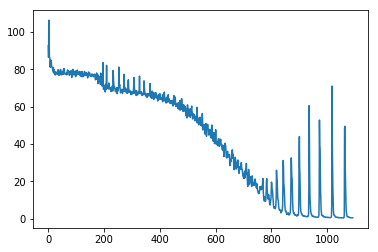

In [7]:
from __future__ import division
from __future__ import print_function

import sys
import argparse
import cv2
import editdistance
#from DataLoader import DataLoader, Batch
#from Model import Model, DecoderType
#from SamplePreprocessor import preprocess


class FilePaths:
    "filenames and paths to data"
    fnCharList = 'model/charList.txt'
    fnAccuracy = 'model/accuracy.txt'
    fnTrain = 'data/'
    fnInfer = 'data/test.png'
    fnCorpus = 'data/corpus.txt'

'''    
def main():
    "main function"
    # optional command line args
    parser = argparse.ArgumentParser()
    parser.add_argument("--train", help="train the NN", action="store_true")
    parser.add_argument("--validate", help="validate the NN", action="store_true")
    parser.add_argument("--beamsearch", help="use beam search instead of best path decoding", action="store_true")
    parser.add_argument("--wordbeamsearch", help="use word beam search instead of best path decoding", action="store_true")
    args = parser.parse_args()

    decoderType = DecoderType.BestPath
    if args.beamsearch:
        decoderType = DecoderType.BeamSearch
    elif args.wordbeamsearch:
        decoderType = DecoderType.WordBeamSearch

    # train or validate on IAM dataset    
    if args.train or args.validate:
        # load training data, create TF model
        loader = DataLoader(FilePaths.fnTrain, Model.batchSize, Model.imgSize, Model.maxTextLen)

        # save characters of model for inference mode
        open(FilePaths.fnCharList, 'w').write(str().join(loader.charList))
        
        # save words contained in dataset into file
        open(FilePaths.fnCorpus, 'w').write(str(' ').join(loader.trainWords + loader.validationWords))

        # execute training or validation
        if args.train:
            model = Model(loader.charList, decoderType)
            train(model, loader)
        elif args.validate:
            model = Model(loader.charList, decoderType, mustRestore=True)
            validate(model, loader)

    # infer text on test image
    else:
        print(open(FilePaths.fnAccuracy).read())
        model = Model(open(FilePaths.fnCharList).read(), decoderType, mustRestore=True)
        infer(model, FilePaths.fnInfer)
'''
# load training data, create TF model
#loader = DataLoader(FilePaths.fnTrain, Model.batchSize, Model.imgSize, Model.maxTextLen)
decoderType = DecoderType.BestPath
loader = MorseDataset("./", Model.batchSize, Model.imgSize, Model.maxTextLen)

# save characters of model for inference mode
open("morseCharList.txt", 'w').write(str().join(loader.charList))
        
# save words contained in dataset into file
open("morseCorpus.txt", 'w').write(str(' ').join(loader.trainWords + loader.validationWords))

# execute training or validation
model = Model(loader.charList, decoderType)
loss = train(model, loader)
plt.plot(loss)
plt.show()


could not load image:image/6241434ca1ac44919183de4524874511.wav.png processing audio file
inferBatch: probs:[  2.80859840e-05] texts:['THAC BADIP DOP WOW NHT'] 
Recognized: "THAC BADIP DOP WOW NHT"
Probability: 2.8086e-05
['THAC BADIP DOP WOW NHT']


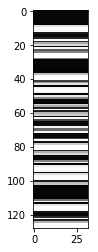

In [26]:
def infer(model, fnImg):
    "recognize text in image provided by file path"
    img = create_image(fnImg, Model.imgSize)
    plt.imshow(img,cmap = cm.Greys_r)
    batch = Batch(None, [img])
    (recognized, probability) = model.inferBatch(batch, True)
    print('Recognized:', '"' + recognized[0] + '"')
    print('Probability:', probability[0])
    print(recognized)
#model = Model(loader.charList, decoderType )#, mustRestore=False)
infer(model,"audio/6241434ca1ac44919183de4524874511.wav")

In [20]:
def validate2(model, loader):
    "validate NN"
    print('Validate NN')
    #loader.trainSet()
    loader.validationSet()
    charErrorRate = float('inf')
    numCharErr = 0
    numCharTotal = 0
    numWordOK = 0
    numWordTotal = 0
    while loader.hasNext():
        iterInfo = loader.getIteratorInfo()
        print('Batch:', iterInfo[0],'/', iterInfo[1])
        batch = loader.getNext()
        (recognized, _) = model.inferBatch(batch, True)
        print(recognized)
        
        print('Ground truth -> Recognized')    
        for i in range(len(recognized)):
            numWordOK += 1 if batch.gtTexts[i] == recognized[i] else 0
            numWordTotal += 1
            dist = editdistance.eval(recognized[i], batch.gtTexts[i])
            numCharErr += dist
            numCharTotal += len(batch.gtTexts[i])
            print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + batch.gtTexts[i] + '"', '->', '"' + recognized[i] + '"')
    
    # print validation result
    
    try:
        charErrorRate = numCharErr / numCharTotal
        wordAccuracy = numWordOK / numWordTotal
        print('Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate*100.0, wordAccuracy*100.0))
    except:
        print('numCharTotal:{} numWordTotal:{}'.format(numCharTotal,numWordTotal))
    return charErrorRate


In [21]:
validate2(model, loader)

Validate NN
numCharTotal:0 numWordTotal:0


inf

In [34]:
loader.trainSet()
#loader.validationSet()
batch = loader.getNext()
batch.gtTexts

['RAMO BAUER HO BIDDY TRUTH',
 'ROACH MOST VS LAIR ERDA',
 'AGILE YATES MAY AROMA CROCK',
 'CAGE KIVU LICE BLEAK BAG',
 'JOYCE LAMAR GENIE JACOB WEED',
 'JUNCO SITE WV BRAVE SPOKE',
 'GREAT ESTOP EST DRONE PAGE',
 'ELMER GEAR CHAIN POEM GREET',
 'HETTY TWIRL BLISS IRK BAND',
 'BURRO BREST TONG LYCEE VISE',
 'BREST EMIL EX OWLET SHEAF',
 'EXEC MANIC PECOS BETA STEM',
 'TAMP GARTH WARE PECAN MIDGE',
 'ELBOW SERF GOLD CLAUS SPIKE',
 'ELAN PITT STORM GROUT AGAIN',
 'MONA MILL POPE WARE KITTY',
 'MU AMORT STONE MUSIC THEE',
 'AMOS BREST SATYR OLGA SYRUP',
 'DOVE TALC DOOM LEMMA DELFT',
 'BORON SPEW CUZCO EXTRA TEST',
 'DEMIT THICK LOGAN STACY RONDO',
 'PANTY KIRBY ME COY CHEWY',
 'HONEY TOUCH GUSTO VITAE LOOT',
 'SPURT OLDY STRUM TENOR RAVEN',
 'YELP SILL BUG GOULD ATOLL',
 'DEWAR MOOD TAB LORIS PENNY',
 'WIRY SON MOOSE SUCK ON',
 'WI PALE BELOW FEET ARGON',
 'TEEM NEVA ALDER JIVE OMAHA',
 'ALBA BLUNT MADAM YAQUI ZINC',
 'SNAIL GOOSE HASH BLAT LEGGY',
 'SCALY VOLE CAFE UNITE SHAG',
 'GAUZY 

In [ ]:
model.save()

In [ ]:
text = 'abcdef'
'*'.join(text)


inferBatch: probs:[  1.15768376e-06] texts:['TROD HU PECHE HRCY MATHM'] 
Recognized: "TROD HU PECHE HRCY MATHM"
Probability: 1.15768e-06
['TROD HU PECHE HRCY MATHM']
=====TROFF CHLOE FELT BARN STANK====>None
inferBatch: probs:[  3.14676217e-05] texts:['THAC BADIP DOP WOW NHT'] 
Recognized: "THAC BADIP DOP WOW NHT"
Probability: 3.14676e-05
['THAC BADIP DOP WOW NHT']
=====TV CHIRP ART RAPID JUDE====>None
inferBatch: probs:[ 0.00058297] texts:['GRADE HIME DINI DISS WOT'] 
Recognized: "GRADE HIME DINI DISS WOT"
Probability: 0.000582971
['GRADE HIME DINI DISS WOT']
=====GA COIN RINK BEST PUMA====>None
inferBatch: probs:[  2.17161983e-06] texts:['DRVE BULE TAXAM UNTOM DOAUSE'] 
Recognized: "DRVE BULE TAXAM UNTOM DOAUSE"
Probability: 2.17162e-06
['DRVE BULE TAXAM UNTOM DOAUSE']
=====DYE ALTAR HELIX AKIN WIN====>None
inferBatch: probs:[  6.29500428e-05] texts:['ROGU PODO PONE MOL HUT'] 
Recognized: "ROGU PODO PONE MOL HUT"
Probability: 6.295e-05
['ROGU PODO PONE MOL HUT']
=====ROOK PHONY JURE 

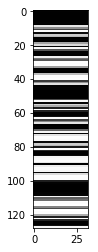

In [30]:
for sample in loader.samples:
    print("====={}====>{}".format(sample.gtText,infer(model,sample.filePath)))

In [ ]:
infer(model,"audio/6241434ca1ac44919183de4524874511.wav")